
# Baseline Experiment 2-2

Pre-train model on 8 subjects then fine tune for the holdout subject. 

Model: BSFShallowNet

Dataset: BCI Competitin IV 2a, BCNI2014001 via MOABB library


In [1]:
import matplotlib.pyplot as plt
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import pickle
from matplotlib.lines import Line2D
# from braindecode.visualization import plot_confusion_matrix

from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset
from braindecode.preprocessing.windowers import _create_windows_from_events
import numpy as np
import mne
import random

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Loading and preparing the data




### Loading the dataset




In [2]:
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=list(range(1, 10)))

### Preprocessing




In [3]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


### Extracting Compute Windows




In [4]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [5]:
def generate_non_repeating_integers(x, y):
    # Check if y is greater than x
    if y < x:
        raise ValueError("y must be greater than or equal to x")
    
    # Generate x non-repeating integers between 0 and y
    return random.sample(range(y), x)

def sample_integers_sum_to_x(x, k):
    '''
    k >= 2
    '''
    # Generate k-1 random integers between 1 and x
    parts = sorted(random.randint(1, x) for _ in range(k-1))
    
    # Calculate the differences between consecutive numbers
    differences = [parts[0]] + [parts[i] - parts[i-1] for i in range(1, k-1)] + [x - parts[-1]]
    
    return differences

def get_subset(input_set, target_trial_num, random_sample=False):
    # check inputs
    assert isinstance(input_set, BaseConcatDataset)
    assert isinstance(target_trial_num, int)
    
    new_ds_lst = []

    if random_sample:
        
        trial_cnt_from_each_base_ds = sample_integers_sum_to_x(target_trial_num, len(input_set.datasets))
        for i, cnt in enumerate(trial_cnt_from_each_base_ds):
            if not cnt:
                # no sampling in current base dataset
                continue
        
            # Access current base dataset
            cur_ds = input_set.datasets[i]
            assert isinstance(cur_ds, EEGWindowsDataset)
            # Randomly sample trial index
            try:
                trial_idx = generate_non_repeating_integers(cnt, len(cur_ds))
                new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
                                                    description=cur_ds.description))
            except ValueError:
                # If trying to sample more trials in current ds than there are
                # Get entire cur_ds, and get what's missing fromt the next ds
                new_ds_lst.append(cur_ds)
                trial_cnt_from_each_base_ds[i+1] += (cnt - len(cur_ds))

    else:
    
        for ds in input_set.datasets:
            assert isinstance(ds, EEGWindowsDataset)
            cur_run_trial_num = len(ds.metadata)
            if target_trial_num > cur_run_trial_num:
                new_ds_lst.append(ds)
                target_trial_num -= cur_run_trial_num
            else:
                new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description))
                break

    return BaseConcatDataset(new_ds_lst)

## Fine tune for holdout subject set; Pre-train with data from all other subjects
fine tune train set size up to 30 mins (= 1800 sec = 450 trials)

In [14]:
results_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
exp_name = f'baseline_2_2_pretrain'

### ---------- Pre-training parameters ----------
lr = 0.07 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 30

splitted_by_subj = windows_dataset.split('subject')

data_amount_step = 15 # trials
# finetune_trials_num = 45 # trials
repetition = 5
results_columns = ['valid_accuracy',]
dict_results = {}

for holdout_subj_id in range(1, 10):
    
    print(f'Hold out data from subject {holdout_subj_id}')
    
    ### ---------- Split dataset into pre-train set and fine-tune (holdout) set ----------
    pre_train_set = BaseConcatDataset([splitted_by_subj.get(f'{i}') for i in range(1, 10) if i != holdout_subj_id])
    fine_tune_set = BaseConcatDataset([splitted_by_subj.get(f'{holdout_subj_id}'),])

    ### ---------- Split pre-train set into pre-train-train set and pre-train-test set ----------
    pre_train_train_set_lst = []
    pre_train_test_set_lst = []
    pre_train_test_set_size = 1 # runs
    for key, val in pre_train_set.split('subject').items():
        subj_splitted_lst_by_run = list(val.split('run').values())
        pre_train_train_set_lst.extend(subj_splitted_lst_by_run[:-pre_train_test_set_size])
        pre_train_test_set_lst.extend(subj_splitted_lst_by_run[-pre_train_test_set_size:])
    
    pre_train_train_set = BaseConcatDataset(pre_train_train_set_lst)
    pre_train_test_set = BaseConcatDataset(pre_train_test_set_lst)

    ### ---------- Pre-training ----------
    cuda = torch.cuda.is_available() 
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    
    seed = 20200220
    set_random_seeds(seed=seed, cuda=cuda)
    
    n_classes = 4
    classes = list(range(n_classes))
    # Extract number of chans and time steps from dataset
    n_chans = windows_dataset[0][0].shape[0]
    input_window_samples = windows_dataset[0][0].shape[1]
    
    cur_model = ShallowFBCSPNet(
        n_chans,
        n_classes,
        input_window_samples=input_window_samples,
        final_conv_length='auto',
    )
    
    cur_clf = EEGClassifier(
        cur_model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(pre_train_test_set),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device,
        classes=classes,
        warm_start=False
    )

    print(f'Pre-training model with data from all subjects but subject {holdout_subj_id}')
    _ = cur_clf.fit(pre_train_train_set, y=None, epochs=n_epochs)

    cur_clf.save_params(f_params=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_model.pkl'), 
                        f_optimizer=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_opt.pkl'), 
                        f_history=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_history.json'))

    ### ---------- Split fine tune set into fine tune-train set and fine tune-valid set ----------
    finetune_splitted_lst_by_run = list(fine_tune_set.split('run').values())
    finetune_subj_train_set = BaseConcatDataset(finetune_splitted_lst_by_run[:-1])
    finetune_subj_valid_set = BaseConcatDataset(finetune_splitted_lst_by_run[-1:])
    
    ### Baseline accuracy on the finetune_valid set
    finetune_valid_predicted = cur_clf.predict(finetune_subj_valid_set)
    finetune_valid_true = np.array(finetune_subj_valid_set.get_metadata().target)
    finetune_baseline_correct = np.equal(finetune_valid_predicted, finetune_valid_true)
    finetune_baseline_acc = np.sum(finetune_baseline_correct) / len(finetune_baseline_correct)
    print(f'Before finetuning for subject {holdout_subj_id}, the baseline accuracy is {finetune_baseline_acc}')

    ### ---------- Fine tuning ----------
    dict_subj_results = {0: [finetune_baseline_acc,]}

    ### Finetune with different amount of new data
    finetune_trials_num = len(finetune_subj_train_set)
    for finetune_training_data_amount in np.arange(1, (finetune_trials_num // data_amount_step) + 1) * data_amount_step:

        final_accuracy = []
        
        ### Since we're sampling randomly, repeat for 'repetition' times
        for i in range(repetition):

            ## Get current finetune samples
            try:
                cur_finetune_subj_train_subset = get_subset(finetune_subj_train_set, int(finetune_training_data_amount), random_sample=True)
            except IndexError:
                cur_finetune_subj_train_subset = get_subset(finetune_subj_train_set, int(finetune_training_data_amount), random_sample=False)
    
            finetune_model = ShallowFBCSPNet(
                n_chans,
                n_classes,
                input_window_samples=input_window_samples,
                final_conv_length='auto',
            )
    
            ### ---------- Fine tune parameters ----------
            finetune_lr = 0.07 * 0.01
            finetune_weight_decay = 0
            finetune_batch_size = int(min(finetune_training_data_amount, 64))
            finetune_n_epochs = 20
            
            new_clf = EEGClassifier(
                finetune_model,
                criterion=torch.nn.NLLLoss,
                optimizer=torch.optim.AdamW,
                train_split=predefined_split(finetune_subj_valid_set), 
                optimizer__lr=finetune_lr,
                optimizer__weight_decay=finetune_weight_decay,
                batch_size=finetune_batch_size,
                callbacks=[
                    "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=finetune_n_epochs - 1)),
                ],
                device=device,
                classes=classes,
            )
            new_clf.initialize()
            
            ## Load pretrained model
            new_clf.load_params(f_params=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_model.pkl'), 
                                f_optimizer=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_opt.pkl'), 
                                f_history=os.path.join(results_dir, f'{exp_name}_without_subj_{holdout_subj_id}_history.json'))
    
            ## Continue training / finetuning
            print(f'Fine tuning model for subject {holdout_subj_id} with {finetune_training_data_amount} = {len(cur_finetune_subj_train_subset)} trials')
            _ = new_clf.partial_fit(cur_finetune_subj_train_subset, y=None, epochs=finetune_n_epochs)
    
            ## Get results after fine tuning
            df = pd.DataFrame(new_clf.history[:, results_columns], columns=results_columns,
                              # index=new_clf.history[:, 'epoch'],
                             )
    
            cur_final_acc = np.mean(df.tail(5).valid_accuracy)
            final_accuracy.append(cur_final_acc)
        
        dict_subj_results.update({finetune_training_data_amount: final_accuracy})

    dict_results.update({holdout_subj_id: dict_subj_results})

Hold out data from subject 1
Pre-training model with data from all subjects but subject 1


C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3927        1.6082       0.3229            0.3229        1.3990  0.0007  7.2525
      2            0.4750        1.4408       0.3789            0.3789        1.3237  0.0007  6.5943
      3            0.5305        1.3643       0.3906            0.3906        1.2767  0.0007  6.9546
      4            0.5490        1.2694       0.4427            0.4427        1.2639  0.0007  6.8823
      5            0.5792        1.2056       0.4362            0.4362        1.2602  0.0007  6.5938
      6            0.6070        1.1552       0.4531            0.4531        1.2417  0.0006  7.2856
      7            0.5961        1.1168       0.4544            0.4544        1.2547  0.0006  6.6719
      8            0.6336        1.0715       0.4557            0.4557        1.2152  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.7690       0.6146            0.6146        0.9157  0.0005  0.1154
     33            0.8667        0.7204       0.6354            0.6354        0.9070  0.0005  0.1127
     34            1.0000        0.5822       0.6458            0.6458        0.9059  0.0006  0.1642
     35            1.0000        0.4224       0.6250            0.6250        0.9170  0.0006  0.1525
     36            1.0000        0.2385       0.6250            0.6250        0.9424  0.0007  0.1163
     37            1.0000        0.1643       0.5938            0.5938        0.9776  0.0007  0.1492
     38            1.0000        0.1001       0.5833            0.5833        1.0142  0.0007  0.1229
     39            1.0000        0.0656       0.5833            0.5833        1.0478  0.0007  0.0934
     40            1.0000        0.0535       0.5833            0.5833        1.0716  0.0007  0.0949
     41            1.0000        0.0402       0.5938            0.5938        1.0870  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.7036       0.5938            0.5938        0.9332  0.0005  0.1261
     33            0.9333        0.8076       0.5833            0.5833        0.9497  0.0005  0.0862
     34            1.0000        0.7328       0.5625            0.5625        0.9914  0.0006  0.1127
     35            1.0000        0.2498       0.5521            0.5521        1.0493  0.0006  0.1127
     36            1.0000        0.2369       0.5417            0.5417        1.1015  0.0007  0.1036
     37            1.0000        0.1508       0.5417            0.5417        1.1472  0.0007  0.0843
     38            1.0000        0.1027       0.5312            0.5312        1.1837  0.0007  0.1116
     39            1.0000        0.1760       0.5312            0.5312        1.2159  0.0007  0.1282
     40            1.0000        0.0995       0.5312            0.5312        1.2451  0.0007  0.0964
     41            1.0000        0.0631       0.5208            0.5208        1.2689  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8617       0.6042            0.6042        0.9085  0.0005  0.1261
     33            0.8667        0.6290       0.6354            0.6354        0.9075  0.0005  0.0878
     34            1.0000        0.4813       0.6250            0.6250        0.9189  0.0006  0.1112
     35            1.0000        0.2482       0.6042            0.6042        0.9430  0.0006  0.0996
     36            1.0000        0.1745       0.5833            0.5833        0.9729  0.0007  0.1368
     37            1.0000        0.1076       0.5833            0.5833        1.0005  0.0007  0.0949
     38            1.0000        0.0990       0.5938            0.5938        1.0187  0.0007  0.1014
     39            1.0000        0.0716       0.5938            0.5938        1.0296  0.0007  0.1102
     40            1.0000        0.0867       0.6042            0.6042        1.0292  0.0007  0.0875
     41            1.0000        0.0496       0.5938            0.5938        1.0263  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8600       0.6250            0.6250        0.9428  0.0005  0.1197
     33            0.9333        0.5340       0.5938            0.5938        0.9503  0.0005  0.1134
     34            0.9333        0.4538       0.6250            0.6250        0.9643  0.0006  0.1043
     35            1.0000        0.4428       0.6146            0.6146        0.9829  0.0006  0.0850
     36            1.0000        0.2388       0.6042            0.6042        1.0059  0.0007  0.0865
     37            1.0000        0.1221       0.5833            0.5833        1.0374  0.0007  0.1013
     38            1.0000        0.0866       0.6042            0.6042        1.0737  0.0007  0.1115
     39            1.0000        0.0377       0.5625            0.5625        1.1095  0.0007  0.0859
     40            1.0000        0.0538       0.5417            0.5417        1.1431  0.0007  0.1112
     41            1.0000        0.0245       0.5417            0.5417        1.1702  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        0.8968       0.6042            0.6042        0.9131  0.0005  0.0989
     33            0.9333        0.7326       0.6042            0.6042        0.9177  0.0005  0.1208
     34            1.0000        0.4000       0.6042            0.6042        0.9476  0.0006  0.1169
     35            1.0000        0.3729       0.6042            0.6042        0.9932  0.0006  0.1020
     36            1.0000        0.2813       0.5938            0.5938        1.0489  0.0007  0.1172
     37            1.0000        0.1741       0.5625            0.5625        1.0997  0.0007  0.1185
     38            1.0000        0.0959       0.5625            0.5625        1.1605  0.0007  0.1027
     39            1.0000        0.0716       0.5729            0.5729        1.2288  0.0007  0.1170
     40            1.0000        0.0565       0.5312            0.5312        1.3033  0.0007  0.1180
     41            1.0000        0.0226       0.5521            0.5521        1.3794  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.2715       0.6146            0.6146        0.9272  0.0004  0.1383
     32            0.5667        1.2667       0.6250            0.6250        0.9097  0.0005  0.1510
     33            0.6000        1.0280       0.6146            0.6146        0.8911  0.0005  0.1491
     34            0.6667        0.9645       0.6562            0.6562        0.8765  0.0006  0.1544
     35            0.8000        0.8666       0.6771            0.6771        0.8677  0.0006  0.1429
     36            0.8333        0.5345       0.6667            0.6667        0.8707  0.0007  0.1599
     37            0.9333        0.3940       0.6458            0.6458        0.8858  0.0007  0.1516
     38            0.9333        0.2599       0.5938            0.5938        0.9126  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9672       0.6042            0.6042        0.9104  0.0005  0.1250
     33            0.7333        0.8122       0.6042            0.6042        0.8891  0.0005  0.1293
     34            0.8000        0.8799       0.6146            0.6146        0.8703  0.0006  0.1259
     35            0.9000        0.5224       0.6250            0.6250        0.8607  0.0006  0.1478
     36            0.9333        0.3463       0.6250            0.6250        0.8588  0.0007  0.1130
     37            0.9667        0.2733       0.6146            0.6146        0.8651  0.0007  0.1192
     38            1.0000        0.2255       0.6042            0.6042        0.8799  0.0007  0.1259
     39            1.0000        0.1799       0.6042            0.6042        0.8989  0.0007  0.1175
     40            1.0000        0.1476       0.5833            0.5833        0.9197  0.0007  0.1174
     41            0.9667        0.1225       0.5938            0.5938        0.9431  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.3710       0.6146            0.6146        0.9297  0.0004  0.1485
     32            0.5333        1.2430       0.6042            0.6042        0.9205  0.0005  0.1273
     33            0.6000        1.0604       0.5938            0.5938        0.9187  0.0005  0.1181
     34            0.8000        0.9288       0.5938            0.5938        0.9302  0.0006  0.1276
     35            0.9333        0.6087       0.5521            0.5521        0.9539  0.0006  0.1328
     36            1.0000        0.4946       0.5625            0.5625        0.9862  0.0007  0.1281
     37            1.0000        0.2407       0.5625            0.5625        1.0159  0.0007  0.1318
     38            1.0000        0.2590       0.5417            0.5417        1.0395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6333        1.2442       0.6250            0.6250        0.9256  0.0005  0.1313
     33            0.6333        0.8598       0.6354            0.6354        0.9179  0.0005  0.1166
     34            0.7667        0.8078       0.6250            0.6250        0.9098  0.0006  0.1354
     35            0.9000        0.6788       0.5938            0.5938        0.9034  0.0006  0.1147
     36            0.9667        0.5523       0.6146            0.6146        0.8993  0.0007  0.1396
     37            0.9667        0.4148       0.6354            0.6354        0.9020  0.0007  0.1324
     38            1.0000        0.3066       0.5938            0.5938        0.9140  0.0007  0.1375
     39            1.0000        0.3141       0.5312            0.5312        0.9296  0.0007  0.1407
     40            1.0000        0.2659       0.5312            0.5312        0.9455  0.0007  0.1206
     41            1.0000        0.1580       0.5521            0.5521        0.9609  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.3948       0.6250            0.6250        0.9100  0.0005  0.1430
     33            0.7333        0.9862       0.6042            0.6042        0.8987  0.0005  0.1292
     34            0.8333        0.7859       0.5938            0.5938        0.8976  0.0006  0.1189
     35            0.9000        0.5530       0.5938            0.5938        0.9098  0.0006  0.1260
     36            0.9667        0.4103       0.6042            0.6042        0.9310  0.0007  0.1360
     37            1.0000        0.3825       0.5729            0.5729        0.9573  0.0007  0.1182
     38            1.0000        0.2850       0.5521            0.5521        0.9835  0.0007  0.1314
     39            1.0000        0.2834       0.5729            0.5729        1.0079  0.0007  0.1241
     40            1.0000        0.2351       0.5729            0.5729        1.0292  0.0007  0.1154
     41            1.0000        0.2006       0.5729            0.5729        1.0460  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5556        1.2482       0.6250            0.6250        0.9289  0.0004  0.1592
     32            0.5556        1.0687       0.6250            0.6250        0.9147  0.0005  0.1979
     33            0.6222        1.0656       0.6354            0.6354        0.9046  0.0005  0.1866
     34            0.6444        1.0006       0.6458            0.6458        0.9012  0.0006  0.1567
     35            0.7556        0.6627       0.6562            0.6562        0.9053  0.0006  0.2098
     36            0.7333        0.5845       0.6562            0.6562        0.9139  0.0007  0.1736
     37            0.7556        0.4189       0.6250            0.6250        0.9279  0.0007  0.1542
     38            0.8000        0.3759       0.6042            0.6042        0.9379  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.2232       0.6042            0.6042        0.9306  0.0004  0.1311
     32            0.5111        1.1911       0.6250            0.6250        0.9147  0.0005  0.1607
     33            0.5778        1.1811       0.6146            0.6146        0.9009  0.0005  0.1287
     34            0.6000        1.0874       0.6354            0.6354        0.8933  0.0006  0.1482
     35            0.7556        0.9170       0.6562            0.6562        0.9013  0.0006  0.1279
     36            0.8222        0.8109       0.5729            0.5729        0.9220  0.0007  0.1521
     37            0.8667        0.6291       0.5729            0.5729        0.9549  0.0007  0.1446
     38            0.8667        0.5178       0.5625            0.5625        0.9815  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.2022       0.6146            0.6146        0.9275  0.0004  0.1458
     32            0.5333        1.3175       0.5833            0.5833        0.9139  0.0005  0.1501
     33            0.6000        1.0602       0.5833            0.5833        0.9062  0.0005  0.1697
     34            0.6444        0.8980       0.5625            0.5625        0.9063  0.0006  0.1402
     35            0.7778        0.9767       0.5833            0.5833        0.9095  0.0006  0.1479
     36            0.8000        0.7890       0.5833            0.5833        0.9122  0.0007  0.1552
     37            0.9111        0.5314       0.5729            0.5729        0.9135  0.0007  0.1710
     38            0.9556        0.4137       0.6042            0.6042        0.9125  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.1015       0.6146            0.6146        0.9342  0.0004  0.1532
     32            0.6667        1.0630       0.6146            0.6146        0.9291  0.0005  0.1856
     33            0.7333        1.0189       0.6146            0.6146        0.9313  0.0005  0.1509
     34            0.8444        0.8309       0.6250            0.6250        0.9378  0.0006  0.1523
     35            0.8889        0.7101       0.6250            0.6250        0.9473  0.0006  0.1507
     36            0.9778        0.5770       0.6146            0.6146        0.9619  0.0007  0.1506
     37            1.0000        0.4796       0.6042            0.6042        0.9822  0.0007  0.1355
     38            1.0000        0.4490       0.5938            0.5938        1.0054  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.4073       0.6042            0.6042        0.9325  0.0004  0.1341
     32            0.5333        1.3683       0.6146            0.6146        0.9203  0.0005  0.1461
     33            0.6000        1.2718       0.6354            0.6354        0.9134  0.0005  0.1429
     34            0.6667        1.0957       0.5729            0.5729        0.9177  0.0006  0.1885
     35            0.7556        0.8819       0.5938            0.5938        0.9314  0.0006  0.1736
     36            0.8000        0.8164       0.5833            0.5833        0.9530  0.0007  0.1699
     37            0.8222        0.7007       0.5521            0.5521        0.9697  0.0007  0.1840
     38            0.8889        0.5008       0.5417            0.5417        0.9839  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5167        1.0464       0.6146            0.6146        0.9289  0.0004  0.2068
     32            0.5833        1.1122       0.6146            0.6146        0.9136  0.0005  0.1790
     33            0.6333        1.0676       0.5833            0.5833        0.8962  0.0005  0.1883
     34            0.7167        0.9588       0.5729            0.5729        0.8778  0.0006  0.1562
     35            0.8000        0.8449       0.5833            0.5833        0.8609  0.0006  0.1999
     36            0.8500        0.8540       0.6146            0.6146        0.8441  0.0007  0.2365
     37            0.8667        0.6861       0.6250            0.6250        0.8294  0.0007  0.2253
     38            0.9000        0.5357       0.6667            0.6667        0.8206  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9146       0.6250            0.6250        0.9299  0.0004  0.2494
     32            0.7000        0.8492       0.6250            0.6250        0.9154  0.0005  0.1784
     33            0.7333        0.8604       0.5938            0.5938        0.9035  0.0005  0.1562
     34            0.8167        0.6795       0.5938            0.5938        0.8970  0.0006  0.1508
     35            0.8500        0.6649       0.6146            0.6146        0.8966  0.0006  0.1646
     36            0.8667        0.5684       0.6146            0.6146        0.9013  0.0007  0.1550
     37            0.9167        0.5105       0.6250            0.6250        0.9114  0.0007  0.1623
     38            0.9333        0.4710       0.6146            0.6146        0.9257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        0.9323       0.6146            0.6146        0.9292  0.0004  0.1587
     32            0.6500        1.0009       0.6042            0.6042        0.9194  0.0005  0.1699
     33            0.7167        1.0739       0.5938            0.5938        0.9175  0.0005  0.1808
     34            0.8000        0.7758       0.6042            0.6042        0.9200  0.0006  0.1564
     35            0.8167        0.7277       0.6146            0.6146        0.9268  0.0006  0.1563
     36            0.8833        0.6455       0.5938            0.5938        0.9334  0.0007  0.1729
     37            0.9000        0.5858       0.5938            0.5938        0.9402  0.0007  0.1611
     38            0.9500        0.4054       0.5729            0.5729        0.9498  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5167        1.3374       0.6146            0.6146        0.9313  0.0004  0.1875
     32            0.5167        1.3008       0.6042            0.6042        0.9211  0.0005  0.2188
     33            0.5667        1.1383       0.5938            0.5938        0.9134  0.0005  0.1928
     34            0.6167        1.0682       0.5833            0.5833        0.9087  0.0006  0.1985
     35            0.6833        1.0454       0.5833            0.5833        0.9079  0.0006  0.1850
     36            0.8000        0.8433       0.5729            0.5729        0.9094  0.0007  0.1805
     37            0.8667        0.7483       0.5625            0.5625        0.9138  0.0007  0.1718
     38            0.9000        0.5681       0.5729            0.5729        0.9190  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        0.9828       0.6250            0.6250        0.9320  0.0004  0.1563
     32            0.6667        0.9490       0.6042            0.6042        0.9210  0.0005  0.1562
     33            0.7167        0.8813       0.6146            0.6146        0.9131  0.0005  0.1563
     34            0.8000        0.9264       0.6146            0.6146        0.9090  0.0006  0.1563
     35            0.8667        0.7473       0.6250            0.6250        0.9094  0.0006  0.1562
     36            0.9000        0.5683       0.6146            0.6146        0.9149  0.0007  0.1522
     37            0.9000        0.5878       0.6250            0.6250        0.9237  0.0007  0.1811
     38            0.9500        0.4524       0.6250            0.6250        0.9336  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6533        0.8096       0.6250            0.6250        0.9278  0.0004  0.1651
     32            0.6800        0.8400       0.6042            0.6042        0.9131  0.0005  0.1665
     33            0.6933        0.8048       0.6042            0.6042        0.9017  0.0005  0.1685
     34            0.7733        0.7294       0.5833            0.5833        0.8931  0.0006  0.2218
     35            0.8400        0.6820       0.5938            0.5938        0.8841  0.0006  0.1918
     36            0.8667        0.6003       0.5729            0.5729        0.8757  0.0007  0.1877
     37            0.8933        0.4876       0.5938            0.5938        0.8695  0.0007  0.2644
     38            0.8933        0.4422       0.5833            0.5833        0.8629  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        1.0610       0.6250            0.6250        0.9311  0.0004  0.2477
     32            0.6000        1.1651       0.6250            0.6250        0.9180  0.0005  0.3754
     33            0.6267        0.7872       0.6458            0.6458        0.9062  0.0005  0.1926
     34            0.6800        0.9110       0.6354            0.6354        0.8997  0.0006  0.1902
     35            0.7467        1.0392       0.6458            0.6458        0.8964  0.0006  0.1875
     36            0.7867        0.8316       0.6667            0.6667        0.8990  0.0007  0.1876
     37            0.8000        0.7799       0.6562            0.6562        0.9072  0.0007  0.2860
     38            0.8667        0.5652       0.6250            0.6250        0.9141  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        0.9843       0.6146            0.6146        0.9315  0.0004  0.1797
     32            0.5867        1.0801       0.6250            0.6250        0.9196  0.0005  0.1543
     33            0.6267        0.9566       0.6146            0.6146        0.9061  0.0005  0.1562
     34            0.6933        0.9467       0.6250            0.6250        0.8911  0.0006  0.1562
     35            0.7733        0.8673       0.6354            0.6354        0.8754  0.0006  0.1719
     36            0.8667        0.7005       0.6458            0.6458        0.8612  0.0007  0.1562
     37            0.8667        0.7182       0.6458            0.6458        0.8510  0.0007  0.1562
     38            0.8933        0.5846       0.6146            0.6146        0.8466  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        1.2939       0.6146            0.6146        0.9311  0.0004  0.1620
     32            0.5867        1.2793       0.5938            0.5938        0.9229  0.0005  0.1849
     33            0.6533        1.0885       0.5938            0.5938        0.9232  0.0005  0.1723
     34            0.6667        1.1186       0.5729            0.5729        0.9343  0.0006  0.1562
     35            0.7200        0.9054       0.5729            0.5729        0.9521  0.0006  0.1563
     36            0.7867        0.8479       0.5521            0.5521        0.9792  0.0007  0.1719
     37            0.8533        0.6024       0.5521            0.5521        1.0053  0.0007  0.2986
     38            0.8933        0.6111       0.5521            0.5521        1.0275  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6133        1.1134       0.6146            0.6146        0.9297  0.0004  0.2108
     32            0.6267        1.0632       0.5938            0.5938        0.9202  0.0005  0.2884
     33            0.6667        0.8290       0.5625            0.5625        0.9135  0.0005  0.2675
     34            0.7200        0.8227       0.5521            0.5521        0.9095  0.0006  0.2878
     35            0.7467        0.9151       0.5729            0.5729        0.9083  0.0006  0.2749
     36            0.8400        0.8185       0.5833            0.5833        0.9069  0.0007  0.2791
     37            0.8800        0.7416       0.6042            0.6042        0.9078  0.0007  0.2822
     38            0.8933        0.6048       0.5833            0.5833        0.9144  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0635       0.6146            0.6146        0.9301  0.0004  0.2849
     32            0.6333        0.8991       0.6146            0.6146        0.9133  0.0005  0.1948
     33            0.6556        1.0579       0.6042            0.6042        0.8966  0.0005  0.1746
     34            0.6778        1.0115       0.6146            0.6146        0.8780  0.0006  0.1716
     35            0.7556        0.8160       0.6146            0.6146        0.8552  0.0006  0.1688
     36            0.8444        0.7600       0.6458            0.6458        0.8328  0.0007  0.1669
     37            0.8889        0.5783       0.6979            0.6979        0.8164  0.0007  0.3662
     38            0.9111        0.5817       0.6979            0.6979        0.8085  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        0.9307       0.6146            0.6146        0.9330  0.0004  0.1667
     32            0.6556        0.8761       0.5938            0.5938        0.9229  0.0005  0.1953
     33            0.6889        0.9546       0.5729            0.5729        0.9141  0.0005  0.3176
     34            0.7222        0.7843       0.5729            0.5729        0.9054  0.0006  0.2667
     35            0.7889        0.7999       0.5938            0.5938        0.9008  0.0006  0.3166
     36            0.8333        0.8390       0.6146            0.6146        0.8970  0.0007  0.1809
     37            0.8556        0.7377       0.6042            0.6042        0.8966  0.0007  0.1540
     38            0.8778        0.6229       0.6354            0.6354        0.9006  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.3180       0.6146            0.6146        0.9329  0.0004  0.2685
     32            0.6000        1.1198       0.6146            0.6146        0.9214  0.0005  0.2065
     33            0.6222        0.8954       0.5833            0.5833        0.9173  0.0005  0.2139
     34            0.6556        0.9706       0.5625            0.5625        0.9226  0.0006  0.1858
     35            0.7444        0.9600       0.5625            0.5625        0.9308  0.0006  0.1781
     36            0.8000        0.7021       0.5729            0.5729        0.9480  0.0007  0.1567
     37            0.8222        0.6670       0.5625            0.5625        0.9622  0.0007  0.1719
     38            0.8556        0.6046       0.5521            0.5521        0.9741  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0283       0.6250            0.6250        0.9330  0.0004  0.1755
     32            0.6667        0.9496       0.6042            0.6042        0.9226  0.0005  0.1626
     33            0.6667        0.9735       0.5625            0.5625        0.9188  0.0005  0.1719
     34            0.7000        0.8435       0.5729            0.5729        0.9171  0.0006  0.1563
     35            0.7111        0.8905       0.5729            0.5729        0.9240  0.0006  0.1563
     36            0.7333        0.7092       0.5625            0.5625        0.9283  0.0007  0.1719
     37            0.7556        0.6249       0.5521            0.5521        0.9334  0.0007  0.1842
     38            0.7778        0.6726       0.5417            0.5417        0.9322  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.1070       0.6042            0.6042        0.9291  0.0004  0.1563
     32            0.7000        1.1766       0.6250            0.6250        0.9134  0.0005  0.1572
     33            0.7222        1.1032       0.6354            0.6354        0.8991  0.0005  0.1719
     34            0.7444        0.9916       0.6250            0.6250        0.8835  0.0006  0.1562
     35            0.7778        0.7759       0.6250            0.6250        0.8710  0.0006  0.1562
     36            0.8111        0.6874       0.6250            0.6250        0.8642  0.0007  0.1562
     37            0.8667        0.6885       0.6354            0.6354        0.8602  0.0007  0.1746
     38            0.9000        0.6133       0.6458            0.6458        0.8590  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        0.8640       0.6250            0.6250        0.9289  0.0004  0.3189
     32            0.6381        0.9463       0.6042            0.6042        0.9176  0.0005  0.1877
     33            0.6571        0.8719       0.6042            0.6042        0.9117  0.0005  0.2292
     34            0.6857        0.8186       0.5938            0.5938        0.9087  0.0006  0.3010
     35            0.6952        0.7922       0.5833            0.5833        0.9113  0.0006  0.2884
     36            0.7333        0.8323       0.5938            0.5938        0.9112  0.0007  0.1639
     37            0.7619        0.7132       0.5833            0.5833        0.9126  0.0007  0.2207
     38            0.8381        0.5809       0.5938            0.5938        0.9076  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.8417       0.6250            0.6250        0.9293  0.0004  0.1563
     32            0.6952        0.9176       0.6146            0.6146        0.9167  0.0005  0.1772
     33            0.7048        0.8713       0.5833            0.5833        0.9055  0.0005  0.1751
     34            0.7429        0.8190       0.5833            0.5833        0.8982  0.0006  0.1791
     35            0.8095        0.7409       0.5938            0.5938        0.8896  0.0006  0.1777
     36            0.8190        0.7112       0.6042            0.6042        0.8865  0.0007  0.1821
     37            0.8381        0.6523       0.6042            0.6042        0.8786  0.0007  0.1719
     38            0.8762        0.5371       0.6146            0.6146        0.8684  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5238        1.0729       0.6250            0.6250        0.9325  0.0004  0.1797
     32            0.5619        1.1108       0.6146            0.6146        0.9237  0.0005  0.1719
     33            0.6286        1.0089       0.6146            0.6146        0.9177  0.0005  0.1862
     34            0.6571        0.9831       0.5938            0.5938        0.9122  0.0006  0.1827
     35            0.6762        0.8457       0.6042            0.6042        0.9076  0.0006  0.1570
     36            0.7048        0.7662       0.6354            0.6354        0.9047  0.0007  0.1719
     37            0.7524        0.8637       0.6458            0.6458        0.9042  0.0007  0.1719
     38            0.8095        0.7312       0.6146            0.6146        0.9041  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5714        1.0402       0.6042            0.6042        0.9330  0.0004  0.1563
     32            0.5905        1.3599       0.6354            0.6354        0.9190  0.0005  0.1562
     33            0.5905        1.0642       0.6250            0.6250        0.9029  0.0005  0.1718
     34            0.6000        1.0376       0.6042            0.6042        0.8874  0.0006  0.1718
     35            0.6190        0.9895       0.5833            0.5833        0.8752  0.0006  0.1719
     36            0.6571        0.8533       0.6042            0.6042        0.8704  0.0007  0.1719
     37            0.7143        0.9882       0.5938            0.5938        0.8659  0.0007  0.1563
     38            0.7333        0.7129       0.5833            0.5833        0.8613  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.2190       0.6042            0.6042        0.9309  0.0004  0.2031
     32            0.5429        1.2799       0.6354            0.6354        0.9168  0.0005  0.1718
     33            0.6095        1.1166       0.6146            0.6146        0.9017  0.0005  0.1567
     34            0.6286        1.0161       0.6458            0.6458        0.8882  0.0006  0.1719
     35            0.6667        1.1608       0.6562            0.6562        0.8761  0.0006  0.1719
     36            0.7048        0.9452       0.6562            0.6562        0.8679  0.0007  0.1875
     37            0.7429        0.7992       0.6250            0.6250        0.8630  0.0007  0.1719
     38            0.7810        0.7597       0.6250            0.6250        0.8585  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5833        1.2218       0.6042            0.6042        0.9297  0.0004  0.2155
     32            0.6083        1.1403       0.6250            0.6250        0.9091  0.0005  0.1701
     33            0.6167        1.1253       0.5938            0.5938        0.8926  0.0005  0.1644
     34            0.6333        0.9876       0.5833            0.5833        0.8836  0.0006  0.1926
     35            0.6667        0.8815       0.6042            0.6042        0.8824  0.0006  0.1870
     36            0.6917        0.8711       0.5729            0.5729        0.8817  0.0007  0.1869
     37            0.7000        0.9207       0.5729            0.5729        0.8775  0.0007  0.2120
     38            0.7417        0.6892       0.5625            0.5625        0.8656  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5917        1.0584       0.6146            0.6146        0.9308  0.0004  0.1719
     32            0.6250        1.0079       0.5729            0.5729        0.9236  0.0005  0.1563
     33            0.6500        1.0874       0.5729            0.5729        0.9249  0.0005  0.1563
     34            0.6667        1.0518       0.5833            0.5833        0.9250  0.0006  0.2030
     35            0.6833        0.9168       0.5833            0.5833        0.9217  0.0006  0.1723
     36            0.7083        0.9822       0.5938            0.5938        0.9172  0.0007  0.1781
     37            0.7750        0.7665       0.5729            0.5729        0.9105  0.0007  0.1876
     38            0.8000        0.6101       0.6042            0.6042        0.9021  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        0.9529       0.6146            0.6146        0.9327  0.0004  0.1719
     32            0.6250        0.8835       0.6146            0.6146        0.9241  0.0005  0.1719
     33            0.6250        0.8748       0.5938            0.5938        0.9124  0.0005  0.2188
     34            0.6333        0.9616       0.6042            0.6042        0.9003  0.0006  0.1719
     35            0.6750        0.8181       0.6146            0.6146        0.8870  0.0006  0.1771
     36            0.7167        0.8162       0.6250            0.6250        0.8768  0.0007  0.1719
     37            0.7500        0.7207       0.6250            0.6250        0.8714  0.0007  0.1718
     38            0.7750        0.7076       0.6146            0.6146        0.8678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1005       0.6146            0.6146        0.9339  0.0004  0.1563
     32            0.5917        1.0142       0.5938            0.5938        0.9205  0.0005  0.1562
     33            0.6167        1.1182       0.5833            0.5833        0.9103  0.0005  0.2031
     34            0.6417        1.0166       0.5729            0.5729        0.9004  0.0006  0.2008
     35            0.6833        0.8284       0.5625            0.5625        0.8913  0.0006  0.1914
     36            0.7083        0.8595       0.5625            0.5625        0.8804  0.0007  0.1759
     37            0.7500        0.7441       0.5417            0.5417        0.8692  0.0007  0.2152
     38            0.7750        0.6907       0.5729            0.5729        0.8525  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0745       0.5938            0.5938        0.9313  0.0004  0.1781
     32            0.6000        1.0516       0.6250            0.6250        0.9182  0.0005  0.1786
     33            0.6667        0.9845       0.6250            0.6250        0.9032  0.0005  0.1859
     34            0.7583        0.9452       0.6146            0.6146        0.8914  0.0006  0.1850
     35            0.8083        0.9304       0.5938            0.5938        0.8852  0.0006  0.1769
     36            0.8250        0.7690       0.6042            0.6042        0.8806  0.0007  0.1845
     37            0.8583        0.6835       0.6146            0.6146        0.8827  0.0007  0.1715
     38            0.8583        0.5970       0.6042            0.6042        0.8874  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        0.9826       0.6042            0.6042        0.9239  0.0004  0.2967
     32            0.6889        0.9727       0.5938            0.5938        0.9109  0.0005  0.2933
     33            0.7259        0.8831       0.5938            0.5938        0.9043  0.0005  0.2817
     34            0.8000        0.6774       0.5938            0.5938        0.9023  0.0006  0.2893
     35            0.8593        0.5747       0.5938            0.5938        0.9083  0.0006  0.2658
     36            0.8889        0.5328       0.5729            0.5729        0.9192  0.0007  0.2713
     37            0.9185        0.4157       0.5729            0.5729        0.9233  0.0007  0.2775
     38            0.9259        0.3859       0.5521            0.5521        0.9163  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5704        1.0634       0.6354            0.6354        0.9159  0.0004  0.3797
     32            0.6074        1.0208       0.5938            0.5938        0.8913  0.0005  0.2831
     33            0.6593        0.7878       0.6146            0.6146        0.8758  0.0005  0.3561
     34            0.7333        0.7533       0.6146            0.6146        0.8752  0.0006  0.4737
     35            0.7704        0.6470       0.6042            0.6042        0.8816  0.0006  0.4992
     36            0.7926        0.6011       0.6250            0.6250        0.8812  0.0007  0.3091
     37            0.8593        0.5234       0.5938            0.5938        0.8657  0.0007  0.2808
     38            0.8889        0.4650       0.5938            0.5938        0.8418  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.0991       0.6354            0.6354        0.9205  0.0004  0.2655
     32            0.6000        1.0396       0.5938            0.5938        0.8971  0.0005  0.2839
     33            0.6593        0.9628       0.5938            0.5938        0.8808  0.0005  0.2604
     34            0.7333        0.8803       0.6146            0.6146        0.8613  0.0006  0.3007
     35            0.8148        0.6888       0.6354            0.6354        0.8512  0.0006  0.2943
     36            0.8593        0.6418       0.5833            0.5833        0.8387  0.0007  0.3202
     37            0.9333        0.4914       0.5833            0.5833        0.8259  0.0007  0.4466
     38            0.9630        0.4321       0.5833            0.5833        0.8139  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5630        0.9852       0.6042            0.6042        0.9174  0.0004  0.2796
     32            0.6444        0.9410       0.5938            0.5938        0.9004  0.0005  0.2761
     33            0.6667        1.0125       0.6042            0.6042        0.8869  0.0005  0.2744
     34            0.7481        0.8022       0.5938            0.5938        0.8759  0.0006  0.2964
     35            0.8074        0.6733       0.5833            0.5833        0.8653  0.0006  0.2853
     36            0.8667        0.6664       0.6146            0.6146        0.8641  0.0007  0.2918
     37            0.9111        0.4577       0.6042            0.6042        0.8752  0.0007  0.2682
     38            0.9407        0.4507       0.5833            0.5833        0.8937  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.1771       0.5938            0.5938        0.9243  0.0004  0.2809
     32            0.6000        0.9720       0.5833            0.5833        0.9172  0.0005  0.2797
     33            0.6296        0.9533       0.5729            0.5729        0.9065  0.0005  0.2627
     34            0.7111        0.9218       0.5833            0.5833        0.9038  0.0006  0.2728
     35            0.7778        0.7953       0.6042            0.6042        0.9068  0.0006  0.3053
     36            0.8519        0.6667       0.5729            0.5729        0.9061  0.0007  0.2529
     37            0.8963        0.5547       0.5729            0.5729        0.9099  0.0007  0.2926
     38            0.9333        0.5443       0.5417            0.5417        0.9201  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        0.9063       0.6146            0.6146        0.9188  0.0004  0.2673
     32            0.7133        0.8831       0.5938            0.5938        0.8981  0.0005  0.2628
     33            0.7533        0.8422       0.6250            0.6250        0.8835  0.0005  0.2657
     34            0.8000        0.7607       0.6458            0.6458        0.8744  0.0006  0.2731
     35            0.8267        0.7015       0.6562            0.6562        0.8722  0.0006  0.2777
     36            0.8600        0.5895       0.6146            0.6146        0.8840  0.0007  0.2887
     37            0.9000        0.5056       0.5938            0.5938        0.8944  0.0007  0.3028
     38            0.8933        0.4202       0.5729            0.5729        0.8986  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5800        0.9996       0.6146            0.6146        0.9156  0.0004  0.2746
     32            0.6467        0.9281       0.6042            0.6042        0.8919  0.0005  0.2648
     33            0.7000        0.8563       0.6042            0.6042        0.8577  0.0005  0.2994
     34            0.7400        0.7725       0.6354            0.6354        0.8270  0.0006  0.2624
     35            0.7933        0.6475       0.6458            0.6458        0.8086  0.0006  0.2687
     36            0.8267        0.6260       0.5833            0.5833        0.8020  0.0007  0.2711
     37            0.8400        0.6172       0.5938            0.5938        0.7953  0.0007  0.3442
     38            0.8733        0.4599       0.5938            0.5938        0.7809  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5600        1.0766       0.6146            0.6146        0.9173  0.0004  0.2688
     32            0.5933        1.0781       0.6146            0.6146        0.8837  0.0005  0.2769
     33            0.6800        0.9826       0.6250            0.6250        0.8475  0.0005  0.2673
     34            0.7667        0.7887       0.6146            0.6146        0.8181  0.0006  0.2877
     35            0.8067        0.7504       0.6458            0.6458        0.7998  0.0006  0.2661
     36            0.8667        0.6218       0.6146            0.6146        0.7887  0.0007  0.2996
     37            0.8867        0.5631       0.6250            0.6250        0.7817  0.0007  0.3186
     38            0.9200        0.4726       0.6875            0.6875        0.7678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6133        1.0800       0.6146            0.6146        0.9167  0.0004  0.2826
     32            0.6467        0.9338       0.5833            0.5833        0.8946  0.0005  0.2873
     33            0.7200        0.8464       0.6354            0.6354        0.8742  0.0005  0.2772
     34            0.7867        0.7553       0.5938            0.5938        0.8568  0.0006  0.2884
     35            0.8200        0.6460       0.6042            0.6042        0.8421  0.0006  0.2837
     36            0.8667        0.6838       0.6458            0.6458        0.8411  0.0007  0.2978
     37            0.8800        0.5225       0.6354            0.6354        0.8506  0.0007  0.2705
     38            0.8867        0.4373       0.6458            0.6458        0.8527  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        1.1797       0.6042            0.6042        0.9167  0.0004  0.3138
     32            0.6133        1.0663       0.5833            0.5833        0.9059  0.0005  0.3015
     33            0.6600        0.9419       0.6042            0.6042        0.8882  0.0005  0.3001
     34            0.7467        0.8996       0.6250            0.6250        0.8714  0.0006  0.2925
     35            0.7667        0.7528       0.6562            0.6562        0.8694  0.0006  0.3088
     36            0.7800        0.6331       0.6042            0.6042        0.8812  0.0007  0.3117
     37            0.8267        0.6285       0.5729            0.5729        0.8835  0.0007  0.3023
     38            0.8400        0.5395       0.5625            0.5625        0.8799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6121        1.1434       0.6250            0.6250        0.9161  0.0004  0.2734
     32            0.6606        1.0825       0.5833            0.5833        0.8970  0.0005  0.2648
     33            0.6909        0.9010       0.6250            0.6250        0.8855  0.0005  0.2747
     34            0.7455        0.8341       0.6146            0.6146        0.8875  0.0006  0.2625
     35            0.7818        0.7544       0.5833            0.5833        0.8924  0.0006  0.2575
     36            0.8121        0.6199       0.5833            0.5833        0.8913  0.0007  0.2843
     37            0.8364        0.5458       0.5625            0.5625        0.8938  0.0007  0.2556
     38            0.8485        0.5647       0.5729            0.5729        0.8966  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6121        1.0344       0.6146            0.6146        0.9177  0.0004  0.2836
     32            0.6545        0.8849       0.5833            0.5833        0.8985  0.0005  0.2663
     33            0.7091        0.8050       0.5938            0.5938        0.8837  0.0005  0.2780
     34            0.7455        0.8227       0.6250            0.6250        0.8679  0.0006  0.2742
     35            0.7697        0.6921       0.6458            0.6458        0.8627  0.0006  0.2809
     36            0.7879        0.6404       0.6667            0.6667        0.8606  0.0007  0.2853
     37            0.8364        0.6128       0.6458            0.6458        0.8641  0.0007  0.2902
     38            0.8788        0.5425       0.6458            0.6458        0.8461  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6061        1.0458       0.6146            0.6146        0.9186  0.0004  0.2637
     32            0.6424        0.8901       0.5729            0.5729        0.9039  0.0005  0.2639
     33            0.6909        0.8819       0.5521            0.5521        0.8887  0.0005  0.2861
     34            0.7758        0.7754       0.5938            0.5938        0.8818  0.0006  0.2525
     35            0.8061        0.7312       0.5729            0.5729        0.8820  0.0006  0.2766
     36            0.8485        0.6104       0.5729            0.5729        0.8854  0.0007  0.2676
     37            0.8667        0.5134       0.5833            0.5833        0.9003  0.0007  0.2749
     38            0.8848        0.5034       0.5833            0.5833        0.9046  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5879        1.0606       0.6146            0.6146        0.9254  0.0004  0.2650
     32            0.6364        1.0859       0.6042            0.6042        0.9109  0.0005  0.2625
     33            0.6667        0.8329       0.5833            0.5833        0.9009  0.0005  0.2748
     34            0.7455        0.8357       0.5938            0.5938        0.8966  0.0006  0.2605
     35            0.8061        0.7315       0.6250            0.6250        0.8957  0.0006  0.2571
     36            0.8545        0.6330       0.6042            0.6042        0.8931  0.0007  0.2735
     37            0.8727        0.5138       0.6146            0.6146        0.8973  0.0007  0.2912
     38            0.9152        0.5504       0.5625            0.5625        0.9092  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6061        1.0246       0.6042            0.6042        0.9236  0.0004  0.2792
     32            0.6606        0.9943       0.6042            0.6042        0.9116  0.0005  0.2512
     33            0.7212        0.8431       0.6042            0.6042        0.9010  0.0005  0.2628
     34            0.7879        0.7243       0.6354            0.6354        0.8936  0.0006  0.2836
     35            0.8242        0.6409       0.6146            0.6146        0.8827  0.0006  0.2673
     36            0.8364        0.5688       0.5938            0.5938        0.8678  0.0007  0.2608
     37            0.8727        0.5327       0.6146            0.6146        0.8557  0.0007  0.3096
     38            0.9152        0.4522       0.5938            0.5938        0.8415  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        1.2013       0.6146            0.6146        0.9175  0.0004  0.2646
     32            0.6389        1.0427       0.5729            0.5729        0.8973  0.0005  0.2776
     33            0.6833        0.9060       0.5938            0.5938        0.8844  0.0005  0.2632
     34            0.7333        0.8109       0.5938            0.5938        0.8681  0.0006  0.2667
     35            0.7611        0.7645       0.5833            0.5833        0.8494  0.0006  0.2783
     36            0.7667        0.6424       0.6146            0.6146        0.8247  0.0007  0.2633
     37            0.7889        0.4967       0.6354            0.6354        0.8026  0.0007  0.2774
     38            0.8500        0.5796       0.6458            0.6458        0.7819  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6056        1.0216       0.6146            0.6146        0.9202  0.0004  0.2816
     32            0.6667        1.0868       0.5833            0.5833        0.9069  0.0005  0.2674
     33            0.7000        0.8535       0.5729            0.5729        0.9017  0.0005  0.2581
     34            0.7611        0.7864       0.6146            0.6146        0.8799  0.0006  0.2633
     35            0.7944        0.7286       0.6458            0.6458        0.8650  0.0006  0.2740
     36            0.8333        0.6640       0.6562            0.6562        0.8546  0.0007  0.2995
     37            0.8889        0.5649       0.6458            0.6458        0.8519  0.0007  0.3169
     38            0.9000        0.5295       0.6354            0.6354        0.8487  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        0.9323       0.6042            0.6042        0.9159  0.0004  0.2805
     32            0.6500        0.9461       0.5521            0.5521        0.9184  0.0005  0.2818
     33            0.6944        0.9165       0.5417            0.5417        0.9252  0.0005  0.2645
     34            0.7500        0.8218       0.5729            0.5729        0.9240  0.0006  0.2820
     35            0.7722        0.8042       0.5938            0.5938        0.9185  0.0006  0.2835
     36            0.7778        0.7403       0.5938            0.5938        0.9195  0.0007  0.2521
     37            0.8111        0.5189       0.6042            0.6042        0.9077  0.0007  0.2604
     38            0.8556        0.5526       0.5938            0.5938        0.8955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.0371       0.6146            0.6146        0.9148  0.0004  0.2803
     32            0.5722        1.0620       0.6250            0.6250        0.8881  0.0005  0.2781
     33            0.6278        0.9629       0.5938            0.5938        0.8619  0.0005  0.2672
     34            0.7000        0.9594       0.6562            0.6562        0.8419  0.0006  0.2533
     35            0.7556        0.8089       0.6250            0.6250        0.8291  0.0006  0.2769
     36            0.7833        0.7797       0.6354            0.6354        0.8243  0.0007  0.3112
     37            0.8278        0.6960       0.6354            0.6354        0.8144  0.0007  0.3300
     38            0.8889        0.5834       0.6146            0.6146        0.8035  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.0207       0.6146            0.6146        0.9235  0.0004  0.2809
     32            0.6056        1.1499       0.5625            0.5625        0.9197  0.0005  0.2661
     33            0.6500        1.0063       0.5625            0.5625        0.9217  0.0005  0.2582
     34            0.7000        0.9210       0.5833            0.5833        0.9158  0.0006  0.2860
     35            0.7500        0.7381       0.5938            0.5938        0.9091  0.0006  0.2532
     36            0.7833        0.7013       0.5833            0.5833        0.9015  0.0007  0.2602
     37            0.8167        0.6054       0.5833            0.5833        0.9011  0.0007  0.2644
     38            0.8667        0.5741       0.6042            0.6042        0.9070  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6410        1.0249       0.6042            0.6042        0.9068  0.0004  0.3694
     32            0.6923        0.9074       0.6042            0.6042        0.8689  0.0005  0.3810
     33            0.7282        0.8572       0.6562            0.6562        0.8248  0.0005  0.4049
     34            0.7590        0.7797       0.6354            0.6354        0.8094  0.0006  0.4092
     35            0.8154        0.6501       0.6042            0.6042        0.8153  0.0006  0.4360
     36            0.8615        0.5141       0.6250            0.6250        0.8184  0.0007  0.4182
     37            0.9026        0.4842       0.6250            0.6250        0.8234  0.0007  0.4353
     38            0.9128        0.4507       0.5833            0.5833        0.8424  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5846        1.0453       0.5833            0.5833        0.9130  0.0004  0.3803
     32            0.6256        0.9873       0.5729            0.5729        0.9077  0.0005  0.3529
     33            0.7436        0.8177       0.5729            0.5729        0.8772  0.0005  0.3741
     34            0.8308        0.7363       0.5938            0.5938        0.8348  0.0006  0.3634
     35            0.8821        0.5265       0.6146            0.6146        0.8238  0.0006  0.3726
     36            0.8923        0.4837       0.5833            0.5833        0.8276  0.0007  0.3791
     37            0.9333        0.4582       0.6146            0.6146        0.8139  0.0007  0.3810
     38            0.9282        0.4152       0.6354            0.6354        0.8093  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5436        1.1856       0.6042            0.6042        0.9019  0.0004  0.3990
     32            0.5897        1.0724       0.6146            0.6146        0.8694  0.0005  0.4240
     33            0.6769        1.0254       0.6354            0.6354        0.8458  0.0005  0.3981
     34            0.7744        0.7926       0.6146            0.6146        0.8391  0.0006  0.3690
     35            0.8051        0.6846       0.6354            0.6354        0.8347  0.0006  0.3845
     36            0.8667        0.5723       0.6042            0.6042        0.8177  0.0007  0.3827
     37            0.8923        0.5182       0.6042            0.6042        0.8129  0.0007  0.3652
     38            0.9282        0.4740       0.6042            0.6042        0.8065  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5641        1.1260       0.6354            0.6354        0.8985  0.0004  0.3835
     32            0.6308        1.0029       0.6250            0.6250        0.8554  0.0005  0.3565
     33            0.7179        0.8587       0.6042            0.6042        0.8266  0.0005  0.3582
     34            0.7590        0.7687       0.5625            0.5625        0.8236  0.0006  0.4122
     35            0.8205        0.6999       0.6042            0.6042        0.8383  0.0006  0.4407
     36            0.8615        0.5433       0.6250            0.6250        0.8694  0.0007  0.4499
     37            0.8718        0.4889       0.6250            0.6250        0.8676  0.0007  0.4397
     38            0.8923        0.4231       0.5938            0.5938        0.8574  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5949        1.0568       0.6146            0.6146        0.9131  0.0004  0.3668
     32            0.6359        0.9854       0.6146            0.6146        0.8764  0.0005  0.3760
     33            0.7077        0.9460       0.6458            0.6458        0.8404  0.0005  0.3709
     34            0.7744        0.7242       0.6562            0.6562        0.8165  0.0006  0.3633
     35            0.8256        0.6238       0.6458            0.6458        0.8025  0.0006  0.3643
     36            0.8667        0.5466       0.6146            0.6146        0.7985  0.0007  0.3702
     37            0.9077        0.4559       0.5938            0.5938        0.8064  0.0007  0.3738
     38            0.9231        0.3993       0.5938            0.5938        0.8352  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5857        1.0494       0.5833            0.5833        0.9143  0.0004  0.4130
     32            0.6476        1.0099       0.5729            0.5729        0.9085  0.0005  0.3883
     33            0.7429        0.8886       0.5833            0.5833        0.9007  0.0005  0.3620
     34            0.7857        0.7674       0.5833            0.5833        0.8845  0.0006  0.3783
     35            0.8333        0.6507       0.5312            0.5312        0.8753  0.0006  0.3779
     36            0.8952        0.5416       0.5729            0.5729        0.8701  0.0007  0.3822
     37            0.9048        0.5188       0.5729            0.5729        0.8700  0.0007  0.3636
     38            0.9095        0.4281       0.6042            0.6042        0.8761  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6476        1.0256       0.5938            0.5938        0.9147  0.0004  0.3668
     32            0.7238        0.9412       0.5833            0.5833        0.9009  0.0005  0.3766
     33            0.7476        0.8539       0.5833            0.5833        0.9058  0.0005  0.3660
     34            0.8000        0.7438       0.5729            0.5729        0.9191  0.0006  0.3850
     35            0.8333        0.5547       0.5833            0.5833        0.9075  0.0006  0.4310
     36            0.8714        0.4924       0.5833            0.5833        0.8963  0.0007  0.4718
     37            0.8857        0.4115       0.5938            0.5938        0.8883  0.0007  0.4187
     38            0.9190        0.4282       0.6042            0.6042        0.8901  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5810        1.0202       0.5938            0.5938        0.9180  0.0004  0.3816
     32            0.6190        0.9926       0.5938            0.5938        0.9000  0.0005  0.3769
     33            0.7000        0.8314       0.6042            0.6042        0.9016  0.0005  0.3817
     34            0.7714        0.6865       0.5625            0.5625        0.8991  0.0006  0.3695
     35            0.8048        0.6666       0.5625            0.5625        0.9042  0.0006  0.3596
     36            0.8286        0.5002       0.5833            0.5833        0.9045  0.0007  0.3626
     37            0.8619        0.4499       0.5938            0.5938        0.8871  0.0007  0.3644
     38            0.8857        0.4167       0.6042            0.6042        0.8657  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5952        0.9814       0.6458            0.6458        0.9038  0.0004  0.3825
     32            0.6810        0.9403       0.6042            0.6042        0.8687  0.0005  0.3950
     33            0.7190        0.8678       0.6354            0.6354        0.8391  0.0005  0.3832
     34            0.7857        0.7408       0.6250            0.6250        0.8295  0.0006  0.3789
     35            0.8143        0.6419       0.6250            0.6250        0.8240  0.0006  0.3647
     36            0.8524        0.5662       0.6042            0.6042        0.8173  0.0007  0.3855
     37            0.8857        0.5736       0.5938            0.5938        0.8042  0.0007  0.3667
     38            0.9095        0.4160       0.6146            0.6146        0.7824  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6190        1.1001       0.6146            0.6146        0.9034  0.0004  0.3668
     32            0.6762        0.9748       0.6042            0.6042        0.8684  0.0005  0.3621
     33            0.7429        0.8564       0.6250            0.6250        0.8413  0.0005  0.3614
     34            0.7952        0.7388       0.6146            0.6146        0.8383  0.0006  0.4090
     35            0.8333        0.6298       0.5729            0.5729        0.8463  0.0006  0.4504
     36            0.8762        0.5737       0.5938            0.5938        0.8519  0.0007  0.4261
     37            0.9238        0.4933       0.6146            0.6146        0.8522  0.0007  0.3985
     38            0.9286        0.4025       0.6250            0.6250        0.8493  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5822        1.1305       0.6042            0.6042        0.9099  0.0004  0.3818
     32            0.6489        0.9613       0.5938            0.5938        0.8832  0.0005  0.3734
     33            0.7111        0.8603       0.6146            0.6146        0.8643  0.0005  0.3663
     34            0.7556        0.7678       0.6250            0.6250        0.8617  0.0006  0.3705
     35            0.8267        0.6762       0.6250            0.6250        0.8629  0.0006  0.3633
     36            0.8667        0.5754       0.6146            0.6146        0.8708  0.0007  0.3608
     37            0.8889        0.5233       0.6042            0.6042        0.8627  0.0007  0.3672
     38            0.9067        0.4993       0.6146            0.6146        0.8700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6311        1.0546       0.5833            0.5833        0.9087  0.0004  0.3810
     32            0.6978        0.9796       0.5729            0.5729        0.9012  0.0005  0.3974
     33            0.7333        0.9241       0.5938            0.5938        0.8982  0.0005  0.3638
     34            0.7911        0.6648       0.6354            0.6354        0.8749  0.0006  0.3975
     35            0.8400        0.5990       0.6562            0.6562        0.8439  0.0006  0.3835
     36            0.8622        0.5178       0.6562            0.6562        0.8143  0.0007  0.4080
     37            0.8978        0.5062       0.6250            0.6250        0.7923  0.0007  0.3658
     38            0.9289        0.4257       0.6354            0.6354        0.7837  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.1151       0.5833            0.5833        0.9094  0.0004  0.3667
     32            0.6267        0.9642       0.5833            0.5833        0.8815  0.0005  0.3892
     33            0.7244        0.9500       0.6250            0.6250        0.8365  0.0005  0.4516
     34            0.7556        0.7924       0.5938            0.5938        0.8117  0.0006  0.4686
     35            0.8044        0.6537       0.5625            0.5625        0.8147  0.0006  0.4093
     36            0.8711        0.6199       0.6042            0.6042        0.7976  0.0007  0.4365
     37            0.8756        0.5144       0.5729            0.5729        0.7960  0.0007  0.4604
     38            0.8711        0.4689       0.6042            0.6042        0.8121  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.0148       0.5938            0.5938        0.9062  0.0004  0.4016
     32            0.6533        0.9915       0.5938            0.5938        0.8732  0.0005  0.4186
     33            0.7067        0.8900       0.5938            0.5938        0.8374  0.0005  0.3866
     34            0.7733        0.7325       0.6458            0.6458        0.7958  0.0006  0.4142
     35            0.8356        0.6191       0.6354            0.6354        0.7784  0.0006  0.4829
     36            0.8533        0.5838       0.5833            0.5833        0.7804  0.0007  0.4103
     37            0.8800        0.5078       0.5729            0.5729        0.7679  0.0007  0.3999
     38            0.9200        0.4438       0.5833            0.5833        0.7631  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5911        1.0931       0.6042            0.6042        0.9160  0.0004  0.4018
     32            0.6578        0.9745       0.5729            0.5729        0.8883  0.0005  0.3614
     33            0.7244        0.8893       0.6042            0.6042        0.8722  0.0005  0.3785
     34            0.7733        0.7969       0.5729            0.5729        0.8393  0.0006  0.3632
     35            0.8400        0.6689       0.5625            0.5625        0.7943  0.0006  0.3711
     36            0.8800        0.5740       0.6458            0.6458        0.7672  0.0007  0.3721
     37            0.9067        0.4776       0.6667            0.6667        0.7620  0.0007  0.3841
     38            0.8978        0.4264       0.6979            0.6979        0.7634  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5875        1.1401       0.5833            0.5833        0.9111  0.0004  0.4622
     32            0.6250        1.0214       0.6042            0.6042        0.8695  0.0005  0.3994
     33            0.7083        0.8794       0.6458            0.6458        0.8159  0.0005  0.4324
     34            0.7708        0.7593       0.6562            0.6562        0.8071  0.0006  0.4264
     35            0.7958        0.6359       0.6250            0.6250        0.8163  0.0006  0.4420
     36            0.8333        0.6517       0.6354            0.6354        0.8130  0.0007  0.3840
     37            0.8583        0.4712       0.6458            0.6458        0.7892  0.0007  0.3712
     38            0.9083        0.4613       0.6354            0.6354        0.7619  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        1.0745       0.6146            0.6146        0.9129  0.0004  0.3668
     32            0.6542        0.9571       0.5833            0.5833        0.8911  0.0005  0.3779
     33            0.7167        0.9167       0.5938            0.5938        0.8792  0.0005  0.3669
     34            0.7625        0.7475       0.6146            0.6146        0.8514  0.0006  0.3866
     35            0.8292        0.6273       0.6146            0.6146        0.8279  0.0006  0.3660
     36            0.8667        0.6149       0.5833            0.5833        0.8079  0.0007  0.3543
     37            0.9083        0.5062       0.6042            0.6042        0.7968  0.0007  0.3687
     38            0.9500        0.4467       0.6146            0.6146        0.7979  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6417        0.9826       0.6042            0.6042        0.9003  0.0004  0.3824
     32            0.7208        0.9086       0.6042            0.6042        0.8592  0.0005  0.3597
     33            0.7875        0.7274       0.6250            0.6250        0.8309  0.0005  0.3644
     34            0.8417        0.7140       0.6042            0.6042        0.8192  0.0006  0.3624
     35            0.8667        0.5672       0.6146            0.6146        0.8280  0.0006  0.3732
     36            0.8958        0.4725       0.6042            0.6042        0.8191  0.0007  0.3652
     37            0.9167        0.4566       0.6458            0.6458        0.7994  0.0007  0.3716
     38            0.9375        0.3530       0.6875            0.6875        0.7894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        0.9243       0.5938            0.5938        0.9060  0.0004  0.4469
     32            0.6958        0.8246       0.5938            0.5938        0.8653  0.0005  0.4661
     33            0.7667        0.7746       0.6354            0.6354        0.8221  0.0005  0.4037
     34            0.8375        0.5934       0.6250            0.6250        0.7959  0.0006  0.3709
     35            0.8833        0.5750       0.6146            0.6146        0.7879  0.0006  0.3800
     36            0.9042        0.4942       0.5938            0.5938        0.8011  0.0007  0.3907
     37            0.9125        0.4341       0.6250            0.6250        0.8102  0.0007  0.3937
     38            0.9375        0.3811       0.6354            0.6354        0.8127  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6042        1.1201       0.6250            0.6250        0.9104  0.0004  0.3840
     32            0.6792        0.9109       0.6354            0.6354        0.8768  0.0005  0.3743
     33            0.6958        0.8464       0.6562            0.6562        0.8496  0.0005  0.3670
     34            0.7542        0.7460       0.6250            0.6250        0.8341  0.0006  0.3761
     35            0.7917        0.6296       0.6458            0.6458        0.8178  0.0006  0.3900
     36            0.8292        0.5283       0.6250            0.6250        0.7967  0.0007  0.4154
     37            0.8667        0.5179       0.6354            0.6354        0.7797  0.0007  0.4216
     38            0.9042        0.4911       0.6250            0.6250        0.7638  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6118        1.0440       0.5833            0.5833        0.9155  0.0004  0.3763
     32            0.6549        0.9577       0.5625            0.5625        0.9344  0.0005  0.3710
     33            0.7255        0.8976       0.5938            0.5938        0.9193  0.0005  0.3937
     34            0.7608        0.7949       0.5833            0.5833        0.8864  0.0006  0.3781
     35            0.7922        0.6884       0.6146            0.6146        0.8618  0.0006  0.3566
     36            0.8353        0.6150       0.6042            0.6042        0.8561  0.0007  0.3684
     37            0.8549        0.5383       0.6042            0.6042        0.8536  0.0007  0.3599
     38            0.8706        0.4881       0.6146            0.6146        0.8549  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6118        1.1350       0.6042            0.6042        0.9055  0.0004  0.3825
     32            0.6471        0.9203       0.6146            0.6146        0.8757  0.0005  0.3731
     33            0.6706        0.8623       0.6146            0.6146        0.8394  0.0005  0.3741
     34            0.7098        0.8038       0.6250            0.6250        0.8295  0.0006  0.3780
     35            0.7608        0.6515       0.6042            0.6042        0.8239  0.0006  0.3710
     36            0.8039        0.5644       0.6250            0.6250        0.8085  0.0007  0.3576
     37            0.8510        0.5308       0.6250            0.6250        0.7896  0.0007  0.3832
     38            0.8902        0.4790       0.6667            0.6667        0.7943  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6039        0.9595       0.6146            0.6146        0.9053  0.0004  0.3979
     32            0.6863        0.9256       0.6042            0.6042        0.8749  0.0005  0.3625
     33            0.7412        0.8712       0.6042            0.6042        0.8669  0.0005  0.4155
     34            0.7804        0.7434       0.5938            0.5938        0.8779  0.0006  0.4568
     35            0.8118        0.6389       0.6250            0.6250        0.8418  0.0006  0.4390
     36            0.8667        0.4891       0.6354            0.6354        0.8175  0.0007  0.4446
     37            0.8941        0.4765       0.6146            0.6146        0.7992  0.0007  0.4885
     38            0.9137        0.4334       0.6146            0.6146        0.7950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5882        1.0417       0.5833            0.5833        0.9208  0.0004  0.3825
     32            0.6314        1.0253       0.5625            0.5625        0.9227  0.0005  0.3602
     33            0.6980        0.9752       0.5521            0.5521        0.9035  0.0005  0.3769
     34            0.7569        0.8052       0.5833            0.5833        0.8848  0.0006  0.3642
     35            0.8196        0.6992       0.5833            0.5833        0.8662  0.0006  0.3567
     36            0.8431        0.6515       0.5312            0.5312        0.8646  0.0007  0.3656
     37            0.8706        0.5836       0.5521            0.5521        0.8690  0.0007  0.3674
     38            0.8902        0.5085       0.5729            0.5729        0.8682  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5804        1.0669       0.6042            0.6042        0.9159  0.0004  0.3824
     32            0.6235        0.9682       0.5833            0.5833        0.8970  0.0005  0.3789
     33            0.6902        0.9783       0.6042            0.6042        0.8732  0.0005  0.3831
     34            0.7529        0.8090       0.6146            0.6146        0.8608  0.0006  0.3588
     35            0.7961        0.6406       0.6250            0.6250        0.8412  0.0006  0.3668
     36            0.8314        0.6042       0.6250            0.6250        0.8489  0.0007  0.3622
     37            0.8627        0.5056       0.6042            0.6042        0.8568  0.0007  0.3724
     38            0.9137        0.4913       0.6146            0.6146        0.8568  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6259        1.1178       0.6146            0.6146        0.9000  0.0004  0.5645
     32            0.7148        1.0222       0.6146            0.6146        0.8617  0.0005  0.5366
     33            0.7815        0.8043       0.6354            0.6354        0.8249  0.0005  0.5826
     34            0.8185        0.6804       0.5833            0.5833        0.8057  0.0006  0.4778
     35            0.8593        0.5537       0.6042            0.6042        0.8010  0.0006  0.4897
     36            0.8852        0.4956       0.6250            0.6250        0.7841  0.0007  0.4663
     37            0.9185        0.4213       0.6458            0.6458        0.7792  0.0007  0.4740
     38            0.9481        0.4066       0.6562            0.6562        0.7729  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6074        1.0697       0.5938            0.5938        0.9106  0.0004  0.4653
     32            0.6630        0.9660       0.6146            0.6146        0.8730  0.0005  0.4665
     33            0.7370        0.7676       0.6042            0.6042        0.8431  0.0005  0.5503
     34            0.7704        0.6816       0.6562            0.6562        0.8301  0.0006  0.6190
     35            0.8111        0.6062       0.6771            0.6771        0.8200  0.0006  0.5395
     36            0.8333        0.4968       0.6146            0.6146        0.8127  0.0007  0.5584
     37            0.8481        0.4371       0.6562            0.6562        0.7985  0.0007  0.5747
     38            0.8926        0.3730       0.6562            0.6562        0.7781  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6519        1.0886       0.5938            0.5938        0.8955  0.0004  0.4820
     32            0.7222        0.8539       0.6042            0.6042        0.8621  0.0005  0.4763
     33            0.7815        0.7273       0.6146            0.6146        0.8211  0.0005  0.4657
     34            0.8333        0.6535       0.6146            0.6146        0.8010  0.0006  0.4653
     35            0.8556        0.5272       0.6354            0.6354        0.7982  0.0006  0.4700
     36            0.8593        0.4143       0.6458            0.6458        0.7850  0.0007  0.5040
     37            0.9037        0.4030       0.6354            0.6354        0.7513  0.0007  0.5686
     38            0.9370        0.3634       0.6458            0.6458        0.7244  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.0507       0.5833            0.5833        0.9005  0.0004  0.4762
     32            0.7000        0.9441       0.6146            0.6146        0.8548  0.0005  0.5014
     33            0.7852        0.7465       0.6354            0.6354        0.8190  0.0005  0.4706
     34            0.8222        0.6398       0.6146            0.6146        0.8103  0.0006  0.4659
     35            0.8407        0.5176       0.5938            0.5938        0.8283  0.0006  0.4824
     36            0.8481        0.4618       0.5938            0.5938        0.8302  0.0007  0.4645
     37            0.8741        0.3957       0.6250            0.6250        0.7854  0.0007  0.4767
     38            0.9148        0.3541       0.6667            0.6667        0.7415  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0317       0.5938            0.5938        0.9142  0.0004  0.4742
     32            0.6630        0.9987       0.5938            0.5938        0.8972  0.0005  0.4811
     33            0.7185        0.8429       0.5833            0.5833        0.8754  0.0005  0.4689
     34            0.8037        0.6770       0.5833            0.5833        0.8787  0.0006  0.4687
     35            0.8481        0.6310       0.5729            0.5729        0.8930  0.0006  0.4718
     36            0.8926        0.5296       0.6042            0.6042        0.8867  0.0007  0.4690
     37            0.9259        0.4593       0.6250            0.6250        0.8954  0.0007  0.5025
     38            0.9370        0.4006       0.6250            0.6250        0.9068  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5930        1.0116       0.5833            0.5833        0.9161  0.0004  0.4918
     32            0.6526        0.9850       0.6146            0.6146        0.8954  0.0005  0.4680
     33            0.7193        0.7778       0.5833            0.5833        0.8864  0.0005  0.4719
     34            0.7930        0.7218       0.5833            0.5833        0.8718  0.0006  0.4777
     35            0.8421        0.6163       0.5729            0.5729        0.8489  0.0006  0.4829
     36            0.8667        0.5556       0.5729            0.5729        0.8460  0.0007  0.4560
     37            0.8807        0.4775       0.5833            0.5833        0.8491  0.0007  0.4723
     38            0.9193        0.4546       0.5938            0.5938        0.8524  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6140        1.0603       0.5938            0.5938        0.8982  0.0004  0.6278
     32            0.6807        0.9475       0.5938            0.5938        0.8542  0.0005  0.4672
     33            0.7649        0.7620       0.6250            0.6250        0.8037  0.0005  0.4698
     34            0.8246        0.6193       0.6146            0.6146        0.7801  0.0006  0.4731
     35            0.8491        0.5642       0.6042            0.6042        0.7698  0.0006  0.4822
     36            0.8737        0.5060       0.6146            0.6146        0.7691  0.0007  0.4886
     37            0.9158        0.4745       0.6562            0.6562        0.7651  0.0007  0.4751
     38            0.9368        0.3752       0.6562            0.6562        0.7702  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5930        1.0170       0.5833            0.5833        0.9131  0.0004  0.5848
     32            0.6632        0.9518       0.6042            0.6042        0.8822  0.0005  0.5425
     33            0.7263        0.8357       0.5833            0.5833        0.8546  0.0005  0.5639
     34            0.7930        0.7111       0.5729            0.5729        0.8659  0.0006  0.5844
     35            0.8316        0.6286       0.5833            0.5833        0.8611  0.0006  0.5033
     36            0.8842        0.5438       0.6042            0.6042        0.8356  0.0007  0.4740
     37            0.8842        0.4826       0.5938            0.5938        0.8477  0.0007  0.4666
     38            0.8877        0.4491       0.5833            0.5833        0.8635  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0447       0.5833            0.5833        0.9048  0.0004  0.4913
     32            0.6491        0.9754       0.6042            0.6042        0.8707  0.0005  0.5300
     33            0.7123        0.8039       0.6458            0.6458        0.8364  0.0005  0.5793
     34            0.7860        0.7568       0.6250            0.6250        0.8160  0.0006  0.5659
     35            0.8316        0.5962       0.6042            0.6042        0.8086  0.0006  0.5829
     36            0.8842        0.6075       0.5833            0.5833        0.8201  0.0007  0.5559
     37            0.8947        0.4610       0.5938            0.5938        0.8359  0.0007  0.6314
     38            0.9193        0.4305       0.5938            0.5938        0.8424  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5860        1.0184       0.5938            0.5938        0.9095  0.0004  0.4798
     32            0.6596        0.9752       0.6042            0.6042        0.8964  0.0005  0.4794
     33            0.6947        0.8571       0.5729            0.5729        0.8727  0.0005  0.4881
     34            0.7404        0.7549       0.5729            0.5729        0.8580  0.0006  0.5167
     35            0.8105        0.5717       0.5625            0.5625        0.8394  0.0006  0.5627
     36            0.8491        0.5895       0.5938            0.5938        0.8205  0.0007  0.5610
     37            0.8947        0.4616       0.5729            0.5729        0.8081  0.0007  0.5520
     38            0.9228        0.4575       0.6458            0.6458        0.8009  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0833       0.5938            0.5938        0.9088  0.0004  0.5010
     32            0.6733        0.9646       0.5938            0.5938        0.8928  0.0005  0.4964
     33            0.7233        0.8544       0.5833            0.5833        0.8748  0.0005  0.5081
     34            0.7833        0.6777       0.5833            0.5833        0.8716  0.0006  0.4636
     35            0.8333        0.6526       0.6042            0.6042        0.8467  0.0006  0.5457
     36            0.8667        0.5840       0.6458            0.6458        0.8211  0.0007  0.7611
     37            0.8800        0.5145       0.6250            0.6250        0.8294  0.0007  0.5724
     38            0.9033        0.4543       0.5938            0.5938        0.8340  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6100        1.0679       0.5729            0.5729        0.9062  0.0004  0.4903
     32            0.6667        0.9278       0.6042            0.6042        0.8646  0.0005  0.4611
     33            0.7100        0.8208       0.6042            0.6042        0.8542  0.0005  0.4777
     34            0.7367        0.7059       0.6250            0.6250        0.8744  0.0006  0.4958
     35            0.7900        0.5791       0.6146            0.6146        0.8710  0.0006  0.5719
     36            0.8467        0.5598       0.6146            0.6146        0.8590  0.0007  0.5090
     37            0.9000        0.4861       0.6250            0.6250        0.8437  0.0007  0.5333
     38            0.9133        0.4818       0.6042            0.6042        0.8460  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5933        1.0443       0.5938            0.5938        0.9101  0.0004  0.5038
     32            0.6933        0.9427       0.5833            0.5833        0.8609  0.0005  0.5187
     33            0.7433        0.8458       0.6042            0.6042        0.8052  0.0005  0.4759
     34            0.7933        0.6860       0.6042            0.6042        0.7763  0.0006  0.4865
     35            0.8233        0.6598       0.6042            0.6042        0.7511  0.0006  0.4731
     36            0.8567        0.5493       0.6250            0.6250        0.7404  0.0007  0.4692
     37            0.8967        0.5029       0.6250            0.6250        0.7198  0.0007  0.4688
     38            0.9333        0.4239       0.6146            0.6146        0.7200  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6033        1.0440       0.5938            0.5938        0.9147  0.0004  0.4877
     32            0.6500        0.9698       0.5729            0.5729        0.8986  0.0005  0.4870
     33            0.7100        0.8500       0.5833            0.5833        0.8787  0.0005  0.4750
     34            0.7900        0.7858       0.6146            0.6146        0.8631  0.0006  0.4687
     35            0.8333        0.6448       0.6250            0.6250        0.8404  0.0006  0.4584
     36            0.8867        0.5419       0.6458            0.6458        0.8179  0.0007  0.4770
     37            0.9100        0.4945       0.6562            0.6562        0.7976  0.0007  0.4688
     38            0.9133        0.4303       0.5729            0.5729        0.8198  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5933        1.1100       0.6250            0.6250        0.8936  0.0004  0.5300
     32            0.6400        0.9691       0.5938            0.5938        0.8501  0.0005  0.4959
     33            0.7067        0.7921       0.5938            0.5938        0.8234  0.0005  0.4961
     34            0.7233        0.7670       0.6458            0.6458        0.7865  0.0006  0.4686
     35            0.8100        0.6494       0.6042            0.6042        0.7405  0.0006  0.5014
     36            0.8733        0.5126       0.6458            0.6458        0.7218  0.0007  0.4786
     37            0.9000        0.4768       0.6562            0.6562        0.7115  0.0007  0.4888
     38            0.9233        0.4796       0.6458            0.6458        0.7230  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6063        0.9919       0.5938            0.5938        0.9143  0.0004  0.5995
     32            0.6794        0.9590       0.5938            0.5938        0.9058  0.0005  0.7224
     33            0.7333        0.8389       0.5625            0.5625        0.8693  0.0005  0.5114
     34            0.7937        0.7437       0.5625            0.5625        0.8588  0.0006  0.4838
     35            0.8349        0.5974       0.5833            0.5833        0.8377  0.0006  0.5806
     36            0.8698        0.5368       0.6042            0.6042        0.8234  0.0007  0.5249
     37            0.8857        0.5164       0.6146            0.6146        0.8203  0.0007  0.5079
     38            0.8762        0.4170       0.6042            0.6042        0.8427  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6317        1.0728       0.5833            0.5833        0.9080  0.0004  0.5502
     32            0.6857        0.9582       0.5729            0.5729        0.9041  0.0005  0.6093
     33            0.7302        0.8244       0.5938            0.5938        0.8630  0.0005  0.4921
     34            0.8095        0.6624       0.6146            0.6146        0.8181  0.0006  0.4927
     35            0.8698        0.6056       0.6250            0.6250        0.7916  0.0006  0.5903
     36            0.8698        0.5214       0.6354            0.6354        0.7750  0.0007  0.6723
     37            0.8889        0.4561       0.6458            0.6458        0.7733  0.0007  0.5131
     38            0.9048        0.4501       0.6771            0.6771        0.7603  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6190        1.0287       0.5938            0.5938        0.9133  0.0004  0.5187
     32            0.6698        0.9786       0.5938            0.5938        0.9088  0.0005  0.5345
     33            0.7302        0.8208       0.6146            0.6146        0.8825  0.0005  0.6497
     34            0.7841        0.7423       0.6042            0.6042        0.8512  0.0006  0.6005
     35            0.7937        0.6539       0.6146            0.6146        0.8320  0.0006  0.5876
     36            0.8349        0.5909       0.6042            0.6042        0.8118  0.0007  0.6267
     37            0.8603        0.4874       0.6250            0.6250        0.7954  0.0007  0.4846
     38            0.8889        0.4512       0.6354            0.6354        0.7999  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6159        1.0000       0.5938            0.5938        0.9091  0.0004  0.4688
     32            0.6762        0.9105       0.5729            0.5729        0.8951  0.0005  0.4536
     33            0.7397        0.7928       0.5833            0.5833        0.8732  0.0005  0.4688
     34            0.7746        0.7052       0.5938            0.5938        0.8417  0.0006  0.4688
     35            0.8032        0.6654       0.6146            0.6146        0.8173  0.0006  0.5846
     36            0.8508        0.5512       0.6146            0.6146        0.7892  0.0007  0.4787
     37            0.8794        0.4894       0.6146            0.6146        0.7818  0.0007  0.4843
     38            0.9111        0.4430       0.6146            0.6146        0.7843  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6349        0.9669       0.5833            0.5833        0.9153  0.0004  0.5554
     32            0.7238        0.9170       0.5833            0.5833        0.8843  0.0005  0.5348
     33            0.7524        0.7833       0.5833            0.5833        0.8350  0.0005  0.4688
     34            0.8000        0.7278       0.6042            0.6042        0.8052  0.0006  0.4531
     35            0.8381        0.5827       0.6146            0.6146        0.7846  0.0006  0.6190
     36            0.8635        0.5234       0.6250            0.6250        0.7402  0.0007  0.4608
     37            0.9079        0.4985       0.6354            0.6354        0.7203  0.0007  0.4694
     38            0.9333        0.4047       0.6562            0.6562        0.7141  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6545        0.9926       0.5729            0.5729        0.8824  0.0004  0.5693
     32            0.7091        0.8491       0.5938            0.5938        0.8275  0.0005  0.5862
     33            0.7636        0.6819       0.6250            0.6250        0.7994  0.0005  0.6911
     34            0.8212        0.5743       0.6250            0.6250        0.7687  0.0006  0.7694
     35            0.8970        0.5017       0.6667            0.6667        0.7257  0.0006  0.6086
     36            0.9091        0.3987       0.6562            0.6562        0.7101  0.0007  0.5632
     37            0.9364        0.3707       0.6667            0.6667        0.6920  0.0007  0.5661
     38            0.9515        0.3414       0.6667            0.6667        0.6714  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6242        1.0437       0.5833            0.5833        0.8792  0.0004  0.5640
     32            0.7000        0.9570       0.6667            0.6667        0.8287  0.0005  0.5645
     33            0.7424        0.7707       0.6250            0.6250        0.8258  0.0005  0.5647
     34            0.7909        0.6581       0.5833            0.5833        0.8019  0.0006  0.5803
     35            0.8364        0.5550       0.6042            0.6042        0.7726  0.0006  0.5642
     36            0.8758        0.4395       0.6042            0.6042        0.7433  0.0007  0.5751
     37            0.9061        0.4286       0.6042            0.6042        0.7448  0.0007  0.5796
     38            0.9424        0.3719       0.6667            0.6667        0.7251  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6061        1.0669       0.5729            0.5729        0.8932  0.0004  0.5659
     32            0.6758        0.9224       0.6250            0.6250        0.8541  0.0005  0.5854
     33            0.7333        0.7783       0.5729            0.5729        0.8342  0.0005  0.7477
     34            0.7606        0.6307       0.6146            0.6146        0.8326  0.0006  0.7698
     35            0.8303        0.5498       0.6146            0.6146        0.8026  0.0006  0.5651
     36            0.8879        0.4868       0.6458            0.6458        0.7850  0.0007  0.5656
     37            0.9121        0.4728       0.5625            0.5625        0.7981  0.0007  0.5636
     38            0.9333        0.4216       0.5729            0.5729        0.8128  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6182        0.9966       0.5729            0.5729        0.9061  0.0004  0.6002
     32            0.6758        0.8952       0.6458            0.6458        0.8571  0.0005  0.6080
     33            0.7788        0.7260       0.5938            0.5938        0.8444  0.0005  0.5911
     34            0.8121        0.6874       0.5729            0.5729        0.8395  0.0006  0.6433
     35            0.8727        0.5660       0.5938            0.5938        0.8114  0.0006  0.7110
     36            0.9000        0.5394       0.5729            0.5729        0.8140  0.0007  0.6371
     37            0.9030        0.4993       0.6042            0.6042        0.8331  0.0007  0.6829
     38            0.9394        0.3871       0.6250            0.6250        0.7945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6485        1.0132       0.5938            0.5938        0.8808  0.0004  0.5564
     32            0.7000        0.8435       0.6250            0.6250        0.8385  0.0005  0.7881
     33            0.7333        0.7552       0.6146            0.6146        0.8123  0.0005  0.6406
     34            0.7848        0.5871       0.6354            0.6354        0.7758  0.0006  0.6557
     35            0.8576        0.5044       0.6875            0.6875        0.7412  0.0006  0.7140
     36            0.8970        0.4801       0.6667            0.6667        0.7374  0.0007  0.6412
     37            0.9303        0.4092       0.6979            0.6979        0.7037  0.0007  0.9957
     38            0.9576        0.3849       0.7083            0.7083        0.6898  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6174        1.0881       0.5938            0.5938        0.9006  0.0004  0.8666
     32            0.7043        1.0019       0.5729            0.5729        0.8433  0.0005  0.8522
     33            0.8000        0.7412       0.5729            0.5729        0.8232  0.0005  0.6719
     34            0.8319        0.7027       0.5833            0.5833        0.8122  0.0006  0.7353
     35            0.8783        0.5697       0.6146            0.6146        0.8066  0.0006  0.8009
     36            0.8696        0.5132       0.5729            0.5729        0.8447  0.0007  0.6852
     37            0.8986        0.4165       0.5729            0.5729        0.8434  0.0007  0.5756
     38            0.9362        0.4157       0.5938            0.5938        0.8177  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6087        1.0220       0.5833            0.5833        0.9037  0.0004  0.6701
     32            0.6928        0.9195       0.5729            0.5729        0.8652  0.0005  0.5801
     33            0.7826        0.7633       0.5729            0.5729        0.8146  0.0005  0.6370
     34            0.7884        0.6341       0.6042            0.6042        0.8231  0.0006  0.5905
     35            0.8261        0.5576       0.6146            0.6146        0.7853  0.0006  0.5663
     36            0.8638        0.4825       0.6146            0.6146        0.7728  0.0007  0.6085
     37            0.8928        0.4241       0.6562            0.6562        0.7542  0.0007  0.6459
     38            0.9362        0.3828       0.6875            0.6875        0.7344  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6638        1.0578       0.5938            0.5938        0.8730  0.0004  0.5834
     32            0.7072        0.8027       0.6458            0.6458        0.8144  0.0005  0.6109
     33            0.7913        0.6929       0.6250            0.6250        0.7976  0.0005  0.6016
     34            0.8493        0.5551       0.6354            0.6354        0.7784  0.0006  0.6021
     35            0.8696        0.4775       0.6354            0.6354        0.7547  0.0006  0.6070
     36            0.9188        0.3904       0.6667            0.6667        0.7343  0.0007  0.5830
     37            0.9362        0.3627       0.6979            0.6979        0.7411  0.0007  0.5701
     38            0.9565        0.3696       0.6771            0.6771        0.7264  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6174        1.0415       0.5729            0.5729        0.9008  0.0004  0.5975
     32            0.7014        0.9470       0.6146            0.6146        0.8504  0.0005  0.5910
     33            0.7565        0.7865       0.5729            0.5729        0.8155  0.0005  0.5655
     34            0.8290        0.6214       0.6146            0.6146        0.7997  0.0006  0.5754
     35            0.8609        0.5458       0.5729            0.5729        0.7988  0.0006  0.5789
     36            0.8870        0.4951       0.5521            0.5521        0.8211  0.0007  0.5700
     37            0.9130        0.4609       0.5938            0.5938        0.8302  0.0007  0.6106
     38            0.9420        0.4308       0.6042            0.6042        0.8093  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6493        0.9811       0.5833            0.5833        0.8851  0.0004  0.5845
     32            0.7043        0.8975       0.6354            0.6354        0.8193  0.0005  0.5667
     33            0.7246        0.7402       0.6562            0.6562        0.7951  0.0005  0.5753
     34            0.7855        0.5954       0.6354            0.6354        0.7633  0.0006  0.5711
     35            0.8522        0.5565       0.6458            0.6458        0.7166  0.0006  0.5682
     36            0.9130        0.4780       0.6562            0.6562        0.6870  0.0007  0.5824
     37            0.9246        0.3870       0.6667            0.6667        0.6679  0.0007  0.5657
     38            0.9594        0.3478       0.6771            0.6771        0.6562  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6194        1.0230       0.6042            0.6042        0.8931  0.0004  0.5970
     32            0.6833        0.9726       0.6146            0.6146        0.8404  0.0005  0.5856
     33            0.7250        0.8134       0.6042            0.6042        0.8087  0.0005  0.5982
     34            0.7694        0.6663       0.5938            0.5938        0.8128  0.0006  0.5797
     35            0.8139        0.5583       0.5938            0.5938        0.8042  0.0006  1.1340
     36            0.8806        0.5648       0.6146            0.6146        0.7968  0.0007  0.9367
     37            0.9083        0.4924       0.6146            0.6146        0.7868  0.0007  0.7176
     38            0.9194        0.4438       0.6354            0.6354        0.7505  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6028        1.0493       0.6042            0.6042        0.8867  0.0004  0.6308
     32            0.6861        0.9684       0.6354            0.6354        0.8449  0.0005  0.5992
     33            0.7500        0.8132       0.6042            0.6042        0.8277  0.0005  0.5723
     34            0.8083        0.6519       0.6146            0.6146        0.8079  0.0006  0.5724
     35            0.8528        0.5737       0.6354            0.6354        0.7872  0.0006  0.5843
     36            0.8861        0.5336       0.6354            0.6354        0.7844  0.0007  0.6459
     37            0.9083        0.4980       0.5833            0.5833        0.8004  0.0007  0.7046
     38            0.9333        0.4237       0.6146            0.6146        0.8117  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6278        1.0513       0.6042            0.6042        0.8840  0.0004  0.6296
     32            0.6861        0.8820       0.6146            0.6146        0.8452  0.0005  0.5946
     33            0.7222        0.7537       0.5938            0.5938        0.8327  0.0005  0.5900
     34            0.7694        0.6703       0.5938            0.5938        0.8394  0.0006  0.5972
     35            0.8111        0.5832       0.6250            0.6250        0.8378  0.0006  0.6890
     36            0.8611        0.5147       0.5833            0.5833        0.8226  0.0007  0.6705
     37            0.8944        0.4754       0.5938            0.5938        0.8285  0.0007  0.6724
     38            0.9194        0.4426       0.5938            0.5938        0.8232  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6278        1.0121       0.5833            0.5833        0.8942  0.0004  0.5874
     32            0.7111        0.9332       0.6354            0.6354        0.8297  0.0005  0.5654
     33            0.7778        0.7405       0.5625            0.5625        0.8012  0.0005  0.6069
     34            0.8028        0.6316       0.5833            0.5833        0.7760  0.0006  0.6958
     35            0.8389        0.5477       0.6458            0.6458        0.7323  0.0006  0.6786
     36            0.8778        0.4951       0.6458            0.6458        0.7351  0.0007  0.6584
     37            0.9139        0.4190       0.6562            0.6562        0.7281  0.0007  0.7020
     38            0.9361        0.3741       0.6667            0.6667        0.7137  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6306        1.0467       0.5729            0.5729        0.9030  0.0004  0.6171
     32            0.6917        0.9663       0.5938            0.5938        0.8581  0.0005  0.6699
     33            0.7472        0.7772       0.6146            0.6146        0.8375  0.0005  0.6766
     34            0.7944        0.6562       0.6146            0.6146        0.8197  0.0006  0.6546
     35            0.8111        0.6007       0.6042            0.6042        0.8255  0.0006  0.6835
     36            0.8778        0.5109       0.6146            0.6146        0.8041  0.0007  0.6689
     37            0.9028        0.4686       0.5729            0.5729        0.8134  0.0007  0.5817
     38            0.9194        0.4256       0.5833            0.5833        0.8129  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6347        1.0260       0.5729            0.5729        0.8923  0.0004  0.7050
     32            0.6987        0.8618       0.6354            0.6354        0.8438  0.0005  0.7252
     33            0.7600        0.7350       0.6250            0.6250        0.8116  0.0005  0.6812
     34            0.8053        0.6129       0.6354            0.6354        0.7925  0.0006  0.6905
     35            0.8293        0.5288       0.6667            0.6667        0.7786  0.0006  0.5835
     36            0.8720        0.4876       0.6771            0.6771        0.7637  0.0007  0.5746
     37            0.9067        0.4241       0.6667            0.6667        0.7308  0.0007  0.6164
     38            0.9227        0.3993       0.6875            0.6875        0.7187  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6160        1.0482       0.5833            0.5833        0.8983  0.0004  0.7129
     32            0.7067        0.8960       0.6146            0.6146        0.8771  0.0005  0.6863
     33            0.7680        0.7981       0.6146            0.6146        0.8544  0.0005  0.6396
     34            0.8133        0.5963       0.6042            0.6042        0.8227  0.0006  0.5924
     35            0.8480        0.5764       0.6562            0.6562        0.7910  0.0006  0.6003
     36            0.8613        0.5108       0.6667            0.6667        0.7964  0.0007  0.5716
     37            0.8960        0.4587       0.6458            0.6458        0.8070  0.0007  0.5714
     38            0.9147        0.4477       0.6458            0.6458        0.8165  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6213        1.0018       0.5833            0.5833        0.9017  0.0004  0.7680
     32            0.6960        0.9517       0.5625            0.5625        0.8846  0.0005  0.5732
     33            0.7573        0.7937       0.6042            0.6042        0.8506  0.0005  0.5767
     34            0.8133        0.6681       0.6354            0.6354        0.8138  0.0006  0.5905
     35            0.8720        0.5777       0.6458            0.6458        0.7966  0.0006  0.5675
     36            0.8720        0.4909       0.6250            0.6250        0.7865  0.0007  0.5781
     37            0.8933        0.4517       0.6458            0.6458        0.7854  0.0007  0.5990
     38            0.9013        0.4131       0.6562            0.6562        0.8016  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6080        1.0385       0.5938            0.5938        0.8924  0.0004  0.5788
     32            0.6747        0.9187       0.6354            0.6354        0.8366  0.0005  0.5773
     33            0.7387        0.8134       0.6354            0.6354        0.8106  0.0005  0.5898
     34            0.7653        0.6639       0.6562            0.6562        0.7876  0.0006  0.5838
     35            0.7787        0.5945       0.6562            0.6562        0.7709  0.0006  0.5779
     36            0.8240        0.5330       0.6354            0.6354        0.7645  0.0007  0.5544
     37            0.8720        0.4542       0.6667            0.6667        0.7325  0.0007  0.5745
     38            0.9147        0.4083       0.6562            0.6562        0.7652  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6133        1.0249       0.5938            0.5938        0.8911  0.0004  1.2375
     32            0.6827        0.9569       0.6042            0.6042        0.8446  0.0005  0.8721
     33            0.7707        0.7656       0.5833            0.5833        0.8121  0.0005  0.9916
     34            0.8080        0.6413       0.5729            0.5729        0.8033  0.0006  1.1094
     35            0.8347        0.6340       0.5833            0.5833        0.8057  0.0006  0.6485
     36            0.8827        0.5652       0.6146            0.6146        0.8062  0.0007  0.5981
     37            0.9093        0.4493       0.6146            0.6146        0.7969  0.0007  0.6810
     38            0.9227        0.4149       0.5833            0.5833        0.8037  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6385        1.0189       0.5625            0.5625        0.8937  0.0004  0.7968
     32            0.7128        0.9390       0.6146            0.6146        0.8477  0.0005  0.7735
     33            0.7897        0.7531       0.6042            0.6042        0.8000  0.0005  0.7463
     34            0.8462        0.6163       0.6562            0.6562        0.7728  0.0006  0.7411
     35            0.8795        0.5354       0.6562            0.6562        0.7776  0.0006  0.7503
     36            0.9179        0.4737       0.6667            0.6667        0.7808  0.0007  0.8507
     37            0.9359        0.4498       0.6667            0.6667        0.7681  0.0007  0.8334
     38            0.9385        0.3763       0.6875            0.6875        0.7615  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6256        1.0519       0.5938            0.5938        0.8814  0.0004  0.8442
     32            0.7256        0.8888       0.6042            0.6042        0.8111  0.0005  0.9085
     33            0.7333        0.7042       0.6250            0.6250        0.7943  0.0005  0.7094
     34            0.8256        0.5998       0.6458            0.6458        0.7838  0.0006  0.6916
     35            0.8744        0.5411       0.6354            0.6354        0.7662  0.0006  0.7249
     36            0.9051        0.4610       0.6458            0.6458        0.7480  0.0007  0.6771
     37            0.9308        0.4336       0.6562            0.6562        0.7327  0.0007  0.7548
     38            0.9513        0.4156       0.6771            0.6771        0.7444  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6256        1.0578       0.5938            0.5938        0.8800  0.0004  0.7283
     32            0.7256        0.8922       0.5938            0.5938        0.8320  0.0005  0.6763
     33            0.7821        0.7000       0.5729            0.5729        0.7996  0.0005  0.6955
     34            0.8231        0.6149       0.5833            0.5833        0.7682  0.0006  0.6742
     35            0.8692        0.5237       0.6458            0.6458        0.7722  0.0006  0.6761
     36            0.9077        0.4776       0.6458            0.6458        0.7797  0.0007  0.6865
     37            0.9256        0.4216       0.6667            0.6667        0.7720  0.0007  0.6702
     38            0.9590        0.3971       0.6771            0.6771        0.7415  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6282        1.0203       0.5833            0.5833        0.8814  0.0004  0.7625
     32            0.7231        0.8986       0.6042            0.6042        0.8197  0.0005  0.7022
     33            0.7872        0.7090       0.6042            0.6042        0.7897  0.0005  0.7142
     34            0.8333        0.6169       0.6146            0.6146        0.7647  0.0006  0.7282
     35            0.8795        0.5748       0.6146            0.6146        0.7601  0.0006  0.7607
     36            0.9128        0.4916       0.6354            0.6354        0.7601  0.0007  0.7365
     37            0.9359        0.4415       0.6771            0.6771        0.7588  0.0007  0.8911
     38            0.9359        0.4146       0.6250            0.6250        0.7728  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6436        1.0115       0.5833            0.5833        0.8693  0.0004  0.7085
     32            0.7231        0.9110       0.6146            0.6146        0.8165  0.0005  0.6914
     33            0.7949        0.7377       0.6146            0.6146        0.7873  0.0005  0.8178
     34            0.8333        0.6403       0.6146            0.6146        0.7750  0.0006  0.7943
     35            0.8769        0.5340       0.6458            0.6458        0.7539  0.0006  0.8141
     36            0.9026        0.4442       0.6771            0.6771        0.7303  0.0007  0.8551
     37            0.9256        0.4248       0.6458            0.6458        0.7319  0.0007  0.7057
     38            0.9333        0.3827       0.6250            0.6250        0.7370  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6247        0.9870       0.5625            0.5625        0.8776  0.0004  1.3776
     32            0.7235        0.8904       0.5938            0.5938        0.8181  0.0005  0.7485
     33            0.7951        0.7295       0.5833            0.5833        0.7833  0.0005  0.8365
     34            0.8247        0.6085       0.6146            0.6146        0.7713  0.0006  0.8039
     35            0.8543        0.5155       0.6562            0.6562        0.7599  0.0006  0.7570
     36            0.9111        0.4942       0.6771            0.6771        0.7434  0.0007  0.7008
     37            0.9259        0.4015       0.6771            0.6771        0.7491  0.0007  0.7142
     38            0.9407        0.3692       0.6667            0.6667        0.7648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6370        1.0094       0.5729            0.5729        0.8985  0.0004  0.6752
     32            0.7111        0.9043       0.6250            0.6250        0.8180  0.0005  0.9551
     33            0.7827        0.7389       0.6042            0.6042        0.7699  0.0005  0.9746
     34            0.8346        0.5896       0.6250            0.6250        0.7612  0.0006  0.8910
     35            0.8568        0.5206       0.6354            0.6354        0.7784  0.0006  0.8164
     36            0.9012        0.4960       0.6146            0.6146        0.7766  0.0007  0.8308
     37            0.9185        0.4183       0.6771            0.6771        0.7643  0.0007  0.7116
     38            0.9383        0.4021       0.7083            0.7083        0.7519  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6296        1.0351       0.6042            0.6042        0.8988  0.0004  0.9134
     32            0.6938        0.9241       0.6146            0.6146        0.8411  0.0005  0.6892
     33            0.7210        0.7596       0.5625            0.5625        0.8134  0.0005  0.6785
     34            0.7852        0.6619       0.6354            0.6354        0.7848  0.0006  0.6811
     35            0.8420        0.5540       0.6146            0.6146        0.7722  0.0006  0.7540
     36            0.8593        0.5145       0.6250            0.6250        0.7940  0.0007  0.6945
     37            0.9111        0.4505       0.6042            0.6042        0.7382  0.0007  0.6781
     38            0.9432        0.4004       0.6875            0.6875        0.7103  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6296        1.0264       0.5833            0.5833        0.8753  0.0004  0.7275
     32            0.7284        0.8736       0.6042            0.6042        0.8156  0.0005  0.6670
     33            0.7901        0.7315       0.6354            0.6354        0.7720  0.0005  0.6860
     34            0.8173        0.5899       0.6562            0.6562        0.7768  0.0006  0.6875
     35            0.8617        0.5467       0.6667            0.6667        0.7591  0.0006  0.7652
     36            0.9037        0.4891       0.6250            0.6250        0.7509  0.0007  0.7040
     37            0.9136        0.4071       0.6354            0.6354        0.7468  0.0007  0.6871
     38            0.9506        0.3733       0.6562            0.6562        0.7536  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6346        1.0235       0.5938            0.5938        0.8839  0.0004  0.7158
     32            0.7309        0.8974       0.5729            0.5729        0.8342  0.0005  0.6932
     33            0.7975        0.7381       0.6146            0.6146        0.7737  0.0005  0.6716
     34            0.8494        0.6360       0.6354            0.6354        0.7693  0.0006  0.6771
     35            0.8790        0.5730       0.6354            0.6354        0.7658  0.0006  0.6936
     36            0.8914        0.4907       0.6250            0.6250        0.8191  0.0007  0.8014
     37            0.9086        0.4351       0.6250            0.6250        0.7965  0.0007  0.8118
     38            0.9309        0.3914       0.6250            0.6250        0.7856  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6238        1.0176       0.5729            0.5729        0.8751  0.0004  0.7046
     32            0.7143        0.8613       0.5938            0.5938        0.8171  0.0005  0.8194
     33            0.7595        0.7181       0.6354            0.6354        0.7690  0.0005  0.8134
     34            0.7952        0.5859       0.6458            0.6458        0.7608  0.0006  0.8126
     35            0.8643        0.5193       0.6667            0.6667        0.7397  0.0006  0.8426
     36            0.9024        0.4668       0.6458            0.6458        0.7210  0.0007  0.6846
     37            0.9119        0.4026       0.6667            0.6667        0.7055  0.0007  0.6700
     38            0.9524        0.3296       0.6771            0.6771        0.6783  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6357        1.0005       0.5938            0.5938        0.8909  0.0004  0.7846
     32            0.7167        0.8712       0.5729            0.5729        0.8390  0.0005  0.6812
     33            0.7619        0.7297       0.6354            0.6354        0.8273  0.0005  0.6847
     34            0.8214        0.6132       0.6458            0.6458        0.7818  0.0006  0.6706
     35            0.8333        0.5601       0.6250            0.6250        0.7959  0.0006  0.7034
     36            0.8905        0.4920       0.6875            0.6875        0.7502  0.0007  0.7030
     37            0.9167        0.4130       0.6979            0.6979        0.7492  0.0007  0.6875
     38            0.9381        0.3599       0.6354            0.6354        0.7567  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6214        1.0657       0.5729            0.5729        0.8980  0.0004  0.6801
     32            0.7024        0.9330       0.5833            0.5833        0.8499  0.0005  0.6716
     33            0.7643        0.7234       0.6042            0.6042        0.8203  0.0005  0.7069
     34            0.8071        0.6003       0.6250            0.6250        0.8102  0.0006  0.6732
     35            0.8500        0.5412       0.6250            0.6250        0.7988  0.0006  0.7093
     36            0.8857        0.5026       0.5729            0.5729        0.8080  0.0007  0.6969
     37            0.9167        0.4514       0.6354            0.6354        0.7900  0.0007  0.6698
     38            0.9333        0.3892       0.6354            0.6354        0.8082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6310        1.0089       0.5833            0.5833        0.8935  0.0004  0.6826
     32            0.7000        0.8834       0.6146            0.6146        0.8361  0.0005  0.6827
     33            0.7524        0.7843       0.6146            0.6146        0.7970  0.0005  0.6715
     34            0.7976        0.6252       0.6250            0.6250        0.7730  0.0006  0.6781
     35            0.8357        0.5610       0.6458            0.6458        0.7435  0.0006  0.6937
     36            0.9000        0.4934       0.6458            0.6458        0.7386  0.0007  0.7886
     37            0.9167        0.4207       0.6562            0.6562        0.7439  0.0007  0.8438
     38            0.9429        0.3861       0.6667            0.6667        0.7320  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.0794       0.5833            0.5833        0.8917  0.0004  0.6836
     32            0.7190        0.8713       0.6250            0.6250        0.8082  0.0005  0.8130
     33            0.7714        0.7224       0.6667            0.6667        0.7618  0.0005  0.7815
     34            0.8357        0.6071       0.6667            0.6667        0.7537  0.0006  0.7656
     35            0.8690        0.5408       0.6562            0.6562        0.7564  0.0006  0.8702
     36            0.8833        0.4731       0.6250            0.6250        0.7500  0.0007  0.7280
     37            0.9238        0.4350       0.6771            0.6771        0.7440  0.0007  0.6771
     38            0.9476        0.3911       0.6771            0.6771        0.7499  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6437        1.0207       0.5938            0.5938        0.8957  0.0004  0.7858
     32            0.7103        0.8788       0.5938            0.5938        0.8307  0.0005  0.6916
     33            0.7609        0.7133       0.6354            0.6354        0.7885  0.0005  0.6651
     34            0.8207        0.6182       0.6458            0.6458        0.7791  0.0006  0.7049
     35            0.8483        0.5583       0.6354            0.6354        0.7665  0.0006  0.6874
     36            0.8782        0.4959       0.6667            0.6667        0.7450  0.0007  0.6937
     37            0.9103        0.4136       0.6667            0.6667        0.7474  0.0007  0.6855
     38            0.9379        0.3939       0.6458            0.6458        0.7447  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6276        0.9908       0.6042            0.6042        0.8745  0.0004  0.6844
     32            0.6897        0.8878       0.6458            0.6458        0.8106  0.0005  0.6913
     33            0.7494        0.7320       0.6042            0.6042        0.7819  0.0005  0.6849
     34            0.8069        0.6946       0.6354            0.6354        0.7664  0.0006  0.6674
     35            0.8437        0.5978       0.6042            0.6042        0.7639  0.0006  0.6834
     36            0.8713        0.5240       0.6146            0.6146        0.7734  0.0007  0.6873
     37            0.9126        0.4741       0.6354            0.6354        0.7697  0.0007  0.6711
     38            0.9333        0.4007       0.6771            0.6771        0.7316  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6322        1.0184       0.5833            0.5833        0.8849  0.0004  0.6866
     32            0.7241        0.8826       0.6042            0.6042        0.8232  0.0005  0.6811
     33            0.7563        0.7458       0.6146            0.6146        0.8026  0.0005  0.6851
     34            0.8115        0.6063       0.6354            0.6354        0.8013  0.0006  0.7323
     35            0.8437        0.5826       0.6146            0.6146        0.7834  0.0006  0.7038
     36            0.8851        0.4815       0.6562            0.6562        0.7644  0.0007  0.8282
     37            0.9103        0.4233       0.6667            0.6667        0.7510  0.0007  0.7903
     38            0.9218        0.3556       0.6667            0.6667        0.7353  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6414        0.9709       0.5938            0.5938        0.9019  0.0004  0.7968
     32            0.7057        0.8596       0.6146            0.6146        0.8526  0.0005  0.7990
     33            0.7701        0.6773       0.6146            0.6146        0.8110  0.0005  0.7667
     34            0.8092        0.6213       0.6250            0.6250        0.7775  0.0006  0.8415
     35            0.8437        0.5272       0.6354            0.6354        0.7590  0.0006  0.7257
     36            0.8759        0.4749       0.7083            0.7083        0.7279  0.0007  0.6944
     37            0.9126        0.4239       0.6771            0.6771        0.7255  0.0007  0.6940
     38            0.9195        0.3877       0.6979            0.6979        0.7297  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6391        1.0174       0.5729            0.5729        0.8883  0.0004  0.8274
     32            0.7034        0.9006       0.6146            0.6146        0.8370  0.0005  0.7341
     33            0.7724        0.7427       0.5729            0.5729        0.8208  0.0005  0.7028
     34            0.8115        0.6347       0.6146            0.6146        0.8031  0.0006  0.6909
     35            0.8368        0.5685       0.6458            0.6458        0.7706  0.0006  1.2343
     36            0.8874        0.4993       0.6667            0.6667        0.7250  0.0007  0.9268
     37            0.9195        0.4412       0.6979            0.6979        0.7122  0.0007  0.7220
     38            0.9333        0.4081       0.7500            0.7500        0.7192  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6556        1.0331       0.6042            0.6042        0.8787  0.0004  1.0334
     32            0.7067        0.8289       0.6458            0.6458        0.8263  0.0005  0.8055
     33            0.7533        0.7033       0.6458            0.6458        0.8023  0.0005  0.9342
     34            0.8267        0.5972       0.6667            0.6667        0.7473  0.0006  1.1452
     35            0.8644        0.4862       0.6562            0.6562        0.7155  0.0006  1.0173
     36            0.9022        0.4409       0.7188            0.7188        0.7102  0.0007  1.2584
     37            0.9333        0.4178       0.6771            0.6771        0.7307  0.0007  0.9029
     38            0.9444        0.3685       0.6667            0.6667        0.7388  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.0428       0.6042            0.6042        0.8735  0.0004  0.7656
     32            0.7244        0.8658       0.6458            0.6458        0.8001  0.0005  0.7656
     33            0.7867        0.7193       0.6458            0.6458        0.7697  0.0005  0.7660
     34            0.8222        0.5908       0.6354            0.6354        0.7520  0.0006  0.7821
     35            0.8844        0.5223       0.6667            0.6667        0.7177  0.0006  0.7812
     36            0.8756        0.4610       0.6667            0.6667        0.7579  0.0007  0.7661
     37            0.9556        0.3973       0.6979            0.6979        0.7290  0.0007  0.7655
     38            0.9533        0.3372       0.6771            0.6771        0.7528  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6311        0.9792       0.5938            0.5938        0.8654  0.0004  0.7818
     32            0.7267        0.8690       0.6146            0.6146        0.7907  0.0005  0.7656
     33            0.7978        0.7031       0.6354            0.6354        0.7638  0.0005  0.7662
     34            0.8422        0.6284       0.6562            0.6562        0.7429  0.0006  0.7656
     35            0.8844        0.5086       0.6458            0.6458        0.7187  0.0006  0.7817
     36            0.9267        0.4852       0.6667            0.6667        0.7110  0.0007  0.8750
     37            0.9422        0.3890       0.6875            0.6875        0.7304  0.0007  0.8906
     38            0.9622        0.3471       0.6667            0.6667        0.7386  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6533        1.0705       0.5833            0.5833        0.8688  0.0004  0.9375
     32            0.7200        0.8050       0.6146            0.6146        0.7870  0.0005  0.9062
     33            0.7978        0.6734       0.6250            0.6250        0.7793  0.0005  0.7969
     34            0.8378        0.5700       0.6458            0.6458        0.7726  0.0006  0.7812
     35            0.8689        0.4898       0.6771            0.6771        0.7519  0.0006  0.7640
     36            0.9222        0.4426       0.6458            0.6458        0.7331  0.0007  0.7656
     37            0.9378        0.4234       0.6458            0.6458        0.7395  0.0007  0.7666
     38            0.9578        0.3529       0.6875            0.6875        0.7415  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6356        1.0336       0.6042            0.6042        0.8643  0.0004  0.7656
     32            0.7178        0.8329       0.6250            0.6250        0.7943  0.0005  0.7500
     33            0.7844        0.6844       0.6354            0.6354        0.7509  0.0005  0.7661
     34            0.8267        0.6093       0.6562            0.6562        0.7490  0.0006  0.7812
     35            0.8689        0.4917       0.6354            0.6354        0.7276  0.0006  0.7656
     36            0.9133        0.4460       0.6667            0.6667        0.7440  0.0007  0.7817
     37            0.9311        0.3932       0.6667            0.6667        0.7313  0.0007  0.7656
     38            0.9489        0.3300       0.6354            0.6354        0.7471  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6430        1.0318       0.5938            0.5938        0.8749  0.0004  0.7661
     32            0.7161        0.8618       0.5729            0.5729        0.8056  0.0005  0.7660
     33            0.7677        0.7269       0.6146            0.6146        0.7817  0.0005  0.7973
     34            0.8129        0.6163       0.6562            0.6562        0.7582  0.0006  0.9375
     35            0.8516        0.5197       0.6562            0.6562        0.7572  0.0006  0.9219
     36            0.8989        0.4715       0.6771            0.6771        0.7188  0.0007  0.9219
     37            0.9183        0.4006       0.6667            0.6667        0.7054  0.0007  0.8437
     38            0.9527        0.3724       0.6667            0.6667        0.7406  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6301        1.0557       0.5833            0.5833        0.8909  0.0004  0.7661
     32            0.7118        0.8593       0.6042            0.6042        0.8082  0.0005  0.7662
     33            0.7806        0.7014       0.6458            0.6458        0.7522  0.0005  0.8438
     34            0.8323        0.6129       0.6458            0.6458        0.7133  0.0006  0.7660
     35            0.8731        0.5144       0.6771            0.6771        0.7099  0.0006  0.7500
     36            0.9032        0.4722       0.6979            0.6979        0.6955  0.0007  0.7813
     37            0.9312        0.4185       0.6771            0.6771        0.6787  0.0007  0.7969
     38            0.9484        0.3652       0.6771            0.6771        0.6689  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6323        0.9921       0.5729            0.5729        0.8862  0.0004  0.8374
     32            0.7011        0.8544       0.6458            0.6458        0.7957  0.0005  1.0608
     33            0.7613        0.7389       0.6250            0.6250        0.7558  0.0005  0.9085
     34            0.8194        0.6082       0.6771            0.6771        0.7242  0.0006  0.9475
     35            0.8753        0.5259       0.6250            0.6250        0.7283  0.0006  0.9849
     36            0.9204        0.4638       0.6458            0.6458        0.7110  0.0007  0.8162
     37            0.9269        0.4386       0.6562            0.6562        0.7078  0.0007  0.8413
     38            0.9570        0.3588       0.7083            0.7083        0.7140  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6344        1.0426       0.5833            0.5833        0.8835  0.0004  0.9909
     32            0.7075        0.8976       0.5938            0.5938        0.8259  0.0005  1.3494
     33            0.7656        0.7339       0.6250            0.6250        0.7881  0.0005  0.9476
     34            0.8387        0.6207       0.6458            0.6458        0.7375  0.0006  1.4342
     35            0.8796        0.5259       0.6667            0.6667        0.7157  0.0006  1.4528
     36            0.9183        0.4851       0.6979            0.6979        0.7031  0.0007  1.2918
     37            0.9247        0.4055       0.6875            0.6875        0.7277  0.0007  1.2365
     38            0.9591        0.3816       0.6562            0.6562        0.7319  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6409        1.0297       0.5938            0.5938        0.8592  0.0004  1.0834
     32            0.6989        0.8754       0.5938            0.5938        0.7937  0.0005  0.9934
     33            0.7419        0.6940       0.6250            0.6250        0.7699  0.0005  0.8617
     34            0.7978        0.6139       0.6354            0.6354        0.7324  0.0006  0.8235
     35            0.8624        0.5123       0.6667            0.6667        0.6939  0.0006  0.9279
     36            0.9011        0.4713       0.6979            0.6979        0.6880  0.0007  0.9239
     37            0.9269        0.4306       0.6667            0.6667        0.6878  0.0007  0.9025
     38            0.9269        0.3980       0.6875            0.6875        0.7209  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        1.0453       0.6146            0.6146        0.8644  0.0004  0.7900
     32            0.7396        0.8493       0.6042            0.6042        0.8026  0.0005  0.8875
     33            0.7792        0.6922       0.5729            0.5729        0.8005  0.0005  0.7951
     34            0.8187        0.6026       0.5729            0.5729        0.7957  0.0006  0.8616
     35            0.8771        0.5330       0.6354            0.6354        0.7853  0.0006  0.8108
     36            0.9104        0.4724       0.6875            0.6875        0.7779  0.0007  0.8764
     37            0.9208        0.4468       0.6458            0.6458        0.7670  0.0007  0.8858
     38            0.9479        0.3403       0.6771            0.6771        0.7398  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6438        1.0423       0.5833            0.5833        0.8832  0.0004  0.7969
     32            0.7208        0.8799       0.5938            0.5938        0.8061  0.0005  0.7813
     33            0.7771        0.7224       0.6562            0.6562        0.7885  0.0005  0.7969
     34            0.8042        0.6075       0.6250            0.6250        0.7846  0.0006  0.7817
     35            0.8667        0.5415       0.6458            0.6458        0.7605  0.0006  0.7817
     36            0.8875        0.4926       0.6771            0.6771        0.7209  0.0007  0.7813
     37            0.9313        0.4281       0.6562            0.6562        0.7122  0.0007  0.7812
     38            0.9375        0.3556       0.6875            0.6875        0.7166  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.0197       0.5625            0.5625        0.8709  0.0004  0.7974
     32            0.7125        0.9122       0.6667            0.6667        0.7726  0.0005  0.7812
     33            0.7792        0.7283       0.6354            0.6354        0.7348  0.0005  0.7969
     34            0.8271        0.5915       0.6458            0.6458        0.7186  0.0006  0.9531
     35            0.8562        0.5225       0.6354            0.6354        0.7201  0.0006  0.9219
     36            0.8833        0.4512       0.7188            0.7188        0.7039  0.0007  0.9375
     37            0.9187        0.4292       0.6771            0.6771        0.7087  0.0007  0.8281
     38            0.9396        0.3523       0.7188            0.7188        0.7122  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6458        1.0474       0.5729            0.5729        0.8854  0.0004  0.7969
     32            0.7167        0.8914       0.6146            0.6146        0.8258  0.0005  0.7836
     33            0.7500        0.7271       0.5729            0.5729        0.7889  0.0005  0.7973
     34            0.8042        0.5789       0.6562            0.6562        0.7741  0.0006  0.8006
     35            0.8667        0.5479       0.6458            0.6458        0.7583  0.0006  0.8738
     36            0.8979        0.4807       0.6458            0.6458        0.7594  0.0007  0.8281
     37            0.9167        0.4155       0.6146            0.6146        0.7632  0.0007  0.8206
     38            0.9500        0.3630       0.6354            0.6354        0.7554  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6417        1.0236       0.6354            0.6354        0.8592  0.0004  0.7825
     32            0.7042        0.8528       0.6458            0.6458        0.8228  0.0005  1.3493
     33            0.7542        0.6886       0.5938            0.5938        0.8010  0.0005  1.4375
     34            0.7896        0.6137       0.5938            0.5938        0.7855  0.0006  0.9844
     35            0.8417        0.5532       0.6667            0.6667        0.7228  0.0006  1.0782
     36            0.8958        0.4551       0.7188            0.7188        0.6836  0.0007  1.0142
     37            0.9187        0.4223       0.7292            0.7292        0.7006  0.0007  0.8313
     38            0.9396        0.3956       0.6979            0.6979        0.7080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4128        1.5858       0.3464            0.3464        1.3754  0.0007  7.7146
      2            0.4828        1.3867       0.4271            0.4271        1.2873  0.0007  7.6989
      3            0.5482        1.2931       0.4557            0.4557        1.2257  0.0007  7.5024
      4            0.6010        1.1851       0.4948            0.4948        1.1655  0.0007  7.1358
      5            0.6143        1.1193       0.4779            0.4779        1.1505  0.0007  7.5000
      6            0.6362        1.0686       0.4935            0.4935        1.1351  0.0006  6.8963
      7            0.6448        1.0305       0.5091            0.5091        1.1499  0.0006  6.8069
      8            0.6740        0.9857       0.4987            0.4987        1.1285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.1576       0.2917            0.2917        1.8042  0.0005  0.1062
     33            0.8667        0.9265       0.2917            0.2917        1.8350  0.0005  0.1007
     34            0.9333        0.7024       0.3125            0.3125        1.7889  0.0006  0.1375
     35            0.9333        0.5129       0.2917            0.2917        1.8056  0.0006  0.1323
     36            1.0000        0.2403       0.3021            0.3021        1.8504  0.0007  0.1200
     37            1.0000        0.1571       0.2500            0.2500        1.9037  0.0007  0.1029
     38            1.0000        0.1680       0.2500            0.2500        1.9706  0.0007  0.0920
     39            1.0000        0.1383       0.2292            0.2292        2.0352  0.0007  0.1198
     40            1.0000        0.1054       0.2292            0.2292        2.1082  0.0007  0.1189
     41            1.0000        0.1089       0.2396            0.2396        2.1799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        2.2122       0.3125            0.3125        1.7312  0.0005  0.1125
     33            0.6000        1.5691       0.2812            0.2812        1.7735  0.0005  0.1136
     34            0.6000        1.2426       0.2396            0.2396        1.8895  0.0006  0.1042
     35            0.6000        0.7459       0.2396            0.2396        2.0494  0.0006  0.1042
     36            0.6667        0.3552       0.2812            0.2812        2.1858  0.0007  0.0965
     37            0.6667        0.2220       0.3021            0.3021        2.3348  0.0007  0.1014
     38            0.6667        0.1614       0.2917            0.2917        2.4611  0.0007  0.1064
     39            0.6667        0.1268       0.3021            0.3021        2.5536  0.0007  0.0974
     40            0.7333        0.1529       0.2917            0.2917        2.5989  0.0007  0.1296
     41            0.8000        0.1283       0.2812            0.2812        2.5985  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.9091       0.3125            0.3125        1.7055  0.0005  0.1336
     33            0.6667        1.1945       0.3125            0.3125        1.8487  0.0005  0.0980
     34            0.6000        0.8294       0.3229            0.3229        1.9783  0.0006  0.1180
     35            0.6000        0.5827       0.3229            0.3229        2.0726  0.0006  0.1108
     36            0.6000        0.3422       0.3333            0.3333        2.1390  0.0007  0.0996
     37            0.6000        0.3553       0.3229            0.3229        2.1726  0.0007  0.0984
     38            0.6000        0.2535       0.3229            0.3229        2.1757  0.0007  0.1359
     39            0.7333        0.2203       0.2708            0.2708        2.1761  0.0007  0.1284
     40            0.7333        0.2056       0.2812            0.2812        2.1778  0.0007  0.1434
     41            0.8000        0.0733       0.3021            0.3021        2.1886  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.4864       0.2812            0.2812        1.7788  0.0005  0.1312
     33            0.6667        1.0218       0.2396            0.2396        1.9496  0.0005  0.1335
     34            0.7333        0.8982       0.2083            0.2083        2.2136  0.0006  0.1214
     35            0.7333        0.4693       0.2188            0.2188        2.5073  0.0006  0.1294
     36            0.8667        0.3802       0.2292            0.2292        2.7381  0.0007  0.1359
     37            0.8667        0.1480       0.2396            0.2396        2.8886  0.0007  0.1030
     38            0.9333        0.1703       0.2604            0.2604        3.0024  0.0007  0.1063
     39            0.9333        0.1328       0.2708            0.2708        3.0351  0.0007  0.1148
     40            1.0000        0.0967       0.2604            0.2604        3.0161  0.0007  0.0955
     41            1.0000        0.1141       0.2708            0.2708        2.9748  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.8715       0.2917            0.2917        1.8231  0.0005  0.1085
     33            0.6667        1.5326       0.2604            0.2604        1.9203  0.0005  0.0986
     34            0.6667        0.9204       0.2500            0.2500        1.9193  0.0006  0.1191
     35            0.8000        0.5512       0.2917            0.2917        1.9049  0.0006  0.1221
     36            0.9333        0.4710       0.2917            0.2917        1.8862  0.0007  0.1500
     37            1.0000        0.2132       0.2812            0.2812        1.8693  0.0007  0.0999
     38            1.0000        0.2135       0.2917            0.2917        1.8646  0.0007  0.1005
     39            1.0000        0.1469       0.2917            0.2917        1.8758  0.0007  0.1014
     40            1.0000        0.1149       0.2917            0.2917        1.9009  0.0007  0.1163
     41            1.0000        0.1525       0.2917            0.2917        1.9430  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4333        1.6134       0.3333            0.3333        1.7455  0.0005  0.1340
     33            0.5000        1.4629       0.3125            0.3125        1.8280  0.0005  0.1333
     34            0.5000        1.2740       0.2812            0.2812        1.9488  0.0006  0.1158
     35            0.6000        0.8308       0.2604            0.2604        2.0858  0.0006  0.1191
     36            0.7000        0.6009       0.2083            0.2083        2.2630  0.0007  0.1316
     37            0.7333        0.4384       0.2292            0.2292        2.4441  0.0007  0.1240
     38            0.7333        0.3065       0.2292            0.2292        2.6016  0.0007  0.1368
     39            0.8000        0.4259       0.2188            0.2188        2.6831  0.0007  0.1188
     40            0.8333        0.2671       0.2188            0.2188        2.6941  0.0007  0.1094
     41            0.8333        0.3146       0.2292            0.2292        2.6100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.9254       0.3125            0.3125        1.6799  0.0005  0.1174
     33            0.5000        1.7136       0.3438            0.3438        1.7246  0.0005  0.1218
     34            0.4000        1.2093       0.3333            0.3333        1.8290  0.0006  0.1318
     35            0.4333        1.0179       0.2917            0.2917        1.9884  0.0006  0.1188
     36            0.4667        0.6188       0.2917            0.2917        2.1396  0.0007  0.1208
     37            0.4667        0.7142       0.2708            0.2708        2.2416  0.0007  0.1344
     38            0.5667        0.6661       0.2604            0.2604        2.3065  0.0007  0.1445
     39            0.6000        0.4294       0.2812            0.2812        2.3516  0.0007  0.1267
     40            0.6333        0.3615       0.2812            0.2812        2.4115  0.0007  0.1244
     41            0.6667        0.3051       0.2812            0.2812        2.4683  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.2333        1.8418       0.3229            0.3229        1.6560  0.0005  0.1359
     33            0.3000        1.8808       0.3021            0.3021        1.6967  0.0005  0.1365
     34            0.4667        1.5298       0.2396            0.2396        1.7774  0.0006  0.1324
     35            0.5000        1.0915       0.2292            0.2292        1.8232  0.0006  0.1151
     36            0.7000        0.7686       0.2292            0.2292        1.8410  0.0007  0.1210
     37            0.7667        0.6063       0.1979            0.1979        1.8590  0.0007  0.1317
     38            0.9333        0.4920       0.1979            0.1979        1.8903  0.0007  0.1300
     39            1.0000        0.4660       0.1875            0.1875        1.9525  0.0007  0.1138
     40            0.9333        0.3021       0.1979            0.1979        2.0318  0.0007  0.1716
     41            0.9000        0.2791       0.2396            0.2396        2.1070  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6122       0.3021            0.3021        1.7135  0.0004  0.1396
     32            0.4333        1.7540       0.2396            0.2396        1.7775  0.0005  0.1421
     33            0.5667        1.6997       0.2500            0.2500        1.8401  0.0005  0.1491
     34            0.6000        1.3253       0.2500            0.2500        1.9006  0.0006  0.1581
     35            0.6000        1.0911       0.2500            0.2500        1.9371  0.0006  0.1489
     36            0.7667        0.8648       0.2188            0.2188        1.8941  0.0007  0.1474
     37            0.9667        0.6410       0.2188            0.2188        1.8394  0.0007  0.1855
     38            0.9667        0.4641       0.1979            0.1979        1.8162  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.6745       0.3333            0.3333        1.7031  0.0005  0.1361
     33            0.6000        1.5355       0.3021            0.3021        1.7126  0.0005  0.1171
     34            0.7667        1.1663       0.3229            0.3229        1.7456  0.0006  0.1198
     35            0.8333        0.9047       0.2917            0.2917        1.7930  0.0006  0.1208
     36            0.8667        0.5750       0.2917            0.2917        1.8447  0.0007  0.1177
     37            0.9000        0.6618       0.2812            0.2812        1.8777  0.0007  0.1343
     38            0.9333        0.4850       0.2812            0.2812        1.8905  0.0007  0.1306
     39            1.0000        0.3580       0.2604            0.2604        1.9078  0.0007  0.1137
     40            1.0000        0.3422       0.2604            0.2604        1.9374  0.0007  0.1092
     41            1.0000        0.3075       0.2708            0.2708        1.9668  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.6430       0.3229            0.3229        1.6629  0.0004  0.1546
     32            0.4889        1.4551       0.3021            0.3021        1.6501  0.0005  0.1454
     33            0.5778        1.4613       0.2812            0.2812        1.6705  0.0005  0.1442
     34            0.6889        1.0502       0.2708            0.2708        1.6956  0.0006  0.1316
     35            0.7778        1.1284       0.2292            0.2292        1.7205  0.0006  0.1485
     36            0.8222        0.9807       0.2292            0.2292        1.7465  0.0007  0.1282
     37            0.8000        0.7521       0.2292            0.2292        1.7977  0.0007  0.1360
     38            0.7778        0.6893       0.2604            0.2604        1.8739  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.7274       0.3646            0.3646        1.6645  0.0004  0.1374
     32            0.4000        1.6572       0.3229            0.3229        1.6800  0.0005  0.1431
     33            0.5333        1.5195       0.2917            0.2917        1.7692  0.0005  0.1311
     34            0.5778        1.2928       0.3229            0.3229        1.8506  0.0006  0.1524
     35            0.6667        1.1323       0.3021            0.3021        1.8716  0.0006  0.1501
     36            0.6889        1.0637       0.2500            0.2500        1.8651  0.0007  0.1338
     37            0.6667        0.7509       0.2708            0.2708        1.9112  0.0007  0.1467
     38            0.5333        0.7477       0.2708            0.2708        1.9897  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2222        2.2595       0.3333            0.3333        1.6709  0.0004  0.1431
     32            0.3556        2.0640       0.3125            0.3125        1.6431  0.0005  0.1409
     33            0.3778        1.7568       0.3542            0.3542        1.6088  0.0005  0.1312
     34            0.5778        1.5406       0.3542            0.3542        1.6144  0.0006  0.1525
     35            0.6000        1.4301       0.3125            0.3125        1.6804  0.0006  0.1333
     36            0.5778        0.9681       0.2812            0.2812        1.8015  0.0007  0.1412
     37            0.6444        0.9093       0.2708            0.2708        1.9443  0.0007  0.1452
     38            0.6444        0.7264       0.2604            0.2604        2.0742  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.8197       0.3125            0.3125        1.7081  0.0004  0.2034
     32            0.3556        1.6345       0.3229            0.3229        1.7599  0.0005  0.1898
     33            0.4667        1.3982       0.2708            0.2708        1.8574  0.0005  0.1665
     34            0.4889        1.1921       0.3021            0.3021        1.9998  0.0006  0.2322
     35            0.4667        1.0970       0.2812            0.2812        2.1502  0.0006  0.1460
     36            0.4889        1.0235       0.2812            0.2812        2.2383  0.0007  0.1556
     37            0.4889        0.6828       0.2917            0.2917        2.2360  0.0007  0.1437
     38            0.5333        0.5769       0.2708            0.2708        2.1897  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.8820       0.3438            0.3438        1.6777  0.0004  0.1582
     32            0.4667        1.8521       0.3333            0.3333        1.6787  0.0005  0.1343
     33            0.4667        1.6289       0.3333            0.3333        1.7995  0.0005  0.1360
     34            0.4889        1.2344       0.2708            0.2708        2.0107  0.0006  0.1365
     35            0.4444        1.1206       0.2708            0.2708        2.2454  0.0006  0.1271
     36            0.4667        0.9396       0.2500            0.2500        2.4347  0.0007  0.1430
     37            0.4667        0.7511       0.2812            0.2812        2.5458  0.0007  0.1819
     38            0.4667        0.5989       0.2812            0.2812        2.5989  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8012       0.3229            0.3229        1.6969  0.0004  0.1642
     32            0.3167        1.7841       0.3021            0.3021        1.7278  0.0005  0.1593
     33            0.4000        1.4505       0.3021            0.3021        1.7321  0.0005  0.1608
     34            0.3833        1.4343       0.3333            0.3333        1.7215  0.0006  0.1604
     35            0.4833        1.1698       0.2917            0.2917        1.7256  0.0006  0.1611
     36            0.5500        1.0112       0.2917            0.2917        1.7477  0.0007  0.1516
     37            0.6667        0.9236       0.2812            0.2812        1.8050  0.0007  0.1515
     38            0.7833        0.8655       0.2708            0.2708        1.8456  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7273       0.3333            0.3333        1.6827  0.0004  0.1740
     32            0.4667        1.5558       0.3125            0.3125        1.6840  0.0005  0.1761
     33            0.5333        1.4864       0.3125            0.3125        1.7012  0.0005  0.1677
     34            0.6000        1.2784       0.3125            0.3125        1.7188  0.0006  0.1601
     35            0.6667        1.0746       0.3333            0.3333        1.7358  0.0006  0.1581
     36            0.6833        1.1228       0.2917            0.2917        1.7461  0.0007  0.1667
     37            0.7333        0.8034       0.2812            0.2812        1.7358  0.0007  0.1515
     38            0.8000        0.8351       0.2917            0.2917        1.7114  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2500        2.1406       0.3438            0.3438        1.6624  0.0004  0.1913
     32            0.2500        2.0822       0.3438            0.3438        1.6602  0.0005  0.2186
     33            0.2667        1.8172       0.3229            0.3229        1.7215  0.0005  0.1997
     34            0.3000        1.5873       0.2708            0.2708        1.8137  0.0006  0.2344
     35            0.3667        1.3917       0.2604            0.2604        1.9048  0.0006  0.1675
     36            0.3333        1.2529       0.2188            0.2188        1.9695  0.0007  0.1653
     37            0.4000        1.1826       0.1979            0.1979        1.9913  0.0007  0.1687
     38            0.3500        0.9792       0.2292            0.2292        2.0096  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.5330       0.3542            0.3542        1.6733  0.0004  0.1772
     32            0.5000        1.4607       0.3646            0.3646        1.6703  0.0005  0.1622
     33            0.5500        1.4984       0.3333            0.3333        1.6946  0.0005  0.1598
     34            0.5833        1.2349       0.2917            0.2917        1.7751  0.0006  0.1666
     35            0.5833        1.0598       0.3125            0.3125        1.8912  0.0006  0.1629
     36            0.6500        0.9949       0.2604            0.2604        2.0156  0.0007  0.1683
     37            0.6667        0.6857       0.2604            0.2604        2.1030  0.0007  0.1603
     38            0.6667        0.7132       0.2500            0.2500        2.1401  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.8469       0.3438            0.3438        1.7027  0.0004  0.1452
     32            0.4000        1.7671       0.3125            0.3125        1.7568  0.0005  0.1570
     33            0.4667        1.5042       0.2604            0.2604        1.8695  0.0005  0.1610
     34            0.4333        1.4356       0.1979            0.1979        2.0249  0.0006  0.1667
     35            0.4833        1.2761       0.2083            0.2083        2.1948  0.0006  0.1676
     36            0.5500        1.0307       0.2083            0.2083        2.3017  0.0007  0.1668
     37            0.5667        0.9242       0.2188            0.2188        2.3372  0.0007  0.1650
     38            0.6000        0.8776       0.2188            0.2188        2.3118  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.9119       0.3229            0.3229        1.6828  0.0004  0.1936
     32            0.3467        1.6449       0.3021            0.3021        1.6990  0.0005  0.2170
     33            0.3467        1.7918       0.3125            0.3125        1.7217  0.0005  0.2190
     34            0.4000        1.3769       0.3333            0.3333        1.7412  0.0006  0.2437
     35            0.4267        1.4083       0.3229            0.3229        1.7247  0.0006  0.1879
     36            0.5333        1.1802       0.3542            0.3542        1.6904  0.0007  0.2246
     37            0.6400        0.9963       0.3229            0.3229        1.6542  0.0007  0.1778
     38            0.7867        0.9366       0.2812            0.2812        1.6311  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        2.0641       0.3333            0.3333        1.6975  0.0004  0.1959
     32            0.3200        1.9516       0.3125            0.3125        1.7123  0.0005  0.2011
     33            0.4000        1.7931       0.2500            0.2500        1.7404  0.0005  0.1978
     34            0.3733        1.6851       0.2396            0.2396        1.7959  0.0006  0.1936
     35            0.3600        1.3868       0.2500            0.2500        1.8703  0.0006  0.1843
     36            0.4133        1.2944       0.2500            0.2500        1.9255  0.0007  0.1751
     37            0.4533        1.2035       0.2396            0.2396        1.9333  0.0007  0.1840
     38            0.5200        1.0785       0.2396            0.2396        1.8906  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2400        2.1180       0.3021            0.3021        1.7116  0.0004  0.1908
     32            0.2533        2.0240       0.2917            0.2917        1.7592  0.0005  0.1950
     33            0.2400        2.0073       0.2812            0.2812        1.7601  0.0005  0.1897
     34            0.3600        1.6758       0.2812            0.2812        1.7265  0.0006  0.1825
     35            0.4800        1.6356       0.3021            0.3021        1.7017  0.0006  0.1724
     36            0.5333        1.3198       0.3021            0.3021        1.6965  0.0007  0.1892
     37            0.6267        1.2796       0.3125            0.3125        1.7113  0.0007  0.1758
     38            0.6400        1.1629       0.2917            0.2917        1.7153  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9467       0.3229            0.3229        1.7026  0.0004  0.1607
     32            0.3333        1.7267       0.3438            0.3438        1.7488  0.0005  0.1544
     33            0.3467        1.6535       0.2917            0.2917        1.7793  0.0005  0.1687
     34            0.4267        1.4931       0.2708            0.2708        1.7741  0.0006  0.1619
     35            0.5200        1.3762       0.2083            0.2083        1.7970  0.0006  0.1640
     36            0.5200        1.1891       0.1875            0.1875        1.8183  0.0007  0.1812
     37            0.6000        1.0341       0.2292            0.2292        1.8449  0.0007  0.2017
     38            0.6133        0.9357       0.2500            0.2500        1.8738  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2533        1.9875       0.3333            0.3333        1.6810  0.0004  0.1884
     32            0.3067        1.9663       0.2812            0.2812        1.6993  0.0005  0.1666
     33            0.3467        1.8843       0.2604            0.2604        1.7662  0.0005  0.1635
     34            0.3600        1.6299       0.2917            0.2917        1.8202  0.0006  0.1727
     35            0.3867        1.4399       0.2500            0.2500        1.8371  0.0006  0.1656
     36            0.4000        1.1963       0.2604            0.2604        1.8040  0.0007  0.1687
     37            0.4400        1.0255       0.3021            0.3021        1.7567  0.0007  0.2227
     38            0.5467        1.0466       0.2500            0.2500        1.7353  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.9637       0.3125            0.3125        1.6998  0.0004  0.1890
     32            0.4556        1.7652       0.2917            0.2917        1.6974  0.0005  0.2605
     33            0.4556        1.6816       0.3021            0.3021        1.7055  0.0005  0.2423
     34            0.5000        1.3835       0.2500            0.2500        1.7287  0.0006  0.3496
     35            0.4889        1.3952       0.2396            0.2396        1.7678  0.0006  0.2531
     36            0.5444        1.1590       0.2396            0.2396        1.8074  0.0007  0.2403
     37            0.5444        1.3218       0.2188            0.2188        1.8835  0.0007  0.1954
     38            0.5111        1.0534       0.2188            0.2188        2.0130  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5852       0.3125            0.3125        1.7157  0.0004  0.1903
     32            0.4667        1.7462       0.3229            0.3229        1.7583  0.0005  0.1683
     33            0.4889        1.7360       0.3125            0.3125        1.7058  0.0005  0.1843
     34            0.5556        1.2262       0.3438            0.3438        1.6902  0.0006  0.2395
     35            0.5333        1.2307       0.3333            0.3333        1.7373  0.0006  0.2501
     36            0.4444        1.2134       0.3229            0.3229        1.8610  0.0007  0.1959
     37            0.4111        0.9899       0.3021            0.3021        1.9972  0.0007  0.2189
     38            0.4667        0.9343       0.2917            0.2917        2.0726  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5509       0.3333            0.3333        1.7024  0.0004  0.1899
     32            0.3667        1.6370       0.2917            0.2917        1.7307  0.0005  0.1678
     33            0.4333        1.6736       0.3229            0.3229        1.7287  0.0005  0.1572
     34            0.4000        1.5047       0.3021            0.3021        1.7762  0.0006  0.1676
     35            0.3667        1.0844       0.3021            0.3021        1.8840  0.0006  0.1520
     36            0.3778        1.1846       0.2812            0.2812        1.9787  0.0007  0.1669
     37            0.4111        1.2468       0.2396            0.2396        2.0167  0.0007  0.1620
     38            0.4000        1.0150       0.2500            0.2500        2.0329  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.6854       0.3542            0.3542        1.6853  0.0004  0.1668
     32            0.3667        1.8079       0.3229            0.3229        1.6892  0.0005  0.1605
     33            0.3889        1.6005       0.2604            0.2604        1.7267  0.0005  0.1604
     34            0.3778        1.5885       0.2604            0.2604        1.7676  0.0006  0.1615
     35            0.4111        1.3492       0.3125            0.3125        1.7801  0.0006  0.1662
     36            0.4333        1.1679       0.3125            0.3125        1.8044  0.0007  0.1659
     37            0.4667        1.1178       0.2812            0.2812        1.8634  0.0007  0.1680
     38            0.4444        1.0355       0.2604            0.2604        1.9190  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        2.2228       0.3021            0.3021        1.6942  0.0004  0.1696
     32            0.3111        1.7954       0.2917            0.2917        1.7312  0.0005  0.1672
     33            0.3000        1.7097       0.2604            0.2604        1.7291  0.0005  0.1648
     34            0.3667        1.6940       0.2708            0.2708        1.7335  0.0006  0.1499
     35            0.3667        1.4945       0.2396            0.2396        1.7801  0.0006  0.1626
     36            0.4778        1.1206       0.2396            0.2396        1.8477  0.0007  0.1615
     37            0.4778        1.2074       0.2292            0.2292        1.8947  0.0007  0.1643
     38            0.5556        0.9629       0.2188            0.2188        1.8974  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2381        1.7677       0.3438            0.3438        1.6751  0.0004  0.1768
     32            0.3048        1.7555       0.3542            0.3542        1.6523  0.0005  0.1983
     33            0.3810        1.7875       0.3333            0.3333        1.6672  0.0005  0.2352
     34            0.4095        1.4312       0.2917            0.2917        1.7163  0.0006  0.2182
     35            0.4190        1.5226       0.3021            0.3021        1.7389  0.0006  0.2221
     36            0.4381        1.2970       0.2917            0.2917        1.7150  0.0007  0.1677
     37            0.4857        1.1168       0.2604            0.2604        1.6967  0.0007  0.1665
     38            0.5619        1.0353       0.2604            0.2604        1.7273  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8445       0.3229            0.3229        1.7237  0.0004  0.1722
     32            0.3810        1.8345       0.3021            0.3021        1.7606  0.0005  0.1662
     33            0.3905        1.8635       0.2812            0.2812        1.7922  0.0005  0.1669
     34            0.4571        1.7768       0.2500            0.2500        1.8201  0.0006  0.1842
     35            0.4762        1.4925       0.2292            0.2292        1.7966  0.0006  0.1635
     36            0.4762        1.3700       0.2292            0.2292        1.8125  0.0007  0.1828
     37            0.4667        1.2626       0.2292            0.2292        1.8384  0.0007  0.1670
     38            0.5619        1.2053       0.2083            0.2083        1.8608  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2571        1.8801       0.3438            0.3438        1.6703  0.0004  0.1756
     32            0.3048        1.6999       0.3125            0.3125        1.6585  0.0005  0.1648
     33            0.3714        1.7183       0.3021            0.3021        1.6492  0.0005  0.1671
     34            0.4000        1.4631       0.3021            0.3021        1.6644  0.0006  0.1660
     35            0.4190        1.3073       0.2917            0.2917        1.7062  0.0006  0.1656
     36            0.4571        1.3264       0.2812            0.2812        1.7526  0.0007  0.1611
     37            0.4667        1.2328       0.2812            0.2812        1.8120  0.0007  0.1661
     38            0.4476        1.0515       0.2812            0.2812        1.8816  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3619        1.9164       0.3438            0.3438        1.6893  0.0004  0.2100
     32            0.3714        1.7013       0.3438            0.3438        1.6881  0.0005  0.1977
     33            0.3905        1.6211       0.3542            0.3542        1.6819  0.0005  0.1823
     34            0.4000        1.3661       0.3750            0.3750        1.6866  0.0006  0.1953
     35            0.4667        1.2627       0.3438            0.3438        1.7051  0.0006  0.2017
     36            0.4857        1.1855       0.3229            0.3229        1.7276  0.0007  0.1771
     37            0.6000        1.0117       0.3021            0.3021        1.7645  0.0007  0.2537
     38            0.6000        1.1418       0.2708            0.2708        1.8231  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3048        2.0003       0.3021            0.3021        1.6960  0.0004  0.1799
     32            0.3333        1.9503       0.2812            0.2812        1.7088  0.0005  0.1718
     33            0.3810        1.9028       0.2708            0.2708        1.7177  0.0005  0.1680
     34            0.3810        1.6329       0.2917            0.2917        1.7619  0.0006  0.1581
     35            0.4571        1.3455       0.2917            0.2917        1.7803  0.0006  0.1637
     36            0.4762        1.1823       0.2917            0.2917        1.8115  0.0007  0.1674
     37            0.5143        1.0621       0.3125            0.3125        1.8557  0.0007  0.1648
     38            0.5429        1.1295       0.3333            0.3333        1.9022  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3167        2.1609       0.3542            0.3542        1.6778  0.0004  0.1625
     32            0.3000        1.8754       0.3229            0.3229        1.6713  0.0005  0.1782
     33            0.3333        1.6936       0.3125            0.3125        1.6748  0.0005  0.1603
     34            0.3250        1.6435       0.2708            0.2708        1.7039  0.0006  0.1635
     35            0.3917        1.5418       0.2500            0.2500        1.7555  0.0006  0.1681
     36            0.3833        1.6117       0.2188            0.2188        1.8013  0.0007  0.1667
     37            0.3750        1.4390       0.2396            0.2396        1.8289  0.0007  0.1700
     38            0.4333        1.0944       0.2292            0.2292        1.8059  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.5495       0.3333            0.3333        1.6958  0.0004  0.1924
     32            0.3750        1.6898       0.3125            0.3125        1.7128  0.0005  0.1852
     33            0.4083        1.4453       0.2917            0.2917        1.7165  0.0005  0.2224
     34            0.4333        1.7704       0.2604            0.2604        1.7109  0.0006  0.1928
     35            0.4417        1.3405       0.2812            0.2812        1.7202  0.0006  0.1818
     36            0.4000        1.2039       0.2708            0.2708        1.7757  0.0007  0.2021
     37            0.4333        1.3718       0.2917            0.2917        1.8158  0.0007  0.1972
     38            0.4667        1.1287       0.2500            0.2500        1.8638  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        2.0607       0.3438            0.3438        1.7064  0.0004  0.1755
     32            0.4167        1.9929       0.3229            0.3229        1.7298  0.0005  0.1685
     33            0.4333        1.9503       0.3333            0.3333        1.6981  0.0005  0.1687
     34            0.4417        1.5024       0.3333            0.3333        1.7408  0.0006  0.1672
     35            0.4333        1.5889       0.3125            0.3125        1.8553  0.0006  0.1652
     36            0.4000        1.2382       0.3229            0.3229        2.0133  0.0007  0.1822
     37            0.4250        1.3237       0.2917            0.2917        2.1342  0.0007  0.1669
     38            0.4333        1.2754       0.2708            0.2708        2.2327  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.9063       0.3229            0.3229        1.6782  0.0004  0.1896
     32            0.3667        1.5971       0.2917            0.2917        1.6715  0.0005  0.1655
     33            0.4417        1.8341       0.2708            0.2708        1.6812  0.0005  0.1616
     34            0.4917        1.2504       0.2708            0.2708        1.7258  0.0006  0.1689
     35            0.5417        1.6820       0.2500            0.2500        1.7716  0.0006  0.1637
     36            0.5333        1.1782       0.2188            0.2188        1.8335  0.0007  0.1640
     37            0.5167        1.1298       0.2396            0.2396        1.8628  0.0007  0.1825
     38            0.5417        1.3153       0.2812            0.2812        1.8490  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.7484       0.3229            0.3229        1.6933  0.0004  0.2239
     32            0.4000        2.0042       0.3333            0.3333        1.6901  0.0005  0.2317
     33            0.3917        1.6818       0.3542            0.3542        1.7117  0.0005  0.2015
     34            0.4000        1.7871       0.3333            0.3333        1.7959  0.0006  0.1972
     35            0.3917        1.5193       0.2812            0.2812        1.9111  0.0006  0.2090
     36            0.3917        1.5996       0.2396            0.2396        1.9602  0.0007  0.2051
     37            0.4167        1.1209       0.2500            0.2500        1.9852  0.0007  0.1922
     38            0.4083        1.3231       0.2292            0.2292        1.9827  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        2.0994       0.3438            0.3438        1.6692  0.0004  0.2800
     32            0.3852        1.7559       0.3021            0.3021        1.6694  0.0005  0.2844
     33            0.4148        1.6247       0.2396            0.2396        1.8246  0.0005  0.2688
     34            0.3926        1.3964       0.2188            0.2188        1.9146  0.0006  0.2887
     35            0.5481        1.2434       0.2292            0.2292        1.7491  0.0006  0.2674
     36            0.6593        0.9853       0.2292            0.2292        1.6115  0.0007  0.2685
     37            0.7852        0.9390       0.2812            0.2812        1.5873  0.0007  0.2605
     38            0.7704        0.8356       0.2604            0.2604        1.6233  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2741        2.1598       0.3646            0.3646        1.6415  0.0004  0.2864
     32            0.3630        1.8743       0.3438            0.3438        1.6567  0.0005  0.2695
     33            0.3852        1.5928       0.2917            0.2917        1.6948  0.0005  0.2769
     34            0.4222        1.4924       0.2917            0.2917        1.7017  0.0006  0.2686
     35            0.4963        1.2535       0.2708            0.2708        1.6662  0.0006  0.2732
     36            0.5481        1.3213       0.2604            0.2604        1.5987  0.0007  0.3234
     37            0.5778        1.1059       0.2500            0.2500        1.5864  0.0007  0.3273
     38            0.6000        1.0332       0.2917            0.2917        1.6225  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.6956       0.2917            0.2917        1.7343  0.0004  0.2799
     32            0.4519        1.6231       0.2500            0.2500        1.7524  0.0005  0.2844
     33            0.4889        1.4760       0.2500            0.2500        1.8531  0.0005  0.2698
     34            0.5704        1.2216       0.2396            0.2396        1.9375  0.0006  0.2629
     35            0.5926        1.0868       0.2188            0.2188        1.9782  0.0006  0.2730
     36            0.6889        0.9870       0.2292            0.2292        1.8674  0.0007  0.2779
     37            0.7556        0.8176       0.2396            0.2396        1.7627  0.0007  0.3406
     38            0.7556        0.7826       0.2500            0.2500        1.7777  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3481        1.8551       0.3125            0.3125        1.7309  0.0004  0.3082
     32            0.3704        1.5980       0.3021            0.3021        1.8075  0.0005  0.2835
     33            0.4296        1.4091       0.2292            0.2292        1.7903  0.0005  0.2971
     34            0.4444        1.2880       0.2083            0.2083        1.7715  0.0006  0.2870
     35            0.4593        1.1902       0.2500            0.2500        1.9093  0.0006  0.3129
     36            0.4815        0.9594       0.2708            0.2708        1.9961  0.0007  0.3335
     37            0.4815        0.8224       0.2812            0.2812        2.0351  0.0007  0.3519
     38            0.4963        0.8806       0.2292            0.2292        2.0395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3185        1.8946       0.3333            0.3333        1.7241  0.0004  0.4048
     32            0.4000        1.8796       0.3125            0.3125        1.7413  0.0005  0.2953
     33            0.4370        1.4636       0.2812            0.2812        1.7516  0.0005  0.2656
     34            0.4593        1.2718       0.2604            0.2604        1.8602  0.0006  0.2656
     35            0.4222        1.2121       0.2604            0.2604        1.9766  0.0006  0.2812
     36            0.4296        1.0377       0.2292            0.2292        1.9596  0.0007  0.2812
     37            0.5407        0.9824       0.2292            0.2292        1.8494  0.0007  0.2817
     38            0.6074        0.8645       0.2604            0.2604        1.7824  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.8182       0.3229            0.3229        1.6748  0.0004  0.2813
     32            0.3800        1.8139       0.2917            0.2917        1.7474  0.0005  0.2812
     33            0.4267        1.5206       0.2917            0.2917        1.8646  0.0005  0.2813
     34            0.4400        1.3507       0.2917            0.2917        1.9723  0.0006  0.2969
     35            0.5000        1.2641       0.2917            0.2917        1.9664  0.0006  0.3122
     36            0.5600        1.1445       0.2708            0.2708        1.8567  0.0007  0.3217
     37            0.5267        1.1467       0.3125            0.3125        1.7805  0.0007  0.3125
     38            0.5200        0.9704       0.3438            0.3438        1.7698  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3133        1.7911       0.3229            0.3229        1.6837  0.0004  0.2661
     32            0.3600        1.5619       0.3229            0.3229        1.6838  0.0005  0.2656
     33            0.4200        1.4296       0.2708            0.2708        1.7597  0.0005  0.2656
     34            0.4867        1.3111       0.2500            0.2500        1.8430  0.0006  0.2661
     35            0.5600        1.1814       0.2708            0.2708        1.8718  0.0006  0.2656
     36            0.5600        1.1919       0.2604            0.2604        1.8835  0.0007  0.2813
     37            0.5733        1.0937       0.2292            0.2292        1.9092  0.0007  0.2656
     38            0.5467        0.9121       0.2604            0.2604        2.0121  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3067        1.9522       0.3021            0.3021        1.6598  0.0004  0.2656
     32            0.3400        1.9454       0.3646            0.3646        1.6388  0.0005  0.2813
     33            0.3933        1.6226       0.3333            0.3333        1.6784  0.0005  0.2661
     34            0.4400        1.4067       0.3229            0.3229        1.7311  0.0006  0.2656
     35            0.4667        1.2674       0.2812            0.2812        1.8249  0.0006  0.3125
     36            0.4467        1.2818       0.2812            0.2812        1.9521  0.0007  0.3281
     37            0.4267        1.0466       0.2500            0.2500        2.0432  0.0007  0.3281
     38            0.4533        0.9193       0.2604            0.2604        2.0972  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.8230       0.3229            0.3229        1.6858  0.0004  0.2813
     32            0.4000        1.6026       0.3125            0.3125        1.7413  0.0005  0.2656
     33            0.4067        1.5295       0.2812            0.2812        1.8583  0.0005  0.2656
     34            0.4467        1.1946       0.3125            0.3125        1.8467  0.0006  0.2656
     35            0.5467        1.1651       0.3229            0.3229        1.7516  0.0006  0.2813
     36            0.5867        1.0521       0.3125            0.3125        1.7027  0.0007  0.2656
     37            0.5867        1.0137       0.3229            0.3229        1.6880  0.0007  0.2656
     38            0.5933        0.8557       0.3125            0.3125        1.7182  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3267        1.9189       0.3333            0.3333        1.6636  0.0004  0.2656
     32            0.3867        1.6744       0.3229            0.3229        1.6625  0.0005  0.2817
     33            0.4067        1.5527       0.2708            0.2708        1.6876  0.0005  0.2656
     34            0.5200        1.4142       0.2396            0.2396        1.7058  0.0006  0.2661
     35            0.5267        1.2246       0.2917            0.2917        1.7015  0.0006  0.2657
     36            0.5133        1.1524       0.2917            0.2917        1.7541  0.0007  0.3281
     37            0.4933        1.0601       0.3125            0.3125        1.8297  0.0007  0.3594
     38            0.5200        1.0416       0.2917            0.2917        1.8792  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3818        1.8688       0.2812            0.2812        1.6841  0.0004  0.2656
     32            0.4242        1.6076       0.3229            0.3229        1.6774  0.0005  0.2656
     33            0.4485        1.5247       0.2500            0.2500        1.6861  0.0005  0.2813
     34            0.4788        1.4835       0.2396            0.2396        1.7378  0.0006  0.2656
     35            0.5091        1.2127       0.2500            0.2500        1.8897  0.0006  0.2656
     36            0.4909        1.2196       0.2500            0.2500        1.9679  0.0007  0.2657
     37            0.5212        1.1327       0.2812            0.2812        2.0599  0.0007  0.2813
     38            0.5273        1.0572       0.2708            0.2708        2.0494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3212        1.9415       0.3229            0.3229        1.7373  0.0004  0.2656
     32            0.3394        1.8956       0.2812            0.2812        1.7879  0.0005  0.2813
     33            0.3576        1.6628       0.2917            0.2917        1.8976  0.0005  0.2656
     34            0.4182        1.3461       0.2708            0.2708        1.8715  0.0006  0.2661
     35            0.5030        1.2662       0.2708            0.2708        1.7897  0.0006  0.3125
     36            0.5091        1.1827       0.3125            0.3125        1.7277  0.0007  0.3283
     37            0.6121        1.0732       0.3229            0.3229        1.6661  0.0007  0.3281
     38            0.6788        1.0629       0.3125            0.3125        1.6518  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3152        1.7885       0.3542            0.3542        1.6827  0.0004  0.2812
     32            0.3515        1.7353       0.3646            0.3646        1.7057  0.0005  0.2661
     33            0.3515        1.6231       0.3229            0.3229        1.7877  0.0005  0.2656
     34            0.4424        1.3453       0.2708            0.2708        1.8204  0.0006  0.2656
     35            0.4727        1.2572       0.2396            0.2396        1.7956  0.0006  0.2661
     36            0.4667        1.1397       0.2500            0.2500        1.8332  0.0007  0.2655
     37            0.5030        1.1155       0.2604            0.2604        1.8502  0.0007  0.2969
     38            0.4606        1.0609       0.2604            0.2604        1.8370  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3576        1.8924       0.3229            0.3229        1.7071  0.0004  0.2813
     32            0.4182        1.8233       0.3229            0.3229        1.7414  0.0005  0.2656
     33            0.4667        1.5222       0.3438            0.3438        1.7185  0.0005  0.2656
     34            0.4424        1.4009       0.3333            0.3333        1.6711  0.0006  0.2656
     35            0.5091        1.2198       0.3021            0.3021        1.6923  0.0006  0.2968
     36            0.5212        1.1629       0.2812            0.2812        1.7265  0.0007  0.3281
     37            0.5394        1.0585       0.3021            0.3021        1.7048  0.0007  0.3750
     38            0.4788        1.1026       0.3125            0.3125        1.7628  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3212        1.9351       0.3333            0.3333        1.6660  0.0004  0.2813
     32            0.3636        1.6257       0.3021            0.3021        1.7069  0.0005  0.2656
     33            0.4424        1.4830       0.2604            0.2604        1.8397  0.0005  0.2656
     34            0.4970        1.4680       0.2396            0.2396        1.9752  0.0006  0.2813
     35            0.4909        1.2174       0.2396            0.2396        1.9342  0.0006  0.2812
     36            0.4970        1.1313       0.2083            0.2083        1.8437  0.0007  0.2656
     37            0.4970        1.1107       0.2812            0.2812        1.8356  0.0007  0.2813
     38            0.4545        1.0288       0.2396            0.2396        1.8609  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.9946       0.3125            0.3125        1.6865  0.0004  0.2656
     32            0.4056        1.8222       0.2812            0.2812        1.7102  0.0005  0.2656
     33            0.3722        1.6401       0.2188            0.2188        1.7478  0.0005  0.2660
     34            0.4278        1.4720       0.2500            0.2500        1.7107  0.0006  0.2812
     35            0.5222        1.3065       0.2604            0.2604        1.6443  0.0006  0.3281
     36            0.5722        1.1738       0.3021            0.3021        1.6120  0.0007  0.3125
     37            0.5667        1.1913       0.2812            0.2812        1.6119  0.0007  0.3750
     38            0.5611        1.0605       0.2812            0.2812        1.7068  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.8423       0.3333            0.3333        1.6756  0.0004  0.2817
     32            0.3333        1.6457       0.3333            0.3333        1.6581  0.0005  0.2812
     33            0.3333        1.5425       0.3021            0.3021        1.6980  0.0005  0.2656
     34            0.4556        1.2764       0.3125            0.3125        1.6982  0.0006  0.2661
     35            0.4944        1.3711       0.3229            0.3229        1.6812  0.0006  0.2656
     36            0.4611        1.1364       0.3229            0.3229        1.7082  0.0007  0.2812
     37            0.4556        1.1863       0.2917            0.2917        1.7176  0.0007  0.2657
     38            0.5222        1.0571       0.3229            0.3229        1.7448  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3389        1.9364       0.3333            0.3333        1.6674  0.0004  0.2656
     32            0.3222        1.7738       0.2708            0.2708        1.7929  0.0005  0.2661
     33            0.2833        1.5887       0.2083            0.2083        2.0450  0.0005  0.3125
     34            0.3333        1.3350       0.2083            0.2083        2.0743  0.0006  0.3280
     35            0.4611        1.1782       0.2604            0.2604        1.9186  0.0006  0.3594
     36            0.5111        1.1682       0.2708            0.2708        1.8348  0.0007  0.3438
     37            0.5278        1.1480       0.2708            0.2708        1.7524  0.0007  0.3131
     38            0.5611        1.0637       0.2708            0.2708        1.7403  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9326       0.3021            0.3021        1.6991  0.0004  0.2813
     32            0.3556        1.8086       0.3229            0.3229        1.6647  0.0005  0.3128
     33            0.4000        1.6282       0.3229            0.3229        1.6317  0.0005  0.2656
     34            0.4722        1.5253       0.3333            0.3333        1.5959  0.0006  0.2657
     35            0.5722        1.3189       0.3021            0.3021        1.6169  0.0006  0.2817
     36            0.5778        1.0848       0.2917            0.2917        1.7103  0.0007  0.2648
     37            0.6222        1.2334       0.2812            0.2812        1.7479  0.0007  0.2656
     38            0.6389        0.9938       0.3021            0.3021        1.7601  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3611        1.8881       0.3229            0.3229        1.6778  0.0004  0.3281
     32            0.3556        1.7517       0.3542            0.3542        1.6743  0.0005  0.3125
     33            0.3667        1.5621       0.3438            0.3438        1.7171  0.0005  0.3125
     34            0.3833        1.3335       0.3125            0.3125        1.7241  0.0006  0.3286
     35            0.4611        1.2406       0.2708            0.2708        1.7083  0.0006  0.3125
     36            0.4889        1.1231       0.2812            0.2812        1.6694  0.0007  0.3125
     37            0.5722        1.0558       0.3021            0.3021        1.5553  0.0007  0.3438
     38            0.6167        0.9261       0.2812            0.2812        1.5906  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3436        1.8403       0.3021            0.3021        1.7401  0.0004  0.3750
     32            0.3641        1.6497       0.3125            0.3125        1.6768  0.0005  0.3750
     33            0.4513        1.4250       0.2812            0.2812        1.6039  0.0005  0.3754
     34            0.4667        1.2084       0.3021            0.3021        1.5883  0.0006  0.3755
     35            0.4769        1.1068       0.3125            0.3125        1.6362  0.0006  0.3754
     36            0.4667        1.0489       0.2812            0.2812        1.7065  0.0007  0.3750
     37            0.4974        0.9953       0.2604            0.2604        1.7791  0.0007  0.3594
     38            0.4359        0.9354       0.2917            0.2917        1.8410  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3590        1.8263       0.3229            0.3229        1.6510  0.0004  0.5157
     32            0.4103        1.6860       0.3125            0.3125        1.6298  0.0005  0.3906
     33            0.4615        1.4135       0.2188            0.2188        1.6968  0.0005  0.3750
     34            0.5026        1.2372       0.2604            0.2604        1.6121  0.0006  0.3749
     35            0.5231        1.0923       0.3021            0.3021        1.6154  0.0006  0.3750
     36            0.5333        1.0139       0.3333            0.3333        1.6842  0.0007  0.3750
     37            0.5385        0.9972       0.3125            0.3125        1.7033  0.0007  0.3600
     38            0.5385        0.9287       0.3229            0.3229        1.6461  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3385        1.8086       0.3229            0.3229        1.6671  0.0004  0.3755
     32            0.3436        1.6169       0.2708            0.2708        1.7878  0.0005  0.3750
     33            0.4154        1.3885       0.2396            0.2396        1.8412  0.0005  0.3750
     34            0.4872        1.2109       0.2500            0.2500        1.8185  0.0006  0.3750
     35            0.5128        1.1320       0.2812            0.2812        1.7637  0.0006  0.3750
     36            0.5641        1.0237       0.2917            0.2917        1.7327  0.0007  0.4531
     37            0.5282        0.9557       0.2708            0.2708        1.7803  0.0007  0.4063
     38            0.5795        0.9925       0.3021            0.3021        1.8484  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3436        1.9696       0.2917            0.2917        1.6733  0.0004  0.3911
     32            0.3795        1.7006       0.2604            0.2604        1.7409  0.0005  0.3906
     33            0.4564        1.4340       0.2500            0.2500        1.8462  0.0005  0.3751
     34            0.4564        1.2183       0.2500            0.2500        1.8675  0.0006  0.3750
     35            0.6051        1.1197       0.2500            0.2500        1.6985  0.0006  0.3750
     36            0.5282        1.0759       0.2917            0.2917        1.6772  0.0007  0.3750
     37            0.4462        0.9741       0.2604            0.2604        1.7673  0.0007  0.3594
     38            0.4974        0.8584       0.2604            0.2604        1.8556  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3282        2.0449       0.3229            0.3229        1.6759  0.0004  0.4688
     32            0.3744        1.8752       0.2604            0.2604        1.7982  0.0005  0.3905
     33            0.4359        1.3797       0.2604            0.2604        1.9161  0.0005  0.3750
     34            0.4718        1.2942       0.2500            0.2500        1.9156  0.0006  0.3598
     35            0.4872        1.2299       0.3021            0.3021        1.8465  0.0006  0.3594
     36            0.5487        1.0884       0.2812            0.2812        1.8552  0.0007  0.3688
     37            0.5897        0.9710       0.2396            0.2396        1.8973  0.0007  0.3750
     38            0.6256        0.8786       0.2708            0.2708        1.8411  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3190        1.9157       0.3333            0.3333        1.6398  0.0004  0.3594
     32            0.3619        1.7926       0.3333            0.3333        1.6736  0.0005  0.3756
     33            0.4095        1.5093       0.2812            0.2812        1.7355  0.0005  0.3598
     34            0.4667        1.3470       0.2708            0.2708        1.6690  0.0006  0.3755
     35            0.5143        1.2746       0.3229            0.3229        1.6686  0.0006  0.4219
     36            0.5619        1.0808       0.3229            0.3229        1.7056  0.0007  0.4375
     37            0.6048        1.0329       0.3021            0.3021        1.6831  0.0007  0.4375
     38            0.5952        0.9007       0.2812            0.2812        1.7106  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.8779       0.3021            0.3021        1.6827  0.0004  0.3754
     32            0.3952        1.6815       0.3333            0.3333        1.6681  0.0005  0.3750
     33            0.4571        1.4526       0.3229            0.3229        1.6836  0.0005  0.3750
     34            0.4429        1.1934       0.2917            0.2917        1.6922  0.0006  0.3751
     35            0.6143        1.1304       0.2500            0.2500        1.7166  0.0006  0.3755
     36            0.4762        1.0373       0.2812            0.2812        1.8467  0.0007  0.3594
     37            0.5619        1.0314       0.2708            0.2708        1.8693  0.0007  0.3751
     38            0.5571        0.8653       0.2812            0.2812        1.9395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3524        1.9030       0.3438            0.3438        1.6672  0.0004  0.4375
     32            0.4190        1.5792       0.2917            0.2917        1.6924  0.0005  0.3911
     33            0.4238        1.3907       0.2708            0.2708        1.7864  0.0005  0.3750
     34            0.4381        1.2609       0.2604            0.2604        1.8215  0.0006  0.3906
     35            0.4095        1.2293       0.2604            0.2604        1.8916  0.0006  0.3907
     36            0.5190        1.1399       0.2708            0.2708        1.9399  0.0007  0.3594
     37            0.4952        0.9761       0.2500            0.2500        1.8608  0.0007  0.3750
     38            0.5476        1.0461       0.2500            0.2500        1.8383  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2905        1.9554       0.3438            0.3438        1.6310  0.0004  0.3906
     32            0.3571        1.8006       0.3333            0.3333        1.6608  0.0005  0.3750
     33            0.4143        1.5394       0.2292            0.2292        1.6906  0.0005  0.3755
     34            0.5048        1.3008       0.2500            0.2500        1.6803  0.0006  0.3750
     35            0.5429        1.1534       0.2917            0.2917        1.7660  0.0006  0.4067
     36            0.5238        1.1157       0.2812            0.2812        1.9259  0.0007  0.4219
     37            0.5190        0.9565       0.2500            0.2500        2.0027  0.0007  0.4844
     38            0.5667        0.8857       0.2292            0.2292        1.9648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3619        1.9292       0.3125            0.3125        1.7663  0.0004  0.3751
     32            0.3714        1.6107       0.2604            0.2604        1.8606  0.0005  0.4063
     33            0.4524        1.4401       0.2396            0.2396        1.9428  0.0005  0.3911
     34            0.4762        1.2599       0.2396            0.2396        1.8795  0.0006  0.3750
     35            0.5619        1.1591       0.2500            0.2500        1.7997  0.0006  0.3750
     36            0.5286        0.9671       0.2396            0.2396        1.7877  0.0007  0.3750
     37            0.4810        0.9319       0.2292            0.2292        1.8699  0.0007  0.3750
     38            0.4857        0.8638       0.2188            0.2188        1.9596  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3733        1.8650       0.3333            0.3333        1.7067  0.0004  0.3906
     32            0.4178        1.6555       0.2604            0.2604        1.7025  0.0005  0.3906
     33            0.4978        1.3819       0.2188            0.2188        1.6997  0.0005  0.3906
     34            0.5200        1.3245       0.2396            0.2396        1.7883  0.0006  0.3751
     35            0.5867        1.1382       0.2500            0.2500        1.7671  0.0006  0.3594
     36            0.6400        1.0600       0.2500            0.2500        1.7746  0.0007  0.4068
     37            0.6444        1.0378       0.2396            0.2396        1.8148  0.0007  0.3755
     38            0.5822        0.8525       0.2708            0.2708        1.8098  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.7742       0.3021            0.3021        1.6665  0.0004  0.3594
     32            0.3689        1.6592       0.3125            0.3125        1.7017  0.0005  0.3755
     33            0.4356        1.4162       0.2812            0.2812        1.6976  0.0005  0.3906
     34            0.4356        1.2641       0.2604            0.2604        1.7241  0.0006  0.4375
     35            0.4756        1.2258       0.2500            0.2500        1.6797  0.0006  0.4375
     36            0.5778        0.9994       0.2812            0.2812        1.7156  0.0007  0.4375
     37            0.5511        1.0480       0.3021            0.3021        1.8317  0.0007  0.4531
     38            0.4978        0.9127       0.3021            0.3021        1.8378  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.9383       0.3438            0.3438        1.6267  0.0004  0.3594
     32            0.3778        1.7580       0.2812            0.2812        1.6630  0.0005  0.3755
     33            0.3867        1.4885       0.3125            0.3125        1.7187  0.0005  0.3598
     34            0.3911        1.4078       0.2812            0.2812        1.7565  0.0006  0.3750
     35            0.4133        1.2303       0.2708            0.2708        1.7161  0.0006  0.3593
     36            0.4311        1.1088       0.2708            0.2708        1.6726  0.0007  0.3594
     37            0.5378        1.0758       0.2917            0.2917        1.6818  0.0007  0.3750
     38            0.5778        1.0038       0.3021            0.3021        1.6366  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3689        1.8371       0.3333            0.3333        1.6792  0.0004  0.3594
     32            0.3822        1.6267       0.2812            0.2812        1.7726  0.0005  0.3751
     33            0.4933        1.3705       0.2396            0.2396        1.7132  0.0005  0.3593
     34            0.5378        1.2554       0.1979            0.1979        1.6940  0.0006  0.3755
     35            0.5378        1.1838       0.2708            0.2708        1.7190  0.0006  0.3594
     36            0.4844        1.0491       0.2292            0.2292        1.8005  0.0007  0.3594
     37            0.5733        0.9949       0.2604            0.2604        1.8277  0.0007  0.3594
     38            0.5511        0.9019       0.2604            0.2604        1.8319  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.9321       0.3333            0.3333        1.6414  0.0004  0.3598
     32            0.3333        1.7993       0.2917            0.2917        1.6963  0.0005  0.3594
     33            0.4222        1.5460       0.2917            0.2917        1.6767  0.0005  0.4375
     34            0.5200        1.3151       0.3125            0.3125        1.6197  0.0006  0.4219
     35            0.5822        1.2189       0.2708            0.2708        1.6274  0.0006  0.4219
     36            0.6178        1.0602       0.2812            0.2812        1.6784  0.0007  0.4375
     37            0.5956        0.9943       0.2812            0.2812        1.7808  0.0007  0.4531
     38            0.5822        0.9666       0.2917            0.2917        1.8488  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3375        1.7875       0.3021            0.3021        1.6991  0.0004  0.3598
     32            0.3792        1.6662       0.2500            0.2500        1.7113  0.0005  0.3748
     33            0.4333        1.4418       0.2708            0.2708        1.6882  0.0005  0.3594
     34            0.4833        1.2395       0.2292            0.2292        1.7787  0.0006  0.3598
     35            0.5333        1.1560       0.2812            0.2812        1.8273  0.0006  0.3595
     36            0.5542        1.0761       0.2917            0.2917        1.7899  0.0007  0.3594
     37            0.5292        1.0321       0.2708            0.2708        1.8425  0.0007  0.3750
     38            0.4917        0.9790       0.2500            0.2500        1.8541  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3125        1.9976       0.3438            0.3438        1.6472  0.0004  0.3751
     32            0.3292        1.6728       0.2708            0.2708        1.6817  0.0005  0.3602
     33            0.4042        1.4968       0.2188            0.2188        1.7352  0.0005  0.3594
     34            0.4792        1.2204       0.1979            0.1979        1.6586  0.0006  0.3748
     35            0.4375        1.1808       0.2396            0.2396        1.7747  0.0006  0.3593
     36            0.4667        1.0166       0.2917            0.2917        1.9553  0.0007  0.3593
     37            0.3583        0.9980       0.2812            0.2812        1.9802  0.0007  0.3597
     38            0.3875        0.8728       0.2708            0.2708        1.9253  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2917        1.8482       0.3438            0.3438        1.6416  0.0004  0.3594
     32            0.3083        1.7168       0.3021            0.3021        1.6723  0.0005  0.4375
     33            0.4167        1.5207       0.2500            0.2500        1.7316  0.0005  0.4531
     34            0.5042        1.3492       0.2708            0.2708        1.7618  0.0006  0.4220
     35            0.5625        1.2179       0.2812            0.2812        1.8189  0.0006  0.4219
     36            0.5583        1.1443       0.2917            0.2917        1.9474  0.0007  0.4531
     37            0.5708        0.9321       0.2708            0.2708        2.0431  0.0007  0.4379
     38            0.5583        0.9686       0.2708            0.2708        2.0507  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3583        1.9845       0.3542            0.3542        1.6451  0.0004  0.3750
     32            0.4042        1.7058       0.2708            0.2708        1.6635  0.0005  0.3593
     33            0.4583        1.5304       0.2917            0.2917        1.6695  0.0005  0.3598
     34            0.4250        1.4498       0.2708            0.2708        1.7038  0.0006  0.3593
     35            0.4792        1.2601       0.2917            0.2917        1.6794  0.0006  0.3906
     36            0.5208        1.1501       0.2188            0.2188        1.7915  0.0007  0.3593
     37            0.5917        1.1075       0.2812            0.2812        1.7463  0.0007  0.3593
     38            0.6042        0.9640       0.2396            0.2396        1.7696  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3458        1.7377       0.3229            0.3229        1.6613  0.0004  0.3599
     32            0.3625        1.7040       0.2917            0.2917        1.7188  0.0005  0.3599
     33            0.4292        1.4103       0.2292            0.2292        1.7935  0.0005  0.3750
     34            0.3167        1.3036       0.2292            0.2292        1.9723  0.0006  0.3594
     35            0.4667        1.2209       0.2292            0.2292        1.8372  0.0006  0.3593
     36            0.5333        1.1668       0.2396            0.2396        1.8483  0.0007  0.3594
     37            0.4208        1.0211       0.2188            0.2188        1.8485  0.0007  0.3594
     38            0.5083        1.0889       0.2292            0.2292        1.9091  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3255        1.7878       0.3125            0.3125        1.6714  0.0004  0.4375
     32            0.3255        1.6341       0.2604            0.2604        1.7781  0.0005  0.4844
     33            0.3765        1.5638       0.2708            0.2708        1.8498  0.0005  0.4375
     34            0.4392        1.4211       0.2812            0.2812        1.8317  0.0006  0.4375
     35            0.4706        1.2831       0.3021            0.3021        1.7898  0.0006  0.4688
     36            0.4863        1.1856       0.3542            0.3542        1.6698  0.0007  0.4219
     37            0.5412        1.1279       0.3958            0.3958        1.7231  0.0007  0.3594
     38            0.4588        1.0057       0.3021            0.3021        1.7996  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3412        1.8843       0.3125            0.3125        1.6372  0.0004  0.3594
     32            0.4000        1.7154       0.3333            0.3333        1.6126  0.0005  0.3599
     33            0.4431        1.4346       0.2812            0.2812        1.6242  0.0005  0.3594
     34            0.4549        1.1897       0.2708            0.2708        1.6867  0.0006  0.3596
     35            0.4784        1.2872       0.2812            0.2812        1.8195  0.0006  0.3594
     36            0.4510        1.2448       0.2396            0.2396        1.8441  0.0007  0.3594
     37            0.4471        0.9988       0.2708            0.2708        1.8436  0.0007  0.3755
     38            0.5216        0.9501       0.2812            0.2812        1.7506  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3373        1.9611       0.3229            0.3229        1.6950  0.0004  0.3750
     32            0.3490        1.7301       0.2604            0.2604        1.7721  0.0005  0.3754
     33            0.3922        1.4246       0.2917            0.2917        1.8075  0.0005  0.3594
     34            0.4627        1.4070       0.3229            0.3229        1.5771  0.0006  0.3751
     35            0.3490        1.2325       0.3333            0.3333        1.6368  0.0006  0.3594
     36            0.4549        1.1373       0.2812            0.2812        1.7298  0.0007  0.3594
     37            0.4784        1.0311       0.2917            0.2917        1.8488  0.0007  0.3594
     38            0.4980        0.9839       0.2812            0.2812        1.7690  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3569        1.8074       0.3125            0.3125        1.6578  0.0004  0.4063
     32            0.3412        1.6995       0.3333            0.3333        1.7434  0.0005  0.4219
     33            0.4000        1.4530       0.2917            0.2917        1.7093  0.0005  0.4531
     34            0.4431        1.3258       0.2604            0.2604        1.7282  0.0006  0.4687
     35            0.4235        1.2004       0.2188            0.2188        1.8016  0.0006  0.3593
     36            0.5137        1.1792       0.2500            0.2500        1.7390  0.0007  0.4063
     37            0.5608        1.0682       0.2500            0.2500        1.7304  0.0007  0.3750
     38            0.6275        1.0116       0.2292            0.2292        1.6647  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3451        1.7891       0.3542            0.3542        1.6381  0.0004  0.3594
     32            0.3647        1.6171       0.3021            0.3021        1.6883  0.0005  0.3593
     33            0.4510        1.4888       0.2812            0.2812        1.6259  0.0005  0.3594
     34            0.5020        1.3165       0.2292            0.2292        1.5732  0.0006  0.3594
     35            0.5020        1.2734       0.2500            0.2500        1.6237  0.0006  0.3594
     36            0.5451        1.2101       0.2708            0.2708        1.6664  0.0007  0.3593
     37            0.5686        1.1096       0.3125            0.3125        1.6421  0.0007  0.4376
     38            0.5961        1.0346       0.2812            0.2812        1.6442  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3296        1.8852       0.3125            0.3125        1.6722  0.0004  0.4693
     32            0.3556        1.6061       0.2708            0.2708        1.7393  0.0005  0.4688
     33            0.3741        1.4706       0.2812            0.2812        1.7240  0.0005  0.4537
     34            0.4593        1.2870       0.2917            0.2917        1.7984  0.0006  0.4688
     35            0.4296        1.1712       0.3229            0.3229        1.7506  0.0006  0.4691
     36            0.5000        1.1121       0.3646            0.3646        1.7352  0.0007  0.4844
     37            0.6185        0.9588       0.3750            0.3750        1.7534  0.0007  0.4535
     38            0.7111        0.9445       0.3125            0.3125        1.6512  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.9717       0.3333            0.3333        1.6744  0.0004  0.4708
     32            0.3778        1.6475       0.2708            0.2708        1.7669  0.0005  0.4687
     33            0.4111        1.4542       0.2812            0.2812        1.7195  0.0005  0.4531
     34            0.4037        1.2726       0.2396            0.2396        1.7331  0.0006  0.4693
     35            0.4815        1.1648       0.2812            0.2812        1.7446  0.0006  0.4688
     36            0.5630        1.1046       0.2708            0.2708        1.7707  0.0007  0.4693
     37            0.5519        0.9901       0.2604            0.2604        1.8615  0.0007  0.4688
     38            0.5889        0.8875       0.2604            0.2604        1.8982  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3222        1.7891       0.3021            0.3021        1.7142  0.0004  0.5937
     32            0.3556        1.5742       0.2917            0.2917        1.8064  0.0005  0.4844
     33            0.4296        1.4253       0.2604            0.2604        1.8808  0.0005  0.4531
     34            0.4370        1.3531       0.2812            0.2812        1.8785  0.0006  0.4688
     35            0.5148        1.1949       0.2812            0.2812        1.7705  0.0006  0.4531
     36            0.5963        1.1519       0.2812            0.2812        1.7964  0.0007  0.4688
     37            0.6296        0.9918       0.2396            0.2396        1.8061  0.0007  0.4531
     38            0.6778        0.9401       0.2604            0.2604        1.7401  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3481        1.6616       0.3229            0.3229        1.7079  0.0004  0.5156
     32            0.3889        1.5285       0.2292            0.2292        1.8174  0.0005  0.5625
     33            0.4222        1.3397       0.2396            0.2396        1.7869  0.0005  0.5469
     34            0.5222        1.2311       0.2500            0.2500        1.7685  0.0006  0.5469
     35            0.4778        1.0776       0.2500            0.2500        1.8219  0.0006  0.5629
     36            0.5778        1.0334       0.2500            0.2500        1.8032  0.0007  0.6094
     37            0.6926        0.9375       0.2708            0.2708        1.7272  0.0007  0.4844
     38            0.7704        0.9102       0.2500            0.2500        1.7001  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3481        1.8995       0.3646            0.3646        1.6470  0.0004  0.4688
     32            0.3667        1.6015       0.3021            0.3021        1.6757  0.0005  0.4536
     33            0.4333        1.3742       0.3021            0.3021        1.6444  0.0005  0.4688
     34            0.4852        1.2277       0.3021            0.3021        1.6751  0.0006  0.4688
     35            0.5074        1.2295       0.3229            0.3229        1.6959  0.0006  0.5625
     36            0.5741        1.0149       0.2708            0.2708        1.7072  0.0007  0.5313
     37            0.5926        1.0014       0.2708            0.2708        1.7337  0.0007  0.5313
     38            0.6963        0.9687       0.3229            0.3229        1.6581  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7975       0.3646            0.3646        1.6450  0.0004  0.5157
     32            0.3684        1.5996       0.3125            0.3125        1.6966  0.0005  0.5469
     33            0.4807        1.4088       0.2917            0.2917        1.6296  0.0005  0.4999
     34            0.4456        1.2977       0.2812            0.2812        1.6506  0.0006  0.4687
     35            0.4526        1.1614       0.3125            0.3125        1.7623  0.0006  0.4844
     36            0.5228        1.1084       0.3438            0.3438        1.6403  0.0007  0.4688
     37            0.5965        1.0383       0.3021            0.3021        1.6015  0.0007  0.4688
     38            0.7404        0.9516       0.2917            0.2917        1.6110  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3193        1.9356       0.3021            0.3021        1.6869  0.0004  0.4688
     32            0.3895        1.6186       0.2917            0.2917        1.6990  0.0005  0.4692
     33            0.4877        1.3797       0.2812            0.2812        1.7006  0.0005  0.4822
     34            0.4596        1.2382       0.2500            0.2500        1.7351  0.0006  0.5484
     35            0.5579        1.1763       0.2188            0.2188        1.7675  0.0006  0.6126
     36            0.5333        1.1263       0.2188            0.2188        1.7851  0.0007  0.5310
     37            0.5298        1.0195       0.2396            0.2396        1.7607  0.0007  0.5070
     38            0.6596        0.9376       0.2188            0.2188        1.8438  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3263        1.8694       0.3542            0.3542        1.6745  0.0004  0.4758
     32            0.3404        1.5205       0.3125            0.3125        1.7404  0.0005  0.4859
     33            0.3684        1.2992       0.2708            0.2708        1.7223  0.0005  0.4564
     34            0.4035        1.2263       0.2812            0.2812        1.7114  0.0006  0.4594
     35            0.4877        1.2041       0.3021            0.3021        1.6647  0.0006  0.4661
     36            0.4877        1.0674       0.2500            0.2500        1.6152  0.0007  0.4663
     37            0.7018        1.0377       0.3125            0.3125        1.5772  0.0007  0.4695
     38            0.6596        0.9378       0.3333            0.3333        1.5823  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3649        1.7767       0.3438            0.3438        1.6600  0.0004  0.4892
     32            0.3965        1.6299       0.3125            0.3125        1.6518  0.0005  0.4845
     33            0.5088        1.3482       0.2604            0.2604        1.6359  0.0005  0.4585
     34            0.4702        1.2645       0.2604            0.2604        1.6854  0.0006  0.4694
     35            0.5474        1.1847       0.2500            0.2500        1.7157  0.0006  0.4657
     36            0.6000        1.0823       0.2708            0.2708        1.7210  0.0007  0.4717
     37            0.6140        0.9796       0.2917            0.2917        1.6592  0.0007  0.4688
     38            0.7158        0.8911       0.3021            0.3021        1.6124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3509        1.8131       0.3229            0.3229        1.6758  0.0004  0.5090
     32            0.3719        1.5414       0.2917            0.2917        1.7139  0.0005  0.4928
     33            0.4386        1.4306       0.2917            0.2917        1.7525  0.0005  0.4674
     34            0.4421        1.2974       0.2292            0.2292        1.7003  0.0006  0.4768
     35            0.4947        1.1965       0.2812            0.2812        1.6927  0.0006  0.4722
     36            0.5123        1.1010       0.2708            0.2708        1.7323  0.0007  0.4657
     37            0.5193        1.0007       0.3125            0.3125        1.6787  0.0007  0.4725
     38            0.6982        0.9795       0.2396            0.2396        1.6649  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3433        1.7688       0.3438            0.3438        1.6591  0.0004  0.5936
     32            0.3500        1.6419       0.2708            0.2708        1.7451  0.0005  0.5418
     33            0.4000        1.3810       0.2604            0.2604        1.7495  0.0005  0.5269
     34            0.4167        1.3204       0.2708            0.2708        1.7338  0.0006  0.6094
     35            0.4700        1.2127       0.2604            0.2604        1.7513  0.0006  0.4636
     36            0.4167        1.0911       0.2604            0.2604        1.7543  0.0007  0.5037
     37            0.5300        1.0507       0.3021            0.3021        1.6505  0.0007  0.4735
     38            0.5900        1.0559       0.2604            0.2604        1.7065  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.9130       0.3229            0.3229        1.6723  0.0004  0.4752
     32            0.3967        1.6224       0.2917            0.2917        1.7073  0.0005  0.4854
     33            0.4600        1.3745       0.3333            0.3333        1.6935  0.0005  0.5451
     34            0.4100        1.2973       0.3125            0.3125        1.7199  0.0006  0.5898
     35            0.4867        1.1488       0.3021            0.3021        1.7023  0.0006  0.5904
     36            0.4767        1.1096       0.3229            0.3229        1.7340  0.0007  0.5664
     37            0.5667        1.0495       0.3229            0.3229        1.6018  0.0007  0.5666
     38            0.7333        0.9484       0.3125            0.3125        1.5579  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3533        1.8305       0.3229            0.3229        1.6939  0.0004  0.4770
     32            0.3867        1.5384       0.2396            0.2396        1.6983  0.0005  0.4823
     33            0.4533        1.3919       0.2188            0.2188        1.6760  0.0005  0.4792
     34            0.4733        1.2147       0.2083            0.2083        1.7761  0.0006  0.4649
     35            0.4533        1.1867       0.2083            0.2083        1.9035  0.0006  0.4991
     36            0.5867        1.1210       0.2083            0.2083        1.8923  0.0007  0.5405
     37            0.6000        1.0192       0.1979            0.1979        1.8284  0.0007  0.6251
     38            0.6667        0.9525       0.2188            0.2188        1.8570  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3567        1.8169       0.3229            0.3229        1.6734  0.0004  0.4803
     32            0.3767        1.6216       0.2917            0.2917        1.7973  0.0005  0.4988
     33            0.4500        1.3224       0.2604            0.2604        1.7744  0.0005  0.4975
     34            0.5100        1.3317       0.2396            0.2396        1.6736  0.0006  0.4723
     35            0.5467        1.1009       0.2812            0.2812        1.6664  0.0006  0.4860
     36            0.5500        1.1122       0.2812            0.2812        1.7007  0.0007  0.4737
     37            0.5400        0.9965       0.2604            0.2604        1.7447  0.0007  0.5060
     38            0.6433        0.9632       0.2917            0.2917        1.7293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3567        1.8932       0.3333            0.3333        1.6598  0.0004  0.5069
     32            0.3800        1.6344       0.3125            0.3125        1.7137  0.0005  0.4828
     33            0.4067        1.3926       0.2396            0.2396        1.7368  0.0005  0.4986
     34            0.5067        1.2881       0.3021            0.3021        1.6760  0.0006  0.4750
     35            0.4500        1.1793       0.2292            0.2292        1.7437  0.0006  0.4816
     36            0.4933        1.1009       0.2396            0.2396        1.8403  0.0007  0.4899
     37            0.4767        0.9981       0.2604            0.2604        1.8887  0.0007  0.4952
     38            0.5467        1.0338       0.2604            0.2604        1.8546  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3270        1.8970       0.3125            0.3125        1.6658  0.0004  0.4926
     32            0.3746        1.6091       0.3021            0.3021        1.7089  0.0005  0.4927
     33            0.3778        1.4417       0.2917            0.2917        1.7333  0.0005  0.4682
     34            0.4063        1.3679       0.3021            0.3021        1.7441  0.0006  0.5014
     35            0.4635        1.1622       0.2708            0.2708        1.7353  0.0006  0.4787
     36            0.4825        1.1625       0.2604            0.2604        1.6762  0.0007  0.4713
     37            0.6032        1.1041       0.2812            0.2812        1.6861  0.0007  0.5112
     38            0.6222        0.9793       0.2604            0.2604        1.6856  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.8121       0.3021            0.3021        1.6835  0.0004  0.4940
     32            0.3937        1.5683       0.2604            0.2604        1.6485  0.0005  0.4849
     33            0.5016        1.4247       0.2500            0.2500        1.6454  0.0005  0.4934
     34            0.5651        1.2866       0.2188            0.2188        1.6214  0.0006  0.4822
     35            0.5651        1.1818       0.3125            0.3125        1.6088  0.0006  0.4731
     36            0.6159        1.0502       0.3125            0.3125        1.6057  0.0007  0.5061
     37            0.6571        1.0172       0.3125            0.3125        1.6440  0.0007  0.4953
     38            0.6857        0.9980       0.3125            0.3125        1.6506  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3397        1.8289       0.3333            0.3333        1.6689  0.0004  0.4932
     32            0.3460        1.6155       0.3438            0.3438        1.7289  0.0005  0.4885
     33            0.3206        1.4621       0.2708            0.2708        1.8080  0.0005  0.4824
     34            0.4127        1.2761       0.2812            0.2812        1.7158  0.0006  0.4882
     35            0.4413        1.1942       0.2604            0.2604        1.7069  0.0006  0.5044
     36            0.5016        1.1321       0.2500            0.2500        1.6882  0.0007  0.5186
     37            0.6063        1.0631       0.2917            0.2917        1.6265  0.0007  0.4831
     38            0.7016        1.0161       0.2917            0.2917        1.6066  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.8176       0.3333            0.3333        1.6540  0.0004  0.4958
     32            0.3651        1.6026       0.2917            0.2917        1.7081  0.0005  0.4916
     33            0.3714        1.4232       0.2812            0.2812        1.7884  0.0005  0.5088
     34            0.3429        1.3430       0.2604            0.2604        1.9363  0.0006  0.4850
     35            0.4032        1.2560       0.2604            0.2604        1.8455  0.0006  0.4811
     36            0.5683        1.0766       0.2708            0.2708        1.6543  0.0007  0.4871
     37            0.6063        1.0374       0.2917            0.2917        1.6664  0.0007  0.4900
     38            0.6286        1.0328       0.2604            0.2604        1.6692  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9373       0.3125            0.3125        1.7146  0.0004  0.5541
     32            0.3492        1.6205       0.2188            0.2188        1.8906  0.0005  0.5857
     33            0.4254        1.5393       0.2500            0.2500        1.7596  0.0005  0.4863
     34            0.4825        1.3934       0.3021            0.3021        1.6453  0.0006  0.5207
     35            0.5143        1.1705       0.3125            0.3125        1.6218  0.0006  0.4934
     36            0.6095        1.1594       0.3333            0.3333        1.6272  0.0007  0.4927
     37            0.5810        1.0815       0.2812            0.2812        1.6564  0.0007  0.4798
     38            0.6381        1.0470       0.2917            0.2917        1.6734  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3091        1.8416       0.3229            0.3229        1.7065  0.0004  0.7177
     32            0.4000        1.6221       0.2500            0.2500        1.7895  0.0005  0.7570
     33            0.4121        1.3795       0.2500            0.2500        1.7588  0.0005  0.7731
     34            0.5000        1.2287       0.2500            0.2500        1.8271  0.0006  0.6059
     35            0.5394        1.1411       0.2708            0.2708        1.8048  0.0006  0.5928
     36            0.6030        1.0273       0.2708            0.2708        1.8388  0.0007  0.5719
     37            0.6848        0.9619       0.2708            0.2708        1.8369  0.0007  0.6013
     38            0.7152        0.9153       0.2917            0.2917        1.8244  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3515        1.8282       0.2708            0.2708        1.7055  0.0004  0.6835
     32            0.4394        1.5560       0.2708            0.2708        1.6346  0.0005  0.7802
     33            0.4515        1.3462       0.2812            0.2812        1.6715  0.0005  0.6013
     34            0.4879        1.2111       0.2500            0.2500        1.8091  0.0006  0.5880
     35            0.4727        1.0750       0.2396            0.2396        1.8287  0.0006  0.5920
     36            0.6424        1.0656       0.2188            0.2188        1.8440  0.0007  0.5828
     37            0.6909        0.8690       0.2188            0.2188        1.8323  0.0007  0.5825
     38            0.7758        0.9496       0.2188            0.2188        1.8439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3455        1.8711       0.2812            0.2812        1.6996  0.0004  0.7266
     32            0.4000        1.5755       0.2500            0.2500        1.7093  0.0005  0.6052
     33            0.4939        1.4133       0.3021            0.3021        1.6315  0.0005  0.6044
     34            0.4879        1.2186       0.3021            0.3021        1.5948  0.0006  0.5970
     35            0.5758        1.1184       0.3125            0.3125        1.5925  0.0006  0.5881
     36            0.6576        1.0946       0.3125            0.3125        1.6527  0.0007  0.5761
     37            0.7212        0.9597       0.2604            0.2604        1.6820  0.0007  0.5801
     38            0.6818        0.9105       0.2500            0.2500        1.7283  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3273        1.8773       0.3125            0.3125        1.6833  0.0004  0.6179
     32            0.3970        1.5772       0.2812            0.2812        1.6983  0.0005  0.7227
     33            0.3879        1.3690       0.2917            0.2917        1.6418  0.0005  0.5996
     34            0.4485        1.2511       0.3021            0.3021        1.7681  0.0006  0.6037
     35            0.4212        1.1767       0.2604            0.2604        1.7409  0.0006  0.5946
     36            0.5697        1.0678       0.2708            0.2708        1.6575  0.0007  0.5875
     37            0.6848        0.9645       0.3021            0.3021        1.6112  0.0007  0.5946
     38            0.7545        0.9130       0.3333            0.3333        1.6412  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3424        1.9013       0.3125            0.3125        1.7099  0.0004  0.5954
     32            0.3333        1.4995       0.2604            0.2604        1.8663  0.0005  0.5943
     33            0.4515        1.3784       0.2188            0.2188        1.7412  0.0005  0.5701
     34            0.5152        1.2742       0.2500            0.2500        1.7339  0.0006  0.6483
     35            0.5970        1.1501       0.2708            0.2708        1.7051  0.0006  0.8260
     36            0.6909        1.0114       0.2917            0.2917        1.7079  0.0007  0.7095
     37            0.7455        1.0126       0.2812            0.2812        1.7326  0.0007  0.6194
     38            0.7758        0.9075       0.2708            0.2708        1.7609  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3246        1.7922       0.3229            0.3229        1.6955  0.0004  0.5966
     32            0.3826        1.5587       0.2917            0.2917        1.7383  0.0005  0.5963
     33            0.3855        1.3799       0.2604            0.2604        1.7883  0.0005  0.5856
     34            0.4319        1.2478       0.2917            0.2917        1.8722  0.0006  0.6016
     35            0.4435        1.2387       0.2708            0.2708        1.7652  0.0006  0.5736
     36            0.6290        1.1760       0.3021            0.3021        1.6891  0.0007  0.5817
     37            0.6406        1.0753       0.2500            0.2500        1.7065  0.0007  0.5792
     38            0.6783        0.9621       0.2604            0.2604        1.7974  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3449        1.8593       0.3021            0.3021        1.7207  0.0004  0.6121
     32            0.3826        1.5639       0.2500            0.2500        1.8157  0.0005  0.5887
     33            0.4580        1.3007       0.2604            0.2604        1.7170  0.0005  0.5953
     34            0.5188        1.1551       0.2604            0.2604        1.7066  0.0006  0.5838
     35            0.5768        1.1405       0.2604            0.2604        1.7990  0.0006  0.5944
     36            0.5884        1.0109       0.2604            0.2604        1.8554  0.0007  0.5824
     37            0.7333        0.8979       0.2604            0.2604        1.7664  0.0007  0.5910
     38            0.7101        0.8615       0.2188            0.2188        1.7625  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3159        1.8993       0.3021            0.3021        1.7144  0.0004  0.6017
     32            0.4000        1.6559       0.2708            0.2708        1.6949  0.0005  0.5848
     33            0.5130        1.3595       0.2812            0.2812        1.6114  0.0005  0.5749
     34            0.5072        1.2361       0.3125            0.3125        1.6805  0.0006  0.5863
     35            0.5188        1.1564       0.2500            0.2500        1.7398  0.0006  0.5938
     36            0.5971        1.1606       0.2292            0.2292        1.7509  0.0007  0.5819
     37            0.6174        1.0058       0.2500            0.2500        1.7558  0.0007  0.5755
     38            0.6435        0.9423       0.3021            0.3021        1.6803  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3391        1.8893       0.3229            0.3229        1.6733  0.0004  0.5880
     32            0.3623        1.5559       0.3021            0.3021        1.7123  0.0005  0.5687
     33            0.4029        1.3760       0.2917            0.2917        1.7022  0.0005  0.6066
     34            0.4754        1.2333       0.2500            0.2500        1.6981  0.0006  0.5647
     35            0.5362        1.1127       0.3021            0.3021        1.6968  0.0006  0.5760
     36            0.6203        1.0620       0.3229            0.3229        1.6098  0.0007  0.5638
     37            0.6899        1.0056       0.3229            0.3229        1.6152  0.0007  0.5675
     38            0.7072        0.8851       0.3333            0.3333        1.6428  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3391        1.8032       0.2708            0.2708        1.7199  0.0004  0.6039
     32            0.3652        1.5771       0.2708            0.2708        1.8188  0.0005  0.5968
     33            0.3913        1.4104       0.2083            0.2083        1.8050  0.0005  0.6122
     34            0.4870        1.2052       0.2292            0.2292        1.7520  0.0006  0.5953
     35            0.5130        1.1809       0.2604            0.2604        1.8216  0.0006  0.6148
     36            0.5797        1.1087       0.2083            0.2083        1.8172  0.0007  0.6566
     37            0.6145        0.9875       0.2396            0.2396        1.7434  0.0007  0.7685
     38            0.6696        0.9853       0.2396            0.2396        1.7917  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.8216       0.3125            0.3125        1.6454  0.0004  0.5753
     32            0.3944        1.5701       0.3229            0.3229        1.6520  0.0005  0.5850
     33            0.4083        1.3874       0.2708            0.2708        1.7009  0.0005  0.5749
     34            0.4056        1.1639       0.2812            0.2812        1.7665  0.0006  0.6006
     35            0.4583        1.1056       0.3125            0.3125        1.6995  0.0006  0.7242
     36            0.5889        1.0256       0.3125            0.3125        1.6261  0.0007  0.7223
     37            0.6528        0.9996       0.2917            0.2917        1.6276  0.0007  0.6607
     38            0.7861        0.8940       0.3229            0.3229        1.6302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3194        1.8492       0.3125            0.3125        1.7005  0.0004  0.5860
     32            0.4056        1.5421       0.2604            0.2604        1.7091  0.0005  0.5708
     33            0.4694        1.3927       0.2812            0.2812        1.5647  0.0005  0.5741
     34            0.5250        1.2840       0.3125            0.3125        1.5749  0.0006  0.6510
     35            0.4917        1.2032       0.3021            0.3021        1.6457  0.0006  0.6760
     36            0.5444        1.1129       0.3229            0.3229        1.5874  0.0007  0.6887
     37            0.6889        1.0899       0.2396            0.2396        1.6248  0.0007  0.6560
     38            0.6278        0.9974       0.2604            0.2604        1.6956  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3389        1.8472       0.3125            0.3125        1.6871  0.0004  0.5825
     32            0.3778        1.4873       0.2500            0.2500        1.7538  0.0005  0.5828
     33            0.4194        1.3995       0.2292            0.2292        1.6969  0.0005  0.6656
     34            0.3944        1.3106       0.2708            0.2708        1.7277  0.0006  0.6938
     35            0.5167        1.1269       0.3333            0.3333        1.7055  0.0006  0.6644
     36            0.5389        1.0944       0.3333            0.3333        1.6838  0.0007  0.7055
     37            0.6694        1.0058       0.3646            0.3646        1.6927  0.0007  0.5826
     38            0.7222        0.9974       0.3333            0.3333        1.6368  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3444        1.8352       0.3333            0.3333        1.6897  0.0004  0.5997
     32            0.3917        1.5408       0.2604            0.2604        1.7376  0.0005  0.6483
     33            0.4528        1.3523       0.2396            0.2396        1.7334  0.0005  0.7051
     34            0.4361        1.2200       0.2292            0.2292        1.8200  0.0006  0.7486
     35            0.5389        1.1507       0.2292            0.2292        1.9051  0.0006  0.7234
     36            0.5694        1.1176       0.2917            0.2917        1.8595  0.0007  0.5850
     37            0.6778        1.0251       0.2083            0.2083        1.8264  0.0007  0.5834
     38            0.6083        0.9326       0.2083            0.2083        1.8184  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3278        1.7672       0.3229            0.3229        1.7017  0.0004  0.6643
     32            0.4000        1.5817       0.2396            0.2396        1.7001  0.0005  0.6770
     33            0.4278        1.3856       0.2604            0.2604        1.6505  0.0005  0.6726
     34            0.5000        1.2647       0.2604            0.2604        1.6640  0.0006  0.7482
     35            0.5750        1.1586       0.2917            0.2917        1.6524  0.0006  0.5959
     36            0.6056        1.1325       0.2812            0.2812        1.6397  0.0007  0.5659
     37            0.6250        1.0107       0.2604            0.2604        1.6894  0.0007  0.5702
     38            0.7000        0.9680       0.2708            0.2708        1.7014  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3387        1.9372       0.2812            0.2812        1.7232  0.0004  0.7674
     32            0.4027        1.5899       0.2917            0.2917        1.7712  0.0005  0.6659
     33            0.3920        1.3316       0.2292            0.2292        1.8245  0.0005  0.7573
     34            0.4667        1.2560       0.2083            0.2083        1.7448  0.0006  0.6008
     35            0.4667        1.1474       0.2292            0.2292        1.7617  0.0006  0.5826
     36            0.5787        1.0722       0.2292            0.2292        1.7751  0.0007  0.5742
     37            0.6693        1.0216       0.2396            0.2396        1.7153  0.0007  0.5679
     38            0.7200        0.9846       0.2812            0.2812        1.7034  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3280        1.8614       0.3438            0.3438        1.6722  0.0004  0.7679
     32            0.3573        1.5615       0.2812            0.2812        1.8335  0.0005  0.7021
     33            0.4640        1.4142       0.2812            0.2812        1.7076  0.0005  0.5941
     34            0.4507        1.2531       0.3021            0.3021        1.6921  0.0006  0.6021
     35            0.5067        1.1382       0.2604            0.2604        1.6927  0.0006  0.5700
     36            0.5733        1.1148       0.3021            0.3021        1.6653  0.0007  0.5640
     37            0.6933        1.0249       0.2604            0.2604        1.6247  0.0007  0.5829
     38            0.7093        1.0322       0.2812            0.2812        1.6504  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3227        1.8221       0.3542            0.3542        1.7004  0.0004  0.6710
     32            0.3627        1.6054       0.3021            0.3021        1.6788  0.0005  0.5741
     33            0.4053        1.3512       0.3229            0.3229        1.7044  0.0005  0.5746
     34            0.5467        1.2363       0.3229            0.3229        1.6908  0.0006  0.5686
     35            0.5227        1.2286       0.3125            0.3125        1.6300  0.0006  0.5824
     36            0.6080        1.1448       0.3021            0.3021        1.6505  0.0007  0.5813
     37            0.6907        1.0477       0.3125            0.3125        1.6174  0.0007  0.5754
     38            0.6933        0.9086       0.3021            0.3021        1.5811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3573        1.8016       0.2917            0.2917        1.6751  0.0004  0.5683
     32            0.3973        1.5776       0.2604            0.2604        1.6422  0.0005  0.5904
     33            0.4320        1.3952       0.2604            0.2604        1.6030  0.0005  0.5697
     34            0.4987        1.3212       0.2708            0.2708        1.6207  0.0006  0.5853
     35            0.4960        1.1627       0.2708            0.2708        1.6482  0.0006  0.5681
     36            0.5787        1.0987       0.2604            0.2604        1.6324  0.0007  0.5661
     37            0.6427        1.0489       0.2396            0.2396        1.6173  0.0007  0.5795
     38            0.6880        0.9521       0.2396            0.2396        1.6251  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.8420       0.3333            0.3333        1.6646  0.0004  0.5922
     32            0.4053        1.6284       0.3021            0.3021        1.6602  0.0005  0.5781
     33            0.3787        1.4166       0.2812            0.2812        1.6930  0.0005  0.5873
     34            0.4720        1.3011       0.3333            0.3333        1.6561  0.0006  0.5618
     35            0.4880        1.1642       0.2812            0.2812        1.6222  0.0006  0.6363
     36            0.6187        1.1282       0.3021            0.3021        1.6074  0.0007  0.6355
     37            0.6613        1.0534       0.3333            0.3333        1.6499  0.0007  0.5666
     38            0.7040        0.9533       0.3333            0.3333        1.6618  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3308        1.8431       0.2812            0.2812        1.7144  0.0004  0.6797
     32            0.3692        1.5332       0.2604            0.2604        1.7071  0.0005  0.6645
     33            0.4205        1.3499       0.2292            0.2292        1.6895  0.0005  0.6758
     34            0.5462        1.1690       0.2917            0.2917        1.5568  0.0006  0.6635
     35            0.6718        1.1073       0.2812            0.2812        1.6335  0.0006  0.6886
     36            0.6436        1.0487       0.2708            0.2708        1.6209  0.0007  0.6786
     37            0.7205        0.9834       0.2396            0.2396        1.6255  0.0007  0.6685
     38            0.7462        0.9275       0.3021            0.3021        1.6283  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3205        1.7794       0.2708            0.2708        1.7446  0.0004  0.7295
     32            0.3769        1.5429       0.2917            0.2917        1.6984  0.0005  0.7001
     33            0.4077        1.3142       0.2708            0.2708        1.7225  0.0005  0.6837
     34            0.5821        1.1783       0.2917            0.2917        1.6560  0.0006  0.6741
     35            0.6103        1.0957       0.2917            0.2917        1.6476  0.0006  0.6803
     36            0.6615        1.0069       0.3438            0.3438        1.6022  0.0007  0.6778
     37            0.6821        0.9733       0.2708            0.2708        1.6381  0.0007  0.7631
     38            0.6667        0.9028       0.3125            0.3125        1.6549  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3179        1.8543       0.2604            0.2604        1.7053  0.0004  0.6771
     32            0.3769        1.5224       0.3021            0.3021        1.6430  0.0005  0.6874
     33            0.5077        1.3596       0.2917            0.2917        1.6059  0.0005  0.6947
     34            0.5077        1.2124       0.3021            0.3021        1.6183  0.0006  0.7978
     35            0.5615        1.1136       0.3021            0.3021        1.6806  0.0006  0.7760
     36            0.6385        1.0010       0.2812            0.2812        1.6575  0.0007  0.8265
     37            0.6667        0.9973       0.2812            0.2812        1.6872  0.0007  0.7218
     38            0.7667        0.9437       0.2708            0.2708        1.6179  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3128        1.8486       0.2917            0.2917        1.7404  0.0004  0.7665
     32            0.3769        1.5433       0.3021            0.3021        1.7106  0.0005  0.8413
     33            0.5205        1.3478       0.3229            0.3229        1.5730  0.0005  0.8180
     34            0.5615        1.2592       0.3438            0.3438        1.5882  0.0006  0.6748
     35            0.5769        1.1324       0.3229            0.3229        1.6807  0.0006  0.6812
     36            0.5513        1.0607       0.2604            0.2604        1.7260  0.0007  0.6696
     37            0.6615        1.0357       0.2812            0.2812        1.6578  0.0007  0.7183
     38            0.7256        0.8994       0.3021            0.3021        1.6338  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3179        1.8038       0.3021            0.3021        1.7219  0.0004  0.6856
     32            0.4359        1.5058       0.2396            0.2396        1.6857  0.0005  0.6797
     33            0.4436        1.3497       0.2812            0.2812        1.6686  0.0005  0.6809
     34            0.4692        1.2339       0.2917            0.2917        1.6660  0.0006  0.6849
     35            0.5359        1.1032       0.2812            0.2812        1.6615  0.0006  0.6808
     36            0.6128        1.0277       0.2812            0.2812        1.7034  0.0007  0.6725
     37            0.6641        0.9628       0.2604            0.2604        1.6367  0.0007  0.6719
     38            0.7410        0.8913       0.2708            0.2708        1.6504  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8336       0.3438            0.3438        1.7074  0.0004  0.6975
     32            0.4173        1.5497       0.2604            0.2604        1.6623  0.0005  0.6827
     33            0.4049        1.3490       0.2500            0.2500        1.6994  0.0005  0.6735
     34            0.4321        1.1921       0.2500            0.2500        1.7809  0.0006  0.6848
     35            0.6222        1.1329       0.2708            0.2708        1.6089  0.0006  0.6739
     36            0.6667        1.0605       0.2500            0.2500        1.5986  0.0007  0.6881
     37            0.7284        0.9635       0.2708            0.2708        1.6349  0.0007  0.6714
     38            0.7383        0.9123       0.2500            0.2500        1.6180  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3457        1.8070       0.2917            0.2917        1.7228  0.0004  0.6896
     32            0.3852        1.4835       0.2917            0.2917        1.7312  0.0005  0.6854
     33            0.4568        1.3032       0.2604            0.2604        1.5989  0.0005  0.6872
     34            0.5309        1.2146       0.3125            0.3125        1.6423  0.0006  0.6875
     35            0.5975        1.1274       0.2812            0.2812        1.6244  0.0006  0.8756
     36            0.6370        1.0643       0.2708            0.2708        1.6198  0.0007  0.8144
     37            0.7062        0.9595       0.2708            0.2708        1.6528  0.0007  0.8140
     38            0.7037        0.9193       0.3125            0.3125        1.6281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3407        1.8632       0.3438            0.3438        1.6440  0.0004  0.8220
     32            0.4123        1.4869       0.3229            0.3229        1.6112  0.0005  0.8221
     33            0.4617        1.3092       0.2396            0.2396        1.6096  0.0005  0.8049
     34            0.4519        1.2179       0.2708            0.2708        1.6939  0.0006  0.7173
     35            0.5210        1.1365       0.2812            0.2812        1.7221  0.0006  0.6875
     36            0.6099        1.0411       0.2812            0.2812        1.6623  0.0007  0.6897
     37            0.7037        0.9810       0.2708            0.2708        1.6173  0.0007  0.6812
     38            0.7506        0.9095       0.3021            0.3021        1.6457  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3358        1.8182       0.3542            0.3542        1.7032  0.0004  0.7149
     32            0.3975        1.6321       0.3021            0.3021        1.6829  0.0005  0.6790
     33            0.4864        1.4551       0.3021            0.3021        1.5993  0.0005  0.7031
     34            0.4963        1.2216       0.2812            0.2812        1.6233  0.0006  0.6903
     35            0.5975        1.1394       0.3021            0.3021        1.5862  0.0006  0.7067
     36            0.6494        1.0195       0.2708            0.2708        1.6223  0.0007  0.6876
     37            0.6815        1.0099       0.3021            0.3021        1.5986  0.0007  0.6868
     38            0.6790        0.9590       0.2917            0.2917        1.6329  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3481        1.8094       0.3438            0.3438        1.6319  0.0004  0.7006
     32            0.3901        1.5778       0.2604            0.2604        1.7167  0.0005  0.6940
     33            0.4321        1.3384       0.2812            0.2812        1.6949  0.0005  0.7227
     34            0.4864        1.2366       0.2812            0.2812        1.5668  0.0006  0.6949
     35            0.6049        1.1526       0.3021            0.3021        1.5837  0.0006  0.7402
     36            0.5926        1.0624       0.2812            0.2812        1.5694  0.0007  0.6944
     37            0.7012        0.9840       0.2708            0.2708        1.5937  0.0007  0.7074
     38            0.7383        0.9347       0.2917            0.2917        1.5116  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3167        1.8492       0.3021            0.3021        1.7453  0.0004  0.6920
     32            0.3976        1.4954       0.2292            0.2292        1.6819  0.0005  0.6887
     33            0.4238        1.3440       0.2500            0.2500        1.6675  0.0005  0.7026
     34            0.5095        1.2350       0.3438            0.3438        1.6713  0.0006  0.7968
     35            0.6214        1.1004       0.2812            0.2812        1.6741  0.0006  0.8313
     36            0.6833        1.0491       0.2917            0.2917        1.7059  0.0007  0.7948
     37            0.7167        1.0124       0.2708            0.2708        1.7010  0.0007  0.8614
     38            0.7214        0.8877       0.3021            0.3021        1.7308  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3357        1.9093       0.2917            0.2917        1.7143  0.0004  0.7962
     32            0.4190        1.5716       0.2917            0.2917        1.6707  0.0005  0.8886
     33            0.4571        1.4556       0.2917            0.2917        1.6099  0.0005  0.7355
     34            0.5286        1.2913       0.2604            0.2604        1.5777  0.0006  0.6905
     35            0.5952        1.1472       0.2604            0.2604        1.6432  0.0006  0.6943
     36            0.6357        1.0455       0.2500            0.2500        1.6622  0.0007  0.6937
     37            0.7071        1.0160       0.2083            0.2083        1.7029  0.0007  0.6942
     38            0.7214        0.9779       0.2500            0.2500        1.6655  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3286        1.8230       0.2500            0.2500        1.6955  0.0004  0.7031
     32            0.3881        1.5240       0.2812            0.2812        1.7284  0.0005  0.6967
     33            0.3833        1.3941       0.2500            0.2500        1.8663  0.0005  0.7045
     34            0.4429        1.2454       0.2604            0.2604        1.7212  0.0006  0.7021
     35            0.5595        1.1374       0.2917            0.2917        1.7151  0.0006  0.7045
     36            0.5595        1.0538       0.3125            0.3125        1.7098  0.0007  0.6862
     37            0.7024        0.9766       0.2500            0.2500        1.6471  0.0007  0.7102
     38            0.7333        0.9795       0.2604            0.2604        1.6648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3286        1.7717       0.3333            0.3333        1.6562  0.0004  0.7164
     32            0.3786        1.4597       0.2812            0.2812        1.6531  0.0005  0.6952
     33            0.3548        1.3962       0.2812            0.2812        1.6474  0.0005  0.6982
     34            0.4167        1.2974       0.2812            0.2812        1.7349  0.0006  0.6912
     35            0.5286        1.1812       0.2917            0.2917        1.6395  0.0006  0.6863
     36            0.5381        1.1098       0.2812            0.2812        1.8139  0.0007  0.7161
     37            0.5595        1.0468       0.3021            0.3021        1.7477  0.0007  0.8174
     38            0.6095        0.9652       0.2917            0.2917        1.7408  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3190        1.8049       0.3229            0.3229        1.6878  0.0004  0.6991
     32            0.3452        1.5929       0.2188            0.2188        1.7383  0.0005  0.7793
     33            0.4524        1.4119       0.2500            0.2500        1.6038  0.0005  0.8201
     34            0.4238        1.1983       0.2708            0.2708        1.7803  0.0006  0.7973
     35            0.4857        1.0834       0.2604            0.2604        1.7725  0.0006  0.8272
     36            0.5738        1.0909       0.3021            0.3021        1.6448  0.0007  0.7193
     37            0.6810        0.9750       0.3021            0.3021        1.5886  0.0007  0.6848
     38            0.7286        0.9657       0.2812            0.2812        1.5909  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3195        1.8634       0.3125            0.3125        1.6925  0.0004  0.8393
     32            0.4414        1.4916       0.3021            0.3021        1.5847  0.0005  0.7080
     33            0.4368        1.3707       0.3229            0.3229        1.5919  0.0005  0.6862
     34            0.4943        1.2644       0.3125            0.3125        1.6366  0.0006  0.6781
     35            0.5057        1.1817       0.3229            0.3229        1.6747  0.0006  0.6987
     36            0.6069        1.1573       0.2917            0.2917        1.6984  0.0007  0.7256
     37            0.6506        1.0005       0.3125            0.3125        1.6481  0.0007  0.7040
     38            0.7149        0.9594       0.2708            0.2708        1.6958  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3379        1.7807       0.2708            0.2708        1.7544  0.0004  0.6884
     32            0.4161        1.5422       0.2708            0.2708        1.7446  0.0005  0.6983
     33            0.4046        1.3881       0.1979            0.1979        1.7444  0.0005  0.6871
     34            0.4437        1.2887       0.2708            0.2708        1.8188  0.0006  0.6728
     35            0.5057        1.2095       0.1979            0.1979        1.6988  0.0006  0.6869
     36            0.5954        1.1360       0.2604            0.2604        1.7495  0.0007  0.7044
     37            0.6322        0.9935       0.2708            0.2708        1.7541  0.0007  0.7022
     38            0.7103        0.9371       0.2708            0.2708        1.6900  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3264        1.8392       0.3125            0.3125        1.6949  0.0004  0.7253
     32            0.3678        1.5579       0.2812            0.2812        1.6761  0.0005  0.6916
     33            0.4023        1.3474       0.2917            0.2917        1.7967  0.0005  0.6849
     34            0.4322        1.2431       0.2604            0.2604        1.8886  0.0006  0.7014
     35            0.5103        1.1712       0.2708            0.2708        1.7235  0.0006  0.8154
     36            0.6230        1.1149       0.2812            0.2812        1.7385  0.0007  0.7854
     37            0.6713        1.0574       0.2812            0.2812        1.6901  0.0007  0.8073
     38            0.6828        0.9456       0.3125            0.3125        1.6894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8600       0.2917            0.2917        1.7127  0.0004  0.7995
     32            0.3425        1.5509       0.2917            0.2917        1.7395  0.0005  0.8281
     33            0.4230        1.3819       0.2917            0.2917        1.7215  0.0005  0.8575
     34            0.4989        1.2243       0.2500            0.2500        1.7575  0.0006  0.6872
     35            0.5494        1.1105       0.2604            0.2604        1.7063  0.0006  0.6974
     36            0.6299        1.0578       0.2917            0.2917        1.6900  0.0007  0.6921
     37            0.6920        1.0223       0.3021            0.3021        1.6986  0.0007  0.6842
     38            0.6782        0.9153       0.2812            0.2812        1.6808  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3126        1.7863       0.2708            0.2708        1.7788  0.0004  0.7441
     32            0.4115        1.6588       0.3021            0.3021        1.6187  0.0005  0.6847
     33            0.5034        1.3317       0.2812            0.2812        1.5388  0.0005  0.6827
     34            0.5172        1.2878       0.2396            0.2396        1.6213  0.0006  0.7184
     35            0.5356        1.1370       0.2396            0.2396        1.7131  0.0006  0.6801
     36            0.5701        1.1193       0.2396            0.2396        1.6381  0.0007  0.7033
     37            0.6575        1.0428       0.2917            0.2917        1.6319  0.0007  0.9384
     38            0.6897        0.9234       0.3125            0.3125        1.6267  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3444        1.7925       0.2708            0.2708        1.7103  0.0004  0.7817
     32            0.4200        1.5029       0.2083            0.2083        1.6619  0.0005  0.7920
     33            0.4600        1.2992       0.2500            0.2500        1.7129  0.0005  0.8285
     34            0.5644        1.1802       0.3021            0.3021        1.6476  0.0006  0.8599
     35            0.6622        1.1248       0.3021            0.3021        1.6691  0.0006  0.9996
     36            0.6289        1.0720       0.2812            0.2812        1.7049  0.0007  0.9829
     37            0.6578        1.0366       0.3021            0.3021        1.6710  0.0007  0.9575
     38            0.7356        0.9305       0.3125            0.3125        1.6788  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3444        1.8251       0.3125            0.3125        1.7208  0.0004  0.9667
     32            0.3822        1.5298       0.2604            0.2604        1.7244  0.0005  0.8064
     33            0.4311        1.3258       0.2604            0.2604        1.6831  0.0005  0.7951
     34            0.5889        1.1810       0.2917            0.2917        1.6094  0.0006  0.7740
     35            0.5889        1.1395       0.2708            0.2708        1.6168  0.0006  0.7661
     36            0.6289        1.0093       0.2917            0.2917        1.6988  0.0007  0.7721
     37            0.6444        0.9741       0.2604            0.2604        1.6418  0.0007  0.7920
     38            0.7333        0.8657       0.3333            0.3333        1.6508  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.8505       0.2812            0.2812        1.6584  0.0004  0.7888
     32            0.3756        1.5164       0.2292            0.2292        1.6687  0.0005  0.7806
     33            0.5556        1.3388       0.2500            0.2500        1.5746  0.0005  0.7812
     34            0.6400        1.2538       0.3229            0.3229        1.5823  0.0006  0.7815
     35            0.6511        1.0966       0.2708            0.2708        1.6490  0.0006  0.7699
     36            0.6356        1.0148       0.2917            0.2917        1.6554  0.0007  0.7841
     37            0.6733        0.9390       0.2604            0.2604        1.6416  0.0007  0.8787
     38            0.6956        0.8979       0.2396            0.2396        1.7300  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.8519       0.2708            0.2708        1.7509  0.0004  0.8618
     32            0.4178        1.5514       0.3021            0.3021        1.6007  0.0005  0.9872
     33            0.4489        1.3164       0.2812            0.2812        1.6353  0.0005  0.9379
     34            0.5044        1.2492       0.2917            0.2917        1.7476  0.0006  0.9156
     35            0.5244        1.1495       0.2604            0.2604        1.7532  0.0006  0.7885
     36            0.6622        1.0609       0.2812            0.2812        1.6857  0.0007  0.7642
     37            0.7378        0.9114       0.3021            0.3021        1.7290  0.0007  0.7844
     38            0.7644        0.9325       0.3021            0.3021        1.6799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.7934       0.2708            0.2708        1.6964  0.0004  0.8003
     32            0.4356        1.5251       0.2708            0.2708        1.6211  0.0005  0.7876
     33            0.4156        1.3154       0.2917            0.2917        1.7482  0.0005  0.8048
     34            0.4711        1.2279       0.2812            0.2812        1.7004  0.0006  0.7739
     35            0.5933        1.0937       0.2708            0.2708        1.6328  0.0006  0.7917
     36            0.6689        0.9997       0.2812            0.2812        1.6468  0.0007  0.7737
     37            0.7311        0.9560       0.3125            0.3125        1.6013  0.0007  0.7755
     38            0.7444        0.8743       0.3542            0.3542        1.6020  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3505        1.7890       0.2604            0.2604        1.7749  0.0004  0.8150
     32            0.3785        1.4945       0.2500            0.2500        1.6957  0.0005  0.7882
     33            0.5419        1.3302       0.2604            0.2604        1.6199  0.0005  0.7875
     34            0.5032        1.2549       0.2708            0.2708        1.6192  0.0006  0.8128
     35            0.5892        1.1666       0.2917            0.2917        1.6732  0.0006  0.8947
     36            0.6065        1.0600       0.2812            0.2812        1.7146  0.0007  0.9219
     37            0.6430        0.9732       0.2604            0.2604        1.7527  0.0007  0.9386
     38            0.7763        0.9305       0.2708            0.2708        1.6568  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3591        1.8467       0.3750            0.3750        1.6544  0.0004  0.8946
     32            0.3570        1.5345       0.2396            0.2396        1.7742  0.0005  0.7951
     33            0.4194        1.3353       0.2500            0.2500        1.7177  0.0005  0.7885
     34            0.5484        1.2537       0.2812            0.2812        1.6401  0.0006  0.7787
     35            0.5699        1.1029       0.2396            0.2396        1.7261  0.0006  0.7714
     36            0.6516        1.0538       0.2708            0.2708        1.7255  0.0007  0.7721
     37            0.6323        0.9823       0.2917            0.2917        1.6773  0.0007  0.7828
     38            0.7011        0.9238       0.2812            0.2812        1.6663  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3677        1.8145       0.2917            0.2917        1.7380  0.0004  0.7907
     32            0.3785        1.5277       0.2708            0.2708        1.6708  0.0005  0.7886
     33            0.4301        1.3336       0.2604            0.2604        1.6905  0.0005  0.7889
     34            0.4946        1.2737       0.3125            0.3125        1.6446  0.0006  0.7663
     35            0.6194        1.1879       0.3021            0.3021        1.6264  0.0006  0.7806
     36            0.6473        1.0528       0.2812            0.2812        1.7021  0.0007  0.8114
     37            0.6430        0.9674       0.2604            0.2604        1.6950  0.0007  0.9234
     38            0.7355        0.9398       0.3125            0.3125        1.6419  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3892        1.8639       0.2604            0.2604        1.7353  0.0004  0.8852
     32            0.3720        1.5243       0.2500            0.2500        1.7183  0.0005  0.8481
     33            0.4538        1.3218       0.2917            0.2917        1.6335  0.0005  0.8877
     34            0.5978        1.2172       0.2917            0.2917        1.5959  0.0006  0.9113
     35            0.6452        1.1201       0.2708            0.2708        1.6161  0.0006  0.7741
     36            0.6280        1.0351       0.3021            0.3021        1.6042  0.0007  0.7796
     37            0.6796        1.0108       0.3229            0.3229        1.6130  0.0007  0.7784
     38            0.7054        0.8833       0.3438            0.3438        1.6595  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.9156       0.3021            0.3021        1.7844  0.0004  0.7970
     32            0.4344        1.4903       0.2708            0.2708        1.6256  0.0005  0.7873
     33            0.4409        1.3640       0.2812            0.2812        1.6695  0.0005  0.7818
     34            0.5011        1.1836       0.2604            0.2604        1.7298  0.0006  0.7814
     35            0.4839        1.1226       0.2604            0.2604        1.7068  0.0006  0.7980
     36            0.6409        1.0908       0.2708            0.2708        1.6520  0.0007  0.7831
     37            0.6817        0.9859       0.3125            0.3125        1.6879  0.0007  0.7773
     38            0.7333        0.8895       0.2604            0.2604        1.6822  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3375        1.8358       0.3229            0.3229        1.6867  0.0004  0.7867
     32            0.4146        1.4921       0.2708            0.2708        1.5851  0.0005  0.8132
     33            0.4771        1.3495       0.3229            0.3229        1.5498  0.0005  0.9658
     34            0.4813        1.2491       0.2604            0.2604        1.6130  0.0006  0.9469
     35            0.4833        1.1435       0.2917            0.2917        1.6461  0.0006  1.0722
     36            0.5354        1.0745       0.3229            0.3229        1.7534  0.0007  0.8188
     37            0.5979        1.0317       0.3229            0.3229        1.6176  0.0007  0.8066
     38            0.6792        0.9752       0.3438            0.3438        1.6633  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3458        1.8046       0.2917            0.2917        1.6788  0.0004  0.8632
     32            0.3354        1.5145       0.2708            0.2708        1.7159  0.0005  0.8043
     33            0.5083        1.3483       0.2604            0.2604        1.5772  0.0005  0.8120
     34            0.5792        1.2502       0.2604            0.2604        1.5842  0.0006  0.7818
     35            0.6562        1.1341       0.2812            0.2812        1.6086  0.0006  0.8115
     36            0.6583        1.0578       0.2604            0.2604        1.5937  0.0007  0.7986
     37            0.7104        0.9523       0.3021            0.3021        1.5896  0.0007  0.7981
     38            0.6917        0.9367       0.2812            0.2812        1.7151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2958        1.8048       0.2604            0.2604        1.7641  0.0004  0.8040
     32            0.4250        1.5543       0.2292            0.2292        1.6417  0.0005  0.8044
     33            0.4833        1.4185       0.2396            0.2396        1.6928  0.0005  0.8064
     34            0.4104        1.2885       0.2292            0.2292        1.7790  0.0006  0.9220
     35            0.5354        1.1523       0.2604            0.2604        1.7792  0.0006  0.9196
     36            0.5312        1.1082       0.2500            0.2500        1.7443  0.0007  0.9990
     37            0.6917        0.9964       0.2500            0.2500        1.7324  0.0007  0.8763
     38            0.6979        0.9699       0.2708            0.2708        1.6372  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7952       0.3021            0.3021        1.6798  0.0004  0.8162
     32            0.3771        1.5014       0.2708            0.2708        1.6365  0.0005  0.7845
     33            0.4313        1.3272       0.2604            0.2604        1.6728  0.0005  0.8038
     34            0.5375        1.2314       0.2708            0.2708        1.6124  0.0006  0.8027
     35            0.5646        1.1578       0.2500            0.2500        1.6379  0.0006  0.7981
     36            0.6417        1.0933       0.3125            0.3125        1.6853  0.0007  0.7960
     37            0.6604        0.9924       0.2604            0.2604        1.6770  0.0007  0.7987
     38            0.6250        0.9649       0.2500            0.2500        1.7029  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3583        1.8013       0.2812            0.2812        1.6951  0.0004  0.8478
     32            0.4417        1.4918       0.2292            0.2292        1.6051  0.0005  0.7949
     33            0.4313        1.3638       0.2500            0.2500        1.6426  0.0005  0.7806
     34            0.5312        1.2443       0.2604            0.2604        1.6460  0.0006  0.7975
     35            0.5729        1.1852       0.2917            0.2917        1.6003  0.0006  0.9636
     36            0.6854        1.0451       0.2604            0.2604        1.5847  0.0007  0.9497
     37            0.6646        1.0023       0.2604            0.2604        1.6376  0.0007  0.9756
     38            0.7229        0.9724       0.2500            0.2500        1.6840  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3953        1.6115       0.3151            0.3151        1.4335  0.0007  7.0948
      2            0.4573        1.4340       0.3698            0.3698        1.3322  0.0007  7.3912
      3            0.5164        1.3537       0.4180            0.4180        1.2964  0.0007  7.3058
      4            0.5341        1.2572       0.4141            0.4141        1.2761  0.0007  7.5188
      5            0.5708        1.2038       0.4271            0.4271        1.2576  0.0007  7.0545
      6            0.5885        1.1719       0.4193            0.4193        1.2618  0.0006  6.8075
      7            0.5940        1.1224       0.4388            0.4388        1.2450  0.0006  7.5623
      8            0.6331        1.0696       0.4609            0.4609        1.1948  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8479       0.6354            0.6354        0.9210  0.0005  0.1298
     33            0.9333        0.6772       0.6042            0.6042        0.9666  0.0005  0.0979
     34            0.9333        0.4758       0.5625            0.5625        1.0232  0.0006  0.1823
     35            0.9333        0.3683       0.5521            0.5521        1.1114  0.0006  0.1030
     36            1.0000        0.2092       0.5208            0.5208        1.2247  0.0007  0.1229
     37            1.0000        0.1449       0.5208            0.5208        1.3572  0.0007  0.0986
     38            1.0000        0.0876       0.4688            0.4688        1.4996  0.0007  0.1029
     39            1.0000        0.1247       0.4583            0.4583        1.6445  0.0007  0.1016
     40            1.0000        0.0955       0.4271            0.4271        1.7633  0.0007  0.1067
     41            1.0000        0.0838       0.4271            0.4271        1.8476  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.0901       0.6042            0.6042        0.9665  0.0005  0.1041
     33            0.8667        1.0083       0.5938            0.5938        1.0645  0.0005  0.1141
     34            0.8667        0.8001       0.5938            0.5938        1.1696  0.0006  0.1037
     35            0.9333        0.4651       0.5625            0.5625        1.2701  0.0006  0.1511
     36            1.0000        0.1882       0.5312            0.5312        1.3620  0.0007  0.1136
     37            1.0000        0.1391       0.5104            0.5104        1.4493  0.0007  0.1014
     38            1.0000        0.1317       0.4896            0.4896        1.5145  0.0007  0.1148
     39            1.0000        0.0501       0.4271            0.4271        1.5685  0.0007  0.1044
     40            1.0000        0.0522       0.3958            0.3958        1.6104  0.0007  0.1061
     41            1.0000        0.0324       0.3854            0.3854        1.6392  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.8178       0.6250            0.6250        0.9014  0.0005  0.1315
     33            0.8667        0.5834       0.6146            0.6146        0.9133  0.0005  0.1162
     34            0.9333        0.5408       0.6146            0.6146        0.9248  0.0006  0.1042
     35            1.0000        0.2112       0.5938            0.5938        0.9407  0.0006  0.1081
     36            1.0000        0.1858       0.5938            0.5938        0.9592  0.0007  0.0933
     37            1.0000        0.1637       0.5938            0.5938        0.9931  0.0007  0.1014
     38            1.0000        0.1469       0.6042            0.6042        1.0329  0.0007  0.1188
     39            1.0000        0.0541       0.5833            0.5833        1.0784  0.0007  0.1157
     40            1.0000        0.0610       0.5417            0.5417        1.1209  0.0007  0.1019
     41            1.0000        0.0368       0.5312            0.5312        1.1583  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8079       0.6458            0.6458        0.8834  0.0005  0.1067
     33            1.0000        0.6065       0.6354            0.6354        0.9062  0.0005  0.0937
     34            1.0000        0.2589       0.5833            0.5833        0.9708  0.0006  0.1173
     35            1.0000        0.2407       0.5208            0.5208        1.0819  0.0006  0.1148
     36            1.0000        0.1178       0.4792            0.4792        1.2104  0.0007  0.0860
     37            0.9333        0.0807       0.4583            0.4583        1.3350  0.0007  0.1169
     38            0.9333        0.0455       0.4688            0.4688        1.4322  0.0007  0.1064
     39            0.9333        0.0599       0.4271            0.4271        1.4910  0.0007  0.0986
     40            1.0000        0.0355       0.4375            0.4375        1.5247  0.0007  0.0986
     41            1.0000        0.0309       0.4271            0.4271        1.5439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.0706       0.6354            0.6354        0.8754  0.0005  0.1170
     33            0.8667        0.6353       0.6458            0.6458        0.8779  0.0005  0.1000
     34            1.0000        0.4864       0.6458            0.6458        0.8905  0.0006  0.1102
     35            1.0000        0.3687       0.6042            0.6042        0.9123  0.0006  0.0986
     36            1.0000        0.1991       0.5729            0.5729        0.9446  0.0007  0.1034
     37            1.0000        0.1056       0.5729            0.5729        0.9824  0.0007  0.1014
     38            1.0000        0.0739       0.5729            0.5729        1.0257  0.0007  0.1136
     39            1.0000        0.0964       0.5625            0.5625        1.0654  0.0007  0.1050
     40            1.0000        0.0473       0.5208            0.5208        1.1015  0.0007  0.0904
     41            1.0000        0.0781       0.5208            0.5208        1.1341  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.0228       0.6667            0.6667        0.8822  0.0004  0.1482
     32            0.7000        0.8723       0.6250            0.6250        0.8819  0.0005  0.1340
     33            0.8333        0.8558       0.6146            0.6146        0.8997  0.0005  0.1425
     34            0.9667        0.7510       0.5938            0.5938        0.9515  0.0006  0.1436
     35            0.9333        0.5254       0.5625            0.5625        1.0403  0.0006  0.1519
     36            0.9000        0.3447       0.5625            0.5625        1.1450  0.0007  0.1894
     37            0.9000        0.2678       0.5625            0.5625        1.2383  0.0007  0.1449
     38            0.9333        0.2447       0.5417            0.5417        1.3109  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7667        0.8390       0.6562            0.6562        0.8778  0.0004  0.1080
     32            0.8000        0.8228       0.6667            0.6667        0.8599  0.0005  0.1248
     33            0.8333        0.7468       0.6562            0.6562        0.8432  0.0005  0.1203
     34            0.9000        0.6550       0.6354            0.6354        0.8419  0.0006  0.1208
     35            1.0000        0.4539       0.6354            0.6354        0.8751  0.0006  0.1289
     36            1.0000        0.2874       0.6250            0.6250        0.9337  0.0007  0.1255
     37            1.0000        0.2640       0.5938            0.5938        1.0005  0.0007  0.1255
     38            1.0000        0.2412       0.5417            0.5417        1.0662  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7667        1.1166       0.6250            0.6250        0.9009  0.0004  0.1233
     32            0.7333        0.8149       0.6042            0.6042        0.9542  0.0005  0.1146
     33            0.7667        0.8252       0.6354            0.6354        1.0416  0.0005  0.1193
     34            0.8333        0.6683       0.6250            0.6250        1.1400  0.0006  0.1207
     35            0.8667        0.4284       0.6042            0.6042        1.2292  0.0006  0.1265
     36            0.8667        0.3156       0.5625            0.5625        1.3127  0.0007  0.1229
     37            0.9000        0.2653       0.5625            0.5625        1.3871  0.0007  0.1376
     38            1.0000        0.2908       0.5312            0.5312        1.4497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.8024       0.6458            0.6458        0.8968  0.0004  0.1143
     32            0.7333        0.8050       0.6354            0.6354        0.9193  0.0005  0.1295
     33            0.8333        0.7735       0.6250            0.6250        0.9537  0.0005  0.1181
     34            0.8667        0.6555       0.6250            0.6250        1.0071  0.0006  0.1194
     35            0.9333        0.5561       0.5938            0.5938        1.0751  0.0006  0.1354
     36            0.9333        0.3763       0.5833            0.5833        1.1492  0.0007  0.1396
     37            0.9667        0.3556       0.5521            0.5521        1.2245  0.0007  0.1376
     38            0.9667        0.2850       0.5521            0.5521        1.2687  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5667        1.2028       0.6667            0.6667        0.8523  0.0005  0.1268
     33            0.6667        1.0336       0.6458            0.6458        0.8438  0.0005  0.1344
     34            0.7333        0.8208       0.6146            0.6146        0.8650  0.0006  0.1512
     35            0.8000        0.5328       0.6042            0.6042        0.9180  0.0006  0.1289
     36            0.8333        0.4975       0.5729            0.5729        0.9991  0.0007  0.1199
     37            0.8667        0.4360       0.5417            0.5417        1.0890  0.0007  0.1343
     38            0.8333        0.2909       0.5208            0.5208        1.1700  0.0007  0.1219
     39            0.9000        0.2261       0.5000            0.5000        1.2291  0.0007  0.1278
     40            0.9667        0.2100       0.5104            0.5104        1.2704  0.0007  0.1265
     41            0.9667        0.1769       0.5208            0.5208        1.3041  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0815       0.6771            0.6771        0.8795  0.0004  0.1678
     32            0.7111        0.9961       0.6562            0.6562        0.8695  0.0005  0.2068
     33            0.7333        0.8116       0.6458            0.6458        0.8608  0.0005  0.1656
     34            0.8000        0.7454       0.6875            0.6875        0.8646  0.0006  0.2144
     35            0.8444        0.6824       0.6354            0.6354        0.8893  0.0006  0.1609
     36            0.8667        0.5683       0.6042            0.6042        0.9250  0.0007  0.1614
     37            0.8667        0.4612       0.5625            0.5625        0.9627  0.0007  0.1645
     38            0.8667        0.4190       0.5417            0.5417        0.9871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0606       0.6562            0.6562        0.8884  0.0004  0.1429
     32            0.6889        0.8418       0.6875            0.6875        0.8930  0.0005  0.1340
     33            0.7333        0.8194       0.6771            0.6771        0.8943  0.0005  0.1345
     34            0.8444        0.8048       0.6250            0.6250        0.9077  0.0006  0.2035
     35            0.8889        0.6692       0.6354            0.6354        0.9425  0.0006  0.1618
     36            0.9333        0.4077       0.5833            0.5833        0.9943  0.0007  0.1396
     37            0.9556        0.4097       0.5729            0.5729        1.0636  0.0007  0.1325
     38            0.9778        0.3782       0.5833            0.5833        1.1240  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5778        1.0524       0.6458            0.6458        0.8936  0.0004  0.1423
     32            0.5778        0.8815       0.6146            0.6146        0.9179  0.0005  0.1482
     33            0.6444        0.9327       0.5938            0.5938        0.9634  0.0005  0.1473
     34            0.7111        0.9544       0.5833            0.5833        1.0129  0.0006  0.1396
     35            0.8000        0.7304       0.5625            0.5625        1.0550  0.0006  0.1295
     36            0.9111        0.6185       0.5625            0.5625        1.0992  0.0007  0.1527
     37            0.9556        0.5323       0.5104            0.5104        1.1375  0.0007  0.1413
     38            0.9778        0.4121       0.4792            0.4792        1.1684  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.1539       0.6354            0.6354        0.8940  0.0004  0.1356
     32            0.6667        1.0900       0.6458            0.6458        0.9059  0.0005  0.1350
     33            0.6667        1.1400       0.6250            0.6250        0.9188  0.0005  0.1355
     34            0.7556        0.9387       0.6354            0.6354        0.9316  0.0006  0.1543
     35            0.7778        0.8602       0.6458            0.6458        0.9495  0.0006  0.1282
     36            0.8000        0.7330       0.6042            0.6042        0.9830  0.0007  0.1339
     37            0.8222        0.6542       0.5938            0.5938        1.0324  0.0007  0.1450
     38            0.8889        0.5307       0.5729            0.5729        1.0799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.8972       0.6667            0.6667        0.8813  0.0004  0.1557
     32            0.7778        0.7803       0.6771            0.6771        0.8742  0.0005  0.1501
     33            0.8222        0.7618       0.6979            0.6979        0.8650  0.0005  0.1409
     34            0.9111        0.5919       0.6771            0.6771        0.8571  0.0006  0.1554
     35            0.9333        0.4943       0.6875            0.6875        0.8580  0.0006  0.1667
     36            1.0000        0.3983       0.6667            0.6667        0.8689  0.0007  0.1641
     37            1.0000        0.3622       0.6771            0.6771        0.8850  0.0007  0.1673
     38            1.0000        0.3588       0.6458            0.6458        0.8995  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9691       0.6458            0.6458        0.8891  0.0004  0.1699
     32            0.6833        1.0060       0.6667            0.6667        0.8966  0.0005  0.1534
     33            0.7167        0.9687       0.6562            0.6562        0.9088  0.0005  0.1655
     34            0.8167        0.8081       0.6250            0.6250        0.9256  0.0006  0.1660
     35            0.8500        0.7547       0.6042            0.6042        0.9456  0.0006  0.1668
     36            0.9000        0.7157       0.5938            0.5938        0.9683  0.0007  0.1675
     37            0.9500        0.6160       0.5833            0.5833        1.0029  0.0007  0.1672
     38            0.9500        0.4930       0.6042            0.6042        1.0451  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9582       0.6562            0.6562        0.8860  0.0004  0.1671
     32            0.7000        0.9513       0.6771            0.6771        0.8857  0.0005  0.1663
     33            0.7167        0.8625       0.6771            0.6771        0.8790  0.0005  0.1627
     34            0.8333        0.8141       0.6771            0.6771        0.8732  0.0006  0.1532
     35            0.8667        0.6337       0.6667            0.6667        0.8773  0.0006  0.1654
     36            0.9000        0.5986       0.6458            0.6458        0.9014  0.0007  0.1666
     37            0.9167        0.5410       0.6250            0.6250        0.9523  0.0007  0.1658
     38            0.9333        0.4873       0.6042            0.6042        1.0095  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0749       0.6458            0.6458        0.8827  0.0004  0.1605
     32            0.5833        1.0324       0.6562            0.6562        0.8797  0.0005  0.1523
     33            0.6667        1.0747       0.6250            0.6250        0.8775  0.0005  0.1603
     34            0.7333        0.9668       0.6458            0.6458        0.8746  0.0006  0.1538
     35            0.8000        0.7819       0.6354            0.6354        0.8630  0.0006  0.1768
     36            0.8833        0.6652       0.6354            0.6354        0.8508  0.0007  0.1610
     37            0.9000        0.5980       0.6458            0.6458        0.8539  0.0007  0.1655
     38            0.9500        0.4944       0.6250            0.6250        0.8745  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        1.0745       0.6562            0.6562        0.8795  0.0004  0.1891
     32            0.6833        1.1576       0.6667            0.6667        0.8696  0.0005  0.1959
     33            0.7000        1.0693       0.6771            0.6771        0.8567  0.0005  0.2020
     34            0.7500        0.9802       0.6875            0.6875        0.8454  0.0006  0.1814
     35            0.7833        0.8468       0.6875            0.6875        0.8503  0.0006  0.1996
     36            0.9000        0.7543       0.6771            0.6771        0.8747  0.0007  0.2043
     37            0.9000        0.6310       0.6562            0.6562        0.9197  0.0007  0.1822
     38            0.9167        0.5058       0.6250            0.6250        0.9725  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0067       0.6354            0.6354        0.8857  0.0004  0.1559
     32            0.6500        1.0611       0.6354            0.6354        0.8865  0.0005  0.1594
     33            0.7167        0.9957       0.6562            0.6562        0.8761  0.0005  0.1655
     34            0.8000        0.7509       0.6458            0.6458        0.8549  0.0006  0.1802
     35            0.8667        0.6849       0.6458            0.6458        0.8416  0.0006  0.1743
     36            0.8667        0.5915       0.6667            0.6667        0.8438  0.0007  0.1653
     37            0.9167        0.5358       0.5833            0.5833        0.8701  0.0007  0.1667
     38            0.9167        0.3883       0.5625            0.5625        0.9081  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        0.9465       0.6354            0.6354        0.8882  0.0004  0.2059
     32            0.6133        0.8830       0.6354            0.6354        0.8975  0.0005  0.1790
     33            0.7200        0.8340       0.6146            0.6146        0.9156  0.0005  0.1648
     34            0.7333        0.7148       0.6250            0.6250        0.9422  0.0006  0.1684
     35            0.7600        0.6336       0.5833            0.5833        0.9679  0.0006  0.1824
     36            0.8000        0.6322       0.5938            0.5938        0.9895  0.0007  0.1679
     37            0.8400        0.4468       0.5833            0.5833        1.0064  0.0007  0.1761
     38            0.8533        0.5057       0.6250            0.6250        1.0022  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.8893       0.6458            0.6458        0.8858  0.0004  0.1743
     32            0.6533        0.8465       0.6562            0.6562        0.8873  0.0005  0.1606
     33            0.6933        0.7583       0.6458            0.6458        0.8841  0.0005  0.2001
     34            0.7733        0.8668       0.6562            0.6562        0.8694  0.0006  0.1623
     35            0.8000        0.7166       0.6667            0.6667        0.8577  0.0006  0.1769
     36            0.8800        0.6490       0.6458            0.6458        0.8470  0.0007  0.1824
     37            0.9067        0.5379       0.6250            0.6250        0.8428  0.0007  0.1828
     38            0.8800        0.4382       0.6146            0.6146        0.8493  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7467        0.8220       0.6562            0.6562        0.8795  0.0004  0.2190
     32            0.7333        0.8773       0.6667            0.6667        0.8637  0.0005  0.1637
     33            0.7333        0.7578       0.6667            0.6667        0.8396  0.0005  0.1759
     34            0.8000        0.8166       0.6458            0.6458        0.8200  0.0006  0.1863
     35            0.8000        0.6799       0.5833            0.5833        0.8242  0.0006  0.1812
     36            0.8400        0.6128       0.5521            0.5521        0.8729  0.0007  0.1670
     37            0.8400        0.5272       0.5729            0.5729        0.9256  0.0007  0.1629
     38            0.8533        0.4865       0.5729            0.5729        0.9691  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5600        1.2004       0.6354            0.6354        0.8875  0.0004  0.1726
     32            0.5733        1.1965       0.6458            0.6458        0.8899  0.0005  0.1744
     33            0.6000        1.1357       0.6458            0.6458        0.8925  0.0005  0.1616
     34            0.6800        1.0197       0.6042            0.6042        0.9055  0.0006  0.1779
     35            0.7200        0.8189       0.5833            0.5833        0.9311  0.0006  0.1614
     36            0.6800        0.8751       0.5625            0.5625        0.9883  0.0007  0.1656
     37            0.6933        0.7989       0.5417            0.5417        1.0378  0.0007  0.1820
     38            0.6933        0.6744       0.5104            0.5104        1.0725  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6267        1.0914       0.6458            0.6458        0.8923  0.0004  0.1775
     32            0.6400        0.9131       0.6354            0.6354        0.9084  0.0005  0.1626
     33            0.6933        1.0708       0.6146            0.6146        0.9255  0.0005  0.1807
     34            0.7333        0.8531       0.6042            0.6042        0.9456  0.0006  0.1667
     35            0.7733        0.8543       0.6250            0.6250        0.9560  0.0006  0.1676
     36            0.8267        0.7231       0.6042            0.6042        0.9712  0.0007  0.1822
     37            0.8000        0.6139       0.6354            0.6354        1.0127  0.0007  0.1755
     38            0.7600        0.4871       0.6354            0.6354        1.0679  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.1071       0.6458            0.6458        0.8847  0.0004  0.2454
     32            0.6222        1.0713       0.6667            0.6667        0.8747  0.0005  0.2360
     33            0.6333        1.0222       0.6771            0.6771        0.8585  0.0005  0.2181
     34            0.6667        0.9450       0.6667            0.6667        0.8437  0.0006  0.2136
     35            0.6889        0.8519       0.6667            0.6667        0.8433  0.0006  0.1968
     36            0.8111        0.7802       0.6562            0.6562        0.8548  0.0007  0.2520
     37            0.8667        0.7054       0.6354            0.6354        0.8696  0.0007  0.1741
     38            0.8778        0.6704       0.6354            0.6354        0.8855  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0999       0.6458            0.6458        0.8947  0.0004  0.1753
     32            0.6222        1.0507       0.6146            0.6146        0.9101  0.0005  0.2045
     33            0.6667        1.0273       0.6354            0.6354        0.9160  0.0005  0.1731
     34            0.6667        1.0491       0.6458            0.6458        0.9060  0.0006  0.1833
     35            0.7444        0.8960       0.6146            0.6146        0.8915  0.0006  0.1675
     36            0.7889        0.7993       0.6042            0.6042        0.8888  0.0007  0.1901
     37            0.7778        0.6376       0.6146            0.6146        0.9189  0.0007  0.1745
     38            0.7556        0.6938       0.5833            0.5833        0.9759  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0230       0.6562            0.6562        0.8861  0.0004  0.1657
     32            0.6556        0.9986       0.6458            0.6458        0.8898  0.0005  0.1630
     33            0.6889        1.0822       0.6250            0.6250        0.8946  0.0005  0.1681
     34            0.7000        0.8826       0.6250            0.6250        0.8957  0.0006  0.1663
     35            0.7556        0.8301       0.5625            0.5625        0.9134  0.0006  0.1765
     36            0.7778        0.7349       0.6042            0.6042        0.9444  0.0007  0.1797
     37            0.8000        0.5842       0.5417            0.5417        0.9867  0.0007  0.1783
     38            0.8111        0.5651       0.5208            0.5208        1.0410  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7222        0.8943       0.6354            0.6354        0.8889  0.0004  0.2412
     32            0.7000        0.8078       0.6354            0.6354        0.8974  0.0005  0.2191
     33            0.7222        0.9178       0.6146            0.6146        0.9098  0.0005  0.2058
     34            0.7333        0.8330       0.6146            0.6146        0.9258  0.0006  0.2323
     35            0.7111        0.7194       0.5521            0.5521        0.9591  0.0006  0.2103
     36            0.7556        0.6357       0.5417            0.5417        1.0011  0.0007  0.2047
     37            0.7667        0.5466       0.5104            0.5104        1.0517  0.0007  0.1948
     38            0.8444        0.5098       0.4792            0.4792        1.0893  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        0.9584       0.6562            0.6562        0.8830  0.0004  0.1741
     32            0.6333        1.2646       0.6562            0.6562        0.8735  0.0005  0.2040
     33            0.6667        1.0445       0.6667            0.6667        0.8640  0.0005  0.1666
     34            0.6222        0.9615       0.6458            0.6458        0.8623  0.0006  0.1792
     35            0.6778        0.9918       0.6250            0.6250        0.8750  0.0006  0.1626
     36            0.7000        0.8176       0.6146            0.6146        0.8877  0.0007  0.1628
     37            0.7333        0.7746       0.6146            0.6146        0.9026  0.0007  0.1723
     38            0.8000        0.7329       0.6042            0.6042        0.9163  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0830       0.6458            0.6458        0.8908  0.0004  0.1839
     32            0.6381        1.0083       0.6250            0.6250        0.9027  0.0005  0.1634
     33            0.6381        0.8954       0.6250            0.6250        0.9319  0.0005  0.1818
     34            0.6857        1.0030       0.6458            0.6458        0.9639  0.0006  0.1665
     35            0.7048        0.9291       0.6354            0.6354        1.0006  0.0006  0.1658
     36            0.7143        0.8236       0.6250            0.6250        1.0221  0.0007  0.1815
     37            0.7238        0.6918       0.6354            0.6354        1.0370  0.0007  0.1675
     38            0.7810        0.5858       0.6250            0.6250        1.0424  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6381        0.9875       0.6667            0.6667        0.8780  0.0004  0.1574
     32            0.6762        0.9490       0.6771            0.6771        0.8566  0.0005  0.2331
     33            0.7238        1.0419       0.6979            0.6979        0.8278  0.0005  0.2045
     34            0.7333        0.9212       0.6771            0.6771        0.8098  0.0006  0.2063
     35            0.7810        0.7621       0.6667            0.6667        0.8082  0.0006  0.2038
     36            0.7619        0.7310       0.6979            0.6979        0.8284  0.0007  0.2370
     37            0.7619        0.8254       0.6667            0.6667        0.8547  0.0007  0.1982
     38            0.7524        0.6281       0.6354            0.6354        0.8956  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5810        1.2630       0.6562            0.6562        0.8786  0.0004  0.1912
     32            0.6286        1.2088       0.6562            0.6562        0.8661  0.0005  0.1783
     33            0.6476        1.0040       0.6667            0.6667        0.8509  0.0005  0.1794
     34            0.6381        1.0033       0.6667            0.6667        0.8423  0.0006  0.1777
     35            0.6857        0.9998       0.6458            0.6458        0.8440  0.0006  0.1824
     36            0.7048        0.8529       0.6146            0.6146        0.8571  0.0007  0.1830
     37            0.7524        0.9369       0.5729            0.5729        0.8960  0.0007  0.1679
     38            0.7810        0.7939       0.5417            0.5417        0.9370  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.9500       0.6562            0.6562        0.8889  0.0004  0.1514
     32            0.7238        0.8469       0.6354            0.6354        0.8978  0.0005  0.1608
     33            0.7143        0.7701       0.6354            0.6354        0.9038  0.0005  0.1793
     34            0.7429        0.7932       0.6458            0.6458        0.9105  0.0006  0.1772
     35            0.7714        0.7172       0.6562            0.6562        0.9114  0.0006  0.1669
     36            0.8000        0.8831       0.6250            0.6250        0.9135  0.0007  0.1659
     37            0.8381        0.6740       0.6146            0.6146        0.9179  0.0007  0.1775
     38            0.8571        0.6623       0.6042            0.6042        0.9173  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5810        1.0071       0.6667            0.6667        0.8831  0.0004  0.1933
     32            0.6000        0.9311       0.6667            0.6667        0.8797  0.0005  0.1816
     33            0.6000        0.9242       0.6667            0.6667        0.8727  0.0005  0.2042
     34            0.6190        1.0283       0.6875            0.6875        0.8592  0.0006  0.2115
     35            0.6952        0.8625       0.6979            0.6979        0.8364  0.0006  0.1980
     36            0.7238        0.9122       0.6875            0.6875        0.8202  0.0007  0.2350
     37            0.7619        0.7727       0.6875            0.6875        0.8061  0.0007  0.1922
     38            0.8000        0.7028       0.6667            0.6667        0.7962  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0304       0.6458            0.6458        0.8916  0.0004  0.1887
     32            0.6250        0.9115       0.6146            0.6146        0.9006  0.0005  0.1772
     33            0.6750        0.9731       0.6250            0.6250        0.9004  0.0005  0.1793
     34            0.6833        0.9324       0.6146            0.6146        0.9048  0.0006  0.1794
     35            0.7333        0.7624       0.6146            0.6146        0.9046  0.0006  0.1778
     36            0.8083        0.7100       0.6562            0.6562        0.9106  0.0007  0.1661
     37            0.8333        0.6176       0.6354            0.6354        0.9122  0.0007  0.1761
     38            0.8500        0.6831       0.6146            0.6146        0.9179  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6083        1.0622       0.6250            0.6250        0.8937  0.0004  0.1824
     32            0.6250        1.0223       0.6354            0.6354        0.9207  0.0005  0.1778
     33            0.6250        1.0113       0.6146            0.6146        0.9832  0.0005  0.1796
     34            0.6417        0.9589       0.5729            0.5729        1.0293  0.0006  0.1777
     35            0.6833        0.9823       0.5729            0.5729        1.0620  0.0006  0.1829
     36            0.7083        0.7206       0.5208            0.5208        1.1045  0.0007  0.1607
     37            0.7167        0.7964       0.5208            0.5208        1.1435  0.0007  0.1635
     38            0.7333        0.7079       0.5000            0.5000        1.1619  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        1.0201       0.6771            0.6771        0.8759  0.0004  0.1821
     32            0.7167        0.9772       0.6875            0.6875        0.8599  0.0005  0.2032
     33            0.7667        0.8724       0.6875            0.6875        0.8372  0.0005  0.2218
     34            0.7917        0.8003       0.6771            0.6771        0.8271  0.0006  0.2081
     35            0.7750        0.6602       0.6562            0.6562        0.8347  0.0006  0.2375
     36            0.7583        0.7398       0.6146            0.6146        0.8690  0.0007  0.1979
     37            0.7750        0.5857       0.5729            0.5729        0.9221  0.0007  0.2134
     38            0.7750        0.5659       0.5729            0.5729        0.9795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.8899       0.6562            0.6562        0.8806  0.0004  0.1936
     32            0.6583        0.8911       0.6667            0.6667        0.8714  0.0005  0.1792
     33            0.7000        1.0940       0.6562            0.6562        0.8517  0.0005  0.1624
     34            0.7167        0.9907       0.6875            0.6875        0.8259  0.0006  0.1655
     35            0.8000        0.8104       0.6875            0.6875        0.7996  0.0006  0.1822
     36            0.8333        0.7914       0.6979            0.6979        0.7834  0.0007  0.1776
     37            0.8583        0.7024       0.6875            0.6875        0.7943  0.0007  0.1789
     38            0.8833        0.6142       0.6458            0.6458        0.8231  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9415       0.6667            0.6667        0.8846  0.0004  0.1781
     32            0.7000        0.8359       0.6667            0.6667        0.8745  0.0005  0.1631
     33            0.7250        0.9194       0.6458            0.6458        0.8587  0.0005  0.1797
     34            0.7667        0.7259       0.6771            0.6771        0.8416  0.0006  0.1831
     35            0.8083        0.7392       0.6458            0.6458        0.8313  0.0006  0.1645
     36            0.8250        0.6716       0.6875            0.6875        0.8307  0.0007  0.1644
     37            0.8500        0.4798       0.6562            0.6562        0.8374  0.0007  0.1818
     38            0.8500        0.5572       0.6458            0.6458        0.8550  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6741        0.9649       0.6667            0.6667        0.8798  0.0004  0.3118
     32            0.7037        0.9084       0.6562            0.6562        0.8457  0.0005  0.3303
     33            0.7556        0.8419       0.6562            0.6562        0.8391  0.0005  0.3386
     34            0.8074        0.7182       0.6354            0.6354        0.8647  0.0006  0.3261
     35            0.8370        0.5702       0.6458            0.6458        0.8966  0.0006  0.3329
     36            0.8741        0.5476       0.6354            0.6354        0.9036  0.0007  0.3091
     37            0.8963        0.4735       0.6458            0.6458        0.8936  0.0007  0.3304
     38            0.9333        0.3616       0.6458            0.6458        0.8868  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6963        0.9338       0.6667            0.6667        0.8801  0.0004  0.2824
     32            0.7259        0.9098       0.6562            0.6562        0.8669  0.0005  0.2726
     33            0.7556        0.8146       0.6562            0.6562        0.8566  0.0005  0.2734
     34            0.7926        0.6720       0.6354            0.6354        0.8807  0.0006  0.2716
     35            0.8296        0.5775       0.6042            0.6042        0.9226  0.0006  0.2816
     36            0.8593        0.5490       0.6250            0.6250        0.9389  0.0007  0.2779
     37            0.8963        0.4319       0.6146            0.6146        0.9459  0.0007  0.2847
     38            0.9481        0.4428       0.6354            0.6354        0.9442  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5926        1.0501       0.6458            0.6458        0.8907  0.0004  0.2961
     32            0.6741        0.9389       0.6667            0.6667        0.8675  0.0005  0.3674
     33            0.7407        0.8563       0.6458            0.6458        0.8282  0.0005  0.2992
     34            0.7778        0.7368       0.6354            0.6354        0.8653  0.0006  0.3725
     35            0.7556        0.6941       0.5729            0.5729        0.9642  0.0006  0.3299
     36            0.7778        0.4951       0.5833            0.5833        1.0390  0.0007  0.3273
     37            0.8370        0.5381       0.5625            0.5625        1.0412  0.0007  0.3310
     38            0.8889        0.4763       0.5521            0.5521        1.0375  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0107       0.6667            0.6667        0.8815  0.0004  0.3754
     32            0.6593        0.9237       0.6979            0.6979        0.8712  0.0005  0.2886
     33            0.7333        0.8699       0.6562            0.6562        0.8772  0.0005  0.2834
     34            0.7852        0.7471       0.6250            0.6250        0.8960  0.0006  0.2894
     35            0.8000        0.5625       0.6146            0.6146        0.9182  0.0006  0.2792
     36            0.8148        0.5592       0.6146            0.6146        0.9154  0.0007  0.2736
     37            0.8370        0.4774       0.6042            0.6042        0.8814  0.0007  0.2859
     38            0.9111        0.4072       0.6354            0.6354        0.8371  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5926        1.0741       0.6667            0.6667        0.8836  0.0004  0.3355
     32            0.6444        1.0097       0.6562            0.6562        0.8698  0.0005  0.3051
     33            0.7185        0.8906       0.6354            0.6354        0.8587  0.0005  0.3436
     34            0.7778        0.7577       0.5938            0.5938        0.8730  0.0006  0.3460
     35            0.7778        0.6333       0.5833            0.5833        0.9055  0.0006  0.3427
     36            0.8074        0.5575       0.6042            0.6042        0.9271  0.0007  0.3098
     37            0.8519        0.5671       0.6042            0.6042        0.9186  0.0007  0.3311
     38            0.9111        0.4641       0.6250            0.6250        0.8779  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6600        1.0036       0.6562            0.6562        0.8892  0.0004  0.2920
     32            0.7067        0.9362       0.6771            0.6771        0.8691  0.0005  0.2813
     33            0.7400        0.8701       0.6250            0.6250        0.8578  0.0005  0.2716
     34            0.7533        0.6826       0.6250            0.6250        0.8702  0.0006  0.2909
     35            0.7800        0.6876       0.6354            0.6354        0.8934  0.0006  0.2813
     36            0.8267        0.5883       0.6562            0.6562        0.8819  0.0007  0.3024
     37            0.8867        0.5994       0.6771            0.6771        0.8654  0.0007  0.3689
     38            0.9133        0.5385       0.6875            0.6875        0.8530  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5933        1.0472       0.6667            0.6667        0.8783  0.0004  0.3678
     32            0.6533        1.0000       0.6667            0.6667        0.8578  0.0005  0.3578
     33            0.7333        0.8867       0.6250            0.6250        0.8606  0.0005  0.3328
     34            0.7200        0.9140       0.6250            0.6250        0.9127  0.0006  0.3244
     35            0.7467        0.7210       0.5833            0.5833        0.9539  0.0006  0.3091
     36            0.7667        0.6532       0.5938            0.5938        0.9475  0.0007  0.3311
     37            0.8333        0.5712       0.6354            0.6354        0.9134  0.0007  0.3618
     38            0.8933        0.5400       0.6458            0.6458        0.8739  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.0227       0.6771            0.6771        0.8734  0.0004  0.3028
     32            0.6933        0.9859       0.6979            0.6979        0.8393  0.0005  0.2810
     33            0.7467        0.8715       0.6562            0.6562        0.8247  0.0005  0.2741
     34            0.8000        0.8025       0.6667            0.6667        0.8443  0.0006  0.2826
     35            0.8133        0.6203       0.6146            0.6146        0.8984  0.0006  0.2775
     36            0.8400        0.5965       0.6146            0.6146        0.9413  0.0007  0.2688
     37            0.8533        0.5328       0.6354            0.6354        0.9562  0.0007  0.2660
     38            0.8667        0.4279       0.6458            0.6458        0.9331  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5867        1.2215       0.6667            0.6667        0.8660  0.0004  0.3181
     32            0.6200        1.0224       0.6667            0.6667        0.8366  0.0005  0.3487
     33            0.6867        1.0100       0.6354            0.6354        0.8264  0.0005  0.3158
     34            0.7467        0.8377       0.6250            0.6250        0.8295  0.0006  0.3091
     35            0.7667        0.7672       0.5938            0.5938        0.8451  0.0006  0.3077
     36            0.7800        0.6699       0.5729            0.5729        0.8673  0.0007  0.3354
     37            0.8067        0.5736       0.5729            0.5729        0.8750  0.0007  0.3252
     38            0.9067        0.5652       0.5938            0.5938        0.8728  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.0176       0.6667            0.6667        0.8798  0.0004  0.2843
     32            0.7067        0.9287       0.6562            0.6562        0.8671  0.0005  0.2840
     33            0.7533        0.9487       0.6354            0.6354        0.8901  0.0005  0.2782
     34            0.7333        0.7397       0.6146            0.6146        0.9730  0.0006  0.2731
     35            0.7333        0.6219       0.5729            0.5729        1.0467  0.0006  0.2838
     36            0.7600        0.5289       0.6042            0.6042        1.0674  0.0007  0.2845
     37            0.7933        0.5677       0.5938            0.5938        1.0606  0.0007  0.2970
     38            0.8067        0.4620       0.6042            0.6042        1.0409  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6485        1.0427       0.6354            0.6354        0.8851  0.0004  0.4000
     32            0.6909        0.9234       0.6458            0.6458        0.8806  0.0005  0.3584
     33            0.7758        0.9535       0.6667            0.6667        0.8621  0.0005  0.3164
     34            0.7576        0.7626       0.5938            0.5938        0.9008  0.0006  0.3406
     35            0.7152        0.6951       0.5625            0.5625        0.9712  0.0006  0.3306
     36            0.7636        0.5857       0.5938            0.5938        0.9705  0.0007  0.3658
     37            0.8242        0.4491       0.6354            0.6354        0.9265  0.0007  0.2716
     38            0.8485        0.4407       0.6667            0.6667        0.9004  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6364        1.0484       0.6354            0.6354        0.8976  0.0004  0.2964
     32            0.6727        0.9887       0.6250            0.6250        0.9376  0.0005  0.2795
     33            0.7394        0.9111       0.6146            0.6146        0.9469  0.0005  0.2764
     34            0.7697        0.6805       0.5833            0.5833        0.9292  0.0006  0.2861
     35            0.8182        0.6765       0.5938            0.5938        0.8982  0.0006  0.2730
     36            0.8121        0.6293       0.6667            0.6667        0.8797  0.0007  0.2763
     37            0.8485        0.5261       0.6250            0.6250        0.8666  0.0007  0.2809
     38            0.8606        0.5047       0.6146            0.6146        0.8557  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6606        1.0477       0.6667            0.6667        0.8729  0.0004  0.3749
     32            0.7212        0.8641       0.6667            0.6667        0.8605  0.0005  0.3035
     33            0.7576        0.8610       0.6562            0.6562        0.8724  0.0005  0.3469
     34            0.7515        0.6501       0.6250            0.6250        0.9527  0.0006  0.4001
     35            0.7152        0.6008       0.5417            0.5417        1.0888  0.0006  0.4253
     36            0.7152        0.5161       0.5312            0.5312        1.1776  0.0007  0.2780
     37            0.7030        0.4428       0.5521            0.5521        1.1577  0.0007  0.2759
     38            0.7576        0.4308       0.6250            0.6250        1.0477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6121        0.9992       0.6562            0.6562        0.8666  0.0004  0.2807
     32            0.6545        1.0098       0.6667            0.6667        0.8321  0.0005  0.2754
     33            0.7152        0.9168       0.6875            0.6875        0.8054  0.0005  0.3207
     34            0.7697        0.7307       0.6250            0.6250        0.8046  0.0006  0.2945
     35            0.7758        0.6777       0.6042            0.6042        0.8530  0.0006  0.2801
     36            0.7273        0.5826       0.5625            0.5625        0.9437  0.0007  0.2747
     37            0.7273        0.5507       0.5312            0.5312        1.0357  0.0007  0.2704
     38            0.7333        0.4742       0.5208            0.5208        1.0518  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6061        1.0335       0.6562            0.6562        0.8800  0.0004  0.3506
     32            0.6606        0.9639       0.6562            0.6562        0.8545  0.0005  0.3527
     33            0.6848        0.8774       0.6146            0.6146        0.8857  0.0005  0.3984
     34            0.6606        0.7611       0.5938            0.5938        0.9906  0.0006  0.2878
     35            0.6545        0.6421       0.5625            0.5625        1.0694  0.0006  0.2918
     36            0.7576        0.6735       0.5625            0.5625        1.0993  0.0007  0.2810
     37            0.7939        0.5410       0.5729            0.5729        1.1491  0.0007  0.2747
     38            0.7939        0.5488       0.5833            0.5833        1.1629  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5944        1.0758       0.6875            0.6875        0.8814  0.0004  0.2805
     32            0.6278        1.0002       0.6458            0.6458        0.8644  0.0005  0.2976
     33            0.6833        0.8971       0.6562            0.6562        0.8371  0.0005  0.2686
     34            0.7556        0.7737       0.6667            0.6667        0.8332  0.0006  0.2755
     35            0.7611        0.7328       0.6458            0.6458        0.8746  0.0006  0.2735
     36            0.7611        0.7067       0.6354            0.6354        0.9042  0.0007  0.2654
     37            0.8056        0.5200       0.6458            0.6458        0.9094  0.0007  0.2749
     38            0.8611        0.4982       0.6250            0.6250        0.8993  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6611        1.0349       0.6875            0.6875        0.8678  0.0004  0.3995
     32            0.6722        0.9814       0.6979            0.6979        0.8422  0.0005  0.2894
     33            0.7167        0.8644       0.6250            0.6250        0.8325  0.0005  0.2914
     34            0.7167        0.6901       0.6042            0.6042        0.8643  0.0006  0.2655
     35            0.7444        0.6845       0.5729            0.5729        0.9036  0.0006  0.2749
     36            0.7833        0.6682       0.5729            0.5729        0.8905  0.0007  0.2650
     37            0.8444        0.5639       0.6458            0.6458        0.8397  0.0007  0.2842
     38            0.9000        0.5342       0.7083            0.7083        0.7968  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1231       0.6562            0.6562        0.8939  0.0004  0.2979
     32            0.6556        0.9949       0.6562            0.6562        0.8703  0.0005  0.2689
     33            0.6944        0.9905       0.6354            0.6354        0.8697  0.0005  0.2692
     34            0.7389        0.9437       0.6250            0.6250        0.8945  0.0006  0.2825
     35            0.7667        0.8251       0.6354            0.6354        0.8955  0.0006  0.2762
     36            0.8000        0.6765       0.6042            0.6042        0.9009  0.0007  0.2636
     37            0.8444        0.5744       0.6250            0.6250        0.9020  0.0007  0.2904
     38            0.8833        0.5919       0.6354            0.6354        0.8724  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6944        0.9702       0.6771            0.6771        0.8720  0.0004  0.2943
     32            0.7500        0.9963       0.6875            0.6875        0.8446  0.0005  0.2818
     33            0.7722        0.8506       0.6458            0.6458        0.8540  0.0005  0.2755
     34            0.8167        0.7167       0.6458            0.6458        0.8881  0.0006  0.2818
     35            0.7944        0.6403       0.6354            0.6354        0.9303  0.0006  0.2740
     36            0.7778        0.5369       0.6146            0.6146        0.9423  0.0007  0.2825
     37            0.8167        0.4531       0.6042            0.6042        0.9412  0.0007  0.2816
     38            0.8722        0.4474       0.6042            0.6042        0.9107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0622       0.6458            0.6458        0.8915  0.0004  0.3498
     32            0.6556        1.0928       0.6562            0.6562        0.8885  0.0005  0.2691
     33            0.6778        0.9007       0.6458            0.6458        0.8796  0.0005  0.2687
     34            0.7389        0.8261       0.5938            0.5938        0.8889  0.0006  0.2826
     35            0.7833        0.7057       0.6042            0.6042        0.8919  0.0006  0.2929
     36            0.7556        0.5895       0.5938            0.5938        0.8911  0.0007  0.2792
     37            0.7722        0.5582       0.6146            0.6146        0.8946  0.0007  0.2904
     38            0.8111        0.4577       0.6146            0.6146        0.8911  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6205        1.0529       0.6667            0.6667        0.8977  0.0004  0.3912
     32            0.6718        0.9817       0.6667            0.6667        0.8903  0.0005  0.4385
     33            0.7487        0.8470       0.6146            0.6146        0.8904  0.0005  0.3776
     34            0.8154        0.7265       0.6354            0.6354        0.8654  0.0006  0.3952
     35            0.8718        0.5985       0.6667            0.6667        0.8565  0.0006  0.3795
     36            0.8769        0.5003       0.6354            0.6354        0.8875  0.0007  0.4175
     37            0.8872        0.4039       0.6562            0.6562        0.9080  0.0007  0.3888
     38            0.9077        0.3562       0.6771            0.6771        0.8955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6872        1.0034       0.6667            0.6667        0.8821  0.0004  0.5172
     32            0.7282        0.8902       0.6250            0.6250        0.8634  0.0005  0.4579
     33            0.7897        0.7012       0.6562            0.6562        0.8883  0.0005  0.4405
     34            0.7487        0.5570       0.5833            0.5833        0.9767  0.0006  0.4188
     35            0.7897        0.5324       0.5938            0.5938        0.9798  0.0006  0.4376
     36            0.8359        0.5032       0.5938            0.5938        0.9603  0.0007  0.4856
     37            0.8872        0.4068       0.6250            0.6250        0.9087  0.0007  0.3916
     38            0.9436        0.3945       0.6667            0.6667        0.8585  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6410        1.0170       0.6354            0.6354        0.8998  0.0004  0.3835
     32            0.7333        0.9682       0.6250            0.6250        0.9251  0.0005  0.3898
     33            0.8051        0.8426       0.5625            0.5625        0.9539  0.0005  0.3872
     34            0.8359        0.6976       0.5521            0.5521        0.9176  0.0006  0.3948
     35            0.8462        0.5702       0.6354            0.6354        0.8782  0.0006  0.3847
     36            0.8923        0.4848       0.6979            0.6979        0.8683  0.0007  0.3642
     37            0.9385        0.4753       0.6771            0.6771        0.8543  0.0007  0.3703
     38            0.9590        0.3574       0.6667            0.6667        0.8554  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6615        0.9906       0.6875            0.6875        0.8810  0.0004  0.3966
     32            0.7026        0.9929       0.6771            0.6771        0.8702  0.0005  0.3798
     33            0.7897        0.8265       0.6458            0.6458        0.8346  0.0005  0.3706
     34            0.8051        0.7023       0.6250            0.6250        0.8351  0.0006  0.3917
     35            0.8410        0.5776       0.6354            0.6354        0.8482  0.0006  0.3853
     36            0.8872        0.5310       0.6875            0.6875        0.8441  0.0007  0.3811
     37            0.9231        0.4671       0.6875            0.6875        0.8317  0.0007  0.4022
     38            0.9436        0.3672       0.6979            0.6979        0.8177  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6974        0.9075       0.6250            0.6250        0.8832  0.0004  0.5083
     32            0.7538        0.7866       0.7083            0.7083        0.8294  0.0005  0.5000
     33            0.7897        0.7372       0.6667            0.6667        0.7999  0.0005  0.4574
     34            0.8359        0.6207       0.6875            0.6875        0.7965  0.0006  0.4835
     35            0.9231        0.5397       0.7083            0.7083        0.7803  0.0006  0.5180
     36            0.9385        0.4804       0.6667            0.6667        0.7935  0.0007  0.3890
     37            0.9590        0.4169       0.6667            0.6667        0.7834  0.0007  0.3840
     38            0.9744        0.3667       0.6771            0.6771        0.7762  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9581       0.6250            0.6250        0.9062  0.0004  0.3957
     32            0.7238        0.8755       0.6458            0.6458        0.8777  0.0005  0.3706
     33            0.7476        0.7904       0.6562            0.6562        0.8459  0.0005  0.3629
     34            0.7095        0.6286       0.6146            0.6146        0.8855  0.0006  0.3835
     35            0.7857        0.5503       0.6771            0.6771        0.8450  0.0006  0.3740
     36            0.8810        0.4945       0.6875            0.6875        0.7997  0.0007  0.3760
     37            0.9048        0.4321       0.7188            0.7188        0.8049  0.0007  0.3658
     38            0.9095        0.3828       0.6979            0.6979        0.8155  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6810        0.9927       0.6667            0.6667        0.8730  0.0004  0.4437
     32            0.7333        0.9369       0.6979            0.6979        0.8238  0.0005  0.3781
     33            0.7810        0.7814       0.6979            0.6979        0.7946  0.0005  0.3817
     34            0.8429        0.6857       0.7083            0.7083        0.7726  0.0006  0.3843
     35            0.9095        0.5789       0.7188            0.7188        0.7368  0.0006  0.3815
     36            0.9286        0.4644       0.7188            0.7188        0.7237  0.0007  0.3693
     37            0.9333        0.4450       0.7396            0.7396        0.7300  0.0007  0.3824
     38            0.9619        0.3921       0.7292            0.7292        0.7236  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0077       0.6562            0.6562        0.8789  0.0004  0.4479
     32            0.7333        0.9370       0.6875            0.6875        0.8291  0.0005  0.4151
     33            0.7857        0.8485       0.6771            0.6771        0.8046  0.0005  0.4222
     34            0.8381        0.6390       0.6562            0.6562        0.8168  0.0006  0.4930
     35            0.8667        0.5990       0.6458            0.6458        0.8070  0.0006  0.3834
     36            0.8952        0.5162       0.6458            0.6458        0.7983  0.0007  0.4020
     37            0.9381        0.4706       0.6979            0.6979        0.7637  0.0007  0.3684
     38            0.9524        0.3981       0.7292            0.7292        0.7302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6810        0.9346       0.6771            0.6771        0.8813  0.0004  0.4459
     32            0.7429        0.8424       0.6042            0.6042        0.8653  0.0005  0.3766
     33            0.7810        0.7155       0.6562            0.6562        0.8573  0.0005  0.3702
     34            0.7714        0.5732       0.6146            0.6146        0.9064  0.0006  0.3661
     35            0.8333        0.4901       0.6042            0.6042        0.8771  0.0006  0.3704
     36            0.9000        0.4763       0.7083            0.7083        0.8072  0.0007  0.3580
     37            0.9143        0.3975       0.7188            0.7188        0.7752  0.0007  0.3712
     38            0.9429        0.3842       0.7396            0.7396        0.7606  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6381        1.0902       0.6771            0.6771        0.8725  0.0004  0.3829
     32            0.6524        0.9500       0.6667            0.6667        0.8666  0.0005  0.3740
     33            0.6857        0.8221       0.5833            0.5833        0.9807  0.0005  0.3878
     34            0.6952        0.6892       0.5625            0.5625        1.0353  0.0006  0.3787
     35            0.7381        0.6236       0.5729            0.5729        1.0304  0.0006  0.3718
     36            0.7714        0.5009       0.5938            0.5938        1.0067  0.0007  0.3802
     37            0.8762        0.4890       0.6562            0.6562        0.9206  0.0007  0.3866
     38            0.9286        0.4249       0.6875            0.6875        0.8748  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6133        1.0903       0.6667            0.6667        0.8783  0.0004  0.4605
     32            0.6622        1.0451       0.6458            0.6458        0.8479  0.0005  0.4837
     33            0.6756        0.8206       0.6146            0.6146        0.9301  0.0005  0.4614
     34            0.6800        0.6913       0.5938            0.5938        1.0335  0.0006  0.3819
     35            0.7067        0.6051       0.5833            0.5833        1.0545  0.0006  0.4198
     36            0.7911        0.5390       0.5729            0.5729        0.9573  0.0007  0.3815
     37            0.8800        0.4486       0.6250            0.6250        0.8835  0.0007  0.3680
     38            0.9022        0.3871       0.6458            0.6458        0.8381  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6711        1.0562       0.6979            0.6979        0.8620  0.0004  0.3824
     32            0.7067        0.9476       0.7188            0.7188        0.8099  0.0005  0.3633
     33            0.7822        0.7792       0.6667            0.6667        0.8272  0.0005  0.3603
     34            0.7556        0.7228       0.6458            0.6458        0.8796  0.0006  0.4469
     35            0.7333        0.6028       0.6146            0.6146        0.9322  0.0006  0.3824
     36            0.7378        0.5200       0.6042            0.6042        0.9384  0.0007  0.3639
     37            0.7867        0.5213       0.6458            0.6458        0.9205  0.0007  0.4330
     38            0.8667        0.4498       0.6458            0.6458        0.8716  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0156       0.6667            0.6667        0.8803  0.0004  0.3835
     32            0.6978        0.9118       0.6354            0.6354        0.8685  0.0005  0.3764
     33            0.7911        0.8339       0.6458            0.6458        0.8284  0.0005  0.3694
     34            0.8089        0.6062       0.6875            0.6875        0.8339  0.0006  0.3653
     35            0.8444        0.6201       0.6875            0.6875        0.8236  0.0006  0.3862
     36            0.9067        0.5730       0.6979            0.6979        0.7816  0.0007  0.3658
     37            0.9067        0.5023       0.6562            0.6562        0.7763  0.0007  0.3873
     38            0.9022        0.4134       0.6667            0.6667        0.7942  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0338       0.6562            0.6562        0.8881  0.0004  0.4784
     32            0.6889        0.9931       0.6667            0.6667        0.8811  0.0005  0.3739
     33            0.7556        0.8144       0.6146            0.6146        0.9086  0.0005  0.3792
     34            0.7689        0.6478       0.5833            0.5833        0.9649  0.0006  0.3858
     35            0.8178        0.6302       0.6042            0.6042        0.9491  0.0006  0.3775
     36            0.8444        0.5868       0.6146            0.6146        0.9086  0.0007  0.3722
     37            0.8533        0.5638       0.6562            0.6562        0.8505  0.0007  0.3619
     38            0.8711        0.4650       0.6562            0.6562        0.8297  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0200       0.6771            0.6771        0.8769  0.0004  0.3824
     32            0.7067        0.8964       0.6667            0.6667        0.8202  0.0005  0.3725
     33            0.7333        0.7908       0.6354            0.6354        0.8254  0.0005  0.3600
     34            0.7956        0.7703       0.6458            0.6458        0.8287  0.0006  0.3792
     35            0.8444        0.6260       0.6562            0.6562        0.8447  0.0006  0.4224
     36            0.8756        0.5719       0.6250            0.6250        0.8446  0.0007  0.4352
     37            0.8756        0.5768       0.6354            0.6354        0.8137  0.0007  0.4552
     38            0.8889        0.4493       0.6458            0.6458        0.8190  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0517       0.6667            0.6667        0.8744  0.0004  0.3835
     32            0.6958        1.0180       0.6875            0.6875        0.8370  0.0005  0.3746
     33            0.7167        0.9061       0.6458            0.6458        0.8823  0.0005  0.3713
     34            0.7542        0.7358       0.5938            0.5938        0.9416  0.0006  0.3665
     35            0.8000        0.5965       0.5833            0.5833        0.9499  0.0006  0.3711
     36            0.8500        0.6226       0.5833            0.5833        0.8679  0.0007  0.3691
     37            0.8917        0.4883       0.6146            0.6146        0.8074  0.0007  0.3685
     38            0.9167        0.4656       0.6979            0.6979        0.7497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9922       0.6250            0.6250        0.8892  0.0004  0.3829
     32            0.6875        0.8954       0.6458            0.6458        0.8564  0.0005  0.3780
     33            0.7708        0.7799       0.6250            0.6250        0.8358  0.0005  0.3775
     34            0.8000        0.7408       0.6562            0.6562        0.8268  0.0006  0.3786
     35            0.8500        0.6681       0.6771            0.6771        0.8271  0.0006  0.3794
     36            0.8917        0.5553       0.6354            0.6354        0.8306  0.0007  0.3887
     37            0.9083        0.5109       0.6562            0.6562        0.8110  0.0007  0.3642
     38            0.8917        0.4574       0.6458            0.6458        0.8307  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.9492       0.6875            0.6875        0.8791  0.0004  0.3819
     32            0.7917        0.8693       0.7083            0.7083        0.8406  0.0005  0.4290
     33            0.7750        0.7402       0.6458            0.6458        0.8439  0.0005  0.4409
     34            0.7833        0.5876       0.6250            0.6250        0.9061  0.0006  0.4347
     35            0.8250        0.5351       0.6354            0.6354        0.9431  0.0006  0.4225
     36            0.8750        0.5358       0.6667            0.6667        0.8871  0.0007  0.4542
     37            0.9167        0.4472       0.7083            0.7083        0.8054  0.0007  0.4993
     38            0.9583        0.4195       0.7083            0.7083        0.7763  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6875        0.9872       0.6771            0.6771        0.8810  0.0004  0.3668
     32            0.7667        0.8961       0.6667            0.6667        0.8507  0.0005  0.3728
     33            0.7958        0.7357       0.6146            0.6146        0.9122  0.0005  0.3641
     34            0.7500        0.6335       0.5208            0.5208        1.0263  0.0006  0.3724
     35            0.7875        0.5265       0.5417            0.5417        1.0024  0.0006  0.3600
     36            0.8833        0.4956       0.6146            0.6146        0.8590  0.0007  0.3851
     37            0.9333        0.4491       0.6458            0.6458        0.7884  0.0007  0.3832
     38            0.9500        0.3445       0.6667            0.6667        0.7805  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0828       0.6875            0.6875        0.8848  0.0004  0.3687
     32            0.6792        0.9556       0.6562            0.6562        0.8438  0.0005  0.3747
     33            0.7375        0.8223       0.6354            0.6354        0.8556  0.0005  0.3706
     34            0.7833        0.6557       0.6667            0.6667        0.8303  0.0006  0.3674
     35            0.8083        0.5710       0.6354            0.6354        0.8215  0.0006  0.3856
     36            0.8667        0.5563       0.6562            0.6562        0.8145  0.0007  0.3674
     37            0.8917        0.5779       0.6771            0.6771        0.7994  0.0007  0.3863
     38            0.8875        0.4320       0.6875            0.6875        0.7844  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6078        1.0756       0.6458            0.6458        0.8898  0.0004  0.4725
     32            0.6745        1.0770       0.6250            0.6250        0.9033  0.0005  0.4766
     33            0.7176        0.8933       0.5938            0.5938        0.9326  0.0005  0.4783
     34            0.7176        0.6981       0.6354            0.6354        0.9042  0.0006  0.5106
     35            0.7529        0.6790       0.6250            0.6250        0.8697  0.0006  0.3910
     36            0.8745        0.5715       0.6771            0.6771        0.7992  0.0007  0.4595
     37            0.9137        0.4406       0.7083            0.7083        0.7929  0.0007  0.4260
     38            0.9412        0.4158       0.7083            0.7083        0.8028  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6353        1.0521       0.6562            0.6562        0.8926  0.0004  0.6500
     32            0.7176        0.9085       0.6875            0.6875        0.8483  0.0005  0.4324
     33            0.7255        0.8835       0.6250            0.6250        0.8377  0.0005  0.3798
     34            0.7451        0.7416       0.5833            0.5833        0.8602  0.0006  0.6050
     35            0.8196        0.6002       0.6146            0.6146        0.8493  0.0006  0.5787
     36            0.8784        0.5717       0.6146            0.6146        0.8458  0.0007  0.6728
     37            0.8549        0.4776       0.6250            0.6250        0.8454  0.0007  0.5508
     38            0.8745        0.3867       0.6562            0.6562        0.8307  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6471        1.0356       0.6667            0.6667        0.8864  0.0004  0.4144
     32            0.7216        0.8361       0.6771            0.6771        0.8383  0.0005  0.3672
     33            0.7216        0.7560       0.6146            0.6146        0.9022  0.0005  0.4023
     34            0.7373        0.7079       0.5938            0.5938        0.9832  0.0006  0.3636
     35            0.7882        0.6155       0.6146            0.6146        0.9112  0.0006  0.3744
     36            0.8588        0.5336       0.6458            0.6458        0.8490  0.0007  0.4240
     37            0.8784        0.4771       0.6562            0.6562        0.8383  0.0007  0.4874
     38            0.9098        0.4039       0.6667            0.6667        0.8090  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0482       0.6667            0.6667        0.8912  0.0004  0.3594
     32            0.6431        0.9612       0.6354            0.6354        0.9021  0.0005  0.3621
     33            0.7020        0.8698       0.6667            0.6667        0.8865  0.0005  0.3594
     34            0.6667        0.7971       0.5417            0.5417        1.0001  0.0006  0.3750
     35            0.7490        0.7591       0.5729            0.5729        0.9529  0.0006  0.3750
     36            0.8078        0.6012       0.6354            0.6354        0.8728  0.0007  0.3696
     37            0.8353        0.5465       0.6354            0.6354        0.8220  0.0007  0.3593
     38            0.8471        0.4789       0.6667            0.6667        0.8218  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6078        1.0928       0.6771            0.6771        0.8775  0.0004  0.3599
     32            0.6667        1.0249       0.6667            0.6667        0.8350  0.0005  0.3750
     33            0.7020        0.8913       0.6771            0.6771        0.8469  0.0005  0.3555
     34            0.7412        0.7261       0.6667            0.6667        0.8523  0.0006  0.3593
     35            0.7608        0.5705       0.6562            0.6562        0.8458  0.0006  0.3594
     36            0.8196        0.5364       0.6562            0.6562        0.8203  0.0007  0.4077
     37            0.8471        0.4997       0.6979            0.6979        0.8166  0.0007  0.3699
     38            0.8510        0.4636       0.6979            0.6979        0.8041  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6370        1.0541       0.6458            0.6458        0.8884  0.0004  0.6094
     32            0.7037        0.9198       0.6250            0.6250        0.8861  0.0005  0.5469
     33            0.7333        0.8132       0.5729            0.5729        0.9426  0.0005  0.5298
     34            0.8444        0.6702       0.5833            0.5833        0.9350  0.0006  0.6098
     35            0.9037        0.5888       0.6146            0.6146        0.9154  0.0006  0.4688
     36            0.9333        0.4905       0.6458            0.6458        0.8784  0.0007  0.4687
     37            0.9556        0.3972       0.6354            0.6354        0.8843  0.0007  0.4910
     38            0.9630        0.3110       0.6667            0.6667        0.8754  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6741        0.9553       0.6146            0.6146        0.8743  0.0004  0.4688
     32            0.7296        0.8150       0.6667            0.6667        0.8092  0.0005  0.4688
     33            0.7852        0.7263       0.6667            0.6667        0.8220  0.0005  0.5189
     34            0.8889        0.5860       0.6562            0.6562        0.8100  0.0006  0.5625
     35            0.9259        0.5051       0.6979            0.6979        0.7882  0.0006  0.5538
     36            0.9074        0.4065       0.7188            0.7188        0.8177  0.0007  0.5553
     37            0.9556        0.3455       0.7083            0.7083        0.7837  0.0007  0.5753
     38            0.9704        0.3157       0.6875            0.6875        0.7932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7037        1.0002       0.7083            0.7083        0.8384  0.0004  0.4692
     32            0.7333        0.8359       0.6250            0.6250        0.8445  0.0005  0.4688
     33            0.7852        0.7209       0.6667            0.6667        0.8310  0.0005  0.5210
     34            0.8444        0.6326       0.6979            0.6979        0.7964  0.0006  0.4621
     35            0.8963        0.5704       0.7083            0.7083        0.7931  0.0006  0.5018
     36            0.9222        0.4508       0.6979            0.6979        0.7503  0.0007  0.5428
     37            0.9407        0.4073       0.7396            0.7396        0.7454  0.0007  0.5366
     38            0.9444        0.3542       0.7083            0.7083        0.7233  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6630        0.9405       0.6771            0.6771        0.8770  0.0004  0.5971
     32            0.7185        0.8791       0.6667            0.6667        0.8461  0.0005  0.5554
     33            0.7852        0.7348       0.6667            0.6667        0.8629  0.0005  0.6407
     34            0.8333        0.6281       0.6667            0.6667        0.8744  0.0006  0.5653
     35            0.8593        0.5737       0.6354            0.6354        0.8943  0.0006  0.4978
     36            0.8963        0.5088       0.6354            0.6354        0.8741  0.0007  0.4863
     37            0.9222        0.4068       0.6458            0.6458        0.8435  0.0007  0.5046
     38            0.9407        0.3682       0.6771            0.6771        0.7890  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6407        1.0238       0.6979            0.6979        0.8594  0.0004  0.5618
     32            0.7000        0.9006       0.6667            0.6667        0.8581  0.0005  0.6020
     33            0.7148        0.7913       0.6458            0.6458        0.8779  0.0005  0.5685
     34            0.7667        0.6694       0.6667            0.6667        0.8245  0.0006  0.6365
     35            0.8519        0.5745       0.6979            0.6979        0.7635  0.0006  0.6311
     36            0.8370        0.4910       0.6875            0.6875        0.7732  0.0007  0.6277
     37            0.9148        0.4344       0.7188            0.7188        0.7276  0.0007  0.5443
     38            0.9481        0.3891       0.6875            0.6875        0.7319  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6316        1.0750       0.6458            0.6458        0.8800  0.0004  0.5351
     32            0.6912        0.9717       0.6771            0.6771        0.8378  0.0005  0.5083
     33            0.7228        0.8086       0.6458            0.6458        0.8411  0.0005  0.4998
     34            0.7930        0.7228       0.6875            0.6875        0.7730  0.0006  0.4958
     35            0.8316        0.5892       0.7188            0.7188        0.7509  0.0006  0.4789
     36            0.8842        0.5042       0.7083            0.7083        0.7167  0.0007  0.4827
     37            0.9263        0.4599       0.6875            0.6875        0.7289  0.0007  0.5442
     38            0.9368        0.4137       0.7188            0.7188        0.7323  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6912        0.9168       0.6667            0.6667        0.8572  0.0004  0.4999
     32            0.7579        0.7705       0.6979            0.6979        0.8138  0.0005  0.5252
     33            0.8070        0.7380       0.6771            0.6771        0.7888  0.0005  0.4949
     34            0.8596        0.6109       0.7083            0.7083        0.7633  0.0006  0.4865
     35            0.8842        0.4880       0.7083            0.7083        0.7593  0.0006  0.4701
     36            0.9088        0.4807       0.7396            0.7396        0.7221  0.0007  0.4864
     37            0.9368        0.3603       0.6979            0.6979        0.7055  0.0007  0.5115
     38            0.9474        0.3250       0.7604            0.7604        0.7013  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6316        1.0773       0.6771            0.6771        0.8539  0.0004  0.5220
     32            0.7088        0.9069       0.6875            0.6875        0.8173  0.0005  0.5016
     33            0.7474        0.8148       0.6771            0.6771        0.8273  0.0005  0.5068
     34            0.8105        0.7228       0.6667            0.6667        0.8136  0.0006  0.4947
     35            0.8667        0.6154       0.6771            0.6771        0.8029  0.0006  0.5024
     36            0.9088        0.5452       0.6979            0.6979        0.7695  0.0007  0.5161
     37            0.9368        0.4339       0.6667            0.6667        0.7665  0.0007  0.5020
     38            0.9544        0.4068       0.7292            0.7292        0.7531  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6316        1.0821       0.6458            0.6458        0.8840  0.0004  0.4852
     32            0.6947        0.9418       0.6562            0.6562        0.8427  0.0005  0.4869
     33            0.6912        0.7264       0.6146            0.6146        0.8947  0.0005  0.4867
     34            0.7298        0.7086       0.6146            0.6146        0.9010  0.0006  0.5161
     35            0.7930        0.5969       0.6562            0.6562        0.8381  0.0006  0.5177
     36            0.8316        0.5522       0.7188            0.7188        0.7684  0.0007  0.5101
     37            0.9158        0.4521       0.7500            0.7500        0.7187  0.0007  0.5152
     38            0.9439        0.4229       0.7396            0.7396        0.7052  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6246        1.0458       0.6562            0.6562        0.8798  0.0004  0.5031
     32            0.7088        0.9792       0.7083            0.7083        0.8381  0.0005  0.6077
     33            0.7158        0.8586       0.6354            0.6354        0.8363  0.0005  0.6215
     34            0.7439        0.6936       0.6250            0.6250        0.8627  0.0006  0.6092
     35            0.8351        0.6103       0.6042            0.6042        0.8474  0.0006  0.5792
     36            0.8491        0.5356       0.6771            0.6771        0.7665  0.0007  0.6310
     37            0.9123        0.4832       0.6875            0.6875        0.7715  0.0007  0.5665
     38            0.9228        0.4289       0.6667            0.6667        0.8029  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6533        1.0446       0.6979            0.6979        0.8629  0.0004  0.4774
     32            0.6967        0.9390       0.6771            0.6771        0.8426  0.0005  0.4867
     33            0.7033        0.7935       0.6146            0.6146        0.8871  0.0005  0.4859
     34            0.7667        0.6744       0.6667            0.6667        0.8505  0.0006  0.4855
     35            0.7933        0.6025       0.6875            0.6875        0.8169  0.0006  0.4860
     36            0.8967        0.5127       0.7188            0.7188        0.7370  0.0007  0.4872
     37            0.9167        0.4808       0.7604            0.7604        0.7082  0.0007  0.4850
     38            0.9367        0.4228       0.7604            0.7604        0.6871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6233        1.0262       0.6667            0.6667        0.8788  0.0004  0.5959
     32            0.6833        0.9477       0.6771            0.6771        0.8180  0.0005  0.4865
     33            0.7033        0.8082       0.6458            0.6458        0.8693  0.0005  0.5329
     34            0.7333        0.6675       0.6562            0.6562        0.8904  0.0006  0.4683
     35            0.8300        0.6055       0.6354            0.6354        0.8141  0.0006  0.4849
     36            0.8533        0.4902       0.6354            0.6354        0.8050  0.0007  0.4892
     37            0.8700        0.4929       0.6979            0.6979        0.7879  0.0007  0.4867
     38            0.9100        0.4003       0.7188            0.7188        0.7511  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7100        0.9066       0.6979            0.6979        0.8344  0.0004  0.5802
     32            0.7467        0.8394       0.6562            0.6562        0.7688  0.0005  0.6070
     33            0.7700        0.7748       0.6458            0.6458        0.7939  0.0005  0.6345
     34            0.8200        0.6229       0.6562            0.6562        0.7914  0.0006  0.5642
     35            0.8667        0.5713       0.6875            0.6875        0.7458  0.0006  0.4988
     36            0.8733        0.4578       0.7083            0.7083        0.7171  0.0007  0.5148
     37            0.9067        0.4266       0.7083            0.7083        0.7018  0.0007  0.5735
     38            0.9233        0.4057       0.7396            0.7396        0.6961  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6300        1.0033       0.6667            0.6667        0.8733  0.0004  0.5804
     32            0.6867        0.8661       0.6771            0.6771        0.8578  0.0005  0.6275
     33            0.7000        0.8400       0.6458            0.6458        0.9054  0.0005  0.6680
     34            0.7600        0.7104       0.6250            0.6250        0.8868  0.0006  0.5678
     35            0.8267        0.6178       0.6562            0.6562        0.8184  0.0006  0.4670
     36            0.8567        0.5136       0.6771            0.6771        0.7722  0.0007  0.4710
     37            0.9333        0.5293       0.6979            0.6979        0.7591  0.0007  0.5479
     38            0.9400        0.4022       0.6667            0.6667        0.7524  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6467        1.0014       0.6562            0.6562        0.8745  0.0004  0.6270
     32            0.7067        0.9428       0.6979            0.6979        0.8212  0.0005  0.5968
     33            0.7367        0.7373       0.6771            0.6771        0.8389  0.0005  0.5919
     34            0.7933        0.6646       0.6562            0.6562        0.7977  0.0006  0.6739
     35            0.8267        0.5918       0.6979            0.6979        0.7577  0.0006  0.5556
     36            0.9100        0.4655       0.7188            0.7188        0.7162  0.0007  0.5047
     37            0.9100        0.4561       0.7292            0.7292        0.7228  0.0007  0.4945
     38            0.9400        0.3714       0.7292            0.7292        0.7257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6254        1.0268       0.6562            0.6562        0.8580  0.0004  0.5899
     32            0.7079        0.9332       0.6667            0.6667        0.7959  0.0005  0.5334
     33            0.6952        0.7614       0.6250            0.6250        0.8450  0.0005  0.5484
     34            0.7619        0.6721       0.6146            0.6146        0.8512  0.0006  0.6258
     35            0.8222        0.5988       0.6146            0.6146        0.8251  0.0006  0.5021
     36            0.8286        0.5520       0.6667            0.6667        0.8224  0.0007  0.4866
     37            0.8984        0.4675       0.7188            0.7188        0.7491  0.0007  0.4708
     38            0.9397        0.4355       0.6771            0.6771        0.7436  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.0711       0.6979            0.6979        0.8608  0.0004  0.5335
     32            0.6984        0.9693       0.6667            0.6667        0.8124  0.0005  0.5802
     33            0.7333        0.8005       0.6562            0.6562        0.8097  0.0005  0.5717
     34            0.7873        0.6844       0.6979            0.6979        0.7987  0.0006  0.5640
     35            0.8127        0.5057       0.7188            0.7188        0.7965  0.0006  0.5491
     36            0.8794        0.4930       0.7083            0.7083        0.8343  0.0007  0.6260
     37            0.8952        0.3967       0.6979            0.6979        0.8532  0.0007  0.4867
     38            0.9302        0.3860       0.6979            0.6979        0.8284  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6190        1.0628       0.6562            0.6562        0.8929  0.0004  0.5828
     32            0.6984        0.9702       0.6562            0.6562        0.8181  0.0005  0.6091
     33            0.7079        0.7692       0.6562            0.6562        0.8525  0.0005  0.6023
     34            0.7746        0.6860       0.6667            0.6667        0.8599  0.0006  0.6291
     35            0.7778        0.6069       0.6562            0.6562        0.8215  0.0006  0.6241
     36            0.8413        0.5261       0.6875            0.6875        0.7563  0.0007  0.6470
     37            0.8889        0.4173       0.6979            0.6979        0.7396  0.0007  0.5238
     38            0.9397        0.3790       0.7396            0.7396        0.7235  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6508        1.0005       0.6979            0.6979        0.8425  0.0004  0.4844
     32            0.7079        0.9660       0.6875            0.6875        0.7884  0.0005  0.4692
     33            0.7333        0.8193       0.6771            0.6771        0.8138  0.0005  0.5156
     34            0.7746        0.6724       0.6458            0.6458        0.8601  0.0006  0.5469
     35            0.8254        0.5866       0.6562            0.6562        0.8024  0.0006  0.5625
     36            0.8667        0.5337       0.6979            0.6979        0.7650  0.0007  0.5469
     37            0.9079        0.5083       0.7188            0.7188        0.7248  0.0007  0.5625
     38            0.9270        0.4092       0.7083            0.7083        0.7478  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6698        0.9934       0.6667            0.6667        0.8748  0.0004  0.5163
     32            0.7206        0.9385       0.6562            0.6562        0.8470  0.0005  0.4928
     33            0.7905        0.7933       0.6562            0.6562        0.8117  0.0005  0.4909
     34            0.8476        0.6213       0.6875            0.6875        0.8178  0.0006  0.5969
     35            0.8444        0.5407       0.6875            0.6875        0.8164  0.0006  0.5883
     36            0.8571        0.4824       0.6771            0.6771        0.7991  0.0007  0.5612
     37            0.8952        0.4135       0.7188            0.7188        0.7921  0.0007  0.5675
     38            0.9143        0.4217       0.6771            0.6771        0.8113  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6879        0.9413       0.6667            0.6667        0.8388  0.0004  0.7322
     32            0.7030        0.8659       0.6250            0.6250        0.8220  0.0005  0.6828
     33            0.8212        0.7618       0.6875            0.6875        0.7713  0.0005  0.6376
     34            0.8576        0.6035       0.6771            0.6771        0.7670  0.0006  0.6723
     35            0.9182        0.5246       0.6771            0.6771        0.7358  0.0006  0.7182
     36            0.9394        0.4659       0.7083            0.7083        0.7265  0.0007  0.7185
     37            0.9515        0.4006       0.7188            0.7188        0.7123  0.0007  0.9503
     38            0.9636        0.3205       0.7500            0.7500        0.6945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6818        1.0082       0.6458            0.6458        0.8508  0.0004  0.7975
     32            0.7273        0.8744       0.6771            0.6771        0.8294  0.0005  0.7188
     33            0.8000        0.7364       0.7188            0.7188        0.7847  0.0005  0.7660
     34            0.8667        0.5727       0.7083            0.7083        0.7785  0.0006  0.6226
     35            0.9121        0.5023       0.6979            0.6979        0.7390  0.0006  0.6562
     36            0.9212        0.4377       0.6979            0.6979        0.7672  0.0007  0.6524
     37            0.9424        0.3794       0.6979            0.6979        0.7913  0.0007  0.6184
     38            0.9394        0.3213       0.6771            0.6771        0.7719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6636        1.0160       0.6667            0.6667        0.8572  0.0004  0.8046
     32            0.7364        0.8859       0.6354            0.6354        0.8387  0.0005  0.6202
     33            0.7061        0.7374       0.6354            0.6354        0.8861  0.0005  0.6182
     34            0.8333        0.5856       0.6771            0.6771        0.7904  0.0006  0.6238
     35            0.8939        0.5404       0.7083            0.7083        0.7179  0.0006  0.6161
     36            0.9182        0.4780       0.7188            0.7188        0.6760  0.0007  0.5834
     37            0.9485        0.4210       0.7188            0.7188        0.6883  0.0007  0.5986
     38            0.9424        0.3521       0.7188            0.7188        0.6993  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6636        1.0717       0.6771            0.6771        0.8454  0.0004  0.6035
     32            0.7242        0.8518       0.6771            0.6771        0.7911  0.0005  0.5991
     33            0.7515        0.6846       0.6458            0.6458        0.8288  0.0005  0.5922
     34            0.8273        0.6012       0.6667            0.6667        0.7942  0.0006  0.5842
     35            0.8364        0.5218       0.7083            0.7083        0.7544  0.0006  0.6094
     36            0.9242        0.4562       0.7083            0.7083        0.6905  0.0007  0.6042
     37            0.9455        0.3753       0.7083            0.7083        0.6828  0.0007  0.6038
     38            0.9606        0.3624       0.6875            0.6875        0.6802  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6848        1.0347       0.6562            0.6562        0.8418  0.0004  0.6026
     32            0.7212        0.9254       0.6875            0.6875        0.7866  0.0005  0.5953
     33            0.7606        0.6909       0.6458            0.6458        0.8244  0.0005  0.5809
     34            0.8485        0.5963       0.7188            0.7188        0.7679  0.0006  0.5851
     35            0.8970        0.5345       0.6875            0.6875        0.7554  0.0006  0.6511
     36            0.9545        0.4256       0.6771            0.6771        0.7455  0.0007  0.6006
     37            0.9576        0.3876       0.6875            0.6875        0.7596  0.0007  0.5868
     38            0.9727        0.3737       0.6875            0.6875        0.7530  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6551        1.0056       0.6562            0.6562        0.8465  0.0004  0.6032
     32            0.7391        0.9255       0.6875            0.6875        0.8142  0.0005  0.5917
     33            0.7884        0.7385       0.6667            0.6667        0.8150  0.0005  0.5762
     34            0.8058        0.6326       0.6875            0.6875        0.8094  0.0006  0.5861
     35            0.8754        0.5499       0.6979            0.6979        0.7467  0.0006  0.5775
     36            0.9217        0.4582       0.7396            0.7396        0.7037  0.0007  0.6000
     37            0.9391        0.4331       0.7083            0.7083        0.7071  0.0007  0.5980
     38            0.9536        0.3775       0.7188            0.7188        0.7477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6638        1.0231       0.6875            0.6875        0.8544  0.0004  0.6001
     32            0.7333        0.8775       0.6875            0.6875        0.7993  0.0005  0.5817
     33            0.7710        0.7402       0.6354            0.6354        0.8408  0.0005  0.5709
     34            0.8174        0.6707       0.6875            0.6875        0.7821  0.0006  0.5858
     35            0.8928        0.5227       0.7188            0.7188        0.7264  0.0006  0.5894
     36            0.9014        0.4395       0.6875            0.6875        0.7208  0.0007  0.6006
     37            0.9217        0.4152       0.7083            0.7083        0.7248  0.0007  0.5810
     38            0.9478        0.3510       0.7396            0.7396        0.7539  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6986        0.9799       0.6875            0.6875        0.8289  0.0004  0.5974
     32            0.7420        0.7961       0.6667            0.6667        0.8076  0.0005  0.5846
     33            0.8087        0.6676       0.6667            0.6667        0.8014  0.0005  0.5929
     34            0.8261        0.5756       0.6979            0.6979        0.8204  0.0006  0.5797
     35            0.8725        0.4812       0.7292            0.7292        0.7715  0.0006  0.5942
     36            0.9362        0.3943       0.7396            0.7396        0.7034  0.0007  0.5918
     37            0.9449        0.3463       0.7396            0.7396        0.7045  0.0007  0.5738
     38            0.9565        0.3574       0.7292            0.7292        0.7080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6406        1.0244       0.6562            0.6562        0.8668  0.0004  0.5970
     32            0.6928        0.9321       0.6667            0.6667        0.8453  0.0005  0.6583
     33            0.7536        0.7957       0.6146            0.6146        0.8421  0.0005  0.5896
     34            0.8290        0.5954       0.7292            0.7292        0.7754  0.0006  0.5823
     35            0.8725        0.5428       0.7083            0.7083        0.7637  0.0006  0.6219
     36            0.9188        0.4308       0.7396            0.7396        0.6897  0.0007  0.6802
     37            0.9362        0.4061       0.7396            0.7396        0.6988  0.0007  0.5934
     38            0.9478        0.3450       0.7604            0.7604        0.6881  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7043        0.9865       0.6979            0.6979        0.8509  0.0004  0.6064
     32            0.7246        0.8290       0.6250            0.6250        0.8565  0.0005  0.5897
     33            0.7536        0.6942       0.6250            0.6250        0.8948  0.0005  0.5685
     34            0.8435        0.5988       0.6667            0.6667        0.8131  0.0006  0.5814
     35            0.9043        0.5230       0.6979            0.6979        0.7703  0.0006  0.5770
     36            0.9304        0.4306       0.7083            0.7083        0.7387  0.0007  0.5988
     37            0.9362        0.4067       0.7083            0.7083        0.7362  0.0007  0.6640
     38            0.9478        0.3541       0.6875            0.6875        0.7567  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0651       0.6875            0.6875        0.8325  0.0004  0.5971
     32            0.7306        0.8885       0.6250            0.6250        0.8666  0.0005  0.5850
     33            0.7333        0.6769       0.6458            0.6458        0.9428  0.0005  0.5771
     34            0.8472        0.6214       0.6667            0.6667        0.8822  0.0006  0.5673
     35            0.8889        0.5483       0.6875            0.6875        0.8226  0.0006  0.6216
     36            0.9111        0.4941       0.6771            0.6771        0.8107  0.0007  0.7030
     37            0.9222        0.3731       0.6875            0.6875        0.7964  0.0007  0.6798
     38            0.9472        0.3781       0.6771            0.6771        0.7883  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6722        1.0355       0.6875            0.6875        0.8237  0.0004  0.5949
     32            0.7194        0.9585       0.6250            0.6250        0.8202  0.0005  0.5724
     33            0.7361        0.7320       0.6667            0.6667        0.8417  0.0005  0.5625
     34            0.8250        0.6351       0.6979            0.6979        0.8195  0.0006  0.5713
     35            0.8222        0.5592       0.6875            0.6875        0.8049  0.0006  0.6775
     36            0.8889        0.4979       0.6979            0.6979        0.7553  0.0007  0.6675
     37            0.9333        0.4235       0.7188            0.7188        0.7326  0.0007  0.6403
     38            0.9528        0.4305       0.7396            0.7396        0.7314  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6639        1.0369       0.6771            0.6771        0.8490  0.0004  0.5824
     32            0.7000        0.8273       0.6042            0.6042        0.8958  0.0005  0.5762
     33            0.7333        0.7854       0.5833            0.5833        0.8707  0.0005  0.5696
     34            0.8111        0.6456       0.6562            0.6562        0.7806  0.0006  0.6782
     35            0.8778        0.5288       0.7292            0.7292        0.7290  0.0006  0.6865
     36            0.9167        0.4721       0.7083            0.7083        0.7358  0.0007  0.7030
     37            0.9056        0.4349       0.7188            0.7188        0.7483  0.0007  0.6873
     38            0.9361        0.3461       0.7292            0.7292        0.7513  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6750        0.9906       0.6667            0.6667        0.8549  0.0004  0.6512
     32            0.7417        0.8379       0.6562            0.6562        0.7939  0.0005  0.6988
     33            0.7833        0.6923       0.6667            0.6667        0.8320  0.0005  0.7079
     34            0.8333        0.6010       0.6771            0.6771        0.7814  0.0006  0.6681
     35            0.9111        0.5480       0.6979            0.6979        0.7453  0.0006  0.7007
     36            0.9361        0.4495       0.7396            0.7396        0.7169  0.0007  0.5957
     37            0.9500        0.3832       0.7292            0.7292        0.6956  0.0007  0.5833
     38            0.9556        0.3982       0.7083            0.7083        0.6997  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0008       0.6458            0.6458        0.8803  0.0004  0.7679
     32            0.6944        0.8878       0.6146            0.6146        0.8576  0.0005  0.6831
     33            0.7694        0.7555       0.5938            0.5938        0.8504  0.0005  0.6829
     34            0.8278        0.5905       0.6667            0.6667        0.7744  0.0006  0.7199
     35            0.8806        0.5057       0.7604            0.7604        0.6948  0.0006  0.5884
     36            0.9139        0.4868       0.7708            0.7708        0.6598  0.0007  0.5851
     37            0.9417        0.3958       0.7292            0.7292        0.6751  0.0007  0.5870
     38            0.9528        0.3555       0.7396            0.7396        0.6824  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6853        0.9630       0.6875            0.6875        0.8345  0.0004  0.6957
     32            0.7227        0.8441       0.6771            0.6771        0.8445  0.0005  0.7073
     33            0.7227        0.6940       0.6562            0.6562        0.8850  0.0005  0.6682
     34            0.7947        0.6325       0.6979            0.6979        0.8036  0.0006  0.5858
     35            0.8667        0.5255       0.6875            0.6875        0.7481  0.0006  0.5994
     36            0.9040        0.4616       0.7604            0.7604        0.7184  0.0007  0.6244
     37            0.9093        0.4142       0.7708            0.7708        0.6920  0.0007  0.6170
     38            0.9280        0.3829       0.7396            0.7396        0.6977  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9776       0.6562            0.6562        0.8614  0.0004  0.9041
     32            0.7387        0.8487       0.6771            0.6771        0.8024  0.0005  0.5925
     33            0.7707        0.6938       0.6875            0.6875        0.8211  0.0005  0.5878
     34            0.8347        0.6422       0.6667            0.6667        0.8006  0.0006  0.5908
     35            0.8640        0.4993       0.6875            0.6875        0.7715  0.0006  0.5876
     36            0.8800        0.4625       0.7396            0.7396        0.6954  0.0007  0.6573
     37            0.9067        0.4336       0.7708            0.7708        0.6833  0.0007  0.5749
     38            0.9520        0.3952       0.7500            0.7500        0.6660  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6507        0.9800       0.6562            0.6562        0.8639  0.0004  0.5990
     32            0.7093        0.9449       0.6354            0.6354        0.8585  0.0005  0.5828
     33            0.7173        0.6835       0.6667            0.6667        0.8536  0.0005  0.5828
     34            0.8347        0.5940       0.6875            0.6875        0.7768  0.0006  0.6035
     35            0.8960        0.4859       0.6667            0.6667        0.7511  0.0006  0.5986
     36            0.9173        0.4433       0.7396            0.7396        0.7156  0.0007  0.5827
     37            0.9280        0.3551       0.7292            0.7292        0.7202  0.0007  0.5907
     38            0.9573        0.4121       0.7083            0.7083        0.7236  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6533        1.0100       0.6875            0.6875        0.8606  0.0004  0.5961
     32            0.6987        0.8578       0.6354            0.6354        0.8493  0.0005  0.5844
     33            0.7760        0.7516       0.6875            0.6875        0.7881  0.0005  0.5937
     34            0.8053        0.5889       0.7188            0.7188        0.7656  0.0006  0.5906
     35            0.8480        0.5456       0.7396            0.7396        0.7144  0.0006  0.5969
     36            0.9067        0.4421       0.7917            0.7917        0.6845  0.0007  0.5904
     37            0.9227        0.4142       0.7396            0.7396        0.6840  0.0007  0.5787
     38            0.9387        0.3729       0.7292            0.7292        0.6845  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6507        1.0453       0.6667            0.6667        0.8662  0.0004  0.6042
     32            0.6880        0.8502       0.5938            0.5938        0.9025  0.0005  0.5740
     33            0.7253        0.7096       0.6250            0.6250        0.8968  0.0005  0.5859
     34            0.8400        0.5872       0.7083            0.7083        0.7622  0.0006  0.5926
     35            0.8400        0.5563       0.7396            0.7396        0.7482  0.0006  0.5850
     36            0.9093        0.4810       0.7396            0.7396        0.7289  0.0007  0.5846
     37            0.9120        0.4131       0.7188            0.7188        0.7354  0.0007  0.5919
     38            0.9173        0.4047       0.7188            0.7188        0.7326  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6821        1.0030       0.6771            0.6771        0.8449  0.0004  0.6959
     32            0.6974        0.8321       0.6354            0.6354        0.8507  0.0005  0.6831
     33            0.8128        0.7131       0.6458            0.6458        0.7949  0.0005  0.7036
     34            0.8744        0.5563       0.6667            0.6667        0.7597  0.0006  0.7133
     35            0.8949        0.4997       0.7083            0.7083        0.7305  0.0006  0.6930
     36            0.9256        0.4580       0.7083            0.7083        0.7228  0.0007  0.6857
     37            0.9564        0.3685       0.7292            0.7292        0.6993  0.0007  0.7013
     38            0.9590        0.3179       0.7396            0.7396        0.6950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6821        1.0022       0.6771            0.6771        0.8367  0.0004  0.7223
     32            0.7256        0.8259       0.6771            0.6771        0.8392  0.0005  0.7060
     33            0.7795        0.6729       0.6667            0.6667        0.8229  0.0005  0.6880
     34            0.8744        0.5611       0.7083            0.7083        0.7393  0.0006  0.8122
     35            0.9179        0.4810       0.7083            0.7083        0.7193  0.0006  0.8597
     36            0.9333        0.4384       0.7292            0.7292        0.6848  0.0007  0.8958
     37            0.9564        0.3514       0.7500            0.7500        0.6617  0.0007  0.8702
     38            0.9667        0.3440       0.7604            0.7604        0.6541  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6846        1.0400       0.6667            0.6667        0.8643  0.0004  0.8022
     32            0.6846        0.8089       0.6250            0.6250        0.9119  0.0005  0.8117
     33            0.7846        0.6797       0.6875            0.6875        0.8091  0.0005  0.7189
     34            0.8538        0.5503       0.6875            0.6875        0.7606  0.0006  0.7044
     35            0.9077        0.5024       0.7083            0.7083        0.7136  0.0006  0.7026
     36            0.9308        0.4382       0.7708            0.7708        0.6455  0.0007  0.7192
     37            0.9410        0.3545       0.7604            0.7604        0.6409  0.0007  0.7021
     38            0.9667        0.3553       0.7500            0.7500        0.6406  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6974        0.9541       0.6875            0.6875        0.8192  0.0004  0.7180
     32            0.6974        0.8420       0.6042            0.6042        0.8827  0.0005  0.7109
     33            0.8051        0.7101       0.6771            0.6771        0.7594  0.0005  0.7011
     34            0.8205        0.5726       0.6562            0.6562        0.7758  0.0006  0.6856
     35            0.9154        0.5079       0.7292            0.7292        0.7077  0.0006  0.6908
     36            0.9359        0.4304       0.7083            0.7083        0.7016  0.0007  0.7275
     37            0.9513        0.3779       0.7083            0.7083        0.7000  0.0007  0.7123
     38            0.9436        0.3542       0.6354            0.6354        0.7793  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6795        0.9870       0.6354            0.6354        0.8815  0.0004  0.7111
     32            0.7103        0.8729       0.6458            0.6458        0.9346  0.0005  0.7178
     33            0.7641        0.7137       0.6562            0.6562        0.9332  0.0005  0.7002
     34            0.8231        0.5899       0.6667            0.6667        0.8764  0.0006  0.6914
     35            0.9000        0.4798       0.6979            0.6979        0.8088  0.0006  0.6861
     36            0.9308        0.4463       0.7292            0.7292        0.7463  0.0007  0.7053
     37            0.9462        0.3692       0.7083            0.7083        0.7697  0.0007  0.8127
     38            0.9538        0.3456       0.7188            0.7188        0.7687  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6642        1.0006       0.6562            0.6562        0.8449  0.0004  0.7167
     32            0.6938        0.8571       0.6042            0.6042        0.9056  0.0005  0.7080
     33            0.7753        0.7224       0.6667            0.6667        0.8510  0.0005  0.8788
     34            0.8074        0.6119       0.6771            0.6771        0.7955  0.0006  0.8350
     35            0.8938        0.5249       0.7188            0.7188        0.7143  0.0006  0.9714
     36            0.9235        0.4136       0.7188            0.7188        0.7492  0.0007  0.7004
     37            0.9506        0.3863       0.7083            0.7083        0.7749  0.0007  0.7036
     38            0.9630        0.3558       0.7083            0.7083        0.6999  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6617        1.0024       0.6875            0.6875        0.8450  0.0004  0.8669
     32            0.7383        0.9016       0.6458            0.6458        0.8257  0.0005  0.7157
     33            0.8272        0.7393       0.6458            0.6458        0.8302  0.0005  0.7025
     34            0.8198        0.6087       0.6771            0.6771        0.8008  0.0006  0.6993
     35            0.9037        0.5176       0.7083            0.7083        0.7652  0.0006  0.7147
     36            0.9111        0.4659       0.7188            0.7188        0.7510  0.0007  0.7060
     37            0.9481        0.3840       0.7292            0.7292        0.7100  0.0007  0.6959
     38            0.9728        0.3592       0.7292            0.7292        0.7071  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7012        1.0374       0.6771            0.6771        0.8336  0.0004  0.7328
     32            0.7259        0.8571       0.6562            0.6562        0.8593  0.0005  0.7073
     33            0.7778        0.7168       0.6667            0.6667        0.8471  0.0005  0.6896
     34            0.8519        0.5803       0.7188            0.7188        0.7649  0.0006  0.6939
     35            0.9086        0.5127       0.6979            0.6979        0.7024  0.0006  0.7043
     36            0.9259        0.4442       0.7188            0.7188        0.7071  0.0007  0.7013
     37            0.9605        0.4024       0.7396            0.7396        0.6784  0.0007  0.7051
     38            0.9630        0.3707       0.7604            0.7604        0.7006  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6864        1.0140       0.6875            0.6875        0.8353  0.0004  0.7295
     32            0.7333        0.8460       0.6667            0.6667        0.8030  0.0005  0.7002
     33            0.7580        0.7122       0.6146            0.6146        0.8264  0.0005  0.7039
     34            0.8321        0.6009       0.6875            0.6875        0.7534  0.0006  0.6875
     35            0.8963        0.5019       0.7188            0.7188        0.6972  0.0006  0.7969
     36            0.9136        0.4614       0.6771            0.6771        0.7839  0.0007  0.8115
     37            0.9284        0.3887       0.6875            0.6875        0.7800  0.0007  0.8450
     38            0.9580        0.3950       0.7604            0.7604        0.6697  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6790        0.9970       0.6875            0.6875        0.8292  0.0004  0.8294
     32            0.7136        0.7993       0.6250            0.6250        0.8871  0.0005  0.8352
     33            0.7877        0.7410       0.6562            0.6562        0.8248  0.0005  0.8500
     34            0.8370        0.6239       0.6875            0.6875        0.7619  0.0006  0.7251
     35            0.9037        0.5043       0.7083            0.7083        0.7171  0.0006  0.6901
     36            0.9309        0.4512       0.7500            0.7500        0.6827  0.0007  0.6939
     37            0.9333        0.4108       0.7396            0.7396        0.6871  0.0007  0.7032
     38            0.9432        0.3554       0.7188            0.7188        0.7010  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6881        1.0241       0.6771            0.6771        0.8169  0.0004  0.7092
     32            0.7571        0.8767       0.6771            0.6771        0.7857  0.0005  0.7195
     33            0.7976        0.6942       0.7292            0.7292        0.7640  0.0005  0.6974
     34            0.8643        0.5788       0.7500            0.7500        0.7286  0.0006  0.7177
     35            0.9143        0.5236       0.7292            0.7292        0.7260  0.0006  0.7106
     36            0.9286        0.4191       0.7188            0.7188        0.7527  0.0007  0.7028
     37            0.9214        0.3929       0.6979            0.6979        0.7604  0.0007  0.7030
     38            0.9286        0.3948       0.6979            0.6979        0.7710  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        1.0194       0.6562            0.6562        0.8419  0.0004  0.7299
     32            0.7310        0.8247       0.6458            0.6458        0.8695  0.0005  0.7072
     33            0.7595        0.6941       0.6771            0.6771        0.8304  0.0005  0.6911
     34            0.8690        0.5594       0.6979            0.6979        0.7685  0.0006  0.7047
     35            0.8857        0.4868       0.7188            0.7188        0.7326  0.0006  0.7070
     36            0.9238        0.4612       0.7188            0.7188        0.7091  0.0007  0.6947
     37            0.9238        0.3880       0.7292            0.7292        0.6922  0.0007  0.7160
     38            0.9476        0.3741       0.7188            0.7188        0.6734  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6762        1.0204       0.6667            0.6667        0.8343  0.0004  0.7106
     32            0.7571        0.8058       0.6354            0.6354        0.8293  0.0005  0.6940
     33            0.7762        0.6867       0.6667            0.6667        0.8327  0.0005  0.7570
     34            0.8524        0.5890       0.7188            0.7188        0.7591  0.0006  0.8371
     35            0.8857        0.4791       0.7083            0.7083        0.6997  0.0006  0.8556
     36            0.9333        0.4322       0.7292            0.7292        0.7072  0.0007  0.8349
     37            0.9381        0.3978       0.6979            0.6979        0.7371  0.0007  0.7067
     38            0.9333        0.3646       0.7292            0.7292        0.7356  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6714        0.9869       0.6667            0.6667        0.8713  0.0004  0.8086
     32            0.7190        0.8484       0.6250            0.6250        0.8708  0.0005  0.7729
     33            0.7786        0.7064       0.6667            0.6667        0.8315  0.0005  0.7105
     34            0.8452        0.6317       0.7292            0.7292        0.7322  0.0006  0.6999
     35            0.8976        0.5025       0.7500            0.7500        0.6732  0.0006  0.6900
     36            0.9333        0.4463       0.7604            0.7604        0.6685  0.0007  0.7025
     37            0.9524        0.4150       0.7396            0.7396        0.6944  0.0007  0.6869
     38            0.9714        0.3678       0.7604            0.7604        0.6852  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6595        1.0653       0.6562            0.6562        0.8553  0.0004  0.8277
     32            0.7571        0.8441       0.6875            0.6875        0.7893  0.0005  0.7517
     33            0.7690        0.7207       0.6771            0.6771        0.8217  0.0005  0.7332
     34            0.8333        0.5847       0.6562            0.6562        0.7861  0.0006  0.6943
     35            0.8786        0.5052       0.6771            0.6771        0.7408  0.0006  0.6992
     36            0.9333        0.4566       0.7083            0.7083        0.7102  0.0007  0.6933
     37            0.9405        0.3975       0.7083            0.7083        0.7294  0.0007  0.6937
     38            0.9405        0.3660       0.6771            0.6771        0.7797  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6805        1.0944       0.7083            0.7083        0.8193  0.0004  0.6899
     32            0.7149        0.8787       0.6771            0.6771        0.8074  0.0005  0.7056
     33            0.7931        0.7162       0.6979            0.6979        0.7934  0.0005  0.6864
     34            0.8345        0.6242       0.6979            0.6979        0.7890  0.0006  0.6967
     35            0.8828        0.5064       0.7188            0.7188        0.7324  0.0006  0.7656
     36            0.9011        0.3973       0.6979            0.6979        0.7227  0.0007  0.8092
     37            0.9172        0.4117       0.6979            0.6979        0.7187  0.0007  0.7513
     38            0.9379        0.3513       0.7500            0.7500        0.7105  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6598        1.0174       0.6458            0.6458        0.8584  0.0004  1.0084
     32            0.7264        0.8688       0.6458            0.6458        0.8618  0.0005  0.8450
     33            0.7770        0.7187       0.6771            0.6771        0.8153  0.0005  0.7816
     34            0.8138        0.6363       0.7292            0.7292        0.7521  0.0006  0.7049
     35            0.8851        0.5577       0.7188            0.7188        0.7346  0.0006  0.6809
     36            0.9126        0.4927       0.7396            0.7396        0.7035  0.0007  0.6724
     37            0.9172        0.4589       0.7188            0.7188        0.6942  0.0007  0.6772
     38            0.9356        0.4015       0.7500            0.7500        0.6955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6874        1.0148       0.6562            0.6562        0.8565  0.0004  0.7012
     32            0.7080        0.8005       0.6562            0.6562        0.8639  0.0005  0.6793
     33            0.7471        0.7250       0.6979            0.6979        0.8124  0.0005  0.6774
     34            0.8506        0.6240       0.7292            0.7292        0.7195  0.0006  0.6597
     35            0.9011        0.4879       0.7396            0.7396        0.6991  0.0006  0.6723
     36            0.9356        0.4900       0.7292            0.7292        0.7124  0.0007  0.6760
     37            0.9241        0.4199       0.7396            0.7396        0.6881  0.0007  0.6760
     38            0.9494        0.3354       0.7604            0.7604        0.6945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6736        1.0094       0.6979            0.6979        0.8388  0.0004  0.7343
     32            0.7241        0.8692       0.6458            0.6458        0.8303  0.0005  0.7536
     33            0.8046        0.7229       0.7083            0.7083        0.7680  0.0005  0.6816
     34            0.8598        0.6130       0.7292            0.7292        0.7331  0.0006  0.8116
     35            0.8966        0.4942       0.7188            0.7188        0.7315  0.0006  0.7318
     36            0.9241        0.4290       0.7188            0.7188        0.7011  0.0007  0.7253
     37            0.9448        0.3983       0.7292            0.7292        0.6934  0.0007  0.7419
     38            0.9471        0.3469       0.7292            0.7292        0.6970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6690        0.9382       0.6458            0.6458        0.8587  0.0004  0.7020
     32            0.6805        0.8920       0.6667            0.6667        0.8434  0.0005  0.6784
     33            0.7563        0.7038       0.6875            0.6875        0.8333  0.0005  0.7563
     34            0.8299        0.6250       0.6771            0.6771        0.7634  0.0006  0.7972
     35            0.8759        0.5862       0.7083            0.7083        0.7232  0.0006  0.9508
     36            0.9172        0.4765       0.7292            0.7292        0.6962  0.0007  0.7920
     37            0.9333        0.3672       0.7083            0.7083        0.7446  0.0007  0.6671
     38            0.9379        0.3804       0.6875            0.6875        0.7844  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6867        1.0697       0.6979            0.6979        0.8213  0.0004  0.9829
     32            0.7022        0.7774       0.6562            0.6562        0.8300  0.0005  0.8275
     33            0.8156        0.6594       0.7396            0.7396        0.7458  0.0005  0.8123
     34            0.8778        0.5258       0.7292            0.7292        0.7111  0.0006  0.7970
     35            0.9156        0.4674       0.7292            0.7292        0.6810  0.0006  0.7934
     36            0.9200        0.3992       0.7604            0.7604        0.6519  0.0007  0.7828
     37            0.9556        0.3832       0.7500            0.7500        0.6726  0.0007  0.7808
     38            0.9644        0.3159       0.7396            0.7396        0.7034  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6867        1.0033       0.6771            0.6771        0.8207  0.0004  0.7833
     32            0.7067        0.7868       0.6354            0.6354        0.8674  0.0005  0.7768
     33            0.7956        0.6822       0.6875            0.6875        0.7723  0.0005  0.7698
     34            0.8933        0.5873       0.7396            0.7396        0.6874  0.0006  0.7853
     35            0.9044        0.5001       0.7500            0.7500        0.6969  0.0006  0.7846
     36            0.9067        0.4415       0.6875            0.6875        0.7375  0.0007  0.7860
     37            0.9489        0.4088       0.7188            0.7188        0.6919  0.0007  0.8668
     38            0.9511        0.3567       0.7604            0.7604        0.6876  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        0.9883       0.6667            0.6667        0.8348  0.0004  0.8252
     32            0.7356        0.8192       0.6979            0.6979        0.8337  0.0005  0.9688
     33            0.7933        0.6715       0.6979            0.6979        0.7920  0.0005  0.8991
     34            0.8867        0.5638       0.7292            0.7292        0.7272  0.0006  1.0336
     35            0.9089        0.4886       0.6979            0.6979        0.7138  0.0006  0.7734
     36            0.9378        0.4183       0.7292            0.7292        0.7010  0.0007  0.7957
     37            0.9511        0.3690       0.7708            0.7708        0.6722  0.0007  0.7635
     38            0.9667        0.3144       0.7500            0.7500        0.6879  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0177       0.6875            0.6875        0.8251  0.0004  0.8063
     32            0.7200        0.8510       0.6562            0.6562        0.8235  0.0005  0.7800
     33            0.8156        0.6769       0.7396            0.7396        0.7586  0.0005  0.7860
     34            0.8733        0.5462       0.7292            0.7292        0.7069  0.0006  0.7666
     35            0.9000        0.4784       0.7292            0.7292        0.6915  0.0006  0.7811
     36            0.9378        0.4198       0.7604            0.7604        0.6537  0.0007  0.7874
     37            0.9467        0.3720       0.7396            0.7396        0.6654  0.0007  0.7722
     38            0.9578        0.3454       0.7604            0.7604        0.6585  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6911        1.0220       0.6771            0.6771        0.8113  0.0004  0.8049
     32            0.7111        0.8250       0.6667            0.6667        0.8161  0.0005  0.7927
     33            0.8178        0.6883       0.7083            0.7083        0.7864  0.0005  0.7665
     34            0.8511        0.5510       0.7396            0.7396        0.7120  0.0006  0.9465
     35            0.8956        0.4973       0.7500            0.7500        0.6630  0.0006  0.9151
     36            0.9289        0.4166       0.7396            0.7396        0.6861  0.0007  0.9608
     37            0.9467        0.3830       0.7500            0.7500        0.6732  0.0007  0.8345
     38            0.9511        0.3500       0.7396            0.7396        0.6995  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7011        1.0134       0.6354            0.6354        0.8294  0.0004  0.8318
     32            0.7376        0.7910       0.6771            0.6771        0.8551  0.0005  0.7959
     33            0.7892        0.6464       0.6875            0.6875        0.7792  0.0005  0.8001
     34            0.8602        0.5953       0.7188            0.7188        0.7156  0.0006  0.7868
     35            0.9032        0.5090       0.7500            0.7500        0.6723  0.0006  0.7942
     36            0.9247        0.4214       0.7188            0.7188        0.6892  0.0007  0.7786
     37            0.9419        0.3750       0.7500            0.7500        0.6931  0.0007  0.8345
     38            0.9376        0.3534       0.7396            0.7396        0.7143  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6989        0.9725       0.6667            0.6667        0.8345  0.0004  0.8111
     32            0.7462        0.8376       0.6771            0.6771        0.8002  0.0005  0.7964
     33            0.8237        0.6664       0.6979            0.6979        0.7447  0.0005  0.7973
     34            0.8473        0.5658       0.7604            0.7604        0.7137  0.0006  0.7958
     35            0.8989        0.5118       0.7708            0.7708        0.6718  0.0006  0.8232
     36            0.9204        0.3930       0.7708            0.7708        0.6599  0.0007  0.9845
     37            0.9333        0.3955       0.7604            0.7604        0.6579  0.0007  0.9971
     38            0.9441        0.3255       0.7500            0.7500        0.6277  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6925        0.9861       0.6771            0.6771        0.8339  0.0004  0.8978
     32            0.7247        0.7876       0.6771            0.6771        0.8459  0.0005  0.9134
     33            0.8366        0.6862       0.6771            0.6771        0.7737  0.0005  0.8032
     34            0.8624        0.5910       0.7083            0.7083        0.7673  0.0006  0.8164
     35            0.8989        0.5140       0.7500            0.7500        0.7162  0.0006  0.8120
     36            0.9312        0.4020       0.7500            0.7500        0.6865  0.0007  0.8119
     37            0.9398        0.4041       0.7188            0.7188        0.6703  0.0007  0.7983
     38            0.9548        0.3868       0.7500            0.7500        0.6568  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6882        0.9957       0.6979            0.6979        0.8201  0.0004  0.8360
     32            0.6989        0.8152       0.6354            0.6354        0.8827  0.0005  0.8198
     33            0.7828        0.7218       0.6771            0.6771        0.8449  0.0005  0.7982
     34            0.8731        0.5561       0.7292            0.7292        0.7274  0.0006  0.7959
     35            0.8817        0.5061       0.7396            0.7396        0.7075  0.0006  0.7974
     36            0.9161        0.4510       0.7396            0.7396        0.6779  0.0007  0.7978
     37            0.9376        0.4370       0.7083            0.7083        0.7306  0.0007  0.9235
     38            0.9355        0.3708       0.7188            0.7188        0.6970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6989        0.9953       0.6667            0.6667        0.8057  0.0004  0.9491
     32            0.7441        0.8080       0.6979            0.6979        0.8132  0.0005  0.9121
     33            0.8409        0.6893       0.6875            0.6875        0.7462  0.0005  0.9401
     34            0.8602        0.5675       0.7500            0.7500        0.6959  0.0006  0.8189
     35            0.9032        0.4707       0.7292            0.7292        0.6741  0.0006  0.8173
     36            0.9247        0.4860       0.7708            0.7708        0.6845  0.0007  0.8053
     37            0.9247        0.3630       0.7500            0.7500        0.7305  0.0007  0.7985
     38            0.9591        0.3367       0.7812            0.7812        0.6627  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6854        0.9961       0.6771            0.6771        0.8187  0.0004  0.8903
     32            0.7229        0.8419       0.6771            0.6771        0.8115  0.0005  0.8284
     33            0.8125        0.6595       0.6979            0.6979        0.7554  0.0005  0.8162
     34            0.8604        0.5526       0.6875            0.6875        0.7238  0.0006  0.8188
     35            0.9083        0.4810       0.7292            0.7292        0.6965  0.0006  0.8205
     36            0.9229        0.4156       0.7708            0.7708        0.6903  0.0007  0.8149
     37            0.9479        0.3920       0.7292            0.7292        0.6835  0.0007  0.9817
     38            0.9604        0.3328       0.7500            0.7500        0.7025  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6896        0.9575       0.6771            0.6771        0.8294  0.0004  0.9695
     32            0.7458        0.7957       0.6562            0.6562        0.8587  0.0005  0.9348
     33            0.8250        0.6834       0.6458            0.6458        0.8016  0.0005  0.9759
     34            0.8875        0.5709       0.7083            0.7083        0.7226  0.0006  0.8046
     35            0.9083        0.4922       0.7396            0.7396        0.6693  0.0006  0.8056
     36            0.9271        0.4398       0.7292            0.7292        0.7104  0.0007  0.8130
     37            0.9146        0.4118       0.7500            0.7500        0.6630  0.0007  0.8510
     38            0.9521        0.3603       0.8125            0.8125        0.6326  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7042        0.9896       0.6458            0.6458        0.7994  0.0004  0.8136
     32            0.7521        0.8209       0.6979            0.6979        0.7824  0.0005  0.7972
     33            0.8167        0.6540       0.6979            0.6979        0.7490  0.0005  0.8920
     34            0.8646        0.5723       0.7292            0.7292        0.7105  0.0006  0.8000
     35            0.9042        0.5172       0.7188            0.7188        0.6845  0.0006  0.8129
     36            0.9000        0.4226       0.7083            0.7083        0.7164  0.0007  0.8053
     37            0.9437        0.3678       0.7396            0.7396        0.7013  0.0007  0.8905
     38            0.9521        0.3065       0.7708            0.7708        0.6663  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        0.9817       0.6458            0.6458        0.8204  0.0004  0.9762
     32            0.7500        0.8339       0.6875            0.6875        0.7731  0.0005  0.9230
     33            0.8063        0.6275       0.6979            0.6979        0.7666  0.0005  0.9850
     34            0.8479        0.5912       0.7188            0.7188        0.7010  0.0006  0.7990
     35            0.8958        0.4864       0.6979            0.6979        0.6988  0.0006  0.8000
     36            0.9208        0.4056       0.7292            0.7292        0.7081  0.0007  0.8028
     37            0.9354        0.3773       0.7292            0.7292        0.7226  0.0007  0.8054
     38            0.9583        0.3280       0.7188            0.7188        0.6821  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6813        1.0044       0.6562            0.6562        0.8611  0.0004  0.8107
     32            0.7042        0.7775       0.6562            0.6562        0.8583  0.0005  0.8017
     33            0.8167        0.6635       0.7083            0.7083        0.7734  0.0005  0.7999
     34            0.8812        0.5359       0.6771            0.6771        0.7087  0.0006  0.8166
     35            0.9021        0.4809       0.7188            0.7188        0.6945  0.0006  0.8028
     36            0.9104        0.4466       0.6875            0.6875        0.6999  0.0007  0.8100
     37            0.9479        0.3981       0.7396            0.7396        0.6675  0.0007  0.7986
     38            0.9521        0.3600       0.7292            0.7292        0.6839  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4070        1.5943       0.3203            0.3203        1.4086  0.0007  7.6829
      2            0.4849        1.4258       0.3737            0.3737        1.3331  0.0007  6.8903
      3            0.5401        1.3237       0.4115            0.4115        1.2723  0.0007  6.7739
      4            0.5578        1.2188       0.4102            0.4102        1.2353  0.0007  7.5124
      5            0.5862        1.1677       0.4453            0.4453        1.2504  0.0007  6.7657
      6            0.6078        1.1295       0.4570            0.4570        1.2213  0.0006  7.4992
      7            0.6240        1.0744       0.4453            0.4453        1.2250  0.0006  6.8906
      8            0.6477        1.0192       0.4766            0.4766        1.1826  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.4058       0.5000            0.5000        1.3939  0.0004  0.1552
     32            0.4667        1.7327       0.5104            0.5104        1.3719  0.0005  0.1577
     33            0.9333        1.1613       0.5208            0.5208        1.3452  0.0005  0.1997
     34            0.9333        0.8021       0.5208            0.5208        1.3177  0.0006  0.1155
     35            1.0000        0.7869       0.4792            0.4792        1.3215  0.0006  0.1208
     36            1.0000        0.2218       0.4792            0.4792        1.3533  0.0007  0.1223
     37            1.0000        0.1525       0.4688            0.4688        1.4099  0.0007  0.1075
     38            1.0000        0.0966       0.4583            0.4583        1.4811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.5592       0.4896            0.4896        1.4181  0.0005  0.1144
     33            0.8000        1.1824       0.5000            0.5000        1.4762  0.0005  0.1000
     34            0.8000        0.7606       0.5208            0.5208        1.5856  0.0006  0.1177
     35            0.8667        0.4808       0.4688            0.4688        1.7240  0.0006  0.1003
     36            0.8667        0.2912       0.4479            0.4479        1.8490  0.0007  0.1080
     37            0.8667        0.1589       0.4583            0.4583        1.9443  0.0007  0.1030
     38            0.8000        0.1377       0.4583            0.4583        1.9991  0.0007  0.1161
     39            0.8000        0.0991       0.4479            0.4479        2.0284  0.0007  0.1015
     40            0.8667        0.0817       0.4479            0.4479        2.0341  0.0007  0.1091
     41            0.8000        0.0449       0.4583            0.4583        2.0271  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3333        1.5763       0.5312            0.5312        1.4322  0.0005  0.1337
     33            0.6000        1.5180       0.5208            0.5208        1.4802  0.0005  0.0990
     34            0.8000        0.9762       0.4896            0.4896        1.5294  0.0006  0.1198
     35            0.9333        0.5513       0.4583            0.4583        1.5741  0.0006  0.1066
     36            0.9333        0.3823       0.4375            0.4375        1.6129  0.0007  0.0943
     37            0.9333        0.2974       0.4271            0.4271        1.6465  0.0007  0.1160
     38            0.9333        0.1572       0.3958            0.3958        1.6734  0.0007  0.1204
     39            1.0000        0.1362       0.3958            0.3958        1.7098  0.0007  0.1354
     40            1.0000        0.0796       0.3542            0.3542        1.7476  0.0007  0.0966
     41            1.0000        0.0851       0.3646            0.3646        1.7833  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1983       0.5000            0.5000        1.4098  0.0004  0.1355
     32            0.6667        1.3471       0.4583            0.4583        1.4199  0.0005  0.1131
     33            0.7333        0.8214       0.4271            0.4271        1.4246  0.0005  0.1177
     34            0.9333        0.7880       0.4688            0.4688        1.4366  0.0006  0.1200
     35            1.0000        0.3980       0.4479            0.4479        1.4730  0.0006  0.0982
     36            1.0000        0.3065       0.4583            0.4583        1.5499  0.0007  0.1145
     37            1.0000        0.1788       0.4583            0.4583        1.6687  0.0007  0.1149
     38            1.0000        0.0937       0.4271            0.4271        1.8029  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.2777       0.5104            0.5104        1.3642  0.0005  0.1188
     33            0.8000        1.1759       0.4792            0.4792        1.3297  0.0005  0.0994
     34            0.9333        0.7597       0.4792            0.4792        1.2946  0.0006  0.1175
     35            1.0000        0.3863       0.4792            0.4792        1.2788  0.0006  0.1143
     36            1.0000        0.2711       0.4792            0.4792        1.2791  0.0007  0.0993
     37            1.0000        0.2457       0.4688            0.4688        1.2969  0.0007  0.0993
     38            1.0000        0.0850       0.4896            0.4896        1.3321  0.0007  0.1200
     39            1.0000        0.0954       0.4271            0.4271        1.3821  0.0007  0.1081
     40            1.0000        0.0778       0.4167            0.4167        1.4456  0.0007  0.1088
     41            1.0000        0.0481       0.3958            0.3958        1.5147  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.2644       0.5000            0.5000        1.3953  0.0004  0.1528
     32            0.5333        1.1214       0.5208            0.5208        1.3950  0.0005  0.1571
     33            0.6333        1.0922       0.5417            0.5417        1.3855  0.0005  0.1472
     34            0.8333        0.7455       0.5729            0.5729        1.3799  0.0006  0.1526
     35            0.9000        0.6576       0.5521            0.5521        1.3772  0.0006  0.1471
     36            0.9000        0.5569       0.5208            0.5208        1.3832  0.0007  0.1667
     37            0.9667        0.3809       0.5104            0.5104        1.3967  0.0007  0.1667
     38            1.0000        0.2966       0.4583            0.4583        1.4150  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.2251       0.5000            0.5000        1.3890  0.0005  0.1258
     33            0.6000        1.2012       0.4896            0.4896        1.3739  0.0005  0.1181
     34            0.7000        0.9630       0.4792            0.4792        1.3553  0.0006  0.1224
     35            0.8667        0.7685       0.4896            0.4896        1.3453  0.0006  0.1323
     36            1.0000        0.4620       0.5000            0.5000        1.3515  0.0007  0.1344
     37            1.0000        0.3659       0.4792            0.4792        1.3691  0.0007  0.1338
     38            1.0000        0.4019       0.4583            0.4583        1.3962  0.0007  0.1203
     39            1.0000        0.2252       0.4167            0.4167        1.4309  0.0007  0.1364
     40            1.0000        0.2974       0.4271            0.4271        1.4707  0.0007  0.1355
     41            1.0000        0.2089       0.4375            0.4375        1.5103  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4333        1.3590       0.4896            0.4896        1.4181  0.0005  0.1354
     33            0.6333        1.3694       0.5417            0.5417        1.4364  0.0005  0.1369
     34            0.7333        1.1269       0.5312            0.5312        1.4622  0.0006  0.1313
     35            0.8000        0.8954       0.5104            0.5104        1.5010  0.0006  0.1188
     36            0.8667        0.5743       0.4896            0.4896        1.5301  0.0007  0.1198
     37            0.9000        0.4060       0.4792            0.4792        1.5491  0.0007  0.1362
     38            0.9333        0.3356       0.5000            0.5000        1.5657  0.0007  0.1408
     39            1.0000        0.3565       0.4688            0.4688        1.5930  0.0007  0.1422
     40            1.0000        0.2194       0.4167            0.4167        1.6422  0.0007  0.1321
     41            1.0000        0.1533       0.4062            0.4062        1.6970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.5615       0.4792            0.4792        1.3812  0.0005  0.1530
     33            0.8333        1.1684       0.4583            0.4583        1.3697  0.0005  0.1304
     34            0.9000        0.9368       0.4479            0.4479        1.3703  0.0006  0.1192
     35            0.9000        0.6571       0.4167            0.4167        1.3816  0.0006  0.1192
     36            0.9333        0.6216       0.3958            0.3958        1.4070  0.0007  0.1303
     37            0.9333        0.3455       0.4062            0.4062        1.4296  0.0007  0.1361
     38            0.9333        0.2839       0.3750            0.3750        1.4334  0.0007  0.1356
     39            1.0000        0.2864       0.3958            0.3958        1.4292  0.0007  0.1510
     40            1.0000        0.2036       0.3958            0.3958        1.4106  0.0007  0.1190
     41            1.0000        0.1767       0.4479            0.4479        1.3913  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.3851       0.5000            0.5000        1.3951  0.0004  0.1291
     32            0.4333        1.4788       0.5104            0.5104        1.4029  0.0005  0.1306
     33            0.5667        1.2809       0.5417            0.5417        1.4054  0.0005  0.1340
     34            0.7667        0.9581       0.5104            0.5104        1.4044  0.0006  0.1187
     35            0.8667        0.7963       0.5208            0.5208        1.3971  0.0006  0.1198
     36            1.0000        0.4937       0.5417            0.5417        1.3888  0.0007  0.1209
     37            1.0000        0.3895       0.5417            0.5417        1.3799  0.0007  0.1729
     38            1.0000        0.2932       0.5104            0.5104        1.3757  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5616       0.5208            0.5208        1.4024  0.0004  0.1648
     32            0.4889        1.5122       0.5208            0.5208        1.4046  0.0005  0.2054
     33            0.5556        1.3204       0.5625            0.5625        1.4035  0.0005  0.1846
     34            0.6444        1.1482       0.5312            0.5312        1.3968  0.0006  0.1773
     35            0.7111        0.9818       0.5417            0.5417        1.3818  0.0006  0.1903
     36            0.7778        0.7959       0.5208            0.5208        1.3614  0.0007  0.1526
     37            0.8889        0.7547       0.5208            0.5208        1.3452  0.0007  0.1669
     38            0.9556        0.5012       0.5104            0.5104        1.3290  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7867       0.4896            0.4896        1.3963  0.0004  0.1657
     32            0.3778        1.7506       0.4792            0.4792        1.3906  0.0005  0.1478
     33            0.4444        1.5360       0.4688            0.4688        1.3723  0.0005  0.1446
     34            0.6000        1.2394       0.4688            0.4688        1.3388  0.0006  0.1491
     35            0.6889        1.0306       0.4583            0.4583        1.3067  0.0006  0.1470
     36            0.8444        0.8681       0.4271            0.4271        1.2953  0.0007  0.1446
     37            0.8667        0.6808       0.4375            0.4375        1.3082  0.0007  0.1439
     38            0.9556        0.5695       0.4167            0.4167        1.3310  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.3951       0.5104            0.5104        1.3983  0.0004  0.1291
     32            0.5333        1.4052       0.5104            0.5104        1.3976  0.0005  0.1659
     33            0.6222        1.0885       0.5208            0.5208        1.3960  0.0005  0.1454
     34            0.6667        0.9534       0.4896            0.4896        1.3922  0.0006  0.1432
     35            0.7778        0.9084       0.5000            0.5000        1.3886  0.0006  0.1521
     36            0.8000        0.6460       0.4583            0.4583        1.3943  0.0007  0.1604
     37            0.8222        0.6419       0.4792            0.4792        1.3991  0.0007  0.1510
     38            0.8444        0.4937       0.4583            0.4583        1.3888  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.6244       0.5208            0.5208        1.4008  0.0004  0.1523
     32            0.3556        1.3881       0.4896            0.4896        1.4101  0.0005  0.1373
     33            0.4667        1.2545       0.4792            0.4792        1.4183  0.0005  0.1524
     34            0.5333        1.2129       0.4792            0.4792        1.4282  0.0006  0.1453
     35            0.6889        1.1793       0.4896            0.4896        1.4305  0.0006  0.1394
     36            0.8000        0.8591       0.4688            0.4688        1.4326  0.0007  0.1508
     37            0.8889        0.7230       0.4479            0.4479        1.4450  0.0007  0.1615
     38            0.9333        0.6098       0.4062            0.4062        1.4719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.5297       0.5104            0.5104        1.4062  0.0004  0.2039
     32            0.5333        1.3581       0.5208            0.5208        1.4263  0.0005  0.1942
     33            0.5778        1.3036       0.4688            0.4688        1.4480  0.0005  0.1626
     34            0.5778        1.1953       0.4062            0.4062        1.4558  0.0006  0.1814
     35            0.6667        0.9225       0.3958            0.3958        1.4720  0.0006  0.1668
     36            0.7778        0.8226       0.4271            0.4271        1.4957  0.0007  0.2145
     37            0.8000        0.7245       0.4062            0.4062        1.5236  0.0007  0.1834
     38            0.8667        0.4931       0.3958            0.3958        1.5546  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.1383       0.5000            0.5000        1.3912  0.0004  0.1711
     32            0.5333        1.3030       0.5417            0.5417        1.3799  0.0005  0.1699
     33            0.6000        1.1017       0.5521            0.5521        1.3594  0.0005  0.1687
     34            0.6667        1.0395       0.5417            0.5417        1.3438  0.0006  0.1678
     35            0.7167        0.9068       0.5417            0.5417        1.3283  0.0006  0.1811
     36            0.7333        0.7802       0.5521            0.5521        1.3184  0.0007  0.1667
     37            0.7500        0.6365       0.5104            0.5104        1.3158  0.0007  0.1756
     38            0.7667        0.5202       0.4792            0.4792        1.3217  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.9285       0.5000            0.5000        1.3951  0.0004  0.1504
     32            0.4000        1.8144       0.5312            0.5312        1.3819  0.0005  0.1680
     33            0.4500        1.6843       0.5208            0.5208        1.3586  0.0005  0.1762
     34            0.4667        1.3917       0.4896            0.4896        1.3257  0.0006  0.1754
     35            0.6333        1.1996       0.4688            0.4688        1.2967  0.0006  0.1770
     36            0.6833        0.9939       0.4896            0.4896        1.2701  0.0007  0.1598
     37            0.7167        0.7942       0.4688            0.4688        1.2526  0.0007  0.1683
     38            0.7833        0.7330       0.4792            0.4792        1.2501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.4081       0.5000            0.5000        1.3975  0.0004  0.1750
     32            0.4333        1.2762       0.4896            0.4896        1.3941  0.0005  0.1768
     33            0.5333        1.3307       0.4479            0.4479        1.3869  0.0005  0.1775
     34            0.6667        1.1647       0.4583            0.4583        1.3763  0.0006  0.1558
     35            0.7500        0.8983       0.4688            0.4688        1.3720  0.0006  0.1677
     36            0.8667        0.7124       0.4688            0.4688        1.3799  0.0007  0.1657
     37            0.9000        0.6421       0.4688            0.4688        1.4032  0.0007  0.1616
     38            0.9000        0.5534       0.4792            0.4792        1.4385  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4375       0.5104            0.5104        1.4006  0.0004  0.2204
     32            0.4000        1.2960       0.5417            0.5417        1.4059  0.0005  0.2100
     33            0.5000        1.3315       0.5625            0.5625        1.4055  0.0005  0.2370
     34            0.5667        1.2760       0.5625            0.5625        1.3922  0.0006  0.1824
     35            0.6000        1.0471       0.5417            0.5417        1.3726  0.0006  0.1603
     36            0.6667        1.0247       0.5521            0.5521        1.3452  0.0007  0.1606
     37            0.7333        0.7858       0.5521            0.5521        1.3058  0.0007  0.1806
     38            0.8667        0.6192       0.5521            0.5521        1.2630  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.7213       0.5208            0.5208        1.3984  0.0004  0.1828
     32            0.4667        1.5770       0.5000            0.5000        1.4001  0.0005  0.1772
     33            0.5000        1.5115       0.5000            0.5000        1.3932  0.0005  0.1756
     34            0.5667        1.4833       0.4583            0.4583        1.3774  0.0006  0.1817
     35            0.6833        1.2282       0.4688            0.4688        1.3663  0.0006  0.1705
     36            0.7500        0.9903       0.4479            0.4479        1.3682  0.0007  0.1678
     37            0.8167        0.8859       0.4375            0.4375        1.3855  0.0007  0.1817
     38            0.8167        0.7718       0.4479            0.4479        1.4052  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4267        1.4002       0.4896            0.4896        1.3929  0.0004  0.1975
     32            0.4800        1.3785       0.4688            0.4688        1.3778  0.0005  0.1952
     33            0.5600        1.2672       0.4896            0.4896        1.3499  0.0005  0.2576
     34            0.6400        1.2214       0.5000            0.5000        1.3117  0.0006  0.1965
     35            0.7067        1.0190       0.5104            0.5104        1.2714  0.0006  0.1853
     36            0.8000        0.9327       0.5104            0.5104        1.2376  0.0007  0.1822
     37            0.8133        0.7705       0.4896            0.4896        1.2176  0.0007  0.1814
     38            0.8400        0.7951       0.4792            0.4792        1.2111  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5020       0.5208            0.5208        1.3852  0.0004  0.2662
     32            0.4933        1.3461       0.4896            0.4896        1.3669  0.0005  0.2202
     33            0.5467        1.3652       0.5000            0.5000        1.3285  0.0005  0.2142
     34            0.6133        1.3805       0.4896            0.4896        1.2768  0.0006  0.2088
     35            0.7067        1.1246       0.5000            0.5000        1.2276  0.0006  0.2031
     36            0.7467        0.9876       0.5000            0.5000        1.1896  0.0007  0.2132
     37            0.8267        0.8836       0.5417            0.5417        1.1610  0.0007  0.2188
     38            0.8933        0.7631       0.5417            0.5417        1.1461  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4267        1.4070       0.5000            0.5000        1.3956  0.0004  0.1697
     32            0.4533        1.5161       0.5104            0.5104        1.3939  0.0005  0.1735
     33            0.4667        1.3146       0.5104            0.5104        1.3816  0.0005  0.1826
     34            0.5067        1.3211       0.5000            0.5000        1.3618  0.0006  0.1790
     35            0.6400        1.1745       0.4896            0.4896        1.3383  0.0006  0.1807
     36            0.7067        1.1235       0.5000            0.5000        1.3140  0.0007  0.1824
     37            0.7733        0.9067       0.5000            0.5000        1.3014  0.0007  0.1951
     38            0.7867        0.8215       0.4792            0.4792        1.3072  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3733        1.8861       0.5104            0.5104        1.3953  0.0004  0.1764
     32            0.3733        1.8458       0.5104            0.5104        1.3913  0.0005  0.1855
     33            0.4133        1.7021       0.5312            0.5312        1.3899  0.0005  0.1856
     34            0.4667        1.4584       0.5208            0.5208        1.3993  0.0006  0.1878
     35            0.5600        1.2418       0.4688            0.4688        1.4057  0.0006  0.1786
     36            0.6000        1.1365       0.4375            0.4375        1.4037  0.0007  0.1763
     37            0.6000        1.0352       0.4479            0.4479        1.4017  0.0007  0.1813
     38            0.6400        0.9978       0.4375            0.4375        1.3939  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.8299       0.5208            0.5208        1.3901  0.0004  0.2159
     32            0.3733        1.8560       0.5000            0.5000        1.3712  0.0005  0.2269
     33            0.4400        1.7285       0.4896            0.4896        1.3458  0.0005  0.1979
     34            0.5067        1.3980       0.4792            0.4792        1.3241  0.0006  0.1987
     35            0.6000        1.2975       0.5000            0.5000        1.3102  0.0006  0.2199
     36            0.6667        0.9572       0.4896            0.4896        1.3092  0.0007  0.2085
     37            0.7200        0.9397       0.4583            0.4583        1.3088  0.0007  0.1980
     38            0.7467        0.8856       0.4375            0.4375        1.3053  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5569       0.5104            0.5104        1.3946  0.0004  0.1844
     32            0.4556        1.4007       0.5000            0.5000        1.3883  0.0005  0.1774
     33            0.4889        1.4493       0.5208            0.5208        1.3717  0.0005  0.1855
     34            0.5556        1.4126       0.5208            0.5208        1.3473  0.0006  0.1782
     35            0.6000        1.1946       0.5104            0.5104        1.3250  0.0006  0.1805
     36            0.6667        1.0491       0.4896            0.4896        1.3092  0.0007  0.1826
     37            0.7222        0.9232       0.5000            0.5000        1.3067  0.0007  0.1658
     38            0.7889        0.8804       0.5000            0.5000        1.3174  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5315       0.4896            0.4896        1.3943  0.0004  0.1739
     32            0.4444        1.3899       0.4896            0.4896        1.3880  0.0005  0.1760
     33            0.4778        1.5616       0.5208            0.5208        1.3810  0.0005  0.1783
     34            0.5000        1.4100       0.5312            0.5312        1.3644  0.0006  0.1799
     35            0.5444        1.2815       0.5208            0.5208        1.3440  0.0006  0.1894
     36            0.5889        1.1615       0.5208            0.5208        1.3120  0.0007  0.1672
     37            0.6778        0.9965       0.5104            0.5104        1.2879  0.0007  0.1814
     38            0.7444        0.9783       0.5104            0.5104        1.2654  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.4381       0.4792            0.4792        1.3879  0.0004  0.1868
     32            0.3778        1.5766       0.4792            0.4792        1.3726  0.0005  0.1636
     33            0.4444        1.2406       0.5104            0.5104        1.3452  0.0005  0.1817
     34            0.5556        1.4247       0.4896            0.4896        1.3104  0.0006  0.2141
     35            0.6222        1.2846       0.4792            0.4792        1.2787  0.0006  0.2054
     36            0.6444        0.9976       0.4688            0.4688        1.2678  0.0007  0.1993
     37            0.7000        0.9923       0.4688            0.4688        1.2753  0.0007  0.2142
     38            0.7333        0.9219       0.4479            0.4479        1.3019  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3889        1.5488       0.5000            0.5000        1.3920  0.0004  0.1801
     32            0.4111        1.3418       0.5000            0.5000        1.3758  0.0005  0.1917
     33            0.4111        1.2663       0.4896            0.4896        1.3447  0.0005  0.1788
     34            0.5444        1.2648       0.4792            0.4792        1.3001  0.0006  0.1818
     35            0.6222        1.1102       0.4792            0.4792        1.2554  0.0006  0.1955
     36            0.6667        0.9652       0.4896            0.4896        1.2151  0.0007  0.1916
     37            0.7556        0.8018       0.5000            0.5000        1.1853  0.0007  0.1933
     38            0.8000        0.7578       0.5104            0.5104        1.1717  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5111        1.4849       0.5104            0.5104        1.3935  0.0004  0.1953
     32            0.4778        1.4873       0.5000            0.5000        1.4022  0.0005  0.1781
     33            0.5111        1.5455       0.4792            0.4792        1.4146  0.0005  0.1819
     34            0.5111        1.3267       0.4688            0.4688        1.4252  0.0006  0.1709
     35            0.5556        1.2114       0.4375            0.4375        1.4396  0.0006  0.1829
     36            0.5778        1.0642       0.4479            0.4479        1.4522  0.0007  0.1670
     37            0.6000        0.9796       0.4271            0.4271        1.4644  0.0007  0.1626
     38            0.6111        0.8606       0.4688            0.4688        1.4729  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3238        1.3160       0.5000            0.5000        1.3880  0.0004  0.1729
     32            0.3714        1.5973       0.4896            0.4896        1.3694  0.0005  0.1670
     33            0.4190        1.4018       0.5000            0.5000        1.3413  0.0005  0.1788
     34            0.4762        1.4247       0.5000            0.5000        1.3067  0.0006  0.1795
     35            0.6095        1.1070       0.5000            0.5000        1.2754  0.0006  0.1813
     36            0.6857        0.9686       0.5000            0.5000        1.2459  0.0007  0.1839
     37            0.7619        1.0158       0.4688            0.4688        1.2256  0.0007  0.1988
     38            0.8095        0.8810       0.4688            0.4688        1.2179  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.4041       0.4896            0.4896        1.3979  0.0004  0.1849
     32            0.4190        1.5238       0.5000            0.5000        1.4108  0.0005  0.1806
     33            0.4381        1.3816       0.5104            0.5104        1.4195  0.0005  0.1783
     34            0.4952        1.2664       0.5000            0.5000        1.4222  0.0006  0.1786
     35            0.5810        1.3002       0.5104            0.5104        1.4239  0.0006  0.1833
     36            0.6190        1.1062       0.5104            0.5104        1.4373  0.0007  0.1824
     37            0.6667        1.2993       0.4896            0.4896        1.4439  0.0007  0.1705
     38            0.7048        0.8454       0.5000            0.5000        1.4491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.4407       0.4896            0.4896        1.3914  0.0004  0.1686
     32            0.4190        1.5357       0.4583            0.4583        1.3818  0.0005  0.1779
     33            0.4476        1.5750       0.4688            0.4688        1.3671  0.0005  0.1628
     34            0.5238        1.2169       0.5000            0.5000        1.3511  0.0006  0.1896
     35            0.5810        1.2798       0.4792            0.4792        1.3377  0.0006  0.1823
     36            0.6667        1.1069       0.4792            0.4792        1.3190  0.0007  0.1655
     37            0.7238        0.9268       0.4583            0.4583        1.3011  0.0007  0.1783
     38            0.7619        0.9620       0.4583            0.4583        1.3046  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.8418       0.5208            0.5208        1.3904  0.0004  0.1836
     32            0.3810        1.5386       0.5312            0.5312        1.3789  0.0005  0.1940
     33            0.4381        1.4806       0.5417            0.5417        1.3488  0.0005  0.1634
     34            0.4952        1.4222       0.5312            0.5312        1.3115  0.0006  0.1834
     35            0.5048        1.2606       0.5208            0.5208        1.2727  0.0006  0.1823
     36            0.5619        1.1441       0.5104            0.5104        1.2416  0.0007  0.1824
     37            0.5905        1.0179       0.5417            0.5417        1.2170  0.0007  0.2188
     38            0.6286        0.8538       0.5208            0.5208        1.2119  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5702       0.5104            0.5104        1.3870  0.0004  0.2065
     32            0.4381        1.3839       0.4896            0.4896        1.3688  0.0005  0.1953
     33            0.4952        1.3354       0.5000            0.5000        1.3386  0.0005  0.1799
     34            0.5524        1.1820       0.5312            0.5312        1.3054  0.0006  0.1811
     35            0.6571        1.0527       0.5104            0.5104        1.2707  0.0006  0.1677
     36            0.6952        0.9988       0.4792            0.4792        1.2404  0.0007  0.1817
     37            0.7429        0.9959       0.5208            0.5208        1.2118  0.0007  0.1692
     38            0.7905        0.7140       0.5000            0.5000        1.1945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.4933       0.5000            0.5000        1.3860  0.0004  0.1658
     32            0.4583        1.4028       0.5208            0.5208        1.3749  0.0005  0.1775
     33            0.4917        1.3214       0.5521            0.5521        1.3578  0.0005  0.1636
     34            0.5167        1.3572       0.5729            0.5729        1.3381  0.0006  0.1804
     35            0.5917        1.2372       0.5521            0.5521        1.3239  0.0006  0.1803
     36            0.6333        1.0993       0.5417            0.5417        1.3120  0.0007  0.1670
     37            0.6750        1.0560       0.5625            0.5625        1.2970  0.0007  0.1769
     38            0.7000        0.9187       0.5521            0.5521        1.2828  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5301       0.4896            0.4896        1.3974  0.0004  0.1883
     32            0.3750        1.7988       0.4896            0.4896        1.4001  0.0005  0.1795
     33            0.4333        1.4860       0.4896            0.4896        1.4075  0.0005  0.1828
     34            0.4750        1.4330       0.4896            0.4896        1.4003  0.0006  0.1823
     35            0.5333        1.3602       0.4792            0.4792        1.3776  0.0006  0.1640
     36            0.5667        1.2267       0.4792            0.4792        1.3477  0.0007  0.2037
     37            0.6167        1.1954       0.5000            0.5000        1.3222  0.0007  0.2075
     38            0.6833        1.0150       0.4896            0.4896        1.3073  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.7325       0.5104            0.5104        1.4035  0.0004  0.1874
     32            0.4417        1.5437       0.5417            0.5417        1.4281  0.0005  0.1807
     33            0.4750        1.4116       0.5208            0.5208        1.4522  0.0005  0.1800
     34            0.5167        1.3608       0.5104            0.5104        1.4720  0.0006  0.1833
     35            0.5583        1.4796       0.4792            0.4792        1.4866  0.0006  0.1886
     36            0.6083        1.1791       0.5000            0.5000        1.4815  0.0007  0.1793
     37            0.6167        1.1438       0.5104            0.5104        1.4646  0.0007  0.1799
     38            0.6417        1.0313       0.5312            0.5312        1.4454  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.2472       0.5312            0.5312        1.4016  0.0004  0.1725
     32            0.4667        1.6089       0.5521            0.5521        1.4027  0.0005  0.1632
     33            0.4750        1.3566       0.5521            0.5521        1.3937  0.0005  0.1823
     34            0.5250        1.3459       0.5208            0.5208        1.3666  0.0006  0.1644
     35            0.5667        1.2297       0.5208            0.5208        1.3379  0.0006  0.1792
     36            0.6333        1.0904       0.5312            0.5312        1.3088  0.0007  0.1856
     37            0.6500        0.9178       0.5208            0.5208        1.2848  0.0007  0.1666
     38            0.7083        0.9802       0.5208            0.5208        1.2685  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.6276       0.5104            0.5104        1.4051  0.0004  0.1914
     32            0.4667        1.5115       0.4896            0.4896        1.4077  0.0005  0.1791
     33            0.4917        1.2708       0.5000            0.5000        1.4082  0.0005  0.1637
     34            0.5083        1.2271       0.4583            0.4583        1.3978  0.0006  0.2037
     35            0.5500        1.3251       0.4583            0.4583        1.3839  0.0006  0.2100
     36            0.6000        1.2101       0.4479            0.4479        1.3620  0.0007  0.1991
     37            0.6333        0.9622       0.4792            0.4792        1.3452  0.0007  0.2022
     38            0.7333        1.1308       0.4479            0.4479        1.3224  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3926        1.6230       0.5104            0.5104        1.3905  0.0004  0.2995
     32            0.4000        1.4418       0.5729            0.5729        1.3663  0.0005  0.2944
     33            0.5259        1.3110       0.5729            0.5729        1.3217  0.0005  0.2742
     34            0.6222        1.1126       0.5625            0.5625        1.2541  0.0006  0.2738
     35            0.7259        0.9647       0.6146            0.6146        1.2060  0.0006  0.2788
     36            0.7778        0.8538       0.5312            0.5312        1.2319  0.0007  0.2736
     37            0.7926        0.6717       0.4896            0.4896        1.2996  0.0007  0.2813
     38            0.8074        0.6577       0.4375            0.4375        1.3537  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3926        1.4328       0.5104            0.5104        1.3922  0.0004  0.2940
     32            0.4519        1.3722       0.5312            0.5312        1.3634  0.0005  0.2858
     33            0.5926        1.3033       0.5417            0.5417        1.3035  0.0005  0.2858
     34            0.6667        1.0939       0.5521            0.5521        1.2395  0.0006  0.2883
     35            0.7333        0.9190       0.5208            0.5208        1.2093  0.0006  0.4159
     36            0.7481        0.8033       0.5000            0.5000        1.2436  0.0007  0.2673
     37            0.7926        0.7292       0.4583            0.4583        1.2939  0.0007  0.2703
     38            0.7926        0.6000       0.4583            0.4583        1.3250  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.4514       0.5208            0.5208        1.3876  0.0004  0.3167
     32            0.4963        1.3138       0.5729            0.5729        1.3344  0.0005  0.2958
     33            0.5852        1.1828       0.5833            0.5833        1.2695  0.0005  0.2785
     34            0.6667        1.0210       0.5729            0.5729        1.1929  0.0006  0.3049
     35            0.7407        0.8791       0.5833            0.5833        1.1376  0.0006  0.3019
     36            0.8148        0.8202       0.5521            0.5521        1.1160  0.0007  0.2924
     37            0.8593        0.7833       0.5312            0.5312        1.1313  0.0007  0.2789
     38            0.8889        0.6200       0.5417            0.5417        1.1584  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3852        1.5468       0.5312            0.5312        1.3878  0.0004  0.3775
     32            0.4222        1.5362       0.5521            0.5521        1.3486  0.0005  0.2808
     33            0.5333        1.2959       0.5729            0.5729        1.3069  0.0005  0.3065
     34            0.6519        0.9775       0.5208            0.5208        1.2532  0.0006  0.2742
     35            0.7481        0.9165       0.5000            0.5000        1.2158  0.0006  0.2802
     36            0.7926        0.7922       0.5104            0.5104        1.2051  0.0007  0.2720
     37            0.8222        0.6844       0.5208            0.5208        1.1984  0.0007  0.2975
     38            0.8444        0.5936       0.5521            0.5521        1.2056  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.7108       0.5104            0.5104        1.4007  0.0004  0.2972
     32            0.4370        1.6338       0.5104            0.5104        1.3850  0.0005  0.2958
     33            0.5111        1.4206       0.5312            0.5312        1.3541  0.0005  0.2752
     34            0.5556        1.1528       0.5312            0.5312        1.3303  0.0006  0.2805
     35            0.6815        1.0640       0.5208            0.5208        1.2917  0.0006  0.2719
     36            0.7556        0.9466       0.5000            0.5000        1.2796  0.0007  0.2738
     37            0.8074        0.7619       0.5208            0.5208        1.2592  0.0007  0.2612
     38            0.8222        0.6869       0.4792            0.4792        1.2435  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4467        1.4236       0.5000            0.5000        1.3989  0.0004  0.2947
     32            0.4667        1.4613       0.5000            0.5000        1.3949  0.0005  0.2779
     33            0.5600        1.2109       0.4896            0.4896        1.4094  0.0005  0.2798
     34            0.6267        0.9967       0.4688            0.4688        1.3957  0.0006  0.2796
     35            0.7067        0.8648       0.5104            0.5104        1.3451  0.0006  0.2656
     36            0.7333        0.8402       0.5417            0.5417        1.3126  0.0007  0.2745
     37            0.7867        0.6443       0.5833            0.5833        1.2958  0.0007  0.2898
     38            0.8000        0.5857       0.5833            0.5833        1.2838  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5237       0.4792            0.4792        1.3721  0.0004  0.2823
     32            0.4200        1.4423       0.4792            0.4792        1.3122  0.0005  0.2815
     33            0.5400        1.2798       0.5208            0.5208        1.2420  0.0005  0.2762
     34            0.6267        1.1547       0.5312            0.5312        1.1804  0.0006  0.2805
     35            0.7133        1.0529       0.5417            0.5417        1.1486  0.0006  0.2719
     36            0.7733        0.8886       0.5417            0.5417        1.1529  0.0007  0.3779
     37            0.7867        0.8340       0.5208            0.5208        1.1802  0.0007  0.2879
     38            0.8200        0.7861       0.5312            0.5312        1.2011  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5603       0.5208            0.5208        1.3894  0.0004  0.2866
     32            0.5133        1.4592       0.4896            0.4896        1.3521  0.0005  0.2861
     33            0.5667        1.3343       0.5208            0.5208        1.2918  0.0005  0.2787
     34            0.6667        1.0415       0.5417            0.5417        1.2377  0.0006  0.2843
     35            0.7333        0.8675       0.5208            0.5208        1.2004  0.0006  0.2917
     36            0.7400        0.8787       0.5104            0.5104        1.2203  0.0007  0.2710
     37            0.7267        0.7384       0.4688            0.4688        1.2546  0.0007  0.2794
     38            0.7667        0.6976       0.4583            0.4583        1.2545  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3867        1.6216       0.4792            0.4792        1.3846  0.0004  0.2962
     32            0.4600        1.5493       0.5104            0.5104        1.3536  0.0005  0.2813
     33            0.5467        1.3975       0.5417            0.5417        1.2902  0.0005  0.2915
     34            0.6333        1.1439       0.5000            0.5000        1.2359  0.0006  0.2842
     35            0.6600        1.0622       0.5000            0.5000        1.2064  0.0006  0.2758
     36            0.7267        0.9016       0.5104            0.5104        1.1973  0.0007  0.2793
     37            0.7800        0.8771       0.5208            0.5208        1.1893  0.0007  0.2824
     38            0.8200        0.7522       0.5417            0.5417        1.1815  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.5473       0.4792            0.4792        1.3735  0.0004  0.2795
     32            0.4800        1.5048       0.4583            0.4583        1.3282  0.0005  0.2815
     33            0.5667        1.3889       0.4688            0.4688        1.2570  0.0005  0.2750
     34            0.6533        1.1493       0.4688            0.4688        1.2001  0.0006  0.2795
     35            0.7400        0.9486       0.4688            0.4688        1.1725  0.0006  0.2738
     36            0.7667        0.8186       0.4896            0.4896        1.1721  0.0007  0.2752
     37            0.7800        0.6878       0.4688            0.4688        1.1983  0.0007  0.2792
     38            0.8267        0.6907       0.4792            0.4792        1.2083  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4364        1.5721       0.5312            0.5312        1.3923  0.0004  0.2690
     32            0.4788        1.4734       0.5625            0.5625        1.3870  0.0005  0.2764
     33            0.5152        1.3750       0.4688            0.4688        1.3945  0.0005  0.2784
     34            0.5758        1.1045       0.4583            0.4583        1.3620  0.0006  0.2889
     35            0.6545        1.0101       0.4688            0.4688        1.3326  0.0006  0.2739
     36            0.7152        0.9566       0.4792            0.4792        1.3129  0.0007  0.2818
     37            0.7515        0.7991       0.4688            0.4688        1.2871  0.0007  0.2766
     38            0.7939        0.7223       0.4896            0.4896        1.2529  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3939        1.5477       0.4896            0.4896        1.3826  0.0004  0.2811
     32            0.4606        1.4449       0.4896            0.4896        1.3438  0.0005  0.2867
     33            0.5152        1.3818       0.5104            0.5104        1.3145  0.0005  0.2808
     34            0.6121        1.0403       0.5208            0.5208        1.2868  0.0006  0.2895
     35            0.6606        1.0231       0.5208            0.5208        1.2548  0.0006  0.2759
     36            0.7091        0.8572       0.5729            0.5729        1.2317  0.0007  0.2780
     37            0.7697        0.8371       0.5312            0.5312        1.2152  0.0007  0.3130
     38            0.7818        0.7800       0.5625            0.5625        1.2417  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3818        1.5527       0.5417            0.5417        1.3990  0.0004  0.2917
     32            0.4000        1.3733       0.5000            0.5000        1.3684  0.0005  0.2788
     33            0.4909        1.3446       0.5104            0.5104        1.3162  0.0005  0.2947
     34            0.5333        1.1965       0.5104            0.5104        1.2779  0.0006  0.2825
     35            0.6485        1.0228       0.5208            0.5208        1.2442  0.0006  0.2740
     36            0.7152        0.9224       0.5104            0.5104        1.2283  0.0007  0.2746
     37            0.7939        0.9038       0.5208            0.5208        1.2278  0.0007  0.2823
     38            0.8182        0.7584       0.5521            0.5521        1.2287  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3758        1.5076       0.5104            0.5104        1.4115  0.0004  0.2962
     32            0.4242        1.5288       0.4792            0.4792        1.4043  0.0005  0.2993
     33            0.4788        1.4724       0.5000            0.5000        1.3449  0.0005  0.3774
     34            0.5333        1.1697       0.5000            0.5000        1.2919  0.0006  0.2807
     35            0.6000        0.9757       0.5208            0.5208        1.2447  0.0006  0.3201
     36            0.6303        0.9032       0.5521            0.5521        1.2173  0.0007  0.3218
     37            0.6727        0.8638       0.5000            0.5000        1.2118  0.0007  0.3174
     38            0.7333        0.8177       0.5104            0.5104        1.2058  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3523       0.4896            0.4896        1.3886  0.0004  0.2730
     32            0.4545        1.4160       0.4896            0.4896        1.3654  0.0005  0.2814
     33            0.5212        1.3882       0.5521            0.5521        1.3040  0.0005  0.2741
     34            0.6121        1.1617       0.5417            0.5417        1.2222  0.0006  0.2946
     35            0.6848        1.1170       0.5521            0.5521        1.1688  0.0006  0.2677
     36            0.7030        0.9552       0.5417            0.5417        1.1538  0.0007  0.2899
     37            0.7333        0.8986       0.5729            0.5729        1.1915  0.0007  0.2761
     38            0.7455        0.7859       0.5312            0.5312        1.2659  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.4446       0.5104            0.5104        1.4156  0.0004  0.2806
     32            0.5111        1.2340       0.5521            0.5521        1.3943  0.0005  0.2850
     33            0.5444        1.2156       0.5521            0.5521        1.3530  0.0005  0.2809
     34            0.5889        1.1567       0.5312            0.5312        1.2831  0.0006  0.3396
     35            0.6500        0.9374       0.5417            0.5417        1.2386  0.0006  0.3327
     36            0.6944        0.8293       0.5521            0.5521        1.1879  0.0007  0.3162
     37            0.7611        0.8136       0.5938            0.5938        1.1342  0.0007  0.3139
     38            0.8278        0.7636       0.5625            0.5625        1.0956  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3944        1.4670       0.5208            0.5208        1.3888  0.0004  0.2845
     32            0.4333        1.3768       0.5417            0.5417        1.3276  0.0005  0.3428
     33            0.5556        1.1559       0.5521            0.5521        1.2274  0.0005  0.2818
     34            0.6778        0.9444       0.5208            0.5208        1.1513  0.0006  0.2932
     35            0.7278        0.8971       0.5208            0.5208        1.1144  0.0006  0.2829
     36            0.7556        0.7720       0.5104            0.5104        1.1051  0.0007  0.3202
     37            0.7944        0.7525       0.5104            0.5104        1.0956  0.0007  0.2892
     38            0.8000        0.7343       0.5208            0.5208        1.0863  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4278        1.5759       0.5000            0.5000        1.3921  0.0004  0.3172
     32            0.5000        1.3882       0.4792            0.4792        1.3856  0.0005  0.3176
     33            0.5889        1.2924       0.4792            0.4792        1.3685  0.0005  0.3503
     34            0.6278        1.1486       0.4792            0.4792        1.3490  0.0006  0.3328
     35            0.6889        1.0470       0.5208            0.5208        1.3038  0.0006  0.3437
     36            0.7444        0.9194       0.5312            0.5312        1.2413  0.0007  0.3639
     37            0.7778        0.7837       0.5417            0.5417        1.2079  0.0007  0.3826
     38            0.8278        0.7275       0.5312            0.5312        1.1994  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.4755       0.5000            0.5000        1.3911  0.0004  0.3057
     32            0.4222        1.4573       0.5312            0.5312        1.3628  0.0005  0.3131
     33            0.5278        1.3110       0.5312            0.5312        1.3130  0.0005  0.2901
     34            0.6000        1.0378       0.5625            0.5625        1.2607  0.0006  0.2845
     35            0.6444        0.9687       0.5521            0.5521        1.2375  0.0006  0.2861
     36            0.6944        0.9758       0.5938            0.5938        1.2108  0.0007  0.2775
     37            0.7667        0.9531       0.5729            0.5729        1.2152  0.0007  0.2795
     38            0.7944        0.7419       0.5521            0.5521        1.2414  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.6406       0.5000            0.5000        1.4056  0.0004  0.3487
     32            0.3944        1.4892       0.4896            0.4896        1.4010  0.0005  0.3235
     33            0.4444        1.4694       0.4896            0.4896        1.3817  0.0005  0.3103
     34            0.5111        1.3770       0.4688            0.4688        1.3466  0.0006  0.3115
     35            0.5833        1.1884       0.4688            0.4688        1.2950  0.0006  0.3719
     36            0.6167        0.9588       0.4896            0.4896        1.2555  0.0007  0.2874
     37            0.6611        0.8713       0.5104            0.5104        1.2143  0.0007  0.2838
     38            0.7111        0.8092       0.4792            0.4792        1.1809  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4103        1.6280       0.5000            0.5000        1.3700  0.0004  0.3983
     32            0.5077        1.4373       0.5521            0.5521        1.2773  0.0005  0.4000
     33            0.5949        1.1270       0.5417            0.5417        1.2077  0.0005  0.3847
     34            0.6718        1.0901       0.5312            0.5312        1.1651  0.0006  0.3800
     35            0.7282        0.8985       0.5417            0.5417        1.1352  0.0006  0.3869
     36            0.7590        0.8598       0.5521            0.5521        1.1472  0.0007  0.3815
     37            0.8000        0.7508       0.5521            0.5521        1.1291  0.0007  0.3888
     38            0.8359        0.7056       0.5521            0.5521        1.1043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3949        1.6351       0.5208            0.5208        1.3751  0.0004  0.4179
     32            0.5026        1.4036       0.5521            0.5521        1.2858  0.0005  0.3744
     33            0.6051        1.2086       0.5208            0.5208        1.2025  0.0005  0.3781
     34            0.6667        1.0384       0.5417            0.5417        1.1782  0.0006  0.3939
     35            0.7231        0.9245       0.5417            0.5417        1.2057  0.0006  0.3794
     36            0.7385        0.7436       0.5104            0.5104        1.2131  0.0007  0.3816
     37            0.8000        0.7365       0.5104            0.5104        1.1895  0.0007  0.3792
     38            0.8667        0.6778       0.5000            0.5000        1.1384  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3641        1.5241       0.5312            0.5312        1.3889  0.0004  0.4469
     32            0.4359        1.4287       0.5417            0.5417        1.3325  0.0005  0.4821
     33            0.6000        1.2170       0.5312            0.5312        1.2481  0.0005  0.4719
     34            0.6923        1.0626       0.5521            0.5521        1.1588  0.0006  0.4794
     35            0.7744        0.8562       0.5521            0.5521        1.1234  0.0006  0.4401
     36            0.7846        0.7511       0.5938            0.5938        1.1323  0.0007  0.4667
     37            0.8462        0.6992       0.5938            0.5938        1.1134  0.0007  0.4740
     38            0.8769        0.6660       0.5625            0.5625        1.0637  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4205        1.4486       0.4896            0.4896        1.3945  0.0004  0.4025
     32            0.4872        1.3427       0.5417            0.5417        1.4115  0.0005  0.3970
     33            0.5487        1.1599       0.5104            0.5104        1.4605  0.0005  0.3891
     34            0.5949        0.9243       0.4896            0.4896        1.4507  0.0006  0.3803
     35            0.6667        0.9185       0.4896            0.4896        1.4080  0.0006  0.3862
     36            0.7077        0.7278       0.4688            0.4688        1.4026  0.0007  0.3969
     37            0.7744        0.6702       0.4896            0.4896        1.3490  0.0007  0.3875
     38            0.8410        0.5775       0.4792            0.4792        1.2797  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3846        1.6201       0.5312            0.5312        1.4195  0.0004  0.4148
     32            0.4872        1.4893       0.5625            0.5625        1.4004  0.0005  0.3846
     33            0.5897        1.1606       0.5521            0.5521        1.3594  0.0005  0.3796
     34            0.6718        1.0671       0.5000            0.5000        1.3156  0.0006  0.3848
     35            0.7128        0.8270       0.5000            0.5000        1.3110  0.0006  0.3796
     36            0.7385        0.7779       0.4896            0.4896        1.3180  0.0007  0.3854
     37            0.7692        0.7261       0.5000            0.5000        1.2880  0.0007  0.3787
     38            0.8410        0.6421       0.5312            0.5312        1.2361  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3905        1.6570       0.5521            0.5521        1.3889  0.0004  0.4995
     32            0.4571        1.4151       0.5417            0.5417        1.3198  0.0005  0.4583
     33            0.5429        1.2646       0.5729            0.5729        1.2685  0.0005  0.4754
     34            0.6476        1.1226       0.6042            0.6042        1.1980  0.0006  0.4583
     35            0.7381        0.9418       0.5938            0.5938        1.1606  0.0006  0.4526
     36            0.7524        0.7997       0.5833            0.5833        1.1479  0.0007  0.4073
     37            0.8143        0.7569       0.5938            0.5938        1.1136  0.0007  0.3990
     38            0.8571        0.7032       0.6042            0.6042        1.0596  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5697       0.5312            0.5312        1.3814  0.0004  0.3991
     32            0.4905        1.3795       0.5625            0.5625        1.2944  0.0005  0.3735
     33            0.5952        1.2971       0.5729            0.5729        1.1897  0.0005  0.3948
     34            0.6905        1.0128       0.5938            0.5938        1.1206  0.0006  0.4002
     35            0.7619        0.8376       0.5521            0.5521        1.1053  0.0006  0.3781
     36            0.7714        0.8372       0.5833            0.5833        1.1416  0.0007  0.3902
     37            0.7952        0.6811       0.5729            0.5729        1.1590  0.0007  0.3951
     38            0.8381        0.6091       0.5625            0.5625        1.1732  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.6186       0.4792            0.4792        1.3899  0.0004  0.3980
     32            0.4952        1.4473       0.4583            0.4583        1.2958  0.0005  0.3937
     33            0.6048        1.2078       0.5000            0.5000        1.2274  0.0005  0.3887
     34            0.6810        1.0225       0.5208            0.5208        1.1829  0.0006  0.3956
     35            0.7571        0.9301       0.6146            0.6146        1.1164  0.0006  0.3837
     36            0.8000        0.8176       0.6250            0.6250        1.0685  0.0007  0.4163
     37            0.8333        0.7295       0.6354            0.6354        1.0419  0.0007  0.3863
     38            0.8429        0.6700       0.6354            0.6354        1.0345  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3905        1.6396       0.5521            0.5521        1.3861  0.0004  0.4939
     32            0.4619        1.4990       0.5208            0.5208        1.3504  0.0005  0.3838
     33            0.5667        1.2062       0.5104            0.5104        1.3239  0.0005  0.4021
     34            0.6714        1.0968       0.5208            0.5208        1.3017  0.0006  0.4452
     35            0.7429        0.9233       0.5104            0.5104        1.2899  0.0006  0.4250
     36            0.7476        0.8368       0.5312            0.5312        1.2725  0.0007  0.4188
     37            0.7524        0.7061       0.5417            0.5417        1.2675  0.0007  0.3894
     38            0.7810        0.7224       0.5208            0.5208        1.2386  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4190        1.5991       0.5104            0.5104        1.3934  0.0004  0.3877
     32            0.5000        1.4094       0.5417            0.5417        1.3520  0.0005  0.4056
     33            0.5714        1.1434       0.5208            0.5208        1.2922  0.0005  0.4029
     34            0.6381        1.0057       0.4896            0.4896        1.2477  0.0006  0.4302
     35            0.6762        0.8682       0.4792            0.4792        1.2567  0.0006  0.4400
     36            0.7619        0.8323       0.5104            0.5104        1.1923  0.0007  0.4876
     37            0.8190        0.7554       0.5625            0.5625        1.1701  0.0007  0.4306
     38            0.8429        0.6932       0.5625            0.5625        1.1406  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3867        1.6016       0.5104            0.5104        1.3943  0.0004  0.4148
     32            0.4578        1.4472       0.5000            0.5000        1.3500  0.0005  0.3959
     33            0.5156        1.3078       0.5104            0.5104        1.2699  0.0005  0.3827
     34            0.6044        1.1404       0.5104            0.5104        1.2187  0.0006  0.3888
     35            0.6533        0.9698       0.5208            0.5208        1.1879  0.0006  0.3809
     36            0.7067        0.8633       0.5000            0.5000        1.1434  0.0007  0.3873
     37            0.7156        0.8037       0.4896            0.4896        1.1125  0.0007  0.3762
     38            0.7689        0.6904       0.5104            0.5104        1.0771  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4267        1.5047       0.5312            0.5312        1.4109  0.0004  0.3841
     32            0.4578        1.3202       0.5521            0.5521        1.3719  0.0005  0.3904
     33            0.6000        1.2000       0.5417            0.5417        1.2819  0.0005  0.3872
     34            0.6800        0.9842       0.5000            0.5000        1.1730  0.0006  0.3992
     35            0.7822        0.8615       0.5417            0.5417        1.1536  0.0006  0.3872
     36            0.7689        0.7965       0.5521            0.5521        1.1974  0.0007  0.3896
     37            0.7822        0.6741       0.5417            0.5417        1.2254  0.0007  0.3865
     38            0.8178        0.6327       0.5625            0.5625        1.1777  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4044        1.5247       0.5208            0.5208        1.3664  0.0004  0.4292
     32            0.4533        1.3870       0.5312            0.5312        1.3139  0.0005  0.4640
     33            0.5511        1.1548       0.5104            0.5104        1.2457  0.0005  0.4608
     34            0.6667        0.9271       0.5417            0.5417        1.1392  0.0006  0.4519
     35            0.7022        0.8684       0.5312            0.5312        1.0894  0.0006  0.4403
     36            0.7867        0.7449       0.5521            0.5521        1.0496  0.0007  0.4755
     37            0.8089        0.7361       0.6250            0.6250        1.0471  0.0007  0.3898
     38            0.8311        0.6718       0.6250            0.6250        1.0553  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4044        1.5260       0.4792            0.4792        1.3794  0.0004  0.3883
     32            0.4978        1.4044       0.5104            0.5104        1.3114  0.0005  0.3867
     33            0.5867        1.1615       0.5312            0.5312        1.2331  0.0005  0.3784
     34            0.7067        1.0841       0.5625            0.5625        1.1651  0.0006  0.3876
     35            0.7556        0.8894       0.5625            0.5625        1.1376  0.0006  0.3816
     36            0.7822        0.8356       0.5625            0.5625        1.1057  0.0007  0.3839
     37            0.8089        0.7118       0.5729            0.5729        1.1037  0.0007  0.3984
     38            0.8489        0.6435       0.5833            0.5833        1.0948  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.6169       0.5000            0.5000        1.4014  0.0004  0.4002
     32            0.4933        1.4152       0.5312            0.5312        1.3453  0.0005  0.3750
     33            0.5867        1.2677       0.5417            0.5417        1.2970  0.0005  0.3870
     34            0.6222        1.0542       0.5417            0.5417        1.2987  0.0006  0.3675
     35            0.6444        0.9128       0.5417            0.5417        1.3258  0.0006  0.3860
     36            0.7022        0.9155       0.5417            0.5417        1.2986  0.0007  0.3824
     37            0.7289        0.8092       0.5104            0.5104        1.2521  0.0007  0.3873
     38            0.7600        0.7500       0.5625            0.5625        1.1604  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.4462       0.5312            0.5312        1.4167  0.0004  0.4700
     32            0.4792        1.1716       0.4896            0.4896        1.4384  0.0005  0.4703
     33            0.5458        1.0665       0.5000            0.5000        1.4342  0.0005  0.4208
     34            0.6417        1.0111       0.5833            0.5833        1.3168  0.0006  0.3918
     35            0.7833        0.8593       0.5729            0.5729        1.2062  0.0006  0.3792
     36            0.8000        0.7836       0.5729            0.5729        1.1526  0.0007  0.3875
     37            0.8333        0.6270       0.5938            0.5938        1.0915  0.0007  0.3829
     38            0.8792        0.6273       0.5938            0.5938        1.0729  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4292        1.5319       0.5104            0.5104        1.3543  0.0004  0.3986
     32            0.5208        1.2999       0.4792            0.4792        1.2582  0.0005  0.3953
     33            0.6042        1.1403       0.4792            0.4792        1.2136  0.0005  0.3992
     34            0.6208        0.9819       0.4688            0.4688        1.2851  0.0006  0.3882
     35            0.6667        0.9014       0.4896            0.4896        1.3494  0.0006  0.3992
     36            0.6917        0.8036       0.4896            0.4896        1.3733  0.0007  0.4673
     37            0.7708        0.7377       0.5208            0.5208        1.3248  0.0007  0.4483
     38            0.8292        0.6969       0.5312            0.5312        1.2477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4208        1.4898       0.5417            0.5417        1.3802  0.0004  0.3971
     32            0.4792        1.4053       0.5625            0.5625        1.2949  0.0005  0.3865
     33            0.6000        1.1769       0.5625            0.5625        1.2143  0.0005  0.3952
     34            0.6417        1.0877       0.5521            0.5521        1.1659  0.0006  0.3840
     35            0.6917        1.0078       0.5312            0.5312        1.1502  0.0006  0.3881
     36            0.7708        0.8225       0.5417            0.5417        1.1502  0.0007  0.3838
     37            0.8042        0.7919       0.5208            0.5208        1.1485  0.0007  0.3795
     38            0.8417        0.6234       0.5104            0.5104        1.1317  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.5919       0.5104            0.5104        1.3655  0.0004  0.4007
     32            0.4625        1.5260       0.5208            0.5208        1.3230  0.0005  0.3922
     33            0.5292        1.3547       0.5104            0.5104        1.2918  0.0005  0.3856
     34            0.6250        1.1033       0.5625            0.5625        1.1992  0.0006  0.3836
     35            0.6958        0.9750       0.6042            0.6042        1.1355  0.0006  0.4007
     36            0.7292        0.8863       0.5833            0.5833        1.1293  0.0007  0.5416
     37            0.7375        0.8204       0.5521            0.5521        1.1483  0.0007  0.4363
     38            0.7792        0.7660       0.5417            0.5417        1.1491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4083        1.4821       0.5208            0.5208        1.3550  0.0004  0.4948
     32            0.5250        1.4373       0.5625            0.5625        1.2693  0.0005  0.4408
     33            0.6125        1.1267       0.5729            0.5729        1.1775  0.0005  0.4463
     34            0.7125        1.0199       0.5938            0.5938        1.0960  0.0006  0.4414
     35            0.7167        0.8989       0.6250            0.6250        1.0253  0.0006  0.4884
     36            0.7583        0.8358       0.6667            0.6667        0.9845  0.0007  0.3949
     37            0.7792        0.7481       0.6875            0.6875        0.9771  0.0007  0.3888
     38            0.8708        0.7095       0.6875            0.6875        0.9732  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4314        1.5571       0.5417            0.5417        1.3780  0.0004  0.3992
     32            0.5255        1.3380       0.5208            0.5208        1.3024  0.0005  0.3812
     33            0.6039        1.2760       0.5104            0.5104        1.2086  0.0005  0.3776
     34            0.7216        1.0582       0.5417            0.5417        1.1574  0.0006  0.3830
     35            0.7647        0.9063       0.5417            0.5417        1.1784  0.0006  0.3822
     36            0.7490        0.8239       0.5104            0.5104        1.2077  0.0007  0.4043
     37            0.7922        0.7058       0.5104            0.5104        1.1779  0.0007  0.4148
     38            0.8196        0.7134       0.5208            0.5208        1.1700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3882        1.6747       0.5000            0.5000        1.3606  0.0004  0.4149
     32            0.4588        1.4269       0.5312            0.5312        1.2848  0.0005  0.3865
     33            0.5490        1.3064       0.5208            0.5208        1.2033  0.0005  0.3857
     34            0.6392        1.1308       0.5312            0.5312        1.1889  0.0006  0.3799
     35            0.6745        0.9764       0.5625            0.5625        1.1977  0.0006  0.3747
     36            0.7373        0.8742       0.5417            0.5417        1.1863  0.0007  0.3985
     37            0.7686        0.8285       0.5729            0.5729        1.1787  0.0007  0.3818
     38            0.7843        0.7291       0.5729            0.5729        1.1652  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6167       0.5312            0.5312        1.3755  0.0004  0.4043
     32            0.4627        1.5724       0.5521            0.5521        1.3266  0.0005  0.3859
     33            0.5137        1.2078       0.5208            0.5208        1.2848  0.0005  0.3947
     34            0.5373        1.0567       0.5000            0.5000        1.2612  0.0006  0.3941
     35            0.6431        0.9611       0.5208            0.5208        1.1465  0.0006  0.3883
     36            0.7569        0.8212       0.6042            0.6042        1.0682  0.0007  0.4147
     37            0.7804        0.8040       0.5625            0.5625        1.0599  0.0007  0.3884
     38            0.8235        0.7145       0.5833            0.5833        1.0582  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4078        1.6310       0.5417            0.5417        1.3783  0.0004  0.4076
     32            0.4588        1.4751       0.5417            0.5417        1.2917  0.0005  0.4489
     33            0.5765        1.2874       0.6042            0.6042        1.1997  0.0005  0.4657
     34            0.6314        0.9888       0.5417            0.5417        1.1345  0.0006  0.4406
     35            0.6706        0.9459       0.5417            0.5417        1.1029  0.0006  0.4841
     36            0.7137        0.8392       0.5521            0.5521        1.0903  0.0007  0.4457
     37            0.7608        0.8486       0.6042            0.6042        1.0652  0.0007  0.4563
     38            0.7961        0.6915       0.5938            0.5938        1.0447  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3961        1.6508       0.5000            0.5000        1.3707  0.0004  0.4007
     32            0.4588        1.4123       0.5625            0.5625        1.3077  0.0005  0.3899
     33            0.5412        1.3239       0.5729            0.5729        1.2544  0.0005  0.4117
     34            0.6196        1.1010       0.5833            0.5833        1.1383  0.0006  0.3852
     35            0.7059        1.0112       0.5521            0.5521        1.0536  0.0006  0.3938
     36            0.7490        0.8504       0.5625            0.5625        1.0193  0.0007  0.3820
     37            0.7725        0.7362       0.5625            0.5625        1.0221  0.0007  0.3847
     38            0.8078        0.7975       0.5417            0.5417        1.0263  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4037        1.6212       0.5104            0.5104        1.3505  0.0004  0.4905
     32            0.4963        1.4034       0.5521            0.5521        1.2929  0.0005  0.5197
     33            0.5667        1.1536       0.5521            0.5521        1.2603  0.0005  0.4933
     34            0.6741        1.0253       0.5625            0.5625        1.2127  0.0006  0.4874
     35            0.7111        0.9167       0.5938            0.5938        1.1776  0.0006  0.4985
     36            0.7815        0.8009       0.5938            0.5938        1.1453  0.0007  0.4904
     37            0.8074        0.7417       0.5312            0.5312        1.1004  0.0007  0.4878
     38            0.8333        0.6588       0.5312            0.5312        1.0932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3852        1.6305       0.4688            0.4688        1.3607  0.0004  0.5084
     32            0.5407        1.3669       0.5208            0.5208        1.2748  0.0005  0.5031
     33            0.6370        1.0878       0.5521            0.5521        1.2203  0.0005  0.4930
     34            0.6815        0.9504       0.5521            0.5521        1.1801  0.0006  0.4880
     35            0.7444        0.9269       0.5729            0.5729        1.1178  0.0006  0.5076
     36            0.8074        0.8030       0.5938            0.5938        1.0570  0.0007  0.4910
     37            0.8000        0.7354       0.6146            0.6146        1.0481  0.0007  0.4874
     38            0.8296        0.6573       0.6042            0.6042        1.0444  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4148        1.5527       0.5625            0.5625        1.3781  0.0004  0.5236
     32            0.5259        1.3782       0.5729            0.5729        1.2282  0.0005  0.4991
     33            0.6519        1.1216       0.5833            0.5833        1.1084  0.0005  0.4902
     34            0.7185        0.9479       0.5417            0.5417        1.0651  0.0006  0.4959
     35            0.7519        0.8770       0.6042            0.6042        1.0377  0.0006  0.4875
     36            0.7889        0.7878       0.6146            0.6146        1.0283  0.0007  0.5014
     37            0.7593        0.6352       0.5833            0.5833        1.0586  0.0007  0.5293
     38            0.8556        0.6219       0.6042            0.6042        1.0400  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.4975       0.5417            0.5417        1.3524  0.0004  0.5734
     32            0.5333        1.2674       0.5417            0.5417        1.2227  0.0005  0.5938
     33            0.6407        0.9971       0.5521            0.5521        1.1401  0.0005  0.6288
     34            0.7259        0.9305       0.5729            0.5729        1.1107  0.0006  0.5062
     35            0.7593        0.7906       0.5312            0.5312        1.1053  0.0006  0.5070
     36            0.8074        0.7090       0.5625            0.5625        1.1106  0.0007  0.5021
     37            0.8481        0.6508       0.5521            0.5521        1.1092  0.0007  0.5232
     38            0.9000        0.5401       0.5833            0.5833        1.0970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4037        1.6124       0.5521            0.5521        1.3785  0.0004  0.5280
     32            0.5185        1.4217       0.5208            0.5208        1.2561  0.0005  0.6034
     33            0.6296        1.1085       0.5833            0.5833        1.1558  0.0005  0.5929
     34            0.7037        1.0067       0.5833            0.5833        1.0828  0.0006  0.5929
     35            0.7296        0.8521       0.5729            0.5729        1.0977  0.0006  0.6608
     36            0.7667        0.7210       0.5208            0.5208        1.1060  0.0007  0.5126
     37            0.8333        0.6682       0.5625            0.5625        1.0769  0.0007  0.4919
     38            0.9111        0.6141       0.5625            0.5625        1.0334  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4351        1.4729       0.5521            0.5521        1.3766  0.0004  0.5085
     32            0.4947        1.3718       0.5521            0.5521        1.2618  0.0005  0.5088
     33            0.6386        1.1530       0.5729            0.5729        1.1451  0.0005  0.5349
     34            0.6807        1.0042       0.5833            0.5833        1.1620  0.0006  0.5672
     35            0.7368        0.8325       0.5938            0.5938        1.1729  0.0006  0.6208
     36            0.7684        0.8026       0.6042            0.6042        1.0939  0.0007  0.5871
     37            0.8491        0.6665       0.6146            0.6146        1.0304  0.0007  0.5858
     38            0.8737        0.6115       0.6042            0.6042        1.0002  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4316        1.5351       0.5625            0.5625        1.3505  0.0004  0.5222
     32            0.5614        1.2727       0.5729            0.5729        1.2332  0.0005  0.5033
     33            0.6912        1.0918       0.5833            0.5833        1.1539  0.0005  0.4831
     34            0.7368        0.9320       0.6250            0.6250        1.0876  0.0006  0.4870
     35            0.7825        0.8279       0.6458            0.6458        1.0283  0.0006  0.5080
     36            0.7754        0.7567       0.6146            0.6146        0.9946  0.0007  0.5655
     37            0.8035        0.6794       0.6042            0.6042        1.0052  0.0007  0.5833
     38            0.8702        0.6327       0.5938            0.5938        0.9756  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4105        1.5540       0.5312            0.5312        1.3908  0.0004  0.4975
     32            0.5088        1.3574       0.5729            0.5729        1.2558  0.0005  0.5008
     33            0.6000        1.1138       0.5729            0.5729        1.1506  0.0005  0.4862
     34            0.6702        0.9740       0.5729            0.5729        1.0896  0.0006  0.5068
     35            0.7053        0.8351       0.5625            0.5625        1.0673  0.0006  0.5869
     36            0.7649        0.7378       0.5833            0.5833        1.0420  0.0007  0.4771
     37            0.8561        0.6334       0.5833            0.5833        1.0038  0.0007  0.4873
     38            0.8982        0.5818       0.5938            0.5938        1.0150  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4035        1.5778       0.5312            0.5312        1.3763  0.0004  0.4917
     32            0.4912        1.3637       0.5312            0.5312        1.2587  0.0005  0.4945
     33            0.6035        1.1231       0.5729            0.5729        1.1527  0.0005  0.4814
     34            0.6772        0.9867       0.5312            0.5312        1.1146  0.0006  0.4937
     35            0.7053        0.8976       0.5521            0.5521        1.1015  0.0006  0.5027
     36            0.7719        0.7981       0.5729            0.5729        1.0519  0.0007  0.5065
     37            0.8421        0.7201       0.5938            0.5938        1.0133  0.0007  0.4954
     38            0.8912        0.6013       0.5833            0.5833        1.0216  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4070        1.5514       0.5312            0.5312        1.3718  0.0004  0.5232
     32            0.4912        1.3640       0.5729            0.5729        1.2786  0.0005  0.4979
     33            0.6421        1.1417       0.5312            0.5312        1.1552  0.0005  0.4877
     34            0.6877        0.9545       0.5208            0.5208        1.0952  0.0006  0.5058
     35            0.7368        0.8488       0.5625            0.5625        1.1174  0.0006  0.4823
     36            0.7895        0.7394       0.5729            0.5729        1.1085  0.0007  0.5135
     37            0.8526        0.7217       0.6146            0.6146        1.0789  0.0007  0.5146
     38            0.8737        0.6119       0.5938            0.5938        1.0399  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.5377       0.5104            0.5104        1.3425  0.0004  0.5874
     32            0.5200        1.4156       0.5104            0.5104        1.1995  0.0005  0.4810
     33            0.6200        1.2215       0.6042            0.6042        1.0821  0.0005  0.4979
     34            0.6867        1.0693       0.5729            0.5729        1.0821  0.0006  0.4827
     35            0.7100        0.9113       0.5833            0.5833        1.1079  0.0006  0.4876
     36            0.7633        0.8070       0.6042            0.6042        1.0691  0.0007  0.4895
     37            0.8367        0.6583       0.6146            0.6146        1.0179  0.0007  0.4841
     38            0.8767        0.6551       0.5833            0.5833        1.0053  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4067        1.5145       0.5312            0.5312        1.3526  0.0004  0.5142
     32            0.4800        1.3620       0.5312            0.5312        1.2583  0.0005  0.4951
     33            0.6033        1.1400       0.5625            0.5625        1.1285  0.0005  0.4983
     34            0.6867        1.0182       0.6042            0.6042        1.0204  0.0006  0.5054
     35            0.6967        0.8622       0.6146            0.6146        1.0182  0.0006  0.4875
     36            0.7067        0.8205       0.6146            0.6146        1.0390  0.0007  0.5183
     37            0.8033        0.7209       0.6354            0.6354        1.0371  0.0007  0.5458
     38            0.8533        0.6308       0.6354            0.6354        1.0165  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.5122       0.5521            0.5521        1.3638  0.0004  0.5171
     32            0.5467        1.2428       0.5521            0.5521        1.2278  0.0005  0.4954
     33            0.6567        1.0602       0.6042            0.6042        1.1534  0.0005  0.4921
     34            0.7067        0.9446       0.6250            0.6250        1.0947  0.0006  0.4884
     35            0.7533        0.9033       0.6354            0.6354        1.0462  0.0006  0.4956
     36            0.7833        0.7474       0.6562            0.6562        1.0183  0.0007  0.4871
     37            0.8267        0.7129       0.6562            0.6562        0.9936  0.0007  0.4903
     38            0.8567        0.6147       0.6146            0.6146        0.9972  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3967        1.5774       0.5208            0.5208        1.3432  0.0004  0.6027
     32            0.5133        1.3635       0.5417            0.5417        1.2482  0.0005  0.6464
     33            0.6300        1.1586       0.6250            0.6250        1.1381  0.0005  0.5007
     34            0.6900        1.0250       0.5729            0.5729        1.1078  0.0006  0.4888
     35            0.7167        0.9120       0.6042            0.6042        1.0671  0.0006  0.5015
     36            0.7833        0.7538       0.6354            0.6354        1.0283  0.0007  0.5037
     37            0.8100        0.6926       0.5729            0.5729        1.0305  0.0007  0.5005
     38            0.8767        0.6222       0.6042            0.6042        1.0207  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6663       0.5417            0.5417        1.3320  0.0004  0.5964
     32            0.5233        1.2904       0.5833            0.5833        1.1785  0.0005  0.5693
     33            0.6167        1.0769       0.5729            0.5729        1.1057  0.0005  0.5641
     34            0.6900        0.9970       0.6042            0.6042        1.0775  0.0006  0.6386
     35            0.7400        0.8561       0.5938            0.5938        1.0898  0.0006  0.5072
     36            0.7567        0.7444       0.6250            0.6250        1.0930  0.0007  0.5014
     37            0.8033        0.7264       0.6146            0.6146        1.0880  0.0007  0.4820
     38            0.8467        0.6453       0.6146            0.6146        1.0752  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4063        1.6626       0.5417            0.5417        1.3781  0.0004  0.4865
     32            0.4635        1.3852       0.5104            0.5104        1.3936  0.0005  0.5843
     33            0.5619        1.2057       0.5521            0.5521        1.2770  0.0005  0.5993
     34            0.6889        0.9707       0.5938            0.5938        1.1621  0.0006  0.5672
     35            0.7175        0.8868       0.6042            0.6042        1.1483  0.0006  0.5499
     36            0.7429        0.7760       0.5938            0.5938        1.1090  0.0007  0.6847
     37            0.7778        0.7301       0.5833            0.5833        1.0520  0.0007  0.4964
     38            0.8603        0.6922       0.5625            0.5625        1.0194  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.5153       0.5521            0.5521        1.3786  0.0004  0.5102
     32            0.4349        1.4578       0.4896            0.4896        1.3392  0.0005  0.4832
     33            0.5905        1.2019       0.5729            0.5729        1.1792  0.0005  0.4901
     34            0.6603        1.0701       0.5625            0.5625        1.1090  0.0006  0.5710
     35            0.7048        0.9064       0.5625            0.5625        1.1036  0.0006  0.5908
     36            0.7524        0.8427       0.5833            0.5833        1.0931  0.0007  0.5846
     37            0.8000        0.7493       0.5938            0.5938        1.0655  0.0007  0.5878
     38            0.8540        0.7250       0.6146            0.6146        1.0191  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4063        1.5270       0.5104            0.5104        1.3744  0.0004  0.4958
     32            0.4952        1.4273       0.5417            0.5417        1.3079  0.0005  0.4857
     33            0.5746        1.1594       0.5938            0.5938        1.1896  0.0005  0.4909
     34            0.6857        1.0030       0.6250            0.6250        1.1135  0.0006  0.4988
     35            0.7206        0.8897       0.6146            0.6146        1.0798  0.0006  0.5210
     36            0.7460        0.8275       0.5938            0.5938        1.0579  0.0007  0.5970
     37            0.8000        0.7718       0.5938            0.5938        1.0311  0.0007  0.5522
     38            0.8032        0.6569       0.5625            0.5625        1.0422  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4032        1.5331       0.5417            0.5417        1.3932  0.0004  0.5869
     32            0.4794        1.3493       0.5417            0.5417        1.3088  0.0005  0.4852
     33            0.5587        1.1074       0.5729            0.5729        1.2070  0.0005  0.4926
     34            0.6857        1.0428       0.5938            0.5938        1.1133  0.0006  0.4844
     35            0.7270        0.9172       0.5833            0.5833        1.0857  0.0006  0.5097
     36            0.7556        0.8063       0.5938            0.5938        1.0595  0.0007  0.4862
     37            0.7841        0.7404       0.5938            0.5938        1.0260  0.0007  0.5506
     38            0.8159        0.6517       0.5938            0.5938        1.0271  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4413        1.5754       0.5104            0.5104        1.3507  0.0004  0.5109
     32            0.5524        1.3810       0.5417            0.5417        1.2230  0.0005  0.4957
     33            0.6635        1.0775       0.5625            0.5625        1.1405  0.0005  0.4862
     34            0.6921        0.9538       0.5938            0.5938        1.1498  0.0006  0.4841
     35            0.6762        0.8570       0.5833            0.5833        1.1837  0.0006  0.4899
     36            0.7302        0.8625       0.5938            0.5938        1.0999  0.0007  0.4859
     37            0.7937        0.7552       0.6146            0.6146        1.0647  0.0007  0.4732
     38            0.8286        0.6836       0.5729            0.5729        1.0578  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4576        1.4527       0.5312            0.5312        1.3272  0.0004  0.6009
     32            0.6000        1.2077       0.5000            0.5000        1.1983  0.0005  0.5974
     33            0.6879        1.0198       0.5208            0.5208        1.1143  0.0005  0.6290
     34            0.7424        0.9078       0.5417            0.5417        1.0707  0.0006  0.5925
     35            0.7788        0.7688       0.5833            0.5833        1.0438  0.0006  0.6026
     36            0.8121        0.7119       0.5729            0.5729        1.0274  0.0007  0.5974
     37            0.8515        0.6649       0.5417            0.5417        1.0661  0.0007  0.5970
     38            0.8939        0.5677       0.5521            0.5521        1.0731  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4212        1.5671       0.5521            0.5521        1.3327  0.0004  0.5877
     32            0.5273        1.2661       0.5729            0.5729        1.1944  0.0005  0.6043
     33            0.6455        1.0560       0.5729            0.5729        1.1291  0.0005  0.6008
     34            0.6909        0.9675       0.5312            0.5312        1.1257  0.0006  0.5994
     35            0.7394        0.8799       0.5417            0.5417        1.1049  0.0006  0.5937
     36            0.8091        0.7233       0.5521            0.5521        1.0579  0.0007  0.5994
     37            0.8424        0.6945       0.5312            0.5312        1.0737  0.0007  0.6318
     38            0.8667        0.6211       0.5208            0.5208        1.0719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4091        1.6104       0.5208            0.5208        1.3883  0.0004  0.6205
     32            0.5424        1.3385       0.5729            0.5729        1.2219  0.0005  0.5961
     33            0.6545        1.1026       0.5833            0.5833        1.1787  0.0005  0.5973
     34            0.6848        0.9721       0.6458            0.6458        1.1443  0.0006  0.5856
     35            0.7273        0.8353       0.5938            0.5938        1.0856  0.0006  0.5894
     36            0.8000        0.7565       0.5833            0.5833        1.0083  0.0007  0.6494
     37            0.8515        0.6449       0.5729            0.5729        1.0156  0.0007  0.7249
     38            0.8667        0.5995       0.5938            0.5938        1.0347  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4091        1.5727       0.5729            0.5729        1.3307  0.0004  0.6074
     32            0.5394        1.3560       0.5729            0.5729        1.2250  0.0005  0.5962
     33            0.6485        1.1196       0.5833            0.5833        1.0856  0.0005  0.5814
     34            0.6879        0.9706       0.5729            0.5729        1.0764  0.0006  0.6030
     35            0.7697        0.8372       0.5625            0.5625        1.0500  0.0006  0.6927
     36            0.8394        0.7239       0.6250            0.6250        1.0468  0.0007  0.6947
     37            0.8727        0.6741       0.5938            0.5938        1.0539  0.0007  0.7761
     38            0.8727        0.6576       0.5521            0.5521        1.0696  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4485        1.5012       0.5521            0.5521        1.3147  0.0004  0.6108
     32            0.5667        1.2207       0.5833            0.5833        1.1713  0.0005  0.6027
     33            0.6818        1.0673       0.6042            0.6042        1.0930  0.0005  0.6070
     34            0.7000        0.9620       0.5833            0.5833        1.1285  0.0006  0.7405
     35            0.7758        0.8177       0.6146            0.6146        1.0545  0.0006  0.6905
     36            0.8333        0.7052       0.6042            0.6042        1.0203  0.0007  0.7381
     37            0.8758        0.6025       0.5833            0.5833        1.0468  0.0007  0.7473
     38            0.8970        0.5763       0.5938            0.5938        1.0846  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4261        1.5393       0.5625            0.5625        1.3511  0.0004  0.6143
     32            0.5333        1.3396       0.5625            0.5625        1.2035  0.0005  0.6782
     33            0.6522        1.1504       0.5938            0.5938        1.0909  0.0005  0.7652
     34            0.6812        0.9784       0.5000            0.5000        1.1254  0.0006  0.6914
     35            0.7507        0.8947       0.5833            0.5833        1.0442  0.0006  0.6940
     36            0.8029        0.7656       0.5833            0.5833        0.9935  0.0007  0.6625
     37            0.8609        0.7034       0.5938            0.5938        1.0002  0.0007  0.5993
     38            0.8812        0.6437       0.6146            0.6146        1.0084  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5513       0.5104            0.5104        1.3808  0.0004  0.6837
     32            0.5478        1.3372       0.5625            0.5625        1.2052  0.0005  0.7447
     33            0.6261        1.1603       0.5729            0.5729        1.1395  0.0005  0.7082
     34            0.6928        0.9547       0.5729            0.5729        1.1211  0.0006  0.8167
     35            0.7739        0.9069       0.5938            0.5938        1.0717  0.0006  0.7182
     36            0.8232        0.7718       0.6042            0.6042        1.0619  0.0007  0.6593
     37            0.8377        0.6978       0.5938            0.5938        1.0778  0.0007  0.5971
     38            0.8580        0.6472       0.5938            0.5938        1.0800  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4377        1.4706       0.5729            0.5729        1.3289  0.0004  0.7309
     32            0.5710        1.2833       0.5833            0.5833        1.1506  0.0005  0.6950
     33            0.6377        1.0954       0.5833            0.5833        1.0657  0.0005  0.5869
     34            0.6783        0.9981       0.6250            0.6250        1.0457  0.0006  0.6071
     35            0.7159        0.8409       0.6146            0.6146        1.0467  0.0006  0.5937
     36            0.7884        0.7689       0.5625            0.5625        1.0380  0.0007  0.6011
     37            0.8174        0.7138       0.5729            0.5729        0.9760  0.0007  0.5862
     38            0.8493        0.6475       0.5938            0.5938        0.9878  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4290        1.5750       0.5417            0.5417        1.3726  0.0004  0.6023
     32            0.5478        1.2778       0.5521            0.5521        1.2352  0.0005  0.6172
     33            0.6435        1.1469       0.5521            0.5521        1.1223  0.0005  0.5953
     34            0.6493        1.0044       0.5208            0.5208        1.1131  0.0006  0.5942
     35            0.7188        0.8924       0.5625            0.5625        1.0637  0.0006  0.5953
     36            0.8116        0.7678       0.5938            0.5938        1.0277  0.0007  0.5977
     37            0.8667        0.7556       0.5625            0.5625        1.0451  0.0007  0.6054
     38            0.8957        0.6274       0.5625            0.5625        1.0507  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4290        1.4953       0.5521            0.5521        1.3397  0.0004  0.6199
     32            0.5913        1.2538       0.5625            0.5625        1.1825  0.0005  0.5932
     33            0.6667        1.0828       0.5938            0.5938        1.0928  0.0005  0.5936
     34            0.7275        0.9806       0.5833            0.5833        1.1098  0.0006  0.5985
     35            0.7449        0.8373       0.5833            0.5833        1.0731  0.0006  0.5944
     36            0.7971        0.7561       0.5938            0.5938        1.0389  0.0007  0.5999
     37            0.8464        0.6354       0.5938            0.5938        1.0337  0.0007  0.5946
     38            0.8667        0.5829       0.5833            0.5833        1.0630  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5093       0.5729            0.5729        1.3049  0.0004  0.5963
     32            0.5306        1.2578       0.5521            0.5521        1.1720  0.0005  0.6031
     33            0.6389        1.1181       0.5729            0.5729        1.1374  0.0005  0.5978
     34            0.6750        1.0293       0.6042            0.6042        1.1330  0.0006  0.5973
     35            0.7139        0.8906       0.6354            0.6354        1.1019  0.0006  0.6034
     36            0.7556        0.7726       0.5729            0.5729        1.0767  0.0007  0.5898
     37            0.8361        0.6730       0.5938            0.5938        1.0357  0.0007  0.6111
     38            0.8417        0.6237       0.5625            0.5625        1.0511  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4111        1.5165       0.5833            0.5833        1.3465  0.0004  0.6005
     32            0.5333        1.2781       0.5521            0.5521        1.2400  0.0005  0.5928
     33            0.6500        1.1149       0.6146            0.6146        1.1390  0.0005  0.6088
     34            0.7361        0.9889       0.6146            0.6146        1.0626  0.0006  0.6005
     35            0.7722        0.8347       0.6250            0.6250        1.0270  0.0006  0.6000
     36            0.8222        0.7850       0.6458            0.6458        0.9728  0.0007  0.5830
     37            0.8528        0.6977       0.6354            0.6354        0.9951  0.0007  0.5792
     38            0.8750        0.6471       0.6042            0.6042        0.9970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4194        1.5819       0.5417            0.5417        1.3597  0.0004  0.6107
     32            0.5389        1.3063       0.5625            0.5625        1.2192  0.0005  0.5883
     33            0.6417        1.2010       0.5938            0.5938        1.1162  0.0005  0.5956
     34            0.6833        0.9691       0.5625            0.5625        1.0790  0.0006  0.5826
     35            0.7250        0.9024       0.6042            0.6042        1.0489  0.0006  0.6025
     36            0.7667        0.8227       0.6146            0.6146        0.9761  0.0007  0.5900
     37            0.7861        0.7280       0.5833            0.5833        0.9998  0.0007  0.6063
     38            0.8444        0.6881       0.6042            0.6042        1.0139  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4194        1.5979       0.4792            0.4792        1.3336  0.0004  0.6019
     32            0.5361        1.3553       0.5208            0.5208        1.1911  0.0005  0.5972
     33            0.6306        1.1517       0.6458            0.6458        1.0793  0.0005  0.5916
     34            0.7056        0.9547       0.6146            0.6146        1.0078  0.0006  0.5920
     35            0.7222        0.8408       0.6250            0.6250        0.9605  0.0006  0.5860
     36            0.7750        0.7490       0.6146            0.6146        0.9419  0.0007  0.6221
     37            0.8056        0.7050       0.6354            0.6354        0.9275  0.0007  0.7074
     38            0.8528        0.6115       0.6458            0.6458        0.9248  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4194        1.6232       0.5729            0.5729        1.3681  0.0004  0.6097
     32            0.5222        1.3570       0.5521            0.5521        1.2157  0.0005  0.5986
     33            0.6472        1.1190       0.5625            0.5625        1.1240  0.0005  0.5990
     34            0.6611        0.9858       0.5729            0.5729        1.1340  0.0006  0.6465
     35            0.6833        0.9194       0.6354            0.6354        1.0732  0.0006  0.7070
     36            0.7889        0.7666       0.6250            0.6250        0.9865  0.0007  0.7310
     37            0.8083        0.7324       0.6250            0.6250        0.9846  0.0007  0.7719
     38            0.8611        0.6851       0.6146            0.6146        0.9919  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4160        1.4746       0.5104            0.5104        1.3373  0.0004  0.6189
     32            0.5547        1.2798       0.6042            0.6042        1.1890  0.0005  0.6257
     33            0.6213        1.1108       0.5938            0.5938        1.0877  0.0005  0.7071
     34            0.6773        0.9777       0.5729            0.5729        1.0593  0.0006  0.6910
     35            0.7120        0.8757       0.5938            0.5938        1.0153  0.0006  0.7483
     36            0.7867        0.7514       0.5938            0.5938        0.9748  0.0007  0.7562
     37            0.8160        0.7051       0.5833            0.5833        1.0192  0.0007  0.5886
     38            0.8507        0.6991       0.5833            0.5833        1.0344  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4160        1.5524       0.5104            0.5104        1.3367  0.0004  0.6798
     32            0.5627        1.2905       0.5521            0.5521        1.1971  0.0005  0.7222
     33            0.6240        1.1717       0.5208            0.5208        1.1630  0.0005  0.7389
     34            0.6613        1.0376       0.5312            0.5312        1.1221  0.0006  0.7400
     35            0.7360        0.8728       0.6042            0.6042        1.0297  0.0006  0.5966
     36            0.8293        0.8001       0.5938            0.5938        0.9859  0.0007  0.5937
     37            0.8427        0.7063       0.5938            0.5938        0.9949  0.0007  0.6127
     38            0.8373        0.6673       0.6042            0.6042        1.0011  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.5311       0.5521            0.5521        1.3177  0.0004  0.7784
     32            0.5307        1.3354       0.6042            0.6042        1.1632  0.0005  0.6720
     33            0.6213        1.1388       0.5833            0.5833        1.0844  0.0005  0.6008
     34            0.6853        0.9484       0.5729            0.5729        1.0849  0.0006  0.5911
     35            0.7253        0.9183       0.5938            0.5938        1.0873  0.0006  0.5985
     36            0.7627        0.8252       0.6146            0.6146        1.0266  0.0007  0.5944
     37            0.7840        0.7457       0.6250            0.6250        0.9929  0.0007  0.5991
     38            0.8160        0.6721       0.6250            0.6250        0.9717  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4427        1.5023       0.5729            0.5729        1.3215  0.0004  0.6168
     32            0.5440        1.2638       0.5833            0.5833        1.2114  0.0005  0.6184
     33            0.5947        1.1785       0.5938            0.5938        1.1210  0.0005  0.5845
     34            0.6720        1.0402       0.6146            0.6146        1.0516  0.0006  0.5919
     35            0.7333        0.8938       0.6250            0.6250        1.0249  0.0006  0.5856
     36            0.7467        0.8375       0.5833            0.5833        1.0262  0.0007  0.6025
     37            0.8107        0.7280       0.5938            0.5938        1.0134  0.0007  0.6069
     38            0.8480        0.6450       0.5625            0.5625        1.0158  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4293        1.5347       0.5208            0.5208        1.3257  0.0004  0.6120
     32            0.5413        1.3452       0.5417            0.5417        1.1732  0.0005  0.5872
     33            0.6160        1.1395       0.5938            0.5938        1.1138  0.0005  0.5844
     34            0.6533        0.9967       0.5938            0.5938        1.1062  0.0006  0.5987
     35            0.7013        0.9426       0.5833            0.5833        1.0506  0.0006  0.6872
     36            0.7760        0.8405       0.6250            0.6250        0.9623  0.0007  0.5964
     37            0.8160        0.7471       0.5938            0.5938        0.9612  0.0007  0.6071
     38            0.8533        0.6712       0.5417            0.5417        0.9837  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4308        1.5958       0.4896            0.4896        1.3216  0.0004  0.7059
     32            0.5821        1.2557       0.5417            0.5417        1.1841  0.0005  0.7100
     33            0.6359        1.0903       0.5521            0.5521        1.1371  0.0005  0.7093
     34            0.6923        0.9715       0.5938            0.5938        1.0578  0.0006  0.7104
     35            0.7692        0.7945       0.5938            0.5938        0.9642  0.0006  0.8851
     36            0.8205        0.7211       0.5833            0.5833        0.9733  0.0007  0.7412
     37            0.8385        0.6893       0.5521            0.5521        1.0263  0.0007  0.7281
     38            0.9000        0.6271       0.5521            0.5521        1.0292  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4256        1.4930       0.5625            0.5625        1.3547  0.0004  0.6886
     32            0.5821        1.2371       0.5729            0.5729        1.1512  0.0005  0.7092
     33            0.6333        1.0776       0.6042            0.6042        1.0841  0.0005  0.7017
     34            0.6487        0.9277       0.5833            0.5833        1.0845  0.0006  0.7029
     35            0.7256        0.8679       0.5938            0.5938        0.9802  0.0006  0.8065
     36            0.7897        0.7647       0.5729            0.5729        0.9810  0.0007  0.8393
     37            0.8564        0.7123       0.5833            0.5833        0.9985  0.0007  0.7949
     38            0.8769        0.6091       0.5729            0.5729        0.9908  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4282        1.6130       0.5208            0.5208        1.3264  0.0004  0.8535
     32            0.5821        1.3287       0.5625            0.5625        1.1443  0.0005  0.8274
     33            0.6538        1.1180       0.5833            0.5833        1.0639  0.0005  0.8666
     34            0.7051        0.9540       0.6250            0.6250        1.0113  0.0006  0.7252
     35            0.7692        0.8460       0.6354            0.6354        0.9456  0.0006  0.7115
     36            0.8282        0.7717       0.5833            0.5833        0.9481  0.0007  0.7395
     37            0.8564        0.6805       0.5729            0.5729        0.9849  0.0007  0.7086
     38            0.8974        0.6549       0.5833            0.5833        0.9752  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4410        1.5170       0.5312            0.5312        1.3415  0.0004  0.7237
     32            0.5667        1.2749       0.5729            0.5729        1.1769  0.0005  0.7045
     33            0.6462        1.0903       0.5833            0.5833        1.1409  0.0005  0.7024
     34            0.7103        1.0097       0.5729            0.5729        1.0370  0.0006  0.6878
     35            0.7692        0.8355       0.5833            0.5833        0.9815  0.0006  0.6845
     36            0.8179        0.7610       0.5833            0.5833        0.9732  0.0007  0.7279
     37            0.8590        0.6885       0.5625            0.5625        0.9751  0.0007  0.7095
     38            0.9051        0.5842       0.5729            0.5729        0.9806  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4359        1.5205       0.5938            0.5938        1.2986  0.0004  0.7094
     32            0.5923        1.2474       0.5833            0.5833        1.0984  0.0005  0.7055
     33            0.6462        1.0278       0.6250            0.6250        1.1254  0.0005  0.7016
     34            0.6897        0.8854       0.6354            0.6354        1.0582  0.0006  0.7116
     35            0.7359        0.8255       0.6354            0.6354        1.0266  0.0006  0.7973
     36            0.8154        0.7325       0.6146            0.6146        1.0101  0.0007  0.7163
     37            0.8436        0.6411       0.6146            0.6146        1.0121  0.0007  0.6913
     38            0.8769        0.6306       0.5938            0.5938        0.9792  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4370        1.6155       0.5521            0.5521        1.2632  0.0004  0.7055
     32            0.5778        1.2811       0.5729            0.5729        1.1594  0.0005  0.6993
     33            0.6346        1.0630       0.6042            0.6042        1.1002  0.0005  0.7035
     34            0.7012        0.9332       0.6042            0.6042        1.0268  0.0006  0.8267
     35            0.7383        0.8459       0.5417            0.5417        1.0014  0.0006  0.8912
     36            0.7728        0.7719       0.6146            0.6146        1.0030  0.0007  0.8161
     37            0.8444        0.6782       0.5729            0.5729        0.9940  0.0007  0.8322
     38            0.8642        0.5947       0.5625            0.5625        0.9856  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4296        1.6394       0.5625            0.5625        1.2866  0.0004  0.8359
     32            0.5506        1.2770       0.5833            0.5833        1.1225  0.0005  0.8360
     33            0.6370        1.0829       0.5833            0.5833        1.0650  0.0005  0.7802
     34            0.6716        0.9974       0.5938            0.5938        1.0276  0.0006  0.7672
     35            0.7160        0.8164       0.6354            0.6354        0.9665  0.0006  0.8265
     36            0.7753        0.8155       0.6146            0.6146        0.9618  0.0007  0.7047
     37            0.8247        0.7003       0.5833            0.5833        0.9756  0.0007  0.7028
     38            0.8765        0.6229       0.5729            0.5729        0.9875  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4272        1.5263       0.5833            0.5833        1.3410  0.0004  0.7318
     32            0.5926        1.2708       0.5521            0.5521        1.1919  0.0005  0.7256
     33            0.6617        1.0918       0.5729            0.5729        1.1451  0.0005  0.6993
     34            0.7136        0.9422       0.6042            0.6042        1.0617  0.0006  0.6913
     35            0.7531        0.8672       0.6354            0.6354        0.9812  0.0006  0.7204
     36            0.7827        0.7577       0.6146            0.6146        0.9916  0.0007  0.6883
     37            0.8494        0.7167       0.6458            0.6458        0.9880  0.0007  0.7027
     38            0.8716        0.6452       0.6146            0.6146        1.0031  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4346        1.5353       0.5312            0.5312        1.3052  0.0004  0.7178
     32            0.5679        1.2560       0.5104            0.5104        1.1798  0.0005  0.6990
     33            0.6593        1.0948       0.5625            0.5625        1.1363  0.0005  0.7034
     34            0.6617        0.9070       0.5521            0.5521        1.1043  0.0006  0.7042
     35            0.7086        0.8979       0.5938            0.5938        1.0124  0.0006  0.7101
     36            0.7728        0.7734       0.5729            0.5729        0.9917  0.0007  0.7658
     37            0.8222        0.6511       0.5729            0.5729        0.9764  0.0007  0.8270
     38            0.8790        0.6603       0.6042            0.6042        0.9842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4198        1.6069       0.5312            0.5312        1.3210  0.0004  0.7850
     32            0.5333        1.3010       0.5729            0.5729        1.1621  0.0005  0.7887
     33            0.6617        1.0969       0.5833            0.5833        1.0485  0.0005  0.8699
     34            0.6543        0.9803       0.5938            0.5938        1.0806  0.0006  0.8111
     35            0.7407        0.8859       0.6042            0.6042        1.0084  0.0006  0.8294
     36            0.8222        0.8110       0.5521            0.5521        1.0029  0.0007  0.6903
     37            0.8519        0.6947       0.5729            0.5729        0.9814  0.0007  0.7042
     38            0.8889        0.6513       0.5625            0.5625        0.9582  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4310        1.4630       0.5625            0.5625        1.3430  0.0004  0.7878
     32            0.5643        1.2596       0.5625            0.5625        1.2265  0.0005  0.6940
     33            0.6810        1.1015       0.6146            0.6146        1.0562  0.0005  0.6936
     34            0.7262        0.9543       0.6042            0.6042        0.9793  0.0006  0.6940
     35            0.7810        0.8429       0.6250            0.6250        0.9725  0.0006  0.6927
     36            0.8143        0.7158       0.6042            0.6042        0.9654  0.0007  0.7079
     37            0.8238        0.6438       0.6042            0.6042        0.9812  0.0007  0.7098
     38            0.8619        0.6021       0.6042            0.6042        0.9988  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.6041       0.5417            0.5417        1.3081  0.0004  0.7225
     32            0.5881        1.2311       0.5625            0.5625        1.1457  0.0005  0.6958
     33            0.6714        1.0883       0.5938            0.5938        1.1028  0.0005  0.6918
     34            0.6881        0.9445       0.5729            0.5729        1.0879  0.0006  0.7116
     35            0.7214        0.9069       0.5729            0.5729        1.0166  0.0006  0.6976
     36            0.7738        0.7401       0.5833            0.5833        0.9663  0.0007  0.6964
     37            0.8143        0.6788       0.5833            0.5833        0.9713  0.0007  0.6876
     38            0.8429        0.6524       0.5521            0.5521        0.9819  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4429        1.5605       0.5417            0.5417        1.3196  0.0004  0.7798
     32            0.5905        1.2767       0.5625            0.5625        1.2030  0.0005  0.7375
     33            0.6690        1.1155       0.5625            0.5625        1.0671  0.0005  0.6989
     34            0.7143        0.9872       0.5938            0.5938        1.0147  0.0006  0.7410
     35            0.7833        0.8680       0.6042            0.6042        0.9653  0.0006  0.7803
     36            0.8214        0.7177       0.5938            0.5938        0.9496  0.0007  0.8911
     37            0.8524        0.6641       0.5833            0.5833        0.9724  0.0007  0.9381
     38            0.8714        0.5982       0.5521            0.5521        0.9922  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4238        1.4943       0.5625            0.5625        1.3459  0.0004  0.8785
     32            0.5738        1.1954       0.6250            0.6250        1.1798  0.0005  0.9360
     33            0.6905        1.0818       0.6146            0.6146        1.0559  0.0005  0.7504
     34            0.7000        0.9551       0.6042            0.6042        1.1015  0.0006  0.7033
     35            0.7571        0.8474       0.6042            0.6042        1.0123  0.0006  0.7027
     36            0.7714        0.7439       0.5729            0.5729        0.9722  0.0007  0.7191
     37            0.8095        0.6289       0.6250            0.6250        0.9721  0.0007  0.7037
     38            0.8667        0.6118       0.6354            0.6354        1.0074  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4429        1.5287       0.5104            0.5104        1.2765  0.0004  0.7567
     32            0.5643        1.2744       0.6146            0.6146        1.1503  0.0005  0.6881
     33            0.6238        1.1314       0.5938            0.5938        1.1067  0.0005  0.7051
     34            0.6714        0.9641       0.5833            0.5833        1.0392  0.0006  0.6986
     35            0.7262        0.8524       0.6458            0.6458        1.0176  0.0006  0.7012
     36            0.7905        0.7783       0.6146            0.6146        0.9855  0.0007  0.6898
     37            0.8238        0.7315       0.6146            0.6146        0.9708  0.0007  0.6982
     38            0.8643        0.6432       0.6146            0.6146        0.9343  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4138        1.6017       0.5729            0.5729        1.3495  0.0004  0.6948
     32            0.5954        1.2834       0.5521            0.5521        1.1706  0.0005  0.6983
     33            0.6345        1.0760       0.5521            0.5521        1.1074  0.0005  0.6857
     34            0.6575        0.9844       0.5833            0.5833        1.0394  0.0006  0.6864
     35            0.7356        0.8191       0.6458            0.6458        0.9518  0.0006  0.6920
     36            0.7908        0.7534       0.6458            0.6458        0.9528  0.0007  0.7115
     37            0.8230        0.6715       0.6146            0.6146        0.9898  0.0007  0.8160
     38            0.8299        0.6960       0.5833            0.5833        1.0044  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4161        1.5553       0.5625            0.5625        1.3264  0.0004  0.7113
     32            0.5379        1.2691       0.5417            0.5417        1.2003  0.0005  0.7830
     33            0.6460        1.1452       0.5729            0.5729        1.1825  0.0005  0.8275
     34            0.6966        0.9882       0.5833            0.5833        1.0796  0.0006  0.8427
     35            0.7586        0.8751       0.6458            0.6458        0.9904  0.0006  0.9327
     36            0.7563        0.7585       0.6250            0.6250        1.0203  0.0007  0.7184
     37            0.8092        0.7318       0.6146            0.6146        1.0090  0.0007  0.7015
     38            0.8529        0.6444       0.5938            0.5938        1.0026  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4207        1.5153       0.5417            0.5417        1.3377  0.0004  0.7289
     32            0.5540        1.3110       0.5833            0.5833        1.2083  0.0005  0.7064
     33            0.6391        1.0518       0.5833            0.5833        1.0897  0.0005  0.7146
     34            0.6644        0.9793       0.5833            0.5833        1.0817  0.0006  0.6909
     35            0.7425        0.8570       0.5833            0.5833        1.0337  0.0006  0.7092
     36            0.7724        0.7802       0.5833            0.5833        0.9969  0.0007  0.7045
     37            0.8161        0.6987       0.5729            0.5729        1.0047  0.0007  0.7590
     38            0.8207        0.6513       0.5729            0.5729        1.0273  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4253        1.5452       0.5833            0.5833        1.3217  0.0004  0.7683
     32            0.5609        1.3400       0.5729            0.5729        1.1634  0.0005  0.7015
     33            0.6713        1.0981       0.5625            0.5625        1.0517  0.0005  0.7500
     34            0.7103        0.9385       0.5938            0.5938        0.9995  0.0006  0.7501
     35            0.7356        0.8944       0.6250            0.6250        0.9942  0.0006  0.7469
     36            0.8184        0.7537       0.6250            0.6250        0.9525  0.0007  0.7203
     37            0.8069        0.7086       0.5833            0.5833        0.9543  0.0007  0.7636
     38            0.8345        0.6504       0.5833            0.5833        0.9758  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4506        1.5433       0.5312            0.5312        1.3112  0.0004  0.7158
     32            0.5885        1.2363       0.5833            0.5833        1.1300  0.0005  0.7021
     33            0.6667        1.0514       0.5833            0.5833        1.0885  0.0005  0.7965
     34            0.6851        0.9542       0.6250            0.6250        1.1026  0.0006  0.8452
     35            0.7448        0.8546       0.6250            0.6250        1.0203  0.0006  0.8427
     36            0.7931        0.8052       0.5938            0.5938        0.9617  0.0007  0.9458
     37            0.8138        0.6350       0.5938            0.5938        0.9783  0.0007  0.8168
     38            0.8575        0.6366       0.5625            0.5625        1.0212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.4744       0.5625            0.5625        1.2762  0.0004  1.0213
     32            0.5911        1.2350       0.5729            0.5729        1.1183  0.0005  0.8207
     33            0.6889        1.0673       0.5833            0.5833        1.0536  0.0005  0.8073
     34            0.7000        0.9193       0.6562            0.6562        1.0008  0.0006  0.7907
     35            0.7822        0.7902       0.6146            0.6146        0.9495  0.0006  0.8046
     36            0.7978        0.7444       0.5938            0.5938        0.9755  0.0007  0.8195
     37            0.8378        0.6620       0.5729            0.5729        0.9951  0.0007  0.7974
     38            0.8933        0.5946       0.5938            0.5938        0.9612  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4378        1.4910       0.5417            0.5417        1.3113  0.0004  0.8149
     32            0.5911        1.2632       0.5938            0.5938        1.1274  0.0005  0.8113
     33            0.6489        1.0331       0.5938            0.5938        1.0585  0.0005  0.7946
     34            0.7044        0.9183       0.6250            0.6250        1.0209  0.0006  0.7885
     35            0.7844        0.8416       0.6458            0.6458        0.9859  0.0006  0.8162
     36            0.8133        0.7534       0.6354            0.6354        0.9703  0.0007  0.8345
     37            0.8289        0.6671       0.6146            0.6146        0.9712  0.0007  0.9541
     38            0.8578        0.5820       0.6042            0.6042        0.9657  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4467        1.5980       0.5417            0.5417        1.2522  0.0004  0.9943
     32            0.5800        1.2025       0.6042            0.6042        1.1154  0.0005  0.9845
     33            0.6422        1.0394       0.5833            0.5833        1.1032  0.0005  0.8199
     34            0.7111        0.9396       0.6042            0.6042        0.9817  0.0006  0.8052
     35            0.7822        0.8301       0.6250            0.6250        1.0055  0.0006  0.7904
     36            0.8311        0.7490       0.6146            0.6146        1.0174  0.0007  0.8091
     37            0.8267        0.6730       0.5833            0.5833        1.0223  0.0007  0.8198
     38            0.8711        0.5874       0.5938            0.5938        1.0107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4422        1.4954       0.5312            0.5312        1.2824  0.0004  0.8115
     32            0.6133        1.2537       0.5521            0.5521        1.1591  0.0005  0.8029
     33            0.6756        1.0454       0.5625            0.5625        1.1164  0.0005  0.7983
     34            0.7200        0.9304       0.5625            0.5625        1.0231  0.0006  0.8123
     35            0.7800        0.8090       0.6250            0.6250        0.9535  0.0006  0.7976
     36            0.8178        0.7188       0.6354            0.6354        0.9766  0.0007  0.9045
     37            0.8467        0.6788       0.5938            0.5938        1.0331  0.0007  0.8410
     38            0.8933        0.5960       0.6042            0.6042        1.0137  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.5864       0.5208            0.5208        1.2982  0.0004  0.9202
     32            0.5733        1.2190       0.5625            0.5625        1.1347  0.0005  0.9674
     33            0.6622        1.0526       0.5938            0.5938        1.0533  0.0005  0.9687
     34            0.7511        0.9126       0.6042            0.6042        0.9930  0.0006  0.8277
     35            0.8022        0.8023       0.6250            0.6250        0.9641  0.0006  0.8293
     36            0.7800        0.7491       0.6042            0.6042        0.9686  0.0007  0.8070
     37            0.8244        0.6680       0.6042            0.6042        0.9720  0.0007  0.9092
     38            0.8533        0.6405       0.6042            0.6042        0.9803  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4323        1.5149       0.5417            0.5417        1.3108  0.0004  0.8119
     32            0.6000        1.2776       0.5729            0.5729        1.1156  0.0005  0.8042
     33            0.6602        1.0447       0.5729            0.5729        1.0942  0.0005  0.8282
     34            0.7226        0.9178       0.6146            0.6146        1.0469  0.0006  0.8114
     35            0.7849        0.8331       0.6458            0.6458        1.0012  0.0006  0.8052
     36            0.7892        0.7509       0.6146            0.6146        0.9772  0.0007  0.7971
     37            0.8409        0.6710       0.5938            0.5938        0.9751  0.0007  0.8074
     38            0.8323        0.6147       0.5729            0.5729        1.0285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4538        1.5032       0.5521            0.5521        1.3163  0.0004  0.8148
     32            0.5935        1.2292       0.6042            0.6042        1.1702  0.0005  0.8910
     33            0.6387        1.0323       0.5938            0.5938        1.0539  0.0005  0.9528
     34            0.7269        0.9134       0.6146            0.6146        0.9608  0.0006  0.9636
     35            0.7634        0.8221       0.6250            0.6250        0.9844  0.0006  0.9531
     36            0.7978        0.7710       0.5625            0.5625        0.9919  0.0007  0.7969
     37            0.8602        0.6322       0.6250            0.6250        0.9733  0.0007  0.8135
     38            0.8882        0.6265       0.6250            0.6250        0.9878  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4688        1.4975       0.5521            0.5521        1.2949  0.0004  0.8369
     32            0.5871        1.2334       0.5625            0.5625        1.1645  0.0005  0.7960
     33            0.6409        1.0483       0.5729            0.5729        1.1585  0.0005  0.8037
     34            0.7161        0.9158       0.6146            0.6146        1.0228  0.0006  0.8114
     35            0.7785        0.8125       0.6354            0.6354        0.9666  0.0006  0.8016
     36            0.7892        0.7326       0.6250            0.6250        0.9723  0.0007  0.8257
     37            0.8473        0.6702       0.6042            0.6042        0.9767  0.0007  0.8001
     38            0.8710        0.6279       0.6146            0.6146        1.0030  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4559        1.5259       0.5729            0.5729        1.2818  0.0004  0.8350
     32            0.5763        1.2042       0.5625            0.5625        1.1283  0.0005  0.9500
     33            0.6473        1.0816       0.6042            0.6042        1.0655  0.0005  0.9376
     34            0.7204        0.9066       0.6146            0.6146        1.0559  0.0006  0.9740
     35            0.7699        0.8087       0.6458            0.6458        0.9762  0.0006  0.8199
     36            0.8086        0.7210       0.6042            0.6042        0.9970  0.0007  0.8155
     37            0.8065        0.6426       0.5729            0.5729        1.0257  0.0007  0.9233
     38            0.8624        0.5936       0.6146            0.6146        0.9917  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4731        1.5152       0.5625            0.5625        1.2503  0.0004  0.8084
     32            0.5892        1.2585       0.5312            0.5312        1.1244  0.0005  0.8776
     33            0.6409        1.0427       0.5833            0.5833        1.1140  0.0005  0.8110
     34            0.7054        0.9320       0.6146            0.6146        0.9829  0.0006  0.8031
     35            0.7957        0.8379       0.5833            0.5833        0.9524  0.0006  0.8001
     36            0.7914        0.7629       0.5729            0.5729        1.0020  0.0007  0.8010
     37            0.8430        0.6639       0.5938            0.5938        1.0076  0.0007  0.8196
     38            0.8710        0.6071       0.6250            0.6250        0.9743  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4396        1.5570       0.5417            0.5417        1.3072  0.0004  0.8299
     32            0.6021        1.2588       0.5833            0.5833        1.1455  0.0005  0.9495
     33            0.6583        1.0402       0.5938            0.5938        1.0137  0.0005  0.9374
     34            0.7250        0.9290       0.6146            0.6146        0.9768  0.0006  0.9533
     35            0.7646        0.7965       0.6354            0.6354        0.9930  0.0006  0.8194
     36            0.7979        0.7286       0.6458            0.6458        0.9739  0.0007  0.7960
     37            0.8104        0.6611       0.6250            0.6250        0.9867  0.0007  0.7989
     38            0.8833        0.6154       0.6250            0.6250        0.9911  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.5112       0.5833            0.5833        1.2918  0.0004  0.8357
     32            0.5875        1.2547       0.5833            0.5833        1.1272  0.0005  0.8118
     33            0.6479        1.0755       0.6146            0.6146        1.0596  0.0005  0.8019
     34            0.7083        0.8984       0.6562            0.6562        0.9898  0.0006  0.8174
     35            0.7479        0.8287       0.6146            0.6146        0.9638  0.0006  0.7996
     36            0.8021        0.7706       0.6146            0.6146        0.9795  0.0007  0.8660
     37            0.8063        0.7014       0.6354            0.6354        0.9958  0.0007  0.7979
     38            0.8812        0.6191       0.6146            0.6146        0.9828  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4313        1.5220       0.5521            0.5521        1.3004  0.0004  0.8215
     32            0.6021        1.2026       0.5729            0.5729        1.1309  0.0005  0.8459
     33            0.6708        1.0879       0.5938            0.5938        1.0923  0.0005  0.9670
     34            0.7271        0.9588       0.5938            0.5938        1.0408  0.0006  0.9194
     35            0.7771        0.8727       0.6354            0.6354        0.9997  0.0006  0.9950
     36            0.8063        0.7409       0.6354            0.6354        1.0031  0.0007  0.8343
     37            0.8354        0.6890       0.5833            0.5833        1.0280  0.0007  0.8101
     38            0.8562        0.6771       0.6146            0.6146        1.0134  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4354        1.5000       0.5625            0.5625        1.3207  0.0004  0.8014
     32            0.5854        1.2437       0.5729            0.5729        1.1628  0.0005  0.8205
     33            0.6354        1.0393       0.5938            0.5938        1.0814  0.0005  0.8048
     34            0.7208        0.9493       0.6354            0.6354        0.9709  0.0006  0.7817
     35            0.7417        0.8409       0.6250            0.6250        0.9665  0.0006  0.8046
     36            0.8104        0.7433       0.6354            0.6354        0.9727  0.0007  0.7979
     37            0.8229        0.6769       0.6458            0.6458        1.0235  0.0007  0.8120
     38            0.8500        0.6178       0.6458            0.6458        1.0100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4271        1.4903       0.5208            0.5208        1.3014  0.0004  0.8340
     32            0.5604        1.2898       0.5729            0.5729        1.1837  0.0005  0.8132
     33            0.6708        1.0613       0.6146            0.6146        1.1095  0.0005  0.9280
     34            0.7188        0.9390       0.6250            0.6250        1.0130  0.0006  0.9652
     35            0.7312        0.8255       0.6354            0.6354        0.9640  0.0006  0.9532
     36            0.7750        0.7136       0.5938            0.5938        0.9787  0.0007  0.8174
     37            0.8458        0.6995       0.5938            0.5938        1.0165  0.0007  0.8027
     38            0.8812        0.6298       0.6042            0.6042        1.0309  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4086        1.5805       0.3568            0.3568        1.3735  0.0007  6.7513
      2            0.5190        1.3943       0.4362            0.4362        1.2451  0.0007  7.5320
      3            0.5359        1.2636       0.4635            0.4635        1.2453  0.0007  6.7342
      4            0.5724        1.1709       0.4896            0.4896        1.1906  0.0007  6.9852
      5            0.6117        1.1274       0.4974            0.4974        1.1637  0.0007  7.2345
      6            0.6266        1.0711       0.4505            0.4505        1.1891  0.0006  6.7302
      7            0.6401        1.0370       0.4974            0.4974        1.1714  0.0006  7.5342
      8            0.6435        0.9989       0.4948            0.4948        1.1588  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3333        1.5608       0.3542            0.3542        2.0211  0.0005  0.1381
     33            0.5333        1.2163       0.3438            0.3438        1.8686  0.0005  0.1210
     34            0.8000        0.8257       0.2812            0.2812        1.7798  0.0006  0.1531
     35            0.9333        0.7243       0.2812            0.2812        1.7529  0.0006  0.1199
     36            1.0000        0.3439       0.2604            0.2604        1.8073  0.0007  0.1111
     37            1.0000        0.2256       0.3021            0.3021        1.9533  0.0007  0.1046
     38            0.9333        0.1515       0.3021            0.3021        2.1550  0.0007  0.1014
     39            0.8667        0.1693       0.2604            0.2604        2.3940  0.0007  0.1187
     40            0.8667        0.1243       0.2500            0.2500        2.5996  0.0007  0.1231
     41            0.8667        0.1039       0.2500            0.2500        2.7754  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.5002       0.2812            0.2812        1.8408  0.0005  0.1251
     33            0.8000        1.0149       0.3021            0.3021        1.7675  0.0005  0.1145
     34            0.9333        0.6510       0.2708            0.2708        1.7967  0.0006  0.1199
     35            1.0000        0.5348       0.2604            0.2604        1.8685  0.0006  0.1157
     36            1.0000        0.3335       0.2188            0.2188        1.9266  0.0007  0.1021
     37            1.0000        0.2091       0.2396            0.2396        1.9694  0.0007  0.1066
     38            1.0000        0.1326       0.2604            0.2604        1.9975  0.0007  0.1023
     39            1.0000        0.1606       0.2500            0.2500        2.0302  0.0007  0.1230
     40            1.0000        0.1215       0.2500            0.2500        2.0525  0.0007  0.1176
     41            1.0000        0.0673       0.2708            0.2708        2.0754  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        0.9989       0.3438            0.3438        2.1180  0.0005  0.2127
     33            0.6667        0.9160       0.3438            0.3438        2.0369  0.0005  0.1031
     34            0.8000        0.4943       0.3646            0.3646        1.9536  0.0006  0.1200
     35            0.9333        0.4114       0.3646            0.3646        1.8908  0.0006  0.1157
     36            1.0000        0.1704       0.3542            0.3542        1.8547  0.0007  0.1031
     37            1.0000        0.1218       0.3542            0.3542        1.8476  0.0007  0.1232
     38            1.0000        0.1167       0.3750            0.3750        1.8771  0.0007  0.1167
     39            1.0000        0.1373       0.3542            0.3542        1.9358  0.0007  0.1268
     40            1.0000        0.0687       0.3646            0.3646        2.0073  0.0007  0.1060
     41            1.0000        0.0463       0.3542            0.3542        2.0721  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.7633       0.3229            0.3229        2.1325  0.0004  0.1639
     32            0.2667        1.2162       0.3438            0.3438        2.0539  0.0005  0.1440
     33            0.5333        1.0484       0.2917            0.2917        1.9829  0.0005  0.1355
     34            0.8000        0.6841       0.2812            0.2812        1.9386  0.0006  0.1369
     35            0.8667        0.4738       0.3021            0.3021        1.9018  0.0006  0.1354
     36            1.0000        0.3942       0.3125            0.3125        1.8879  0.0007  0.1510
     37            1.0000        0.1738       0.3125            0.3125        1.9064  0.0007  0.1339
     38            1.0000        0.1611       0.3021            0.3021        1.9336  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.4774       0.3229            0.3229        2.1871  0.0005  0.1189
     33            0.5333        1.0554       0.3229            0.3229        2.1477  0.0005  0.1155
     34            0.7333        0.7650       0.3542            0.3542        2.1361  0.0006  0.1143
     35            0.8000        0.3997       0.3229            0.3229        2.1659  0.0006  0.1178
     36            1.0000        0.2909       0.3333            0.3333        2.2413  0.0007  0.0995
     37            1.0000        0.2256       0.3333            0.3333        2.3427  0.0007  0.1149
     38            1.0000        0.1584       0.3125            0.3125        2.4470  0.0007  0.1209
     39            1.0000        0.1029       0.3229            0.3229        2.5498  0.0007  0.1304
     40            0.9333        0.1181       0.3125            0.3125        2.6300  0.0007  0.1031
     41            0.9333        0.0699       0.3125            0.3125        2.6884  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4333        1.5384       0.3438            0.3438        2.0277  0.0005  0.1325
     33            0.4667        1.1850       0.3333            0.3333        1.9446  0.0005  0.1209
     34            0.5667        1.0391       0.3229            0.3229        1.8633  0.0006  0.1323
     35            0.7333        0.9599       0.2812            0.2812        1.8109  0.0006  0.1362
     36            0.8667        0.6715       0.2708            0.2708        1.8025  0.0007  0.1356
     37            0.8000        0.5597       0.2708            0.2708        1.8438  0.0007  0.1344
     38            0.8000        0.4325       0.3125            0.3125        1.9164  0.0007  0.1276
     39            0.8000        0.2636       0.3125            0.3125        1.9741  0.0007  0.1197
     40            0.8000        0.2899       0.3125            0.3125        2.0086  0.0007  0.1301
     41            0.8333        0.2453       0.3333            0.3333        2.0322  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.4007       0.3125            0.3125        2.1794  0.0004  0.1385
     32            0.5000        1.4366       0.3333            0.3333        2.2168  0.0005  0.1447
     33            0.5333        1.2525       0.3333            0.3333        2.2557  0.0005  0.1320
     34            0.6667        0.9833       0.3438            0.3438        2.2458  0.0006  0.1366
     35            0.7000        0.7235       0.3229            0.3229        2.1774  0.0006  0.1356
     36            0.8000        0.4279       0.3125            0.3125        2.0748  0.0007  0.1343
     37            0.9333        0.4934       0.3333            0.3333        1.9972  0.0007  0.1292
     38            0.9667        0.3734       0.3125            0.3125        1.9558  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.3294       0.3229            0.3229        2.1660  0.0004  0.1096
     32            0.2667        1.3886       0.3229            0.3229        2.1170  0.0005  0.1453
     33            0.4333        1.3972       0.3229            0.3229        2.0462  0.0005  0.1204
     34            0.5333        1.0990       0.2917            0.2917        1.9822  0.0006  0.1208
     35            0.7333        0.8462       0.3021            0.3021        1.9383  0.0006  0.1350
     36            0.8000        0.7421       0.3125            0.3125        1.9163  0.0007  0.1388
     37            0.8667        0.4368       0.3229            0.3229        1.9147  0.0007  0.1431
     38            0.9000        0.3591       0.3438            0.3438        1.9142  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.7454       0.3229            0.3229        2.1114  0.0004  0.1485
     32            0.3333        1.6033       0.3438            0.3438        2.0010  0.0005  0.1663
     33            0.5333        1.4349       0.3750            0.3750        1.8677  0.0005  0.1359
     34            0.6000        1.1778       0.3646            0.3646        1.7373  0.0006  0.1669
     35            0.6667        0.7573       0.3333            0.3333        1.6841  0.0006  0.1530
     36            0.8000        0.5978       0.3125            0.3125        1.7519  0.0007  0.1734
     37            0.7667        0.5972       0.3021            0.3021        1.8861  0.0007  0.1511
     38            0.7667        0.5195       0.2812            0.2812        2.0303  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3667        1.6157       0.3125            0.3125        1.9609  0.0005  0.1695
     33            0.4667        1.5069       0.3333            0.3333        1.8042  0.0005  0.1167
     34            0.5667        1.1587       0.3229            0.3229        1.6868  0.0006  0.1354
     35            0.7333        1.1609       0.2708            0.2708        1.6496  0.0006  0.1344
     36            0.7667        0.6924       0.3229            0.3229        1.7155  0.0007  0.1208
     37            0.8667        0.7160       0.3021            0.3021        1.8244  0.0007  0.1329
     38            0.9333        0.5517       0.3021            0.3021        1.9269  0.0007  0.1344
     39            0.9333        0.4468       0.2708            0.2708        1.9966  0.0007  0.1407
     40            0.9333        0.3166       0.2917            0.2917        2.0615  0.0007  0.1331
     41            0.9667        0.3283       0.2604            0.2604        2.1210  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.4888       0.3125            0.3125        2.1066  0.0004  0.1592
     32            0.4444        1.4095       0.3021            0.3021        2.0357  0.0005  0.1538
     33            0.4222        1.2487       0.3021            0.3021        2.0603  0.0005  0.1468
     34            0.5556        1.0018       0.3229            0.3229        2.1046  0.0006  0.1427
     35            0.6000        1.0308       0.3229            0.3229        2.1599  0.0006  0.1560
     36            0.7333        0.6901       0.3125            0.3125        2.2178  0.0007  0.1655
     37            0.8000        0.5890       0.3229            0.3229        2.3000  0.0007  0.1582
     38            0.8000        0.5766       0.3125            0.3125        2.3648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2000        1.6184       0.3125            0.3125        2.1154  0.0004  0.1429
     32            0.2222        1.6388       0.3438            0.3438        2.0309  0.0005  0.1469
     33            0.3111        1.5416       0.3333            0.3333        1.9494  0.0005  0.1509
     34            0.4222        1.2641       0.3021            0.3021        1.8948  0.0006  0.1549
     35            0.5556        1.1986       0.2917            0.2917        1.8540  0.0006  0.1391
     36            0.5778        1.0066       0.2917            0.2917        1.8248  0.0007  0.1520
     37            0.6889        0.7687       0.2708            0.2708        1.8367  0.0007  0.1511
     38            0.7111        0.6473       0.2812            0.2812        1.8600  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.4875       0.3333            0.3333        2.1365  0.0004  0.1980
     32            0.3556        1.5180       0.3229            0.3229        2.0633  0.0005  0.1571
     33            0.4000        1.4271       0.3229            0.3229        1.9964  0.0005  0.1796
     34            0.4667        1.2323       0.3229            0.3229        1.9231  0.0006  0.1982
     35            0.5111        1.0070       0.3229            0.3229        1.8611  0.0006  0.1977
     36            0.5556        0.7249       0.3021            0.3021        1.8542  0.0007  0.2389
     37            0.6000        0.8077       0.3333            0.3333        1.8861  0.0007  0.2357
     38            0.6222        0.7072       0.3646            0.3646        1.9346  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.5374       0.3125            0.3125        2.1212  0.0004  0.1425
     32            0.2667        1.4798       0.3125            0.3125        2.0158  0.0005  0.1511
     33            0.3556        1.1558       0.3333            0.3333        1.8912  0.0005  0.1668
     34            0.5111        1.1838       0.3438            0.3438        1.7743  0.0006  0.1495
     35            0.6667        0.8949       0.3229            0.3229        1.6777  0.0006  0.1450
     36            0.7778        0.7664       0.3125            0.3125        1.6314  0.0007  0.1436
     37            0.9111        0.6152       0.3021            0.3021        1.6263  0.0007  0.1538
     38            0.9111        0.6515       0.2917            0.2917        1.6414  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.7639       0.3125            0.3125        2.1452  0.0004  0.1811
     32            0.4000        1.6600       0.3125            0.3125        2.1072  0.0005  0.1525
     33            0.4222        1.5195       0.2917            0.2917        2.0918  0.0005  0.1418
     34            0.5111        1.1808       0.2917            0.2917        2.0944  0.0006  0.1494
     35            0.6667        1.0513       0.2812            0.2812        2.1021  0.0006  0.2478
     36            0.7333        0.9722       0.2812            0.2812        2.0998  0.0007  0.1654
     37            0.8000        0.8033       0.2708            0.2708        2.0977  0.0007  0.1532
     38            0.8444        0.6966       0.2917            0.2917        2.0924  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.8050       0.3333            0.3333        2.0936  0.0004  0.1682
     32            0.3167        1.8867       0.3438            0.3438        1.9554  0.0005  0.1681
     33            0.3833        1.6349       0.3333            0.3333        1.8097  0.0005  0.1766
     34            0.4833        1.5659       0.3542            0.3542        1.6958  0.0006  0.1788
     35            0.6667        1.2222       0.3021            0.3021        1.6453  0.0006  0.1781
     36            0.6833        1.0680       0.2292            0.2292        1.6848  0.0007  0.1774
     37            0.6167        1.1291       0.2604            0.2604        1.7873  0.0007  0.1588
     38            0.6167        0.8607       0.2708            0.2708        1.8816  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2333        1.6890       0.3125            0.3125        2.1305  0.0004  0.2344
     32            0.2333        1.5788       0.3229            0.3229        2.0616  0.0005  0.2370
     33            0.2667        1.6982       0.3333            0.3333        2.0133  0.0005  0.1849
     34            0.3000        1.3728       0.2917            0.2917        1.9791  0.0006  0.1980
     35            0.3833        1.1274       0.3125            0.3125        1.9583  0.0006  0.2344
     36            0.4667        1.1487       0.3438            0.3438        1.9341  0.0007  0.1977
     37            0.5500        0.8943       0.3542            0.3542        1.9384  0.0007  0.2029
     38            0.6167        0.8911       0.3854            0.3854        1.9222  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.7008       0.3125            0.3125        2.1412  0.0004  0.1695
     32            0.3333        1.7111       0.3125            0.3125        2.0927  0.0005  0.1621
     33            0.3500        1.5711       0.3438            0.3438        2.0897  0.0005  0.1667
     34            0.3500        1.4939       0.3229            0.3229        2.1384  0.0006  0.1767
     35            0.4167        1.2450       0.3229            0.3229        2.2774  0.0006  0.1823
     36            0.4333        0.9440       0.3125            0.3125        2.4279  0.0007  0.1812
     37            0.4333        0.8432       0.3021            0.3021        2.5020  0.0007  0.1756
     38            0.4333        0.7741       0.3125            0.3125        2.5294  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.5536       0.3229            0.3229        2.1243  0.0004  0.1986
     32            0.4000        1.3713       0.3125            0.3125        2.0595  0.0005  0.1772
     33            0.4167        1.3356       0.3021            0.3021        1.9874  0.0005  0.1773
     34            0.4667        1.1788       0.3021            0.3021        1.9135  0.0006  0.1774
     35            0.4833        1.0277       0.2812            0.2812        1.8537  0.0006  0.1756
     36            0.5833        0.8318       0.3333            0.3333        1.8033  0.0007  0.1760
     37            0.6167        0.6580       0.3125            0.3125        1.7694  0.0007  0.1671
     38            0.6667        0.5998       0.2812            0.2812        1.7799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.5724       0.3333            0.3333        2.1028  0.0004  0.1640
     32            0.3000        1.6060       0.3229            0.3229        1.9702  0.0005  0.1650
     33            0.3667        1.4234       0.2812            0.2812        1.8478  0.0005  0.1655
     34            0.5667        1.3906       0.3021            0.3021        1.7896  0.0006  0.1757
     35            0.6333        1.0146       0.3021            0.3021        1.7955  0.0006  0.1678
     36            0.6667        1.0546       0.3229            0.3229        1.8410  0.0007  0.1653
     37            0.7167        0.9609       0.3542            0.3542        1.8627  0.0007  0.2038
     38            0.7500        0.7005       0.3854            0.3854        1.8477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2933        1.5207       0.3333            0.3333        2.1320  0.0004  0.2391
     32            0.3067        1.5877       0.3229            0.3229        2.0571  0.0005  0.1805
     33            0.3333        1.5386       0.2917            0.2917        2.0056  0.0005  0.1844
     34            0.4400        1.5252       0.2708            0.2708        1.9466  0.0006  0.1969
     35            0.5067        1.2237       0.2500            0.2500        1.8854  0.0006  0.1830
     36            0.5867        1.0304       0.2500            0.2500        1.8324  0.0007  0.1771
     37            0.6533        0.9319       0.2708            0.2708        1.7890  0.0007  0.1827
     38            0.7733        0.8926       0.2604            0.2604        1.7534  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.5252       0.3229            0.3229        2.1041  0.0004  0.1806
     32            0.3733        1.4781       0.3229            0.3229        1.9851  0.0005  0.1773
     33            0.4000        1.5634       0.3646            0.3646        1.8806  0.0005  0.1773
     34            0.4667        1.4222       0.3125            0.3125        1.7904  0.0006  0.1869
     35            0.5867        1.1914       0.3125            0.3125        1.7243  0.0006  0.1822
     36            0.6400        1.1344       0.3333            0.3333        1.6951  0.0007  0.1827
     37            0.7200        0.9237       0.3229            0.3229        1.7080  0.0007  0.1769
     38            0.7200        0.9577       0.2604            0.2604        1.7501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.5512       0.3229            0.3229        2.1487  0.0004  0.1981
     32            0.4400        1.4534       0.3229            0.3229        2.1101  0.0005  0.1781
     33            0.4400        1.3321       0.3229            0.3229        2.1123  0.0005  0.1783
     34            0.4667        1.2695       0.3333            0.3333        2.1025  0.0006  0.1772
     35            0.4533        1.2038       0.3333            0.3333        2.1101  0.0006  0.1784
     36            0.5333        1.1142       0.3229            0.3229        2.0452  0.0007  0.1722
     37            0.5867        0.8416       0.3125            0.3125        1.9762  0.0007  0.1678
     38            0.6400        0.7995       0.3229            0.3229        1.9264  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.6590       0.3229            0.3229        2.1057  0.0004  0.1969
     32            0.3733        1.6344       0.3229            0.3229        2.0005  0.0005  0.2247
     33            0.4800        1.4204       0.3229            0.3229        1.9168  0.0005  0.2192
     34            0.5733        1.3010       0.2917            0.2917        1.8760  0.0006  0.2230
     35            0.6133        1.2529       0.2917            0.2917        1.8855  0.0006  0.2149
     36            0.5867        1.1238       0.3021            0.3021        1.9065  0.0007  0.1782
     37            0.5333        0.9275       0.2917            0.2917        1.9090  0.0007  0.1771
     38            0.5600        0.8455       0.3021            0.3021        1.8707  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.6870       0.3229            0.3229        2.0805  0.0004  0.2039
     32            0.4133        1.4287       0.3125            0.3125        1.9440  0.0005  0.1772
     33            0.4267        1.3642       0.2917            0.2917        1.8254  0.0005  0.1789
     34            0.4667        1.2401       0.2708            0.2708        1.7513  0.0006  0.1772
     35            0.5467        1.0025       0.2604            0.2604        1.7355  0.0006  0.1812
     36            0.5467        0.9569       0.2500            0.2500        1.7416  0.0007  0.1831
     37            0.5600        0.8266       0.2604            0.2604        1.7510  0.0007  0.1758
     38            0.6000        0.7970       0.2500            0.2500        1.7509  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2556        1.7800       0.3229            0.3229        2.1066  0.0004  0.1745
     32            0.2778        1.6191       0.3438            0.3438        1.9896  0.0005  0.1771
     33            0.3556        1.4236       0.3542            0.3542        1.8936  0.0005  0.1743
     34            0.3889        1.4369       0.3438            0.3438        1.8059  0.0006  0.1792
     35            0.4556        1.1764       0.3854            0.3854        1.7554  0.0006  0.1798
     36            0.4889        1.2598       0.3854            0.3854        1.7499  0.0007  0.1818
     37            0.5222        1.0899       0.3854            0.3854        1.7766  0.0007  0.1669
     38            0.5667        0.9412       0.3854            0.3854        1.8423  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.6414       0.3333            0.3333        2.1296  0.0004  0.1962
     32            0.3667        1.4634       0.3229            0.3229        2.0293  0.0005  0.2075
     33            0.3889        1.4808       0.2917            0.2917        1.9475  0.0005  0.1987
     34            0.4222        1.4247       0.2396            0.2396        1.8744  0.0006  0.2370
     35            0.4778        1.2502       0.2604            0.2604        1.8466  0.0006  0.2135
     36            0.5222        1.1741       0.2604            0.2604        1.8214  0.0007  0.1908
     37            0.5222        1.0415       0.2917            0.2917        1.8091  0.0007  0.2354
     38            0.5556        1.0629       0.3021            0.3021        1.7780  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2667        1.4796       0.3229            0.3229        2.1219  0.0004  0.1886
     32            0.2889        1.2621       0.3229            0.3229        2.0005  0.0005  0.1801
     33            0.3333        1.3337       0.3021            0.3021        1.8648  0.0005  0.1781
     34            0.4111        1.3522       0.2708            0.2708        1.7473  0.0006  0.1718
     35            0.5222        1.2263       0.2500            0.2500        1.6869  0.0006  0.1840
     36            0.5889        1.0974       0.2604            0.2604        1.6732  0.0007  0.1671
     37            0.6111        1.0171       0.3021            0.3021        1.7054  0.0007  0.1792
     38            0.6222        0.8483       0.3333            0.3333        1.7346  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2333        1.8990       0.3125            0.3125        2.1195  0.0004  0.1980
     32            0.2556        1.8902       0.3125            0.3125        2.0254  0.0005  0.1938
     33            0.3000        1.6936       0.2917            0.2917        1.9481  0.0005  0.1782
     34            0.3667        1.6385       0.2917            0.2917        1.8637  0.0006  0.1628
     35            0.3889        1.4307       0.3021            0.3021        1.8330  0.0006  0.1826
     36            0.4444        1.4018       0.3125            0.3125        1.8295  0.0007  0.1822
     37            0.4556        0.9989       0.3229            0.3229        1.8432  0.0007  0.1776
     38            0.4667        1.0831       0.3021            0.3021        1.8866  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.7072       0.3125            0.3125        2.1389  0.0004  0.2174
     32            0.3889        1.5355       0.3021            0.3021        2.0841  0.0005  0.2066
     33            0.4222        1.5593       0.2917            0.2917        2.0478  0.0005  0.2074
     34            0.4222        1.4639       0.2917            0.2917        2.0424  0.0006  0.2131
     35            0.4556        1.1613       0.3125            0.3125        2.0368  0.0006  0.2178
     36            0.4889        1.2712       0.2917            0.2917        2.0571  0.0007  0.2059
     37            0.5111        1.1416       0.2917            0.2917        2.0632  0.0007  0.2124
     38            0.5333        0.9968       0.3021            0.3021        2.0365  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2857        1.5853       0.3125            0.3125        2.1432  0.0004  0.2035
     32            0.3048        1.5835       0.3333            0.3333        2.1156  0.0005  0.1834
     33            0.3429        1.4269       0.3542            0.3542        2.0815  0.0005  0.1832
     34            0.3619        1.3652       0.3542            0.3542        2.0789  0.0006  0.1812
     35            0.4190        1.3694       0.3542            0.3542        2.0543  0.0006  0.1854
     36            0.4762        1.2808       0.3542            0.3542        1.9879  0.0007  0.1856
     37            0.5429        0.9933       0.3333            0.3333        1.9138  0.0007  0.1822
     38            0.5429        0.9583       0.3333            0.3333        1.8490  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7932       0.3229            0.3229        2.1335  0.0004  0.1688
     32            0.3333        1.6151       0.3229            0.3229        2.0676  0.0005  0.1766
     33            0.3619        1.4621       0.3438            0.3438        2.0285  0.0005  0.1826
     34            0.4190        1.5335       0.3438            0.3438        1.9482  0.0006  0.1831
     35            0.4667        1.3986       0.3646            0.3646        1.8590  0.0006  0.1783
     36            0.4952        1.0967       0.3125            0.3125        1.7748  0.0007  0.1789
     37            0.6000        1.1106       0.3125            0.3125        1.7001  0.0007  0.1671
     38            0.6190        0.8982       0.2917            0.2917        1.6738  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3048        1.5445       0.3229            0.3229        2.1026  0.0004  0.1996
     32            0.3333        1.4764       0.3125            0.3125        2.0098  0.0005  0.2003
     33            0.3714        1.4872       0.3125            0.3125        1.9211  0.0005  0.2198
     34            0.3429        1.4494       0.2917            0.2917        1.8493  0.0006  0.1975
     35            0.3810        1.1613       0.2812            0.2812        1.8317  0.0006  0.1919
     36            0.3619        1.0923       0.3125            0.3125        1.8998  0.0007  0.2048
     37            0.3429        1.1347       0.3125            0.3125        1.9340  0.0007  0.2354
     38            0.3619        0.8460       0.3021            0.3021        1.9109  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3238        1.7505       0.3229            0.3229        2.1209  0.0004  0.1826
     32            0.3619        1.4668       0.3125            0.3125        2.0297  0.0005  0.1792
     33            0.4095        1.6533       0.3125            0.3125        1.9489  0.0005  0.1761
     34            0.4381        1.5855       0.3021            0.3021        1.8755  0.0006  0.1825
     35            0.5143        1.4240       0.3021            0.3021        1.8082  0.0006  0.1750
     36            0.5714        1.2605       0.3229            0.3229        1.7678  0.0007  0.1782
     37            0.6476        1.0631       0.3229            0.3229        1.7406  0.0007  0.1757
     38            0.6952        1.0059       0.3333            0.3333        1.7271  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.6052       0.3125            0.3125        2.1612  0.0004  0.1526
     32            0.3619        1.5482       0.2917            0.2917        2.0975  0.0005  0.1954
     33            0.4190        1.6649       0.3021            0.3021        2.0264  0.0005  0.1654
     34            0.4476        1.3986       0.2812            0.2812        1.9623  0.0006  0.1836
     35            0.4952        1.2975       0.2812            0.2812        1.9659  0.0006  0.1635
     36            0.4952        1.1190       0.2812            0.2812        1.9969  0.0007  0.1905
     37            0.5238        1.0856       0.2604            0.2604        2.0408  0.0007  0.1826
     38            0.5429        1.1522       0.2708            0.2708        2.0587  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3083        1.6957       0.3125            0.3125        2.1310  0.0004  0.1827
     32            0.2917        1.9246       0.3021            0.3021        2.0639  0.0005  0.2375
     33            0.2750        1.6375       0.2812            0.2812        2.0021  0.0005  0.2163
     34            0.3083        1.5182       0.3021            0.3021        1.9338  0.0006  0.2164
     35            0.3417        1.4286       0.2917            0.2917        1.8874  0.0006  0.2047
     36            0.4000        1.2537       0.2812            0.2812        1.8523  0.0007  0.2134
     37            0.4333        1.2543       0.3021            0.3021        1.8428  0.0007  0.2193
     38            0.4250        1.1473       0.2812            0.2812        1.8576  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3417        1.5200       0.3229            0.3229        2.1182  0.0004  0.1975
     32            0.3500        1.6176       0.3646            0.3646        2.0273  0.0005  0.1766
     33            0.3750        1.5103       0.3646            0.3646        1.9370  0.0005  0.1635
     34            0.4000        1.5725       0.3542            0.3542        1.8565  0.0006  0.1793
     35            0.4250        1.4946       0.3854            0.3854        1.7584  0.0006  0.1978
     36            0.5250        1.3142       0.3542            0.3542        1.6838  0.0007  0.2005
     37            0.5833        1.0332       0.3542            0.3542        1.6569  0.0007  0.1841
     38            0.6167        1.1991       0.3438            0.3438        1.6835  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.9570       0.3333            0.3333        2.1149  0.0004  0.1861
     32            0.2917        1.9191       0.3125            0.3125        2.0442  0.0005  0.1781
     33            0.3250        1.6170       0.3229            0.3229        1.9835  0.0005  0.2181
     34            0.3917        1.8410       0.2708            0.2708        1.8864  0.0006  0.1707
     35            0.4333        1.5694       0.2396            0.2396        1.7763  0.0006  0.1827
     36            0.4583        1.5449       0.2604            0.2604        1.6840  0.0007  0.1791
     37            0.5417        1.3957       0.3021            0.3021        1.6117  0.0007  0.1785
     38            0.6083        1.2099       0.3438            0.3438        1.5782  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2500        1.8806       0.3333            0.3333        2.1129  0.0004  0.2334
     32            0.2500        1.8169       0.3542            0.3542        2.0372  0.0005  0.1958
     33            0.2750        1.6950       0.3021            0.3021        1.9434  0.0005  0.2158
     34            0.3000        1.5651       0.2917            0.2917        1.8420  0.0006  0.2354
     35            0.3667        1.5420       0.2708            0.2708        1.7610  0.0006  0.1972
     36            0.4000        1.1812       0.2812            0.2812        1.7266  0.0007  0.2387
     37            0.5417        1.2665       0.2917            0.2917        1.7067  0.0007  0.2211
     38            0.6000        1.0877       0.3125            0.3125        1.6895  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2917        1.5006       0.3125            0.3125        2.1610  0.0004  0.1948
     32            0.3083        1.5762       0.3125            0.3125        2.1392  0.0005  0.1791
     33            0.3167        1.5829       0.3021            0.3021        2.1181  0.0005  0.1775
     34            0.3250        1.4092       0.3229            0.3229        2.1131  0.0006  0.1823
     35            0.3250        1.2773       0.3021            0.3021        2.1217  0.0006  0.1951
     36            0.3250        1.4351       0.3125            0.3125        2.1117  0.0007  0.1987
     37            0.3750        1.0954       0.3125            0.3125        2.0835  0.0007  0.1698
     38            0.4250        1.1138       0.3333            0.3333        2.0290  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.5019       0.3021            0.3021        2.0151  0.0004  0.2687
     32            0.4519        1.4457       0.2708            0.2708        1.8737  0.0005  0.2879
     33            0.5259        1.2891       0.2396            0.2396        1.7662  0.0005  0.2713
     34            0.6000        1.0861       0.2500            0.2500        1.7348  0.0006  0.2747
     35            0.7037        0.9404       0.2292            0.2292        1.7391  0.0006  0.2844
     36            0.7481        0.9056       0.2604            0.2604        1.7687  0.0007  0.2690
     37            0.7926        0.8221       0.2812            0.2812        1.7932  0.0007  0.2758
     38            0.8222        0.7666       0.2396            0.2396        1.8044  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3037        1.6207       0.3646            0.3646        2.0316  0.0004  0.2824
     32            0.4000        1.5628       0.3021            0.3021        1.8610  0.0005  0.2806
     33            0.4593        1.3571       0.2917            0.2917        1.7323  0.0005  0.2878
     34            0.5407        1.1395       0.3125            0.3125        1.7148  0.0006  0.2900
     35            0.4667        1.1059       0.3125            0.3125        1.9113  0.0006  0.2974
     36            0.3556        0.9018       0.2708            0.2708        2.2426  0.0007  0.2874
     37            0.3481        0.8473       0.2708            0.2708        2.3435  0.0007  0.2909
     38            0.3926        0.7448       0.2812            0.2812        2.1681  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3259        1.5737       0.3229            0.3229        2.0020  0.0004  0.2760
     32            0.4000        1.4450       0.3021            0.3021        1.8502  0.0005  0.2705
     33            0.4593        1.3858       0.3229            0.3229        1.9106  0.0005  0.2796
     34            0.4000        1.0557       0.3125            0.3125        2.1180  0.0006  0.2670
     35            0.3778        0.9933       0.3021            0.3021        2.3212  0.0006  0.2879
     36            0.3926        0.8913       0.2812            0.2812        2.4985  0.0007  0.2679
     37            0.4148        0.8655       0.2812            0.2812        2.6533  0.0007  0.2737
     38            0.4519        0.8145       0.2917            0.2917        2.4287  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3185        1.8354       0.3229            0.3229        2.0499  0.0004  0.3601
     32            0.3556        1.6949       0.3021            0.3021        1.8342  0.0005  0.2837
     33            0.4148        1.3765       0.3229            0.3229        1.6828  0.0005  0.2867
     34            0.5333        1.2713       0.3333            0.3333        1.6306  0.0006  0.2687
     35            0.5778        1.2086       0.3125            0.3125        1.5972  0.0006  0.2756
     36            0.6519        1.0003       0.3438            0.3438        1.5808  0.0007  0.2636
     37            0.6815        0.8906       0.3438            0.3438        1.5634  0.0007  0.2886
     38            0.7333        0.8335       0.3438            0.3438        1.5716  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2963        1.6437       0.3542            0.3542        2.0253  0.0004  0.2806
     32            0.3778        1.5026       0.3542            0.3542        1.8686  0.0005  0.2786
     33            0.4741        1.3872       0.3438            0.3438        1.7328  0.0005  0.2729
     34            0.6222        1.1194       0.3438            0.3438        1.6557  0.0006  0.2745
     35            0.6519        1.0053       0.3021            0.3021        1.6393  0.0006  0.2671
     36            0.6148        0.9216       0.3229            0.3229        1.7006  0.0007  0.2734
     37            0.6444        0.9045       0.3229            0.3229        1.7533  0.0007  0.3638
     38            0.6741        0.8661       0.3021            0.3021        1.7374  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.6009       0.3125            0.3125        2.0156  0.0004  0.3285
     32            0.4133        1.4066       0.2708            0.2708        1.8027  0.0005  0.3921
     33            0.4867        1.2416       0.3021            0.3021        1.6729  0.0005  0.2850
     34            0.5600        1.1077       0.3021            0.3021        1.6704  0.0006  0.2689
     35            0.6200        1.0157       0.2708            0.2708        1.7649  0.0006  0.2736
     36            0.5733        0.9139       0.2500            0.2500        1.8664  0.0007  0.2747
     37            0.5667        0.9020       0.2292            0.2292        1.8761  0.0007  0.2630
     38            0.6333        0.7721       0.2396            0.2396        1.7516  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.6118       0.2917            0.2917        2.0008  0.0004  0.2793
     32            0.3800        1.5548       0.3125            0.3125        1.8711  0.0005  0.2731
     33            0.3667        1.4358       0.2708            0.2708        1.9867  0.0005  0.2894
     34            0.3333        1.2315       0.2604            0.2604        2.1337  0.0006  0.2758
     35            0.3600        1.1447       0.2812            0.2812        2.0589  0.0006  0.2715
     36            0.4133        1.0899       0.2917            0.2917        1.9653  0.0007  0.2894
     37            0.4667        0.9960       0.2396            0.2396        1.9570  0.0007  0.2733
     38            0.5000        0.8809       0.2396            0.2396        1.9940  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3400        1.6162       0.3229            0.3229        2.0477  0.0004  0.3641
     32            0.3533        1.6852       0.3542            0.3542        1.9635  0.0005  0.3329
     33            0.4000        1.4523       0.3333            0.3333        1.8516  0.0005  0.2932
     34            0.4267        1.2783       0.3438            0.3438        1.7753  0.0006  0.2991
     35            0.4867        1.1216       0.3021            0.3021        1.7238  0.0006  0.2873
     36            0.5667        1.0490       0.3229            0.3229        1.7598  0.0007  0.2818
     37            0.5667        1.0040       0.3229            0.3229        1.8529  0.0007  0.2792
     38            0.5600        0.9010       0.2812            0.2812        2.0151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3133        1.7069       0.3229            0.3229        2.0444  0.0004  0.3008
     32            0.3600        1.6156       0.3125            0.3125        1.9346  0.0005  0.2739
     33            0.4000        1.3523       0.3229            0.3229        1.8717  0.0005  0.2729
     34            0.4067        1.3378       0.3333            0.3333        1.8244  0.0006  0.2759
     35            0.5133        1.1197       0.3438            0.3438        1.7068  0.0006  0.2783
     36            0.5467        1.0178       0.3333            0.3333        1.6313  0.0007  0.2731
     37            0.6133        0.9692       0.3750            0.3750        1.5870  0.0007  0.2700
     38            0.6533        0.9488       0.3438            0.3438        1.6050  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.5938       0.3333            0.3333        2.0478  0.0004  0.3693
     32            0.3267        1.5754       0.3542            0.3542        1.8772  0.0005  0.2858
     33            0.4333        1.4101       0.3021            0.3021        1.7365  0.0005  0.2897
     34            0.4267        1.2753       0.3021            0.3021        1.7732  0.0006  0.2806
     35            0.5133        1.2213       0.2917            0.2917        1.7672  0.0006  0.2732
     36            0.5800        1.0926       0.3229            0.3229        1.6507  0.0007  0.2914
     37            0.6200        0.9706       0.3438            0.3438        1.6388  0.0007  0.2845
     38            0.6533        0.8385       0.3542            0.3542        1.6434  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7564       0.3125            0.3125        2.0583  0.0004  0.2923
     32            0.3818        1.6229       0.3021            0.3021        1.9886  0.0005  0.2824
     33            0.3273        1.4885       0.2917            0.2917        2.0975  0.0005  0.2895
     34            0.3333        1.3220       0.3125            0.3125        2.2398  0.0006  0.2844
     35            0.3697        1.2456       0.3229            0.3229        2.1583  0.0006  0.2843
     36            0.4303        1.0922       0.2917            0.2917        2.0165  0.0007  0.2770
     37            0.5636        1.0270       0.3021            0.3021        1.8291  0.0007  0.2681
     38            0.6424        0.9360       0.3021            0.3021        1.7721  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2970        1.5512       0.3646            0.3646        2.0473  0.0004  0.3024
     32            0.3576        1.5357       0.3438            0.3438        1.9166  0.0005  0.2997
     33            0.4061        1.3824       0.3333            0.3333        1.8484  0.0005  0.2856
     34            0.4545        1.4420       0.3229            0.3229        1.8012  0.0006  0.2895
     35            0.5212        1.1418       0.3125            0.3125        1.6242  0.0006  0.2759
     36            0.5939        1.1901       0.3646            0.3646        1.5482  0.0007  0.2790
     37            0.6545        0.9334       0.3229            0.3229        1.5470  0.0007  0.2908
     38            0.7030        0.9210       0.3021            0.3021        1.5395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2909        1.8180       0.3333            0.3333        2.0415  0.0004  0.3010
     32            0.3515        1.7294       0.3750            0.3750        1.8191  0.0005  0.3301
     33            0.4061        1.4614       0.3438            0.3438        1.6309  0.0005  0.2813
     34            0.4909        1.3157       0.3646            0.3646        1.5457  0.0006  0.2741
     35            0.5515        1.2358       0.3542            0.3542        1.5273  0.0006  0.2754
     36            0.6424        1.1007       0.3854            0.3854        1.4865  0.0007  0.2711
     37            0.6727        0.9848       0.3750            0.3750        1.4608  0.0007  0.2780
     38            0.7455        0.9544       0.3958            0.3958        1.4412  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3273        1.6751       0.3333            0.3333        2.0238  0.0004  0.2970
     32            0.3818        1.5559       0.3542            0.3542        1.8681  0.0005  0.2981
     33            0.4121        1.4442       0.3542            0.3542        1.7443  0.0005  0.2845
     34            0.5030        1.1598       0.3229            0.3229        1.6651  0.0006  0.2868
     35            0.5455        1.1919       0.3438            0.3438        1.6455  0.0006  0.2944
     36            0.5636        1.0781       0.3021            0.3021        1.6381  0.0007  0.2847
     37            0.6000        1.0431       0.3125            0.3125        1.6101  0.0007  0.2764
     38            0.6061        0.9762       0.3125            0.3125        1.5869  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3030        1.5836       0.3229            0.3229        2.0072  0.0004  0.2960
     32            0.3758        1.5051       0.3021            0.3021        1.8399  0.0005  0.2985
     33            0.4242        1.4541       0.3229            0.3229        1.7973  0.0005  0.2792
     34            0.4000        1.3548       0.3125            0.3125        1.8031  0.0006  0.2793
     35            0.4182        1.1400       0.3229            0.3229        1.8317  0.0006  0.2818
     36            0.4182        1.1108       0.3229            0.3229        1.9193  0.0007  0.2827
     37            0.4242        0.9958       0.3229            0.3229        1.9134  0.0007  0.2918
     38            0.4909        0.8238       0.3125            0.3125        1.7976  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.5775       0.3542            0.3542        2.0361  0.0004  0.2966
     32            0.3556        1.5577       0.3125            0.3125        1.8550  0.0005  0.2981
     33            0.3889        1.4543       0.2917            0.2917        1.7719  0.0005  0.2907
     34            0.5056        1.3800       0.2812            0.2812        1.7124  0.0006  0.2650
     35            0.5833        1.1868       0.2917            0.2917        1.6939  0.0006  0.2931
     36            0.5889        1.0826       0.2917            0.2917        1.7623  0.0007  0.2844
     37            0.5944        0.9744       0.3021            0.3021        1.8219  0.0007  0.2937
     38            0.5611        0.9255       0.2812            0.2812        1.8633  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3167        1.6279       0.3333            0.3333        2.0581  0.0004  0.2730
     32            0.3333        1.5528       0.3438            0.3438        1.9450  0.0005  0.2858
     33            0.3389        1.5258       0.3750            0.3750        1.8900  0.0005  0.2767
     34            0.3778        1.3715       0.3542            0.3542        1.8407  0.0006  0.2813
     35            0.3944        1.2272       0.2812            0.2812        1.8385  0.0006  0.2916
     36            0.4111        1.1505       0.2604            0.2604        1.8727  0.0007  0.2963
     37            0.4222        0.9652       0.2708            0.2708        1.8626  0.0007  0.3075
     38            0.4889        0.8971       0.2500            0.2500        1.7838  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2778        1.6755       0.3229            0.3229        2.0455  0.0004  0.2961
     32            0.3278        1.5629       0.3021            0.3021        1.9445  0.0005  0.2974
     33            0.3889        1.4049       0.3021            0.3021        1.8265  0.0005  0.2924
     34            0.4444        1.2572       0.3125            0.3125        1.7473  0.0006  0.2816
     35            0.4556        1.1279       0.3229            0.3229        1.7471  0.0006  0.2934
     36            0.4667        1.0914       0.2917            0.2917        1.7987  0.0007  0.2929
     37            0.4944        1.0385       0.2708            0.2708        1.7885  0.0007  0.2846
     38            0.4722        0.9559       0.2708            0.2708        1.8307  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3444        1.6425       0.3333            0.3333        2.0425  0.0004  0.2796
     32            0.3778        1.4704       0.3021            0.3021        1.8803  0.0005  0.3021
     33            0.4222        1.6086       0.3125            0.3125        1.7922  0.0005  0.2795
     34            0.4833        1.2318       0.2604            0.2604        1.7504  0.0006  0.2907
     35            0.5167        1.2442       0.2812            0.2812        1.8328  0.0006  0.3330
     36            0.5333        1.1268       0.3021            0.3021        1.9063  0.0007  0.3346
     37            0.5667        1.0748       0.2500            0.2500        1.9414  0.0007  0.3116
     38            0.6556        0.9813       0.2396            0.2396        1.9063  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3056        1.6422       0.3333            0.3333        2.0255  0.0004  0.2972
     32            0.3611        1.5064       0.3646            0.3646        1.8569  0.0005  0.2821
     33            0.4722        1.2310       0.3438            0.3438        1.7128  0.0005  0.2998
     34            0.5444        1.2689       0.3438            0.3438        1.6396  0.0006  0.2855
     35            0.6333        1.1104       0.3438            0.3438        1.5962  0.0006  0.2770
     36            0.6222        1.0086       0.3438            0.3438        1.5788  0.0007  0.2803
     37            0.6722        0.8906       0.3750            0.3750        1.5879  0.0007  0.2768
     38            0.7222        0.8997       0.3438            0.3438        1.5784  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3128        1.6456       0.3438            0.3438        1.9654  0.0004  0.3991
     32            0.4103        1.5479       0.3125            0.3125        1.9242  0.0005  0.4384
     33            0.4205        1.4121       0.3021            0.3021        1.8662  0.0005  0.4929
     34            0.5385        1.2071       0.3021            0.3021        1.7406  0.0006  0.4254
     35            0.6000        1.0950       0.3646            0.3646        1.6765  0.0006  0.4353
     36            0.6667        0.9252       0.3333            0.3333        1.5948  0.0007  0.4214
     37            0.7333        0.9151       0.3750            0.3750        1.5287  0.0007  0.4919
     38            0.7692        0.7669       0.3438            0.3438        1.5568  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2923        1.6456       0.3542            0.3542        1.9024  0.0004  0.3999
     32            0.4154        1.6408       0.2812            0.2812        1.6374  0.0005  0.4062
     33            0.5026        1.3525       0.3021            0.3021        1.5631  0.0005  0.4004
     34            0.5897        1.2052       0.3021            0.3021        1.5894  0.0006  0.3986
     35            0.6410        1.0327       0.3333            0.3333        1.5721  0.0006  0.3868
     36            0.7128        0.9922       0.3229            0.3229        1.5643  0.0007  0.3819
     37            0.7538        0.9048       0.3333            0.3333        1.5220  0.0007  0.3862
     38            0.8256        0.8200       0.3750            0.3750        1.4978  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3231        1.5993       0.3333            0.3333        1.9864  0.0004  0.4146
     32            0.4051        1.4626       0.3438            0.3438        1.7268  0.0005  0.3766
     33            0.4667        1.3069       0.4062            0.4062        1.6344  0.0005  0.3896
     34            0.5744        1.1189       0.3542            0.3542        1.5943  0.0006  0.3823
     35            0.5385        1.0612       0.3229            0.3229        1.6006  0.0006  0.3930
     36            0.6103        0.9218       0.3646            0.3646        1.5432  0.0007  0.3995
     37            0.7282        0.8676       0.4271            0.4271        1.4060  0.0007  0.3818
     38            0.7385        0.7624       0.4167            0.4167        1.4448  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3538        1.6501       0.3125            0.3125        1.9644  0.0004  0.4818
     32            0.4103        1.4689       0.3229            0.3229        1.8842  0.0005  0.4520
     33            0.4923        1.2840       0.3229            0.3229        1.7823  0.0005  0.4565
     34            0.5538        1.0752       0.3125            0.3125        1.7224  0.0006  0.4581
     35            0.6308        1.0685       0.3438            0.3438        1.6969  0.0006  0.4787
     36            0.6667        0.8999       0.3750            0.3750        1.6846  0.0007  0.4224
     37            0.7333        0.8835       0.3646            0.3646        1.6547  0.0007  0.3997
     38            0.7744        0.8145       0.3750            0.3750        1.6004  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3487        1.6050       0.3229            0.3229        1.9924  0.0004  0.4023
     32            0.4205        1.5123       0.3021            0.3021        1.8884  0.0005  0.3799
     33            0.4974        1.2583       0.3125            0.3125        1.7939  0.0005  0.3867
     34            0.5179        1.1247       0.2604            0.2604        1.7770  0.0006  0.3816
     35            0.6103        1.0144       0.2917            0.2917        1.6899  0.0006  0.3952
     36            0.6205        0.9019       0.3125            0.3125        1.7226  0.0007  0.4010
     37            0.6769        0.7818       0.3125            0.3125        1.7016  0.0007  0.4082
     38            0.7846        0.7038       0.4167            0.4167        1.5745  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3381        1.5801       0.3021            0.3021        1.8893  0.0004  0.4002
     32            0.4524        1.4396       0.2917            0.2917        1.6310  0.0005  0.3932
     33            0.5381        1.3437       0.3438            0.3438        1.5294  0.0005  0.3830
     34            0.5619        1.1282       0.3333            0.3333        1.5070  0.0006  0.4439
     35            0.5476        1.0849       0.3542            0.3542        1.5493  0.0006  0.4215
     36            0.6048        1.0362       0.3646            0.3646        1.4849  0.0007  0.4209
     37            0.7143        0.9372       0.3646            0.3646        1.4284  0.0007  0.4227
     38            0.8048        0.8490       0.3750            0.3750        1.4215  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2952        1.7130       0.3542            0.3542        1.9745  0.0004  0.5501
     32            0.3762        1.5319       0.3229            0.3229        1.8443  0.0005  0.4189
     33            0.4286        1.4704       0.3125            0.3125        1.7339  0.0005  0.3955
     34            0.5048        1.2532       0.2917            0.2917        1.6342  0.0006  0.4168
     35            0.5667        1.0992       0.3125            0.3125        1.6094  0.0006  0.3936
     36            0.6143        1.0451       0.3021            0.3021        1.6482  0.0007  0.4006
     37            0.6429        0.9394       0.3125            0.3125        1.6716  0.0007  0.3984
     38            0.6857        0.8841       0.3646            0.3646        1.6503  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3571        1.6302       0.3438            0.3438        1.9443  0.0004  0.4152
     32            0.3476        1.5204       0.3229            0.3229        1.8755  0.0005  0.3842
     33            0.3952        1.3460       0.2917            0.2917        1.9298  0.0005  0.3872
     34            0.5190        1.2281       0.3021            0.3021        1.8747  0.0006  0.3981
     35            0.5952        1.1384       0.3542            0.3542        1.7071  0.0006  0.4246
     36            0.6619        0.9757       0.3438            0.3438        1.6251  0.0007  0.4810
     37            0.6571        0.9111       0.3021            0.3021        1.6801  0.0007  0.4275
     38            0.7476        0.8536       0.3021            0.3021        1.6570  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3381        1.6291       0.3229            0.3229        1.9407  0.0004  0.4002
     32            0.4143        1.5512       0.3021            0.3021        1.8061  0.0005  0.3942
     33            0.4429        1.2499       0.2708            0.2708        1.8916  0.0005  0.3820
     34            0.5190        1.1610       0.2396            0.2396        1.9067  0.0006  0.4028
     35            0.5667        1.0344       0.2604            0.2604        1.8622  0.0006  0.3982
     36            0.6524        1.0207       0.2708            0.2708        1.7923  0.0007  0.4176
     37            0.7143        0.7995       0.2604            0.2604        1.7261  0.0007  0.3846
     38            0.7381        0.8369       0.2917            0.2917        1.6685  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3476        1.7403       0.3333            0.3333        1.9697  0.0004  0.4079
     32            0.4286        1.4305       0.3438            0.3438        1.7852  0.0005  0.3878
     33            0.4905        1.3348       0.3646            0.3646        1.6487  0.0005  0.3913
     34            0.5667        1.1186       0.3542            0.3542        1.5954  0.0006  0.3904
     35            0.6000        1.1033       0.3021            0.3021        1.5628  0.0006  0.3865
     36            0.6286        0.9789       0.3333            0.3333        1.5520  0.0007  0.3986
     37            0.6381        0.9248       0.3333            0.3333        1.5449  0.0007  0.4040
     38            0.6905        0.8656       0.3438            0.3438        1.5348  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3156        1.5584       0.3646            0.3646        1.9452  0.0004  0.3991
     32            0.3778        1.4740       0.3333            0.3333        1.7228  0.0005  0.4473
     33            0.4978        1.3191       0.3750            0.3750        1.5692  0.0005  0.4605
     34            0.5289        1.2388       0.3021            0.3021        1.6078  0.0006  0.4553
     35            0.5867        1.0714       0.3125            0.3125        1.6012  0.0006  0.4551
     36            0.6800        1.0063       0.3229            0.3229        1.5461  0.0007  0.4542
     37            0.7067        0.8643       0.3542            0.3542        1.5571  0.0007  0.4874
     38            0.7689        0.8998       0.3438            0.3438        1.5459  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5811       0.3438            0.3438        1.9263  0.0004  0.3991
     32            0.4222        1.5030       0.3021            0.3021        1.7142  0.0005  0.3858
     33            0.4622        1.3810       0.2917            0.2917        1.6170  0.0005  0.3785
     34            0.4933        1.1483       0.2500            0.2500        1.7690  0.0006  0.3888
     35            0.5111        1.1099       0.2500            0.2500        1.7934  0.0006  0.3782
     36            0.5200        1.0190       0.2604            0.2604        1.7115  0.0007  0.3878
     37            0.6133        0.9053       0.2917            0.2917        1.6315  0.0007  0.3860
     38            0.6667        0.8372       0.3021            0.3021        1.6218  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3200        1.7517       0.3229            0.3229        1.9513  0.0004  0.4012
     32            0.4000        1.5049       0.2604            0.2604        1.7288  0.0005  0.3954
     33            0.5244        1.2605       0.2708            0.2708        1.5950  0.0005  0.4016
     34            0.5956        1.1968       0.2708            0.2708        1.5534  0.0006  0.3917
     35            0.6089        1.0734       0.3438            0.3438        1.5971  0.0006  0.4017
     36            0.6133        1.0257       0.3125            0.3125        1.6350  0.0007  0.4093
     37            0.6622        0.9540       0.2708            0.2708        1.6338  0.0007  0.3770
     38            0.7111        0.9052       0.3021            0.3021        1.5685  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.6075       0.3438            0.3438        2.0404  0.0004  0.4787
     32            0.3956        1.5416       0.2917            0.2917        1.9527  0.0005  0.4636
     33            0.4622        1.3948       0.2396            0.2396        1.8296  0.0005  0.5214
     34            0.5333        1.2174       0.3021            0.3021        1.7686  0.0006  0.3947
     35            0.4533        1.0655       0.2604            0.2604        1.9321  0.0006  0.3829
     36            0.5111        0.9638       0.2812            0.2812        1.8794  0.0007  0.3937
     37            0.6356        0.8694       0.3021            0.3021        1.7344  0.0007  0.3889
     38            0.7689        0.8439       0.2812            0.2812        1.6408  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.4956       0.3333            0.3333        2.0020  0.0004  0.3974
     32            0.4044        1.4631       0.3021            0.3021        1.8957  0.0005  0.4028
     33            0.4400        1.2457       0.3021            0.3021        1.8693  0.0005  0.3834
     34            0.5156        1.1482       0.3125            0.3125        1.7627  0.0006  0.6444
     35            0.5778        1.0625       0.2917            0.2917        1.6999  0.0006  0.4754
     36            0.6444        1.0029       0.3438            0.3438        1.6707  0.0007  0.4376
     37            0.6844        0.9158       0.3438            0.3438        1.6570  0.0007  0.4397
     38            0.6933        0.8482       0.3542            0.3542        1.6491  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3250        1.7002       0.3229            0.3229        1.9148  0.0004  0.3992
     32            0.3917        1.4659       0.3229            0.3229        1.7621  0.0005  0.3968
     33            0.4500        1.4515       0.3542            0.3542        1.6963  0.0005  0.3979
     34            0.4667        1.2224       0.3542            0.3542        1.6498  0.0006  0.3874
     35            0.5333        1.1257       0.3438            0.3438        1.5996  0.0006  0.3900
     36            0.5833        1.0365       0.3438            0.3438        1.5713  0.0007  0.5722
     37            0.6042        0.9871       0.3542            0.3542        1.6330  0.0007  0.4225
     38            0.6667        0.9360       0.3542            0.3542        1.6027  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3083        1.6343       0.3333            0.3333        2.0123  0.0004  0.4149
     32            0.3667        1.5927       0.3229            0.3229        1.8884  0.0005  0.4832
     33            0.4125        1.3583       0.2917            0.2917        1.9595  0.0005  0.3912
     34            0.4083        1.2259       0.2708            0.2708        1.8725  0.0006  0.4012
     35            0.5208        1.1613       0.2812            0.2812        1.6977  0.0006  0.3953
     36            0.6542        1.0167       0.3542            0.3542        1.5704  0.0007  0.3845
     37            0.6792        0.9368       0.3854            0.3854        1.5374  0.0007  0.3890
     38            0.6458        0.8920       0.3646            0.3646        1.5400  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3167        1.7299       0.3229            0.3229        2.0029  0.0004  0.4785
     32            0.3708        1.5267       0.3229            0.3229        1.8529  0.0005  0.4726
     33            0.4625        1.4107       0.3229            0.3229        1.7050  0.0005  0.4501
     34            0.5583        1.2220       0.3021            0.3021        1.5768  0.0006  0.4555
     35            0.6167        1.0528       0.3125            0.3125        1.5269  0.0006  0.5110
     36            0.6667        1.0208       0.3021            0.3021        1.5226  0.0007  0.3937
     37            0.7417        0.9252       0.3333            0.3333        1.5183  0.0007  0.4032
     38            0.7208        0.9130       0.3125            0.3125        1.5508  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3167        1.6567       0.3438            0.3438        1.9772  0.0004  0.3859
     32            0.3792        1.4377       0.3229            0.3229        1.7900  0.0005  0.4058
     33            0.4792        1.3027       0.3333            0.3333        1.6663  0.0005  0.3841
     34            0.5833        1.1294       0.3021            0.3021        1.6083  0.0006  0.3799
     35            0.5625        1.1372       0.3125            0.3125        1.6825  0.0006  0.4286
     36            0.6000        0.9641       0.3229            0.3229        1.7365  0.0007  0.3856
     37            0.6958        0.9398       0.3438            0.3438        1.6218  0.0007  0.4176
     38            0.7458        0.8134       0.3438            0.3438        1.5463  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.5870       0.3125            0.3125        1.9365  0.0004  0.3908
     32            0.4000        1.5451       0.3125            0.3125        1.7532  0.0005  0.3893
     33            0.4667        1.4037       0.3438            0.3438        1.6585  0.0005  0.3957
     34            0.5333        1.2336       0.3125            0.3125        1.5809  0.0006  0.3886
     35            0.6125        1.1198       0.3229            0.3229        1.5461  0.0006  0.3795
     36            0.6542        1.0539       0.3854            0.3854        1.5390  0.0007  0.3894
     37            0.6792        0.9796       0.3438            0.3438        1.5689  0.0007  0.3976
     38            0.7375        0.9354       0.3542            0.3542        1.4964  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3020        1.7269       0.3333            0.3333        1.9674  0.0004  0.5481
     32            0.3882        1.5031       0.3646            0.3646        1.7409  0.0005  0.4051
     33            0.4392        1.3397       0.3333            0.3333        1.6073  0.0005  0.3802
     34            0.4118        1.2826       0.3229            0.3229        1.7379  0.0006  0.3842
     35            0.4824        1.1621       0.3646            0.3646        1.6951  0.0006  0.3950
     36            0.5333        1.1563       0.3438            0.3438        1.6077  0.0007  0.4031
     37            0.6275        1.0423       0.3958            0.3958        1.4426  0.0007  0.3847
     38            0.7255        0.9957       0.3750            0.3750        1.3807  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3490        1.5964       0.3125            0.3125        1.9669  0.0004  0.4000
     32            0.4235        1.5173       0.3021            0.3021        1.8153  0.0005  0.4740
     33            0.4706        1.3153       0.3438            0.3438        1.7623  0.0005  0.4391
     34            0.4941        1.1328       0.3333            0.3333        1.7154  0.0006  0.4398
     35            0.5843        1.1143       0.3438            0.3438        1.5717  0.0006  0.4889
     36            0.6235        1.0591       0.3750            0.3750        1.5582  0.0007  0.4342
     37            0.5608        0.9231       0.3438            0.3438        1.6820  0.0007  0.4544
     38            0.6039        0.8905       0.3646            0.3646        1.6718  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3216        1.6929       0.3542            0.3542        1.9518  0.0004  0.4141
     32            0.3725        1.5078       0.3229            0.3229        1.7098  0.0005  0.4292
     33            0.4627        1.3976       0.3125            0.3125        1.5823  0.0005  0.3881
     34            0.5294        1.2509       0.3438            0.3438        1.5381  0.0006  0.3941
     35            0.4863        1.1605       0.3542            0.3542        1.6477  0.0006  0.4035
     36            0.5020        1.0736       0.3750            0.3750        1.6771  0.0007  0.3719
     37            0.5922        1.0294       0.3438            0.3438        1.5730  0.0007  0.3832
     38            0.7176        0.9725       0.3958            0.3958        1.4591  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3569        1.5983       0.3438            0.3438        1.9155  0.0004  0.3990
     32            0.4235        1.5018       0.3438            0.3438        1.7658  0.0005  0.3958
     33            0.5059        1.4728       0.2917            0.2917        1.6576  0.0005  0.4002
     34            0.5451        1.2706       0.3542            0.3542        1.6396  0.0006  0.3994
     35            0.5647        1.0044       0.3333            0.3333        1.6984  0.0006  0.3845
     36            0.6196        0.9860       0.2917            0.2917        1.6987  0.0007  0.3927
     37            0.6314        0.9381       0.3021            0.3021        1.6538  0.0007  0.4030
     38            0.7333        0.8862       0.3333            0.3333        1.5554  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3373        1.6991       0.3438            0.3438        1.9889  0.0004  0.4947
     32            0.4275        1.4210       0.3021            0.3021        1.7625  0.0005  0.4842
     33            0.4902        1.3160       0.2708            0.2708        1.6486  0.0005  0.3867
     34            0.5686        1.2410       0.3229            0.3229        1.5913  0.0006  0.3871
     35            0.6000        1.0569       0.3229            0.3229        1.5610  0.0006  0.4006
     36            0.6039        1.0139       0.3125            0.3125        1.6027  0.0007  0.3933
     37            0.6431        0.9896       0.3333            0.3333        1.6084  0.0007  0.4198
     38            0.6824        0.9115       0.3021            0.3021        1.6380  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2963        1.6291       0.3125            0.3125        1.8344  0.0004  0.5168
     32            0.3741        1.4533       0.3125            0.3125        1.6405  0.0005  0.5033
     33            0.5259        1.2537       0.3542            0.3542        1.4825  0.0005  0.5971
     34            0.5704        1.1234       0.3854            0.3854        1.4564  0.0006  0.6335
     35            0.6704        0.9745       0.3958            0.3958        1.3574  0.0006  0.5529
     36            0.7185        0.9446       0.4167            0.4167        1.3525  0.0007  0.5672
     37            0.6815        0.8259       0.3125            0.3125        1.4572  0.0007  0.6063
     38            0.7481        0.8411       0.3438            0.3438        1.4144  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5879       0.3125            0.3125        1.8562  0.0004  0.5242
     32            0.4519        1.4184       0.3229            0.3229        1.7465  0.0005  0.5457
     33            0.5481        1.2215       0.2604            0.2604        1.6898  0.0005  0.5097
     34            0.5185        1.1055       0.3229            0.3229        1.8147  0.0006  0.4990
     35            0.6333        1.0212       0.3333            0.3333        1.6427  0.0006  0.5995
     36            0.7074        0.8930       0.3125            0.3125        1.5924  0.0007  0.6053
     37            0.7778        0.8421       0.3125            0.3125        1.5575  0.0007  0.6079
     38            0.8296        0.8082       0.3542            0.3542        1.5073  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.6079       0.3125            0.3125        1.8524  0.0004  0.5202
     32            0.4889        1.4320       0.3125            0.3125        1.5756  0.0005  0.4925
     33            0.5370        1.2272       0.2917            0.2917        1.5612  0.0005  0.4824
     34            0.5778        1.1671       0.3021            0.3021        1.5523  0.0006  0.5043
     35            0.5593        0.9948       0.3125            0.3125        1.5831  0.0006  0.4944
     36            0.5519        0.9283       0.2604            0.2604        1.5765  0.0007  0.5033
     37            0.7296        0.8988       0.3333            0.3333        1.4705  0.0007  0.5364
     38            0.7778        0.8225       0.3333            0.3333        1.4392  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3593        1.6299       0.3646            0.3646        1.9255  0.0004  0.4970
     32            0.4074        1.4673       0.3229            0.3229        1.8261  0.0005  0.4971
     33            0.4074        1.2248       0.2812            0.2812        1.8060  0.0005  0.4877
     34            0.5519        1.1532       0.3333            0.3333        1.5819  0.0006  0.4891
     35            0.6852        0.9740       0.3021            0.3021        1.5126  0.0006  0.4830
     36            0.7667        0.8755       0.3333            0.3333        1.4506  0.0007  0.5043
     37            0.7889        0.7482       0.3229            0.3229        1.4077  0.0007  0.5039
     38            0.8148        0.7558       0.4062            0.4062        1.3897  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3593        1.6352       0.3229            0.3229        1.8597  0.0004  0.4929
     32            0.4556        1.5260       0.3125            0.3125        1.6697  0.0005  0.4979
     33            0.5185        1.2966       0.3021            0.3021        1.7079  0.0005  0.4960
     34            0.4778        1.1741       0.2812            0.2812        1.8852  0.0006  0.4921
     35            0.5741        1.0555       0.3021            0.3021        1.7475  0.0006  0.4871
     36            0.7111        0.8966       0.3125            0.3125        1.5157  0.0007  0.5113
     37            0.7852        0.8621       0.3854            0.3854        1.4476  0.0007  0.4934
     38            0.8259        0.8322       0.3646            0.3646        1.4034  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3579        1.6721       0.3333            0.3333        1.8259  0.0004  0.5021
     32            0.4351        1.3890       0.3229            0.3229        1.6670  0.0005  0.5032
     33            0.4877        1.2848       0.2812            0.2812        1.7449  0.0005  0.5018
     34            0.4561        1.1280       0.2917            0.2917        1.8523  0.0006  0.4970
     35            0.6070        1.0342       0.3021            0.3021        1.6194  0.0006  0.4876
     36            0.7088        1.0321       0.3021            0.3021        1.5287  0.0007  0.4890
     37            0.7368        0.8019       0.3333            0.3333        1.5346  0.0007  0.4934
     38            0.7930        0.8211       0.3333            0.3333        1.4678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3719        1.5782       0.3021            0.3021        1.8455  0.0004  0.5059
     32            0.4105        1.4889       0.2812            0.2812        1.7587  0.0005  0.5055
     33            0.4982        1.3231       0.3021            0.3021        1.7401  0.0005  0.4939
     34            0.5333        1.1969       0.3125            0.3125        1.6738  0.0006  0.4881
     35            0.6175        1.0494       0.3542            0.3542        1.6354  0.0006  0.4891
     36            0.6351        0.9899       0.3438            0.3438        1.6392  0.0007  0.4979
     37            0.7088        0.9073       0.3125            0.3125        1.5405  0.0007  0.5042
     38            0.8000        0.8334       0.3854            0.3854        1.4696  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3404        1.5742       0.3438            0.3438        1.8848  0.0004  0.5816
     32            0.4491        1.4189       0.3021            0.3021        1.6699  0.0005  0.5127
     33            0.4281        1.3110       0.2917            0.2917        1.8219  0.0005  0.4952
     34            0.4772        1.1735       0.3021            0.3021        1.7569  0.0006  0.5191
     35            0.6070        1.1129       0.2812            0.2812        1.5341  0.0006  0.4889
     36            0.7088        0.9922       0.3542            0.3542        1.4684  0.0007  0.5063
     37            0.7404        0.8869       0.3229            0.3229        1.5049  0.0007  0.4842
     38            0.7649        0.7767       0.2917            0.2917        1.5364  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3579        1.6174       0.3229            0.3229        1.8649  0.0004  0.6137
     32            0.4596        1.4457       0.2917            0.2917        1.6418  0.0005  0.6023
     33            0.5158        1.2523       0.2708            0.2708        1.6707  0.0005  0.5985
     34            0.6070        1.1646       0.2812            0.2812        1.6208  0.0006  0.4840
     35            0.5754        1.0744       0.2708            0.2708        1.6300  0.0006  0.5045
     36            0.6211        0.9775       0.3021            0.3021        1.5911  0.0007  0.4953
     37            0.6842        0.8839       0.3021            0.3021        1.5801  0.0007  0.4879
     38            0.7544        0.8519       0.4062            0.4062        1.4496  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3719        1.6257       0.3021            0.3021        1.8097  0.0004  0.6166
     32            0.4175        1.4594       0.2917            0.2917        1.7320  0.0005  0.6492
     33            0.4702        1.2700       0.3021            0.3021        1.8536  0.0005  0.5791
     34            0.5368        1.1480       0.2812            0.2812        1.7405  0.0006  0.6000
     35            0.6105        1.0050       0.3021            0.3021        1.5948  0.0006  0.6267
     36            0.6842        1.0034       0.2917            0.2917        1.5455  0.0007  0.5512
     37            0.6982        0.9024       0.3229            0.3229        1.5619  0.0007  0.5406
     38            0.7930        0.8191       0.3646            0.3646        1.5096  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3433        1.6229       0.2917            0.2917        1.8240  0.0004  0.5152
     32            0.4033        1.3836       0.3021            0.3021        1.6091  0.0005  0.5099
     33            0.5000        1.3362       0.2917            0.2917        1.6422  0.0005  0.6448
     34            0.4533        1.1966       0.2812            0.2812        1.8147  0.0006  0.6573
     35            0.5733        1.0557       0.3333            0.3333        1.5985  0.0006  0.6207
     36            0.6467        1.0151       0.3542            0.3542        1.5693  0.0007  0.6024
     37            0.6933        0.9357       0.3542            0.3542        1.4866  0.0007  0.5060
     38            0.7633        0.8120       0.2917            0.2917        1.4836  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.5659       0.3438            0.3438        1.8830  0.0004  0.4970
     32            0.4033        1.4937       0.3125            0.3125        1.7266  0.0005  0.4965
     33            0.5033        1.3189       0.3021            0.3021        1.7325  0.0005  0.4821
     34            0.5000        1.1130       0.2396            0.2396        1.7512  0.0006  0.5197
     35            0.5933        1.1303       0.3125            0.3125        1.6311  0.0006  0.6170
     36            0.6667        1.0362       0.3854            0.3854        1.4878  0.0007  0.5523
     37            0.6600        0.8918       0.3021            0.3021        1.5327  0.0007  0.6208
     38            0.7033        0.8251       0.3333            0.3333        1.4990  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3433        1.5869       0.3438            0.3438        1.9829  0.0004  0.5245
     32            0.3700        1.4444       0.3229            0.3229        1.9586  0.0005  0.4983
     33            0.4400        1.2602       0.3333            0.3333        1.6672  0.0005  0.5081
     34            0.4300        1.1704       0.3021            0.3021        1.6826  0.0006  0.4854
     35            0.5300        1.1505       0.3021            0.3021        1.5688  0.0006  0.4876
     36            0.6633        1.0438       0.3750            0.3750        1.4132  0.0007  0.5595
     37            0.7000        0.9422       0.3646            0.3646        1.4162  0.0007  0.6452
     38            0.7000        0.9262       0.3438            0.3438        1.4418  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.6249       0.3854            0.3854        1.8445  0.0004  0.5084
     32            0.4500        1.4462       0.3229            0.3229        1.5883  0.0005  0.4891
     33            0.4833        1.3428       0.2917            0.2917        1.6557  0.0005  0.5035
     34            0.5400        1.2070       0.2708            0.2708        1.6305  0.0006  0.4907
     35            0.5833        1.0358       0.3542            0.3542        1.6430  0.0006  0.4977
     36            0.5800        1.0329       0.3229            0.3229        1.6593  0.0007  0.4894
     37            0.5867        0.9344       0.3021            0.3021        1.7067  0.0007  0.4748
     38            0.7400        0.8645       0.3333            0.3333        1.5048  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.6153       0.3333            0.3333        1.8823  0.0004  0.4918
     32            0.4233        1.5547       0.3125            0.3125        1.6678  0.0005  0.5069
     33            0.4467        1.3708       0.3125            0.3125        1.7802  0.0005  0.4985
     34            0.5133        1.1404       0.3125            0.3125        1.7421  0.0006  0.5026
     35            0.5633        1.2316       0.3229            0.3229        1.6315  0.0006  0.5041
     36            0.5667        1.0372       0.3333            0.3333        1.5989  0.0007  0.5074
     37            0.7067        1.0224       0.3438            0.3438        1.4731  0.0007  0.4950
     38            0.7567        0.9077       0.4167            0.4167        1.4419  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.6004       0.3333            0.3333        1.8933  0.0004  0.5069
     32            0.4000        1.5746       0.3021            0.3021        1.7239  0.0005  0.4996
     33            0.4794        1.3032       0.2708            0.2708        1.6453  0.0005  0.6995
     34            0.5714        1.1223       0.3438            0.3438        1.5789  0.0006  0.5069
     35            0.6222        1.1231       0.3333            0.3333        1.4606  0.0006  0.4916
     36            0.6349        0.9356       0.3021            0.3021        1.4518  0.0007  0.4890
     37            0.6063        1.0322       0.3021            0.3021        1.5868  0.0007  0.4955
     38            0.6603        0.8502       0.3021            0.3021        1.6281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3206        1.6849       0.3646            0.3646        1.8426  0.0004  0.5104
     32            0.4444        1.4971       0.3229            0.3229        1.5913  0.0005  0.5010
     33            0.5302        1.3892       0.3333            0.3333        1.5522  0.0005  0.4809
     34            0.5905        1.2043       0.3333            0.3333        1.5174  0.0006  0.4912
     35            0.6254        1.0602       0.3333            0.3333        1.5017  0.0006  0.4835
     36            0.6317        1.0565       0.3542            0.3542        1.5542  0.0007  0.5056
     37            0.6254        0.9223       0.3542            0.3542        1.6220  0.0007  0.4870
     38            0.5905        0.8915       0.3021            0.3021        1.6786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3492        1.5835       0.3021            0.3021        1.8234  0.0004  0.6822
     32            0.4254        1.5146       0.3125            0.3125        1.7354  0.0005  0.5501
     33            0.4508        1.2640       0.3333            0.3333        1.8094  0.0005  0.5042
     34            0.5460        1.2439       0.3021            0.3021        1.6644  0.0006  0.4818
     35            0.6317        1.1445       0.3438            0.3438        1.5248  0.0006  0.5199
     36            0.7016        1.0151       0.3125            0.3125        1.5070  0.0007  0.5076
     37            0.7460        1.0235       0.3438            0.3438        1.4559  0.0007  0.5030
     38            0.7619        0.9303       0.3542            0.3542        1.4294  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.6241       0.3125            0.3125        1.8459  0.0004  0.4925
     32            0.4222        1.5477       0.2917            0.2917        1.6311  0.0005  0.4901
     33            0.4349        1.3804       0.3229            0.3229        1.8257  0.0005  0.5091
     34            0.5111        1.1985       0.2917            0.2917        1.7833  0.0006  0.4984
     35            0.5492        1.1219       0.3125            0.3125        1.6492  0.0006  0.5042
     36            0.6381        1.0232       0.3333            0.3333        1.5313  0.0007  0.4917
     37            0.6952        0.9199       0.3438            0.3438        1.4870  0.0007  0.4897
     38            0.6794        0.8039       0.3333            0.3333        1.5391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3365        1.5912       0.2917            0.2917        1.8320  0.0004  0.5115
     32            0.4190        1.4588       0.2812            0.2812        1.6252  0.0005  0.4818
     33            0.4921        1.3499       0.3021            0.3021        1.6518  0.0005  0.4864
     34            0.4159        1.1750       0.2396            0.2396        1.8535  0.0006  0.5046
     35            0.4127        1.1124       0.2500            0.2500        1.8501  0.0006  0.4863
     36            0.6444        1.0552       0.3229            0.3229        1.5289  0.0007  0.4853
     37            0.6063        0.9685       0.3125            0.3125        1.7299  0.0007  0.4916
     38            0.6508        0.9155       0.3750            0.3750        1.7256  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3515        1.6111       0.3229            0.3229        1.7833  0.0004  0.7554
     32            0.4545        1.4921       0.3229            0.3229        1.5045  0.0005  0.6456
     33            0.4970        1.2778       0.3438            0.3438        1.4455  0.0005  0.6014
     34            0.5727        1.1511       0.3438            0.3438        1.4237  0.0006  0.5813
     35            0.6545        1.0081       0.3646            0.3646        1.4545  0.0006  0.6068
     36            0.7242        0.9571       0.4062            0.4062        1.4642  0.0007  0.5858
     37            0.7879        0.8829       0.4062            0.4062        1.4218  0.0007  0.5855
     38            0.8000        0.7955       0.3958            0.3958        1.4135  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3879        1.6039       0.3646            0.3646        1.8870  0.0004  0.7182
     32            0.4364        1.4603       0.3542            0.3542        1.6937  0.0005  0.6289
     33            0.5091        1.3077       0.3125            0.3125        1.5936  0.0005  0.5823
     34            0.6030        1.1702       0.2708            0.2708        1.4771  0.0006  0.5908
     35            0.6727        1.0215       0.3958            0.3958        1.4015  0.0006  0.6035
     36            0.7394        0.9151       0.4271            0.4271        1.4279  0.0007  0.5848
     37            0.7061        0.8609       0.3542            0.3542        1.5398  0.0007  0.5833
     38            0.8030        0.7884       0.3750            0.3750        1.4761  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5609       0.3125            0.3125        1.7851  0.0004  0.7251
     32            0.4576        1.4220       0.2812            0.2812        1.6136  0.0005  0.5956
     33            0.5394        1.2053       0.3438            0.3438        1.6314  0.0005  0.5965
     34            0.5939        1.0817       0.3542            0.3542        1.5351  0.0006  0.5826
     35            0.6606        1.0027       0.3438            0.3438        1.5614  0.0006  0.5803
     36            0.7182        0.9424       0.3438            0.3438        1.5392  0.0007  0.5833
     37            0.7818        0.8790       0.3438            0.3438        1.4897  0.0007  0.5804
     38            0.8303        0.8330       0.3854            0.3854        1.4566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3909        1.5869       0.2708            0.2708        1.7697  0.0004  0.6124
     32            0.4667        1.4542       0.3229            0.3229        1.6100  0.0005  0.5738
     33            0.5909        1.2770       0.2812            0.2812        1.5532  0.0005  0.5979
     34            0.4970        1.1086       0.3229            0.3229        1.6842  0.0006  0.6030
     35            0.6394        1.0011       0.3333            0.3333        1.5229  0.0006  0.5717
     36            0.7121        0.9208       0.4062            0.4062        1.4865  0.0007  0.5769
     37            0.7606        0.8867       0.3854            0.3854        1.4897  0.0007  0.5859
     38            0.7636        0.7660       0.3750            0.3750        1.5082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3879        1.5984       0.3750            0.3750        1.8174  0.0004  0.6022
     32            0.4818        1.4685       0.3021            0.3021        1.6367  0.0005  0.5876
     33            0.5030        1.2406       0.3438            0.3438        1.6460  0.0005  0.5850
     34            0.5606        1.1411       0.3229            0.3229        1.5219  0.0006  0.5839
     35            0.5848        1.0022       0.3229            0.3229        1.5268  0.0006  0.5828
     36            0.6667        0.9051       0.3542            0.3542        1.5153  0.0007  0.5903
     37            0.7576        0.8132       0.4167            0.4167        1.4028  0.0007  0.5854
     38            0.8212        0.7323       0.4375            0.4375        1.3924  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3681        1.5992       0.3021            0.3021        1.7780  0.0004  0.6033
     32            0.4203        1.4945       0.2917            0.2917        1.6240  0.0005  0.5968
     33            0.5478        1.3377       0.3021            0.3021        1.5300  0.0005  0.5888
     34            0.4957        1.1624       0.2708            0.2708        1.6095  0.0006  0.5735
     35            0.4870        1.0380       0.2604            0.2604        1.7591  0.0006  0.5907
     36            0.5333        0.9753       0.2917            0.2917        1.7270  0.0007  0.6791
     37            0.7565        0.9284       0.3438            0.3438        1.4351  0.0007  0.5777
     38            0.7449        0.8550       0.3542            0.3542        1.4571  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3420        1.6632       0.2708            0.2708        1.7827  0.0004  0.5951
     32            0.3971        1.4182       0.3125            0.3125        1.7234  0.0005  0.6068
     33            0.4957        1.2472       0.2708            0.2708        1.6339  0.0005  0.5890
     34            0.5710        1.1076       0.3333            0.3333        1.5630  0.0006  0.5704
     35            0.6377        1.0882       0.3333            0.3333        1.5368  0.0006  0.5844
     36            0.7130        0.9514       0.3438            0.3438        1.4191  0.0007  0.5829
     37            0.7536        0.8955       0.3333            0.3333        1.3987  0.0007  0.5983
     38            0.7855        0.7982       0.3750            0.3750        1.3428  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3594        1.5295       0.3021            0.3021        1.8037  0.0004  0.6101
     32            0.4783        1.4207       0.2812            0.2812        1.5582  0.0005  0.5861
     33            0.4232        1.2278       0.2708            0.2708        1.6851  0.0005  0.5964
     34            0.5304        1.1158       0.3125            0.3125        1.5987  0.0006  0.5821
     35            0.7014        0.9813       0.3333            0.3333        1.4952  0.0006  0.5870
     36            0.6899        0.9891       0.4062            0.4062        1.4908  0.0007  0.5905
     37            0.7710        0.8770       0.3646            0.3646        1.4094  0.0007  0.5807
     38            0.8435        0.8172       0.3542            0.3542        1.3746  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3478        1.5996       0.3229            0.3229        1.7976  0.0004  0.6128
     32            0.4464        1.4467       0.3333            0.3333        1.5898  0.0005  0.5944
     33            0.5304        1.2700       0.3125            0.3125        1.5895  0.0005  0.5886
     34            0.5014        1.1488       0.3229            0.3229        1.6572  0.0006  0.5917
     35            0.5536        1.0258       0.3229            0.3229        1.6109  0.0006  0.5776
     36            0.7246        0.9553       0.3125            0.3125        1.4618  0.0007  0.5985
     37            0.7710        0.8753       0.4062            0.4062        1.4023  0.0007  0.6414
     38            0.7971        0.8478       0.4271            0.4271        1.3937  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3855        1.6636       0.3021            0.3021        1.7454  0.0004  0.6344
     32            0.4232        1.4434       0.3125            0.3125        1.5937  0.0005  0.5918
     33            0.4493        1.3451       0.2708            0.2708        1.5680  0.0005  0.5967
     34            0.5623        1.1768       0.2917            0.2917        1.5348  0.0006  0.6042
     35            0.6812        1.0674       0.3021            0.3021        1.4420  0.0006  0.5868
     36            0.7188        0.9639       0.3646            0.3646        1.4217  0.0007  0.6747
     37            0.7855        0.8961       0.3542            0.3542        1.4102  0.0007  0.7333
     38            0.7971        0.8312       0.3229            0.3229        1.4561  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3361        1.6458       0.3125            0.3125        1.9046  0.0004  0.6199
     32            0.4528        1.4925       0.3646            0.3646        1.6392  0.0005  0.5990
     33            0.5833        1.2748       0.2812            0.2812        1.5129  0.0005  0.5847
     34            0.5833        1.1654       0.3125            0.3125        1.5284  0.0006  0.6400
     35            0.6361        1.0653       0.3229            0.3229        1.4343  0.0006  0.6889
     36            0.7056        0.9906       0.4062            0.4062        1.3686  0.0007  0.6782
     37            0.7667        0.8898       0.4271            0.4271        1.3596  0.0007  0.7073
     38            0.7806        0.8385       0.3750            0.3750        1.4088  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3694        1.6960       0.3438            0.3438        1.8724  0.0004  0.6148
     32            0.4194        1.4137       0.3125            0.3125        1.6693  0.0005  0.6332
     33            0.3944        1.3046       0.2604            0.2604        1.9812  0.0005  0.6792
     34            0.4528        1.1955       0.2812            0.2812        1.7275  0.0006  0.7060
     35            0.5889        1.0657       0.4271            0.4271        1.3984  0.0006  0.7146
     36            0.6806        1.0240       0.3542            0.3542        1.4335  0.0007  0.7730
     37            0.7028        0.9269       0.3229            0.3229        1.5691  0.0007  0.6012
     38            0.7889        0.8544       0.3229            0.3229        1.4075  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.5971       0.3021            0.3021        1.8257  0.0004  0.7209
     32            0.4333        1.5089       0.3333            0.3333        1.5996  0.0005  0.6969
     33            0.4889        1.2750       0.3125            0.3125        1.5733  0.0005  0.7666
     34            0.5972        1.1619       0.3125            0.3125        1.5547  0.0006  0.6311
     35            0.6444        1.0909       0.2917            0.2917        1.5269  0.0006  0.5947
     36            0.7278        1.0140       0.3854            0.3854        1.5067  0.0007  0.7021
     37            0.7361        0.8938       0.4271            0.4271        1.4826  0.0007  0.6116
     38            0.7806        0.9024       0.3542            0.3542        1.4517  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3722        1.6186       0.2917            0.2917        1.8279  0.0004  0.7675
     32            0.4056        1.4228       0.3021            0.3021        1.7249  0.0005  0.6061
     33            0.4972        1.2938       0.3229            0.3229        1.7210  0.0005  0.5952
     34            0.5333        1.2301       0.3229            0.3229        1.5564  0.0006  0.6000
     35            0.6056        1.0424       0.3333            0.3333        1.5477  0.0006  0.5960
     36            0.6389        1.0331       0.3646            0.3646        1.5389  0.0007  0.5965
     37            0.7083        0.9250       0.3958            0.3958        1.4517  0.0007  0.5943
     38            0.7667        0.8949       0.4375            0.4375        1.4297  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3694        1.6624       0.2708            0.2708        1.6972  0.0004  0.6145
     32            0.4806        1.4732       0.2500            0.2500        1.5885  0.0005  0.6168
     33            0.5194        1.2857       0.2604            0.2604        1.6159  0.0005  0.5913
     34            0.5611        1.1049       0.2917            0.2917        1.5897  0.0006  0.6100
     35            0.6444        1.0545       0.2917            0.2917        1.5423  0.0006  0.6034
     36            0.7111        1.0100       0.3438            0.3438        1.4856  0.0007  0.6053
     37            0.7389        0.8925       0.3750            0.3750        1.4820  0.0007  0.6016
     38            0.7750        0.8195       0.3854            0.3854        1.4796  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3440        1.6035       0.3542            0.3542        1.8610  0.0004  0.5948
     32            0.4293        1.4218       0.3021            0.3021        1.5870  0.0005  0.6018
     33            0.5280        1.2987       0.3229            0.3229        1.5467  0.0005  0.6051
     34            0.5307        1.2545       0.4167            0.4167        1.5766  0.0006  0.5860
     35            0.6133        1.1015       0.4062            0.4062        1.4735  0.0006  0.6079
     36            0.6667        1.0103       0.3229            0.3229        1.4786  0.0007  0.5952
     37            0.7147        0.9106       0.3333            0.3333        1.4917  0.0007  0.6302
     38            0.7333        0.8454       0.3542            0.3542        1.4445  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3573        1.5538       0.2708            0.2708        1.8369  0.0004  0.6123
     32            0.4027        1.4447       0.2812            0.2812        1.6810  0.0005  0.6940
     33            0.4827        1.2889       0.2917            0.2917        1.5923  0.0005  0.5902
     34            0.5200        1.1690       0.3125            0.3125        1.5856  0.0006  0.5989
     35            0.6293        1.0311       0.3229            0.3229        1.5165  0.0006  0.5867
     36            0.7040        1.0352       0.3958            0.3958        1.4440  0.0007  0.5974
     37            0.7360        0.9390       0.3438            0.3438        1.4244  0.0007  0.5934
     38            0.7920        0.8079       0.3958            0.3958        1.4038  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3840        1.5646       0.3125            0.3125        1.8226  0.0004  0.6156
     32            0.4293        1.4012       0.2812            0.2812        1.6867  0.0005  0.6002
     33            0.5227        1.2948       0.2917            0.2917        1.6019  0.0005  0.5895
     34            0.5467        1.1966       0.3021            0.3021        1.6040  0.0006  0.5845
     35            0.6267        1.0940       0.3333            0.3333        1.5170  0.0006  0.5897
     36            0.6053        0.9591       0.2917            0.2917        1.5492  0.0007  0.5996
     37            0.7093        0.9234       0.3333            0.3333        1.4701  0.0007  0.5932
     38            0.7707        0.8370       0.3438            0.3438        1.3944  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3413        1.6684       0.3438            0.3438        1.8831  0.0004  0.6183
     32            0.4187        1.4290       0.3438            0.3438        1.6247  0.0005  0.5990
     33            0.5280        1.2879       0.3646            0.3646        1.4833  0.0005  0.5895
     34            0.5387        1.2291       0.3125            0.3125        1.5199  0.0006  0.6115
     35            0.5947        1.1063       0.3438            0.3438        1.5122  0.0006  0.6022
     36            0.6933        1.0216       0.3750            0.3750        1.4419  0.0007  0.6520
     37            0.6987        0.9357       0.3125            0.3125        1.4621  0.0007  0.8355
     38            0.7493        0.9377       0.4062            0.4062        1.3830  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5724       0.3438            0.3438        1.8015  0.0004  0.6054
     32            0.4453        1.4014       0.2917            0.2917        1.6845  0.0005  0.5964
     33            0.4933        1.2466       0.3021            0.3021        1.6551  0.0005  0.5980
     34            0.5600        1.1685       0.3021            0.3021        1.5870  0.0006  0.8135
     35            0.6080        1.0334       0.3542            0.3542        1.4925  0.0006  0.7048
     36            0.6773        1.0444       0.3438            0.3438        1.5100  0.0007  0.7389
     37            0.7573        0.8833       0.3333            0.3333        1.4912  0.0007  0.7010
     38            0.7867        0.8604       0.3750            0.3750        1.4428  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3744        1.5790       0.2604            0.2604        1.7721  0.0004  0.7313
     32            0.4667        1.4113       0.2812            0.2812        1.6523  0.0005  0.8286
     33            0.5333        1.2357       0.3125            0.3125        1.5529  0.0005  0.8015
     34            0.6282        1.1105       0.3542            0.3542        1.4417  0.0006  0.8570
     35            0.7333        1.0277       0.3542            0.3542        1.4475  0.0006  0.7677
     36            0.7462        0.9371       0.3958            0.3958        1.4004  0.0007  0.7067
     37            0.7667        0.8494       0.3646            0.3646        1.4275  0.0007  0.7322
     38            0.7974        0.8054       0.3750            0.3750        1.4012  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3846        1.6049       0.3229            0.3229        1.7783  0.0004  0.7271
     32            0.4641        1.3915       0.3125            0.3125        1.5652  0.0005  0.7000
     33            0.5872        1.2483       0.3646            0.3646        1.4838  0.0005  0.7126
     34            0.6308        1.1630       0.3333            0.3333        1.4518  0.0006  0.7007
     35            0.6462        1.0536       0.3229            0.3229        1.5096  0.0006  0.7045
     36            0.7026        0.9308       0.3229            0.3229        1.4336  0.0007  0.7014
     37            0.7077        0.8758       0.3125            0.3125        1.4773  0.0007  0.7193
     38            0.7513        0.7859       0.3542            0.3542        1.4800  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3538        1.6469       0.3229            0.3229        1.8193  0.0004  0.7111
     32            0.4974        1.4030       0.2604            0.2604        1.5813  0.0005  0.6882
     33            0.4769        1.2328       0.2812            0.2812        1.7261  0.0005  0.7088
     34            0.5897        1.0562       0.3542            0.3542        1.5345  0.0006  0.7009
     35            0.6923        0.9822       0.3333            0.3333        1.4613  0.0006  0.7171
     36            0.7385        0.9744       0.3750            0.3750        1.4461  0.0007  0.7009
     37            0.7615        0.8383       0.4062            0.4062        1.3787  0.0007  0.7795
     38            0.8333        0.7864       0.4062            0.4062        1.4006  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3744        1.5931       0.2708            0.2708        1.7783  0.0004  0.7116
     32            0.4205        1.4260       0.3229            0.3229        1.7551  0.0005  0.6891
     33            0.5128        1.2306       0.3646            0.3646        1.5998  0.0005  0.7099
     34            0.6359        1.1108       0.3333            0.3333        1.4511  0.0006  0.7079
     35            0.6513        1.0064       0.3646            0.3646        1.4858  0.0006  0.8148
     36            0.7179        0.9357       0.3646            0.3646        1.4535  0.0007  0.8047
     37            0.8000        0.8751       0.3854            0.3854        1.4047  0.0007  0.8595
     38            0.7615        0.7953       0.3438            0.3438        1.5275  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3564        1.6537       0.3229            0.3229        1.7989  0.0004  0.8845
     32            0.4538        1.4529       0.3229            0.3229        1.5902  0.0005  0.8595
     33            0.5462        1.2730       0.3542            0.3542        1.5030  0.0005  0.9364
     34            0.6333        1.1970       0.3438            0.3438        1.5197  0.0006  0.6937
     35            0.5821        0.9882       0.3333            0.3333        1.5503  0.0006  0.6999
     36            0.6231        0.9240       0.3333            0.3333        1.5332  0.0007  0.7007
     37            0.7872        0.8864       0.3958            0.3958        1.3538  0.0007  0.7178
     38            0.8410        0.8023       0.3854            0.3854        1.3414  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3802        1.5801       0.2917            0.2917        1.8501  0.0004  0.7408
     32            0.4642        1.3457       0.2708            0.2708        1.6502  0.0005  0.7058
     33            0.5210        1.2521       0.3021            0.3021        1.6163  0.0005  0.7315
     34            0.6420        1.1576       0.3333            0.3333        1.4918  0.0006  0.7187
     35            0.6667        0.9947       0.3542            0.3542        1.4647  0.0006  0.7018
     36            0.7185        0.9514       0.3750            0.3750        1.5138  0.0007  0.7209
     37            0.7333        0.8795       0.3438            0.3438        1.4937  0.0007  0.7026
     38            0.7802        0.7704       0.3542            0.3542        1.4386  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.6018       0.3021            0.3021        1.8257  0.0004  0.7266
     32            0.4568        1.3931       0.2396            0.2396        1.6524  0.0005  0.6915
     33            0.5605        1.2699       0.3125            0.3125        1.4861  0.0005  0.7147
     34            0.6444        1.1409       0.3333            0.3333        1.4267  0.0006  0.7127
     35            0.6840        1.0468       0.3333            0.3333        1.4495  0.0006  0.6996
     36            0.7136        0.9852       0.4062            0.4062        1.3797  0.0007  0.7182
     37            0.8049        0.8197       0.3958            0.3958        1.3731  0.0007  0.7984
     38            0.7877        0.8053       0.3333            0.3333        1.4982  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3630        1.6362       0.3229            0.3229        1.7719  0.0004  0.7228
     32            0.4790        1.4894       0.3229            0.3229        1.6012  0.0005  0.7074
     33            0.5778        1.1985       0.3021            0.3021        1.5429  0.0005  0.8199
     34            0.5901        1.1244       0.3958            0.3958        1.5457  0.0006  0.8125
     35            0.6420        1.0565       0.3646            0.3646        1.4864  0.0006  0.8357
     36            0.7333        0.8928       0.3750            0.3750        1.4390  0.0007  0.7534
     37            0.7778        0.8879       0.3750            0.3750        1.4120  0.0007  0.7073
     38            0.8000        0.7922       0.3646            0.3646        1.4068  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3407        1.5955       0.3229            0.3229        1.7766  0.0004  0.8856
     32            0.4395        1.4052       0.3229            0.3229        1.5835  0.0005  0.7444
     33            0.5037        1.2279       0.3125            0.3125        1.6398  0.0005  0.7207
     34            0.5827        1.0799       0.3333            0.3333        1.5166  0.0006  0.6975
     35            0.6790        1.0569       0.3646            0.3646        1.4257  0.0006  0.7126
     36            0.7259        0.9325       0.3438            0.3438        1.4215  0.0007  0.7041
     37            0.6864        0.8682       0.3750            0.3750        1.4462  0.0007  0.7010
     38            0.8395        0.8141       0.4896            0.4896        1.3535  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3877        1.5779       0.2708            0.2708        1.7022  0.0004  0.7115
     32            0.3926        1.3854       0.2708            0.2708        1.8389  0.0005  0.7026
     33            0.5432        1.2139       0.2812            0.2812        1.5411  0.0005  0.6928
     34            0.6173        1.1168       0.3646            0.3646        1.4782  0.0006  0.6917
     35            0.6889        1.0754       0.3646            0.3646        1.4419  0.0006  0.8073
     36            0.7136        0.9529       0.3646            0.3646        1.4455  0.0007  0.6916
     37            0.7358        0.8306       0.3229            0.3229        1.4851  0.0007  0.6921
     38            0.7407        0.8368       0.3646            0.3646        1.4979  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3548        1.6870       0.3229            0.3229        1.8050  0.0004  0.7137
     32            0.4333        1.4545       0.3125            0.3125        1.6451  0.0005  0.7037
     33            0.5262        1.3035       0.2917            0.2917        1.4969  0.0005  0.7180
     34            0.6286        1.1686       0.3438            0.3438        1.4824  0.0006  0.6934
     35            0.6476        1.0340       0.4271            0.4271        1.4449  0.0006  0.7669
     36            0.7167        0.9980       0.4479            0.4479        1.3847  0.0007  0.9220
     37            0.7429        0.9134       0.3854            0.3854        1.3868  0.0007  0.9328
     38            0.7524        0.8267       0.4062            0.4062        1.4061  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3571        1.6208       0.3229            0.3229        1.8637  0.0004  0.8543
     32            0.4595        1.4072       0.2812            0.2812        1.5837  0.0005  0.8470
     33            0.5429        1.2763       0.3125            0.3125        1.4984  0.0005  0.9234
     34            0.6524        1.1058       0.2812            0.2812        1.4785  0.0006  0.7059
     35            0.6905        1.0452       0.3438            0.3438        1.4713  0.0006  0.7059
     36            0.6619        0.9598       0.3125            0.3125        1.4662  0.0007  0.7075
     37            0.6595        0.8663       0.3229            0.3229        1.5261  0.0007  0.7070
     38            0.7929        0.8347       0.3438            0.3438        1.4246  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3714        1.6042       0.2500            0.2500        1.7711  0.0004  0.7143
     32            0.4476        1.3636       0.2708            0.2708        1.6414  0.0005  0.7187
     33            0.4262        1.2879       0.2812            0.2812        1.6922  0.0005  0.7202
     34            0.5738        1.1611       0.3021            0.3021        1.5158  0.0006  0.7015
     35            0.6714        1.0693       0.3229            0.3229        1.4416  0.0006  0.7163
     36            0.6976        0.9973       0.3854            0.3854        1.3736  0.0007  0.7120
     37            0.7476        0.9177       0.3854            0.3854        1.3797  0.0007  0.7087
     38            0.8143        0.8086       0.3958            0.3958        1.4157  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.6115       0.3021            0.3021        1.7512  0.0004  0.7131
     32            0.4357        1.4448       0.3021            0.3021        1.6190  0.0005  0.7217
     33            0.5333        1.3405       0.3750            0.3750        1.4941  0.0005  0.7189
     34            0.6071        1.1745       0.3542            0.3542        1.3671  0.0006  0.6905
     35            0.6643        1.0640       0.3958            0.3958        1.3613  0.0006  0.6941
     36            0.7095        1.0032       0.3958            0.3958        1.3367  0.0007  0.7009
     37            0.7690        0.9295       0.4583            0.4583        1.3061  0.0007  0.8110
     38            0.7952        0.8148       0.4375            0.4375        1.3292  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3429        1.6260       0.3125            0.3125        1.8839  0.0004  0.7142
     32            0.4048        1.3583       0.3125            0.3125        1.6688  0.0005  0.7564
     33            0.4452        1.2742       0.2708            0.2708        1.6279  0.0005  0.8272
     34            0.5286        1.1324       0.2917            0.2917        1.5981  0.0006  0.8438
     35            0.6429        1.0597       0.3438            0.3438        1.4547  0.0006  0.8749
     36            0.6786        1.0084       0.3438            0.3438        1.4260  0.0007  0.7009
     37            0.6976        0.8646       0.3542            0.3542        1.4838  0.0007  0.6855
     38            0.7643        0.8477       0.3021            0.3021        1.5183  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3540        1.6344       0.2708            0.2708        1.7808  0.0004  0.9199
     32            0.4230        1.4839       0.3021            0.3021        1.6277  0.0005  0.7259
     33            0.4966        1.2340       0.3125            0.3125        1.5884  0.0005  0.6941
     34            0.6391        1.1551       0.3854            0.3854        1.4192  0.0006  0.6927
     35            0.6575        1.0757       0.3542            0.3542        1.4165  0.0006  0.7094
     36            0.6621        1.0043       0.3646            0.3646        1.4522  0.0007  0.7231
     37            0.7103        0.8660       0.3854            0.3854        1.3778  0.0007  0.7059
     38            0.8000        0.8521       0.4062            0.4062        1.3123  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3632        1.5917       0.3333            0.3333        1.7856  0.0004  0.7238
     32            0.4529        1.4465       0.3125            0.3125        1.6712  0.0005  0.7163
     33            0.4483        1.2590       0.3229            0.3229        1.7288  0.0005  0.9218
     34            0.6161        1.1125       0.3646            0.3646        1.4695  0.0006  0.7376
     35            0.6851        1.0709       0.3333            0.3333        1.4333  0.0006  0.7860
     36            0.7310        1.0111       0.3542            0.3542        1.4318  0.0007  0.7013
     37            0.7241        0.9264       0.3854            0.3854        1.4389  0.0007  0.6835
     38            0.7149        0.8312       0.3854            0.3854        1.4853  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3747        1.6333       0.3229            0.3229        1.7863  0.0004  0.7122
     32            0.4161        1.4178       0.3229            0.3229        1.6547  0.0005  0.7040
     33            0.5494        1.2704       0.3438            0.3438        1.4703  0.0005  0.7064
     34            0.5885        1.1249       0.2917            0.2917        1.4337  0.0006  0.8792
     35            0.6437        1.0222       0.3750            0.3750        1.4068  0.0006  0.8149
     36            0.6483        0.9162       0.4167            0.4167        1.4326  0.0007  0.8389
     37            0.7471        0.9054       0.3438            0.3438        1.3519  0.0007  0.7738
     38            0.7908        0.8330       0.4167            0.4167        1.3623  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3517        1.6012       0.2812            0.2812        1.8083  0.0004  0.8405
     32            0.4253        1.4208       0.2708            0.2708        1.6882  0.0005  0.8482
     33            0.5333        1.2764       0.3333            0.3333        1.5654  0.0005  0.7136
     34            0.5632        1.1394       0.3125            0.3125        1.4647  0.0006  0.7094
     35            0.6276        1.0892       0.3229            0.3229        1.4799  0.0006  0.7072
     36            0.6598        0.9905       0.3646            0.3646        1.4520  0.0007  0.7012
     37            0.7885        0.8873       0.4062            0.4062        1.3498  0.0007  0.7059
     38            0.7609        0.7950       0.4688            0.4688        1.3511  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3563        1.6368       0.3125            0.3125        1.8253  0.0004  0.7056
     32            0.4690        1.4620       0.2812            0.2812        1.6387  0.0005  0.7091
     33            0.5701        1.2384       0.3125            0.3125        1.5413  0.0005  0.7031
     34            0.4920        1.1315       0.3229            0.3229        1.5375  0.0006  0.7033
     35            0.6115        1.0138       0.3229            0.3229        1.4958  0.0006  0.7038
     36            0.6230        0.9849       0.3542            0.3542        1.4993  0.0007  0.7026
     37            0.7563        0.9034       0.3958            0.3958        1.3795  0.0007  0.7023
     38            0.7954        0.8298       0.4479            0.4479        1.3604  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3578        1.6025       0.3021            0.3021        1.7466  0.0004  0.8110
     32            0.4156        1.4082       0.3333            0.3333        1.6236  0.0005  0.7980
     33            0.5578        1.2259       0.3750            0.3750        1.4403  0.0005  0.7807
     34            0.6378        1.0768       0.3646            0.3646        1.3910  0.0006  0.8116
     35            0.6800        1.0119       0.3229            0.3229        1.4012  0.0006  0.9084
     36            0.7511        0.9046       0.3854            0.3854        1.3425  0.0007  0.9618
     37            0.7844        0.8623       0.4167            0.4167        1.3308  0.0007  0.9134
     38            0.7889        0.7624       0.3958            0.3958        1.3566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3533        1.6260       0.3333            0.3333        1.8767  0.0004  1.0203
     32            0.4711        1.4152       0.3229            0.3229        1.5699  0.0005  0.8074
     33            0.5800        1.2377       0.3542            0.3542        1.4247  0.0005  0.8006
     34            0.6333        1.1217       0.3646            0.3646        1.4661  0.0006  0.8154
     35            0.5622        1.0471       0.3646            0.3646        1.5416  0.0006  0.8343
     36            0.7444        0.9013       0.4062            0.4062        1.4174  0.0007  0.7979
     37            0.7978        0.8665       0.4271            0.4271        1.3644  0.0007  0.7974
     38            0.8156        0.7844       0.4688            0.4688        1.3607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3622        1.6113       0.3333            0.3333        1.8163  0.0004  0.8834
     32            0.4511        1.3916       0.2917            0.2917        1.6386  0.0005  0.8173
     33            0.5333        1.2662       0.3438            0.3438        1.5558  0.0005  0.8047
     34            0.6333        1.1240       0.3021            0.3021        1.4630  0.0006  0.8119
     35            0.6600        1.0225       0.3854            0.3854        1.4431  0.0006  0.8121
     36            0.7489        0.9337       0.4167            0.4167        1.3975  0.0007  0.9533
     37            0.7956        0.8112       0.4167            0.4167        1.3492  0.0007  0.9736
     38            0.7867        0.7851       0.4375            0.4375        1.3434  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3644        1.6226       0.3333            0.3333        1.7027  0.0004  0.9304
     32            0.4733        1.4059       0.2812            0.2812        1.5558  0.0005  0.9749
     33            0.5622        1.1968       0.2917            0.2917        1.4691  0.0005  0.8074
     34            0.5956        1.0881       0.3542            0.3542        1.4835  0.0006  0.7869
     35            0.6822        1.0581       0.3958            0.3958        1.3478  0.0006  0.8088
     36            0.6667        0.9259       0.4167            0.4167        1.4000  0.0007  0.7948
     37            0.7644        0.8931       0.4271            0.4271        1.3621  0.0007  0.7887
     38            0.8289        0.8307       0.4583            0.4583        1.3012  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3822        1.6101       0.3438            0.3438        1.7668  0.0004  0.8091
     32            0.5000        1.4098       0.3125            0.3125        1.5104  0.0005  0.7958
     33            0.4622        1.1902       0.3438            0.3438        1.5437  0.0005  0.8033
     34            0.5800        1.0666       0.3542            0.3542        1.4863  0.0006  0.8069
     35            0.6978        1.0000       0.4479            0.4479        1.3584  0.0006  0.7965
     36            0.7333        0.9354       0.4479            0.4479        1.3591  0.0007  0.8217
     37            0.7711        0.8417       0.4167            0.4167        1.3402  0.0007  0.7885
     38            0.8111        0.7695       0.4896            0.4896        1.2861  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3527        1.6247       0.3646            0.3646        1.8519  0.0004  0.7998
     32            0.5011        1.4237       0.2917            0.2917        1.5547  0.0005  0.9221
     33            0.4796        1.2206       0.3125            0.3125        1.5762  0.0005  0.9245
     34            0.6194        1.1536       0.3958            0.3958        1.4476  0.0006  1.0312
     35            0.7054        1.0232       0.3854            0.3854        1.3556  0.0006  0.8128
     36            0.7742        0.9217       0.3958            0.3958        1.3441  0.0007  0.8015
     37            0.8151        0.8634       0.3958            0.3958        1.3111  0.0007  0.8003
     38            0.7763        0.7906       0.3750            0.3750        1.3861  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3828        1.6477       0.3333            0.3333        1.7967  0.0004  0.8266
     32            0.4022        1.3971       0.3021            0.3021        1.5849  0.0005  0.7994
     33            0.5828        1.2615       0.3542            0.3542        1.4121  0.0005  0.8043
     34            0.6194        1.1459       0.4271            0.4271        1.4059  0.0006  0.7870
     35            0.6817        1.0242       0.4479            0.4479        1.3202  0.0006  0.7929
     36            0.7570        0.9218       0.4583            0.4583        1.2910  0.0007  0.9067
     37            0.7656        0.8393       0.4271            0.4271        1.3503  0.0007  0.7807
     38            0.8129        0.7197       0.4271            0.4271        1.3163  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3720        1.6537       0.3125            0.3125        1.7345  0.0004  0.8220
     32            0.4796        1.4515       0.3125            0.3125        1.5274  0.0005  0.7952
     33            0.5871        1.2768       0.3958            0.3958        1.4151  0.0005  0.8823
     34            0.5699        1.0920       0.3333            0.3333        1.4508  0.0006  0.9526
     35            0.5763        1.0052       0.3958            0.3958        1.4772  0.0006  1.1173
     36            0.7570        0.8992       0.4271            0.4271        1.3441  0.0007  1.0871
     37            0.6559        0.8728       0.4167            0.4167        1.5094  0.0007  0.8442
     38            0.8065        0.7995       0.4167            0.4167        1.3568  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3785        1.5974       0.3333            0.3333        1.7812  0.0004  0.8194
     32            0.4538        1.4417       0.2917            0.2917        1.6564  0.0005  0.7914
     33            0.4882        1.2181       0.2812            0.2812        1.6052  0.0005  0.8005
     34            0.6172        1.0936       0.3750            0.3750        1.4458  0.0006  0.8076
     35            0.6903        1.0415       0.3438            0.3438        1.3812  0.0006  0.7899
     36            0.7548        0.9661       0.4375            0.4375        1.2927  0.0007  0.8051
     37            0.8043        0.8724       0.4167            0.4167        1.3428  0.0007  0.7965
     38            0.7935        0.7667       0.4583            0.4583        1.3429  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3591        1.5914       0.3542            0.3542        1.8037  0.0004  0.8179
     32            0.4946        1.4077       0.3229            0.3229        1.5341  0.0005  0.8136
     33            0.5570        1.2298       0.3229            0.3229        1.4861  0.0005  0.8146
     34            0.5527        1.0912       0.3333            0.3333        1.5478  0.0006  0.8027
     35            0.7032        1.0611       0.3958            0.3958        1.3905  0.0006  0.9448
     36            0.7548        0.9383       0.3854            0.3854        1.3373  0.0007  0.9645
     37            0.7763        0.8924       0.4062            0.4062        1.3454  0.0007  0.9595
     38            0.7828        0.7929       0.4062            0.4062        1.3496  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3479        1.6285       0.3438            0.3438        1.8060  0.0004  0.9348
     32            0.4875        1.4589       0.3333            0.3333        1.5062  0.0005  0.8128
     33            0.4667        1.2547       0.3333            0.3333        1.5418  0.0005  0.8201
     34            0.5417        1.0991       0.3542            0.3542        1.4914  0.0006  0.8128
     35            0.6729        1.0579       0.4479            0.4479        1.3428  0.0006  0.8052
     36            0.7458        0.9440       0.4583            0.4583        1.3236  0.0007  0.8063
     37            0.6979        0.8911       0.3958            0.3958        1.3759  0.0007  0.7985
     38            0.7750        0.7960       0.4167            0.4167        1.3239  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3438        1.6132       0.3333            0.3333        1.8685  0.0004  0.8350
     32            0.4146        1.4390       0.3438            0.3438        1.7313  0.0005  0.8106
     33            0.5792        1.2959       0.3438            0.3438        1.4440  0.0005  0.8164
     34            0.5917        1.1332       0.3542            0.3542        1.4236  0.0006  0.8108
     35            0.5687        0.9909       0.3854            0.3854        1.4116  0.0006  0.8158
     36            0.7104        0.9471       0.4271            0.4271        1.3009  0.0007  0.9364
     37            0.7646        0.8608       0.4583            0.4583        1.3349  0.0007  0.9231
     38            0.7771        0.7953       0.4062            0.4062        1.3878  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.6292       0.3333            0.3333        1.7229  0.0004  0.9472
     32            0.4542        1.4366       0.3125            0.3125        1.6308  0.0005  0.9631
     33            0.3937        1.2629       0.2812            0.2812        1.8107  0.0005  0.9824
     34            0.6250        1.1185       0.3646            0.3646        1.4224  0.0006  0.8811
     35            0.6875        1.0777       0.3958            0.3958        1.3678  0.0006  0.8036
     36            0.7521        0.9738       0.4062            0.4062        1.3157  0.0007  0.8122
     37            0.7979        0.8527       0.3958            0.3958        1.2828  0.0007  0.8132
     38            0.8083        0.8378       0.4271            0.4271        1.2904  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3583        1.6480       0.3542            0.3542        1.8106  0.0004  0.8120
     32            0.4854        1.4025       0.3125            0.3125        1.5099  0.0005  0.7966
     33            0.5563        1.2732       0.3125            0.3125        1.4707  0.0005  0.8120
     34            0.6375        1.1486       0.3438            0.3438        1.4231  0.0006  0.8319
     35            0.6625        0.9865       0.3854            0.3854        1.3706  0.0006  0.8118
     36            0.7333        0.9542       0.4167            0.4167        1.3404  0.0007  0.9530
     37            0.7333        0.8718       0.3854            0.3854        1.3973  0.0007  0.9205
     38            0.7750        0.8240       0.4167            0.4167        1.3945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3688        1.6025       0.3021            0.3021        1.7305  0.0004  0.9710
     32            0.4479        1.4188       0.3229            0.3229        1.6299  0.0005  0.8907
     33            0.5771        1.3154       0.3333            0.3333        1.4308  0.0005  0.8130
     34            0.6146        1.1552       0.3229            0.3229        1.4118  0.0006  0.8283
     35            0.7083        0.9891       0.4375            0.4375        1.3656  0.0006  0.7988
     36            0.7375        0.9548       0.3958            0.3958        1.3276  0.0007  0.8042
     37            0.7625        0.8340       0.3854            0.3854        1.3616  0.0007  0.8167
     38            0.7854        0.8138       0.4375            0.4375        1.3801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4073        1.5551       0.3581            0.3581        1.4000  0.0007  6.8367
      2            0.5010        1.3978       0.4089            0.4089        1.2918  0.0007  6.8356
      3            0.5255        1.2911       0.4375            0.4375        1.2555  0.0007  7.4925
      4            0.5646        1.2157       0.4674            0.4674        1.2349  0.0007  6.9541
      5            0.6096        1.1661       0.4609            0.4609        1.1968  0.0007  7.5632
      6            0.6172        1.1190       0.4961            0.4961        1.1861  0.0006  7.2351
      7            0.6167        1.0624       0.5078            0.5078        1.2076  0.0006  6.9690
      8            0.6576        1.0260       0.4844            0.4844        1.1840  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        2.0910       0.3542            0.3542        1.6956  0.0004  0.1959
     32            0.4667        2.1580       0.3750            0.3750        1.6711  0.0005  0.1151
     33            0.6667        1.5653       0.3542            0.3542        1.6594  0.0005  0.1359
     34            0.8667        0.8626       0.3229            0.3229        1.6854  0.0006  0.1360
     35            0.9333        0.6008       0.3333            0.3333        1.7416  0.0006  0.1284
     36            0.9333        0.2682       0.3438            0.3438        1.8164  0.0007  0.1063
     37            1.0000        0.2092       0.3750            0.3750        1.8980  0.0007  0.1082
     38            1.0000        0.1840       0.3854            0.3854        1.9799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.8317       0.3646            0.3646        1.7133  0.0005  0.1332
     33            0.8000        1.3017       0.3542            0.3542        1.7270  0.0005  0.1333
     34            0.9333        0.7636       0.3333            0.3333        1.7556  0.0006  0.1354
     35            0.9333        0.2791       0.3229            0.3229        1.7924  0.0006  0.1349
     36            1.0000        0.1802       0.3333            0.3333        1.8330  0.0007  0.1537
     37            1.0000        0.1561       0.3125            0.3125        1.8812  0.0007  0.1489
     38            1.0000        0.1155       0.3438            0.3438        1.9323  0.0007  0.1485
     39            1.0000        0.0946       0.3438            0.3438        1.9846  0.0007  0.1359
     40            1.0000        0.0473       0.3333            0.3333        2.0360  0.0007  0.1510
     41            1.0000        0.0579       0.3229            0.3229        2.0813  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.5652       0.3438            0.3438        1.6573  0.0005  0.1343
     33            0.6667        1.6776       0.3646            0.3646        1.6199  0.0005  0.1157
     34            0.8667        1.0385       0.3542            0.3542        1.5862  0.0006  0.1208
     35            1.0000        0.4704       0.3750            0.3750        1.5777  0.0006  0.1179
     36            1.0000        0.3573       0.3542            0.3542        1.5834  0.0007  0.1012
     37            1.0000        0.2279       0.3438            0.3438        1.6096  0.0007  0.1478
     38            1.0000        0.1598       0.3229            0.3229        1.6528  0.0007  0.1502
     39            1.0000        0.1608       0.3333            0.3333        1.7075  0.0007  0.1188
     40            1.0000        0.1292       0.2812            0.2812        1.7680  0.0007  0.1364
     41            1.0000        0.1091       0.2812            0.2812        1.8272  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4000        1.3342       0.3229            0.3229        1.6775  0.0005  0.1479
     33            0.8000        1.0164       0.3542            0.3542        1.6709  0.0005  0.1333
     34            0.8667        0.5428       0.3229            0.3229        1.6763  0.0006  0.1193
     35            0.9333        0.3898       0.3229            0.3229        1.6921  0.0006  0.1370
     36            1.0000        0.2840       0.3438            0.3438        1.7082  0.0007  0.1990
     37            1.0000        0.1503       0.3333            0.3333        1.7310  0.0007  0.1186
     38            1.0000        0.0746       0.3333            0.3333        1.7496  0.0007  0.1244
     39            1.0000        0.0852       0.3333            0.3333        1.7644  0.0007  0.1100
     40            1.0000        0.0470       0.3438            0.3438        1.7690  0.0007  0.1100
     41            1.0000        0.0323       0.3438            0.3438        1.7662  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.4667        1.5091       0.3750            0.3750        1.6783  0.0005  0.1228
     33            0.6667        1.3559       0.3438            0.3438        1.6453  0.0005  0.1179
     34            0.8667        0.7262       0.3854            0.3854        1.6064  0.0006  0.1207
     35            0.9333        0.4366       0.3646            0.3646        1.5920  0.0006  0.1185
     36            1.0000        0.1899       0.3229            0.3229        1.6169  0.0007  0.0990
     37            1.0000        0.1099       0.3333            0.3333        1.6883  0.0007  0.1179
     38            1.0000        0.1721       0.3542            0.3542        1.8058  0.0007  0.1188
     39            1.0000        0.1267       0.3229            0.3229        1.9195  0.0007  0.1172
     40            1.0000        0.0681       0.3542            0.3542        2.0189  0.0007  0.1014
     41            1.0000        0.0393       0.3542            0.3542        2.0957  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5333        1.7507       0.3646            0.3646        1.7158  0.0005  0.1502
     33            0.6333        1.4276       0.3542            0.3542        1.7027  0.0005  0.1325
     34            0.7333        1.0393       0.3646            0.3646        1.6850  0.0006  0.1353
     35            0.7667        0.7795       0.3438            0.3438        1.6663  0.0006  0.1354
     36            0.8333        0.6917       0.3646            0.3646        1.6444  0.0007  0.1231
     37            0.9333        0.5517       0.3542            0.3542        1.6281  0.0007  0.1365
     38            0.9333        0.5165       0.3542            0.3542        1.6298  0.0007  0.1342
     39            0.9667        0.3381       0.3438            0.3438        1.6444  0.0007  0.1321
     40            1.0000        0.2606       0.3542            0.3542        1.6784  0.0007  0.1350
     41            1.0000        0.2987       0.3646            0.3646        1.7175  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2333        1.4858       0.3646            0.3646        1.7166  0.0004  0.1258
     32            0.4000        1.5489       0.3646            0.3646        1.7106  0.0005  0.1398
     33            0.5333        1.3671       0.3958            0.3958        1.7072  0.0005  0.1355
     34            0.5667        1.0936       0.3542            0.3542        1.6996  0.0006  0.1193
     35            0.7333        0.7180       0.3542            0.3542        1.6786  0.0006  0.1343
     36            0.8667        0.6966       0.3438            0.3438        1.6464  0.0007  0.1459
     37            0.9667        0.5214       0.3438            0.3438        1.6151  0.0007  0.1669
     38            0.9667        0.3790       0.3229            0.3229        1.5963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        2.0077       0.3542            0.3542        1.7026  0.0004  0.2156
     32            0.4000        1.7467       0.3646            0.3646        1.6783  0.0005  0.1197
     33            0.4667        1.6890       0.3646            0.3646        1.6532  0.0005  0.1352
     34            0.6667        1.2848       0.3646            0.3646        1.6316  0.0006  0.1357
     35            0.9667        0.9310       0.3333            0.3333        1.6142  0.0006  0.1338
     36            1.0000        0.5731       0.3542            0.3542        1.6156  0.0007  0.1331
     37            1.0000        0.4039       0.3646            0.3646        1.6425  0.0007  0.1283
     38            1.0000        0.3421       0.3958            0.3958        1.6871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.9010       0.3750            0.3750        1.6757  0.0005  0.1506
     33            0.6667        1.4318       0.3542            0.3542        1.6520  0.0005  0.1339
     34            0.7000        0.8743       0.3542            0.3542        1.6435  0.0006  0.1213
     35            0.8000        0.7169       0.3438            0.3438        1.6595  0.0006  0.1363
     36            0.8667        0.5108       0.3229            0.3229        1.7039  0.0007  0.1437
     37            0.8333        0.4698       0.3125            0.3125        1.7831  0.0007  0.1157
     38            0.8667        0.2567       0.3229            0.3229        1.8822  0.0007  0.1342
     39            0.8333        0.3497       0.3333            0.3333        1.9845  0.0007  0.1199
     40            0.8000        0.3180       0.3125            0.3125        2.0770  0.0007  0.1208
     41            0.8333        0.1730       0.3125            0.3125        2.1460  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3667        1.6978       0.3438            0.3438        1.6708  0.0005  0.1500
     33            0.4333        1.5242       0.3438            0.3438        1.6361  0.0005  0.1470
     34            0.6000        1.2233       0.3438            0.3438        1.6082  0.0006  0.1309
     35            0.7000        1.0413       0.3229            0.3229        1.5946  0.0006  0.1349
     36            0.7667        0.9252       0.3021            0.3021        1.5983  0.0007  0.1354
     37            0.8000        0.5983       0.3333            0.3333        1.6379  0.0007  0.1188
     38            0.8333        0.4425       0.3333            0.3333        1.7037  0.0007  0.1344
     39            0.8000        0.3526       0.3021            0.3021        1.7874  0.0007  0.1343
     40            0.7667        0.2722       0.3021            0.3021        1.8735  0.0007  0.1350
     41            0.7333        0.2568       0.2917            0.2917        1.9388  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.5774       0.3542            0.3542        1.7142  0.0004  0.1599
     32            0.4444        1.3319       0.3750            0.3750        1.7052  0.0005  0.1581
     33            0.5111        1.2395       0.3750            0.3750        1.7020  0.0005  0.1557
     34            0.6000        1.1805       0.3646            0.3646        1.6989  0.0006  0.1498
     35            0.6667        0.9549       0.3229            0.3229        1.7007  0.0006  0.1441
     36            0.7778        0.7109       0.3125            0.3125        1.7237  0.0007  0.1533
     37            0.9333        0.5748       0.2917            0.2917        1.7596  0.0007  0.1538
     38            0.9556        0.4970       0.3229            0.3229        1.8023  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.6219       0.3542            0.3542        1.7074  0.0004  0.1656
     32            0.4000        1.5903       0.3646            0.3646        1.6913  0.0005  0.2100
     33            0.4667        1.2526       0.3750            0.3750        1.6943  0.0005  0.1672
     34            0.5556        1.3389       0.3646            0.3646        1.7149  0.0006  0.1823
     35            0.6444        0.9414       0.3125            0.3125        1.7624  0.0006  0.1658
     36            0.6667        0.7484       0.3438            0.3438        1.8467  0.0007  0.2072
     37            0.7556        0.7001       0.3333            0.3333        1.9348  0.0007  0.1667
     38            0.7333        0.5324       0.3125            0.3125        2.0218  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.5393       0.3438            0.3438        1.7200  0.0004  0.1640
     32            0.3778        1.5309       0.3646            0.3646        1.7237  0.0005  0.1788
     33            0.4667        1.3325       0.3750            0.3750        1.7370  0.0005  0.1486
     34            0.5556        1.2256       0.3438            0.3438        1.7589  0.0006  0.1440
     35            0.6222        0.9196       0.3333            0.3333        1.7627  0.0006  0.1559
     36            0.7556        0.7889       0.3229            0.3229        1.7610  0.0007  0.1643
     37            0.8000        0.5466       0.3646            0.3646        1.7537  0.0007  0.1473
     38            0.8667        0.5253       0.3229            0.3229        1.7553  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.6496       0.3542            0.3542        1.7106  0.0004  0.1408
     32            0.4222        1.5689       0.3646            0.3646        1.6870  0.0005  0.1605
     33            0.4667        1.4738       0.3750            0.3750        1.6560  0.0005  0.1677
     34            0.5778        1.3433       0.3750            0.3750        1.6228  0.0006  0.1509
     35            0.6000        1.0979       0.3958            0.3958        1.6023  0.0006  0.1526
     36            0.7333        1.0112       0.3854            0.3854        1.5950  0.0007  0.1531
     37            0.8000        0.7725       0.3854            0.3854        1.6015  0.0007  0.1550
     38            0.8222        0.5754       0.3646            0.3646        1.6217  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.4008       0.3646            0.3646        1.7214  0.0004  0.1573
     32            0.4667        1.2859       0.3542            0.3542        1.7388  0.0005  0.1393
     33            0.5556        1.1393       0.3333            0.3333        1.7840  0.0005  0.1537
     34            0.6222        0.9622       0.3125            0.3125        1.8531  0.0006  0.1619
     35            0.6222        0.8361       0.3021            0.3021        1.9291  0.0006  0.1408
     36            0.7333        0.7535       0.2708            0.2708        1.9960  0.0007  0.1526
     37            0.8444        0.4191       0.2708            0.2708        2.0505  0.0007  0.1546
     38            0.9111        0.4400       0.2708            0.2708        2.0888  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.7171       0.3542            0.3542        1.7078  0.0004  0.2391
     32            0.4167        1.5609       0.3750            0.3750        1.6855  0.0005  0.1978
     33            0.4500        1.4240       0.3542            0.3542        1.6706  0.0005  0.2098
     34            0.6000        1.2806       0.3854            0.3854        1.6714  0.0006  0.2181
     35            0.6500        1.1095       0.3854            0.3854        1.6841  0.0006  0.2255
     36            0.6667        1.0746       0.3750            0.3750        1.7116  0.0007  0.1822
     37            0.7333        0.7088       0.3229            0.3229        1.7395  0.0007  0.1934
     38            0.8000        0.6449       0.3333            0.3333        1.7611  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.8134       0.3438            0.3438        1.7071  0.0004  0.1655
     32            0.4333        1.7982       0.3229            0.3229        1.6822  0.0005  0.1709
     33            0.5167        1.6026       0.3542            0.3542        1.6585  0.0005  0.1698
     34            0.5833        1.4459       0.3646            0.3646        1.6437  0.0006  0.1767
     35            0.7000        1.1903       0.3438            0.3438        1.6535  0.0006  0.1927
     36            0.7167        1.0443       0.3333            0.3333        1.6915  0.0007  0.1783
     37            0.7167        0.8615       0.3125            0.3125        1.7595  0.0007  0.1821
     38            0.7500        0.7046       0.3125            0.3125        1.8521  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.4389       0.3542            0.3542        1.7108  0.0004  0.1679
     32            0.4333        1.5834       0.3646            0.3646        1.6949  0.0005  0.1687
     33            0.5167        1.3970       0.3646            0.3646        1.6732  0.0005  0.1652
     34            0.6500        1.2518       0.3542            0.3542        1.6616  0.0006  0.1838
     35            0.6833        1.0683       0.3750            0.3750        1.6579  0.0006  0.1822
     36            0.6833        0.7825       0.3333            0.3333        1.6552  0.0007  0.1666
     37            0.7333        0.6574       0.3229            0.3229        1.6494  0.0007  0.1771
     38            0.8500        0.6105       0.3542            0.3542        1.6352  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.8212       0.3438            0.3438        1.7103  0.0004  0.1879
     32            0.4167        1.5388       0.3438            0.3438        1.6940  0.0005  0.1763
     33            0.4833        1.7016       0.3021            0.3021        1.6856  0.0005  0.1629
     34            0.5333        1.4188       0.3125            0.3125        1.6825  0.0006  0.1778
     35            0.6000        1.1256       0.3125            0.3125        1.6901  0.0006  0.1767
     36            0.6500        0.9797       0.3542            0.3542        1.7135  0.0007  0.3136
     37            0.6667        0.7788       0.3542            0.3542        1.7547  0.0007  0.1823
     38            0.7000        0.6908       0.3333            0.3333        1.8033  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.7427       0.3438            0.3438        1.7048  0.0004  0.1709
     32            0.5167        1.5998       0.3542            0.3542        1.6765  0.0005  0.1758
     33            0.5833        1.5028       0.3542            0.3542        1.6467  0.0005  0.1925
     34            0.5833        1.1917       0.3750            0.3750        1.6246  0.0006  0.1775
     35            0.6500        1.0283       0.3750            0.3750        1.6164  0.0006  0.1767
     36            0.7000        1.0031       0.3438            0.3438        1.6296  0.0007  0.1675
     37            0.7667        0.9058       0.3438            0.3438        1.6535  0.0007  0.1683
     38            0.8167        0.6180       0.3229            0.3229        1.6929  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.7025       0.3646            0.3646        1.7193  0.0004  0.1839
     32            0.4267        1.7077       0.3750            0.3750        1.7170  0.0005  0.1841
     33            0.4533        1.4216       0.3958            0.3958        1.7204  0.0005  0.1829
     34            0.4800        1.3806       0.3750            0.3750        1.7331  0.0006  0.1813
     35            0.5467        1.2511       0.3646            0.3646        1.7385  0.0006  0.1950
     36            0.5067        1.0267       0.3438            0.3438        1.7368  0.0007  0.1828
     37            0.6000        0.9203       0.3125            0.3125        1.7298  0.0007  0.1822
     38            0.6267        0.7940       0.2812            0.2812        1.7285  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3600        1.5474       0.3542            0.3542        1.7032  0.0004  0.1737
     32            0.3600        1.5167       0.3646            0.3646        1.6827  0.0005  0.1805
     33            0.4000        1.5754       0.3646            0.3646        1.6617  0.0005  0.2025
     34            0.4933        1.3769       0.3542            0.3542        1.6391  0.0006  0.1832
     35            0.5867        1.3170       0.3646            0.3646        1.6161  0.0006  0.1813
     36            0.6400        1.1832       0.3646            0.3646        1.5941  0.0007  0.1791
     37            0.7333        0.8774       0.3542            0.3542        1.5776  0.0007  0.1878
     38            0.7733        0.8609       0.3750            0.3750        1.5679  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3733        1.9792       0.3646            0.3646        1.7075  0.0004  0.2673
     32            0.3867        1.8446       0.3646            0.3646        1.6843  0.0005  0.2671
     33            0.4267        1.9019       0.3646            0.3646        1.6574  0.0005  0.1826
     34            0.4933        1.5265       0.3438            0.3438        1.6279  0.0006  0.1783
     35            0.5867        1.4061       0.3021            0.3021        1.6146  0.0006  0.1845
     36            0.6267        1.1824       0.3229            0.3229        1.6164  0.0007  0.1813
     37            0.7200        0.8907       0.2917            0.2917        1.6379  0.0007  0.1828
     38            0.8000        0.7637       0.3229            0.3229        1.6741  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.9032       0.3542            0.3542        1.7024  0.0004  0.1791
     32            0.4133        1.6068       0.3542            0.3542        1.6656  0.0005  0.1744
     33            0.4667        1.7231       0.3646            0.3646        1.6250  0.0005  0.1811
     34            0.5200        1.6083       0.3646            0.3646        1.5809  0.0006  0.1666
     35            0.6267        1.3298       0.3854            0.3854        1.5487  0.0006  0.1785
     36            0.7600        0.9721       0.3646            0.3646        1.5400  0.0007  0.1840
     37            0.7733        0.9317       0.3542            0.3542        1.5566  0.0007  0.1670
     38            0.8267        0.7582       0.3438            0.3438        1.5811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.2533        1.9231       0.3542            0.3542        1.7122  0.0004  0.1995
     32            0.2400        2.0265       0.3542            0.3542        1.6963  0.0005  0.1814
     33            0.2800        1.8560       0.3646            0.3646        1.6984  0.0005  0.1818
     34            0.3200        1.7212       0.3229            0.3229        1.7067  0.0006  0.1832
     35            0.4000        1.4186       0.2917            0.2917        1.7261  0.0006  0.1935
     36            0.5333        1.2951       0.2917            0.2917        1.7681  0.0007  0.1844
     37            0.5733        1.0542       0.2812            0.2812        1.8100  0.0007  0.1687
     38            0.5600        0.9111       0.2708            0.2708        1.8443  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.4829       0.3542            0.3542        1.7088  0.0004  0.2440
     32            0.4556        1.5635       0.3646            0.3646        1.6859  0.0005  0.2033
     33            0.4889        1.5256       0.3750            0.3750        1.6571  0.0005  0.2006
     34            0.5444        1.2367       0.3542            0.3542        1.6296  0.0006  0.2217
     35            0.6000        1.2089       0.3542            0.3542        1.5982  0.0006  0.2377
     36            0.6444        1.0897       0.3646            0.3646        1.5710  0.0007  0.2074
     37            0.6889        0.8826       0.3854            0.3854        1.5663  0.0007  0.2366
     38            0.7556        0.8380       0.3958            0.3958        1.5648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.7562       0.3542            0.3542        1.7130  0.0004  0.1813
     32            0.4000        1.6655       0.3646            0.3646        1.6967  0.0005  0.1693
     33            0.4333        1.6280       0.3854            0.3854        1.6937  0.0005  0.1779
     34            0.4778        1.5517       0.3750            0.3750        1.6969  0.0006  0.1939
     35            0.5556        1.2456       0.3646            0.3646        1.7125  0.0006  0.1748
     36            0.5778        1.3404       0.3750            0.3750        1.7219  0.0007  0.1826
     37            0.6000        1.2308       0.3750            0.3750        1.7252  0.0007  0.1923
     38            0.5778        0.9949       0.3646            0.3646        1.7192  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3889        1.4380       0.3542            0.3542        1.7111  0.0004  0.1682
     32            0.4222        1.4328       0.3438            0.3438        1.6993  0.0005  0.1706
     33            0.4333        1.5148       0.3333            0.3333        1.6877  0.0005  0.1780
     34            0.5333        1.2497       0.3646            0.3646        1.6713  0.0006  0.1776
     35            0.6000        0.9121       0.3750            0.3750        1.6559  0.0006  0.1787
     36            0.6444        1.0488       0.3542            0.3542        1.6514  0.0007  0.1819
     37            0.6778        0.8178       0.3438            0.3438        1.6518  0.0007  0.1849
     38            0.6889        0.8655       0.3333            0.3333        1.6623  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.9630       0.3646            0.3646        1.6955  0.0004  0.2246
     32            0.3556        1.9095       0.3646            0.3646        1.6517  0.0005  0.2516
     33            0.3778        1.8047       0.3646            0.3646        1.6124  0.0005  0.2245
     34            0.4889        1.5390       0.3333            0.3333        1.5844  0.0006  0.1991
     35            0.5444        1.6344       0.3438            0.3438        1.5846  0.0006  0.2188
     36            0.6000        1.2218       0.3542            0.3542        1.6146  0.0007  0.2360
     37            0.6778        0.8556       0.3021            0.3021        1.6671  0.0007  0.2333
     38            0.6778        0.7944       0.2917            0.2917        1.7378  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.4918       0.3542            0.3542        1.7139  0.0004  0.1997
     32            0.5222        1.2805       0.3646            0.3646        1.7027  0.0005  0.1849
     33            0.5556        1.1346       0.3438            0.3438        1.6837  0.0005  0.1821
     34            0.6000        1.2365       0.3750            0.3750        1.6625  0.0006  0.1828
     35            0.6667        1.1217       0.3854            0.3854        1.6495  0.0006  0.2090
     36            0.7556        0.8465       0.3854            0.3854        1.6431  0.0007  0.2305
     37            0.7778        0.7099       0.3854            0.3854        1.6443  0.0007  0.1819
     38            0.8222        0.6102       0.3750            0.3750        1.6481  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4190        1.8473       0.3542            0.3542        1.7020  0.0004  0.2035
     32            0.3905        1.8367       0.3542            0.3542        1.6601  0.0005  0.1790
     33            0.4095        1.5927       0.3438            0.3438        1.6266  0.0005  0.1781
     34            0.4286        1.5505       0.3542            0.3542        1.5933  0.0006  0.1823
     35            0.4952        1.4965       0.3646            0.3646        1.5693  0.0006  0.1684
     36            0.5905        1.4981       0.3438            0.3438        1.5586  0.0007  0.1823
     37            0.6667        1.0654       0.3646            0.3646        1.5662  0.0007  0.2178
     38            0.6762        0.9731       0.3854            0.3854        1.5986  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.6034       0.3438            0.3438        1.7190  0.0004  0.2120
     32            0.4381        1.5130       0.3333            0.3333        1.7131  0.0005  0.2133
     33            0.4476        1.5490       0.3438            0.3438        1.7087  0.0005  0.2302
     34            0.4762        1.5359       0.3333            0.3333        1.7198  0.0006  0.2183
     35            0.5619        1.3441       0.3229            0.3229        1.7380  0.0006  0.2251
     36            0.6095        1.2431       0.3021            0.3021        1.7645  0.0007  0.2688
     37            0.6095        1.1519       0.3021            0.3021        1.7898  0.0007  0.2845
     38            0.6476        0.7699       0.2812            0.2812        1.8066  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4190        1.7994       0.3542            0.3542        1.7053  0.0004  0.1880
     32            0.4667        1.4364       0.3542            0.3542        1.6775  0.0005  0.1802
     33            0.5048        1.5061       0.3854            0.3854        1.6335  0.0005  0.1786
     34            0.5619        1.3671       0.3750            0.3750        1.5971  0.0006  0.1791
     35            0.6095        1.1281       0.3854            0.3854        1.5718  0.0006  0.1829
     36            0.6476        1.0246       0.3750            0.3750        1.5581  0.0007  0.1823
     37            0.7048        0.9696       0.3646            0.3646        1.5668  0.0007  0.1786
     38            0.7048        0.9233       0.3438            0.3438        1.5879  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7583       0.3542            0.3542        1.7094  0.0004  0.1732
     32            0.3810        1.7460       0.3542            0.3542        1.6817  0.0005  0.1773
     33            0.4190        1.7921       0.3646            0.3646        1.6526  0.0005  0.1818
     34            0.4762        1.4555       0.4167            0.4167        1.6220  0.0006  0.1836
     35            0.5238        1.4850       0.3958            0.3958        1.5925  0.0006  0.1924
     36            0.6381        1.2238       0.3958            0.3958        1.5736  0.0007  0.1800
     37            0.6952        1.0161       0.4167            0.4167        1.5645  0.0007  0.2067
     38            0.7143        0.9210       0.3958            0.3958        1.5620  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3619        2.0313       0.3646            0.3646        1.6880  0.0004  0.2105
     32            0.3619        1.7323       0.3646            0.3646        1.6472  0.0005  0.2201
     33            0.4000        1.8350       0.3646            0.3646        1.5967  0.0005  0.2518
     34            0.4381        1.6752       0.3333            0.3333        1.5519  0.0006  0.2080
     35            0.4381        1.2755       0.3333            0.3333        1.5268  0.0006  0.2666
     36            0.5048        1.0442       0.3021            0.3021        1.5169  0.0007  0.1815
     37            0.5714        0.9782       0.3229            0.3229        1.5222  0.0007  0.1790
     38            0.5810        0.8307       0.3438            0.3438        1.5489  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3917        1.6608       0.3542            0.3542        1.7079  0.0004  0.1729
     32            0.4000        1.4763       0.3646            0.3646        1.6972  0.0005  0.1924
     33            0.4333        1.6730       0.3438            0.3438        1.6849  0.0005  0.1777
     34            0.5000        1.5451       0.3542            0.3542        1.6696  0.0006  0.1823
     35            0.5000        1.4190       0.3333            0.3333        1.6666  0.0006  0.1661
     36            0.5250        1.2499       0.3333            0.3333        1.6720  0.0007  0.1791
     37            0.5333        0.9921       0.3646            0.3646        1.6964  0.0007  0.1843
     38            0.5917        0.9170       0.3854            0.3854        1.7202  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.4210       0.3542            0.3542        1.7080  0.0004  0.1866
     32            0.4333        1.4691       0.3646            0.3646        1.6890  0.0005  0.1826
     33            0.4583        1.7258       0.3854            0.3854        1.6702  0.0005  0.1829
     34            0.5167        1.5066       0.4062            0.4062        1.6666  0.0006  0.1728
     35            0.5333        1.4300       0.3958            0.3958        1.6505  0.0006  0.1639
     36            0.5833        1.2068       0.3750            0.3750        1.6328  0.0007  0.1754
     37            0.5833        0.9498       0.3958            0.3958        1.6376  0.0007  0.1821
     38            0.6000        0.9438       0.3958            0.3958        1.6655  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3750        1.8777       0.3438            0.3438        1.7103  0.0004  0.1979
     32            0.3833        1.6935       0.3646            0.3646        1.6826  0.0005  0.2208
     33            0.4250        1.6535       0.3646            0.3646        1.6367  0.0005  0.1999
     34            0.4750        1.3497       0.3542            0.3542        1.5889  0.0006  0.2381
     35            0.5083        1.4049       0.3646            0.3646        1.5702  0.0006  0.1827
     36            0.5333        1.2823       0.3958            0.3958        1.5651  0.0007  0.2103
     37            0.5417        1.4196       0.3750            0.3750        1.5916  0.0007  0.1822
     38            0.5833        1.0662       0.3646            0.3646        1.6401  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3417        1.6906       0.3333            0.3333        1.7143  0.0004  0.1930
     32            0.3500        1.8744       0.3542            0.3542        1.6862  0.0005  0.1781
     33            0.3750        2.0631       0.3646            0.3646        1.6607  0.0005  0.1771
     34            0.3667        1.5422       0.3542            0.3542        1.6576  0.0006  0.1795
     35            0.4583        1.5912       0.3333            0.3333        1.6582  0.0006  0.1828
     36            0.4833        1.3047       0.3021            0.3021        1.6688  0.0007  0.1833
     37            0.4917        1.4047       0.3125            0.3125        1.7021  0.0007  0.1679
     38            0.5500        1.1629       0.3229            0.3229        1.7460  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.6680       0.3542            0.3542        1.7053  0.0004  0.1684
     32            0.4333        1.5057       0.3438            0.3438        1.6728  0.0005  0.1773
     33            0.4333        1.3956       0.3542            0.3542        1.6366  0.0005  0.1681
     34            0.4750        1.4148       0.3646            0.3646        1.6060  0.0006  0.1843
     35            0.5333        1.3476       0.3646            0.3646        1.5781  0.0006  0.1839
     36            0.5833        1.0950       0.3750            0.3750        1.5566  0.0007  0.1734
     37            0.6417        1.1192       0.3854            0.3854        1.5452  0.0007  0.1795
     38            0.6583        0.8274       0.4062            0.4062        1.5348  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3926        1.9020       0.3438            0.3438        1.6876  0.0004  0.4332
     32            0.4074        1.6288       0.3542            0.3542        1.6352  0.0005  0.3289
     33            0.4667        1.4437       0.3854            0.3854        1.5886  0.0005  0.2986
     34            0.6074        1.3016       0.3646            0.3646        1.5698  0.0006  0.2694
     35            0.6519        1.0931       0.3750            0.3750        1.5604  0.0006  0.2900
     36            0.6889        0.8353       0.4167            0.4167        1.5571  0.0007  0.2891
     37            0.7259        0.7834       0.4062            0.4062        1.5656  0.0007  0.2702
     38            0.7630        0.6402       0.4375            0.4375        1.5811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4296        1.4917       0.3646            0.3646        1.7066  0.0004  0.2972
     32            0.4519        1.5150       0.3750            0.3750        1.7207  0.0005  0.2801
     33            0.5481        1.3462       0.3646            0.3646        1.7393  0.0005  0.2872
     34            0.6222        1.2427       0.3542            0.3542        1.7572  0.0006  0.2780
     35            0.6593        1.0220       0.3229            0.3229        1.7549  0.0006  0.2850
     36            0.7185        0.8939       0.3542            0.3542        1.7416  0.0007  0.2881
     37            0.8074        0.7438       0.3958            0.3958        1.7377  0.0007  0.2902
     38            0.8296        0.7136       0.3854            0.3854        1.7233  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3704        1.6340       0.3646            0.3646        1.7063  0.0004  0.3355
     32            0.4519        1.6231       0.3958            0.3958        1.7025  0.0005  0.3610
     33            0.5481        1.4035       0.3542            0.3542        1.7244  0.0005  0.2846
     34            0.5778        1.1910       0.3333            0.3333        1.7836  0.0006  0.2904
     35            0.6074        0.9483       0.3333            0.3333        1.8533  0.0006  0.2805
     36            0.6370        1.0142       0.3229            0.3229        1.8715  0.0007  0.2886
     37            0.7333        0.8053       0.3438            0.3438        1.8774  0.0007  0.2887
     38            0.7778        0.6276       0.3542            0.3542        1.8675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4074        1.6878       0.3542            0.3542        1.6641  0.0004  0.2871
     32            0.4593        1.6412       0.3854            0.3854        1.5816  0.0005  0.2856
     33            0.5704        1.4783       0.3958            0.3958        1.5039  0.0005  0.2718
     34            0.6444        1.2637       0.4062            0.4062        1.4681  0.0006  0.2797
     35            0.6889        1.1164       0.3854            0.3854        1.4884  0.0006  0.2859
     36            0.6963        0.8762       0.3958            0.3958        1.5573  0.0007  0.2689
     37            0.7037        0.8009       0.4479            0.4479        1.6419  0.0007  0.2728
     38            0.7259        0.7308       0.4375            0.4375        1.6863  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4815        1.4340       0.3438            0.3438        1.6856  0.0004  0.4794
     32            0.4815        1.3463       0.3229            0.3229        1.6569  0.0005  0.3618
     33            0.5630        1.2279       0.3542            0.3542        1.6346  0.0005  0.3162
     34            0.6370        1.1972       0.3750            0.3750        1.6555  0.0006  0.2956
     35            0.6889        0.9555       0.3750            0.3750        1.6987  0.0006  0.2904
     36            0.7407        0.8088       0.3438            0.3438        1.7330  0.0007  0.2682
     37            0.7704        0.7167       0.3854            0.3854        1.7413  0.0007  0.2853
     38            0.8000        0.6212       0.3438            0.3438        1.7475  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3733        1.6778       0.3542            0.3542        1.7134  0.0004  0.3121
     32            0.4067        1.5665       0.3854            0.3854        1.6792  0.0005  0.2814
     33            0.4600        1.4860       0.3750            0.3750        1.6583  0.0005  0.2755
     34            0.5067        1.2547       0.3958            0.3958        1.6357  0.0006  0.2794
     35            0.5333        1.0340       0.3750            0.3750        1.6292  0.0006  0.2734
     36            0.6533        1.0013       0.4062            0.4062        1.6051  0.0007  0.2913
     37            0.7000        0.9000       0.4375            0.4375        1.6027  0.0007  0.2951
     38            0.7267        0.7102       0.4167            0.4167        1.5879  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4067        1.6265       0.3542            0.3542        1.7002  0.0004  0.3277
     32            0.4333        1.5703       0.3958            0.3958        1.6647  0.0005  0.3930
     33            0.5200        1.3365       0.3854            0.3854        1.6514  0.0005  0.3938
     34            0.6267        1.1172       0.3854            0.3854        1.6527  0.0006  0.2795
     35            0.7000        0.9380       0.3854            0.3854        1.6546  0.0006  0.2904
     36            0.7400        0.9448       0.3646            0.3646        1.6683  0.0007  0.2920
     37            0.7933        0.7549       0.3958            0.3958        1.6786  0.0007  0.2923
     38            0.8067        0.7295       0.3958            0.3958        1.6860  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3800        1.6495       0.3542            0.3542        1.6989  0.0004  0.2868
     32            0.4200        1.6336       0.3542            0.3542        1.6630  0.0005  0.2709
     33            0.5133        1.3500       0.3438            0.3438        1.6556  0.0005  0.2725
     34            0.5733        1.1062       0.3750            0.3750        1.6925  0.0006  0.2780
     35            0.6333        1.0138       0.3229            0.3229        1.7461  0.0006  0.2742
     36            0.6733        0.8267       0.3125            0.3125        1.7719  0.0007  0.2840
     37            0.6867        0.8485       0.3125            0.3125        1.7821  0.0007  0.2867
     38            0.7133        0.7253       0.3438            0.3438        1.7794  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4533        1.5682       0.3542            0.3542        1.6903  0.0004  0.3283
     32            0.4600        1.5428       0.3542            0.3542        1.6438  0.0005  0.3757
     33            0.5333        1.2551       0.3542            0.3542        1.6066  0.0005  0.2873
     34            0.5800        1.1935       0.3229            0.3229        1.6055  0.0006  0.3692
     35            0.6400        0.9827       0.3438            0.3438        1.6442  0.0006  0.2848
     36            0.6800        0.9120       0.3333            0.3333        1.6756  0.0007  0.2899
     37            0.7133        0.7234       0.3333            0.3333        1.6975  0.0007  0.2844
     38            0.7600        0.7527       0.3438            0.3438        1.7223  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7289       0.3438            0.3438        1.6735  0.0004  0.3059
     32            0.4267        1.6208       0.3854            0.3854        1.6418  0.0005  0.2817
     33            0.5000        1.3880       0.3542            0.3542        1.6399  0.0005  0.2746
     34            0.5867        1.1549       0.3646            0.3646        1.6249  0.0006  0.2792
     35            0.6000        1.0696       0.3229            0.3229        1.6078  0.0006  0.2882
     36            0.7000        0.8752       0.3125            0.3125        1.5765  0.0007  0.2843
     37            0.7400        0.8901       0.3333            0.3333        1.5288  0.0007  0.2739
     38            0.7933        0.7440       0.3333            0.3333        1.4980  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3818        1.6340       0.3542            0.3542        1.6751  0.0004  0.3501
     32            0.4061        1.5120       0.3542            0.3542        1.6017  0.0005  0.2865
     33            0.4909        1.3120       0.3646            0.3646        1.5541  0.0005  0.2787
     34            0.5697        1.2588       0.3854            0.3854        1.5268  0.0006  0.2953
     35            0.6485        1.0521       0.3646            0.3646        1.5245  0.0006  0.2879
     36            0.6727        0.9508       0.3438            0.3438        1.5399  0.0007  0.2873
     37            0.7030        0.7995       0.3333            0.3333        1.5615  0.0007  0.2903
     38            0.7576        0.7525       0.3438            0.3438        1.5621  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4545        1.5168       0.3542            0.3542        1.7086  0.0004  0.2959
     32            0.4788        1.4591       0.3438            0.3438        1.6911  0.0005  0.2834
     33            0.5576        1.1649       0.3333            0.3333        1.6671  0.0005  0.2790
     34            0.6364        0.9989       0.3438            0.3438        1.6533  0.0006  0.2886
     35            0.6667        0.9095       0.3438            0.3438        1.6395  0.0006  0.2912
     36            0.7394        0.8024       0.3854            0.3854        1.6344  0.0007  0.2835
     37            0.7758        0.8812       0.3854            0.3854        1.6504  0.0007  0.3707
     38            0.7879        0.7385       0.3958            0.3958        1.6842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3455        1.7617       0.3438            0.3438        1.6933  0.0004  0.2959
     32            0.4061        1.6454       0.3750            0.3750        1.6538  0.0005  0.2823
     33            0.4606        1.3336       0.3542            0.3542        1.6349  0.0005  0.2926
     34            0.5333        1.2168       0.3646            0.3646        1.6578  0.0006  0.2834
     35            0.6242        1.0248       0.3438            0.3438        1.7087  0.0006  0.2916
     36            0.6788        0.9323       0.3333            0.3333        1.7522  0.0007  0.2949
     37            0.7152        0.8645       0.3021            0.3021        1.7361  0.0007  0.2897
     38            0.7879        0.7563       0.3125            0.3125        1.6752  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4303        1.5620       0.3646            0.3646        1.7049  0.0004  0.2959
     32            0.4727        1.4382       0.3542            0.3542        1.6886  0.0005  0.2979
     33            0.5152        1.3558       0.3542            0.3542        1.6998  0.0005  0.2693
     34            0.5697        1.1712       0.3438            0.3438        1.6942  0.0006  0.2892
     35            0.6000        1.0413       0.2917            0.2917        1.7392  0.0006  0.2714
     36            0.6000        0.8126       0.2708            0.2708        1.7870  0.0007  0.2646
     37            0.6424        0.8289       0.2604            0.2604        1.7771  0.0007  0.2893
     38            0.7697        0.6958       0.2708            0.2708        1.7178  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4364        1.5404       0.3438            0.3438        1.6854  0.0004  0.3111
     32            0.4303        1.6778       0.3750            0.3750        1.6398  0.0005  0.2826
     33            0.4788        1.3237       0.3542            0.3542        1.5854  0.0005  0.2899
     34            0.5939        1.2560       0.3854            0.3854        1.5337  0.0006  0.2843
     35            0.6909        1.0397       0.3646            0.3646        1.5079  0.0006  0.2878
     36            0.7455        0.8958       0.3542            0.3542        1.5153  0.0007  0.2746
     37            0.7273        0.9195       0.3750            0.3750        1.5445  0.0007  0.2828
     38            0.7333        0.7915       0.4167            0.4167        1.5930  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7603       0.3542            0.3542        1.6777  0.0004  0.3002
     32            0.4389        1.5420       0.3750            0.3750        1.6060  0.0005  0.2845
     33            0.4833        1.4350       0.3750            0.3750        1.5473  0.0005  0.2924
     34            0.5389        1.2723       0.3646            0.3646        1.5196  0.0006  0.2990
     35            0.5667        1.1287       0.3750            0.3750        1.5756  0.0006  0.2891
     36            0.5722        1.0286       0.3958            0.3958        1.6381  0.0007  0.2920
     37            0.6278        0.9326       0.3854            0.3854        1.6543  0.0007  0.2821
     38            0.6778        0.8769       0.3958            0.3958        1.6293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.7105       0.3750            0.3750        1.6996  0.0004  0.3027
     32            0.3778        1.5842       0.3750            0.3750        1.6837  0.0005  0.2770
     33            0.4611        1.4655       0.3854            0.3854        1.6661  0.0005  0.2731
     34            0.4833        1.3781       0.3854            0.3854        1.6645  0.0006  0.2916
     35            0.5889        1.1257       0.3333            0.3333        1.6792  0.0006  0.2808
     36            0.6333        0.9863       0.3646            0.3646        1.6560  0.0007  0.2951
     37            0.7000        0.8868       0.3854            0.3854        1.6361  0.0007  0.2802
     38            0.7056        0.7947       0.3750            0.3750        1.6254  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.4457       0.3438            0.3438        1.6983  0.0004  0.2965
     32            0.4444        1.3848       0.3438            0.3438        1.6609  0.0005  0.2821
     33            0.4889        1.2583       0.3333            0.3333        1.6409  0.0005  0.2920
     34            0.5389        1.4290       0.3438            0.3438        1.6357  0.0006  0.2962
     35            0.5667        1.0652       0.3542            0.3542        1.6226  0.0006  0.2919
     36            0.6167        0.9048       0.3750            0.3750        1.6291  0.0007  0.3114
     37            0.6889        0.8465       0.3542            0.3542        1.6223  0.0007  0.3197
     38            0.7667        0.7647       0.3542            0.3542        1.6114  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3889        1.8825       0.3438            0.3438        1.6855  0.0004  0.3164
     32            0.4222        1.7042       0.3750            0.3750        1.6323  0.0005  0.2805
     33            0.4722        1.5847       0.3542            0.3542        1.5987  0.0005  0.2906
     34            0.5056        1.3097       0.3646            0.3646        1.5705  0.0006  0.2853
     35            0.5944        1.1489       0.4167            0.4167        1.5595  0.0006  0.2820
     36            0.6444        0.9913       0.4271            0.4271        1.5914  0.0007  0.2917
     37            0.6167        0.8979       0.3854            0.3854        1.6683  0.0007  0.2812
     38            0.6500        0.9345       0.3750            0.3750        1.7104  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.5802       0.3438            0.3438        1.6844  0.0004  0.2967
     32            0.4389        1.3985       0.3438            0.3438        1.6413  0.0005  0.2818
     33            0.4944        1.3641       0.3021            0.3021        1.6198  0.0005  0.3224
     34            0.5611        1.1353       0.3542            0.3542        1.6138  0.0006  0.3622
     35            0.6333        0.9544       0.3854            0.3854        1.6110  0.0006  0.3120
     36            0.6889        0.9456       0.4062            0.4062        1.6004  0.0007  0.3471
     37            0.7333        0.8094       0.4062            0.4062        1.5869  0.0007  0.3295
     38            0.7444        0.7938       0.3750            0.3750        1.6028  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4308        1.5711       0.3646            0.3646        1.6373  0.0004  0.4127
     32            0.4718        1.4395       0.3958            0.3958        1.5563  0.0005  0.4002
     33            0.5333        1.2326       0.3750            0.3750        1.4983  0.0005  0.3936
     34            0.6410        1.0886       0.3646            0.3646        1.4702  0.0006  0.3876
     35            0.7333        0.9589       0.3958            0.3958        1.4485  0.0006  0.3782
     36            0.7949        0.8062       0.4271            0.4271        1.4372  0.0007  0.4023
     37            0.8462        0.7174       0.4583            0.4583        1.4370  0.0007  0.3958
     38            0.8872        0.6576       0.4375            0.4375        1.4504  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4205        1.5895       0.3542            0.3542        1.6733  0.0004  0.4630
     32            0.4923        1.3428       0.3854            0.3854        1.6296  0.0005  0.4468
     33            0.5538        1.1476       0.3958            0.3958        1.6214  0.0005  0.3994
     34            0.6308        0.9598       0.4062            0.4062        1.6568  0.0006  0.3994
     35            0.6974        0.7864       0.4167            0.4167        1.6724  0.0006  0.3821
     36            0.7692        0.7274       0.3958            0.3958        1.6586  0.0007  0.3956
     37            0.8103        0.6398       0.3646            0.3646        1.6020  0.0007  0.4005
     38            0.8769        0.5912       0.3542            0.3542        1.5365  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3744        1.6688       0.3646            0.3646        1.6756  0.0004  0.3996
     32            0.4462        1.5697       0.3854            0.3854        1.6312  0.0005  0.4875
     33            0.5744        1.3212       0.3333            0.3333        1.5825  0.0005  0.4341
     34            0.6256        1.1435       0.3750            0.3750        1.5369  0.0006  0.4550
     35            0.7026        0.9725       0.3854            0.3854        1.4774  0.0006  0.4860
     36            0.7487        0.8814       0.4479            0.4479        1.4444  0.0007  0.4592
     37            0.8000        0.7676       0.4583            0.4583        1.4252  0.0007  0.4706
     38            0.8256        0.6925       0.4896            0.4896        1.3962  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4154        1.4874       0.3646            0.3646        1.6734  0.0004  0.4157
     32            0.4667        1.3335       0.3438            0.3438        1.6282  0.0005  0.3918
     33            0.5949        1.1694       0.3333            0.3333        1.5718  0.0005  0.4016
     34            0.7179        1.0671       0.3854            0.3854        1.5779  0.0006  0.3993
     35            0.7846        0.9150       0.4375            0.4375        1.5817  0.0006  0.4016
     36            0.8359        0.7140       0.3958            0.3958        1.5787  0.0007  0.3975
     37            0.8667        0.6828       0.4062            0.4062        1.5716  0.0007  0.3878
     38            0.8974        0.5838       0.4167            0.4167        1.6005  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4308        1.4400       0.3542            0.3542        1.6579  0.0004  0.4018
     32            0.5026        1.4200       0.3542            0.3542        1.5804  0.0005  0.3975
     33            0.5949        1.2322       0.4062            0.4062        1.5378  0.0005  0.3948
     34            0.6513        0.9950       0.4167            0.4167        1.5400  0.0006  0.3863
     35            0.6821        0.8813       0.4375            0.4375        1.5098  0.0006  0.3921
     36            0.7897        0.8339       0.4375            0.4375        1.4726  0.0007  0.3936
     37            0.8410        0.6713       0.4062            0.4062        1.4706  0.0007  0.4133
     38            0.8359        0.6156       0.4167            0.4167        1.5751  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4476        1.6841       0.3646            0.3646        1.6954  0.0004  0.4469
     32            0.5286        1.3662       0.3750            0.3750        1.7025  0.0005  0.4406
     33            0.5571        1.2262       0.3854            0.3854        1.7399  0.0005  0.4842
     34            0.6333        1.0047       0.4062            0.4062        1.7195  0.0006  0.4192
     35            0.7143        0.8729       0.4167            0.4167        1.6694  0.0006  0.4662
     36            0.7762        0.7867       0.4479            0.4479        1.6595  0.0007  0.4758
     37            0.8095        0.7041       0.4167            0.4167        1.6368  0.0007  0.5180
     38            0.8190        0.6869       0.4271            0.4271        1.6407  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4762        1.5163       0.3750            0.3750        1.6917  0.0004  0.4147
     32            0.5286        1.3543       0.3646            0.3646        1.6309  0.0005  0.3894
     33            0.5810        1.1956       0.3438            0.3438        1.5887  0.0005  0.4073
     34            0.6524        1.0172       0.3646            0.3646        1.6145  0.0006  0.3927
     35            0.7143        0.9630       0.4062            0.4062        1.6245  0.0006  0.3817
     36            0.7952        0.9065       0.4479            0.4479        1.5836  0.0007  0.4021
     37            0.8667        0.7346       0.4583            0.4583        1.5480  0.0007  0.3827
     38            0.8571        0.6444       0.4167            0.4167        1.5714  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3619        1.7598       0.3542            0.3542        1.6626  0.0004  0.4031
     32            0.4714        1.4972       0.3438            0.3438        1.6061  0.0005  0.3906
     33            0.5810        1.3202       0.3333            0.3333        1.6356  0.0005  0.4022
     34            0.6333        1.1188       0.3646            0.3646        1.7005  0.0006  0.3840
     35            0.6857        0.8875       0.3646            0.3646        1.7267  0.0006  0.4013
     36            0.7429        0.8269       0.3542            0.3542        1.7067  0.0007  0.3998
     37            0.7905        0.7061       0.3750            0.3750        1.6617  0.0007  0.4016
     38            0.8571        0.6263       0.3958            0.3958        1.6297  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3952        1.5523       0.3438            0.3438        1.6621  0.0004  0.4489
     32            0.4619        1.4987       0.3646            0.3646        1.5706  0.0005  0.4502
     33            0.5429        1.2704       0.3438            0.3438        1.4969  0.0005  0.4868
     34            0.6238        1.1038       0.3958            0.3958        1.4593  0.0006  0.3948
     35            0.6952        0.9412       0.4062            0.4062        1.3919  0.0006  0.3907
     36            0.7619        0.8558       0.4375            0.4375        1.3558  0.0007  0.4028
     37            0.8286        0.8324       0.4688            0.4688        1.3726  0.0007  0.3836
     38            0.8429        0.6553       0.4792            0.4792        1.4134  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4190        1.7783       0.3750            0.3750        1.6607  0.0004  0.4147
     32            0.4381        1.4840       0.3542            0.3542        1.6198  0.0005  0.3856
     33            0.5333        1.3485       0.3542            0.3542        1.5926  0.0005  0.4021
     34            0.5667        1.0572       0.3854            0.3854        1.5766  0.0006  0.3949
     35            0.6905        0.9493       0.3750            0.3750        1.5283  0.0006  0.3834
     36            0.7714        0.8715       0.4375            0.4375        1.5098  0.0007  0.3999
     37            0.8190        0.7540       0.4271            0.4271        1.5214  0.0007  0.4605
     38            0.8429        0.6526       0.4062            0.4062        1.5418  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.5969       0.3438            0.3438        1.6783  0.0004  0.4136
     32            0.4533        1.4282       0.3333            0.3333        1.6569  0.0005  0.3994
     33            0.5511        1.2142       0.3542            0.3542        1.6958  0.0005  0.3926
     34            0.6178        1.2018       0.3438            0.3438        1.7768  0.0006  0.3951
     35            0.6356        1.0003       0.3646            0.3646        1.7877  0.0006  0.4059
     36            0.7156        0.8937       0.4167            0.4167        1.7117  0.0007  0.3841
     37            0.7556        0.7902       0.4167            0.4167        1.6403  0.0007  0.4003
     38            0.8089        0.8250       0.4375            0.4375        1.5938  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4089        1.7195       0.3542            0.3542        1.6932  0.0004  0.4133
     32            0.4444        1.5519       0.3854            0.3854        1.6359  0.0005  0.3959
     33            0.5156        1.3172       0.4167            0.4167        1.6000  0.0005  0.3891
     34            0.5778        1.1507       0.3958            0.3958        1.5785  0.0006  0.3996
     35            0.6622        0.9597       0.4167            0.4167        1.5094  0.0006  0.3945
     36            0.7467        0.9306       0.4375            0.4375        1.4579  0.0007  0.4035
     37            0.8000        0.8019       0.4479            0.4479        1.4576  0.0007  0.3994
     38            0.8533        0.7216       0.4167            0.4167        1.4811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.6488       0.3646            0.3646        1.6651  0.0004  0.4137
     32            0.4222        1.5243       0.3229            0.3229        1.5997  0.0005  0.4091
     33            0.4889        1.2925       0.3646            0.3646        1.5959  0.0005  0.4679
     34            0.5467        1.1879       0.4271            0.4271        1.6114  0.0006  0.5041
     35            0.6178        1.0986       0.4479            0.4479        1.6064  0.0006  0.4420
     36            0.6622        0.8905       0.4375            0.4375        1.5781  0.0007  0.5835
     37            0.7244        0.8618       0.4375            0.4375        1.5475  0.0007  0.5171
     38            0.7867        0.7515       0.4688            0.4688        1.5008  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.7538       0.3646            0.3646        1.6833  0.0004  0.4146
     32            0.4622        1.4678       0.3333            0.3333        1.6566  0.0005  0.4130
     33            0.5067        1.3237       0.3229            0.3229        1.6895  0.0005  0.3832
     34            0.5467        1.1306       0.3229            0.3229        1.7053  0.0006  0.4032
     35            0.6178        1.0345       0.3542            0.3542        1.6826  0.0006  0.3912
     36            0.6667        0.7919       0.3854            0.3854        1.6398  0.0007  0.3856
     37            0.7911        0.7047       0.3646            0.3646        1.5826  0.0007  0.3847
     38            0.8222        0.7477       0.3542            0.3542        1.5725  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4089        1.5282       0.3750            0.3750        1.7066  0.0004  0.4295
     32            0.4800        1.4658       0.3854            0.3854        1.6860  0.0005  0.3897
     33            0.5467        1.3163       0.3854            0.3854        1.6273  0.0005  0.3965
     34            0.5956        0.9970       0.3854            0.3854        1.5922  0.0006  0.4062
     35            0.6756        0.9510       0.4062            0.4062        1.5526  0.0006  0.3968
     36            0.7467        0.8934       0.4271            0.4271        1.5182  0.0007  0.4039
     37            0.8089        0.7928       0.4271            0.4271        1.5064  0.0007  0.3945
     38            0.8489        0.5895       0.4062            0.4062        1.5313  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3917        1.6648       0.3333            0.3333        1.6864  0.0004  0.4628
     32            0.4708        1.5652       0.3333            0.3333        1.6516  0.0005  0.4834
     33            0.5417        1.2583       0.3438            0.3438        1.6880  0.0005  0.4101
     34            0.5833        1.1169       0.3438            0.3438        1.7433  0.0006  0.3800
     35            0.6250        1.0464       0.3333            0.3333        1.7333  0.0006  0.4034
     36            0.6667        0.8120       0.3229            0.3229        1.6602  0.0007  0.3921
     37            0.7375        0.7625       0.3438            0.3438        1.5972  0.0007  0.3969
     38            0.8083        0.7269       0.3646            0.3646        1.5662  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4292        1.5601       0.3646            0.3646        1.6728  0.0004  0.4007
     32            0.4875        1.3969       0.3438            0.3438        1.6165  0.0005  0.3915
     33            0.5792        1.1843       0.3542            0.3542        1.5666  0.0005  0.3864
     34            0.5917        1.1153       0.3646            0.3646        1.5732  0.0006  0.3847
     35            0.5958        0.9768       0.3958            0.3958        1.5793  0.0006  0.4427
     36            0.6792        0.9505       0.4167            0.4167        1.5540  0.0007  0.4489
     37            0.7333        0.7300       0.4479            0.4479        1.5059  0.0007  0.4597
     38            0.7875        0.6534       0.4896            0.4896        1.4751  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.5426       0.3542            0.3542        1.6515  0.0004  0.3990
     32            0.4917        1.5091       0.3646            0.3646        1.5945  0.0005  0.3939
     33            0.5417        1.2430       0.3542            0.3542        1.5841  0.0005  0.3842
     34            0.5500        1.0800       0.3125            0.3125        1.5867  0.0006  0.3919
     35            0.6167        0.9271       0.3542            0.3542        1.5896  0.0006  0.4014
     36            0.6625        0.8335       0.3958            0.3958        1.5358  0.0007  0.3988
     37            0.7500        0.7913       0.4271            0.4271        1.4628  0.0007  0.3877
     38            0.7875        0.7524       0.4479            0.4479        1.4391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3708        1.7334       0.3646            0.3646        1.6486  0.0004  0.4216
     32            0.4500        1.5773       0.3854            0.3854        1.5852  0.0005  0.4078
     33            0.4667        1.3871       0.3854            0.3854        1.6020  0.0005  0.3832
     34            0.5250        1.2265       0.3646            0.3646        1.6092  0.0006  0.3934
     35            0.5833        1.0880       0.3854            0.3854        1.5737  0.0006  0.4021
     36            0.6917        0.9513       0.3646            0.3646        1.5230  0.0007  0.3907
     37            0.7667        0.9689       0.3854            0.3854        1.4599  0.0007  0.3841
     38            0.8167        0.8233       0.4062            0.4062        1.4296  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3958        1.6746       0.3438            0.3438        1.6592  0.0004  0.4746
     32            0.4417        1.5006       0.3333            0.3333        1.5709  0.0005  0.4555
     33            0.5083        1.2162       0.3438            0.3438        1.5388  0.0005  0.4545
     34            0.5833        1.0763       0.3958            0.3958        1.5860  0.0006  0.4695
     35            0.6667        1.0330       0.4062            0.4062        1.5541  0.0006  0.4524
     36            0.7458        0.8863       0.4375            0.4375        1.4885  0.0007  0.4096
     37            0.7833        0.7578       0.4688            0.4688        1.4296  0.0007  0.3861
     38            0.8042        0.7315       0.4583            0.4583        1.3743  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4196        1.6181       0.3646            0.3646        1.6864  0.0004  0.3980
     32            0.4392        1.4433       0.3646            0.3646        1.6683  0.0005  0.3968
     33            0.5020        1.3469       0.3542            0.3542        1.6602  0.0005  0.3840
     34            0.5804        1.1244       0.3438            0.3438        1.6473  0.0006  0.3819
     35            0.6784        0.9843       0.3229            0.3229        1.6258  0.0006  0.3888
     36            0.7020        0.8970       0.2917            0.2917        1.6003  0.0007  0.3959
     37            0.7333        0.8304       0.3229            0.3229        1.5756  0.0007  0.4159
     38            0.8078        0.7495       0.3438            0.3438        1.5313  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4275        1.5009       0.3646            0.3646        1.6600  0.0004  0.4148
     32            0.4902        1.4888       0.3646            0.3646        1.6106  0.0005  0.3823
     33            0.5608        1.2611       0.3542            0.3542        1.6108  0.0005  0.3975
     34            0.5804        1.0598       0.3958            0.3958        1.6491  0.0006  0.3939
     35            0.6157        0.9348       0.3958            0.3958        1.6507  0.0006  0.3973
     36            0.6745        0.8470       0.3958            0.3958        1.6002  0.0007  0.3950
     37            0.7569        0.8335       0.4792            0.4792        1.5648  0.0007  0.3857
     38            0.8196        0.6088       0.4479            0.4479        1.5497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4275        1.6539       0.3646            0.3646        1.6981  0.0004  0.3990
     32            0.4667        1.6121       0.3750            0.3750        1.6351  0.0005  0.3969
     33            0.5412        1.3118       0.3958            0.3958        1.5916  0.0005  0.3830
     34            0.5608        1.1986       0.4375            0.4375        1.6059  0.0006  0.3929
     35            0.6549        1.0256       0.4583            0.4583        1.5499  0.0006  0.3873
     36            0.7098        0.9052       0.4583            0.4583        1.4847  0.0007  0.3902
     37            0.7490        0.8470       0.4375            0.4375        1.4693  0.0007  0.4050
     38            0.7647        0.7530       0.4167            0.4167        1.4431  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3922        1.6961       0.3646            0.3646        1.6475  0.0004  0.4862
     32            0.4353        1.5044       0.3646            0.3646        1.5832  0.0005  0.4656
     33            0.5373        1.2485       0.3438            0.3438        1.5768  0.0005  0.4529
     34            0.6118        1.1964       0.3646            0.3646        1.6647  0.0006  0.4739
     35            0.6667        1.0564       0.3542            0.3542        1.7261  0.0006  0.4910
     36            0.6824        0.9295       0.3542            0.3542        1.7815  0.0007  0.4731
     37            0.7294        0.7911       0.3750            0.3750        1.7707  0.0007  0.4039
     38            0.8039        0.7922       0.3854            0.3854        1.7238  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3804        1.5662       0.3438            0.3438        1.6622  0.0004  0.3981
     32            0.4118        1.3968       0.3542            0.3542        1.6581  0.0005  0.3919
     33            0.5059        1.3685       0.3646            0.3646        1.6923  0.0005  0.3955
     34            0.5686        1.0662       0.3542            0.3542        1.7250  0.0006  0.3891
     35            0.6549        1.0339       0.3646            0.3646        1.7780  0.0006  0.3818
     36            0.7059        0.9098       0.3750            0.3750        1.7452  0.0007  0.3899
     37            0.7647        0.8038       0.4062            0.4062        1.6903  0.0007  0.3776
     38            0.7961        0.7538       0.3958            0.3958        1.6624  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4444        1.5105       0.3438            0.3438        1.6342  0.0004  0.6178
     32            0.4963        1.4201       0.3333            0.3333        1.6071  0.0005  0.5131
     33            0.5667        1.0775       0.3646            0.3646        1.6515  0.0005  0.5016
     34            0.6333        0.9866       0.3646            0.3646        1.6500  0.0006  0.5024
     35            0.7074        0.8624       0.3750            0.3750        1.6080  0.0006  0.5072
     36            0.7778        0.7867       0.4167            0.4167        1.5824  0.0007  0.4988
     37            0.8370        0.7343       0.4062            0.4062        1.5643  0.0007  0.4903
     38            0.8852        0.5924       0.3854            0.3854        1.5829  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4630        1.5781       0.3750            0.3750        1.6398  0.0004  0.5089
     32            0.5481        1.4246       0.3438            0.3438        1.5475  0.0005  0.4889
     33            0.5778        1.1286       0.4062            0.4062        1.5580  0.0005  0.5064
     34            0.6000        0.9311       0.4375            0.4375        1.6205  0.0006  0.4990
     35            0.6333        0.8757       0.3958            0.3958        1.6346  0.0006  0.4837
     36            0.7259        0.7799       0.4167            0.4167        1.5343  0.0007  0.4898
     37            0.7963        0.6807       0.4896            0.4896        1.4963  0.0007  0.5003
     38            0.8704        0.5919       0.5000            0.5000        1.4811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3889        1.7167       0.3750            0.3750        1.6588  0.0004  0.5221
     32            0.4852        1.4441       0.3646            0.3646        1.6293  0.0005  0.4941
     33            0.5222        1.2374       0.3854            0.3854        1.6470  0.0005  0.5096
     34            0.5778        1.0016       0.3958            0.3958        1.5909  0.0006  0.4996
     35            0.7148        0.9140       0.3958            0.3958        1.4842  0.0006  0.4859
     36            0.7741        0.8274       0.4583            0.4583        1.4215  0.0007  0.5267
     37            0.8185        0.7606       0.4375            0.4375        1.4016  0.0007  0.4853
     38            0.8556        0.6730       0.4271            0.4271        1.3795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3741        1.7085       0.3854            0.3854        1.6314  0.0004  0.5882
     32            0.4667        1.4173       0.3646            0.3646        1.5202  0.0005  0.5159
     33            0.5852        1.2052       0.4271            0.4271        1.4663  0.0005  0.5000
     34            0.6815        1.0919       0.5104            0.5104        1.4404  0.0006  0.4929
     35            0.7111        0.9131       0.5000            0.5000        1.4494  0.0006  0.4897
     36            0.7222        0.8006       0.4792            0.4792        1.4632  0.0007  0.4871
     37            0.7407        0.7857       0.4688            0.4688        1.4630  0.0007  0.4922
     38            0.8148        0.6492       0.4479            0.4479        1.3991  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3926        1.7092       0.3958            0.3958        1.6776  0.0004  0.5915
     32            0.4852        1.5318       0.3646            0.3646        1.6567  0.0005  0.5662
     33            0.5519        1.2719       0.3646            0.3646        1.6560  0.0005  0.5859
     34            0.6333        1.0541       0.3542            0.3542        1.6030  0.0006  0.6098
     35            0.7370        0.9317       0.4271            0.4271        1.5370  0.0006  0.5235
     36            0.7741        0.8280       0.4375            0.4375        1.5075  0.0007  0.5049
     37            0.8111        0.7219       0.4583            0.4583        1.5163  0.0007  0.4972
     38            0.8519        0.6894       0.4688            0.4688        1.5181  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.7030       0.3542            0.3542        1.6818  0.0004  0.5402
     32            0.5018        1.4889       0.3229            0.3229        1.6573  0.0005  0.5198
     33            0.5895        1.2885       0.3438            0.3438        1.6716  0.0005  0.5889
     34            0.6667        1.0508       0.3646            0.3646        1.6343  0.0006  0.5621
     35            0.7053        0.9713       0.4062            0.4062        1.5609  0.0006  0.5741
     36            0.7825        0.9278       0.4479            0.4479        1.5127  0.0007  0.5838
     37            0.8070        0.7652       0.4688            0.4688        1.5159  0.0007  0.6241
     38            0.8421        0.6859       0.4688            0.4688        1.5074  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4105        1.6374       0.3750            0.3750        1.6659  0.0004  0.5110
     32            0.4842        1.4071       0.3229            0.3229        1.6335  0.0005  0.4837
     33            0.5368        1.1708       0.3333            0.3333        1.6620  0.0005  0.4941
     34            0.6316        0.9671       0.3854            0.3854        1.6671  0.0006  0.4881
     35            0.7123        0.9139       0.4375            0.4375        1.5458  0.0006  0.5660
     36            0.7649        0.8944       0.4792            0.4792        1.4546  0.0007  0.5854
     37            0.7719        0.7732       0.4896            0.4896        1.4225  0.0007  0.5772
     38            0.8000        0.6424       0.5104            0.5104        1.4529  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3965        1.6813       0.3646            0.3646        1.6659  0.0004  0.5179
     32            0.4702        1.4823       0.3542            0.3542        1.6090  0.0005  0.4948
     33            0.5930        1.2707       0.3854            0.3854        1.5641  0.0005  0.5182
     34            0.6316        1.0324       0.4167            0.4167        1.5653  0.0006  0.4940
     35            0.7298        0.9463       0.4271            0.4271        1.5390  0.0006  0.5187
     36            0.7965        0.8386       0.4479            0.4479        1.5264  0.0007  0.5186
     37            0.8281        0.7695       0.4271            0.4271        1.5397  0.0007  0.5851
     38            0.8561        0.6823       0.4062            0.4062        1.5494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4035        1.6626       0.3438            0.3438        1.6670  0.0004  0.5163
     32            0.4772        1.4887       0.3542            0.3542        1.6325  0.0005  0.4991
     33            0.5544        1.2303       0.3542            0.3542        1.6219  0.0005  0.4802
     34            0.6246        1.0690       0.3750            0.3750        1.6162  0.0006  0.4875
     35            0.7228        0.9525       0.4062            0.4062        1.5488  0.0006  0.4811
     36            0.7930        0.8342       0.4167            0.4167        1.5202  0.0007  0.5033
     37            0.8316        0.7576       0.4271            0.4271        1.5122  0.0007  0.4897
     38            0.8351        0.7121       0.4271            0.4271        1.5425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4035        1.6560       0.3646            0.3646        1.6511  0.0004  0.5233
     32            0.4982        1.5002       0.3229            0.3229        1.6270  0.0005  0.4880
     33            0.5439        1.2062       0.3646            0.3646        1.6660  0.0005  0.4951
     34            0.6386        1.0875       0.3750            0.3750        1.6414  0.0006  0.4870
     35            0.6877        0.9907       0.4062            0.4062        1.6015  0.0006  0.4911
     36            0.7439        0.8133       0.4167            0.4167        1.6074  0.0007  0.4813
     37            0.8140        0.7741       0.4271            0.4271        1.5964  0.0007  0.5000
     38            0.8596        0.7139       0.4167            0.4167        1.6101  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.5451       0.3542            0.3542        1.6544  0.0004  0.5089
     32            0.4900        1.4319       0.3646            0.3646        1.5749  0.0005  0.4875
     33            0.5700        1.2335       0.3542            0.3542        1.5668  0.0005  0.5027
     34            0.6267        1.1192       0.4167            0.4167        1.6085  0.0006  0.4965
     35            0.6933        0.9659       0.4062            0.4062        1.6002  0.0006  0.4937
     36            0.7533        0.9024       0.4271            0.4271        1.5186  0.0007  0.4847
     37            0.8333        0.7749       0.4167            0.4167        1.4959  0.0007  0.4983
     38            0.8200        0.7221       0.3958            0.3958        1.5280  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4067        1.6480       0.3750            0.3750        1.6507  0.0004  0.5181
     32            0.4433        1.5428       0.3438            0.3438        1.6235  0.0005  0.4937
     33            0.5733        1.2632       0.3542            0.3542        1.6342  0.0005  0.4852
     34            0.6633        1.0974       0.3958            0.3958        1.5967  0.0006  0.4889
     35            0.7167        0.9277       0.4062            0.4062        1.5494  0.0006  0.4859
     36            0.7767        0.8538       0.3750            0.3750        1.4893  0.0007  0.4874
     37            0.8067        0.8230       0.4062            0.4062        1.4771  0.0007  0.4892
     38            0.8267        0.7229       0.4583            0.4583        1.5010  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6372       0.3646            0.3646        1.6137  0.0004  0.5085
     32            0.5100        1.4429       0.3438            0.3438        1.5327  0.0005  0.7739
     33            0.6033        1.1873       0.3646            0.3646        1.5321  0.0005  0.5937
     34            0.6333        1.0902       0.4062            0.4062        1.5535  0.0006  0.5623
     35            0.7067        0.9385       0.4167            0.4167        1.4925  0.0006  0.4993
     36            0.7867        0.8793       0.4167            0.4167        1.4346  0.0007  0.4908
     37            0.7967        0.8259       0.4479            0.4479        1.4124  0.0007  0.6635
     38            0.8200        0.6791       0.4583            0.4583        1.4087  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4033        1.6527       0.3542            0.3542        1.6836  0.0004  0.5083
     32            0.4700        1.4495       0.3438            0.3438        1.6589  0.0005  0.5031
     33            0.5667        1.3144       0.3750            0.3750        1.6356  0.0005  0.4779
     34            0.6533        1.0488       0.3750            0.3750        1.6374  0.0006  0.4891
     35            0.7000        0.9778       0.4062            0.4062        1.5720  0.0006  0.4878
     36            0.7567        0.8894       0.4062            0.4062        1.5420  0.0007  0.4785
     37            0.7700        0.7880       0.4062            0.4062        1.5459  0.0007  0.4895
     38            0.8200        0.7539       0.4375            0.4375        1.5092  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3967        1.7619       0.3854            0.3854        1.6635  0.0004  0.5570
     32            0.4667        1.5508       0.3958            0.3958        1.5828  0.0005  0.5918
     33            0.5400        1.3010       0.3854            0.3854        1.5991  0.0005  0.6094
     34            0.5867        1.0768       0.4062            0.4062        1.5942  0.0006  0.5383
     35            0.6133        1.0129       0.4167            0.4167        1.5707  0.0006  0.5189
     36            0.7233        0.8930       0.4167            0.4167        1.4823  0.0007  0.5996
     37            0.7733        0.8580       0.4375            0.4375        1.4286  0.0007  0.4909
     38            0.8167        0.7423       0.4792            0.4792        1.4050  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6539       0.3750            0.3750        1.6417  0.0004  0.6135
     32            0.5048        1.5054       0.3333            0.3333        1.5511  0.0005  0.5687
     33            0.5714        1.3376       0.3438            0.3438        1.5338  0.0005  0.6469
     34            0.6476        1.1018       0.4271            0.4271        1.5154  0.0006  0.6428
     35            0.7111        0.9637       0.3958            0.3958        1.5192  0.0006  0.5302
     36            0.7778        0.8331       0.4375            0.4375        1.5027  0.0007  0.5259
     37            0.8317        0.7873       0.4479            0.4479        1.4971  0.0007  0.4967
     38            0.8444        0.7175       0.4583            0.4583        1.5267  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4286        1.6559       0.3750            0.3750        1.6304  0.0004  0.5182
     32            0.5270        1.4520       0.3542            0.3542        1.6061  0.0005  0.5643
     33            0.5937        1.2330       0.3333            0.3333        1.6040  0.0005  0.5934
     34            0.6286        1.0452       0.3438            0.3438        1.6314  0.0006  0.5823
     35            0.7175        0.8829       0.3646            0.3646        1.5435  0.0006  0.5797
     36            0.7905        0.8276       0.4375            0.4375        1.4517  0.0007  0.5548
     37            0.8063        0.7602       0.4479            0.4479        1.4123  0.0007  0.5034
     38            0.8413        0.7437       0.4688            0.4688        1.4251  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4032        1.6228       0.3542            0.3542        1.6753  0.0004  0.5089
     32            0.4857        1.4264       0.3125            0.3125        1.6191  0.0005  0.4824
     33            0.5619        1.2567       0.3229            0.3229        1.5778  0.0005  0.4854
     34            0.6286        1.1059       0.4062            0.4062        1.5664  0.0006  0.5963
     35            0.6921        0.9646       0.4167            0.4167        1.5284  0.0006  0.5811
     36            0.7429        0.8913       0.4271            0.4271        1.5183  0.0007  0.5428
     37            0.8063        0.8384       0.4375            0.4375        1.5288  0.0007  0.5720
     38            0.8222        0.7392       0.4375            0.4375        1.5591  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3937        1.5850       0.3438            0.3438        1.6657  0.0004  0.5133
     32            0.4762        1.5245       0.3646            0.3646        1.6140  0.0005  0.4786
     33            0.5683        1.2886       0.3646            0.3646        1.6078  0.0005  0.4848
     34            0.6444        1.0883       0.4167            0.4167        1.6366  0.0006  0.4885
     35            0.7333        0.9771       0.3958            0.3958        1.5861  0.0006  0.5089
     36            0.7714        0.8577       0.4167            0.4167        1.5268  0.0007  0.5774
     37            0.8222        0.7841       0.3958            0.3958        1.5055  0.0007  0.6133
     38            0.8159        0.7515       0.3958            0.3958        1.5544  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4159        1.5645       0.3646            0.3646        1.6156  0.0004  0.5241
     32            0.4667        1.3944       0.3750            0.3750        1.5154  0.0005  0.4869
     33            0.4984        1.2004       0.3750            0.3750        1.5559  0.0005  0.4880
     34            0.5968        1.0589       0.3646            0.3646        1.5352  0.0006  0.5034
     35            0.6794        0.9914       0.4062            0.4062        1.4811  0.0006  0.4841
     36            0.7397        0.7969       0.4792            0.4792        1.4132  0.0007  0.4948
     37            0.7651        0.7855       0.4479            0.4479        1.3673  0.0007  0.5122
     38            0.7937        0.7200       0.4271            0.4271        1.3640  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4121        1.6454       0.3958            0.3958        1.6113  0.0004  0.6300
     32            0.4909        1.3515       0.3438            0.3438        1.5785  0.0005  0.5916
     33            0.5697        1.1577       0.3958            0.3958        1.5535  0.0005  0.6063
     34            0.6909        1.0457       0.4062            0.4062        1.4022  0.0006  0.5941
     35            0.7424        0.8926       0.4688            0.4688        1.3453  0.0006  0.6047
     36            0.7879        0.8020       0.4479            0.4479        1.3427  0.0007  0.5931
     37            0.8333        0.7469       0.4375            0.4375        1.3383  0.0007  0.5970
     38            0.8758        0.6647       0.4792            0.4792        1.3361  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4121        1.6733       0.3750            0.3750        1.6398  0.0004  0.6358
     32            0.4848        1.4735       0.3646            0.3646        1.5833  0.0005  0.5925
     33            0.5939        1.1642       0.3854            0.3854        1.5766  0.0005  0.6119
     34            0.6667        0.9984       0.3854            0.3854        1.5123  0.0006  0.5880
     35            0.7333        0.8827       0.4062            0.4062        1.4397  0.0006  0.6000
     36            0.7939        0.7827       0.4271            0.4271        1.3959  0.0007  0.5972
     37            0.8273        0.7075       0.4479            0.4479        1.3833  0.0007  0.6594
     38            0.8485        0.6367       0.4688            0.4688        1.4053  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4242        1.6299       0.3750            0.3750        1.6253  0.0004  0.7195
     32            0.5303        1.3931       0.3229            0.3229        1.5646  0.0005  0.6038
     33            0.6273        1.1284       0.4062            0.4062        1.5190  0.0005  0.5967
     34            0.7182        0.9884       0.3958            0.3958        1.4996  0.0006  0.5894
     35            0.7576        0.8767       0.3958            0.3958        1.5099  0.0006  0.6305
     36            0.7727        0.7691       0.4271            0.4271        1.4986  0.0007  0.7028
     37            0.8091        0.7630       0.4271            0.4271        1.4888  0.0007  0.7188
     38            0.8515        0.6100       0.4688            0.4688        1.5075  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4152        1.6164       0.3646            0.3646        1.6535  0.0004  0.6339
     32            0.5091        1.3795       0.3438            0.3438        1.6138  0.0005  0.6311
     33            0.6303        1.2162       0.3542            0.3542        1.5950  0.0005  0.6717
     34            0.7091        1.0525       0.3542            0.3542        1.5354  0.0006  0.7129
     35            0.7667        0.8958       0.3854            0.3854        1.4711  0.0006  0.7113
     36            0.7909        0.7758       0.4479            0.4479        1.4579  0.0007  0.7054
     37            0.8424        0.7097       0.4583            0.4583        1.4891  0.0007  0.6564
     38            0.8697        0.6095       0.4583            0.4583        1.5134  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4242        1.6777       0.3958            0.3958        1.6283  0.0004  0.6060
     32            0.4939        1.4614       0.3438            0.3438        1.5787  0.0005  0.7304
     33            0.5848        1.1545       0.4062            0.4062        1.5908  0.0005  0.6739
     34            0.6758        0.9929       0.3750            0.3750        1.5548  0.0006  0.6885
     35            0.7545        0.8997       0.3646            0.3646        1.5092  0.0006  0.7388
     36            0.7909        0.7797       0.3958            0.3958        1.5022  0.0007  0.6052
     37            0.8273        0.7399       0.4062            0.4062        1.4959  0.0007  0.6245
     38            0.8576        0.6626       0.3958            0.3958        1.5127  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4203        1.6530       0.3542            0.3542        1.6701  0.0004  0.7541
     32            0.5014        1.3505       0.3438            0.3438        1.6531  0.0005  0.6819
     33            0.5971        1.2303       0.3854            0.3854        1.6163  0.0005  0.7650
     34            0.6609        1.0005       0.4062            0.4062        1.6073  0.0006  0.6405
     35            0.7304        0.9386       0.4375            0.4375        1.5182  0.0006  0.6563
     36            0.8087        0.7527       0.4062            0.4062        1.4697  0.0007  0.7194
     37            0.8174        0.7075       0.4271            0.4271        1.4642  0.0007  0.6006
     38            0.8667        0.6447       0.4375            0.4375        1.4970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4493        1.6617       0.3438            0.3438        1.6089  0.0004  0.7469
     32            0.5710        1.3399       0.3229            0.3229        1.5380  0.0005  0.6107
     33            0.5652        1.1730       0.3958            0.3958        1.5433  0.0005  0.6182
     34            0.6000        0.9978       0.4271            0.4271        1.5158  0.0006  0.6137
     35            0.6986        0.8961       0.4479            0.4479        1.4418  0.0006  0.5947
     36            0.7855        0.7857       0.5312            0.5312        1.3608  0.0007  0.6137
     37            0.8261        0.6891       0.5312            0.5312        1.3450  0.0007  0.6025
     38            0.8754        0.6579       0.4792            0.4792        1.3764  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 6 with 345 = 345 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4203        1.6845       0.3646            0.3646        1.6705  0.0004  0.6201
     32            0.5246        1.3390       0.3750            0.3750        1.5660  0.0005  0.5995
     33            0.5942        1.1515       0.4375            0.4375        1.5156  0.0005  0.6059
     34            0.6783        0.9979       0.3958            0.3958        1.4872  0.0006  0.6009
     35            0.7217        0.8359       0.4479            0.4479        1.4520  0.0006  0.6266
     36            0.7797        0.8013       0.4688            0.4688        1.3864  0.0007  0.6219
     37            0.8203        0.7369       0.4479            0.4479        1.3741  0.0007  0.6083
     38            0.8522        0.71

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4145        1.6476       0.3646            0.3646        1.6199  0.0004  0.6303
     32            0.5043        1.3803       0.3958            0.3958        1.5567  0.0005  0.7823
     33            0.6087        1.1740       0.4167            0.4167        1.5719  0.0005  0.6864
     34            0.6754        0.9873       0.4062            0.4062        1.5311  0.0006  0.6336
     35            0.7594        0.8578       0.4375            0.4375        1.4997  0.0006  0.5968
     36            0.7768        0.8072       0.4271            0.4271        1.5345  0.0007  0.5940
     37            0.8087        0.7837       0.4167            0.4167        1.5316  0.0007  0.5981
     38            0.8319        0.6363       0.4062            0.4062        1.5134  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3913        1.6600       0.3854            0.3854        1.6527  0.0004  0.6168
     32            0.4841        1.4156       0.3750            0.3750        1.6278  0.0005  0.6039
     33            0.5565        1.1621       0.3854            0.3854        1.6004  0.0005  0.6085
     34            0.6638        1.0483       0.4062            0.4062        1.4745  0.0006  0.5937
     35            0.7739        0.9699       0.4167            0.4167        1.3880  0.0006  0.6014
     36            0.8029        0.8170       0.4896            0.4896        1.3636  0.0007  0.6068
     37            0.8348        0.7213       0.5000            0.5000        1.3860  0.0007  0.6010
     38            0.8609        0.6722       0.5000            0.5000        1.3643  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.6209       0.3854            0.3854        1.6591  0.0004  0.6162
     32            0.5278        1.3929       0.3333            0.3333        1.6209  0.0005  0.5901
     33            0.6056        1.1477       0.4062            0.4062        1.6114  0.0005  0.6138
     34            0.6639        1.0507       0.4271            0.4271        1.6262  0.0006  0.5940
     35            0.6861        0.9308       0.4271            0.4271        1.6021  0.0006  0.6128
     36            0.7889        0.7962       0.4167            0.4167        1.5312  0.0007  0.6154
     37            0.8222        0.7689       0.4167            0.4167        1.5278  0.0007  0.6002
     38            0.8556        0.6764       0.4375            0.4375        1.5099  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4194        1.6447       0.3438            0.3438        1.6171  0.0004  0.5958
     32            0.5139        1.3612       0.3750            0.3750        1.5862  0.0005  0.6977
     33            0.5778        1.1732       0.3438            0.3438        1.6240  0.0005  0.6059
     34            0.6528        1.0348       0.3854            0.3854        1.5414  0.0006  0.6008
     35            0.7333        0.8961       0.4479            0.4479        1.4747  0.0006  0.6037
     36            0.7611        0.8470       0.4375            0.4375        1.4671  0.0007  0.6169
     37            0.7889        0.7636       0.4688            0.4688        1.4894  0.0007  0.7261
     38            0.8389        0.7084       0.4688            0.4688        1.4739  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.5888       0.3542            0.3542        1.6121  0.0004  0.6345
     32            0.5333        1.3784       0.3646            0.3646        1.5115  0.0005  0.6163
     33            0.5611        1.2080       0.3958            0.3958        1.4853  0.0005  0.5972
     34            0.6472        1.0954       0.3958            0.3958        1.4628  0.0006  0.5982
     35            0.7333        0.9036       0.4688            0.4688        1.4171  0.0006  0.7406
     36            0.7778        0.8368       0.4688            0.4688        1.4144  0.0007  0.7361
     37            0.8028        0.8005       0.5000            0.5000        1.4363  0.0007  0.6942
     38            0.8444        0.6969       0.5208            0.5208        1.4608  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4028        1.7067       0.3854            0.3854        1.6256  0.0004  0.6174
     32            0.5028        1.4371       0.3438            0.3438        1.5580  0.0005  0.6101
     33            0.5278        1.2354       0.3542            0.3542        1.5743  0.0005  0.7406
     34            0.6278        1.0414       0.3438            0.3438        1.5015  0.0006  0.7105
     35            0.7194        0.9599       0.4375            0.4375        1.4288  0.0006  0.6458
     36            0.7194        0.8720       0.4062            0.4062        1.4409  0.0007  0.7576
     37            0.7611        0.7540       0.4375            0.4375        1.4692  0.0007  0.6284
     38            0.8167        0.6943       0.4271            0.4271        1.4641  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4111        1.6023       0.3542            0.3542        1.6166  0.0004  0.6963
     32            0.5139        1.3773       0.3646            0.3646        1.5928  0.0005  0.7658
     33            0.5750        1.1784       0.3958            0.3958        1.5737  0.0005  0.8323
     34            0.6639        1.0948       0.4375            0.4375        1.5222  0.0006  0.7564
     35            0.7306        0.9168       0.4583            0.4583        1.4619  0.0006  0.6300
     36            0.7806        0.7820       0.4688            0.4688        1.4610  0.0007  0.5979
     37            0.8056        0.7227       0.4479            0.4479        1.4910  0.0007  0.5936
     38            0.8389        0.7057       0.4583            0.4583        1.5112  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4320        1.6689       0.3958            0.3958        1.6140  0.0004  0.6738
     32            0.5413        1.3382       0.3542            0.3542        1.5496  0.0005  0.7389
     33            0.6080        1.1712       0.4479            0.4479        1.5683  0.0005  0.6084
     34            0.6800        1.0143       0.4792            0.4792        1.4949  0.0006  0.5882
     35            0.7387        0.8766       0.4479            0.4479        1.4631  0.0006  0.6063
     36            0.7733        0.8201       0.4583            0.4583        1.4876  0.0007  0.6033
     37            0.8027        0.7928       0.4479            0.4479        1.5033  0.0007  0.5929
     38            0.8427        0.7266       0.4479            0.4479        1.4842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4053        1.6973       0.3229            0.3229        1.6330  0.0004  0.6313
     32            0.5173        1.4370       0.3229            0.3229        1.6039  0.0005  0.5953
     33            0.5813        1.1554       0.3646            0.3646        1.5542  0.0005  0.6055
     34            0.6560        1.0553       0.3958            0.3958        1.4620  0.0006  0.6782
     35            0.7200        0.9833       0.4688            0.4688        1.4051  0.0006  0.6521
     36            0.7547        0.7944       0.5312            0.5312        1.3763  0.0007  0.6903
     37            0.8000        0.7823       0.5208            0.5208        1.3757  0.0007  0.6070
     38            0.8293        0.6995       0.5000            0.5000        1.4203  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4187        1.5935       0.3646            0.3646        1.6524  0.0004  0.6191
     32            0.5013        1.3432       0.3542            0.3542        1.5759  0.0005  0.6114
     33            0.5893        1.1573       0.4062            0.4062        1.5359  0.0005  0.5989
     34            0.6427        1.0592       0.4375            0.4375        1.4906  0.0006  0.6121
     35            0.7200        0.9526       0.4583            0.4583        1.4012  0.0006  0.6140
     36            0.7467        0.8061       0.4583            0.4583        1.3823  0.0007  0.5981
     37            0.7867        0.7476       0.4792            0.4792        1.3899  0.0007  0.5991
     38            0.8453        0.7840       0.4583            0.4583        1.4089  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4187        1.5988       0.3646            0.3646        1.6509  0.0004  0.7279
     32            0.4960        1.3376       0.3854            0.3854        1.6161  0.0005  0.6158
     33            0.5947        1.1873       0.4167            0.4167        1.5879  0.0005  0.5981
     34            0.6827        1.0004       0.4375            0.4375        1.4863  0.0006  0.6118
     35            0.7467        0.9559       0.4896            0.4896        1.4308  0.0006  0.5948
     36            0.7840        0.8275       0.5000            0.5000        1.4486  0.0007  0.5986
     37            0.8080        0.7682       0.4896            0.4896        1.4789  0.0007  0.5941
     38            0.8400        0.6606       0.4896            0.4896        1.4887  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4187        1.6263       0.3646            0.3646        1.5993  0.0004  0.6178
     32            0.5093        1.3811       0.3646            0.3646        1.5958  0.0005  0.6181
     33            0.4987        1.1537       0.3854            0.3854        1.7055  0.0005  0.5970
     34            0.6240        1.0776       0.4062            0.4062        1.5193  0.0006  0.6096
     35            0.7360        0.9495       0.4688            0.4688        1.4168  0.0006  0.5998
     36            0.7627        0.8634       0.4688            0.4688        1.4054  0.0007  0.5937
     37            0.7280        0.7916       0.4375            0.4375        1.4506  0.0007  0.6032
     38            0.7840        0.6882       0.4583            0.4583        1.4419  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4128        1.6128       0.3646            0.3646        1.6599  0.0004  0.7159
     32            0.5308        1.3420       0.3646            0.3646        1.5987  0.0005  0.7007
     33            0.6359        1.1249       0.4271            0.4271        1.5160  0.0005  0.7133
     34            0.7128        1.0113       0.4896            0.4896        1.4638  0.0006  0.7015
     35            0.7256        0.8632       0.4896            0.4896        1.4929  0.0006  0.8110
     36            0.7974        0.7862       0.4688            0.4688        1.4757  0.0007  0.8707
     37            0.8179        0.7209       0.4375            0.4375        1.5013  0.0007  0.8032
     38            0.8872        0.6788       0.4479            0.4479        1.4930  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4282        1.6651       0.3646            0.3646        1.6301  0.0004  0.8385
     32            0.4897        1.3538       0.3854            0.3854        1.6437  0.0005  0.8304
     33            0.6179        1.1357       0.4375            0.4375        1.5407  0.0005  0.8345
     34            0.6846        0.9882       0.4479            0.4479        1.4589  0.0006  0.8745
     35            0.7436        0.8753       0.4896            0.4896        1.4135  0.0006  0.7198
     36            0.7846        0.7665       0.4583            0.4583        1.4171  0.0007  0.6939
     37            0.8103        0.7547       0.4583            0.4583        1.4609  0.0007  0.7095
     38            0.8744        0.6966       0.4792            0.4792        1.4355  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4308        1.6448       0.3229            0.3229        1.6259  0.0004  0.7155
     32            0.4949        1.3511       0.3646            0.3646        1.6145  0.0005  0.6873
     33            0.5692        1.1074       0.3854            0.3854        1.5652  0.0005  0.7099
     34            0.6641        0.9859       0.4271            0.4271        1.4306  0.0006  0.7186
     35            0.7641        0.9266       0.4896            0.4896        1.4038  0.0006  0.6823
     36            0.7821        0.7888       0.4792            0.4792        1.4553  0.0007  0.6933
     37            0.8179        0.7161       0.4583            0.4583        1.4873  0.0007  0.7407
     38            0.8744        0.6506       0.4688            0.4688        1.4681  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4282        1.6462       0.3438            0.3438        1.6163  0.0004  0.7115
     32            0.5359        1.3466       0.3542            0.3542        1.5636  0.0005  0.7188
     33            0.5974        1.1359       0.3958            0.3958        1.5779  0.0005  0.7162
     34            0.7026        1.0427       0.4479            0.4479        1.4150  0.0006  0.7182
     35            0.7590        0.8680       0.4479            0.4479        1.4233  0.0006  0.7151
     36            0.7949        0.7773       0.4583            0.4583        1.4595  0.0007  0.7189
     37            0.8103        0.7375       0.4271            0.4271        1.4969  0.0007  0.7199
     38            0.8744        0.6545       0.4271            0.4271        1.5080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4590        1.6187       0.3854            0.3854        1.5517  0.0004  0.6968
     32            0.5846        1.3418       0.3958            0.3958        1.4929  0.0005  0.7006
     33            0.6667        1.1180       0.3854            0.3854        1.4736  0.0005  0.6974
     34            0.7154        0.9364       0.3958            0.3958        1.4354  0.0006  0.8485
     35            0.7769        0.8634       0.4375            0.4375        1.4004  0.0006  0.8243
     36            0.8231        0.7741       0.4896            0.4896        1.4307  0.0007  0.7867
     37            0.8385        0.6921       0.4688            0.4688        1.4496  0.0007  0.9070
     38            0.8974        0.6336       0.4479            0.4479        1.4644  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4025        1.6123       0.3229            0.3229        1.6116  0.0004  0.8753
     32            0.4988        1.3612       0.3542            0.3542        1.5803  0.0005  0.8665
     33            0.5926        1.1479       0.4271            0.4271        1.5554  0.0005  0.8120
     34            0.7037        1.0177       0.4375            0.4375        1.4731  0.0006  0.7136
     35            0.7432        0.8590       0.4271            0.4271        1.4378  0.0006  0.6949
     36            0.7877        0.8013       0.4479            0.4479        1.4547  0.0007  0.6928
     37            0.8148        0.7315       0.4479            0.4479        1.4851  0.0007  0.6943
     38            0.8519        0.6623       0.4375            0.4375        1.4916  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4395        1.5560       0.3646            0.3646        1.6205  0.0004  0.7179
     32            0.5383        1.3356       0.3021            0.3021        1.6138  0.0005  0.7006
     33            0.5877        1.1569       0.4062            0.4062        1.5678  0.0005  0.6942
     34            0.6790        0.9876       0.4688            0.4688        1.4766  0.0006  0.7207
     35            0.7309        0.8926       0.4583            0.4583        1.4455  0.0006  0.6797
     36            0.7926        0.8159       0.4583            0.4583        1.4659  0.0007  0.7163
     37            0.8198        0.7179       0.4688            0.4688        1.4715  0.0007  0.6984
     38            0.8543        0.6402       0.4479            0.4479        1.4737  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4321        1.5846       0.3958            0.3958        1.6282  0.0004  0.7150
     32            0.5111        1.3674       0.3750            0.3750        1.5732  0.0005  0.7137
     33            0.6321        1.1675       0.4375            0.4375        1.4741  0.0005  0.6947
     34            0.7111        1.0376       0.4271            0.4271        1.4064  0.0006  0.7095
     35            0.7506        0.8410       0.4583            0.4583        1.3983  0.0006  0.6939
     36            0.7753        0.7912       0.4792            0.4792        1.3813  0.0007  0.7036
     37            0.8123        0.7172       0.4792            0.4792        1.4012  0.0007  0.6917
     38            0.8790        0.6671       0.4375            0.4375        1.4303  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4198        1.5963       0.3542            0.3542        1.6653  0.0004  0.7124
     32            0.5185        1.3612       0.3646            0.3646        1.6117  0.0005  0.6964
     33            0.6494        1.1167       0.4479            0.4479        1.5225  0.0005  0.6941
     34            0.7086        0.9800       0.4479            0.4479        1.4471  0.0006  0.8329
     35            0.7358        0.9314       0.4792            0.4792        1.4098  0.0006  0.7971
     36            0.7728        0.8258       0.5000            0.5000        1.4252  0.0007  0.8734
     37            0.8148        0.7658       0.5104            0.5104        1.4837  0.0007  0.7037
     38            0.8642        0.7097       0.4583            0.4583        1.4839  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4123        1.6072       0.3750            0.3750        1.6242  0.0004  0.8209
     32            0.4938        1.3393       0.3229            0.3229        1.5928  0.0005  0.8600
     33            0.6321        1.1343       0.4583            0.4583        1.4976  0.0005  0.7126
     34            0.6938        0.9542       0.4479            0.4479        1.4489  0.0006  0.6931
     35            0.7556        0.9030       0.4583            0.4583        1.4398  0.0006  0.7168
     36            0.8099        0.7667       0.4896            0.4896        1.4391  0.0007  0.7036
     37            0.8395        0.7208       0.4792            0.4792        1.4387  0.0007  0.6864
     38            0.8790        0.6451       0.4688            0.4688        1.4654  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4048        1.6250       0.3854            0.3854        1.6352  0.0004  0.7113
     32            0.5143        1.4248       0.3333            0.3333        1.5896  0.0005  0.6967
     33            0.6000        1.1736       0.4375            0.4375        1.5554  0.0005  0.6984
     34            0.6143        1.0149       0.4062            0.4062        1.5254  0.0006  0.6864
     35            0.7286        0.9046       0.4688            0.4688        1.3992  0.0006  0.6984
     36            0.7738        0.8344       0.4479            0.4479        1.4206  0.0007  0.7026
     37            0.8214        0.7275       0.4688            0.4688        1.4074  0.0007  0.6971
     38            0.8500        0.6688       0.5000            0.5000        1.3837  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4357        1.5660       0.3750            0.3750        1.6410  0.0004  0.7275
     32            0.4976        1.3223       0.3646            0.3646        1.6544  0.0005  0.7003
     33            0.6262        1.1614       0.3854            0.3854        1.5487  0.0005  0.7064
     34            0.7024        0.9684       0.4688            0.4688        1.4587  0.0006  0.7088
     35            0.7500        0.9078       0.4688            0.4688        1.4054  0.0006  0.6951
     36            0.7786        0.8261       0.4896            0.4896        1.4015  0.0007  0.8600
     37            0.8214        0.7475       0.5104            0.5104        1.4060  0.0007  0.7947
     38            0.8548        0.6695       0.5104            0.5104        1.4038  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4452        1.6142       0.3542            0.3542        1.6210  0.0004  0.7607
     32            0.5429        1.3343       0.3750            0.3750        1.4978  0.0005  0.7956
     33            0.5881        1.1523       0.3854            0.3854        1.4717  0.0005  0.7795
     34            0.6905        1.0086       0.4271            0.4271        1.4282  0.0006  0.8418
     35            0.7500        0.8724       0.4896            0.4896        1.4038  0.0006  0.8238
     36            0.7548        0.8424       0.4896            0.4896        1.4352  0.0007  0.6907
     37            0.8048        0.6771       0.4583            0.4583        1.4218  0.0007  0.7067
     38            0.8500        0.6697       0.4896            0.4896        1.3973  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4214        1.6356       0.3438            0.3438        1.6482  0.0004  0.7163
     32            0.5381        1.3865       0.3333            0.3333        1.5604  0.0005  0.7182
     33            0.6071        1.1477       0.3958            0.3958        1.5027  0.0005  0.7185
     34            0.7000        1.0347       0.4479            0.4479        1.3849  0.0006  0.7127
     35            0.7167        0.9358       0.4896            0.4896        1.3692  0.0006  0.7098
     36            0.7952        0.8759       0.5000            0.5000        1.3826  0.0007  0.7099
     37            0.8238        0.7470       0.5312            0.5312        1.3891  0.0007  0.7095
     38            0.8548        0.7047       0.4792            0.4792        1.4359  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4452        1.6487       0.3854            0.3854        1.5896  0.0004  0.7272
     32            0.5429        1.3312       0.3646            0.3646        1.4872  0.0005  0.7166
     33            0.5929        1.1515       0.4479            0.4479        1.4475  0.0005  0.7021
     34            0.6786        1.0258       0.5000            0.5000        1.3896  0.0006  0.7151
     35            0.7286        0.9168       0.5312            0.5312        1.4217  0.0006  0.7016
     36            0.7952        0.7873       0.5000            0.5000        1.3920  0.0007  0.6990
     37            0.8333        0.7425       0.5104            0.5104        1.3906  0.0007  0.7201
     38            0.8548        0.6693       0.4792            0.4792        1.3832  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4368        1.6535       0.3750            0.3750        1.6162  0.0004  0.7303
     32            0.5379        1.3638       0.3333            0.3333        1.5741  0.0005  0.7020
     33            0.6046        1.1210       0.4583            0.4583        1.5340  0.0005  0.8122
     34            0.6897        1.0559       0.4583            0.4583        1.4339  0.0006  0.8569
     35            0.7333        0.9111       0.5208            0.5208        1.4053  0.0006  0.8153
     36            0.7885        0.8192       0.4688            0.4688        1.4181  0.0007  0.8631
     37            0.8230        0.7851       0.3958            0.3958        1.4964  0.0007  0.7619
     38            0.8621        0.7117       0.4375            0.4375        1.4917  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4230        1.6545       0.3646            0.3646        1.5818  0.0004  0.8307
     32            0.5011        1.3811       0.3333            0.3333        1.5821  0.0005  0.7047
     33            0.6000        1.2253       0.4271            0.4271        1.5463  0.0005  0.7025
     34            0.6966        1.0093       0.4271            0.4271        1.4696  0.0006  0.7028
     35            0.7448        0.9724       0.3958            0.3958        1.4897  0.0006  0.7053
     36            0.7793        0.8831       0.4479            0.4479        1.4605  0.0007  0.7151
     37            0.8253        0.7634       0.4375            0.4375        1.3948  0.0007  0.7127
     38            0.8391        0.7203       0.4167            0.4167        1.4084  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4345        1.5613       0.3333            0.3333        1.6140  0.0004  0.7277
     32            0.5471        1.3745       0.3542            0.3542        1.5483  0.0005  0.7070
     33            0.5862        1.1448       0.4479            0.4479        1.5691  0.0005  0.7057
     34            0.6782        1.0402       0.4167            0.4167        1.4199  0.0006  0.7210
     35            0.7333        0.9025       0.4479            0.4479        1.3818  0.0006  0.7057
     36            0.7724        0.8190       0.4271            0.4271        1.4232  0.0007  0.7066
     37            0.8276        0.7420       0.4271            0.4271        1.4620  0.0007  0.7059
     38            0.8506        0.6963       0.4583            0.4583        1.4753  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 6 with 435 = 435 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4345        1.5751       0.3750            0.3750        1.5871  0.0004  0.6964
     32            0.5402        1.3047       0.3854            0.3854        1.5413  0.0005  0.8074
     33            0.6138        1.1807       0.4271            0.4271        1.5337  0.0005  0.7095
     34            0.6368        1.0637       0.4271            0.4271        1.5083  0.0006  0.7430
     35            0.7264        0.8898       0.4479            0.4479        1.4191  0.0006  0.8233
     36            0.7333        0.8433       0.4896            0.4896        1.4516  0.0007  0.8425
     37            0.7816        0.7696       0.4583            0.4583        1.4526  0.0007  0.9277
     38            0.8391        0.68

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4460        1.5177       0.3750            0.3750        1.6184  0.0004  0.8400
     32            0.5241        1.3669       0.3438            0.3438        1.6182  0.0005  0.8435
     33            0.5839        1.2113       0.4062            0.4062        1.5982  0.0005  0.7302
     34            0.6805        1.0331       0.4479            0.4479        1.4624  0.0006  0.7136
     35            0.7264        0.9303       0.5000            0.5000        1.4316  0.0006  0.6975
     36            0.7517        0.8076       0.5104            0.5104        1.4629  0.0007  0.7014
     37            0.8023        0.7462       0.4792            0.4792        1.4608  0.0007  0.7092
     38            0.8552        0.7139       0.4688            0.4688        1.4529  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4289        1.5621       0.3438            0.3438        1.6241  0.0004  0.8251
     32            0.5444        1.3483       0.3958            0.3958        1.5957  0.0005  0.8279
     33            0.6400        1.1011       0.4167            0.4167        1.5259  0.0005  0.8115
     34            0.7400        1.0194       0.4479            0.4479        1.3958  0.0006  0.8007
     35            0.7422        0.8268       0.4792            0.4792        1.4099  0.0006  1.0723
     36            0.8000        0.7884       0.4792            0.4792        1.4212  0.0007  0.8426
     37            0.8378        0.7088       0.4688            0.4688        1.4375  0.0007  0.8137
     38            0.8711        0.6754       0.4792            0.4792        1.4156  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4644        1.5833       0.3438            0.3438        1.5722  0.0004  0.8279
     32            0.5311        1.3019       0.4062            0.4062        1.5592  0.0005  0.8011
     33            0.6200        1.1377       0.4479            0.4479        1.4939  0.0005  0.9531
     34            0.7156        0.9422       0.4062            0.4062        1.4281  0.0006  1.0415
     35            0.7689        0.8730       0.4896            0.4896        1.3988  0.0006  1.0593
     36            0.8044        0.8124       0.5104            0.5104        1.3664  0.0007  0.8202
     37            0.8622        0.7390       0.5208            0.5208        1.3585  0.0007  0.8136
     38            0.8711        0.6586       0.5104            0.5104        1.4003  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4422        1.5847       0.3646            0.3646        1.5813  0.0004  0.8474
     32            0.5556        1.2894       0.3750            0.3750        1.5644  0.0005  0.8108
     33            0.6467        1.1001       0.4479            0.4479        1.4957  0.0005  0.8022
     34            0.7222        0.9806       0.5208            0.5208        1.3747  0.0006  0.8005
     35            0.7667        0.8757       0.5104            0.5104        1.3503  0.0006  0.8021
     36            0.8111        0.7760       0.4896            0.4896        1.3334  0.0007  0.8192
     37            0.8467        0.7367       0.5000            0.5000        1.3501  0.0007  0.8140
     38            0.8689        0.6477       0.5000            0.5000        1.3442  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4289        1.6275       0.3646            0.3646        1.6534  0.0004  0.8327
     32            0.5511        1.3689       0.3854            0.3854        1.5427  0.0005  0.7950
     33            0.6511        1.1080       0.4167            0.4167        1.4372  0.0005  0.8177
     34            0.6711        0.9648       0.4792            0.4792        1.3851  0.0006  0.9837
     35            0.7467        0.9065       0.4583            0.4583        1.4072  0.0006  0.9965
     36            0.7911        0.7824       0.5000            0.5000        1.4070  0.0007  0.9977
     37            0.8422        0.6753       0.4583            0.4583        1.4169  0.0007  0.8156
     38            0.8844        0.6423       0.5000            0.5000        1.4018  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.6550       0.3542            0.3542        1.5935  0.0004  0.8349
     32            0.5556        1.3662       0.3958            0.3958        1.5269  0.0005  0.8045
     33            0.6600        1.1182       0.4375            0.4375        1.4311  0.0005  0.8285
     34            0.7267        0.9140       0.4583            0.4583        1.4370  0.0006  0.7959
     35            0.7467        0.8683       0.4896            0.4896        1.4088  0.0006  0.8136
     36            0.8022        0.8248       0.4792            0.4792        1.4129  0.0007  0.7958
     37            0.8289        0.6836       0.4792            0.4792        1.4276  0.0007  0.8135
     38            0.8711        0.6360       0.4688            0.4688        1.4527  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4559        1.5136       0.3438            0.3438        1.6051  0.0004  0.8159
     32            0.5548        1.2494       0.4062            0.4062        1.5645  0.0005  0.8035
     33            0.6366        1.1236       0.4167            0.4167        1.4856  0.0005  0.7959
     34            0.7118        0.9743       0.4896            0.4896        1.4372  0.0006  0.8923
     35            0.7312        0.8663       0.4896            0.4896        1.4253  0.0006  1.0291
     36            0.8000        0.7946       0.4792            0.4792        1.4186  0.0007  0.9179
     37            0.8258        0.7422       0.4896            0.4896        1.4614  0.0007  1.1088
     38            0.8731        0.6911       0.4792            0.4792        1.4123  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4495        1.5990       0.3646            0.3646        1.5838  0.0004  0.8334
     32            0.5462        1.3026       0.3750            0.3750        1.5654  0.0005  0.8094
     33            0.6344        1.0746       0.4062            0.4062        1.4845  0.0005  0.8199
     34            0.6839        0.9691       0.4688            0.4688        1.4317  0.0006  0.8022
     35            0.7634        0.8892       0.5104            0.5104        1.4234  0.0006  0.8155
     36            0.7656        0.7720       0.4583            0.4583        1.4912  0.0007  0.8164
     37            0.8409        0.7212       0.4896            0.4896        1.4253  0.0007  0.8129
     38            0.8774        0.6767       0.5208            0.5208        1.4175  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4602        1.5476       0.3438            0.3438        1.5685  0.0004  0.8627
     32            0.5462        1.3353       0.3854            0.3854        1.5337  0.0005  0.8175
     33            0.6559        1.1327       0.4479            0.4479        1.4736  0.0005  0.8132
     34            0.6903        0.9633       0.4688            0.4688        1.4293  0.0006  0.8047
     35            0.7376        0.8479       0.4688            0.4688        1.4306  0.0006  0.9358
     36            0.7828        0.7792       0.5208            0.5208        1.4173  0.0007  0.9359
     37            0.8516        0.6993       0.5000            0.5000        1.3677  0.0007  0.9711
     38            0.8796        0.6511       0.4896            0.4896        1.3963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4688        1.5700       0.3646            0.3646        1.5814  0.0004  0.9517
     32            0.5634        1.2834       0.3854            0.3854        1.5308  0.0005  0.8107
     33            0.6323        1.1225       0.4062            0.4062        1.4946  0.0005  0.8169
     34            0.7054        0.9489       0.4896            0.4896        1.4192  0.0006  0.8036
     35            0.7613        0.8778       0.4792            0.4792        1.4090  0.0006  0.7996
     36            0.8172        0.7858       0.4792            0.4792        1.3672  0.0007  0.8080
     37            0.8452        0.7138       0.5000            0.5000        1.3880  0.0007  0.8040
     38            0.8624        0.6579       0.5000            0.5000        1.3577  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4387        1.5318       0.3438            0.3438        1.6361  0.0004  0.8178
     32            0.5677        1.3310       0.4062            0.4062        1.5308  0.0005  0.8204
     33            0.6559        1.1235       0.4688            0.4688        1.4129  0.0005  0.8074
     34            0.7247        0.9343       0.4583            0.4583        1.3878  0.0006  0.8054
     35            0.7333        0.8575       0.5000            0.5000        1.4306  0.0006  0.8000
     36            0.7871        0.8123       0.5417            0.5417        1.4398  0.0007  0.9850
     37            0.8323        0.7175       0.5312            0.5312        1.4055  0.0007  0.9074
     38            0.8796        0.6529       0.5208            0.5208        1.3931  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4562        1.6073       0.3854            0.3854        1.5701  0.0004  0.9584
     32            0.5188        1.3893       0.4062            0.4062        1.5737  0.0005  0.9560
     33            0.6292        1.1436       0.4479            0.4479        1.5089  0.0005  0.8291
     34            0.6562        1.0170       0.4479            0.4479        1.4878  0.0006  0.8127
     35            0.7417        0.8846       0.4583            0.4583        1.4332  0.0006  0.7939
     36            0.7896        0.8343       0.4688            0.4688        1.4251  0.0007  0.8149
     37            0.8208        0.7468       0.5000            0.5000        1.4083  0.0007  0.7880
     38            0.8458        0.6688       0.4375            0.4375        1.4051  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4396        1.6345       0.3750            0.3750        1.5791  0.0004  0.8230
     32            0.5021        1.3377       0.4062            0.4062        1.5769  0.0005  0.8028
     33            0.6354        1.0714       0.4271            0.4271        1.4381  0.0005  0.7888
     34            0.7000        0.9869       0.4688            0.4688        1.3849  0.0006  0.7970
     35            0.7354        0.9222       0.4896            0.4896        1.3901  0.0006  0.7958
     36            0.7833        0.7887       0.4688            0.4688        1.4024  0.0007  0.8444
     37            0.8125        0.7623       0.4792            0.4792        1.4094  0.0007  0.9577
     38            0.8521        0.6893       0.4792            0.4792        1.3533  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4437        1.5941       0.3958            0.3958        1.5857  0.0004  0.9635
     32            0.5062        1.2942       0.4062            0.4062        1.6180  0.0005  0.9230
     33            0.6271        1.1457       0.4062            0.4062        1.5263  0.0005  0.8121
     34            0.6917        1.0052       0.4583            0.4583        1.3899  0.0006  0.7888
     35            0.7396        0.8618       0.4792            0.4792        1.3872  0.0006  0.8022
     36            0.7979        0.7860       0.4271            0.4271        1.3830  0.0007  0.8182
     37            0.8292        0.7244       0.4375            0.4375        1.4109  0.0007  0.8044
     38            0.8562        0.6705       0.4688            0.4688        1.3999  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4396        1.5850       0.3333            0.3333        1.5974  0.0004  0.8325
     32            0.5062        1.3325       0.3542            0.3542        1.5809  0.0005  0.7963
     33            0.6208        1.1280       0.4271            0.4271        1.5274  0.0005  0.8042
     34            0.6750        1.0133       0.4896            0.4896        1.5094  0.0006  0.7998
     35            0.7312        0.8922       0.4792            0.4792        1.4660  0.0006  0.7989
     36            0.7833        0.7871       0.5104            0.5104        1.3717  0.0007  0.7812
     37            0.8104        0.6875       0.4583            0.4583        1.3959  0.0007  0.7880
     38            0.8542        0.6731       0.4167            0.4167        1.4295  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4625        1.5823       0.3542            0.3542        1.5576  0.0004  0.8553
     32            0.5646        1.3345       0.3750            0.3750        1.5128  0.0005  0.9322
     33            0.6354        1.0304       0.3854            0.3854        1.4664  0.0005  0.9691
     34            0.6937        0.9893       0.4167            0.4167        1.4484  0.0006  0.9234
     35            0.7438        0.8913       0.4583            0.4583        1.3960  0.0006  0.8055
     36            0.7729        0.7581       0.4583            0.4583        1.4254  0.0007  0.7969
     37            0.8187        0.7285       0.4583            0.4583        1.4022  0.0007  0.7896
     38            0.8583        0.6667       0.4375            0.4375        1.4032  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4029        1.5844       0.3659            0.3659        1.3902  0.0007  6.6333
      2            0.4729        1.3958       0.3685            0.3685        1.3257  0.0007  7.5891
      3            0.5297        1.2983       0.4284            0.4284        1.2734  0.0007  7.1812
      4            0.5552        1.2146       0.4570            0.4570        1.2516  0.0007  6.6499
      5            0.5997        1.1700       0.4609            0.4609        1.2024  0.0007  7.4406
      6            0.6018        1.1293       0.4583            0.4583        1.2266  0.0006  6.6119
      7            0.5570        1.0830       0.4661            0.4661        1.2902  0.0006  7.3867
      8            0.6466        1.0372       0.4896            0.4896        1.1648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        0.9183       0.3333            0.3333        1.4938  0.0005  0.1371
     33            0.8000        0.7274       0.3333            0.3333        1.5136  0.0005  0.1464
     34            1.0000        0.5532       0.3750            0.3750        1.5394  0.0006  0.1527
     35            1.0000        0.3329       0.3646            0.3646        1.5735  0.0006  0.1187
     36            1.0000        0.2694       0.3646            0.3646        1.6063  0.0007  0.1316
     37            1.0000        0.2021       0.3646            0.3646        1.6296  0.0007  0.1212
     38            1.0000        0.1065       0.3750            0.3750        1.6343  0.0007  0.1145
     39            1.0000        0.0771       0.3750            0.3750        1.6345  0.0007  0.1171
     40            1.0000        0.0706       0.3438            0.3438        1.6411  0.0007  0.1208
     41            1.0000        0.0404       0.3646            0.3646        1.6584  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.0069       0.3229            0.3229        1.4884  0.0005  0.1347
     33            0.9333        0.7874       0.3333            0.3333        1.4919  0.0005  0.1177
     34            1.0000        0.7611       0.3438            0.3438        1.4998  0.0006  0.1309
     35            1.0000        0.4975       0.3333            0.3333        1.5110  0.0006  0.1293
     36            1.0000        0.2298       0.3333            0.3333        1.5236  0.0007  0.1058
     37            1.0000        0.1935       0.3542            0.3542        1.5363  0.0007  0.1159
     38            1.0000        0.1446       0.3438            0.3438        1.5507  0.0007  0.1198
     39            1.0000        0.0716       0.3333            0.3333        1.5637  0.0007  0.1273
     40            1.0000        0.0787       0.3229            0.3229        1.5772  0.0007  0.1071
     41            1.0000        0.0559       0.3021            0.3021        1.5913  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6667        1.2719       0.3229            0.3229        1.4852  0.0005  0.1357
     33            0.8667        1.1391       0.2812            0.2812        1.5138  0.0005  0.1617
     34            0.9333        0.8025       0.3229            0.3229        1.5827  0.0006  0.1377
     35            0.9333        0.4227       0.3229            0.3229        1.6631  0.0006  0.1337
     36            0.9333        0.3420       0.3229            0.3229        1.7435  0.0007  0.1343
     37            0.8667        0.2304       0.3229            0.3229        1.8172  0.0007  0.1345
     38            0.8667        0.2296       0.3333            0.3333        1.8570  0.0007  0.1519
     39            0.9333        0.2172       0.3125            0.3125        1.8688  0.0007  0.1651
     40            0.9333        0.0655       0.3021            0.3021        1.8775  0.0007  0.1371
     41            1.0000        0.0443       0.2604            0.2604        1.8785  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.7219       0.2917            0.2917        1.4879  0.0004  0.1239
     32            0.6667        1.3962       0.3542            0.3542        1.4815  0.0005  0.1357
     33            0.6667        1.1530       0.3542            0.3542        1.4933  0.0005  0.1198
     34            0.8000        1.1211       0.3542            0.3542        1.5301  0.0006  0.1353
     35            0.8000        0.6710       0.3438            0.3438        1.5788  0.0006  0.1233
     36            0.9333        0.3060       0.3542            0.3542        1.6183  0.0007  0.1111
     37            1.0000        0.1949       0.3854            0.3854        1.6385  0.0007  0.1156
     38            1.0000        0.1252       0.3438            0.3438        1.6584  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        1.1612       0.3750            0.3750        1.4814  0.0005  0.1480
     33            0.8667        0.7524       0.3438            0.3438        1.4813  0.0005  0.1166
     34            1.0000        0.5772       0.3750            0.3750        1.4940  0.0006  0.1208
     35            1.0000        0.4016       0.3854            0.3854        1.5245  0.0006  0.1246
     36            1.0000        0.2636       0.3542            0.3542        1.5647  0.0007  0.1099
     37            1.0000        0.1420       0.3333            0.3333        1.6044  0.0007  0.1091
     38            1.0000        0.1233       0.3438            0.3438        1.6402  0.0007  0.1272
     39            1.0000        0.1148       0.3646            0.3646        1.6707  0.0007  0.1278
     40            1.0000        0.1473       0.3646            0.3646        1.7005  0.0007  0.1270
     41            1.0000        0.0782       0.3542            0.3542        1.7283  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3000        1.6042       0.3021            0.3021        1.4858  0.0004  0.1245
     32            0.3333        1.5207       0.3125            0.3125        1.4721  0.0005  0.1520
     33            0.4667        1.3094       0.3125            0.3125        1.4667  0.0005  0.1304
     34            0.5333        1.0972       0.3229            0.3229        1.4748  0.0006  0.1353
     35            0.6333        0.8097       0.2812            0.2812        1.5020  0.0006  0.1376
     36            0.7667        0.6003       0.2812            0.2812        1.5414  0.0007  0.1470
     37            0.8000        0.4275       0.2917            0.2917        1.5865  0.0007  0.1348
     38            0.8333        0.4563       0.2917            0.2917        1.6387  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.6555       0.3229            0.3229        1.4771  0.0004  0.1572
     32            0.5667        1.4819       0.3438            0.3438        1.4483  0.0005  0.1388
     33            0.6333        1.2727       0.3438            0.3438        1.4277  0.0005  0.1189
     34            0.7333        1.1217       0.4062            0.4062        1.4230  0.0006  0.1343
     35            0.8667        0.7353       0.3958            0.3958        1.4314  0.0006  0.1348
     36            0.9667        0.6729       0.3750            0.3750        1.4524  0.0007  0.1359
     37            1.0000        0.5446       0.3646            0.3646        1.4889  0.0007  0.1340
     38            1.0000        0.3472       0.3750            0.3750        1.5410  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.3000        1.4056       0.3333            0.3333        1.4717  0.0005  0.1579
     33            0.4333        1.4182       0.3438            0.3438        1.4684  0.0005  0.1324
     34            0.6000        1.0827       0.3646            0.3646        1.4794  0.0006  0.1232
     35            0.7000        0.8913       0.3646            0.3646        1.5025  0.0006  0.1301
     36            0.8667        0.6251       0.3750            0.3750        1.5358  0.0007  0.1511
     37            0.8667        0.5946       0.3542            0.3542        1.5777  0.0007  0.1521
     38            0.9000        0.4407       0.3438            0.3438        1.6303  0.0007  0.1832
     39            0.9333        0.2458       0.3125            0.3125        1.6845  0.0007  0.1469
     40            0.9333        0.2987       0.3125            0.3125        1.7185  0.0007  0.1508
     41            0.9667        0.2536       0.3229            0.3229        1.7356  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.4123       0.2917            0.2917        1.4868  0.0004  0.1811
     32            0.5333        1.3007       0.2917            0.2917        1.4801  0.0005  0.1261
     33            0.6000        1.4144       0.3125            0.3125        1.4971  0.0005  0.1531
     34            0.6667        1.0875       0.3229            0.3229        1.5368  0.0006  0.1333
     35            0.8000        0.7366       0.3021            0.3021        1.6003  0.0006  0.1375
     36            0.8333        0.5280       0.3333            0.3333        1.6752  0.0007  0.1324
     37            0.8667        0.4789       0.3333            0.3333        1.7418  0.0007  0.1341
     38            0.9000        0.3597       0.3438            0.3438        1.7965  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.5000        1.5427       0.3333            0.3333        1.4788  0.0005  0.1666
     33            0.5667        1.3090       0.3542            0.3542        1.4738  0.0005  0.1345
     34            0.6000        1.0757       0.3333            0.3333        1.4725  0.0006  0.1313
     35            0.7667        0.8531       0.3333            0.3333        1.4661  0.0006  0.1344
     36            0.8333        0.7627       0.3750            0.3750        1.4526  0.0007  0.1350
     37            0.9000        0.5091       0.3958            0.3958        1.4427  0.0007  0.1353
     38            0.9667        0.4610       0.3854            0.3854        1.4462  0.0007  0.1376
     39            0.9667        0.3976       0.3750            0.3750        1.4561  0.0007  0.1317
     40            1.0000        0.2032       0.3542            0.3542        1.4743  0.0007  0.1350
     41            1.0000        0.2544       0.3438            0.3438        1.4972  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3509       0.2917            0.2917        1.4878  0.0004  0.1277
     32            0.4667        1.3085       0.3333            0.3333        1.4653  0.0005  0.1716
     33            0.5556        1.2276       0.3646            0.3646        1.4464  0.0005  0.1519
     34            0.6000        1.1873       0.4062            0.4062        1.4333  0.0006  0.1526
     35            0.6889        0.8692       0.4062            0.4062        1.4322  0.0006  0.1505
     36            0.8444        0.8242       0.3646            0.3646        1.4408  0.0007  0.1529
     37            0.9111        0.6840       0.3750            0.3750        1.4602  0.0007  0.1513
     38            0.9556        0.4897       0.3438            0.3438        1.4800  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.7321       0.3021            0.3021        1.4806  0.0004  0.1414
     32            0.3556        1.7402       0.3438            0.3438        1.4561  0.0005  0.1757
     33            0.4444        1.3966       0.3333            0.3333        1.4493  0.0005  0.1611
     34            0.6444        1.2722       0.3542            0.3542        1.4655  0.0006  0.1482
     35            0.6667        1.0132       0.4062            0.4062        1.5027  0.0006  0.1518
     36            0.8000        0.9052       0.3750            0.3750        1.5642  0.0007  0.1528
     37            0.8667        0.6915       0.3646            0.3646        1.6211  0.0007  0.1460
     38            0.8889        0.5566       0.3438            0.3438        1.6624  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.3582       0.3125            0.3125        1.4865  0.0004  0.1937
     32            0.4444        1.4750       0.3229            0.3229        1.4744  0.0005  0.1721
     33            0.4667        1.2385       0.3333            0.3333        1.4695  0.0005  0.2288
     34            0.4889        1.1520       0.3542            0.3542        1.4695  0.0006  0.1816
     35            0.5778        1.0855       0.3646            0.3646        1.4691  0.0006  0.2074
     36            0.6444        0.8104       0.3958            0.3958        1.4715  0.0007  0.1664
     37            0.7556        0.7062       0.4062            0.4062        1.4714  0.0007  0.2146
     38            0.8222        0.5694       0.3958            0.3958        1.4734  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.3738       0.3021            0.3021        1.4833  0.0004  0.1463
     32            0.3333        1.4093       0.3125            0.3125        1.4666  0.0005  0.1515
     33            0.4000        1.2851       0.3542            0.3542        1.4614  0.0005  0.1530
     34            0.5778        1.0727       0.3750            0.3750        1.4617  0.0006  0.1525
     35            0.8000        0.9694       0.3542            0.3542        1.4704  0.0006  0.1492
     36            0.8444        0.9671       0.3333            0.3333        1.4825  0.0007  0.1519
     37            0.9111        0.6756       0.3646            0.3646        1.4958  0.0007  0.1505
     38            0.9333        0.6514       0.3750            0.3750        1.5100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.6111       0.3021            0.3021        1.4835  0.0004  0.1686
     32            0.4222        1.5376       0.3125            0.3125        1.4639  0.0005  0.1626
     33            0.4889        1.4790       0.3229            0.3229        1.4460  0.0005  0.1704
     34            0.6222        1.2684       0.3229            0.3229        1.4415  0.0006  0.1461
     35            0.7333        1.0562       0.3333            0.3333        1.4436  0.0006  0.1678
     36            0.7778        0.8311       0.3438            0.3438        1.4516  0.0007  0.1618
     37            0.9333        0.7214       0.3438            0.3438        1.4633  0.0007  0.1519
     38            0.9556        0.5250       0.3229            0.3229        1.4736  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.3165       0.2812            0.2812        1.4845  0.0004  0.1661
     32            0.4667        1.2064       0.3438            0.3438        1.4595  0.0005  0.1785
     33            0.4833        1.1832       0.3750            0.3750        1.4315  0.0005  0.1785
     34            0.5667        1.1476       0.3958            0.3958        1.4016  0.0006  0.1785
     35            0.7167        1.0403       0.4062            0.4062        1.3751  0.0006  0.1738
     36            0.8000        0.8037       0.4167            0.4167        1.3543  0.0007  0.1673
     37            0.9167        0.6619       0.4375            0.4375        1.3384  0.0007  0.1828
     38            0.9667        0.6630       0.4271            0.4271        1.3296  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.4045       0.2917            0.2917        1.4830  0.0004  0.2180
     32            0.4667        1.2488       0.3333            0.3333        1.4660  0.0005  0.1946
     33            0.5500        1.2806       0.3958            0.3958        1.4568  0.0005  0.2484
     34            0.6500        1.1146       0.3750            0.3750        1.4599  0.0006  0.1834
     35            0.7000        0.9828       0.3646            0.3646        1.4725  0.0006  0.1772
     36            0.7833        0.8596       0.3854            0.3854        1.4955  0.0007  0.1781
     37            0.8333        0.6788       0.3958            0.3958        1.5232  0.0007  0.1787
     38            0.8333        0.6419       0.4167            0.4167        1.5510  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3667        1.5204       0.2917            0.2917        1.4779  0.0004  0.1774
     32            0.3667        1.4665       0.3750            0.3750        1.4437  0.0005  0.1704
     33            0.4667        1.4529       0.4167            0.4167        1.4078  0.0005  0.1785
     34            0.5833        1.3485       0.4062            0.4062        1.3725  0.0006  0.1690
     35            0.6667        1.1766       0.4271            0.4271        1.3439  0.0006  0.1812
     36            0.7833        0.9339       0.4271            0.4271        1.3281  0.0007  0.1769
     37            0.8333        0.7537       0.3958            0.3958        1.3308  0.0007  0.1765
     38            0.8833        0.7986       0.4062            0.4062        1.3455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.4027       0.3021            0.3021        1.4788  0.0004  0.1947
     32            0.4833        1.2979       0.3438            0.3438        1.4510  0.0005  0.1781
     33            0.5500        1.2403       0.3750            0.3750        1.4242  0.0005  0.1630
     34            0.6000        1.0838       0.3750            0.3750        1.4013  0.0006  0.1671
     35            0.6333        1.0018       0.4167            0.4167        1.3935  0.0006  0.1832
     36            0.7333        0.9333       0.4062            0.4062        1.4021  0.0007  0.1674
     37            0.8167        0.7290       0.3646            0.3646        1.4162  0.0007  0.1775
     38            0.8833        0.5934       0.3646            0.3646        1.4275  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.4133       0.3021            0.3021        1.4897  0.0004  0.1856
     32            0.3833        1.3501       0.3021            0.3021        1.4760  0.0005  0.1925
     33            0.4500        1.3915       0.3125            0.3125        1.4697  0.0005  0.1980
     34            0.6167        1.2465       0.3229            0.3229        1.4663  0.0006  0.1942
     35            0.7667        1.0875       0.3333            0.3333        1.4657  0.0006  0.2278
     36            0.8333        0.8184       0.3229            0.3229        1.4731  0.0007  0.2067
     37            0.8500        0.7052       0.3333            0.3333        1.4854  0.0007  0.2101
     38            0.8500        0.6156       0.3438            0.3438        1.5040  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4133        1.3575       0.3021            0.3021        1.4864  0.0004  0.1998
     32            0.4800        1.2688       0.3021            0.3021        1.4708  0.0005  0.1780
     33            0.5067        1.1692       0.3125            0.3125        1.4565  0.0005  0.1951
     34            0.6133        1.1036       0.3333            0.3333        1.4480  0.0006  0.1795
     35            0.6533        1.0676       0.3542            0.3542        1.4418  0.0006  0.1845
     36            0.7333        0.9628       0.3750            0.3750        1.4365  0.0007  0.1673
     37            0.8000        0.8800       0.3646            0.3646        1.4354  0.0007  0.1814
     38            0.8000        0.7251       0.3646            0.3646        1.4370  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3467        1.4116       0.3021            0.3021        1.4892  0.0004  0.1675
     32            0.3733        1.2760       0.3229            0.3229        1.4774  0.0005  0.1754
     33            0.3867        1.2654       0.3333            0.3333        1.4734  0.0005  0.1929
     34            0.4933        1.2223       0.3333            0.3333        1.4781  0.0006  0.1641
     35            0.5200        1.0136       0.3021            0.3021        1.4887  0.0006  0.2001
     36            0.5200        0.9565       0.3229            0.3229        1.5114  0.0007  0.1823
     37            0.5733        0.8718       0.3333            0.3333        1.5427  0.0007  0.1824
     38            0.6133        0.6821       0.3646            0.3646        1.5832  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4933        1.4606       0.2812            0.2812        1.4825  0.0004  0.2001
     32            0.5200        1.5317       0.3125            0.3125        1.4628  0.0005  0.1945
     33            0.5333        1.4169       0.3125            0.3125        1.4461  0.0005  0.2497
     34            0.5333        1.3545       0.3125            0.3125        1.4331  0.0006  0.2597
     35            0.5867        1.1709       0.3333            0.3333        1.4233  0.0006  0.2769
     36            0.6667        0.9551       0.3438            0.3438        1.4122  0.0007  0.2371
     37            0.7067        0.7946       0.3542            0.3542        1.4044  0.0007  0.2167
     38            0.7200        0.8515       0.3542            0.3542        1.4004  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3867        1.5378       0.3021            0.3021        1.4866  0.0004  0.1699
     32            0.4267        1.4380       0.3438            0.3438        1.4654  0.0005  0.1762
     33            0.5067        1.3121       0.3646            0.3646        1.4443  0.0005  0.1769
     34            0.5733        1.2294       0.3229            0.3229        1.4208  0.0006  0.1978
     35            0.6933        1.0296       0.3542            0.3542        1.4024  0.0006  0.1852
     36            0.7600        0.8916       0.3646            0.3646        1.3889  0.0007  0.2504
     37            0.8133        0.6996       0.3854            0.3854        1.3892  0.0007  0.1752
     38            0.8133        0.6370       0.4271            0.4271        1.4041  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4400        1.4880       0.2917            0.2917        1.4956  0.0004  0.2085
     32            0.5067        1.4472       0.3021            0.3021        1.4867  0.0005  0.1971
     33            0.5067        1.3353       0.3438            0.3438        1.4779  0.0005  0.1974
     34            0.5333        1.2186       0.3646            0.3646        1.4706  0.0006  0.1838
     35            0.6000        1.2816       0.3750            0.3750        1.4633  0.0006  0.1775
     36            0.6400        1.0658       0.3646            0.3646        1.4564  0.0007  0.1992
     37            0.7333        0.8496       0.3542            0.3542        1.4529  0.0007  0.1818
     38            0.7733        0.7691       0.3542            0.3542        1.4508  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3111        1.4659       0.2917            0.2917        1.4848  0.0004  0.2344
     32            0.3444        1.4571       0.3125            0.3125        1.4648  0.0005  0.1824
     33            0.4111        1.4091       0.3542            0.3542        1.4433  0.0005  0.2126
     34            0.5444        1.4211       0.3958            0.3958        1.4282  0.0006  0.2311
     35            0.6333        1.2555       0.4062            0.4062        1.4284  0.0006  0.2027
     36            0.7000        1.0999       0.3958            0.3958        1.4563  0.0007  0.2133
     37            0.7333        1.0276       0.4167            0.4167        1.5059  0.0007  0.2488
     38            0.7000        0.8427       0.3958            0.3958        1.5566  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3778        1.6822       0.3021            0.3021        1.4823  0.0004  0.2094
     32            0.4000        1.3937       0.3229            0.3229        1.4615  0.0005  0.1948
     33            0.4333        1.4428       0.3438            0.3438        1.4423  0.0005  0.1833
     34            0.4889        1.3191       0.3542            0.3542        1.4246  0.0006  0.1818
     35            0.5667        1.3717       0.3542            0.3542        1.4168  0.0006  0.1830
     36            0.6556        1.2281       0.3542            0.3542        1.4156  0.0007  0.1939
     37            0.7000        0.9529       0.3750            0.3750        1.4178  0.0007  0.2104
     38            0.7556        0.9097       0.3542            0.3542        1.4271  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3333        1.5431       0.2917            0.2917        1.4834  0.0004  0.1798
     32            0.3889        1.6418       0.3229            0.3229        1.4656  0.0005  0.1781
     33            0.4222        1.2780       0.3750            0.3750        1.4510  0.0005  0.1968
     34            0.4667        1.2424       0.3958            0.3958        1.4411  0.0006  0.1813
     35            0.5667        1.2556       0.3958            0.3958        1.4482  0.0006  0.1830
     36            0.5889        1.1831       0.4167            0.4167        1.4750  0.0007  0.1799
     37            0.6222        0.9835       0.3958            0.3958        1.5124  0.0007  0.1815
     38            0.6333        0.9848       0.4271            0.4271        1.5650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3222        1.7367       0.3021            0.3021        1.4849  0.0004  0.2004
     32            0.3889        1.6036       0.3229            0.3229        1.4699  0.0005  0.1945
     33            0.3778        1.6328       0.3646            0.3646        1.4553  0.0005  0.2126
     34            0.4333        1.4974       0.3438            0.3438        1.4561  0.0006  0.1979
     35            0.4778        1.2024       0.3438            0.3438        1.4741  0.0006  0.2084
     36            0.5000        1.3230       0.3438            0.3438        1.4976  0.0007  0.2426
     37            0.5889        1.0875       0.3542            0.3542        1.5173  0.0007  0.2334
     38            0.6222        1.0035       0.3750            0.3750        1.5486  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.6260       0.3125            0.3125        1.4879  0.0004  0.1900
     32            0.4111        1.6563       0.3125            0.3125        1.4721  0.0005  0.1778
     33            0.4444        1.5967       0.3229            0.3229        1.4556  0.0005  0.1790
     34            0.5000        1.4032       0.3125            0.3125        1.4422  0.0006  0.1854
     35            0.5778        1.2240       0.3229            0.3229        1.4311  0.0006  0.2737
     36            0.6556        1.1083       0.3021            0.3021        1.4287  0.0007  0.1803
     37            0.7222        0.9690       0.3125            0.3125        1.4304  0.0007  0.1790
     38            0.7444        0.9765       0.3229            0.3229        1.4406  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.6692       0.2917            0.2917        1.4754  0.0004  0.1833
     32            0.4190        1.5037       0.3438            0.3438        1.4481  0.0005  0.1926
     33            0.4381        1.7353       0.3438            0.3438        1.4279  0.0005  0.1780
     34            0.4952        1.3830       0.3750            0.3750        1.4208  0.0006  0.2021
     35            0.5714        1.3914       0.3958            0.3958        1.4288  0.0006  0.1830
     36            0.6190        1.3197       0.3854            0.3854        1.4517  0.0007  0.1950
     37            0.6381        1.0260       0.3958            0.3958        1.4739  0.0007  0.1777
     38            0.6476        0.9252       0.3958            0.3958        1.4884  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.3352       0.3125            0.3125        1.4878  0.0004  0.1974
     32            0.4286        1.4426       0.3125            0.3125        1.4687  0.0005  0.1776
     33            0.4286        1.3763       0.3646            0.3646        1.4480  0.0005  0.1964
     34            0.4667        1.2188       0.3854            0.3854        1.4240  0.0006  0.2098
     35            0.5524        1.3532       0.3750            0.3750        1.4046  0.0006  0.1968
     36            0.5810        1.0455       0.3750            0.3750        1.3997  0.0007  0.2146
     37            0.6476        1.1134       0.3542            0.3542        1.3975  0.0007  0.2520
     38            0.6952        0.9811       0.3542            0.3542        1.4018  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.4815       0.2917            0.2917        1.4800  0.0004  0.2078
     32            0.4381        1.4489       0.3125            0.3125        1.4471  0.0005  0.1933
     33            0.4571        1.4432       0.3750            0.3750        1.4170  0.0005  0.1843
     34            0.5048        1.2831       0.4167            0.4167        1.3858  0.0006  0.1979
     35            0.5619        1.1966       0.4167            0.4167        1.3654  0.0006  0.1831
     36            0.5905        1.1768       0.4479            0.4479        1.3595  0.0007  0.1955
     37            0.6667        1.0930       0.4479            0.4479        1.3569  0.0007  0.1837
     38            0.6952        1.0342       0.4688            0.4688        1.3537  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4095        1.5394       0.3229            0.3229        1.4894  0.0004  0.1705
     32            0.4381        1.3167       0.3125            0.3125        1.4772  0.0005  0.1769
     33            0.4762        1.2976       0.3333            0.3333        1.4586  0.0005  0.1979
     34            0.4857        1.2646       0.3229            0.3229        1.4393  0.0006  0.1837
     35            0.5143        1.2961       0.3542            0.3542        1.4239  0.0006  0.1969
     36            0.6000        0.9948       0.3750            0.3750        1.4191  0.0007  0.1911
     37            0.6000        0.9395       0.3333            0.3333        1.4298  0.0007  0.1828
     38            0.6667        1.0280       0.3229            0.3229        1.4274  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3810        1.4749       0.3125            0.3125        1.4886  0.0004  0.2070
     32            0.4190        1.5343       0.3229            0.3229        1.4681  0.0005  0.2178
     33            0.4667        1.4159       0.3333            0.3333        1.4504  0.0005  0.2365
     34            0.5048        1.3453       0.3125            0.3125        1.4328  0.0006  0.2010
     35            0.5333        1.2947       0.3125            0.3125        1.4207  0.0006  0.1934
     36            0.5524        1.0375       0.3229            0.3229        1.4162  0.0007  0.2376
     37            0.5905        1.0351       0.3438            0.3438        1.4178  0.0007  0.2542
     38            0.6286        1.0184       0.3646            0.3646        1.4226  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.5995       0.3125            0.3125        1.4915  0.0004  0.1766
     32            0.4250        1.4286       0.3021            0.3021        1.4811  0.0005  0.1980
     33            0.4833        1.4700       0.3333            0.3333        1.4701  0.0005  0.1670
     34            0.5250        1.2666       0.3229            0.3229        1.4640  0.0006  0.1679
     35            0.5667        1.1747       0.3333            0.3333        1.4758  0.0006  0.1800
     36            0.5833        1.1540       0.3333            0.3333        1.5104  0.0007  0.1807
     37            0.5917        0.9391       0.3646            0.3646        1.5664  0.0007  0.1823
     38            0.5583        0.8736       0.3438            0.3438        1.6136  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3833        1.6595       0.2917            0.2917        1.4792  0.0004  0.1914
     32            0.3750        1.6236       0.3229            0.3229        1.4593  0.0005  0.1778
     33            0.3917        1.3478       0.3750            0.3750        1.4519  0.0005  0.1790
     34            0.4500        1.2320       0.3646            0.3646        1.4475  0.0006  0.1844
     35            0.5167        1.2056       0.3542            0.3542        1.4439  0.0006  0.1821
     36            0.5417        1.1657       0.3542            0.3542        1.4377  0.0007  0.1833
     37            0.6000        0.9429       0.3646            0.3646        1.4308  0.0007  0.1798
     38            0.6250        1.0100       0.3854            0.3854        1.4226  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.2392       0.3125            0.3125        1.4964  0.0004  0.1934
     32            0.5250        1.2065       0.3125            0.3125        1.4941  0.0005  0.2269
     33            0.5083        1.2762       0.3229            0.3229        1.4893  0.0005  0.2027
     34            0.5333        1.0844       0.3229            0.3229        1.4827  0.0006  0.2306
     35            0.5667        1.0543       0.3333            0.3333        1.4757  0.0006  0.2098
     36            0.6333        0.9348       0.3438            0.3438        1.4642  0.0007  0.2395
     37            0.6750        0.9143       0.3438            0.3438        1.4653  0.0007  0.2228
     38            0.7250        0.8762       0.3542            0.3542        1.4659  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3500        1.5592       0.2917            0.2917        1.4796  0.0004  0.1817
     32            0.3917        1.3480       0.3229            0.3229        1.4547  0.0005  0.1950
     33            0.4167        1.4440       0.3750            0.3750        1.4290  0.0005  0.1851
     34            0.4500        1.3579       0.3646            0.3646        1.4036  0.0006  0.1832
     35            0.4917        1.4183       0.3542            0.3542        1.3861  0.0006  0.1749
     36            0.5333        1.0989       0.3750            0.3750        1.3729  0.0007  0.1792
     37            0.5917        1.2082       0.3750            0.3750        1.3656  0.0007  0.1819
     38            0.6333        1.0268       0.4062            0.4062        1.3682  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4083        1.3024       0.3021            0.3021        1.4860  0.0004  0.1697
     32            0.4333        1.6355       0.3125            0.3125        1.4675  0.0005  0.1794
     33            0.5000        1.4732       0.3333            0.3333        1.4578  0.0005  0.1822
     34            0.5417        1.2890       0.3438            0.3438        1.4438  0.0006  0.1833
     35            0.6083        1.3356       0.3438            0.3438        1.4281  0.0006  0.1792
     36            0.6417        0.8735       0.3646            0.3646        1.4112  0.0007  0.1798
     37            0.7250        0.9014       0.3646            0.3646        1.3959  0.0007  0.1825
     38            0.7750        1.0293       0.3438            0.3438        1.3867  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.4775       0.3229            0.3229        1.4686  0.0004  0.3439
     32            0.4889        1.4883       0.3646            0.3646        1.4293  0.0005  0.3138
     33            0.5556        1.2828       0.3542            0.3542        1.3846  0.0005  0.3332
     34            0.6444        1.1439       0.3333            0.3333        1.3617  0.0006  0.3170
     35            0.7259        0.9532       0.3750            0.3750        1.3560  0.0006  0.3549
     36            0.7704        0.9065       0.3750            0.3750        1.3538  0.0007  0.3144
     37            0.8074        0.8200       0.3854            0.3854        1.3536  0.0007  0.3284
     38            0.8593        0.6890       0.3958            0.3958        1.3461  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5259        1.3261       0.3438            0.3438        1.4568  0.0004  0.2962
     32            0.5630        1.3456       0.3542            0.3542        1.3983  0.0005  0.2813
     33            0.6519        1.1218       0.3542            0.3542        1.3554  0.0005  0.2895
     34            0.7185        0.9900       0.4167            0.4167        1.3314  0.0006  0.2743
     35            0.7630        0.8906       0.4062            0.4062        1.3213  0.0006  0.2727
     36            0.8074        0.7442       0.4167            0.4167        1.3119  0.0007  0.2856
     37            0.8593        0.6138       0.4583            0.4583        1.2954  0.0007  0.2833
     38            0.8963        0.5396       0.4896            0.4896        1.2856  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3704        1.5980       0.3333            0.3333        1.4586  0.0004  0.3440
     32            0.4519        1.5752       0.3333            0.3333        1.4210  0.0005  0.3475
     33            0.5185        1.3894       0.3438            0.3438        1.4233  0.0005  0.3078
     34            0.5556        1.1725       0.3542            0.3542        1.4545  0.0006  0.3155
     35            0.5926        1.0153       0.3750            0.3750        1.4714  0.0006  0.3116
     36            0.6741        0.7757       0.3750            0.3750        1.4709  0.0007  0.3634
     37            0.6815        0.7534       0.3854            0.3854        1.4701  0.0007  0.3897
     38            0.7407        0.5844       0.3750            0.3750        1.4841  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3556        1.5531       0.3229            0.3229        1.4671  0.0004  0.2963
     32            0.3926        1.5526       0.3438            0.3438        1.4409  0.0005  0.2979
     33            0.4741        1.2839       0.3750            0.3750        1.4295  0.0005  0.4084
     34            0.5704        1.2170       0.3958            0.3958        1.4165  0.0006  0.2986
     35            0.6815        0.9615       0.3958            0.3958        1.4040  0.0006  0.3387
     36            0.7778        0.8257       0.4062            0.4062        1.4105  0.0007  0.2801
     37            0.7778        0.6950       0.3958            0.3958        1.4510  0.0007  0.2887
     38            0.8000        0.6932       0.3958            0.3958        1.4987  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5847       0.3229            0.3229        1.4666  0.0004  0.3761
     32            0.4519        1.3659       0.3333            0.3333        1.4441  0.0005  0.3339
     33            0.5407        1.3754       0.3750            0.3750        1.4312  0.0005  0.3461
     34            0.5778        1.0701       0.3958            0.3958        1.4325  0.0006  0.3304
     35            0.6296        0.8936       0.3646            0.3646        1.4193  0.0006  0.3480
     36            0.7778        0.8170       0.3854            0.3854        1.4024  0.0007  0.3553
     37            0.8222        0.6524       0.3854            0.3854        1.3917  0.0007  0.2967
     38            0.8370        0.6875       0.4062            0.4062        1.4016  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.3803       0.3229            0.3229        1.4614  0.0004  0.3125
     32            0.4867        1.3412       0.3750            0.3750        1.4116  0.0005  0.2844
     33            0.5867        1.1260       0.4062            0.4062        1.3692  0.0005  0.2719
     34            0.6600        1.1009       0.3958            0.3958        1.3591  0.0006  0.2928
     35            0.6533        0.9932       0.4062            0.4062        1.4070  0.0006  0.2735
     36            0.6533        0.7352       0.3958            0.3958        1.4686  0.0007  0.2836
     37            0.6867        0.7402       0.4062            0.4062        1.4791  0.0007  0.2918
     38            0.7667        0.5994       0.4271            0.4271        1.4351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4933        1.4885       0.3229            0.3229        1.4606  0.0004  0.3124
     32            0.5400        1.3135       0.4062            0.4062        1.4203  0.0005  0.3316
     33            0.5867        1.1690       0.3646            0.3646        1.3978  0.0005  0.3159
     34            0.6933        1.0440       0.4167            0.4167        1.3987  0.0006  0.3235
     35            0.7533        0.9074       0.4375            0.4375        1.4176  0.0006  0.3342
     36            0.7333        0.7958       0.3958            0.3958        1.4511  0.0007  0.3712
     37            0.7333        0.7072       0.3958            0.3958        1.4800  0.0007  0.2838
     38            0.7733        0.6616       0.4062            0.4062        1.4723  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4600        1.4519       0.3125            0.3125        1.4514  0.0004  0.2739
     32            0.5000        1.4454       0.3750            0.3750        1.4004  0.0005  0.2887
     33            0.5933        1.3412       0.3854            0.3854        1.3552  0.0005  0.2794
     34            0.6333        1.0091       0.4271            0.4271        1.3308  0.0006  0.2895
     35            0.7000        1.0916       0.4271            0.4271        1.3253  0.0006  0.2881
     36            0.7400        0.9146       0.4479            0.4479        1.3250  0.0007  0.2688
     37            0.7933        0.6785       0.4479            0.4479        1.3159  0.0007  0.2750
     38            0.8267        0.5859       0.4271            0.4271        1.3111  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4267        1.4454       0.3125            0.3125        1.4760  0.0004  0.3334
     32            0.4800        1.4303       0.3542            0.3542        1.4455  0.0005  0.3473
     33            0.5467        1.3015       0.3542            0.3542        1.4171  0.0005  0.2995
     34            0.6267        1.0985       0.3958            0.3958        1.4200  0.0006  0.3622
     35            0.6467        0.9589       0.3854            0.3854        1.4359  0.0006  0.3179
     36            0.7133        0.7974       0.3958            0.3958        1.4145  0.0007  0.3706
     37            0.7933        0.7586       0.4375            0.4375        1.3721  0.0007  0.2995
     38            0.8267        0.6698       0.4375            0.4375        1.3422  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5000        1.3126       0.3229            0.3229        1.4558  0.0004  0.2987
     32            0.5267        1.2590       0.3854            0.3854        1.4084  0.0005  0.2721
     33            0.6200        1.1274       0.4375            0.4375        1.3592  0.0005  0.2701
     34            0.6667        0.9899       0.4375            0.4375        1.3390  0.0006  0.2952
     35            0.7200        0.8222       0.4271            0.4271        1.3542  0.0006  0.2854
     36            0.7200        0.8002       0.4375            0.4375        1.4146  0.0007  0.2834
     37            0.7267        0.6007       0.3854            0.3854        1.4502  0.0007  0.2906
     38            0.7933        0.6566       0.4062            0.4062        1.4116  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3818        1.6082       0.2917            0.2917        1.4749  0.0004  0.3628
     32            0.4121        1.3988       0.3333            0.3333        1.4533  0.0005  0.3329
     33            0.5273        1.3238       0.3438            0.3438        1.4571  0.0005  0.3300
     34            0.5636        1.1364       0.3333            0.3333        1.4986  0.0006  0.3106
     35            0.6061        1.0552       0.3229            0.3229        1.5776  0.0006  0.3634
     36            0.6667        0.8864       0.3438            0.3438        1.6506  0.0007  0.3580
     37            0.6848        0.7413       0.3646            0.3646        1.6717  0.0007  0.2824
     38            0.7455        0.6838       0.3958            0.3958        1.6486  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4424        1.3745       0.3125            0.3125        1.4629  0.0004  0.2960
     32            0.4970        1.3489       0.3438            0.3438        1.4253  0.0005  0.2812
     33            0.5394        1.1760       0.3958            0.3958        1.4005  0.0005  0.2892
     34            0.6242        1.1422       0.3854            0.3854        1.3806  0.0006  0.2703
     35            0.7212        0.9890       0.4271            0.4271        1.3726  0.0006  0.2824
     36            0.7212        0.9294       0.4167            0.4167        1.3814  0.0007  0.2855
     37            0.7818        0.7398       0.4271            0.4271        1.3881  0.0007  0.2661
     38            0.8121        0.7313       0.4375            0.4375        1.4082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4303        1.3311       0.3229            0.3229        1.4727  0.0004  0.3289
     32            0.4545        1.2619       0.3750            0.3750        1.4538  0.0005  0.3297
     33            0.5030        1.1736       0.3958            0.3958        1.4504  0.0005  0.3415
     34            0.5879        1.0148       0.3958            0.3958        1.4556  0.0006  0.3604
     35            0.7091        0.9341       0.4062            0.4062        1.4550  0.0006  0.3844
     36            0.7515        0.8159       0.4271            0.4271        1.4749  0.0007  0.2848
     37            0.7576        0.7487       0.4062            0.4062        1.4936  0.0007  0.2747
     38            0.8000        0.6436       0.4271            0.4271        1.4820  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4485        1.4372       0.2917            0.2917        1.4739  0.0004  0.2956
     32            0.4667        1.4189       0.3125            0.3125        1.4556  0.0005  0.2830
     33            0.5333        1.3778       0.3646            0.3646        1.4430  0.0005  0.2838
     34            0.6121        1.0010       0.3750            0.3750        1.4294  0.0006  0.2747
     35            0.6182        0.9443       0.3958            0.3958        1.4274  0.0006  0.2916
     36            0.6667        0.9111       0.3958            0.3958        1.4238  0.0007  0.3103
     37            0.6848        0.7930       0.3854            0.3854        1.4305  0.0007  0.2902
     38            0.7455        0.7351       0.4167            0.4167        1.4162  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4303        1.5683       0.3125            0.3125        1.4612  0.0004  0.3210
     32            0.4545        1.3367       0.3542            0.3542        1.4166  0.0005  0.3083
     33            0.5455        1.2115       0.3958            0.3958        1.3802  0.0005  0.3088
     34            0.6303        1.0586       0.4062            0.4062        1.3639  0.0006  0.3302
     35            0.6788        0.9594       0.4167            0.4167        1.3738  0.0006  0.2820
     36            0.7152        0.8311       0.3958            0.3958        1.3784  0.0007  0.2946
     37            0.7576        0.7893       0.3854            0.3854        1.3805  0.0007  0.2866
     38            0.7758        0.7644       0.3750            0.3750        1.3982  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4278        1.3440       0.3229            0.3229        1.4713  0.0004  0.2968
     32            0.4833        1.4392       0.3750            0.3750        1.4258  0.0005  0.2880
     33            0.5556        1.2068       0.3125            0.3125        1.3891  0.0005  0.2994
     34            0.5944        1.0761       0.3542            0.3542        1.3696  0.0006  0.2865
     35            0.6833        1.0199       0.3646            0.3646        1.3583  0.0006  0.2886
     36            0.7333        0.8583       0.3854            0.3854        1.3501  0.0007  0.2765
     37            0.7722        0.7004       0.4167            0.4167        1.3178  0.0007  0.2789
     38            0.8389        0.7566       0.4167            0.4167        1.2938  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4389        1.4871       0.3125            0.3125        1.4670  0.0004  0.3427
     32            0.4556        1.4520       0.3125            0.3125        1.4230  0.0005  0.2835
     33            0.5056        1.3554       0.3750            0.3750        1.3949  0.0005  0.2896
     34            0.5833        1.1207       0.3854            0.3854        1.3924  0.0006  0.2759
     35            0.6222        1.0443       0.3854            0.3854        1.3903  0.0006  0.2812
     36            0.6667        0.9007       0.4167            0.4167        1.3772  0.0007  0.2761
     37            0.7278        0.8490       0.4167            0.4167        1.3578  0.0007  0.2741
     38            0.8000        0.6785       0.4375            0.4375        1.3523  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.4213       0.3438            0.3438        1.4750  0.0004  0.2959
     32            0.4667        1.2788       0.3438            0.3438        1.4532  0.0005  0.2819
     33            0.5111        1.2689       0.3438            0.3438        1.4492  0.0005  0.2742
     34            0.5611        1.0572       0.3542            0.3542        1.4450  0.0006  0.2758
     35            0.6500        0.9627       0.3333            0.3333        1.4292  0.0006  0.2805
     36            0.7167        0.9235       0.3646            0.3646        1.4282  0.0007  0.2748
     37            0.7611        0.8171       0.3646            0.3646        1.4417  0.0007  0.2859
     38            0.7944        0.7086       0.3438            0.3438        1.4542  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4500        1.4014       0.3125            0.3125        1.4634  0.0004  0.3234
     32            0.5333        1.3940       0.3646            0.3646        1.4174  0.0005  0.2752
     33            0.6000        1.1814       0.3750            0.3750        1.3890  0.0005  0.2796
     34            0.6500        1.0486       0.3438            0.3438        1.3785  0.0006  0.2853
     35            0.6944        0.9635       0.3958            0.3958        1.3643  0.0006  0.3481
     36            0.7611        0.8910       0.3958            0.3958        1.3521  0.0007  0.2786
     37            0.7611        0.7605       0.4583            0.4583        1.3612  0.0007  0.2724
     38            0.7889        0.6988       0.4479            0.4479        1.3716  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4222        1.6372       0.3021            0.3021        1.4690  0.0004  0.3249
     32            0.4667        1.4453       0.3646            0.3646        1.4342  0.0005  0.2855
     33            0.5389        1.2709       0.4062            0.4062        1.3890  0.0005  0.2896
     34            0.6222        1.0683       0.4062            0.4062        1.3659  0.0006  0.2808
     35            0.7056        1.0002       0.3958            0.3958        1.3679  0.0006  0.2921
     36            0.7722        0.8700       0.3958            0.3958        1.3914  0.0007  0.2852
     37            0.7667        0.7625       0.4062            0.4062        1.4017  0.0007  0.3034
     38            0.8167        0.6997       0.4167            0.4167        1.3852  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4154        1.3619       0.3125            0.3125        1.4654  0.0004  0.4122
     32            0.4718        1.3045       0.3542            0.3542        1.4499  0.0005  0.3982
     33            0.5590        1.0822       0.3333            0.3333        1.4514  0.0005  0.3849
     34            0.6359        0.9773       0.3646            0.3646        1.4544  0.0006  0.3907
     35            0.6923        0.8601       0.4062            0.4062        1.4293  0.0006  0.3761
     36            0.7641        0.6870       0.3750            0.3750        1.3881  0.0007  0.3806
     37            0.8154        0.6467       0.3958            0.3958        1.3507  0.0007  0.3803
     38            0.8923        0.5595       0.4062            0.4062        1.3327  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4205        1.5057       0.3021            0.3021        1.4601  0.0004  0.4965
     32            0.4923        1.4384       0.3542            0.3542        1.4200  0.0005  0.4614
     33            0.5436        1.2336       0.3958            0.3958        1.4303  0.0005  0.4590
     34            0.5590        1.0597       0.3646            0.3646        1.4593  0.0006  0.4420
     35            0.6256        0.9491       0.3958            0.3958        1.3980  0.0006  0.4886
     36            0.7641        0.7584       0.4583            0.4583        1.2901  0.0007  0.4644
     37            0.8359        0.6930       0.5000            0.5000        1.2403  0.0007  0.3788
     38            0.8564        0.6053       0.5312            0.5312        1.2125  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4513        1.3961       0.3333            0.3333        1.4490  0.0004  0.4152
     32            0.5128        1.3266       0.4167            0.4167        1.3967  0.0005  0.3775
     33            0.5949        1.1953       0.4271            0.4271        1.3748  0.0005  0.3764
     34            0.6667        1.0483       0.4375            0.4375        1.3578  0.0006  0.3809
     35            0.7538        0.8030       0.4479            0.4479        1.3094  0.0006  0.3872
     36            0.7897        0.7262       0.4896            0.4896        1.2804  0.0007  0.3894
     37            0.8513        0.6645       0.5104            0.5104        1.2364  0.0007  0.3979
     38            0.9026        0.5152       0.4896            0.4896        1.1829  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4308        1.3926       0.3333            0.3333        1.4529  0.0004  0.4178
     32            0.4872        1.3373       0.3542            0.3542        1.4248  0.0005  0.3756
     33            0.5846        1.1531       0.3646            0.3646        1.3950  0.0005  0.3833
     34            0.6718        0.9336       0.3958            0.3958        1.3679  0.0006  0.3904
     35            0.7385        0.7695       0.4062            0.4062        1.3366  0.0006  0.3839
     36            0.8051        0.7509       0.4062            0.4062        1.3103  0.0007  0.3937
     37            0.8051        0.6913       0.4062            0.4062        1.3117  0.0007  0.4056
     38            0.8410        0.5662       0.4271            0.4271        1.2784  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4923        1.5063       0.2917            0.2917        1.4714  0.0004  0.4637
     32            0.5436        1.3558       0.3229            0.3229        1.4438  0.0005  0.4620
     33            0.6154        1.1032       0.3438            0.3438        1.4342  0.0005  0.4487
     34            0.6718        0.9184       0.3750            0.3750        1.4321  0.0006  0.4532
     35            0.7333        0.8598       0.3958            0.3958        1.4214  0.0006  0.4876
     36            0.7949        0.6935       0.3854            0.3854        1.4333  0.0007  0.3850
     37            0.8462        0.6519       0.4167            0.4167        1.4254  0.0007  0.3875
     38            0.8564        0.5625       0.4479            0.4479        1.3641  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4429        1.3918       0.3229            0.3229        1.4532  0.0004  0.4011
     32            0.5286        1.3377       0.3750            0.3750        1.4052  0.0005  0.4069
     33            0.6000        1.1174       0.3542            0.3542        1.4302  0.0005  0.3965
     34            0.6190        0.9728       0.3438            0.3438        1.4734  0.0006  0.3880
     35            0.6476        0.9100       0.3646            0.3646        1.4699  0.0006  0.4011
     36            0.7238        0.7568       0.3646            0.3646        1.4230  0.0007  0.4852
     37            0.8238        0.7192       0.3646            0.3646        1.3532  0.0007  0.3872
     38            0.8952        0.5978       0.4375            0.4375        1.2914  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4190        1.5433       0.3333            0.3333        1.4491  0.0004  0.4245
     32            0.4810        1.3643       0.3854            0.3854        1.4025  0.0005  0.3974
     33            0.6190        1.1625       0.3854            0.3854        1.3566  0.0005  0.3886
     34            0.6762        0.9943       0.4271            0.4271        1.3367  0.0006  0.3982
     35            0.7333        0.8808       0.4271            0.4271        1.3454  0.0006  0.3827
     36            0.7714        0.8076       0.4375            0.4375        1.3198  0.0007  0.4077
     37            0.8619        0.7367       0.4688            0.4688        1.2716  0.0007  0.3935
     38            0.9048        0.6257       0.4271            0.4271        1.2640  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4952        1.3564       0.3438            0.3438        1.4470  0.0004  0.4626
     32            0.5524        1.2755       0.3646            0.3646        1.3824  0.0005  0.4579
     33            0.6286        1.1590       0.4062            0.4062        1.3213  0.0005  0.3986
     34            0.6952        0.9487       0.4271            0.4271        1.2894  0.0006  0.4017
     35            0.7286        0.8117       0.3958            0.3958        1.2882  0.0006  0.3842
     36            0.7238        0.6901       0.4479            0.4479        1.2804  0.0007  0.4034
     37            0.8095        0.5884       0.4792            0.4792        1.2083  0.0007  0.3971
     38            0.8905        0.5652       0.5521            0.5521        1.1480  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4429        1.4122       0.3438            0.3438        1.4528  0.0004  0.3980
     32            0.5238        1.3504       0.3958            0.3958        1.4081  0.0005  0.3854
     33            0.6000        1.1964       0.3854            0.3854        1.3868  0.0005  0.3794
     34            0.6905        0.9651       0.4167            0.4167        1.3605  0.0006  0.4017
     35            0.7333        0.8365       0.3958            0.3958        1.3643  0.0006  0.4526
     36            0.7286        0.6987       0.3958            0.3958        1.3801  0.0007  0.4547
     37            0.8000        0.6729       0.4271            0.4271        1.3222  0.0007  0.4534
     38            0.8952        0.5935       0.4583            0.4583        1.2698  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.4895       0.3125            0.3125        1.4530  0.0004  0.4227
     32            0.5048        1.3881       0.3542            0.3542        1.4069  0.0005  0.3784
     33            0.5952        1.1256       0.3646            0.3646        1.3706  0.0005  0.4014
     34            0.6857        1.0304       0.3854            0.3854        1.3438  0.0006  0.4391
     35            0.7667        0.8357       0.3958            0.3958        1.3295  0.0006  0.5254
     36            0.8190        0.8095       0.4167            0.4167        1.3142  0.0007  0.5354
     37            0.8571        0.7049       0.4271            0.4271        1.3033  0.0007  0.3908
     38            0.8810        0.6042       0.4479            0.4479        1.2775  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4311        1.4532       0.3646            0.3646        1.4543  0.0004  0.4313
     32            0.4978        1.3336       0.3750            0.3750        1.4094  0.0005  0.4232
     33            0.5956        1.2139       0.4375            0.4375        1.3990  0.0005  0.4045
     34            0.6400        1.0075       0.4271            0.4271        1.4054  0.0006  0.4108
     35            0.7022        0.8898       0.4479            0.4479        1.4006  0.0006  0.3949
     36            0.7911        0.8061       0.4062            0.4062        1.3469  0.0007  0.3822
     37            0.8267        0.7788       0.4167            0.4167        1.3158  0.0007  0.3943
     38            0.8844        0.6181       0.4479            0.4479        1.2911  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4356        1.4697       0.3229            0.3229        1.4402  0.0004  0.5094
     32            0.5200        1.3107       0.3854            0.3854        1.3799  0.0005  0.4985
     33            0.5511        1.1553       0.4062            0.4062        1.3529  0.0005  0.4373
     34            0.6311        1.0056       0.4167            0.4167        1.3401  0.0006  0.4865
     35            0.6711        0.8762       0.4167            0.4167        1.3339  0.0006  0.5416
     36            0.7511        0.7855       0.3958            0.3958        1.3333  0.0007  0.4111
     37            0.7733        0.7163       0.4167            0.4167        1.3209  0.0007  0.4181
     38            0.8444        0.6207       0.4271            0.4271        1.2832  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4489        1.5029       0.3542            0.3542        1.4341  0.0004  0.4012
     32            0.5156        1.4117       0.3646            0.3646        1.3884  0.0005  0.5039
     33            0.6044        1.2354       0.4062            0.4062        1.3703  0.0005  0.4042
     34            0.6178        1.1503       0.4167            0.4167        1.4211  0.0006  0.3927
     35            0.6133        0.9408       0.3854            0.3854        1.4667  0.0006  0.3983
     36            0.6578        0.7941       0.3854            0.3854        1.4063  0.0007  0.3820
     37            0.7556        0.7114       0.3958            0.3958        1.2811  0.0007  0.4026
     38            0.8444        0.6231       0.4375            0.4375        1.1884  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4578        1.4200       0.3333            0.3333        1.4574  0.0004  0.3980
     32            0.5067        1.3491       0.3854            0.3854        1.4261  0.0005  0.3960
     33            0.5244        1.1265       0.4167            0.4167        1.4107  0.0005  0.3979
     34            0.6044        1.0109       0.4167            0.4167        1.3581  0.0006  0.4036
     35            0.6756        0.8736       0.4375            0.4375        1.2922  0.0006  0.3855
     36            0.7467        0.7789       0.4792            0.4792        1.2289  0.0007  0.4020
     37            0.8178        0.6620       0.5312            0.5312        1.2079  0.0007  0.3996
     38            0.8622        0.5979       0.5208            0.5208        1.2035  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4533        1.4694       0.3438            0.3438        1.4739  0.0004  0.5337
     32            0.5022        1.2516       0.3542            0.3542        1.4331  0.0005  0.3896
     33            0.6044        1.1649       0.3750            0.3750        1.3833  0.0005  0.4020
     34            0.6356        1.0295       0.3750            0.3750        1.3756  0.0006  0.3993
     35            0.6667        0.8895       0.4271            0.4271        1.3887  0.0006  0.4008
     36            0.7289        0.8147       0.4688            0.4688        1.3525  0.0007  0.3972
     37            0.8000        0.7021       0.4896            0.4896        1.3180  0.0007  0.3957
     38            0.8756        0.5859       0.5208            0.5208        1.2780  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4208        1.5238       0.3542            0.3542        1.4312  0.0004  0.4146
     32            0.4792        1.3525       0.3333            0.3333        1.3770  0.0005  0.3865
     33            0.5708        1.2166       0.4062            0.4062        1.3507  0.0005  0.4030
     34            0.6167        1.0377       0.3854            0.3854        1.3409  0.0006  0.4531
     35            0.6958        0.9923       0.4167            0.4167        1.3091  0.0006  0.4823
     36            0.7542        0.7712       0.4271            0.4271        1.2886  0.0007  0.4568
     37            0.8125        0.7535       0.4688            0.4688        1.2664  0.0007  0.4525
     38            0.8417        0.6332       0.4688            0.4688        1.2478  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.5103       0.3542            0.3542        1.4486  0.0004  0.4155
     32            0.4958        1.4629       0.3958            0.3958        1.3870  0.0005  0.3965
     33            0.5500        1.1986       0.3854            0.3854        1.3625  0.0005  0.4122
     34            0.5833        1.0978       0.3438            0.3438        1.3629  0.0006  0.3976
     35            0.6625        0.9129       0.3542            0.3542        1.3147  0.0006  0.3890
     36            0.7083        0.8836       0.4375            0.4375        1.2814  0.0007  0.3989
     37            0.7375        0.7822       0.4479            0.4479        1.2702  0.0007  0.4050
     38            0.8125        0.6476       0.4479            0.4479        1.2625  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5293       0.3229            0.3229        1.4638  0.0004  0.4179
     32            0.4417        1.4079       0.3229            0.3229        1.4500  0.0005  0.3938
     33            0.5333        1.2298       0.3229            0.3229        1.4462  0.0005  0.4029
     34            0.5833        1.1592       0.3750            0.3750        1.4343  0.0006  0.3971
     35            0.6500        0.8888       0.3750            0.3750        1.4149  0.0006  0.4317
     36            0.6917        0.8209       0.3958            0.3958        1.3765  0.0007  0.4003
     37            0.7708        0.7062       0.4062            0.4062        1.2884  0.0007  0.4047
     38            0.8708        0.6260       0.4688            0.4688        1.2141  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4542        1.4287       0.3750            0.3750        1.4515  0.0004  0.4459
     32            0.5250        1.3292       0.3854            0.3854        1.4071  0.0005  0.4498
     33            0.6125        1.1272       0.4688            0.4688        1.3728  0.0005  0.4274
     34            0.6792        0.9507       0.3958            0.3958        1.3381  0.0006  0.4560
     35            0.7542        0.8701       0.3958            0.3958        1.3163  0.0006  0.3876
     36            0.7625        0.7349       0.4479            0.4479        1.3241  0.0007  0.4100
     37            0.7583        0.7124       0.4688            0.4688        1.3551  0.0007  0.3868
     38            0.7583        0.6394       0.4583            0.4583        1.3757  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4042        1.6196       0.3542            0.3542        1.4544  0.0004  0.4168
     32            0.4542        1.3998       0.3438            0.3438        1.4016  0.0005  0.3793
     33            0.5625        1.2553       0.3854            0.3854        1.3586  0.0005  0.4021
     34            0.6083        1.0437       0.3750            0.3750        1.3412  0.0006  0.3908
     35            0.6417        0.8922       0.4062            0.4062        1.3079  0.0006  0.3985
     36            0.7125        0.8719       0.4375            0.4375        1.2692  0.0007  0.4296
     37            0.7458        0.7760       0.4479            0.4479        1.2254  0.0007  0.4862
     38            0.8083        0.7976       0.5104            0.5104        1.1933  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4510        1.4372       0.3750            0.3750        1.4509  0.0004  0.4164
     32            0.4863        1.2991       0.3750            0.3750        1.4266  0.0005  0.4703
     33            0.5608        1.1530       0.3750            0.3750        1.4567  0.0005  0.4398
     34            0.6196        0.9820       0.3958            0.3958        1.4839  0.0006  0.4327
     35            0.6627        0.9243       0.4167            0.4167        1.4410  0.0006  0.4418
     36            0.7020        0.8831       0.3854            0.3854        1.4025  0.0007  0.4384
     37            0.7490        0.8118       0.3958            0.3958        1.3617  0.0007  0.3886
     38            0.8000        0.6898       0.4167            0.4167        1.3353  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4431        1.3797       0.3125            0.3125        1.4669  0.0004  0.4168
     32            0.5176        1.2839       0.3542            0.3542        1.4242  0.0005  0.4039
     33            0.5569        1.1572       0.3646            0.3646        1.3880  0.0005  0.3918
     34            0.6353        1.0780       0.3542            0.3542        1.3617  0.0006  0.3892
     35            0.7059        0.9098       0.3958            0.3958        1.3590  0.0006  0.3877
     36            0.7647        0.8079       0.3854            0.3854        1.3456  0.0007  0.3781
     37            0.8157        0.7172       0.4583            0.4583        1.3036  0.0007  0.4021
     38            0.8588        0.6953       0.5104            0.5104        1.2671  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4588        1.4597       0.3229            0.3229        1.4474  0.0004  0.4615
     32            0.5137        1.4559       0.3750            0.3750        1.4051  0.0005  0.4511
     33            0.5608        1.2654       0.3750            0.3750        1.3820  0.0005  0.5026
     34            0.6627        1.1013       0.3750            0.3750        1.3605  0.0006  0.3984
     35            0.7333        0.8899       0.4062            0.4062        1.3387  0.0006  0.4111
     36            0.7765        0.8896       0.4271            0.4271        1.3329  0.0007  0.3948
     37            0.7843        0.7311       0.4583            0.4583        1.3317  0.0007  0.3880
     38            0.8510        0.7214       0.4792            0.4792        1.2936  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4627        1.4573       0.3333            0.3333        1.4429  0.0004  0.4133
     32            0.5294        1.3312       0.3854            0.3854        1.3934  0.0005  0.3907
     33            0.6078        1.1723       0.4062            0.4062        1.3629  0.0005  0.4193
     34            0.6510        0.9538       0.3958            0.3958        1.3975  0.0006  0.4017
     35            0.6471        0.9146       0.3958            0.3958        1.4629  0.0006  0.4183
     36            0.7294        0.7789       0.4062            0.4062        1.4124  0.0007  0.4497
     37            0.8078        0.7682       0.4375            0.4375        1.3335  0.0007  0.4417
     38            0.8549        0.6710       0.4688            0.4688        1.2675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4510        1.4522       0.3438            0.3438        1.4545  0.0004  0.4153
     32            0.5176        1.3704       0.4062            0.4062        1.3977  0.0005  0.3917
     33            0.6039        1.1903       0.4271            0.4271        1.3838  0.0005  0.4042
     34            0.6863        1.0636       0.4271            0.4271        1.3767  0.0006  0.4005
     35            0.7176        0.9146       0.4271            0.4271        1.3756  0.0006  0.4015
     36            0.7608        0.7931       0.4271            0.4271        1.3550  0.0007  0.3835
     37            0.8000        0.8287       0.4688            0.4688        1.3315  0.0007  0.3950
     38            0.8471        0.6244       0.4792            0.4792        1.2975  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4519        1.4562       0.3333            0.3333        1.4386  0.0004  0.5335
     32            0.5556        1.3368       0.4062            0.4062        1.3535  0.0005  0.5062
     33            0.6519        1.0926       0.4167            0.4167        1.2965  0.0005  0.4898
     34            0.7074        0.9171       0.4688            0.4688        1.2726  0.0006  0.5056
     35            0.7444        0.8034       0.5208            0.5208        1.2397  0.0006  0.5024
     36            0.7889        0.6991       0.5208            0.5208        1.2035  0.0007  0.4992
     37            0.8704        0.6318       0.4896            0.4896        1.1764  0.0007  0.5679
     38            0.9111        0.5103       0.4896            0.4896        1.1796  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4741        1.4184       0.3333            0.3333        1.4378  0.0004  0.5355
     32            0.5741        1.2996       0.3542            0.3542        1.3714  0.0005  0.5007
     33            0.6444        1.0959       0.3646            0.3646        1.3263  0.0005  0.5004
     34            0.7259        0.9050       0.4375            0.4375        1.2683  0.0006  0.4872
     35            0.7667        0.7884       0.4583            0.4583        1.2414  0.0006  0.5162
     36            0.8296        0.6834       0.4271            0.4271        1.2256  0.0007  0.4985
     37            0.8778        0.6467       0.4792            0.4792        1.2005  0.0007  0.5048
     38            0.9111        0.5242       0.5208            0.5208        1.1917  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4926        1.4463       0.3750            0.3750        1.4229  0.0004  0.5719
     32            0.5444        1.2483       0.3750            0.3750        1.3740  0.0005  0.6276
     33            0.5667        1.0923       0.3646            0.3646        1.4122  0.0005  0.6792
     34            0.5926        0.9008       0.3854            0.3854        1.4440  0.0006  0.5228
     35            0.7111        0.7759       0.4062            0.4062        1.2952  0.0006  0.4907
     36            0.8259        0.6923       0.4896            0.4896        1.1675  0.0007  0.5160
     37            0.9148        0.6169       0.5208            0.5208        1.1168  0.0007  0.5065
     38            0.9259        0.5337       0.5417            0.5417        1.1120  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4519        1.4709       0.3646            0.3646        1.4340  0.0004  0.5870
     32            0.5444        1.3050       0.4062            0.4062        1.3806  0.0005  0.5786
     33            0.5704        1.1171       0.3958            0.3958        1.3618  0.0005  0.6672
     34            0.6963        0.9537       0.4375            0.4375        1.2815  0.0006  0.6107
     35            0.7630        0.8158       0.4375            0.4375        1.2448  0.0006  0.6993
     36            0.7889        0.7050       0.4375            0.4375        1.2195  0.0007  0.5850
     37            0.8444        0.6935       0.4688            0.4688        1.2003  0.0007  0.5701
     38            0.8889        0.5226       0.5104            0.5104        1.1929  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4704        1.3908       0.3542            0.3542        1.4285  0.0004  0.5253
     32            0.5630        1.2467       0.4167            0.4167        1.3586  0.0005  0.5568
     33            0.6667        1.0323       0.4792            0.4792        1.2858  0.0005  0.6337
     34            0.7519        0.9419       0.5000            0.5000        1.2419  0.0006  0.5369
     35            0.8000        0.8205       0.5312            0.5312        1.1998  0.0006  0.5468
     36            0.8444        0.7356       0.5521            0.5521        1.1820  0.0007  0.6759
     37            0.8889        0.6584       0.5521            0.5521        1.1675  0.0007  0.6586
     38            0.9222        0.5619       0.5417            0.5417        1.1567  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4842        1.3943       0.3646            0.3646        1.4280  0.0004  0.5251
     32            0.5860        1.2534       0.3854            0.3854        1.3446  0.0005  0.5072
     33            0.6982        1.0681       0.4688            0.4688        1.3002  0.0005  0.4958
     34            0.7263        0.9146       0.4271            0.4271        1.3101  0.0006  0.6471
     35            0.7860        0.7991       0.4479            0.4479        1.2574  0.0006  0.6369
     36            0.8456        0.7143       0.4688            0.4688        1.2357  0.0007  0.6156
     37            0.8772        0.5974       0.4792            0.4792        1.2043  0.0007  0.6250
     38            0.9053        0.5646       0.4896            0.4896        1.1592  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4386        1.4545       0.3646            0.3646        1.4217  0.0004  0.5345
     32            0.5439        1.2940       0.4062            0.4062        1.3761  0.0005  0.5270
     33            0.6351        1.0946       0.4062            0.4062        1.3092  0.0005  0.5045
     34            0.7018        0.9819       0.4062            0.4062        1.2937  0.0006  0.4895
     35            0.7474        0.8457       0.4479            0.4479        1.2912  0.0006  0.4994
     36            0.8035        0.7849       0.5312            0.5312        1.2559  0.0007  0.5679
     37            0.8632        0.7008       0.5208            0.5208        1.2231  0.0007  0.6060
     38            0.8947        0.6091       0.5521            0.5521        1.2173  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4842        1.4499       0.3438            0.3438        1.4260  0.0004  0.5412
     32            0.5719        1.2670       0.4271            0.4271        1.3640  0.0005  0.5140
     33            0.6702        1.0565       0.4271            0.4271        1.3457  0.0005  0.5156
     34            0.7263        0.9602       0.4479            0.4479        1.2909  0.0006  0.4856
     35            0.8035        0.8489       0.4792            0.4792        1.2155  0.0006  0.5065
     36            0.8456        0.6568       0.5000            0.5000        1.1706  0.0007  0.4959
     37            0.8667        0.6375       0.5312            0.5312        1.1406  0.0007  0.5012
     38            0.9018        0.5574       0.5417            0.5417        1.1161  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4947        1.4359       0.3646            0.3646        1.4228  0.0004  0.5286
     32            0.5684        1.1924       0.4271            0.4271        1.3528  0.0005  0.4971
     33            0.6772        1.0389       0.4375            0.4375        1.3230  0.0005  0.4801
     34            0.6982        0.8961       0.4062            0.4062        1.3529  0.0006  0.5150
     35            0.7544        0.7980       0.4375            0.4375        1.2932  0.0006  0.4972
     36            0.8140        0.7521       0.5104            0.5104        1.2161  0.0007  0.4983
     37            0.8491        0.6329       0.5312            0.5312        1.1855  0.0007  0.4953
     38            0.8877        0.5415       0.5417            0.5417        1.1670  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4702        1.4391       0.3542            0.3542        1.4317  0.0004  0.5257
     32            0.5614        1.2148       0.4167            0.4167        1.3549  0.0005  0.4971
     33            0.6456        1.1103       0.4375            0.4375        1.3392  0.0005  0.4977
     34            0.7404        0.9138       0.4479            0.4479        1.3045  0.0006  0.5045
     35            0.7719        0.8070       0.4375            0.4375        1.3035  0.0006  0.5068
     36            0.8070        0.7467       0.5208            0.5208        1.2627  0.0007  0.5111
     37            0.8596        0.6397       0.5208            0.5208        1.2149  0.0007  0.5071
     38            0.9088        0.5507       0.5625            0.5625        1.1763  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4967        1.5097       0.3958            0.3958        1.4181  0.0004  0.5165
     32            0.5767        1.2707       0.4167            0.4167        1.3323  0.0005  0.5069
     33            0.6833        1.0734       0.4375            0.4375        1.2946  0.0005  0.4931
     34            0.6667        0.9862       0.4375            0.4375        1.3381  0.0006  0.5028
     35            0.7433        0.8042       0.4271            0.4271        1.2730  0.0006  0.4961
     36            0.8200        0.7419       0.5208            0.5208        1.1744  0.0007  0.5228
     37            0.8633        0.6705       0.5729            0.5729        1.1152  0.0007  0.5028
     38            0.9033        0.5736       0.5729            0.5729        1.0881  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4900        1.4352       0.3958            0.3958        1.4156  0.0004  0.5085
     32            0.5600        1.2792       0.4167            0.4167        1.3641  0.0005  0.4947
     33            0.6433        1.0864       0.4479            0.4479        1.3622  0.0005  0.5140
     34            0.7033        0.9078       0.4688            0.4688        1.3013  0.0006  0.4938
     35            0.7667        0.7522       0.4792            0.4792        1.2469  0.0006  0.5059
     36            0.8300        0.7237       0.5000            0.5000        1.1899  0.0007  0.4892
     37            0.8733        0.6263       0.5417            0.5417        1.1390  0.0007  0.4863
     38            0.9000        0.5754       0.5521            0.5521        1.1124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4600        1.4819       0.3438            0.3438        1.4179  0.0004  0.5549
     32            0.5267        1.3654       0.4271            0.4271        1.3825  0.0005  0.5055
     33            0.5933        1.0894       0.4062            0.4062        1.3518  0.0005  0.4997
     34            0.6567        0.9311       0.4062            0.4062        1.2839  0.0006  0.6549
     35            0.7400        0.7697       0.5104            0.5104        1.2324  0.0006  0.5026
     36            0.8300        0.7170       0.5208            0.5208        1.1798  0.0007  0.5082
     37            0.8567        0.6887       0.5312            0.5312        1.1819  0.0007  0.4957
     38            0.8867        0.5682       0.4792            0.4792        1.1719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4867        1.4412       0.3333            0.3333        1.4322  0.0004  0.5794
     32            0.5767        1.2548       0.4062            0.4062        1.3767  0.0005  0.5355
     33            0.5967        1.0577       0.4167            0.4167        1.4274  0.0005  0.5187
     34            0.6867        0.8706       0.4062            0.4062        1.3758  0.0006  0.4901
     35            0.7633        0.8245       0.4375            0.4375        1.2751  0.0006  0.4880
     36            0.8067        0.7289       0.5104            0.5104        1.2102  0.0007  0.4903
     37            0.8633        0.6674       0.5625            0.5625        1.1452  0.0007  0.5096
     38            0.8967        0.6077       0.6042            0.6042        1.0970  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4100        1.5524       0.3021            0.3021        1.4499  0.0004  0.6000
     32            0.4767        1.3018       0.3854            0.3854        1.3916  0.0005  0.5382
     33            0.6167        1.1486       0.4062            0.4062        1.3503  0.0005  0.6165
     34            0.7067        0.9654       0.4583            0.4583        1.3148  0.0006  0.5094
     35            0.7700        0.8537       0.4375            0.4375        1.2823  0.0006  0.4977
     36            0.8533        0.7464       0.5000            0.5000        1.2453  0.0007  0.4996
     37            0.8967        0.6689       0.5208            0.5208        1.2218  0.0007  0.4750
     38            0.9300        0.5859       0.5208            0.5208        1.1923  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4825        1.3649       0.3542            0.3542        1.4397  0.0004  0.5583
     32            0.5302        1.2209       0.3958            0.3958        1.3661  0.0005  0.5906
     33            0.6063        1.0411       0.4688            0.4688        1.3360  0.0005  0.5612
     34            0.6698        0.9092       0.4583            0.4583        1.3254  0.0006  0.5803
     35            0.7556        0.8122       0.5417            0.5417        1.2585  0.0006  0.6277
     36            0.8286        0.7301       0.5625            0.5625        1.1907  0.0007  0.5316
     37            0.8571        0.7129       0.5625            0.5625        1.1592  0.0007  0.4907
     38            0.8984        0.5861       0.5104            0.5104        1.1452  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4571        1.3057       0.3646            0.3646        1.4440  0.0004  0.5302
     32            0.5333        1.2903       0.3854            0.3854        1.4049  0.0005  0.4912
     33            0.6127        1.0797       0.3854            0.3854        1.4314  0.0005  0.5348
     34            0.6762        0.9665       0.3958            0.3958        1.4134  0.0006  0.5528
     35            0.7302        0.8553       0.4375            0.4375        1.3112  0.0006  0.6006
     36            0.7937        0.7641       0.4792            0.4792        1.2496  0.0007  0.6027
     37            0.8317        0.6566       0.4583            0.4583        1.2481  0.0007  0.5659
     38            0.8508        0.6059       0.5417            0.5417        1.2200  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4825        1.4754       0.3542            0.3542        1.4276  0.0004  0.5110
     32            0.5587        1.3098       0.3854            0.3854        1.3625  0.0005  0.4822
     33            0.6444        1.0709       0.4062            0.4062        1.3299  0.0005  0.5071
     34            0.7175        0.9129       0.4271            0.4271        1.3085  0.0006  0.4893
     35            0.7746        0.8344       0.4792            0.4792        1.2462  0.0006  0.5225
     36            0.8349        0.7380       0.5312            0.5312        1.1895  0.0007  0.5959
     37            0.8603        0.6324       0.5625            0.5625        1.1411  0.0007  0.5937
     38            0.8952        0.6193       0.5625            0.5625        1.0982  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4698        1.4077       0.3229            0.3229        1.4434  0.0004  0.5119
     32            0.5810        1.2420       0.4062            0.4062        1.3660  0.0005  0.4989
     33            0.6190        1.0488       0.4375            0.4375        1.3808  0.0005  0.4828
     34            0.6794        0.9340       0.4583            0.4583        1.3731  0.0006  0.4930
     35            0.7492        0.7785       0.4583            0.4583        1.2816  0.0006  0.5003
     36            0.8032        0.7920       0.5000            0.5000        1.2049  0.0007  0.4880
     37            0.8317        0.6633       0.5208            0.5208        1.1618  0.0007  0.5216
     38            0.8825        0.6436       0.5208            0.5208        1.1366  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4635        1.4188       0.3438            0.3438        1.4444  0.0004  0.5070
     32            0.5587        1.2792       0.3438            0.3438        1.4256  0.0005  0.4733
     33            0.5619        1.1028       0.3854            0.3854        1.4341  0.0005  0.4899
     34            0.6222        0.9739       0.3854            0.3854        1.3382  0.0006  0.5001
     35            0.7048        0.8835       0.4375            0.4375        1.2474  0.0006  0.5011
     36            0.7905        0.6935       0.4479            0.4479        1.1682  0.0007  0.4909
     37            0.8571        0.6451       0.4896            0.4896        1.1635  0.0007  0.4988
     38            0.9111        0.5935       0.5208            0.5208        1.1608  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4576        1.4041       0.3438            0.3438        1.4305  0.0004  0.6087
     32            0.5333        1.2540       0.3854            0.3854        1.3859  0.0005  0.5828
     33            0.6152        1.0112       0.4062            0.4062        1.3140  0.0005  0.5911
     34            0.7242        0.8520       0.4688            0.4688        1.1968  0.0006  0.5961
     35            0.7909        0.7785       0.5417            0.5417        1.1271  0.0006  0.5932
     36            0.8636        0.7361       0.5208            0.5208        1.0913  0.0007  0.5811
     37            0.9000        0.6016       0.5625            0.5625        1.0998  0.0007  0.5804
     38            0.9424        0.5733       0.5312            0.5312        1.1135  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4455        1.4844       0.3438            0.3438        1.4231  0.0004  0.6147
     32            0.5152        1.2663       0.3438            0.3438        1.3853  0.0005  0.6068
     33            0.6061        1.0559       0.4479            0.4479        1.3214  0.0005  0.5969
     34            0.6606        0.8922       0.4271            0.4271        1.2996  0.0006  0.5931
     35            0.7939        0.8186       0.4479            0.4479        1.1736  0.0006  0.6022
     36            0.8818        0.6417       0.5104            0.5104        1.1254  0.0007  0.5985
     37            0.9030        0.6086       0.5000            0.5000        1.1266  0.0007  0.5876
     38            0.9303        0.5661       0.4688            0.4688        1.1085  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4879        1.3990       0.3542            0.3542        1.4081  0.0004  0.6128
     32            0.5909        1.2369       0.4375            0.4375        1.3335  0.0005  0.5886
     33            0.6758        1.0067       0.4375            0.4375        1.3059  0.0005  0.5980
     34            0.7636        0.8298       0.4479            0.4479        1.2500  0.0006  0.5926
     35            0.8182        0.7469       0.5000            0.5000        1.1831  0.0006  0.5989
     36            0.8727        0.6463       0.5208            0.5208        1.1625  0.0007  0.6005
     37            0.9030        0.5856       0.5312            0.5312        1.1378  0.0007  0.7422
     38            0.9273        0.4876       0.5521            0.5521        1.1016  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5061        1.4141       0.3750            0.3750        1.4136  0.0004  0.6178
     32            0.6000        1.1984       0.4062            0.4062        1.3696  0.0005  0.5980
     33            0.6848        1.0323       0.4167            0.4167        1.3287  0.0005  0.5972
     34            0.7000        0.9000       0.4167            0.4167        1.3099  0.0006  0.5878
     35            0.8061        0.7606       0.5104            0.5104        1.1838  0.0006  0.5897
     36            0.8485        0.6649       0.5417            0.5417        1.1595  0.0007  0.7036
     37            0.8848        0.5671       0.5729            0.5729        1.1425  0.0007  0.6463
     38            0.9152        0.5366       0.5833            0.5833        1.1169  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4606        1.4269       0.3438            0.3438        1.4346  0.0004  0.6198
     32            0.5242        1.3302       0.3542            0.3542        1.3685  0.0005  0.5920
     33            0.6000        1.0207       0.3646            0.3646        1.3371  0.0005  0.5906
     34            0.7364        0.8962       0.4688            0.4688        1.2425  0.0006  0.5993
     35            0.7879        0.8173       0.4583            0.4583        1.1998  0.0006  0.6768
     36            0.8485        0.7098       0.4792            0.4792        1.1689  0.0007  0.7290
     37            0.8939        0.5872       0.4688            0.4688        1.1668  0.0007  0.6872
     38            0.9394        0.4898       0.5000            0.5000        1.1577  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4928        1.4544       0.3958            0.3958        1.4084  0.0004  0.6188
     32            0.6087        1.2394       0.4271            0.4271        1.3530  0.0005  0.6031
     33            0.6609        1.0344       0.4479            0.4479        1.3323  0.0005  0.6508
     34            0.7246        0.9133       0.4688            0.4688        1.2790  0.0006  0.6903
     35            0.7681        0.7786       0.5104            0.5104        1.2107  0.0006  0.6801
     36            0.8638        0.6793       0.4896            0.4896        1.1363  0.0007  0.6834
     37            0.9101        0.5685       0.5208            0.5208        1.0874  0.0007  0.6583
     38            0.9101        0.5318       0.5312            0.5312        1.0756  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4551        1.4672       0.3542            0.3542        1.4073  0.0004  0.6283
     32            0.5449        1.3289       0.4271            0.4271        1.3507  0.0005  0.6820
     33            0.5942        1.0982       0.4271            0.4271        1.2901  0.0005  0.7477
     34            0.6754        0.9284       0.4792            0.4792        1.2088  0.0006  0.6918
     35            0.7420        0.8061       0.5000            0.5000        1.1664  0.0006  0.7551
     36            0.8493        0.6750       0.5417            0.5417        1.1333  0.0007  0.5982
     37            0.8783        0.6520       0.5208            0.5208        1.0899  0.0007  0.5813
     38            0.9072        0.6248       0.5625            0.5625        1.0676  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4754        1.3890       0.3854            0.3854        1.3965  0.0004  0.7459
     32            0.5710        1.2274       0.3854            0.3854        1.3295  0.0005  0.7009
     33            0.6377        1.0280       0.4062            0.4062        1.3270  0.0005  0.7469
     34            0.6986        0.8659       0.4688            0.4688        1.2844  0.0006  0.6146
     35            0.7884        0.7967       0.5729            0.5729        1.2052  0.0006  0.5894
     36            0.8609        0.6818       0.5938            0.5938        1.1587  0.0007  0.6014
     37            0.8928        0.5914       0.5521            0.5521        1.1471  0.0007  0.5957
     38            0.9246        0.5194       0.5208            0.5208        1.1494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5043        1.4729       0.3438            0.3438        1.4435  0.0004  0.7667
     32            0.6087        1.1708       0.3854            0.3854        1.3874  0.0005  0.6334
     33            0.6928        1.0066       0.4167            0.4167        1.3506  0.0005  0.5831
     34            0.7710        0.8911       0.4896            0.4896        1.2741  0.0006  0.5976
     35            0.8232        0.7581       0.5521            0.5521        1.1753  0.0006  0.5940
     36            0.8812        0.7155       0.5938            0.5938        1.1028  0.0007  0.5989
     37            0.9014        0.6062       0.5625            0.5625        1.0968  0.0007  0.5934
     38            0.8957        0.5633       0.6458            0.6458        1.0816  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4435        1.4605       0.3750            0.3750        1.4102  0.0004  0.6197
     32            0.5507        1.2904       0.3750            0.3750        1.3274  0.0005  0.6126
     33            0.6464        1.0392       0.3750            0.3750        1.2869  0.0005  0.5918
     34            0.6957        0.8953       0.4062            0.4062        1.2706  0.0006  0.5949
     35            0.8174        0.7969       0.5000            0.5000        1.1747  0.0006  0.6199
     36            0.8203        0.6929       0.4896            0.4896        1.1550  0.0007  0.5842
     37            0.8899        0.5997       0.5208            0.5208        1.1382  0.0007  0.5918
     38            0.9043        0.5500       0.5104            0.5104        1.1574  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4556        1.4730       0.3646            0.3646        1.4187  0.0004  0.6345
     32            0.5417        1.2181       0.3646            0.3646        1.3807  0.0005  0.5946
     33            0.6222        1.0537       0.3958            0.3958        1.3615  0.0005  0.5978
     34            0.7111        0.9239       0.4167            0.4167        1.3182  0.0006  0.5932
     35            0.7750        0.7938       0.4896            0.4896        1.2541  0.0006  0.6041
     36            0.8500        0.7280       0.5104            0.5104        1.2321  0.0007  0.6099
     37            0.8639        0.6750       0.4896            0.4896        1.2682  0.0007  0.6001
     38            0.8972        0.5841       0.5208            0.5208        1.2580  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4583        1.4146       0.3542            0.3542        1.4153  0.0004  0.7312
     32            0.5583        1.2593       0.3958            0.3958        1.3404  0.0005  0.5925
     33            0.6278        1.0871       0.4167            0.4167        1.2885  0.0005  0.6078
     34            0.7194        0.9198       0.4375            0.4375        1.2309  0.0006  0.6071
     35            0.7861        0.7909       0.5521            0.5521        1.1800  0.0006  0.6037
     36            0.8361        0.6957       0.5729            0.5729        1.1544  0.0007  0.5892
     37            0.8722        0.6367       0.5729            0.5729        1.1109  0.0007  0.5910
     38            0.9083        0.5671       0.5521            0.5521        1.0860  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4917        1.4534       0.3854            0.3854        1.4160  0.0004  0.6305
     32            0.5889        1.2354       0.4375            0.4375        1.3467  0.0005  0.6257
     33            0.6639        1.0605       0.4688            0.4688        1.2836  0.0005  0.6037
     34            0.7139        0.8560       0.5208            0.5208        1.2099  0.0006  0.6097
     35            0.7889        0.7861       0.5729            0.5729        1.1470  0.0006  0.5836
     36            0.8694        0.6788       0.5833            0.5833        1.1162  0.0007  0.6136
     37            0.9000        0.6269       0.5625            0.5625        1.1215  0.0007  0.6084
     38            0.8944        0.5268       0.5208            0.5208        1.1193  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 7 with 360 = 360 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.4031       0.3542            0.3542        1.4103  0.0004  0.5991
     32            0.5833        1.2182       0.3854            0.3854        1.3318  0.0005  0.6123
     33            0.6556        1.0667       0.4167            0.4167        1.2865  0.0005  0.5975
     34            0.7028        0.8978       0.4688            0.4688        1.2253  0.0006  0.6081
     35            0.7583        0.8452       0.4896            0.4896        1.1947  0.0006  0.6158
     36            0.8250        0.7672       0.5417            0.5417        1.1088  0.0007  0.6137
     37            0.8639        0.6788       0.5312            0.5312        1.0791  0.0007  0.7175
     38            0.9139        0.56

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.4019       0.3750            0.3750        1.4078  0.0004  0.6197
     32            0.5528        1.2596       0.4167            0.4167        1.3376  0.0005  0.6150
     33            0.6472        1.0687       0.4583            0.4583        1.3235  0.0005  0.6039
     34            0.7083        0.8586       0.5104            0.5104        1.2453  0.0006  0.6075
     35            0.7750        0.7863       0.5208            0.5208        1.1524  0.0006  0.7670
     36            0.8639        0.6378       0.5625            0.5625        1.0868  0.0007  0.7659
     37            0.8861        0.6146       0.5833            0.5833        1.0957  0.0007  0.8750
     38            0.9306        0.5567       0.5729            0.5729        1.0666  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4720        1.3376       0.3438            0.3438        1.4138  0.0004  0.6239
     32            0.5147        1.2472       0.3542            0.3542        1.3959  0.0005  0.6888
     33            0.6133        1.0701       0.4062            0.4062        1.3361  0.0005  0.6933
     34            0.6907        0.9368       0.4583            0.4583        1.2749  0.0006  0.7205
     35            0.8027        0.8317       0.4583            0.4583        1.2276  0.0006  0.7762
     36            0.8587        0.7591       0.4792            0.4792        1.1772  0.0007  0.5954
     37            0.8960        0.6395       0.4688            0.4688        1.1218  0.0007  0.5963
     38            0.8827        0.5245       0.5417            0.5417        1.1383  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4960        1.4835       0.4167            0.4167        1.3887  0.0004  0.7087
     32            0.5920        1.2465       0.4479            0.4479        1.2760  0.0005  0.7428
     33            0.6667        1.0164       0.4688            0.4688        1.2905  0.0005  0.7586
     34            0.6987        0.9270       0.4688            0.4688        1.2721  0.0006  0.6018
     35            0.7760        0.7951       0.5833            0.5833        1.1744  0.0006  0.5976
     36            0.8640        0.6529       0.5729            0.5729        1.1110  0.0007  0.5931
     37            0.8853        0.6591       0.5938            0.5938        1.0406  0.0007  0.6167
     38            0.9120        0.5804       0.6042            0.6042        0.9947  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4880        1.3846       0.3646            0.3646        1.4092  0.0004  0.7084
     32            0.5787        1.2558       0.4062            0.4062        1.3374  0.0005  0.6062
     33            0.6427        1.0457       0.4479            0.4479        1.3044  0.0005  0.6147
     34            0.7147        0.9577       0.4792            0.4792        1.2367  0.0006  0.6179
     35            0.7787        0.8323       0.5208            0.5208        1.1747  0.0006  0.5928
     36            0.8427        0.7177       0.5208            0.5208        1.1363  0.0007  0.5987
     37            0.9013        0.6275       0.5729            0.5729        1.0730  0.0007  0.6028
     38            0.9147        0.5532       0.5312            0.5312        1.0751  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4800        1.4303       0.3750            0.3750        1.4079  0.0004  0.6329
     32            0.5707        1.2470       0.3854            0.3854        1.3449  0.0005  0.6011
     33            0.6400        1.0486       0.4271            0.4271        1.3203  0.0005  0.6000
     34            0.7067        0.9187       0.4792            0.4792        1.2911  0.0006  0.6314
     35            0.7680        0.8708       0.5104            0.5104        1.2627  0.0006  0.5888
     36            0.8213        0.7384       0.4896            0.4896        1.2106  0.0007  0.5838
     37            0.8613        0.6440       0.5208            0.5208        1.1649  0.0007  0.6074
     38            0.9067        0.5425       0.5521            0.5521        1.1440  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4853        1.4263       0.3646            0.3646        1.4025  0.0004  0.6270
     32            0.5840        1.2906       0.4271            0.4271        1.3456  0.0005  0.5990
     33            0.6480        1.0209       0.4375            0.4375        1.2986  0.0005  0.6192
     34            0.6667        0.9102       0.4167            0.4167        1.3204  0.0006  0.6101
     35            0.7760        0.7947       0.5208            0.5208        1.1993  0.0006  0.5947
     36            0.8373        0.6889       0.5417            0.5417        1.1060  0.0007  0.6227
     37            0.8773        0.6082       0.5833            0.5833        1.0433  0.0007  0.6043
     38            0.9093        0.5440       0.6250            0.6250        1.0257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5103        1.3593       0.3854            0.3854        1.3848  0.0004  0.7215
     32            0.6308        1.1967       0.4583            0.4583        1.3170  0.0005  0.7079
     33            0.7154        1.0037       0.4792            0.4792        1.2251  0.0005  0.7089
     34            0.7949        0.8606       0.5833            0.5833        1.1412  0.0006  0.7085
     35            0.8487        0.8077       0.5938            0.5938        1.1196  0.0006  0.7166
     36            0.8462        0.6516       0.5417            0.5417        1.1150  0.0007  0.7060
     37            0.9077        0.6087       0.5521            0.5521        1.0542  0.0007  0.6998
     38            0.9308        0.4559       0.5312            0.5312        1.0398  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5077        1.3973       0.3646            0.3646        1.3985  0.0004  0.7545
     32            0.6205        1.1799       0.4583            0.4583        1.3410  0.0005  0.7039
     33            0.6949        0.9534       0.4688            0.4688        1.2665  0.0005  0.8561
     34            0.7795        0.8428       0.5000            0.5000        1.1548  0.0006  0.9614
     35            0.8436        0.7247       0.5625            0.5625        1.0828  0.0006  0.8906
     36            0.9026        0.6384       0.5833            0.5833        1.0738  0.0007  0.9365
     37            0.9205        0.5655       0.5625            0.5625        1.0545  0.0007  0.7500
     38            0.9385        0.4902       0.6042            0.6042        1.0232  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5051        1.4262       0.3854            0.3854        1.3829  0.0004  0.8729
     32            0.5897        1.2352       0.4271            0.4271        1.3097  0.0005  0.7330
     33            0.6692        1.0104       0.4583            0.4583        1.2877  0.0005  0.6922
     34            0.7436        0.8480       0.5312            0.5312        1.1935  0.0006  0.6897
     35            0.8487        0.7070       0.5521            0.5521        1.0903  0.0006  0.7000
     36            0.8769        0.6607       0.5521            0.5521        1.0661  0.0007  0.7012
     37            0.9282        0.5553       0.6042            0.6042        1.0523  0.0007  0.7226
     38            0.9436        0.4810       0.5938            0.5938        1.0464  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5051        1.4126       0.3854            0.3854        1.3962  0.0004  0.7293
     32            0.6154        1.1762       0.4479            0.4479        1.3000  0.0005  0.7194
     33            0.7026        1.0342       0.4688            0.4688        1.2518  0.0005  0.7035
     34            0.7846        0.8453       0.5417            0.5417        1.1586  0.0006  0.7084
     35            0.8333        0.7466       0.5938            0.5938        1.1119  0.0006  0.7116
     36            0.8769        0.6090       0.6146            0.6146        1.0776  0.0007  0.6905
     37            0.9000        0.5528       0.6042            0.6042        1.0508  0.0007  0.7099
     38            0.9359        0.5228       0.5625            0.5625        1.0700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4769        1.4106       0.3646            0.3646        1.3950  0.0004  0.7108
     32            0.5667        1.2259       0.3854            0.3854        1.3547  0.0005  0.7201
     33            0.6949        1.0324       0.4271            0.4271        1.2671  0.0005  0.7112
     34            0.7744        0.8275       0.5104            0.5104        1.1901  0.0006  0.6894
     35            0.8333        0.7384       0.5000            0.5000        1.1598  0.0006  0.7026
     36            0.8795        0.6444       0.5208            0.5208        1.1397  0.0007  0.7787
     37            0.9282        0.5704       0.5417            0.5417        1.1048  0.0007  0.8174
     38            0.9308        0.5218       0.5417            0.5417        1.0880  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.3901       0.3542            0.3542        1.4238  0.0004  0.7450
     32            0.5728        1.2291       0.4062            0.4062        1.3532  0.0005  0.8166
     33            0.6864        0.9989       0.4375            0.4375        1.2394  0.0005  0.8574
     34            0.7358        0.8942       0.4583            0.4583        1.1742  0.0006  0.8814
     35            0.8025        0.7702       0.5938            0.5938        1.1192  0.0006  0.7281
     36            0.8519        0.6479       0.6146            0.6146        1.0605  0.0007  0.7208
     37            0.9086        0.5851       0.5833            0.5833        1.0417  0.0007  0.7141
     38            0.9210        0.5230       0.5729            0.5729        1.0759  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4864        1.4054       0.3750            0.3750        1.3961  0.0004  0.7261
     32            0.6272        1.2599       0.4271            0.4271        1.2959  0.0005  0.7097
     33            0.7111        0.9960       0.4896            0.4896        1.1950  0.0005  0.7094
     34            0.7704        0.8419       0.5000            0.5000        1.1239  0.0006  0.7082
     35            0.8222        0.7347       0.5833            0.5833        1.1124  0.0006  0.7172
     36            0.8519        0.6112       0.5833            0.5833        1.0921  0.0007  0.7104
     37            0.9037        0.5530       0.5521            0.5521        1.0689  0.0007  0.7007
     38            0.8938        0.5078       0.5625            0.5625        1.0632  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4988        1.3884       0.3542            0.3542        1.4077  0.0004  0.8239
     32            0.5975        1.2237       0.3854            0.3854        1.3486  0.0005  0.7471
     33            0.6716        1.0187       0.4062            0.4062        1.3192  0.0005  0.7657
     34            0.7506        0.9056       0.4479            0.4479        1.2439  0.0006  0.7073
     35            0.8222        0.7578       0.4792            0.4792        1.1643  0.0006  0.7049
     36            0.8642        0.6529       0.5417            0.5417        1.1604  0.0007  0.7043
     37            0.8889        0.6310       0.5521            0.5521        1.1402  0.0007  0.7117
     38            0.9136        0.5454       0.5312            0.5312        1.0944  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4864        1.4503       0.3958            0.3958        1.4113  0.0004  0.7456
     32            0.5926        1.1949       0.3958            0.3958        1.3434  0.0005  0.7026
     33            0.6617        0.9723       0.4375            0.4375        1.2714  0.0005  0.7030
     34            0.7185        0.8722       0.4896            0.4896        1.2392  0.0006  0.7975
     35            0.8272        0.7534       0.5625            0.5625        1.1008  0.0006  0.8139
     36            0.8815        0.6283       0.5938            0.5938        1.0583  0.0007  0.7952
     37            0.9136        0.5739       0.6146            0.6146        1.0290  0.0007  0.8393
     38            0.9136        0.5425       0.5938            0.5938        1.0503  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4988        1.3946       0.3750            0.3750        1.4196  0.0004  0.8016
     32            0.5704        1.2007       0.4479            0.4479        1.3920  0.0005  0.8558
     33            0.6716        0.9956       0.4896            0.4896        1.2744  0.0005  0.7043
     34            0.7432        0.8306       0.5625            0.5625        1.1770  0.0006  0.6855
     35            0.8049        0.7521       0.5729            0.5729        1.1263  0.0006  0.6864
     36            0.8519        0.6184       0.5938            0.5938        1.0702  0.0007  0.7022
     37            0.8889        0.5884       0.6042            0.6042        1.0491  0.0007  0.6851
     38            0.9309        0.5138       0.6146            0.6146        1.0124  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4786        1.4502       0.3750            0.3750        1.3862  0.0004  0.7028
     32            0.5619        1.1982       0.3750            0.3750        1.3262  0.0005  0.6775
     33            0.6500        1.0456       0.4271            0.4271        1.2731  0.0005  0.7050
     34            0.7452        0.8971       0.5000            0.5000        1.1648  0.0006  0.6884
     35            0.8119        0.8241       0.5312            0.5312        1.1360  0.0006  0.6715
     36            0.8667        0.6956       0.5417            0.5417        1.1055  0.0007  0.6920
     37            0.8857        0.6130       0.5521            0.5521        1.0960  0.0007  0.6933
     38            0.9310        0.5264       0.5208            0.5208        1.0899  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4976        1.4351       0.3438            0.3438        1.4159  0.0004  0.7300
     32            0.6095        1.1689       0.4271            0.4271        1.3377  0.0005  0.6792
     33            0.6976        1.0082       0.5000            0.5000        1.2287  0.0005  0.6894
     34            0.7476        0.8978       0.5521            0.5521        1.1915  0.0006  0.6875
     35            0.7833        0.7430       0.5208            0.5208        1.1844  0.0006  0.6802
     36            0.8500        0.6866       0.5521            0.5521        1.1104  0.0007  0.6913
     37            0.8976        0.5950       0.5729            0.5729        1.0460  0.0007  0.8121
     38            0.9262        0.5473       0.6250            0.6250        0.9975  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4690        1.4222       0.3646            0.3646        1.4040  0.0004  0.7157
     32            0.5333        1.2135       0.4375            0.4375        1.3513  0.0005  0.6948
     33            0.6524        0.9877       0.4688            0.4688        1.2532  0.0005  0.7960
     34            0.7619        0.8620       0.5000            0.5000        1.1257  0.0006  0.7886
     35            0.8429        0.7712       0.5104            0.5104        1.0849  0.0006  0.8898
     36            0.8333        0.6693       0.5208            0.5208        1.1162  0.0007  0.8671
     37            0.8976        0.5687       0.5521            0.5521        1.0852  0.0007  0.7110
     38            0.9286        0.5146       0.5417            0.5417        1.0567  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4619        1.4279       0.3333            0.3333        1.3882  0.0004  0.9633
     32            0.5262        1.2468       0.4062            0.4062        1.3458  0.0005  0.7511
     33            0.6452        1.0389       0.3750            0.3750        1.2620  0.0005  0.7001
     34            0.7214        0.9232       0.4896            0.4896        1.1566  0.0006  0.7178
     35            0.7952        0.7603       0.5729            0.5729        1.0935  0.0006  0.6972
     36            0.8667        0.7088       0.5625            0.5625        1.0750  0.0007  0.7017
     37            0.8881        0.6325       0.5833            0.5833        1.0708  0.0007  0.7136
     38            0.9048        0.5836       0.5521            0.5521        1.0928  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4976        1.4557       0.3854            0.3854        1.4270  0.0004  0.7227
     32            0.5810        1.1885       0.3958            0.3958        1.3778  0.0005  0.6985
     33            0.6762        1.0566       0.4375            0.4375        1.2999  0.0005  0.7029
     34            0.7024        0.8683       0.4792            0.4792        1.2412  0.0006  0.7045
     35            0.8071        0.7422       0.5208            0.5208        1.1213  0.0006  0.7015
     36            0.8690        0.6405       0.6250            0.6250        1.0573  0.0007  0.6888
     37            0.9071        0.5904       0.5833            0.5833        1.0412  0.0007  0.7027
     38            0.9452        0.5387       0.5938            0.5938        1.0281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4782        1.3933       0.3333            0.3333        1.4117  0.0004  0.7215
     32            0.5264        1.2712       0.3958            0.3958        1.3791  0.0005  0.6984
     33            0.6736        1.0579       0.4375            0.4375        1.2488  0.0005  0.7074
     34            0.7402        0.8687       0.4896            0.4896        1.1685  0.0006  0.7001
     35            0.7977        0.7819       0.5312            0.5312        1.1284  0.0006  0.7066
     36            0.8506        0.6230       0.5417            0.5417        1.1163  0.0007  0.8567
     37            0.8943        0.5948       0.6146            0.6146        1.0457  0.0007  0.7562
     38            0.9172        0.5047       0.6146            0.6146        1.0273  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4598        1.4649       0.3333            0.3333        1.4037  0.0004  0.8084
     32            0.5793        1.2350       0.4167            0.4167        1.3098  0.0005  0.8658
     33            0.6437        1.0240       0.4479            0.4479        1.2434  0.0005  0.8126
     34            0.7333        0.8771       0.5417            0.5417        1.1976  0.0006  0.8441
     35            0.7977        0.7827       0.5729            0.5729        1.1601  0.0006  0.7085
     36            0.8552        0.7152       0.5417            0.5417        1.1203  0.0007  0.7026
     37            0.8805        0.6176       0.5625            0.5625        1.0878  0.0007  0.6897
     38            0.9057        0.5741       0.5729            0.5729        1.0710  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4782        1.4327       0.3542            0.3542        1.4260  0.0004  0.7431
     32            0.5747        1.2254       0.4062            0.4062        1.3639  0.0005  0.7040
     33            0.6345        1.0027       0.4375            0.4375        1.2991  0.0005  0.7005
     34            0.7517        0.8356       0.5521            0.5521        1.1643  0.0006  0.7117
     35            0.8184        0.7699       0.6354            0.6354        1.1389  0.0006  0.6895
     36            0.8598        0.6779       0.5729            0.5729        1.1436  0.0007  0.6907
     37            0.9034        0.6194       0.5938            0.5938        1.1220  0.0007  0.7036
     38            0.9149        0.5481       0.5417            0.5417        1.1070  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4782        1.4200       0.3438            0.3438        1.4133  0.0004  0.7187
     32            0.5586        1.1906       0.4062            0.4062        1.4050  0.0005  0.7132
     33            0.6759        1.0276       0.4062            0.4062        1.2755  0.0005  0.6960
     34            0.7333        0.8827       0.4583            0.4583        1.1813  0.0006  0.7135
     35            0.8023        0.7643       0.5729            0.5729        1.1028  0.0006  0.7093
     36            0.8437        0.6720       0.5521            0.5521        1.0788  0.0007  0.6978
     37            0.8759        0.6498       0.5521            0.5521        1.0750  0.0007  0.7401
     38            0.9172        0.5431       0.5625            0.5625        1.0831  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4897        1.4583       0.3646            0.3646        1.4189  0.0004  0.7466
     32            0.5770        1.2063       0.4375            0.4375        1.3782  0.0005  0.8172
     33            0.7034        1.0307       0.4792            0.4792        1.2647  0.0005  0.8755
     34            0.7563        0.8447       0.5208            0.5208        1.1780  0.0006  0.7962
     35            0.8230        0.7138       0.5312            0.5312        1.1455  0.0006  0.8606
     36            0.8713        0.6804       0.5312            0.5312        1.1021  0.0007  0.7055
     37            0.8851        0.6195       0.5312            0.5312        1.0917  0.0007  0.7023
     38            0.9356        0.5417       0.5521            0.5521        1.0265  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5067        1.3984       0.4062            0.4062        1.3832  0.0004  0.8499
     32            0.5733        1.1877       0.4271            0.4271        1.3579  0.0005  0.8030
     33            0.6889        0.9494       0.4688            0.4688        1.2549  0.0005  0.8143
     34            0.7756        0.8619       0.5417            0.5417        1.1850  0.0006  0.8022
     35            0.8444        0.7479       0.5312            0.5312        1.1416  0.0006  0.8006
     36            0.8978        0.6114       0.5625            0.5625        1.0960  0.0007  0.8085
     37            0.9311        0.5439       0.5729            0.5729        1.0369  0.0007  0.8199
     38            0.9378        0.4991       0.5938            0.5938        1.0334  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5044        1.4012       0.3542            0.3542        1.3977  0.0004  0.8287
     32            0.5756        1.1797       0.4062            0.4062        1.3633  0.0005  0.8003
     33            0.6867        1.0047       0.4479            0.4479        1.2581  0.0005  0.7964
     34            0.7756        0.8592       0.5417            0.5417        1.1572  0.0006  0.8022
     35            0.8400        0.7093       0.5521            0.5521        1.1079  0.0006  0.8703
     36            0.8844        0.6464       0.5417            0.5417        1.1003  0.0007  0.9488
     37            0.9156        0.5451       0.5625            0.5625        1.1006  0.0007  0.9844
     38            0.9333        0.5252       0.5625            0.5625        1.1101  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4822        1.4166       0.3438            0.3438        1.4173  0.0004  1.0413
     32            0.5933        1.1574       0.4375            0.4375        1.3283  0.0005  0.8204
     33            0.7222        1.0042       0.5417            0.5417        1.1734  0.0005  0.7892
     34            0.7844        0.8303       0.5729            0.5729        1.1002  0.0006  0.8122
     35            0.8356        0.7264       0.6354            0.6354        1.0760  0.0006  0.8445
     36            0.8711        0.6260       0.6250            0.6250        1.0588  0.0007  0.8594
     37            0.9111        0.5641       0.6042            0.6042        1.0616  0.0007  0.8447
     38            0.9356        0.5003       0.5625            0.5625        1.0177  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4889        1.4206       0.3854            0.3854        1.4178  0.0004  0.8438
     32            0.5844        1.1763       0.4167            0.4167        1.3460  0.0005  0.8168
     33            0.6667        0.9816       0.4583            0.4583        1.2794  0.0005  0.7930
     34            0.7933        0.8390       0.5208            0.5208        1.1537  0.0006  0.8101
     35            0.8333        0.6894       0.5521            0.5521        1.1102  0.0006  0.8032
     36            0.8867        0.6129       0.5729            0.5729        1.0715  0.0007  0.8735
     37            0.9244        0.5469       0.5625            0.5625        1.0635  0.0007  0.9582
     38            0.9333        0.5190       0.5833            0.5833        1.0230  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4867        1.4108       0.3646            0.3646        1.3932  0.0004  0.9646
     32            0.5933        1.1752       0.4271            0.4271        1.3322  0.0005  1.0624
     33            0.6800        0.9424       0.4688            0.4688        1.2532  0.0005  0.8756
     34            0.7978        0.8395       0.5521            0.5521        1.1129  0.0006  0.8571
     35            0.8511        0.7147       0.5625            0.5625        1.0940  0.0006  0.8477
     36            0.8867        0.6329       0.6042            0.6042        1.0865  0.0007  0.8362
     37            0.9289        0.5724       0.5625            0.5625        1.0768  0.0007  0.8266
     38            0.9356        0.4957       0.5625            0.5625        1.0848  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4645        1.4773       0.3438            0.3438        1.4143  0.0004  0.8249
     32            0.5548        1.1374       0.4271            0.4271        1.3219  0.0005  0.8091
     33            0.6946        0.9755       0.5104            0.5104        1.2064  0.0005  0.8166
     34            0.7742        0.8407       0.5625            0.5625        1.1378  0.0006  0.8004
     35            0.8108        0.7488       0.6042            0.6042        1.1107  0.0006  0.8510
     36            0.8860        0.6436       0.5833            0.5833        1.1173  0.0007  0.8291
     37            0.9097        0.5565       0.5521            0.5521        1.1058  0.0007  0.9416
     38            0.9161        0.5251       0.5833            0.5833        1.0843  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4753        1.4296       0.3646            0.3646        1.4110  0.0004  1.0059
     32            0.5656        1.2017       0.3958            0.3958        1.3405  0.0005  0.9537
     33            0.6946        0.9679       0.5000            0.5000        1.1867  0.0005  0.9387
     34            0.7806        0.8627       0.5312            0.5312        1.1254  0.0006  0.8025
     35            0.8280        0.7659       0.5729            0.5729        1.1081  0.0006  0.8145
     36            0.8753        0.6269       0.5625            0.5625        1.0912  0.0007  0.8156
     37            0.9075        0.5823       0.5729            0.5729        1.0765  0.0007  0.8199
     38            0.9290        0.5062       0.6042            0.6042        1.0212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4796        1.3959       0.3750            0.3750        1.3861  0.0004  0.8334
     32            0.5613        1.1884       0.4375            0.4375        1.3344  0.0005  0.8102
     33            0.6516        0.9738       0.4479            0.4479        1.2501  0.0005  0.8198
     34            0.7742        0.8335       0.5521            0.5521        1.1824  0.0006  0.8007
     35            0.8473        0.7663       0.5833            0.5833        1.1410  0.0006  0.8059
     36            0.8645        0.6265       0.5729            0.5729        1.0905  0.0007  0.8047
     37            0.9118        0.5828       0.5833            0.5833        1.0478  0.0007  0.8074
     38            0.9269        0.4795       0.5729            0.5729        1.0639  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4796        1.4146       0.3750            0.3750        1.3934  0.0004  0.9141
     32            0.5914        1.2402       0.4375            0.4375        1.2977  0.0005  0.9525
     33            0.6581        1.0326       0.4479            0.4479        1.2962  0.0005  0.9704
     34            0.7591        0.8582       0.5208            0.5208        1.1670  0.0006  0.8482
     35            0.8237        0.7412       0.5521            0.5521        1.1287  0.0006  0.8130
     36            0.8774        0.6453       0.5625            0.5625        1.0897  0.0007  0.8189
     37            0.9226        0.6066       0.6042            0.6042        1.0435  0.0007  0.8200
     38            0.9204        0.5083       0.5208            0.5208        1.0254  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.4173       0.3333            0.3333        1.3939  0.0004  0.8692
     32            0.6108        1.1243       0.3958            0.3958        1.2945  0.0005  0.8219
     33            0.6774        1.0137       0.4583            0.4583        1.2431  0.0005  0.9351
     34            0.7785        0.8382       0.5312            0.5312        1.1436  0.0006  0.8126
     35            0.8323        0.7341       0.5833            0.5833        1.0881  0.0006  0.9378
     36            0.8882        0.6301       0.5729            0.5729        1.0784  0.0007  0.8786
     37            0.9054        0.5819       0.5833            0.5833        1.0517  0.0007  0.8936
     38            0.9290        0.5024       0.5833            0.5833        1.0673  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4813        1.4286       0.3229            0.3229        1.3864  0.0004  0.8656
     32            0.5833        1.2112       0.4167            0.4167        1.2778  0.0005  0.9524
     33            0.6979        0.9509       0.4792            0.4792        1.1972  0.0005  0.9219
     34            0.8000        0.7826       0.5104            0.5104        1.1696  0.0006  1.0155
     35            0.8354        0.7490       0.5521            0.5521        1.1400  0.0006  0.8063
     36            0.8792        0.6690       0.5417            0.5417        1.0769  0.0007  0.8073
     37            0.9021        0.6039       0.5208            0.5208        1.0840  0.0007  0.8357
     38            0.9125        0.5469       0.5521            0.5521        1.0351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4958        1.4089       0.3646            0.3646        1.3813  0.0004  0.8346
     32            0.6021        1.2237       0.4062            0.4062        1.2752  0.0005  0.7948
     33            0.6896        1.0268       0.5417            0.5417        1.1866  0.0005  0.8032
     34            0.7708        0.8132       0.5729            0.5729        1.1188  0.0006  0.8140
     35            0.8063        0.7783       0.5833            0.5833        1.0812  0.0006  0.8047
     36            0.8667        0.6747       0.5521            0.5521        1.0515  0.0007  0.7969
     37            0.9000        0.6073       0.5312            0.5312        1.0680  0.0007  0.7980
     38            0.9208        0.5185       0.5208            0.5208        1.0860  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4708        1.4485       0.3854            0.3854        1.3828  0.0004  0.8381
     32            0.5813        1.2467       0.3750            0.3750        1.3357  0.0005  0.8922
     33            0.6958        0.9533       0.4479            0.4479        1.2686  0.0005  0.9535
     34            0.7479        0.8773       0.5000            0.5000        1.2050  0.0006  0.9351
     35            0.8396        0.7812       0.5729            0.5729        1.1215  0.0006  0.9202
     36            0.8729        0.6399       0.5000            0.5000        1.1185  0.0007  0.8074
     37            0.9104        0.5719       0.5208            0.5208        1.1003  0.0007  0.8039
     38            0.9333        0.5077       0.5521            0.5521        1.0694  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4854        1.4313       0.3542            0.3542        1.3683  0.0004  0.8502
     32            0.5750        1.2080       0.4062            0.4062        1.2973  0.0005  0.8279
     33            0.6979        1.0129       0.4792            0.4792        1.2153  0.0005  0.8142
     34            0.7917        0.8505       0.5000            0.5000        1.1726  0.0006  0.7846
     35            0.8354        0.7517       0.5417            0.5417        1.1334  0.0006  0.7931
     36            0.8583        0.6387       0.5938            0.5938        1.0991  0.0007  0.7881
     37            0.9083        0.5914       0.5521            0.5521        1.1078  0.0007  0.8288
     38            0.9146        0.5436       0.5208            0.5208        1.0663  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4813        1.4516       0.3542            0.3542        1.3809  0.0004  0.8199
     32            0.5792        1.1853       0.4062            0.4062        1.3238  0.0005  0.7963
     33            0.6542        1.0342       0.4375            0.4375        1.2405  0.0005  1.0902
     34            0.7458        0.8717       0.5208            0.5208        1.1974  0.0006  1.0671
     35            0.8229        0.7306       0.5729            0.5729        1.1550  0.0006  1.0464
     36            0.8708        0.6848       0.5521            0.5521        1.1259  0.0007  0.7970
     37            0.9125        0.6015       0.5729            0.5729        1.1224  0.0007  0.9057
     38            0.9083        0.5497       0.5104            0.5104        1.1078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3901        1.6037       0.3372            0.3372        1.3891  0.0007  6.7071
      2            0.4500        1.4250       0.3633            0.3633        1.3440  0.0007  7.4888
      3            0.5107        1.3281       0.4102            0.4102        1.2872  0.0007  6.7154
      4            0.5479        1.2714       0.4479            0.4479        1.2468  0.0007  7.0575
      5            0.5779        1.2172       0.4349            0.4349        1.2343  0.0007  7.5352
      6            0.5708        1.1757       0.4193            0.4193        1.2558  0.0006  6.7312
      7            0.5404        1.1310       0.4154            0.4154        1.3390  0.0006  7.3726
      8            0.6372        1.0922       0.4805            0.4805        1.1794  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.7006       0.5625            0.5625        1.0433  0.0005  0.1604
     33            1.0000        0.3009       0.5312            0.5312        1.1205  0.0005  0.1459
     34            1.0000        0.3146       0.5208            0.5208        1.2280  0.0006  0.1673
     35            1.0000        0.2024       0.4688            0.4688        1.3454  0.0006  0.1300
     36            1.0000        0.0991       0.4375            0.4375        1.4486  0.0007  0.1197
     37            1.0000        0.1085       0.4479            0.4479        1.5249  0.0007  0.1339
     38            1.0000        0.0710       0.4375            0.4375        1.5676  0.0007  0.1323
     39            1.0000        0.0681       0.4271            0.4271        1.5841  0.0007  0.1365
     40            1.0000        0.0443       0.4375            0.4375        1.5807  0.0007  0.1154
     41            1.0000        0.0855       0.4375            0.4375        1.5449  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.0011       0.6146            0.6146        1.0069  0.0005  0.2325
     33            0.8667        0.5322       0.5833            0.5833        1.0740  0.0005  0.1356
     34            1.0000        0.3660       0.5208            0.5208        1.1909  0.0006  0.1268
     35            1.0000        0.2662       0.4896            0.4896        1.3419  0.0006  0.1277
     36            1.0000        0.1827       0.4583            0.4583        1.4904  0.0007  0.1315
     37            0.8667        0.0910       0.3958            0.3958        1.6145  0.0007  0.1180
     38            0.9333        0.1424       0.4062            0.4062        1.7048  0.0007  0.1012
     39            0.9333        0.1406       0.4062            0.4062        1.7433  0.0007  0.1316
     40            0.9333        0.0505       0.3958            0.3958        1.7476  0.0007  0.1186
     41            0.9333        0.0392       0.4167            0.4167        1.7354  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.4681       0.6146            0.6146        0.9865  0.0005  0.1510
     33            1.0000        0.4499       0.6146            0.6146        0.9830  0.0005  0.1323
     34            1.0000        0.1750       0.6146            0.6146        0.9860  0.0006  0.1353
     35            1.0000        0.2108       0.6146            0.6146        0.9941  0.0006  0.1199
     36            1.0000        0.1075       0.6250            0.6250        1.0047  0.0007  0.1314
     37            1.0000        0.0668       0.6146            0.6146        1.0178  0.0007  0.1230
     38            1.0000        0.0629       0.6250            0.6250        1.0315  0.0007  0.1822
     39            1.0000        0.0340       0.6042            0.6042        1.0445  0.0007  0.1662
     40            1.0000        0.0446       0.5938            0.5938        1.0576  0.0007  0.1526
     41            1.0000        0.0452       0.5938            0.5938        1.0700  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0398       0.6042            0.6042        0.9997  0.0004  0.1242
     32            0.8667        0.7184       0.6042            0.6042        1.0012  0.0005  0.1658
     33            1.0000        0.4082       0.6250            0.6250        1.0120  0.0005  0.1827
     34            1.0000        0.2460       0.5938            0.5938        1.0275  0.0006  0.1365
     35            1.0000        0.2375       0.5729            0.5729        1.0445  0.0006  0.1186
     36            1.0000        0.1113       0.5833            0.5833        1.0631  0.0007  0.1350
     37            1.0000        0.0779       0.5729            0.5729        1.0825  0.0007  0.1363
     38            1.0000        0.0549       0.6042            0.6042        1.1014  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.9333        0.7494       0.6042            0.6042        0.9968  0.0005  0.1450
     33            1.0000        0.5489       0.5938            0.5938        1.0116  0.0005  0.1302
     34            1.0000        0.3670       0.5833            0.5833        1.0409  0.0006  0.1291
     35            1.0000        0.1889       0.5729            0.5729        1.0881  0.0006  0.1320
     36            1.0000        0.0958       0.5521            0.5521        1.1482  0.0007  0.1180
     37            1.0000        0.1117       0.5417            0.5417        1.2109  0.0007  0.1114
     38            1.0000        0.0656       0.5521            0.5521        1.2718  0.0007  0.1328
     39            1.0000        0.0463       0.5312            0.5312        1.3265  0.0007  0.1365
     40            1.0000        0.0322       0.5312            0.5312        1.3720  0.0007  0.1293
     41            1.0000        0.0438       0.5208            0.5208        1.4051  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7667        0.8119       0.6042            0.6042        0.9992  0.0004  0.1243
     32            0.8333        0.7924       0.6250            0.6250        1.0062  0.0005  0.1574
     33            0.9000        0.6398       0.6146            0.6146        1.0246  0.0005  0.1333
     34            0.9667        0.5274       0.5833            0.5833        1.0574  0.0006  0.1355
     35            1.0000        0.3644       0.5521            0.5521        1.1146  0.0006  0.1487
     36            1.0000        0.2979       0.5000            0.5000        1.1866  0.0007  0.1438
     37            1.0000        0.2490       0.4896            0.4896        1.2611  0.0007  0.1385
     38            1.0000        0.1802       0.4688            0.4688        1.3220  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.8670       0.6042            0.6042        0.9981  0.0004  0.1306
     32            0.8333        0.7375       0.6042            0.6042        1.0047  0.0005  0.1736
     33            0.9000        0.6782       0.5729            0.5729        1.0238  0.0005  0.1359
     34            0.9667        0.5094       0.5938            0.5938        1.0580  0.0006  0.1364
     35            0.9667        0.3544       0.5729            0.5729        1.0961  0.0006  0.1343
     36            0.9667        0.2835       0.5625            0.5625        1.1277  0.0007  0.1532
     37            1.0000        0.1712       0.5521            0.5521        1.1512  0.0007  0.1500
     38            1.0000        0.1391       0.5417            0.5417        1.1628  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.6000        1.1831       0.5938            0.5938        0.9963  0.0005  0.1834
     33            0.7333        0.9068       0.5938            0.5938        1.0030  0.0005  0.1500
     34            0.8667        0.8043       0.5625            0.5625        1.0230  0.0006  0.1365
     35            0.9000        0.5433       0.5521            0.5521        1.0564  0.0006  0.1339
     36            0.9667        0.4547       0.5521            0.5521        1.0829  0.0007  0.1354
     37            0.9667        0.3010       0.5417            0.5417        1.0998  0.0007  0.1518
     38            0.9333        0.2843       0.5312            0.5312        1.1122  0.0007  0.1677
     39            1.0000        0.1944       0.5521            0.5521        1.1323  0.0007  0.1688
     40            1.0000        0.1652       0.5417            0.5417        1.1701  0.0007  0.1672
     41            1.0000        0.1131       0.5521            0.5521        1.2268  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0555       0.6042            0.6042        1.0055  0.0004  0.1817
     32            0.7667        0.9598       0.5833            0.5833        1.0242  0.0005  0.1755
     33            0.8000        0.7871       0.5729            0.5729        1.0711  0.0005  0.1368
     34            0.8333        0.7309       0.5104            0.5104        1.1576  0.0006  0.1492
     35            0.9333        0.5773       0.4792            0.4792        1.2875  0.0006  0.1303
     36            0.9667        0.3786       0.4583            0.4583        1.4354  0.0007  0.1344
     37            0.9000        0.2042       0.4583            0.4583        1.5711  0.0007  0.1348
     38            0.9333        0.2025       0.4688            0.4688        1.6749  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.9318       0.5938            0.5938        1.0073  0.0005  0.1575
     33            0.7667        0.7815       0.5938            0.5938        1.0265  0.0005  0.1490
     34            0.9000        0.5659       0.5833            0.5833        1.0653  0.0006  0.1366
     35            0.9667        0.3522       0.5729            0.5729        1.1192  0.0006  0.1336
     36            1.0000        0.3103       0.5625            0.5625        1.1741  0.0007  0.1508
     37            1.0000        0.2245       0.5208            0.5208        1.2171  0.0007  0.1354
     38            1.0000        0.2656       0.5000            0.5000        1.2366  0.0007  0.1435
     39            1.0000        0.1707       0.5208            0.5208        1.2369  0.0007  0.1479
     40            1.0000        0.1001       0.5000            0.5000        1.2355  0.0007  0.1345
     41            1.0000        0.0972       0.4896            0.4896        1.2336  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7111        0.9202       0.6042            0.6042        1.0025  0.0004  0.1737
     32            0.7556        0.8116       0.6042            0.6042        1.0083  0.0005  0.1556
     33            0.8222        0.9686       0.5625            0.5625        1.0200  0.0005  0.1553
     34            0.8444        0.6931       0.5729            0.5729        1.0425  0.0006  0.1621
     35            0.8667        0.7318       0.5417            0.5417        1.0722  0.0006  0.1496
     36            0.9333        0.5528       0.5312            0.5312        1.1073  0.0007  0.1496
     37            0.9556        0.4159       0.5208            0.5208        1.1459  0.0007  0.1684
     38            0.9778        0.2824       0.5000            0.5000        1.1842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5556        1.3500       0.6042            0.6042        0.9980  0.0004  0.1246
     32            0.5778        1.1513       0.5833            0.5833        0.9984  0.0005  0.1766
     33            0.6222        1.0568       0.6458            0.6458        1.0038  0.0005  0.1675
     34            0.6667        0.8803       0.6146            0.6146        1.0257  0.0006  0.1505
     35            0.8667        0.8535       0.5625            0.5625        1.0670  0.0006  0.1586
     36            0.9556        0.5905       0.5521            0.5521        1.1255  0.0007  0.1625
     37            0.9556        0.4888       0.5208            0.5208        1.1906  0.0007  0.2871
     38            0.9556        0.3881       0.5312            0.5312        1.2454  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0535       0.6042            0.6042        1.0017  0.0004  0.2008
     32            0.6667        1.0560       0.5729            0.5729        1.0129  0.0005  0.1898
     33            0.6889        0.8299       0.5938            0.5938        1.0467  0.0005  0.1685
     34            0.7556        0.7945       0.5833            0.5833        1.1004  0.0006  0.2026
     35            0.8444        0.7065       0.5521            0.5521        1.1570  0.0006  0.1645
     36            0.9333        0.4771       0.5417            0.5417        1.2036  0.0007  0.2029
     37            0.9556        0.4480       0.5312            0.5312        1.2221  0.0007  0.1950
     38            1.0000        0.3372       0.5104            0.5104        1.2207  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.0418       0.6042            0.6042        0.9995  0.0004  0.1518
     32            0.6889        0.9655       0.5729            0.5729        1.0031  0.0005  0.1756
     33            0.7333        0.8669       0.5729            0.5729        1.0132  0.0005  0.1577
     34            0.8889        0.7408       0.5938            0.5938        1.0308  0.0006  0.1644
     35            0.9778        0.5762       0.6146            0.6146        1.0543  0.0006  0.1518
     36            0.9778        0.4708       0.5833            0.5833        1.0833  0.0007  0.1523
     37            1.0000        0.3088       0.5312            0.5312        1.1163  0.0007  0.1678
     38            1.0000        0.2378       0.5104            0.5104        1.1478  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        0.9311       0.6042            0.6042        1.0005  0.0004  0.1788
     32            0.7111        1.0189       0.6042            0.6042        1.0007  0.0005  0.1532
     33            0.7556        0.8205       0.6250            0.6250        1.0067  0.0005  0.1890
     34            0.8222        0.5860       0.5833            0.5833        1.0244  0.0006  0.1723
     35            0.9333        0.4944       0.5833            0.5833        1.0540  0.0006  0.2020
     36            0.9778        0.4435       0.5625            0.5625        1.0998  0.0007  0.2215
     37            0.9778        0.3275       0.5417            0.5417        1.1489  0.0007  0.1708
     38            1.0000        0.2469       0.5000            0.5000        1.1920  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        1.1515       0.6146            0.6146        0.9953  0.0004  0.1735
     32            0.7167        0.9757       0.5938            0.5938        0.9888  0.0005  0.1719
     33            0.7333        0.8943       0.5938            0.5938        0.9799  0.0005  0.1669
     34            0.8167        0.8163       0.5833            0.5833        0.9698  0.0006  0.1773
     35            0.8333        0.6734       0.5729            0.5729        0.9590  0.0006  0.1642
     36            0.8333        0.6702       0.6146            0.6146        0.9524  0.0007  0.1667
     37            0.9500        0.5686       0.5729            0.5729        0.9571  0.0007  0.1797
     38            0.9333        0.4785       0.5729            0.5729        0.9812  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.0663       0.6146            0.6146        1.0014  0.0004  0.2054
     32            0.6833        1.0043       0.5938            0.5938        1.0057  0.0005  0.1942
     33            0.7167        1.0770       0.5625            0.5625        1.0130  0.0005  0.1861
     34            0.7833        0.8572       0.5625            0.5625        1.0256  0.0006  0.1782
     35            0.8000        0.8644       0.5833            0.5833        1.0484  0.0006  0.1763
     36            0.8000        0.7031       0.6042            0.6042        1.0831  0.0007  0.1665
     37            0.8500        0.5077       0.5833            0.5833        1.1180  0.0007  0.1991
     38            0.8667        0.4723       0.5625            0.5625        1.1459  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7167        0.9136       0.5938            0.5938        0.9997  0.0004  0.1636
     32            0.7500        0.8943       0.5938            0.5938        1.0056  0.0005  0.1813
     33            0.8000        0.8285       0.6042            0.6042        1.0241  0.0005  0.1656
     34            0.9000        0.7529       0.5625            0.5625        1.0553  0.0006  0.1631
     35            0.9000        0.6490       0.5521            0.5521        1.0902  0.0006  0.1775
     36            0.9333        0.4715       0.5104            0.5104        1.1218  0.0007  0.1774
     37            0.9500        0.3558       0.5312            0.5312        1.1487  0.0007  0.1705
     38            0.9500        0.3872       0.5208            0.5208        1.1614  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0388       0.6146            0.6146        1.0014  0.0004  0.2076
     32            0.7333        0.9759       0.5729            0.5729        1.0082  0.0005  0.1775
     33            0.7667        0.8457       0.5729            0.5729        1.0242  0.0005  0.1676
     34            0.8000        0.9339       0.5417            0.5417        1.0521  0.0006  0.1654
     35            0.8167        0.7512       0.5312            0.5312        1.0906  0.0006  0.1772
     36            0.8833        0.6915       0.5625            0.5625        1.1255  0.0007  0.1833
     37            0.9167        0.5511       0.5729            0.5729        1.1545  0.0007  0.1832
     38            0.9333        0.4798       0.5417            0.5417        1.1828  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        0.9723       0.6146            0.6146        0.9989  0.0004  0.2043
     32            0.7167        0.8512       0.5938            0.5938        0.9985  0.0005  0.2053
     33            0.7833        0.8466       0.5938            0.5938        0.9996  0.0005  0.1939
     34            0.8167        0.6363       0.5938            0.5938        1.0024  0.0006  0.2105
     35            0.8667        0.7705       0.5833            0.5833        1.0081  0.0006  0.1941
     36            0.8833        0.5874       0.5729            0.5729        1.0175  0.0007  0.2579
     37            0.9500        0.5019       0.5729            0.5729        1.0362  0.0007  0.1950
     38            0.9667        0.4031       0.5417            0.5417        1.0688  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        1.1663       0.6146            0.6146        1.0005  0.0004  0.1974
     32            0.6800        1.0290       0.5729            0.5729        1.0043  0.0005  0.1771
     33            0.6800        1.0034       0.5625            0.5625        1.0135  0.0005  0.1693
     34            0.7067        0.8892       0.5833            0.5833        1.0299  0.0006  0.1946
     35            0.7467        0.8344       0.5521            0.5521        1.0422  0.0006  0.1835
     36            0.7867        0.7700       0.5417            0.5417        1.0550  0.0007  0.1828
     37            0.8400        0.6924       0.5625            0.5625        1.0625  0.0007  0.1920
     38            0.8933        0.6610       0.5521            0.5521        1.0663  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        1.1522       0.6146            0.6146        0.9984  0.0004  0.1781
     32            0.6933        0.8226       0.5833            0.5833        0.9960  0.0005  0.1928
     33            0.6933        0.9016       0.5417            0.5417        0.9943  0.0005  0.1773
     34            0.7200        1.0378       0.5833            0.5833        0.9954  0.0006  0.1927
     35            0.7733        0.7480       0.5833            0.5833        0.9954  0.0006  0.1822
     36            0.8133        0.8214       0.5729            0.5729        1.0005  0.0007  0.1823
     37            0.8667        0.7051       0.5938            0.5938        1.0060  0.0007  0.1982
     38            0.9200        0.5720       0.6042            0.6042        1.0153  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        0.7884       0.6042            0.6042        0.9968  0.0004  0.2280
     32            0.7333        0.7262       0.5938            0.5938        0.9963  0.0005  0.2290
     33            0.7600        0.7054       0.5729            0.5729        0.9963  0.0005  0.2111
     34            0.7867        0.6399       0.6354            0.6354        0.9964  0.0006  0.2159
     35            0.8533        0.7318       0.6458            0.6458        0.9966  0.0006  0.2115
     36            0.8933        0.6678       0.6354            0.6354        1.0019  0.0007  0.2290
     37            0.9200        0.5135       0.6042            0.6042        1.0190  0.0007  0.2156
     38            0.9333        0.3742       0.5729            0.5729        1.0425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        1.2584       0.6146            0.6146        1.0013  0.0004  0.1808
     32            0.5867        1.3085       0.5833            0.5833        1.0063  0.0005  0.1987
     33            0.6667        1.0211       0.5521            0.5521        1.0143  0.0005  0.1719
     34            0.7333        1.0497       0.5938            0.5938        1.0322  0.0006  0.1835
     35            0.7067        0.7868       0.5938            0.5938        1.0648  0.0006  0.1671
     36            0.7600        0.7216       0.5833            0.5833        1.1091  0.0007  0.1834
     37            0.7867        0.6937       0.5729            0.5729        1.1462  0.0007  0.1770
     38            0.8000        0.5419       0.5521            0.5521        1.1621  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.2391       0.6146            0.6146        0.9993  0.0004  0.2044
     32            0.6400        1.0238       0.5729            0.5729        1.0032  0.0005  0.1941
     33            0.6667        0.9874       0.5625            0.5625        1.0117  0.0005  0.1632
     34            0.7333        0.8935       0.5729            0.5729        1.0262  0.0006  0.1826
     35            0.7600        0.9005       0.5625            0.5625        1.0459  0.0006  0.1775
     36            0.8000        0.8077       0.5521            0.5521        1.0754  0.0007  0.1802
     37            0.8800        0.7921       0.5312            0.5312        1.1198  0.0007  0.1821
     38            0.9067        0.6183       0.5521            0.5521        1.1767  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.1888       0.5938            0.5938        0.9995  0.0004  0.1628
     32            0.6333        1.0994       0.5729            0.5729        0.9999  0.0005  0.1727
     33            0.6333        1.0074       0.5938            0.5938        1.0104  0.0005  0.1979
     34            0.7111        1.0223       0.5938            0.5938        1.0373  0.0006  0.2070
     35            0.7333        0.8624       0.5833            0.5833        1.0712  0.0006  0.2265
     36            0.7778        0.6359       0.5417            0.5417        1.1021  0.0007  0.1988
     37            0.8444        0.5585       0.5104            0.5104        1.1088  0.0007  0.2212
     38            0.8778        0.5349       0.5208            0.5208        1.0918  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.3033       0.5938            0.5938        0.9971  0.0004  0.1974
     32            0.6000        1.0874       0.5729            0.5729        1.0015  0.0005  0.2099
     33            0.6333        1.1200       0.6042            0.6042        1.0158  0.0005  0.1782
     34            0.6667        0.9992       0.5729            0.5729        1.0405  0.0006  0.1666
     35            0.7444        0.8774       0.5312            0.5312        1.0586  0.0006  0.1814
     36            0.7778        0.8048       0.5312            0.5312        1.0561  0.0007  0.1797
     37            0.8333        0.7034       0.5625            0.5625        1.0616  0.0007  0.1794
     38            0.8778        0.6491       0.5104            0.5104        1.0614  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.1372       0.6146            0.6146        1.0008  0.0004  0.1735
     32            0.6333        1.0195       0.5833            0.5833        1.0025  0.0005  0.1772
     33            0.6667        0.7961       0.5625            0.5625        1.0113  0.0005  0.1819
     34            0.7333        0.9582       0.5833            0.5833        1.0284  0.0006  0.1836
     35            0.7556        0.6719       0.6042            0.6042        1.0493  0.0006  0.1781
     36            0.7778        0.8066       0.5729            0.5729        1.0691  0.0007  0.1845
     37            0.8000        0.6848       0.5521            0.5521        1.0809  0.0007  0.1666
     38            0.8000        0.5718       0.5417            0.5417        1.0873  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.2274       0.6146            0.6146        1.0007  0.0004  0.2023
     32            0.6667        0.9930       0.6042            0.6042        1.0006  0.0005  0.1827
     33            0.6889        0.9396       0.5729            0.5729        0.9983  0.0005  0.1677
     34            0.7333        0.9270       0.5833            0.5833        0.9990  0.0006  0.2148
     35            0.8111        0.8829       0.6146            0.6146        1.0027  0.0006  0.2044
     36            0.8000        0.6872       0.6042            0.6042        1.0135  0.0007  0.1802
     37            0.8556        0.6828       0.6042            0.6042        1.0424  0.0007  0.1986
     38            0.8778        0.5540       0.5417            0.5417        1.0906  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0032       0.6146            0.6146        0.9981  0.0004  0.1776
     32            0.6444        0.9679       0.5833            0.5833        0.9924  0.0005  0.1845
     33            0.6778        0.9440       0.5833            0.5833        0.9860  0.0005  0.1704
     34            0.7444        0.8305       0.5729            0.5729        0.9802  0.0006  0.1819
     35            0.7889        0.7304       0.6042            0.6042        0.9771  0.0006  0.1719
     36            0.8444        0.5580       0.5938            0.5938        0.9811  0.0007  0.1832
     37            0.8667        0.6055       0.5938            0.5938        1.0056  0.0007  0.1798
     38            0.9000        0.5026       0.6042            0.6042        1.0539  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        0.9508       0.6146            0.6146        0.9987  0.0004  0.1649
     32            0.6762        1.0075       0.5938            0.5938        1.0004  0.0005  0.1646
     33            0.6857        1.0761       0.5938            0.5938        1.0094  0.0005  0.1787
     34            0.7143        0.7663       0.5833            0.5833        1.0276  0.0006  0.1785
     35            0.6952        0.9568       0.5417            0.5417        1.0655  0.0006  0.1839
     36            0.7429        0.6402       0.5104            0.5104        1.1100  0.0007  0.1665
     37            0.7905        0.7881       0.5000            0.5000        1.1250  0.0007  0.1796
     38            0.8286        0.6495       0.4896            0.4896        1.1111  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7238        0.8808       0.6146            0.6146        1.0009  0.0004  0.2509
     32            0.7524        0.8663       0.5938            0.5938        0.9997  0.0005  0.1841
     33            0.7810        0.8047       0.5833            0.5833        1.0009  0.0005  0.1843
     34            0.8000        0.7717       0.5625            0.5625        1.0061  0.0006  0.1707
     35            0.8190        0.7079       0.5521            0.5521        1.0178  0.0006  0.2050
     36            0.8571        0.6432       0.5625            0.5625        1.0267  0.0007  0.2200
     37            0.8476        0.5824       0.5417            0.5417        1.0552  0.0007  0.2071
     38            0.8762        0.6144       0.5312            0.5312        1.0958  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6381        1.1634       0.6042            0.6042        1.0007  0.0004  0.1929
     32            0.6381        1.2350       0.5938            0.5938        1.0069  0.0005  0.1795
     33            0.6667        0.9350       0.5833            0.5833        1.0194  0.0005  0.1929
     34            0.6667        1.0083       0.5833            0.5833        1.0373  0.0006  0.1790
     35            0.7143        0.7794       0.5938            0.5938        1.0602  0.0006  0.1826
     36            0.7333        0.8998       0.5417            0.5417        1.0803  0.0007  0.1832
     37            0.7524        0.8109       0.5417            0.5417        1.0907  0.0007  0.1784
     38            0.7714        0.6018       0.5208            0.5208        1.0839  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6190        1.0771       0.6146            0.6146        1.0021  0.0004  0.1749
     32            0.6286        1.2082       0.5938            0.5938        1.0074  0.0005  0.1691
     33            0.6476        0.9891       0.5729            0.5729        1.0154  0.0005  0.1772
     34            0.6952        0.8914       0.5521            0.5521        1.0324  0.0006  0.1799
     35            0.7048        0.9200       0.5625            0.5625        1.0595  0.0006  0.1954
     36            0.7524        0.8667       0.5625            0.5625        1.0890  0.0007  0.1813
     37            0.7714        0.6557       0.5417            0.5417        1.1112  0.0007  0.1799
     38            0.8190        0.6791       0.5521            0.5521        1.1335  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.1071       0.6042            0.6042        0.9973  0.0004  0.2066
     32            0.6571        1.1441       0.5938            0.5938        0.9937  0.0005  0.1793
     33            0.6667        0.9826       0.5729            0.5729        0.9918  0.0005  0.1832
     34            0.6952        0.8693       0.6042            0.6042        0.9846  0.0006  0.1832
     35            0.7333        0.8022       0.6458            0.6458        0.9788  0.0006  0.1828
     36            0.7810        0.7764       0.6458            0.6458        0.9811  0.0007  0.1809
     37            0.8190        0.6992       0.6146            0.6146        0.9994  0.0007  0.2242
     38            0.8190        0.7113       0.6250            0.6250        1.0403  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6417        1.0346       0.5938            0.5938        0.9984  0.0004  0.1922
     32            0.6833        0.9699       0.5625            0.5625        0.9996  0.0005  0.1806
     33            0.7000        0.8023       0.5833            0.5833        1.0042  0.0005  0.1771
     34            0.7500        0.9846       0.6042            0.6042        1.0071  0.0006  0.1806
     35            0.7750        0.8920       0.6146            0.6146        1.0144  0.0006  0.1677
     36            0.8000        0.8038       0.5833            0.5833        1.0283  0.0007  0.1821
     37            0.8500        0.6864       0.5625            0.5625        1.0546  0.0007  0.1797
     38            0.8667        0.5477       0.5729            0.5729        1.0768  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.0783       0.6146            0.6146        0.9981  0.0004  0.1671
     32            0.6000        1.2312       0.5833            0.5833        0.9976  0.0005  0.1715
     33            0.5833        1.0617       0.5938            0.5938        1.0076  0.0005  0.1797
     34            0.6083        0.8439       0.5833            0.5833        1.0300  0.0006  0.1984
     35            0.6417        0.8231       0.5625            0.5625        1.0464  0.0006  0.1653
     36            0.7250        0.7629       0.5625            0.5625        1.0543  0.0007  0.1782
     37            0.7500        0.6092       0.5729            0.5729        1.0657  0.0007  0.1690
     38            0.7750        0.6550       0.5521            0.5521        1.0811  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6250        0.9620       0.6146            0.6146        0.9966  0.0004  0.1739
     32            0.6333        1.1279       0.5833            0.5833        0.9932  0.0005  0.1802
     33            0.6833        0.8822       0.5938            0.5938        0.9893  0.0005  0.1812
     34            0.7083        1.0092       0.6250            0.6250        0.9865  0.0006  0.1877
     35            0.7333        0.6465       0.6250            0.6250        0.9871  0.0006  0.2167
     36            0.7833        0.8335       0.6250            0.6250        0.9922  0.0007  0.2139
     37            0.8000        0.7759       0.6250            0.6250        1.0031  0.0007  0.2467
     38            0.8333        0.5210       0.5833            0.5833        1.0126  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6583        1.0743       0.6042            0.6042        1.0007  0.0004  0.1748
     32            0.7000        0.9033       0.5938            0.5938        1.0074  0.0005  0.1726
     33            0.7333        1.0328       0.5833            0.5833        1.0213  0.0005  0.1788
     34            0.7667        0.6829       0.5729            0.5729        1.0396  0.0006  0.1805
     35            0.7667        0.9208       0.5625            0.5625        1.0600  0.0006  0.1645
     36            0.8167        0.7559       0.5417            0.5417        1.0790  0.0007  0.1845
     37            0.8833        0.6858       0.5000            0.5000        1.0866  0.0007  0.1981
     38            0.8750        0.7492       0.5312            0.5312        1.0846  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7083        1.1321       0.6042            0.6042        1.0012  0.0004  0.1885
     32            0.7333        0.8274       0.5833            0.5833        1.0084  0.0005  0.1817
     33            0.7583        1.1094       0.5625            0.5625        1.0308  0.0005  0.1892
     34            0.7750        0.9389       0.5729            0.5729        1.0515  0.0006  0.1834
     35            0.7917        0.7354       0.5625            0.5625        1.0559  0.0006  0.1821
     36            0.8250        0.6893       0.5833            0.5833        1.0590  0.0007  0.1959
     37            0.8917        0.6105       0.5729            0.5729        1.0630  0.0007  0.1977
     38            0.9000        0.6417       0.5625            0.5625        1.0678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6741        0.9019       0.6042            0.6042        1.0004  0.0004  0.3602
     32            0.7259        0.8924       0.5729            0.5729        1.0053  0.0005  0.3471
     33            0.8000        0.8891       0.5833            0.5833        1.0119  0.0005  0.3460
     34            0.8370        0.7735       0.5625            0.5625        1.0284  0.0006  0.3336
     35            0.8444        0.6047       0.5312            0.5312        1.0626  0.0006  0.3086
     36            0.8296        0.5379       0.5521            0.5521        1.0826  0.0007  0.3124
     37            0.8444        0.4442       0.5625            0.5625        1.0877  0.0007  0.3181
     38            0.8815        0.4128       0.5625            0.5625        1.0834  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6593        1.0026       0.5729            0.5729        1.0038  0.0004  0.4066
     32            0.6815        1.0441       0.5521            0.5521        1.0212  0.0005  0.2666
     33            0.7259        0.9413       0.5521            0.5521        1.0566  0.0005  0.2897
     34            0.7778        0.7394       0.5208            0.5208        1.1121  0.0006  0.2839
     35            0.8370        0.5751       0.5104            0.5104        1.1518  0.0006  0.2881
     36            0.8963        0.4713       0.5312            0.5312        1.1817  0.0007  0.2740
     37            0.9037        0.4555       0.4896            0.4896        1.1982  0.0007  0.2828
     38            0.9259        0.3685       0.5104            0.5104        1.1898  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6593        1.1678       0.6146            0.6146        1.0016  0.0004  0.3428
     32            0.7111        1.0643       0.6146            0.6146        1.0209  0.0005  0.3167
     33            0.7704        0.7661       0.6042            0.6042        1.0590  0.0005  0.3578
     34            0.8000        0.8062       0.6042            0.6042        1.0958  0.0006  0.3119
     35            0.8222        0.6450       0.6042            0.6042        1.1298  0.0006  0.3440
     36            0.8741        0.5142       0.5625            0.5625        1.1589  0.0007  0.3194
     37            0.8741        0.4749       0.5833            0.5833        1.1956  0.0007  0.3167
     38            0.8593        0.4068       0.5833            0.5833        1.2292  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6519        1.1664       0.5938            0.5938        0.9991  0.0004  0.3132
     32            0.7111        1.0782       0.6146            0.6146        1.0072  0.0005  0.2739
     33            0.7556        1.0182       0.6042            0.6042        1.0433  0.0005  0.2713
     34            0.8222        0.7986       0.5938            0.5938        1.0729  0.0006  0.2902
     35            0.8593        0.6545       0.5833            0.5833        1.1029  0.0006  0.2741
     36            0.8963        0.6414       0.5833            0.5833        1.1084  0.0007  0.2729
     37            0.9185        0.4615       0.5521            0.5521        1.1009  0.0007  0.2898
     38            0.9259        0.4112       0.5208            0.5208        1.0734  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        0.9434       0.6042            0.6042        1.0021  0.0004  0.3291
     32            0.7333        0.9146       0.5729            0.5729        1.0001  0.0005  0.3511
     33            0.7556        0.8097       0.6042            0.6042        1.0115  0.0005  0.3175
     34            0.7704        0.6745       0.5833            0.5833        1.0633  0.0006  0.3228
     35            0.8074        0.5920       0.5833            0.5833        1.1047  0.0006  0.3197
     36            0.8667        0.4721       0.5938            0.5938        1.0756  0.0007  0.3155
     37            0.9037        0.4829       0.6354            0.6354        1.0308  0.0007  0.3240
     38            0.9333        0.4118       0.6146            0.6146        0.9945  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6133        1.1623       0.5833            0.5833        1.0023  0.0004  0.3130
     32            0.6533        0.9899       0.5729            0.5729        1.0076  0.0005  0.3447
     33            0.6733        0.8722       0.5312            0.5312        1.0308  0.0005  0.3631
     34            0.6933        0.8006       0.5208            0.5208        1.0829  0.0006  0.3022
     35            0.7333        0.6759       0.5417            0.5417        1.1141  0.0006  0.2897
     36            0.7733        0.5590       0.5521            0.5521        1.1238  0.0007  0.2906
     37            0.8200        0.5412       0.5417            0.5417        1.1534  0.0007  0.2819
     38            0.8333        0.4129       0.5312            0.5312        1.2293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6467        1.0107       0.5833            0.5833        0.9990  0.0004  0.3302
     32            0.7000        0.9321       0.5729            0.5729        1.0079  0.0005  0.3636
     33            0.7267        0.8420       0.5833            0.5833        1.0298  0.0005  0.3349
     34            0.7000        0.7382       0.5729            0.5729        1.0614  0.0006  0.3330
     35            0.7467        0.6969       0.5729            0.5729        1.0851  0.0006  0.3299
     36            0.7800        0.5477       0.5417            0.5417        1.0705  0.0007  0.3089
     37            0.8600        0.4796       0.5729            0.5729        1.0495  0.0007  0.3173
     38            0.8867        0.4187       0.5938            0.5938        1.0439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        1.0503       0.5938            0.5938        1.0042  0.0004  0.3002
     32            0.7400        0.9471       0.5833            0.5833        1.0084  0.0005  0.2833
     33            0.7933        0.8141       0.5729            0.5729        1.0143  0.0005  0.2891
     34            0.8267        0.8331       0.5938            0.5938        0.9992  0.0006  0.2630
     35            0.8533        0.7115       0.5521            0.5521        0.9814  0.0006  0.2867
     36            0.8867        0.4914       0.5521            0.5521        0.9850  0.0007  0.2871
     37            0.8933        0.4747       0.5417            0.5417        1.0217  0.0007  0.2702
     38            0.8733        0.4292       0.5000            0.5000        1.0817  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5933        1.0665       0.5833            0.5833        0.9970  0.0004  0.3486
     32            0.6667        1.0336       0.5938            0.5938        1.0085  0.0005  0.3271
     33            0.7267        0.9058       0.6146            0.6146        1.0314  0.0005  0.3303
     34            0.8000        0.7214       0.5521            0.5521        1.0443  0.0006  0.3809
     35            0.8333        0.5626       0.5938            0.5938        1.0794  0.0006  0.3693
     36            0.8600        0.5492       0.5521            0.5521        1.1246  0.0007  0.3928
     37            0.8467        0.3967       0.5104            0.5104        1.1700  0.0007  0.4133
     38            0.8400        0.4034       0.5312            0.5312        1.2108  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6267        0.9950       0.5938            0.5938        0.9971  0.0004  0.2990
     32            0.6667        0.9163       0.5833            0.5833        0.9989  0.0005  0.2847
     33            0.7400        0.8300       0.5625            0.5625        1.0142  0.0005  0.2844
     34            0.7867        0.7921       0.5417            0.5417        1.0465  0.0006  0.2751
     35            0.7867        0.6501       0.5312            0.5312        1.0968  0.0006  0.2949
     36            0.7800        0.5271       0.5417            0.5417        1.1503  0.0007  0.2789
     37            0.8000        0.4709       0.5104            0.5104        1.1802  0.0007  0.2752
     38            0.8267        0.4370       0.5312            0.5312        1.1958  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6242        0.9923       0.5938            0.5938        0.9941  0.0004  0.3496
     32            0.6667        1.0438       0.5729            0.5729        0.9880  0.0005  0.3140
     33            0.6970        0.9709       0.6042            0.6042        0.9921  0.0005  0.3324
     34            0.7515        0.8681       0.5938            0.5938        1.0166  0.0006  0.3065
     35            0.7939        0.6390       0.5729            0.5729        1.0843  0.0006  0.3392
     36            0.7818        0.6496       0.5417            0.5417        1.1898  0.0007  0.3459
     37            0.8061        0.5729       0.5417            0.5417        1.2522  0.0007  0.3280
     38            0.8364        0.5480       0.5417            0.5417        1.2174  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6424        1.0975       0.6042            0.6042        0.9931  0.0004  0.3117
     32            0.6667        1.0346       0.5729            0.5729        0.9813  0.0005  0.2837
     33            0.7152        0.8247       0.6354            0.6354        0.9633  0.0005  0.2772
     34            0.7697        0.8165       0.6354            0.6354        0.9385  0.0006  0.2879
     35            0.8303        0.7735       0.6354            0.6354        0.9226  0.0006  0.2759
     36            0.8606        0.5701       0.5833            0.5833        0.9642  0.0007  0.2760
     37            0.8909        0.4941       0.5521            0.5521        1.0612  0.0007  0.2915
     38            0.8606        0.4952       0.5729            0.5729        1.1471  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5758        1.1643       0.5938            0.5938        1.0038  0.0004  0.3461
     32            0.6364        1.0592       0.5729            0.5729        0.9974  0.0005  0.3311
     33            0.6848        0.9321       0.5521            0.5521        0.9824  0.0005  0.3189
     34            0.7515        0.8669       0.5625            0.5625        0.9480  0.0006  0.3023
     35            0.8242        0.8312       0.5938            0.5938        0.9302  0.0006  0.3240
     36            0.8545        0.7156       0.5833            0.5833        0.9311  0.0007  0.3308
     37            0.8788        0.5963       0.5833            0.5833        0.9646  0.0007  0.2912
     38            0.8545        0.5281       0.5833            0.5833        1.0276  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7030        0.8644       0.6042            0.6042        0.9997  0.0004  0.2957
     32            0.7212        0.9286       0.5729            0.5729        0.9987  0.0005  0.2829
     33            0.7576        0.8013       0.5833            0.5833        1.0024  0.0005  0.2896
     34            0.7758        0.6786       0.5938            0.5938        1.0314  0.0006  0.2803
     35            0.7818        0.6443       0.5625            0.5625        1.0819  0.0006  0.2890
     36            0.7939        0.5911       0.5521            0.5521        1.1276  0.0007  0.2694
     37            0.8121        0.4718       0.5625            0.5625        1.1660  0.0007  0.2879
     38            0.8485        0.5208       0.5938            0.5938        1.1694  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.0284       0.5938            0.5938        0.9968  0.0004  0.3748
     32            0.6848        0.9320       0.6146            0.6146        0.9979  0.0005  0.3356
     33            0.7394        0.9208       0.5833            0.5833        1.0067  0.0005  0.3978
     34            0.8121        0.6965       0.5729            0.5729        1.0232  0.0006  0.3004
     35            0.8424        0.6637       0.5938            0.5938        1.0328  0.0006  0.3091
     36            0.8424        0.5204       0.5833            0.5833        1.0744  0.0007  0.3101
     37            0.8303        0.5511       0.5417            0.5417        1.1329  0.0007  0.3027
     38            0.8667        0.4864       0.5312            0.5312        1.1352  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6278        1.0655       0.5833            0.5833        1.0101  0.0004  0.2949
     32            0.6778        1.0092       0.5729            0.5729        1.0283  0.0005  0.2867
     33            0.7056        0.9589       0.5521            0.5521        1.0163  0.0005  0.2883
     34            0.7944        0.7692       0.5729            0.5729        1.0125  0.0006  0.2883
     35            0.8167        0.6373       0.5521            0.5521        1.0261  0.0006  0.3061
     36            0.8500        0.7021       0.5729            0.5729        1.0300  0.0007  0.2819
     37            0.8722        0.5390       0.5312            0.5312        1.0420  0.0007  0.2745
     38            0.8778        0.5940       0.5729            0.5729        1.0665  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6278        1.0286       0.5938            0.5938        0.9992  0.0004  0.3313
     32            0.6556        1.0836       0.5938            0.5938        1.0027  0.0005  0.2859
     33            0.7111        0.8954       0.5625            0.5625        1.0043  0.0005  0.2907
     34            0.7222        0.7326       0.5833            0.5833        1.0124  0.0006  0.2820
     35            0.7222        0.6240       0.5833            0.5833        1.0578  0.0006  0.2896
     36            0.7333        0.5548       0.5521            0.5521        1.1176  0.0007  0.2749
     37            0.7722        0.5672       0.5521            0.5521        1.1278  0.0007  0.2845
     38            0.7889        0.5044       0.5417            0.5417        1.1214  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6611        1.0467       0.5938            0.5938        0.9978  0.0004  0.3082
     32            0.6722        0.8423       0.6042            0.6042        0.9951  0.0005  0.2823
     33            0.7278        0.8241       0.6042            0.6042        0.9971  0.0005  0.2914
     34            0.7889        0.7545       0.6042            0.6042        1.0015  0.0006  0.2996
     35            0.8111        0.5571       0.6250            0.6250        1.0312  0.0006  0.2913
     36            0.8222        0.5054       0.6250            0.6250        1.0689  0.0007  0.2790
     37            0.8556        0.4236       0.5833            0.5833        1.0966  0.0007  0.2871
     38            0.8389        0.3862       0.5833            0.5833        1.1400  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6611        0.9874       0.6042            0.6042        0.9996  0.0004  0.3277
     32            0.7167        1.0008       0.6042            0.6042        1.0049  0.0005  0.2836
     33            0.7556        0.7459       0.5938            0.5938        0.9969  0.0005  0.2985
     34            0.7889        0.8443       0.6042            0.6042        0.9859  0.0006  0.2870
     35            0.8278        0.6986       0.6042            0.6042        0.9691  0.0006  0.2828
     36            0.8611        0.6093       0.5938            0.5938        0.9604  0.0007  0.2927
     37            0.8944        0.5091       0.5625            0.5625        0.9601  0.0007  0.2803
     38            0.9000        0.4330       0.5521            0.5521        0.9754  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6611        1.0015       0.6042            0.6042        0.9977  0.0004  0.3147
     32            0.7056        0.9549       0.5833            0.5833        0.9898  0.0005  0.2823
     33            0.7278        0.8820       0.6146            0.6146        0.9980  0.0005  0.3324
     34            0.7667        0.6907       0.6042            0.6042        1.0279  0.0006  0.2890
     35            0.7944        0.6982       0.5625            0.5625        1.0628  0.0006  0.2921
     36            0.7833        0.5704       0.5625            0.5625        1.0821  0.0007  0.2795
     37            0.8278        0.4981       0.5729            0.5729        1.0593  0.0007  0.2930
     38            0.8778        0.4312       0.5729            0.5729        1.0143  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6308        1.0533       0.5625            0.5625        0.9955  0.0004  0.4477
     32            0.7077        0.8878       0.5625            0.5625        0.9893  0.0005  0.3934
     33            0.7692        0.7857       0.5833            0.5833        0.9587  0.0005  0.3856
     34            0.8564        0.6484       0.5833            0.5833        0.9788  0.0006  0.3988
     35            0.8718        0.6107       0.5625            0.5625        1.0047  0.0006  0.3905
     36            0.9077        0.4615       0.5417            0.5417        1.0184  0.0007  0.3980
     37            0.8974        0.3873       0.5521            0.5521        1.0477  0.0007  0.3771
     38            0.9026        0.3851       0.5729            0.5729        1.0391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6308        1.0499       0.5729            0.5729        0.9995  0.0004  0.4694
     32            0.6769        0.9126       0.5625            0.5625        1.0065  0.0005  0.4699
     33            0.7385        0.8639       0.5833            0.5833        0.9985  0.0005  0.4543
     34            0.7692        0.8083       0.6250            0.6250        1.0008  0.0006  0.4182
     35            0.8410        0.6058       0.6146            0.6146        1.0140  0.0006  0.4563
     36            0.8769        0.5425       0.6146            0.6146        1.0148  0.0007  0.4880
     37            0.9077        0.5255       0.6146            0.6146        0.9975  0.0007  0.4001
     38            0.9077        0.4913       0.6042            0.6042        1.0051  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6769        0.9941       0.5938            0.5938        1.0018  0.0004  0.4047
     32            0.6718        0.9422       0.5938            0.5938        0.9944  0.0005  0.3781
     33            0.7436        0.8105       0.6354            0.6354        0.9904  0.0005  0.3854
     34            0.7744        0.6968       0.6250            0.6250        0.9684  0.0006  0.3832
     35            0.8410        0.5815       0.6146            0.6146        0.9512  0.0006  0.4017
     36            0.8564        0.4281       0.6042            0.6042        0.9774  0.0007  0.3980
     37            0.8615        0.4376       0.5729            0.5729        1.0083  0.0007  0.4026
     38            0.9026        0.3561       0.5938            0.5938        0.9816  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6205        1.0512       0.5833            0.5833        0.9829  0.0004  0.4155
     32            0.6974        0.9431       0.5938            0.5938        0.9631  0.0005  0.4168
     33            0.7538        0.7448       0.5938            0.5938        0.9581  0.0005  0.4120
     34            0.8103        0.7026       0.6146            0.6146        1.0103  0.0006  0.3854
     35            0.8769        0.5863       0.5729            0.5729        1.0450  0.0006  0.3913
     36            0.8667        0.4763       0.5833            0.5833        1.0801  0.0007  0.3989
     37            0.8872        0.4298       0.5625            0.5625        1.1070  0.0007  0.3797
     38            0.9077        0.3388       0.5729            0.5729        1.0920  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.0285       0.6042            0.6042        0.9892  0.0004  0.4781
     32            0.7538        0.9745       0.6146            0.6146        0.9740  0.0005  0.4398
     33            0.7846        0.8054       0.5625            0.5625        1.0066  0.0005  0.4512
     34            0.8256        0.6448       0.5938            0.5938        1.0852  0.0006  0.4644
     35            0.8308        0.5682       0.5833            0.5833        1.2146  0.0006  0.4035
     36            0.8256        0.5508       0.5833            0.5833        1.2888  0.0007  0.4028
     37            0.8667        0.4423       0.5625            0.5625        1.2788  0.0007  0.3979
     38            0.9026        0.4066       0.5417            0.5417        1.2450  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6238        1.0499       0.5625            0.5625        1.0010  0.0004  0.4156
     32            0.6619        1.0156       0.5729            0.5729        1.0164  0.0005  0.4023
     33            0.6619        0.8993       0.5417            0.5417        1.0853  0.0005  0.4098
     34            0.7190        0.8012       0.5521            0.5521        1.1030  0.0006  0.5430
     35            0.7524        0.6285       0.5521            0.5521        1.1482  0.0006  0.3947
     36            0.8048        0.5119       0.5729            0.5729        1.1265  0.0007  0.4042
     37            0.8667        0.5106       0.5521            0.5521        1.0696  0.0007  0.4466
     38            0.9095        0.4510       0.5729            0.5729        1.0098  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6524        1.0466       0.5833            0.5833        1.0039  0.0004  0.4137
     32            0.7238        0.9557       0.6042            0.6042        1.0223  0.0005  0.4714
     33            0.8143        0.7060       0.5625            0.5625        1.0176  0.0005  0.3935
     34            0.8238        0.5997       0.5521            0.5521        1.0581  0.0006  0.3878
     35            0.8048        0.5259       0.5521            0.5521        1.1577  0.0006  0.3771
     36            0.8000        0.4589       0.5729            0.5729        1.1830  0.0007  0.4859
     37            0.8667        0.3863       0.5938            0.5938        1.1523  0.0007  0.4149
     38            0.9095        0.3719       0.6042            0.6042        1.1272  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6714        0.9759       0.5833            0.5833        1.0025  0.0004  0.4504
     32            0.7333        0.8920       0.5521            0.5521        1.0009  0.0005  0.3843
     33            0.7429        0.8517       0.5729            0.5729        1.0108  0.0005  0.4023
     34            0.8095        0.6853       0.5417            0.5417        1.0135  0.0006  0.3985
     35            0.8524        0.6043       0.5521            0.5521        1.0667  0.0006  0.3776
     36            0.8381        0.4957       0.5312            0.5312        1.1313  0.0007  0.4071
     37            0.8714        0.4268       0.5312            0.5312        1.1433  0.0007  0.3917
     38            0.9143        0.4379       0.5312            0.5312        1.0950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0170       0.5938            0.5938        1.0180  0.0004  0.4169
     32            0.6952        0.8900       0.5938            0.5938        1.0386  0.0005  0.4381
     33            0.7714        0.7912       0.5938            0.5938        1.0145  0.0005  0.6262
     34            0.8143        0.7098       0.5208            0.5208        0.9863  0.0006  0.4689
     35            0.8238        0.5798       0.5417            0.5417        0.9959  0.0006  0.4427
     36            0.8762        0.4968       0.5521            0.5521        1.0270  0.0007  0.4536
     37            0.8952        0.4108       0.5521            0.5521        1.0501  0.0007  0.4710
     38            0.9095        0.4092       0.5521            0.5521        1.0585  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6429        1.0656       0.5729            0.5729        1.0002  0.0004  0.4633
     32            0.7143        1.0051       0.5833            0.5833        1.0114  0.0005  0.4039
     33            0.7524        0.8407       0.5521            0.5521        1.0096  0.0005  0.3971
     34            0.8000        0.7201       0.5417            0.5417        1.0431  0.0006  0.3939
     35            0.8333        0.6402       0.5521            0.5521        1.0834  0.0006  0.3889
     36            0.8524        0.5941       0.5104            0.5104        1.1319  0.0007  0.3980
     37            0.8429        0.4742       0.5104            0.5104        1.1652  0.0007  0.3985
     38            0.8714        0.4385       0.5417            0.5417        1.1114  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6578        1.0249       0.5729            0.5729        1.0082  0.0004  0.4157
     32            0.7067        0.9380       0.5833            0.5833        1.0095  0.0005  0.4011
     33            0.7511        0.8808       0.5625            0.5625        1.0329  0.0005  0.3881
     34            0.7644        0.6647       0.5833            0.5833        1.0579  0.0006  0.4024
     35            0.7867        0.5715       0.5625            0.5625        1.0509  0.0006  0.3767
     36            0.8267        0.5731       0.6250            0.6250        1.0282  0.0007  0.3889
     37            0.8533        0.4867       0.6250            0.6250        1.0416  0.0007  0.3897
     38            0.8667        0.3989       0.6146            0.6146        1.0344  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6578        1.0851       0.5833            0.5833        1.0018  0.0004  0.4771
     32            0.6844        0.9986       0.6042            0.6042        1.0076  0.0005  0.4809
     33            0.7156        0.8610       0.5729            0.5729        1.0577  0.0005  0.4845
     34            0.7644        0.7211       0.5521            0.5521        1.0888  0.0006  0.3914
     35            0.7644        0.5783       0.5833            0.5833        1.1640  0.0006  0.4314
     36            0.7822        0.5140       0.5729            0.5729        1.2016  0.0007  0.3949
     37            0.8133        0.4804       0.5417            0.5417        1.1906  0.0007  0.4025
     38            0.8444        0.4726       0.5312            0.5312        1.1562  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        1.0010       0.5521            0.5521        0.9985  0.0004  0.4312
     32            0.7156        0.9462       0.5833            0.5833        0.9902  0.0005  0.3935
     33            0.7911        0.8452       0.5833            0.5833        1.0131  0.0005  0.4160
     34            0.7867        0.6679       0.5938            0.5938        1.0241  0.0006  0.3998
     35            0.8267        0.5997       0.6458            0.6458        0.9935  0.0006  0.4046
     36            0.8489        0.5071       0.6354            0.6354        0.9961  0.0007  0.4619
     37            0.8756        0.4240       0.6042            0.6042        0.9925  0.0007  0.4408
     38            0.8933        0.3772       0.6250            0.6250        0.9829  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6978        0.9883       0.5833            0.5833        0.9944  0.0004  0.4293
     32            0.7378        0.8758       0.6146            0.6146        0.9894  0.0005  0.3957
     33            0.8267        0.7782       0.6042            0.6042        0.9911  0.0005  0.3996
     34            0.8489        0.6625       0.6146            0.6146        1.0138  0.0006  0.4007
     35            0.8356        0.5556       0.6042            0.6042        1.0446  0.0006  0.4001
     36            0.8578        0.4790       0.6354            0.6354        1.0314  0.0007  0.3869
     37            0.8800        0.3891       0.6562            0.6562        1.0184  0.0007  0.4022
     38            0.9022        0.3806       0.6562            0.6562        1.0281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7244        0.8625       0.6146            0.6146        1.0048  0.0004  0.4157
     32            0.7689        0.8254       0.5729            0.5729        1.0298  0.0005  0.3867
     33            0.7778        0.7022       0.5938            0.5938        1.1177  0.0005  0.3930
     34            0.7778        0.6100       0.5625            0.5625        1.2118  0.0006  0.3892
     35            0.7822        0.4895       0.5417            0.5417        1.2786  0.0006  0.3964
     36            0.8178        0.4348       0.5417            0.5417        1.2526  0.0007  0.4010
     37            0.8533        0.4329       0.5521            0.5521        1.1933  0.0007  0.3926
     38            0.8711        0.3818       0.5625            0.5625        1.1747  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6417        1.0725       0.5833            0.5833        0.9967  0.0004  0.5111
     32            0.6917        1.0089       0.5938            0.5938        0.9995  0.0005  0.4632
     33            0.7375        0.7621       0.6146            0.6146        0.9855  0.0005  0.5002
     34            0.7417        0.6979       0.5729            0.5729        1.0414  0.0006  0.4586
     35            0.7583        0.6496       0.5833            0.5833        1.0970  0.0006  0.4569
     36            0.8083        0.5535       0.5938            0.5938        1.0937  0.0007  0.4710
     37            0.8375        0.5183       0.5729            0.5729        1.0800  0.0007  0.4582
     38            0.8333        0.4154       0.6354            0.6354        1.0991  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6542        1.0380       0.5833            0.5833        0.9893  0.0004  0.4178
     32            0.7167        1.0172       0.5938            0.5938        0.9940  0.0005  0.3943
     33            0.7708        0.7848       0.5521            0.5521        1.0061  0.0005  0.4003
     34            0.8125        0.6185       0.5312            0.5312        1.0962  0.0006  0.3998
     35            0.7833        0.5260       0.5417            0.5417        1.1769  0.0006  0.3824
     36            0.8000        0.5171       0.5312            0.5312        1.2461  0.0007  0.5317
     37            0.8208        0.4667       0.5417            0.5417        1.2554  0.0007  0.5000
     38            0.8500        0.3617       0.5417            0.5417        1.1924  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.1701       0.5625            0.5625        0.9978  0.0004  0.4294
     32            0.7042        0.9646       0.6042            0.6042        0.9943  0.0005  0.3907
     33            0.7542        0.8507       0.6042            0.6042        0.9871  0.0005  0.4122
     34            0.7875        0.7662       0.5417            0.5417        1.0297  0.0006  0.4460
     35            0.8250        0.6032       0.5312            0.5312        1.0730  0.0006  0.3910
     36            0.8500        0.5393       0.5521            0.5521        1.0630  0.0007  0.3913
     37            0.8583        0.5180       0.5729            0.5729        1.0531  0.0007  0.3818
     38            0.8625        0.4152       0.5729            0.5729        1.0569  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7042        0.9813       0.5938            0.5938        1.0049  0.0004  0.5366
     32            0.7375        0.8866       0.5833            0.5833        1.0129  0.0005  0.4112
     33            0.7833        0.7815       0.5729            0.5729        1.0403  0.0005  0.4086
     34            0.8000        0.7346       0.5208            0.5208        1.0834  0.0006  0.3907
     35            0.7875        0.6047       0.5729            0.5729        1.1640  0.0006  0.4041
     36            0.7625        0.5153       0.5938            0.5938        1.2373  0.0007  0.3849
     37            0.7750        0.4476       0.5625            0.5625        1.2318  0.0007  0.3968
     38            0.8333        0.4242       0.6042            0.6042        1.1652  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.0726       0.5729            0.5729        1.0002  0.0004  0.4298
     32            0.7167        0.9647       0.5938            0.5938        1.0091  0.0005  0.4205
     33            0.7542        0.8180       0.5729            0.5729        1.0237  0.0005  0.4719
     34            0.7917        0.6645       0.5312            0.5312        1.0491  0.0006  0.4749
     35            0.8417        0.6107       0.5417            0.5417        1.0721  0.0006  0.4666
     36            0.8542        0.5367       0.5729            0.5729        1.0770  0.0007  0.4261
     37            0.8708        0.4757       0.5729            0.5729        1.1255  0.0007  0.4572
     38            0.9042        0.3977       0.5417            0.5417        1.1255  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6627        0.9860       0.5625            0.5625        0.9905  0.0004  0.4313
     32            0.6941        0.9836       0.6250            0.6250        0.9830  0.0005  0.4094
     33            0.7569        0.7691       0.6042            0.6042        0.9929  0.0005  0.4067
     34            0.8235        0.6594       0.5938            0.5938        0.9817  0.0006  0.3984
     35            0.8667        0.5870       0.5729            0.5729        1.0114  0.0006  0.3944
     36            0.8784        0.5875       0.5417            0.5417        1.0472  0.0007  0.4096
     37            0.8941        0.4481       0.5417            0.5417        1.0550  0.0007  0.3903
     38            0.9255        0.3997       0.5417            0.5417        1.0212  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6196        1.1450       0.5938            0.5938        1.0016  0.0004  0.4166
     32            0.6706        0.9794       0.5938            0.5938        1.0022  0.0005  0.3928
     33            0.7294        0.8681       0.6146            0.6146        1.0194  0.0005  0.3966
     34            0.7608        0.7138       0.5833            0.5833        1.0673  0.0006  0.3993
     35            0.7843        0.6559       0.5312            0.5312        1.0525  0.0006  0.3783
     36            0.8431        0.5536       0.5417            0.5417        1.0149  0.0007  0.4092
     37            0.8549        0.5175       0.5729            0.5729        1.0435  0.0007  0.3901
     38            0.8549        0.4072       0.5625            0.5625        1.0564  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6627        1.0767       0.5729            0.5729        0.9992  0.0004  0.4944
     32            0.7020        0.9516       0.6042            0.6042        1.0178  0.0005  0.3888
     33            0.7294        0.7986       0.5938            0.5938        1.0660  0.0005  0.3933
     34            0.7686        0.6367       0.5729            0.5729        1.1161  0.0006  0.4083
     35            0.7725        0.5825       0.5417            0.5417        1.1384  0.0006  0.4064
     36            0.8039        0.5133       0.5625            0.5625        1.1252  0.0007  0.4067
     37            0.8510        0.5039       0.5417            0.5417        1.0994  0.0007  0.3922
     38            0.8824        0.4198       0.5417            0.5417        1.0776  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6549        1.0489       0.5833            0.5833        0.9962  0.0004  0.4147
     32            0.6824        0.9379       0.5625            0.5625        0.9860  0.0005  0.4099
     33            0.7373        0.8642       0.5521            0.5521        0.9996  0.0005  0.4462
     34            0.7922        0.7110       0.5938            0.5938        1.0218  0.0006  0.4260
     35            0.8118        0.5658       0.5833            0.5833        1.0274  0.0006  0.4723
     36            0.8039        0.5330       0.6146            0.6146        1.0608  0.0007  0.4559
     37            0.8078        0.4730       0.5938            0.5938        1.0846  0.0007  0.4578
     38            0.8118        0.4700       0.5938            0.5938        1.0789  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6627        1.0200       0.5938            0.5938        0.9952  0.0004  0.4307
     32            0.6784        0.9339       0.5938            0.5938        0.9814  0.0005  0.4121
     33            0.7412        0.8578       0.5729            0.5729        0.9981  0.0005  0.3855
     34            0.7804        0.7306       0.5625            0.5625        1.0416  0.0006  0.3931
     35            0.8078        0.6483       0.5938            0.5938        1.0679  0.0006  0.3906
     36            0.8275        0.5858       0.5625            0.5625        1.0492  0.0007  0.3915
     37            0.8314        0.5649       0.6042            0.6042        1.0389  0.0007  0.4014
     38            0.8745        0.4884       0.6354            0.6354        1.0245  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6778        1.0219       0.6146            0.6146        0.9924  0.0004  0.5278
     32            0.7259        0.8298       0.6042            0.6042        0.9935  0.0005  0.4968
     33            0.7741        0.7433       0.5833            0.5833        0.9996  0.0005  0.5052
     34            0.8222        0.6156       0.5729            0.5729        0.9755  0.0006  0.5177
     35            0.8704        0.5584       0.5521            0.5521        1.0125  0.0006  0.5006
     36            0.8963        0.5095       0.5729            0.5729        1.0217  0.0007  0.5053
     37            0.9148        0.3935       0.5521            0.5521        1.0179  0.0007  0.5005
     38            0.9370        0.3870       0.6042            0.6042        0.9882  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6704        1.0559       0.6146            0.6146        0.9890  0.0004  0.5407
     32            0.7370        0.8406       0.5833            0.5833        0.9695  0.0005  0.5043
     33            0.7778        0.7107       0.5417            0.5417        1.0140  0.0005  0.4861
     34            0.7741        0.6224       0.5521            0.5521        1.1031  0.0006  0.6938
     35            0.7963        0.4935       0.5417            0.5417        1.1387  0.0006  0.5664
     36            0.8407        0.4615       0.5521            0.5521        1.1148  0.0007  0.4959
     37            0.8889        0.4006       0.5833            0.5833        1.0837  0.0007  0.5702
     38            0.9370        0.3851       0.5833            0.5833        1.0587  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0697       0.5833            0.5833        0.9838  0.0004  0.5256
     32            0.7222        0.8932       0.6250            0.6250        0.9943  0.0005  0.4973
     33            0.7667        0.7192       0.5729            0.5729        1.0658  0.0005  0.5067
     34            0.7556        0.6511       0.5104            0.5104        1.1829  0.0006  0.4958
     35            0.8037        0.6206       0.5208            0.5208        1.1540  0.0006  0.5134
     36            0.8481        0.5083       0.5208            0.5208        1.1438  0.0007  0.4942
     37            0.8704        0.4261       0.5417            0.5417        1.1093  0.0007  0.5033
     38            0.9000        0.4263       0.5938            0.5938        1.0557  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6630        1.0182       0.5729            0.5729        0.9911  0.0004  0.6353
     32            0.7519        0.8446       0.6042            0.6042        1.0088  0.0005  0.5481
     33            0.7889        0.7060       0.5625            0.5625        1.0724  0.0005  0.5072
     34            0.7741        0.4967       0.5729            0.5729        1.1733  0.0006  0.4996
     35            0.8111        0.4812       0.5729            0.5729        1.1555  0.0006  0.4886
     36            0.8778        0.4223       0.5833            0.5833        1.0838  0.0007  0.5045
     37            0.8963        0.3864       0.5833            0.5833        1.0855  0.0007  0.4877
     38            0.9444        0.3850       0.5833            0.5833        1.0396  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6741        1.0239       0.5417            0.5417        0.9992  0.0004  0.6070
     32            0.7111        0.8958       0.5625            0.5625        1.0032  0.0005  0.6369
     33            0.7333        0.7445       0.5625            0.5625        1.0549  0.0005  0.6618
     34            0.7778        0.6003       0.5625            0.5625        1.0466  0.0006  0.6048
     35            0.8333        0.5241       0.5833            0.5833        1.0079  0.0006  0.4901
     36            0.8630        0.4684       0.6042            0.6042        1.0014  0.0007  0.4876
     37            0.9148        0.4394       0.6250            0.6250        0.9890  0.0007  0.5027
     38            0.9370        0.3735       0.5938            0.5938        0.9640  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6772        0.9941       0.5833            0.5833        1.0034  0.0004  0.5417
     32            0.7298        0.9074       0.6146            0.6146        1.0083  0.0005  0.6790
     33            0.7825        0.7128       0.5729            0.5729        1.0158  0.0005  0.6720
     34            0.8175        0.5997       0.5833            0.5833        1.0077  0.0006  0.5688
     35            0.8526        0.5087       0.5729            0.5729        1.0260  0.0006  0.6004
     36            0.8491        0.4465       0.6042            0.6042        1.0644  0.0007  0.5017
     37            0.8737        0.4398       0.6146            0.6146        1.0410  0.0007  0.5080
     38            0.9088        0.3763       0.6458            0.6458        0.9969  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6982        0.9498       0.5833            0.5833        0.9998  0.0004  0.5339
     32            0.7544        0.8012       0.6042            0.6042        0.9836  0.0005  0.4908
     33            0.8000        0.7058       0.5833            0.5833        0.9873  0.0005  0.6457
     34            0.8140        0.5709       0.5417            0.5417        1.0564  0.0006  0.5855
     35            0.8491        0.5556       0.5521            0.5521        1.0692  0.0006  0.7234
     36            0.8877        0.4192       0.5625            0.5625        1.0512  0.0007  0.6338
     37            0.8842        0.4043       0.6250            0.6250        1.0658  0.0007  0.6780
     38            0.9088        0.3271       0.6146            0.6146        1.0848  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6737        0.9342       0.5729            0.5729        1.0073  0.0004  0.5250
     32            0.7158        0.9285       0.5729            0.5729        1.0411  0.0005  0.4877
     33            0.7053        0.7153       0.6042            0.6042        1.0848  0.0005  0.4958
     34            0.8140        0.6160       0.6146            0.6146        1.0539  0.0006  0.5118
     35            0.8632        0.4809       0.6354            0.6354        1.0291  0.0006  0.5458
     36            0.8421        0.4406       0.6250            0.6250        1.0485  0.0007  0.5781
     37            0.8526        0.4234       0.6458            0.6458        1.0181  0.0007  0.5721
     38            0.9263        0.3527       0.6458            0.6458        0.9599  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6877        0.9300       0.5729            0.5729        0.9993  0.0004  0.5351
     32            0.7088        0.9046       0.5625            0.5625        1.0191  0.0005  0.5122
     33            0.7333        0.7597       0.5729            0.5729        1.0537  0.0005  0.4996
     34            0.7860        0.6490       0.6250            0.6250        1.0521  0.0006  0.4910
     35            0.8281        0.5210       0.6042            0.6042        1.0316  0.0006  0.4987
     36            0.8737        0.5351       0.5833            0.5833        0.9976  0.0007  0.4886
     37            0.8877        0.4034       0.6042            0.6042        0.9976  0.0007  0.4897
     38            0.9158        0.3631       0.6250            0.6250        0.9973  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6737        0.9244       0.5833            0.5833        0.9888  0.0004  0.5262
     32            0.7158        0.8659       0.5833            0.5833        0.9827  0.0005  0.4946
     33            0.7158        0.7717       0.5938            0.5938        1.0331  0.0005  0.4831
     34            0.7930        0.6016       0.6250            0.6250        1.0260  0.0006  0.4880
     35            0.8561        0.5159       0.5938            0.5938        1.0186  0.0006  0.4904
     36            0.8491        0.4612       0.5833            0.5833        1.0353  0.0007  0.4967
     37            0.8877        0.4314       0.6042            0.6042        1.0049  0.0007  0.4892
     38            0.9158        0.3765       0.6146            0.6146        1.0072  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6867        0.9933       0.5625            0.5625        1.0045  0.0004  0.5567
     32            0.7133        0.8431       0.5312            0.5312        1.0152  0.0005  0.5472
     33            0.7233        0.7774       0.5417            0.5417        1.0819  0.0005  0.5180
     34            0.7767        0.6570       0.5521            0.5521        1.0815  0.0006  0.4792
     35            0.8333        0.5385       0.6146            0.6146        1.0113  0.0006  0.4933
     36            0.8800        0.4730       0.6146            0.6146        0.9633  0.0007  0.5051
     37            0.9067        0.4427       0.5729            0.5729        0.9665  0.0007  0.4841
     38            0.8967        0.3777       0.6146            0.6146        0.9636  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6767        1.0395       0.5833            0.5833        0.9870  0.0004  0.5360
     32            0.7200        0.9066       0.5312            0.5312        0.9902  0.0005  0.4948
     33            0.7633        0.6956       0.5521            0.5521        1.0465  0.0005  0.5003
     34            0.7967        0.6274       0.5625            0.5625        1.0812  0.0006  0.4909
     35            0.8400        0.5632       0.5729            0.5729        1.0694  0.0006  0.5001
     36            0.8800        0.4783       0.5833            0.5833        1.0321  0.0007  0.5195
     37            0.8667        0.4426       0.5833            0.5833        1.0471  0.0007  0.5001
     38            0.9033        0.3735       0.6042            0.6042        1.0017  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6933        0.9997       0.5938            0.5938        1.0018  0.0004  0.5139
     32            0.7067        0.8721       0.5625            0.5625        1.0344  0.0005  0.4817
     33            0.7733        0.7900       0.6042            0.6042        1.0199  0.0005  0.6836
     34            0.7800        0.6091       0.5417            0.5417        1.1337  0.0006  0.5073
     35            0.7867        0.5528       0.5729            0.5729        1.1208  0.0006  0.4860
     36            0.8367        0.4520       0.6042            0.6042        1.0384  0.0007  0.4919
     37            0.8933        0.4005       0.6146            0.6146        1.0196  0.0007  0.4952
     38            0.9133        0.3561       0.6250            0.6250        1.0143  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6800        0.9888       0.5625            0.5625        1.0048  0.0004  0.5391
     32            0.7233        0.8831       0.5521            0.5521        0.9965  0.0005  0.5005
     33            0.7733        0.7762       0.5833            0.5833        0.9878  0.0005  0.4719
     34            0.8000        0.6430       0.5729            0.5729        1.0672  0.0006  0.4882
     35            0.8233        0.5643       0.5833            0.5833        1.0704  0.0006  0.4801
     36            0.8833        0.5023       0.6042            0.6042        0.9933  0.0007  0.4907
     37            0.9133        0.4448       0.6354            0.6354        0.9695  0.0007  0.4816
     38            0.9133        0.4024       0.6458            0.6458        0.9643  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6633        1.0491       0.5833            0.5833        0.9954  0.0004  0.5710
     32            0.7200        0.9219       0.6042            0.6042        1.0076  0.0005  0.6179
     33            0.7533        0.7627       0.5833            0.5833        1.0702  0.0005  0.4883
     34            0.7867        0.7036       0.5938            0.5938        1.0574  0.0006  0.4903
     35            0.8233        0.5213       0.6042            0.6042        1.0058  0.0006  0.4892
     36            0.8500        0.5057       0.5938            0.5938        0.9464  0.0007  0.4973
     37            0.8833        0.4397       0.6042            0.6042        0.9585  0.0007  0.4760
     38            0.9100        0.3939       0.5833            0.5833        0.9799  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6635        0.9769       0.5729            0.5729        0.9994  0.0004  0.6193
     32            0.6794        0.8867       0.5833            0.5833        1.0095  0.0005  0.5219
     33            0.7206        0.7626       0.5312            0.5312        1.0470  0.0005  0.5736
     34            0.7746        0.6223       0.5729            0.5729        1.0775  0.0006  0.5883
     35            0.8032        0.5530       0.5729            0.5729        1.0621  0.0006  0.4887
     36            0.8540        0.4510       0.5625            0.5625        1.0113  0.0007  0.4934
     37            0.8889        0.4679       0.5729            0.5729        1.0051  0.0007  0.4937
     38            0.9206        0.4520       0.5833            0.5833        0.9838  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6508        0.9765       0.6042            0.6042        0.9973  0.0004  0.5240
     32            0.7111        0.8669       0.6042            0.6042        0.9982  0.0005  0.5064
     33            0.7524        0.6993       0.5938            0.5938        1.0526  0.0005  0.5546
     34            0.7778        0.6791       0.5521            0.5521        1.0669  0.0006  0.5680
     35            0.8476        0.5791       0.5312            0.5312        1.0692  0.0006  0.5534
     36            0.8444        0.5452       0.5625            0.5625        1.0829  0.0007  0.5579
     37            0.9079        0.4223       0.5521            0.5521        1.0215  0.0007  0.4937
     38            0.9238        0.4702       0.5729            0.5729        1.0096  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0853       0.5938            0.5938        1.0073  0.0004  0.5263
     32            0.7048        0.8998       0.5521            0.5521        1.0089  0.0005  0.5001
     33            0.7683        0.7650       0.5417            0.5417        1.0380  0.0005  0.4747
     34            0.7873        0.6925       0.5521            0.5521        1.0657  0.0006  0.4790
     35            0.8032        0.5548       0.5833            0.5833        1.1202  0.0006  0.5832
     36            0.8254        0.5114       0.5729            0.5729        1.0801  0.0007  0.6087
     37            0.8667        0.4984       0.6042            0.6042        0.9928  0.0007  0.5412
     38            0.8921        0.4067       0.6042            0.6042        0.9805  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.0417       0.5417            0.5417        1.0004  0.0004  0.5213
     32            0.6889        0.8750       0.5729            0.5729        1.0411  0.0005  0.6374
     33            0.6921        0.7219       0.5417            0.5417        1.1980  0.0005  0.4802
     34            0.7524        0.6692       0.5625            0.5625        1.1365  0.0006  0.4892
     35            0.8159        0.6111       0.5833            0.5833        1.0686  0.0006  0.5378
     36            0.8730        0.5314       0.5833            0.5833        1.0210  0.0007  0.5667
     37            0.9048        0.4765       0.6042            0.6042        1.0089  0.0007  0.7721
     38            0.9111        0.4414       0.6042            0.6042        1.0374  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6825        1.0611       0.6146            0.6146        0.9893  0.0004  0.5284
     32            0.7333        0.9105       0.5938            0.5938        0.9902  0.0005  0.4782
     33            0.7905        0.7908       0.5833            0.5833        1.0126  0.0005  0.4782
     34            0.8254        0.6597       0.5625            0.5625        1.0171  0.0006  0.4818
     35            0.8603        0.5251       0.5625            0.5625        1.0099  0.0006  0.4849
     36            0.8667        0.5322       0.6250            0.6250        1.0469  0.0007  0.4971
     37            0.8730        0.4192       0.6250            0.6250        1.0381  0.0007  0.5282
     38            0.9175        0.4228       0.5833            0.5833        0.9630  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6515        1.0734       0.6042            0.6042        1.0044  0.0004  0.5970
     32            0.7182        0.9062       0.6146            0.6146        0.9767  0.0005  0.6019
     33            0.7848        0.8036       0.5729            0.5729        1.0070  0.0005  0.5818
     34            0.8152        0.6079       0.5521            0.5521        1.0505  0.0006  0.5961
     35            0.8424        0.5743       0.5312            0.5312        1.0843  0.0006  0.6010
     36            0.8515        0.4538       0.5521            0.5521        1.0751  0.0007  0.6006
     37            0.9030        0.4294       0.5729            0.5729        1.0166  0.0007  0.5855
     38            0.9515        0.3941       0.5729            0.5729        0.9933  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6727        1.0667       0.5729            0.5729        0.9787  0.0004  0.6373
     32            0.7242        0.8943       0.6146            0.6146        0.9670  0.0005  0.5808
     33            0.7545        0.7820       0.5729            0.5729        1.0352  0.0005  0.5851
     34            0.7939        0.6409       0.5729            0.5729        1.0589  0.0006  0.6037
     35            0.8303        0.5653       0.5729            0.5729        1.0041  0.0006  0.5965
     36            0.8848        0.5029       0.6042            0.6042        0.9946  0.0007  0.5862
     37            0.9152        0.4350       0.6250            0.6250        0.9422  0.0007  0.6771
     38            0.9455        0.3819       0.6146            0.6146        0.9148  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.9677       0.5417            0.5417        0.9937  0.0004  0.6266
     32            0.7152        0.9092       0.5729            0.5729        1.0067  0.0005  0.5968
     33            0.7758        0.6870       0.5625            0.5625        1.0342  0.0005  0.5876
     34            0.8030        0.6104       0.5625            0.5625        1.0384  0.0006  0.5884
     35            0.8455        0.5128       0.5729            0.5729        1.0545  0.0006  0.5994
     36            0.8909        0.4477       0.6042            0.6042        1.0192  0.0007  0.6881
     37            0.9424        0.4210       0.6042            0.6042        0.9176  0.0007  0.7354
     38            0.9606        0.3424       0.6146            0.6146        0.9078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6909        0.9828       0.5729            0.5729        0.9867  0.0004  0.6269
     32            0.7212        0.9007       0.5417            0.5417        0.9856  0.0005  0.6000
     33            0.7697        0.6788       0.5729            0.5729        1.0392  0.0005  0.6241
     34            0.8273        0.5940       0.5833            0.5833        1.0504  0.0006  0.6451
     35            0.8515        0.5007       0.5938            0.5938        1.0575  0.0006  0.6998
     36            0.8909        0.4329       0.6146            0.6146        0.9813  0.0007  0.6799
     37            0.9273        0.4144       0.6042            0.6042        0.9601  0.0007  0.6838
     38            0.9394        0.3247       0.6250            0.6250        0.9489  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6515        1.0463       0.5729            0.5729        1.0058  0.0004  0.6913
     32            0.7303        0.8839       0.5625            0.5625        1.0196  0.0005  0.6157
     33            0.7758        0.7112       0.5729            0.5729        1.0350  0.0005  0.7192
     34            0.8333        0.6231       0.6042            0.6042        1.0571  0.0006  0.7081
     35            0.8515        0.5488       0.6042            0.6042        1.0454  0.0006  0.7320
     36            0.9091        0.4507       0.6042            0.6042        1.0078  0.0007  0.7473
     37            0.9515        0.4201       0.5625            0.5625        0.9938  0.0007  0.6168
     38            0.9545        0.3389       0.5208            0.5208        1.0039  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6783        1.0082       0.5625            0.5625        0.9945  0.0004  0.7606
     32            0.7449        0.8691       0.5521            0.5521        0.9889  0.0005  0.6948
     33            0.7739        0.7052       0.5625            0.5625        1.0423  0.0005  0.7373
     34            0.8638        0.6309       0.6042            0.6042        1.0152  0.0006  0.9220
     35            0.8928        0.5311       0.5938            0.5938        1.0289  0.0006  0.7354
     36            0.8638        0.4611       0.5729            0.5729        1.0465  0.0007  0.5994
     37            0.9159        0.4136       0.5833            0.5833        1.0009  0.0007  0.6163
     38            0.9536        0.3615       0.6042            0.6042        0.9483  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6812        1.0705       0.5833            0.5833        0.9947  0.0004  0.7448
     32            0.7420        0.9076       0.5938            0.5938        0.9877  0.0005  0.7493
     33            0.7797        0.7533       0.5417            0.5417        1.0427  0.0005  0.5955
     34            0.7797        0.6800       0.5521            0.5521        1.1285  0.0006  0.6057
     35            0.8319        0.5692       0.5729            0.5729        1.0341  0.0006  0.6004
     36            0.8783        0.4614       0.5729            0.5729        0.9633  0.0007  0.5854
     37            0.9014        0.4010       0.6146            0.6146        0.9724  0.0007  0.5978
     38            0.9246        0.4051       0.6146            0.6146        0.9752  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6783        1.0548       0.6146            0.6146        1.0008  0.0004  0.6284
     32            0.7333        0.8621       0.5729            0.5729        0.9916  0.0005  0.6149
     33            0.7710        0.7811       0.5521            0.5521        1.0377  0.0005  0.6101
     34            0.7768        0.6065       0.5417            0.5417        1.0793  0.0006  0.5964
     35            0.8609        0.5291       0.5833            0.5833        0.9954  0.0006  0.6130
     36            0.8899        0.5502       0.5938            0.5938        0.9705  0.0007  0.6051
     37            0.9130        0.4438       0.6146            0.6146        0.9661  0.0007  0.7746
     38            0.9217        0.3696       0.6250            0.6250        0.9629  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6986        1.0443       0.5625            0.5625        0.9892  0.0004  0.6226
     32            0.7362        0.8639       0.5833            0.5833        1.0137  0.0005  0.6307
     33            0.7942        0.6770       0.6146            0.6146        1.0082  0.0005  0.6081
     34            0.8319        0.6080       0.5938            0.5938        1.0294  0.0006  0.5982
     35            0.8870        0.5342       0.5833            0.5833        1.0095  0.0006  0.6196
     36            0.8812        0.4869       0.5625            0.5625        1.0252  0.0007  0.6137
     37            0.8899        0.4361       0.5833            0.5833        1.0280  0.0007  0.6086
     38            0.9536        0.3765       0.6042            0.6042        0.9222  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6609        1.1115       0.5729            0.5729        0.9975  0.0004  0.6183
     32            0.7275        0.9288       0.5938            0.5938        0.9874  0.0005  0.6034
     33            0.7565        0.7804       0.5625            0.5625        1.0296  0.0005  0.6152
     34            0.8087        0.6990       0.5417            0.5417        1.0349  0.0006  0.5985
     35            0.8609        0.5696       0.5521            0.5521        1.0366  0.0006  0.6250
     36            0.8696        0.4672       0.6146            0.6146        1.0060  0.0007  0.5982
     37            0.8986        0.4585       0.5938            0.5938        0.9986  0.0007  0.6076
     38            0.9333        0.4299       0.6146            0.6146        0.9516  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6639        1.0436       0.5938            0.5938        1.0077  0.0004  0.6368
     32            0.7250        0.9036       0.5521            0.5521        1.0150  0.0005  0.5959
     33            0.7833        0.7325       0.6042            0.6042        1.0161  0.0005  0.5966
     34            0.8167        0.5785       0.6250            0.6250        1.0314  0.0006  0.6062
     35            0.8417        0.5516       0.5938            0.5938        0.9876  0.0006  0.6170
     36            0.8611        0.4724       0.6146            0.6146        0.9749  0.0007  0.6095
     37            0.9056        0.4184       0.6146            0.6146        0.9521  0.0007  0.5995
     38            0.9417        0.3737       0.6042            0.6042        0.9332  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6972        0.9937       0.5729            0.5729        1.0006  0.0004  0.6240
     32            0.7000        0.9493       0.5729            0.5729        1.0371  0.0005  0.6122
     33            0.7278        0.7310       0.5938            0.5938        1.1160  0.0005  0.6011
     34            0.7611        0.6596       0.5938            0.5938        1.1280  0.0006  0.6091
     35            0.8417        0.5755       0.5938            0.5938        1.0373  0.0006  0.6090
     36            0.8583        0.4782       0.6250            0.6250        1.0158  0.0007  0.5996
     37            0.8694        0.4337       0.5833            0.5833        1.0339  0.0007  0.6302
     38            0.9194        0.3997       0.5938            0.5938        0.9783  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6861        1.0000       0.5625            0.5625        0.9962  0.0004  0.7057
     32            0.7139        0.8706       0.5833            0.5833        1.0172  0.0005  0.6184
     33            0.7361        0.7324       0.5625            0.5625        1.0733  0.0005  0.6027
     34            0.7944        0.6211       0.6354            0.6354        1.0214  0.0006  0.7200
     35            0.8361        0.5497       0.6042            0.6042        1.0036  0.0006  0.6863
     36            0.8611        0.5093       0.5833            0.5833        0.9680  0.0007  0.8456
     37            0.9278        0.3874       0.6250            0.6250        0.9074  0.0007  0.7504
     38            0.9306        0.3864       0.6250            0.6250        0.8940  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6861        1.0360       0.5833            0.5833        0.9795  0.0004  0.6680
     32            0.7222        0.8933       0.5833            0.5833        0.9695  0.0005  0.6145
     33            0.7639        0.7252       0.5833            0.5833        1.0050  0.0005  0.6868
     34            0.8111        0.5955       0.5938            0.5938        1.0132  0.0006  0.7152
     35            0.8306        0.5108       0.6042            0.6042        1.0518  0.0006  0.7553
     36            0.8306        0.4844       0.5938            0.5938        1.0598  0.0007  0.6970
     37            0.8972        0.4401       0.6042            0.6042        0.9956  0.0007  0.6166
     38            0.9333        0.4008       0.6042            0.6042        0.9167  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        1.0067       0.6042            0.6042        1.0008  0.0004  0.7113
     32            0.7000        0.8448       0.5833            0.5833        1.0122  0.0005  0.7260
     33            0.7389        0.7056       0.5625            0.5625        1.0821  0.0005  0.7010
     34            0.8250        0.6000       0.5625            0.5625        1.0113  0.0006  0.7366
     35            0.8583        0.5688       0.5938            0.5938        0.9849  0.0006  0.6065
     36            0.9000        0.5056       0.5729            0.5729        0.9254  0.0007  0.6091
     37            0.9139        0.4305       0.5833            0.5833        0.9138  0.0007  0.6015
     38            0.9111        0.4051       0.6146            0.6146        0.9298  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6987        1.0076       0.6042            0.6042        0.9909  0.0004  0.7307
     32            0.7440        0.8871       0.6042            0.6042        0.9616  0.0005  0.7615
     33            0.8080        0.6999       0.5521            0.5521        0.9676  0.0005  0.6079
     34            0.7840        0.7163       0.6042            0.6042        1.0574  0.0006  0.6205
     35            0.7947        0.5537       0.5938            0.5938        1.0937  0.0006  0.5990
     36            0.8800        0.5011       0.5729            0.5729        1.0226  0.0007  0.5995
     37            0.9013        0.4513       0.5521            0.5521        0.9750  0.0007  0.5966
     38            0.9200        0.4349       0.5625            0.5625        0.9517  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6987        1.0186       0.5729            0.5729        0.9870  0.0004  0.6528
     32            0.7067        0.8612       0.5833            0.5833        1.0150  0.0005  0.6072
     33            0.7200        0.6723       0.5833            0.5833        1.1074  0.0005  0.6040
     34            0.7920        0.6565       0.5833            0.5833        1.0574  0.0006  0.5998
     35            0.8320        0.5503       0.5833            0.5833        1.0081  0.0006  0.6105
     36            0.8853        0.5076       0.6146            0.6146        0.9450  0.0007  0.6075
     37            0.9307        0.4179       0.6354            0.6354        0.9004  0.0007  0.5977
     38            0.9280        0.4079       0.6458            0.6458        0.8888  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7013        1.0166       0.5521            0.5521        0.9875  0.0004  0.6512
     32            0.7120        0.8848       0.5938            0.5938        0.9775  0.0005  0.6040
     33            0.7147        0.6789       0.5833            0.5833        1.0545  0.0005  0.6090
     34            0.8107        0.6044       0.6146            0.6146        0.9833  0.0006  0.6011
     35            0.8560        0.5592       0.6146            0.6146        0.9522  0.0006  0.6093
     36            0.8613        0.4797       0.6042            0.6042        0.9629  0.0007  0.5890
     37            0.8880        0.4807       0.6042            0.6042        0.9401  0.0007  0.6051
     38            0.9147        0.4363       0.6042            0.6042        0.9059  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7067        0.9167       0.5938            0.5938        1.0039  0.0004  0.6238
     32            0.7360        0.8531       0.5938            0.5938        0.9983  0.0005  0.5942
     33            0.7867        0.6961       0.5521            0.5521        1.0306  0.0005  0.5893
     34            0.8027        0.5819       0.5729            0.5729        1.0783  0.0006  0.5958
     35            0.8693        0.5345       0.6354            0.6354        0.9803  0.0006  0.5972
     36            0.9013        0.4881       0.6354            0.6354        0.9509  0.0007  0.6190
     37            0.9067        0.4657       0.6146            0.6146        1.0049  0.0007  0.6031
     38            0.9307        0.3707       0.6042            0.6042        1.0189  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7013        0.9601       0.5729            0.5729        0.9858  0.0004  0.7179
     32            0.7333        0.8832       0.6146            0.6146        0.9632  0.0005  0.6514
     33            0.7680        0.7261       0.6146            0.6146        0.9784  0.0005  0.6678
     34            0.8240        0.5957       0.5938            0.5938        0.9835  0.0006  0.6724
     35            0.8400        0.5395       0.5833            0.5833        0.9925  0.0006  0.6245
     36            0.9013        0.5129       0.6042            0.6042        0.9404  0.0007  0.6167
     37            0.8907        0.4712       0.6562            0.6562        0.9755  0.0007  0.8146
     38            0.9093        0.3588       0.6667            0.6667        0.9424  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7051        1.0046       0.5521            0.5521        0.9921  0.0004  0.7306
     32            0.7308        0.8525       0.5729            0.5729        1.0122  0.0005  0.7064
     33            0.7949        0.6777       0.5625            0.5625        1.0486  0.0005  0.6921
     34            0.8410        0.5700       0.5938            0.5938        0.9984  0.0006  0.7427
     35            0.8590        0.5376       0.5833            0.5833        0.9736  0.0006  0.8163
     36            0.9154        0.4085       0.6042            0.6042        0.9042  0.0007  0.8648
     37            0.9487        0.4301       0.6146            0.6146        0.9026  0.0007  0.9222
     38            0.9615        0.3611       0.6250            0.6250        0.8763  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7103        0.9774       0.5938            0.5938        1.0071  0.0004  0.8415
     32            0.7436        0.8288       0.5729            0.5729        1.0159  0.0005  0.9056
     33            0.7769        0.6800       0.5938            0.5938        1.0247  0.0005  0.8441
     34            0.8410        0.5656       0.5833            0.5833        1.0015  0.0006  0.7543
     35            0.8667        0.5235       0.5833            0.5833        0.9954  0.0006  0.7033
     36            0.8846        0.4384       0.6042            0.6042        0.9639  0.0007  0.7184
     37            0.9256        0.3620       0.6042            0.6042        0.9120  0.0007  0.7010
     38            0.9487        0.3708       0.6250            0.6250        0.9180  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6949        0.9999       0.5729            0.5729        1.0108  0.0004  0.7433
     32            0.7538        0.8359       0.5521            0.5521        1.0210  0.0005  0.6937
     33            0.7974        0.6703       0.5521            0.5521        1.0562  0.0005  0.6912
     34            0.8026        0.5700       0.5729            0.5729        1.0624  0.0006  0.6901
     35            0.8590        0.4950       0.6250            0.6250        1.0218  0.0006  0.7073
     36            0.9179        0.4165       0.5938            0.5938        0.9235  0.0007  0.6994
     37            0.9333        0.4269       0.5938            0.5938        0.9239  0.0007  0.7007
     38            0.9410        0.3586       0.6042            0.6042        0.9524  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7077        0.9912       0.5521            0.5521        1.0005  0.0004  0.7186
     32            0.7487        0.8215       0.5729            0.5729        1.0018  0.0005  0.6958
     33            0.7846        0.7394       0.5833            0.5833        1.0573  0.0005  0.6921
     34            0.8077        0.5890       0.6250            0.6250        1.0083  0.0006  0.6943
     35            0.8513        0.5429       0.6458            0.6458        0.9480  0.0006  0.6907
     36            0.8974        0.4534       0.6250            0.6250        0.9118  0.0007  0.7077
     37            0.9359        0.4444       0.6146            0.6146        0.9031  0.0007  0.7254
     38            0.9513        0.3491       0.6042            0.6042        0.9030  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6872        1.0162       0.5833            0.5833        0.9777  0.0004  0.7314
     32            0.7615        0.8349       0.5729            0.5729        0.9886  0.0005  0.6879
     33            0.8128        0.6651       0.5729            0.5729        1.0042  0.0005  0.7223
     34            0.8282        0.5620       0.6042            0.6042        1.0242  0.0006  0.8754
     35            0.8590        0.5154       0.6250            0.6250        1.0029  0.0006  0.8192
     36            0.9051        0.4316       0.6042            0.6042        0.9382  0.0007  0.9687
     37            0.9333        0.3800       0.6042            0.6042        0.9025  0.0007  0.7203
     38            0.9615        0.3197       0.6250            0.6250        0.8930  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7012        0.9817       0.5729            0.5729        0.9937  0.0004  0.9182
     32            0.7728        0.8246       0.5938            0.5938        0.9995  0.0005  0.7595
     33            0.8025        0.6975       0.5938            0.5938        1.0353  0.0005  0.7676
     34            0.8642        0.5890       0.6250            0.6250        0.9723  0.0006  0.7422
     35            0.8889        0.5246       0.5938            0.5938        0.9558  0.0006  0.7261
     36            0.9062        0.4588       0.5938            0.5938        0.9677  0.0007  0.7072
     37            0.9407        0.4194       0.6146            0.6146        0.9312  0.0007  0.7100
     38            0.9383        0.3575       0.6771            0.6771        0.9086  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7012        0.9940       0.5625            0.5625        0.9855  0.0004  0.7007
     32            0.7235        0.8147       0.5938            0.5938        1.0438  0.0005  0.6992
     33            0.7901        0.7003       0.5938            0.5938        1.0509  0.0005  0.6769
     34            0.8198        0.5645       0.5417            0.5417        1.0508  0.0006  0.6922
     35            0.8691        0.5022       0.5729            0.5729        1.0160  0.0006  0.6992
     36            0.9037        0.4188       0.5833            0.5833        0.9756  0.0007  0.6919
     37            0.9210        0.4177       0.5938            0.5938        0.9436  0.0007  0.7029
     38            0.9630        0.3701       0.6042            0.6042        0.9569  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6815        1.0109       0.5833            0.5833        0.9967  0.0004  0.7285
     32            0.7457        0.8675       0.5729            0.5729        0.9884  0.0005  0.6938
     33            0.8099        0.7054       0.5833            0.5833        1.0046  0.0005  0.7101
     34            0.8272        0.6168       0.6042            0.6042        1.0026  0.0006  0.6984
     35            0.8765        0.5220       0.5938            0.5938        0.9697  0.0006  0.6919
     36            0.8765        0.4622       0.6042            0.6042        1.0058  0.0007  0.7573
     37            0.9160        0.4235       0.5938            0.5938        0.9436  0.0007  0.8344
     38            0.9457        0.3881       0.6354            0.6354        0.9170  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7062        0.9337       0.5625            0.5625        0.9921  0.0004  0.7252
     32            0.7333        0.8058       0.5833            0.5833        0.9851  0.0005  0.8067
     33            0.7580        0.7271       0.5938            0.5938        1.0688  0.0005  0.8433
     34            0.8370        0.5710       0.5729            0.5729        0.9947  0.0006  0.8598
     35            0.8938        0.5216       0.5625            0.5625        0.9488  0.0006  0.7965
     36            0.9111        0.4514       0.5938            0.5938        0.9191  0.0007  0.7043
     37            0.9333        0.4191       0.5729            0.5729        0.9126  0.0007  0.6856
     38            0.9506        0.3654       0.6042            0.6042        0.8931  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7037        1.0041       0.6146            0.6146        1.0078  0.0004  0.7923
     32            0.7358        0.8223       0.5625            0.5625        1.0446  0.0005  0.6990
     33            0.7728        0.6750       0.5729            0.5729        1.0663  0.0005  0.6857
     34            0.8123        0.6003       0.5833            0.5833        1.0512  0.0006  0.6918
     35            0.8988        0.4939       0.6146            0.6146        0.9533  0.0006  0.6762
     36            0.9062        0.4640       0.6042            0.6042        0.9740  0.0007  0.6851
     37            0.9259        0.4197       0.5938            0.5938        0.9774  0.0007  0.6831
     38            0.9407        0.3608       0.6042            0.6042        0.9731  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        0.9651       0.6146            0.6146        0.9971  0.0004  0.7159
     32            0.7405        0.8704       0.5729            0.5729        0.9859  0.0005  0.7000
     33            0.7810        0.7090       0.5833            0.5833        1.0331  0.0005  0.7073
     34            0.7929        0.6047       0.5938            0.5938        1.0123  0.0006  0.7024
     35            0.8738        0.5164       0.5729            0.5729        0.9864  0.0006  0.7015
     36            0.9071        0.5109       0.5938            0.5938        0.9444  0.0007  0.6839
     37            0.9095        0.3940       0.5833            0.5833        0.9265  0.0007  0.6861
     38            0.9500        0.3830       0.6250            0.6250        0.9244  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6929        0.9779       0.6146            0.6146        1.0105  0.0004  0.8396
     32            0.7619        0.8247       0.6146            0.6146        1.0306  0.0005  0.7641
     33            0.8071        0.6991       0.6042            0.6042        1.0479  0.0005  0.7669
     34            0.8333        0.6256       0.5729            0.5729        1.0506  0.0006  0.7353
     35            0.8310        0.4882       0.5833            0.5833        1.0621  0.0006  0.8272
     36            0.8952        0.4550       0.5938            0.5938        1.0071  0.0007  0.7730
     37            0.9310        0.4211       0.6146            0.6146        0.9376  0.0007  0.8435
     38            0.9500        0.3819       0.6562            0.6562        0.8984  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6905        0.9899       0.5729            0.5729        1.0026  0.0004  0.9262
     32            0.6952        0.8500       0.5521            0.5521        1.0553  0.0005  0.8442
     33            0.7810        0.6879       0.5833            0.5833        1.0024  0.0005  0.8760
     34            0.8357        0.6334       0.5833            0.5833        0.9965  0.0006  0.7022
     35            0.8548        0.4797       0.5938            0.5938        0.9947  0.0006  0.6871
     36            0.9024        0.4661       0.5729            0.5729        0.9682  0.0007  0.7077
     37            0.9286        0.4400       0.6042            0.6042        0.9460  0.0007  0.6992
     38            0.9524        0.3925       0.5938            0.5938        0.9185  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6714        1.0037       0.5833            0.5833        0.9848  0.0004  0.7261
     32            0.7262        0.9052       0.6042            0.6042        0.9864  0.0005  0.7057
     33            0.7595        0.6960       0.5729            0.5729        1.0418  0.0005  0.7072
     34            0.8310        0.6109       0.6042            0.6042        0.9555  0.0006  0.7070
     35            0.8619        0.5360       0.6250            0.6250        0.9216  0.0006  0.6965
     36            0.9048        0.4862       0.6354            0.6354        0.8767  0.0007  0.7218
     37            0.9190        0.4183       0.6250            0.6250        0.8798  0.0007  0.7014
     38            0.9238        0.4058       0.6146            0.6146        0.9091  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6952        1.0179       0.5938            0.5938        1.0020  0.0004  0.7472
     32            0.7357        0.8673       0.5938            0.5938        1.0208  0.0005  0.7143
     33            0.8119        0.7367       0.5833            0.5833        0.9843  0.0005  0.7103
     34            0.8595        0.5973       0.6042            0.6042        1.0063  0.0006  0.7105
     35            0.8690        0.5195       0.5729            0.5729        1.0093  0.0006  0.7089
     36            0.9119        0.4432       0.5938            0.5938        0.9715  0.0007  0.7239
     37            0.9310        0.3923       0.5938            0.5938        0.9342  0.0007  0.8044
     38            0.9476        0.3991       0.6562            0.6562        0.9083  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6828        1.0231       0.6146            0.6146        0.9930  0.0004  0.7334
     32            0.7356        0.8268       0.5938            0.5938        1.0637  0.0005  0.7358
     33            0.7632        0.7150       0.5833            0.5833        1.0750  0.0005  0.8436
     34            0.8391        0.6050       0.5625            0.5625        1.0410  0.0006  0.8042
     35            0.8690        0.5248       0.5729            0.5729        1.0134  0.0006  0.8598
     36            0.8966        0.4863       0.5729            0.5729        1.0059  0.0007  0.7184
     37            0.9241        0.4774       0.5833            0.5833        0.9405  0.0007  0.7200
     38            0.9287        0.3803       0.6146            0.6146        0.9454  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6759        1.0651       0.6042            0.6042        0.9931  0.0004  0.7282
     32            0.7356        0.8819       0.6042            0.6042        1.0021  0.0005  0.7050
     33            0.7586        0.7400       0.5729            0.5729        1.0833  0.0005  0.7173
     34            0.8391        0.5786       0.5625            0.5625        1.0043  0.0006  0.7156
     35            0.8598        0.5091       0.5833            0.5833        0.9815  0.0006  0.7026
     36            0.9126        0.5077       0.5833            0.5833        0.9079  0.0007  0.7203
     37            0.9310        0.4532       0.5833            0.5833        0.9027  0.0007  0.7462
     38            0.9287        0.4065       0.5938            0.5938        0.9246  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6851        1.0026       0.5938            0.5938        0.9985  0.0004  0.7274
     32            0.7425        0.8631       0.5938            0.5938        1.0008  0.0005  0.7559
     33            0.7747        0.6712       0.6146            0.6146        1.0226  0.0005  0.7080
     34            0.8138        0.5907       0.5938            0.5938        1.0485  0.0006  0.6928
     35            0.8437        0.5356       0.5938            0.5938        1.0142  0.0006  0.8515
     36            0.9103        0.4965       0.6042            0.6042        0.9337  0.0007  0.7558
     37            0.9195        0.4165       0.6146            0.6146        0.9176  0.0007  0.8762
     38            0.9425        0.3692       0.6250            0.6250        0.9060  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6851        0.9723       0.5729            0.5729        0.9976  0.0004  0.7253
     32            0.7425        0.8582       0.5104            0.5104        1.0469  0.0005  0.7793
     33            0.7885        0.6751       0.5521            0.5521        1.0747  0.0005  0.8590
     34            0.8207        0.5969       0.5312            0.5312        1.0934  0.0006  0.7977
     35            0.8644        0.5420       0.5729            0.5729        1.0490  0.0006  0.9001
     36            0.8920        0.4969       0.5729            0.5729        1.0036  0.0007  0.7262
     37            0.9195        0.4078       0.5938            0.5938        0.9482  0.0007  0.7166
     38            0.9494        0.3941       0.6458            0.6458        0.9263  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6943        0.9588       0.6146            0.6146        0.9941  0.0004  0.8141
     32            0.7333        0.8906       0.5729            0.5729        1.0053  0.0005  0.7246
     33            0.8276        0.6925       0.5729            0.5729        1.0057  0.0005  0.7096
     34            0.8161        0.6311       0.6042            0.6042        1.0315  0.0006  0.8120
     35            0.8989        0.5367       0.5833            0.5833        0.9417  0.0006  0.7026
     36            0.8920        0.4627       0.6042            0.6042        0.9612  0.0007  0.7193
     37            0.9218        0.4631       0.5938            0.5938        0.9158  0.0007  0.7047
     38            0.9287        0.3772       0.6458            0.6458        0.8905  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6911        0.9857       0.5729            0.5729        1.0088  0.0004  0.8490
     32            0.7556        0.7534       0.5521            0.5521        1.0366  0.0005  0.8012
     33            0.7844        0.6192       0.5521            0.5521        1.0905  0.0005  0.8011
     34            0.8644        0.6176       0.5833            0.5833        1.0067  0.0006  0.8079
     35            0.8956        0.5539       0.5625            0.5625        0.9271  0.0006  0.8038
     36            0.9244        0.4259       0.6042            0.6042        0.9069  0.0007  0.8063
     37            0.9511        0.4226       0.6042            0.6042        0.9352  0.0007  0.8528
     38            0.9556        0.3582       0.6042            0.6042        0.9111  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7044        1.0060       0.5729            0.5729        1.0063  0.0004  0.9385
     32            0.7467        0.7924       0.5521            0.5521        1.0696  0.0005  1.0009
     33            0.7933        0.6938       0.5625            0.5625        1.0645  0.0005  0.9438
     34            0.8644        0.5583       0.5938            0.5938        0.9554  0.0006  0.8285
     35            0.8889        0.4700       0.5833            0.5833        0.9307  0.0006  0.8140
     36            0.9200        0.4515       0.6250            0.6250        0.9189  0.0007  0.8278
     37            0.9289        0.4007       0.6146            0.6146        0.9237  0.0007  0.8115
     38            0.9489        0.3777       0.6354            0.6354        0.9322  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7044        0.9603       0.6250            0.6250        0.9926  0.0004  0.8370
     32            0.7533        0.8615       0.5625            0.5625        1.0156  0.0005  1.0458
     33            0.7911        0.6503       0.5417            0.5417        1.0853  0.0005  0.9362
     34            0.8600        0.5694       0.5938            0.5938        1.0215  0.0006  0.8028
     35            0.8844        0.5096       0.5938            0.5938        0.9437  0.0006  0.8038
     36            0.9156        0.4465       0.6146            0.6146        0.9345  0.0007  0.8000
     37            0.9400        0.3878       0.6667            0.6667        0.9258  0.0007  0.8680
     38            0.9378        0.3523       0.6562            0.6562        0.9220  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6956        0.9772       0.5938            0.5938        0.9918  0.0004  0.9232
     32            0.7422        0.8254       0.5938            0.5938        1.0088  0.0005  0.9675
     33            0.7756        0.6413       0.5833            0.5833        1.0799  0.0005  1.0270
     34            0.8733        0.5686       0.5938            0.5938        1.0120  0.0006  0.9916
     35            0.9067        0.4968       0.6042            0.6042        0.9480  0.0006  0.8042
     36            0.9222        0.4368       0.6250            0.6250        0.9317  0.0007  0.8110
     37            0.9311        0.3924       0.5938            0.5938        0.9145  0.0007  0.8125
     38            0.9511        0.3541       0.6250            0.6250        0.9158  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6911        1.0177       0.5833            0.5833        0.9922  0.0004  0.8396
     32            0.7556        0.8234       0.5729            0.5729        1.0078  0.0005  0.8195
     33            0.8044        0.6302       0.6042            0.6042        1.0113  0.0005  0.7995
     34            0.8533        0.5533       0.5938            0.5938        1.0016  0.0006  0.7971
     35            0.8978        0.5244       0.6146            0.6146        0.9379  0.0006  0.8277
     36            0.9333        0.4559       0.6250            0.6250        0.9229  0.0007  0.8114
     37            0.9267        0.3958       0.6354            0.6354        0.9451  0.0007  0.8146
     38            0.9489        0.3577       0.6250            0.6250        0.9045  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6989        1.0221       0.5938            0.5938        0.9956  0.0004  0.8472
     32            0.7613        0.7846       0.5625            0.5625        1.0303  0.0005  0.8451
     33            0.8022        0.6875       0.5938            0.5938        1.0080  0.0005  0.9989
     34            0.8301        0.5593       0.5833            0.5833        1.0082  0.0006  0.9686
     35            0.8796        0.5235       0.5833            0.5833        1.0325  0.0006  0.9561
     36            0.9140        0.4403       0.5938            0.5938        0.9398  0.0007  0.8221
     37            0.9312        0.4166       0.6562            0.6562        0.9105  0.0007  0.8169
     38            0.9527        0.3558       0.6042            0.6042        0.8981  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6731        0.9998       0.6042            0.6042        0.9975  0.0004  0.8475
     32            0.7462        0.8246       0.5938            0.5938        0.9966  0.0005  0.9634
     33            0.7978        0.6681       0.5833            0.5833        0.9850  0.0005  0.8131
     34            0.8409        0.5727       0.5521            0.5521        1.0341  0.0006  0.7965
     35            0.8753        0.4811       0.5521            0.5521        1.0418  0.0006  0.8024
     36            0.9161        0.4549       0.5938            0.5938        0.9380  0.0007  0.7973
     37            0.9376        0.3934       0.6146            0.6146        0.8968  0.0007  0.8446
     38            0.9570        0.3678       0.5729            0.5729        0.9243  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7140        1.0027       0.5833            0.5833        0.9824  0.0004  0.8685
     32            0.7720        0.8409       0.5729            0.5729        0.9491  0.0005  0.7989
     33            0.7978        0.6856       0.5521            0.5521        1.0250  0.0005  0.8575
     34            0.8323        0.5849       0.5729            0.5729        0.9995  0.0006  1.0670
     35            0.8903        0.5170       0.5417            0.5417        0.9520  0.0006  1.0053
     36            0.9054        0.4128       0.5625            0.5625        0.9510  0.0007  0.8513
     37            0.9183        0.4037       0.5729            0.5729        0.9553  0.0007  0.9079
     38            0.9247        0.3836       0.6354            0.6354        0.9815  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7054        0.9754       0.6042            0.6042        0.9858  0.0004  0.8460
     32            0.7398        0.8247       0.5729            0.5729        1.0496  0.0005  0.8137
     33            0.7871        0.6683       0.5938            0.5938        1.0478  0.0005  0.8143
     34            0.8387        0.6068       0.6146            0.6146        1.0004  0.0006  0.8037
     35            0.8667        0.5361       0.5625            0.5625        1.0007  0.0006  0.7953
     36            0.9140        0.5043       0.5833            0.5833        0.9803  0.0007  0.8063
     37            0.8989        0.4321       0.5625            0.5625        0.9366  0.0007  0.7944
     38            0.9312        0.4052       0.6042            0.6042        0.9396  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6968        0.9871       0.5833            0.5833        0.9796  0.0004  0.8725
     32            0.7290        0.8385       0.5938            0.5938        1.0420  0.0005  0.8120
     33            0.7720        0.7105       0.5521            0.5521        1.0914  0.0005  0.7969
     34            0.8473        0.5293       0.5521            0.5521        1.0061  0.0006  0.9459
     35            0.8731        0.4635       0.5729            0.5729        0.9652  0.0006  0.9398
     36            0.9075        0.4508       0.6146            0.6146        0.9073  0.0007  1.0470
     37            0.9355        0.3743       0.6354            0.6354        0.9091  0.0007  0.7992
     38            0.9183        0.3608       0.5938            0.5938        0.9562  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6979        0.9851       0.6146            0.6146        0.9765  0.0004  0.8274
     32            0.7375        0.8343       0.6042            0.6042        1.0160  0.0005  0.7978
     33            0.7729        0.6890       0.5729            0.5729        1.0267  0.0005  0.7875
     34            0.8354        0.5831       0.5938            0.5938        1.0180  0.0006  0.7963
     35            0.8646        0.5194       0.5938            0.5938        0.9741  0.0006  0.8024
     36            0.9104        0.5163       0.6042            0.6042        0.9209  0.0007  0.8077
     37            0.9208        0.4335       0.6146            0.6146        0.9464  0.0007  0.8016
     38            0.9437        0.3489       0.6146            0.6146        0.9049  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6750        0.9656       0.6146            0.6146        1.0032  0.0004  0.8226
     32            0.7521        0.8142       0.5938            0.5938        1.0156  0.0005  0.7926
     33            0.7750        0.7081       0.5833            0.5833        0.9969  0.0005  0.8254
     34            0.8500        0.6065       0.6042            0.6042        0.9814  0.0006  0.7867
     35            0.8521        0.5094       0.6042            0.6042        0.9746  0.0006  0.8888
     36            0.8958        0.4470       0.6042            0.6042        0.9242  0.0007  0.9362
     37            0.9354        0.3878       0.5938            0.5938        0.9398  0.0007  0.9427
     38            0.9437        0.3703       0.5833            0.5833        0.9207  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        0.9676       0.6354            0.6354        0.9768  0.0004  1.2274
     32            0.7458        0.7747       0.5833            0.5833        1.0109  0.0005  0.7971
     33            0.8000        0.6345       0.6146            0.6146        1.0194  0.0005  0.7982
     34            0.8375        0.5846       0.6042            0.6042        0.9853  0.0006  0.7951
     35            0.8708        0.5461       0.5833            0.5833        0.9967  0.0006  0.7860
     36            0.9146        0.4875       0.5833            0.5833        0.9396  0.0007  0.7877
     37            0.9167        0.4073       0.6146            0.6146        0.9428  0.0007  0.7862
     38            0.9208        0.4199       0.6250            0.6250        0.9656  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6792        1.0074       0.5833            0.5833        0.9648  0.0004  0.8739
     32            0.7625        0.8332       0.5729            0.5729        0.9893  0.0005  0.7969
     33            0.7542        0.6657       0.5729            0.5729        1.0275  0.0005  0.7876
     34            0.8271        0.6178       0.5833            0.5833        1.0040  0.0006  0.8132
     35            0.8792        0.5289       0.5938            0.5938        0.9619  0.0006  0.7985
     36            0.9229        0.4593       0.5938            0.5938        0.9179  0.0007  0.9332
     37            0.9292        0.4128       0.6354            0.6354        0.9039  0.0007  0.9322
     38            0.9458        0.3499       0.6354            0.6354        0.8949  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6958        1.0036       0.5729            0.5729        1.0044  0.0004  0.9893
     32            0.7417        0.8369       0.5521            0.5521        1.0669  0.0005  0.8434
     33            0.7833        0.6806       0.5729            0.5729        1.0103  0.0005  0.8074
     34            0.8729        0.5681       0.6250            0.6250        0.9345  0.0006  0.7885
     35            0.8875        0.4965       0.5938            0.5938        0.9281  0.0006  0.7967
     36            0.9208        0.4829       0.5833            0.5833        0.9119  0.0007  0.7975
     37            0.9271        0.4121       0.6146            0.6146        0.9512  0.0007  0.7965
     38            0.9458        0.3872       0.5833            0.5833        0.9806  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3573        1.5924       0.3151            0.3151        1.4354  0.0007  6.8390
      2            0.4487        1.4425       0.3646            0.3646        1.3329  0.0007  6.8449
      3            0.5133        1.3251       0.3893            0.3893        1.2873  0.0007  7.1793
      4            0.5328        1.2588       0.4323            0.4323        1.2628  0.0007  6.6883
      5            0.5716        1.2198       0.4349            0.4349        1.2578  0.0007  7.5012
      6            0.5604        1.1800       0.4141            0.4141        1.3017  0.0006  6.7158
      7            0.5927        1.1287       0.4492            0.4492        1.2554  0.0006  7.5622
      8            0.6297        1.0910       0.4779            0.4779        1.1675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        1.1997       0.4688            0.4688        1.3156  0.0005  0.1684
     33            0.8000        1.0668       0.4583            0.4583        1.3107  0.0005  0.1636
     34            0.9333        0.6460       0.4479            0.4479        1.2763  0.0006  0.1339
     35            1.0000        0.3602       0.4271            0.4271        1.2679  0.0006  0.1193
     36            1.0000        0.1681       0.4583            0.4583        1.2903  0.0007  0.1198
     37            1.0000        0.1252       0.4792            0.4792        1.3235  0.0007  0.1354
     38            1.0000        0.1279       0.4271            0.4271        1.3630  0.0007  0.1288
     39            1.0000        0.0672       0.4583            0.4583        1.4058  0.0007  0.1267
     40            1.0000        0.0906       0.4479            0.4479        1.4488  0.0007  0.1297
     41            1.0000        0.0269       0.4479            0.4479        1.4893  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.7886       0.4688            0.4688        1.2885  0.0005  0.1745
     33            1.0000        0.6392       0.4375            0.4375        1.2714  0.0005  0.1524
     34            1.0000        0.3872       0.4792            0.4792        1.2602  0.0006  0.1520
     35            1.0000        0.2190       0.4896            0.4896        1.2734  0.0006  0.1667
     36            1.0000        0.2096       0.4479            0.4479        1.3070  0.0007  0.1515
     37            1.0000        0.0556       0.4688            0.4688        1.3491  0.0007  0.1517
     38            1.0000        0.0748       0.4375            0.4375        1.3933  0.0007  0.1495
     39            1.0000        0.0280       0.4271            0.4271        1.4394  0.0007  0.1646
     40            1.0000        0.0220       0.4271            0.4271        1.4836  0.0007  0.1333
     41            1.0000        0.0315       0.4375            0.4375        1.5226  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8000        0.8100       0.4583            0.4583        1.2959  0.0005  0.1555
     33            0.9333        0.6829       0.4375            0.4375        1.2809  0.0005  0.1470
     34            1.0000        0.5973       0.4375            0.4375        1.2822  0.0006  0.1374
     35            1.0000        0.2416       0.4479            0.4479        1.3093  0.0006  0.1322
     36            1.0000        0.1933       0.4062            0.4062        1.3622  0.0007  0.1386
     37            1.0000        0.0842       0.4167            0.4167        1.4220  0.0007  0.1344
     38            1.0000        0.0657       0.4167            0.4167        1.4896  0.0007  0.1154
     39            1.0000        0.1661       0.4062            0.4062        1.5664  0.0007  0.1763
     40            1.0000        0.0709       0.4167            0.4167        1.6394  0.0007  0.1336
     41            1.0000        0.0217       0.4167            0.4167        1.7023  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.8667        0.7502       0.4375            0.4375        1.2964  0.0005  0.1546
     33            1.0000        0.4915       0.4375            0.4375        1.2867  0.0005  0.1332
     34            0.9333        0.2667       0.4062            0.4062        1.3200  0.0006  0.1534
     35            0.9333        0.2732       0.4167            0.4167        1.3533  0.0006  0.1334
     36            0.9333        0.2652       0.4479            0.4479        1.3602  0.0007  0.1400
     37            1.0000        0.0841       0.4271            0.4271        1.3781  0.0007  0.1432
     38            1.0000        0.1536       0.4062            0.4062        1.3846  0.0007  0.1231
     39            1.0000        0.0427       0.4167            0.4167        1.3995  0.0007  0.1178
     40            1.0000        0.0337       0.4792            0.4792        1.4133  0.0007  0.1277
     41            1.0000        0.0293       0.4688            0.4688        1.4275  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.5025       0.4792            0.4792        1.3070  0.0004  0.0938
     32            0.7333        1.1452       0.4688            0.4688        1.2927  0.0005  0.1438
     33            0.9333        0.8429       0.5000            0.5000        1.2786  0.0005  0.1288
     34            1.0000        0.2325       0.4688            0.4688        1.2793  0.0006  0.1278
     35            1.0000        0.1757       0.4688            0.4688        1.2971  0.0006  0.1132
     36            1.0000        0.2958       0.4688            0.4688        1.3312  0.0007  0.1326
     37            1.0000        0.1466       0.4688            0.4688        1.3760  0.0007  0.1197
     38            1.0000        0.0563       0.4479            0.4479        1.4196  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.6478       0.4792            0.4792        1.3115  0.0004  0.1380
     32            0.6667        1.2066       0.4792            0.4792        1.3008  0.0005  0.1505
     33            0.7000        0.9274       0.4896            0.4896        1.2853  0.0005  0.1490
     34            0.8333        0.6331       0.5521            0.5521        1.2660  0.0006  0.1536
     35            0.9000        0.4737       0.5625            0.5625        1.2493  0.0006  0.1495
     36            0.9667        0.2868       0.5417            0.5417        1.2363  0.0007  0.1515
     37            0.9667        0.1673       0.5417            0.5417        1.2338  0.0007  0.1520
     38            0.9667        0.1740       0.5521            0.5521        1.2422  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.1256       0.4792            0.4792        1.3073  0.0004  0.1776
     32            0.7333        1.0288       0.5000            0.5000        1.2982  0.0005  0.2015
     33            0.8333        0.9268       0.5208            0.5208        1.2881  0.0005  0.1575
     34            0.9000        0.5128       0.5312            0.5312        1.2834  0.0006  0.1848
     35            1.0000        0.2634       0.5208            0.5208        1.2828  0.0006  0.1601
     36            1.0000        0.2271       0.5417            0.5417        1.2842  0.0007  0.1619
     37            1.0000        0.1882       0.5521            0.5521        1.2876  0.0007  0.1838
     38            1.0000        0.1645       0.5625            0.5625        1.2965  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.7882       0.4792            0.4792        1.3132  0.0004  0.2180
     32            0.5667        1.4072       0.4792            0.4792        1.3004  0.0005  0.1455
     33            0.6333        1.2824       0.5417            0.5417        1.2793  0.0005  0.1360
     34            0.8333        0.6213       0.5729            0.5729        1.2720  0.0006  0.1371
     35            0.9667        0.6642       0.5312            0.5312        1.2927  0.0006  0.1500
     36            0.9667        0.3762       0.5208            0.5208        1.3340  0.0007  0.1348
     37            0.9667        0.2805       0.5000            0.5000        1.3836  0.0007  0.1362
     38            0.9333        0.2391       0.5208            0.5208        1.4260  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0173       0.4792            0.4792        1.3064  0.0004  0.1229
     32            0.7667        1.1362       0.5000            0.5000        1.2739  0.0005  0.1444
     33            0.8000        0.8304       0.5417            0.5417        1.2431  0.0005  0.1348
     34            0.9000        0.6333       0.5625            0.5625        1.2303  0.0006  0.1518
     35            0.9667        0.3843       0.5417            0.5417        1.2393  0.0006  0.1356
     36            1.0000        0.3395       0.5833            0.5833        1.2525  0.0007  0.1359
     37            1.0000        0.1570       0.6042            0.6042        1.2729  0.0007  0.1539
     38            0.9667        0.1708       0.6146            0.6146        1.3034  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


     32            0.7333        0.7956       0.4896            0.4896        1.3080  0.0005  0.1739
     33            0.8333        0.9706       0.5000            0.5000        1.3119  0.0005  0.1489
     34            0.9000        0.5899       0.5104            0.5104        1.3257  0.0006  0.1395
     35            0.9667        0.4834       0.5417            0.5417        1.3445  0.0006  0.1458
     36            0.9667        0.2077       0.5417            0.5417        1.3548  0.0007  0.1511
     37            0.9667        0.1664       0.5521            0.5521        1.3527  0.0007  0.1506
     38            1.0000        0.1949       0.5417            0.5417        1.3441  0.0007  0.1514
     39            1.0000        0.1083       0.5417            0.5417        1.3304  0.0007  0.1511
     40            1.0000        0.0724       0.5417            0.5417        1.3151  0.0007  0.1545
     41            1.0000        0.0805       0.5625            0.5625        1.3052  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.3409       0.4792            0.4792        1.3003  0.0004  0.1694
     32            0.6444        0.8905       0.4688            0.4688        1.2715  0.0005  0.1686
     33            0.6889        0.8556       0.4896            0.4896        1.2320  0.0005  0.1529
     34            0.8222        0.8375       0.5312            0.5312        1.2018  0.0006  0.1547
     35            0.8889        0.6746       0.5625            0.5625        1.2001  0.0006  0.1988
     36            0.9556        0.5424       0.5938            0.5938        1.2207  0.0007  0.1803
     37            0.9556        0.2905       0.5833            0.5833        1.2485  0.0007  0.1782
     38            0.9556        0.3296       0.5729            0.5729        1.2791  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.2096       0.4792            0.4792        1.3108  0.0004  0.1399
     32            0.7333        1.1107       0.4688            0.4688        1.2921  0.0005  0.1818
     33            0.7778        1.0913       0.4792            0.4792        1.2616  0.0005  0.1688
     34            0.8667        0.8240       0.5000            0.5000        1.2195  0.0006  0.1561
     35            0.9111        0.5391       0.5521            0.5521        1.1729  0.0006  0.1677
     36            0.9778        0.4189       0.5833            0.5833        1.1311  0.0007  0.1509
     37            1.0000        0.1975       0.6458            0.6458        1.1049  0.0007  0.1519
     38            1.0000        0.2654       0.6458            0.6458        1.0960  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.0505       0.4688            0.4688        1.3115  0.0004  0.1511
     32            0.7556        1.0462       0.4688            0.4688        1.2914  0.0005  0.1738
     33            0.8222        0.9663       0.4792            0.4792        1.2618  0.0005  0.1666
     34            0.9111        0.6971       0.5000            0.5000        1.2620  0.0006  0.1526
     35            0.9111        0.5281       0.5312            0.5312        1.2826  0.0006  0.1526
     36            0.9333        0.3918       0.5417            0.5417        1.3035  0.0007  0.1528
     37            0.9556        0.3443       0.5417            0.5417        1.3222  0.0007  0.1530
     38            0.9556        0.2520       0.5417            0.5417        1.3281  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7111        0.9663       0.4792            0.4792        1.3085  0.0004  0.1280
     32            0.7111        0.9393       0.4792            0.4792        1.2893  0.0005  0.1940
     33            0.7556        0.8702       0.5104            0.5104        1.2643  0.0005  0.1580
     34            0.8667        0.8926       0.5312            0.5312        1.2482  0.0006  0.1647
     35            0.8889        0.4676       0.5625            0.5625        1.2471  0.0006  0.1517
     36            0.9111        0.4977       0.5417            0.5417        1.2469  0.0007  0.1529
     37            0.9333        0.3229       0.5833            0.5833        1.2482  0.0007  0.1528
     38            0.9556        0.2943       0.5833            0.5833        1.2422  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        1.4820       0.4792            0.4792        1.2856  0.0004  0.1767
     32            0.6667        1.3067       0.4896            0.4896        1.2466  0.0005  0.1726
     33            0.7111        0.9865       0.5104            0.5104        1.2155  0.0005  0.1897
     34            0.7778        0.7987       0.5625            0.5625        1.1984  0.0006  0.1690
     35            0.8444        0.7114       0.5625            0.5625        1.1862  0.0006  0.1838
     36            0.9111        0.5350       0.5625            0.5625        1.1711  0.0007  0.1981
     37            1.0000        0.3353       0.5729            0.5729        1.1503  0.0007  0.1613
     38            1.0000        0.2338       0.5729            0.5729        1.1413  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.5010       0.4792            0.4792        1.2959  0.0004  0.1972
     32            0.5667        1.4382       0.4896            0.4896        1.2462  0.0005  0.1936
     33            0.6667        1.2366       0.5312            0.5312        1.1889  0.0005  0.1862
     34            0.7000        1.0343       0.5625            0.5625        1.1371  0.0006  0.1680
     35            0.7833        0.8977       0.6146            0.6146        1.0953  0.0006  0.1645
     36            0.8167        0.7120       0.6354            0.6354        1.0650  0.0007  0.1797
     37            0.8833        0.5765       0.6146            0.6146        1.0417  0.0007  0.1839
     38            0.9333        0.4468       0.6458            0.6458        1.0358  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.2310       0.4792            0.4792        1.3146  0.0004  0.1963
     32            0.6833        1.0894       0.4792            0.4792        1.3027  0.0005  0.1745
     33            0.7667        1.0228       0.4896            0.4896        1.2755  0.0005  0.1824
     34            0.8167        0.7750       0.5208            0.5208        1.2427  0.0006  0.2097
     35            0.8833        0.6826       0.5521            0.5521        1.2071  0.0006  0.1800
     36            0.9000        0.5742       0.5729            0.5729        1.1743  0.0007  0.1771
     37            0.9500        0.3962       0.5625            0.5625        1.1456  0.0007  0.1711
     38            0.9833        0.3024       0.5833            0.5833        1.1302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.3983       0.4792            0.4792        1.3001  0.0004  0.1680
     32            0.5833        1.4168       0.4792            0.4792        1.2653  0.0005  0.1966
     33            0.6333        1.4517       0.5104            0.5104        1.2248  0.0005  0.1690
     34            0.7000        1.0834       0.5312            0.5312        1.2011  0.0006  0.1672
     35            0.7333        0.9377       0.5625            0.5625        1.1920  0.0006  0.1766
     36            0.7333        0.7355       0.5938            0.5938        1.1893  0.0007  0.1673
     37            0.7333        0.7060       0.5729            0.5729        1.1806  0.0007  0.1732
     38            0.7833        0.4917       0.5625            0.5625        1.1625  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.1147       0.4792            0.4792        1.3092  0.0004  0.2146
     32            0.7167        0.9753       0.4688            0.4688        1.2985  0.0005  0.2092
     33            0.7667        1.0545       0.4792            0.4792        1.2783  0.0005  0.2329
     34            0.8167        0.9725       0.4896            0.4896        1.2625  0.0006  0.1795
     35            0.8333        0.5501       0.5104            0.5104        1.2576  0.0006  0.1689
     36            0.8667        0.5271       0.5208            0.5208        1.2571  0.0007  0.2015
     37            0.9500        0.5195       0.5208            0.5208        1.2536  0.0007  0.1820
     38            0.9667        0.3146       0.5104            0.5104        1.2466  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5833        1.2016       0.4792            0.4792        1.3096  0.0004  0.1673
     32            0.6333        1.0810       0.4583            0.4583        1.2905  0.0005  0.1926
     33            0.7000        0.9316       0.4583            0.4583        1.2630  0.0005  0.1683
     34            0.7500        0.7953       0.4896            0.4896        1.2368  0.0006  0.1624
     35            0.8500        0.6099       0.4896            0.4896        1.2167  0.0006  0.1751
     36            0.9667        0.4870       0.5104            0.5104        1.2094  0.0007  0.1835
     37            0.9667        0.3614       0.5312            0.5312        1.2130  0.0007  0.2146
     38            0.9833        0.2845       0.5521            0.5521        1.2232  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5733        1.3712       0.4792            0.4792        1.3080  0.0004  0.1775
     32            0.5733        1.4857       0.4583            0.4583        1.2922  0.0005  0.1890
     33            0.5733        1.2148       0.4896            0.4896        1.2624  0.0005  0.1785
     34            0.6667        1.1568       0.5000            0.5000        1.2382  0.0006  0.1730
     35            0.7600        0.9546       0.5312            0.5312        1.2166  0.0006  0.1877
     36            0.7867        0.7542       0.5417            0.5417        1.2024  0.0007  0.1925
     37            0.8400        0.7222       0.5729            0.5729        1.2010  0.0007  0.1808
     38            0.8800        0.5466       0.5833            0.5833        1.2080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5467        1.4427       0.4688            0.4688        1.2833  0.0004  0.1915
     32            0.6133        1.2284       0.4896            0.4896        1.2402  0.0005  0.2125
     33            0.6400        1.1931       0.5000            0.5000        1.1946  0.0005  0.2129
     34            0.6933        1.1637       0.5000            0.5000        1.1509  0.0006  0.2202
     35            0.7867        1.0191       0.5104            0.5104        1.1206  0.0006  0.2212
     36            0.8533        0.6993       0.5312            0.5312        1.1079  0.0007  0.2297
     37            0.8400        0.6081       0.5521            0.5521        1.1095  0.0007  0.1980
     38            0.8533        0.5014       0.5521            0.5521        1.1082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.2758       0.4792            0.4792        1.2922  0.0004  0.2112
     32            0.6667        1.1817       0.4896            0.4896        1.2509  0.0005  0.1792
     33            0.7200        0.9419       0.5104            0.5104        1.2152  0.0005  0.1812
     34            0.7867        0.8939       0.5417            0.5417        1.1986  0.0006  0.1785
     35            0.8533        0.6626       0.5625            0.5625        1.2006  0.0006  0.1807
     36            0.8667        0.7599       0.5625            0.5625        1.2079  0.0007  0.1944
     37            0.8933        0.5499       0.5938            0.5938        1.2065  0.0007  0.1834
     38            0.8933        0.2993       0.6250            0.6250        1.2043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.0022       0.4792            0.4792        1.3174  0.0004  0.1755
     32            0.6800        1.0966       0.4792            0.4792        1.3112  0.0005  0.1729
     33            0.7200        0.8418       0.4792            0.4792        1.2962  0.0005  0.1806
     34            0.7733        0.7277       0.5000            0.5000        1.2808  0.0006  0.1783
     35            0.7867        0.6405       0.5208            0.5208        1.2651  0.0006  0.1782
     36            0.8000        0.5854       0.5312            0.5312        1.2481  0.0007  0.1863
     37            0.8533        0.6096       0.5625            0.5625        1.2253  0.0007  0.1824
     38            0.8800        0.3982       0.5833            0.5833        1.2031  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.4521       0.4792            0.4792        1.3059  0.0004  0.2240
     32            0.6267        0.9882       0.4792            0.4792        1.2860  0.0005  0.2096
     33            0.6533        1.2638       0.4896            0.4896        1.2567  0.0005  0.1939
     34            0.7333        1.1208       0.5208            0.5208        1.2290  0.0006  0.2358
     35            0.7867        0.7638       0.5312            0.5312        1.2009  0.0006  0.2127
     36            0.8533        0.5365       0.5312            0.5312        1.1805  0.0007  0.1980
     37            0.9200        0.5352       0.5625            0.5625        1.1593  0.0007  0.2234
     38            0.9200        0.5064       0.5625            0.5625        1.1391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6222        0.9787       0.4792            0.4792        1.3161  0.0004  0.2051
     32            0.6556        1.0785       0.4792            0.4792        1.2992  0.0005  0.1842
     33            0.6778        1.1269       0.4896            0.4896        1.2707  0.0005  0.1758
     34            0.7444        0.8477       0.4896            0.4896        1.2403  0.0006  0.1807
     35            0.8000        0.6008       0.5312            0.5312        1.2169  0.0006  0.1823
     36            0.8444        0.6211       0.5208            0.5208        1.1903  0.0007  0.1828
     37            0.8889        0.6058       0.5312            0.5312        1.1662  0.0007  0.1948
     38            0.9111        0.3739       0.5417            0.5417        1.1563  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.1577       0.4792            0.4792        1.3098  0.0004  0.1786
     32            0.7000        1.1730       0.4792            0.4792        1.2801  0.0005  0.1735
     33            0.7333        1.0456       0.5000            0.5000        1.2354  0.0005  0.1774
     34            0.7444        0.9023       0.5208            0.5208        1.1976  0.0006  0.1933
     35            0.7778        0.8068       0.5312            0.5312        1.1745  0.0006  0.1682
     36            0.8444        0.7465       0.5625            0.5625        1.1579  0.0007  0.1824
     37            0.8778        0.5161       0.6042            0.6042        1.1382  0.0007  0.1781
     38            0.9111        0.4556       0.6042            0.6042        1.1228  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.2011       0.4688            0.4688        1.3054  0.0004  0.1726
     32            0.6556        1.1180       0.4792            0.4792        1.2854  0.0005  0.2107
     33            0.7000        1.0880       0.5000            0.5000        1.2620  0.0005  0.2282
     34            0.7222        0.8408       0.5104            0.5104        1.2475  0.0006  0.1833
     35            0.7889        0.6632       0.4896            0.4896        1.2406  0.0006  0.2158
     36            0.8000        0.6180       0.5104            0.5104        1.2444  0.0007  0.2157
     37            0.8222        0.4474       0.5208            0.5208        1.2540  0.0007  0.1958
     38            0.8333        0.4266       0.5521            0.5521        1.2651  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6444        1.2725       0.4792            0.4792        1.3071  0.0004  0.1851
     32            0.6222        1.1758       0.4688            0.4688        1.2722  0.0005  0.1786
     33            0.6556        1.1823       0.5000            0.5000        1.2250  0.0005  0.1739
     34            0.7333        0.9131       0.5521            0.5521        1.1817  0.0006  0.1784
     35            0.7889        0.9134       0.5729            0.5729        1.1445  0.0006  0.1840
     36            0.8333        0.8195       0.5833            0.5833        1.1000  0.0007  0.1818
     37            0.8556        0.7088       0.5938            0.5938        1.0504  0.0007  0.1818
     38            0.8778        0.5929       0.6250            0.6250        1.0119  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5444        1.5502       0.4792            0.4792        1.3126  0.0004  0.2685
     32            0.5889        1.2625       0.4792            0.4792        1.2975  0.0005  0.1813
     33            0.6222        1.3988       0.4896            0.4896        1.2505  0.0005  0.1778
     34            0.6556        1.1454       0.5208            0.5208        1.1988  0.0006  0.1933
     35            0.7222        0.9591       0.5625            0.5625        1.1688  0.0006  0.1807
     36            0.7778        0.6043       0.5833            0.5833        1.1473  0.0007  0.1825
     37            0.8444        0.7298       0.5833            0.5833        1.1296  0.0007  0.1790
     38            0.9000        0.5170       0.5729            0.5729        1.1152  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.6144       0.4792            0.4792        1.3027  0.0004  0.1749
     32            0.5238        1.3139       0.4688            0.4688        1.2719  0.0005  0.2424
     33            0.5714        1.2405       0.5000            0.5000        1.2317  0.0005  0.2353
     34            0.6190        1.4623       0.5104            0.5104        1.1791  0.0006  0.1970
     35            0.6857        1.0333       0.5417            0.5417        1.1375  0.0006  0.1970
     36            0.7143        0.9693       0.5833            0.5833        1.1100  0.0007  0.2101
     37            0.7238        0.6416       0.6042            0.6042        1.0853  0.0007  0.1991
     38            0.7619        0.9083       0.6042            0.6042        1.0614  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6381        1.2214       0.4792            0.4792        1.3072  0.0004  0.2068
     32            0.6571        1.1585       0.4896            0.4896        1.2788  0.0005  0.1975
     33            0.6952        0.8841       0.5000            0.5000        1.2530  0.0005  0.2003
     34            0.7048        0.8350       0.5104            0.5104        1.2443  0.0006  0.1838
     35            0.7810        0.8151       0.5208            0.5208        1.2387  0.0006  0.1854
     36            0.8095        0.7538       0.5208            0.5208        1.2290  0.0007  0.1960
     37            0.8286        0.8261       0.5104            0.5104        1.2244  0.0007  0.1959
     38            0.8952        0.4581       0.5104            0.5104        1.2080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6286        1.2544       0.4792            0.4792        1.3112  0.0004  0.2073
     32            0.6762        1.1918       0.4688            0.4688        1.2915  0.0005  0.1932
     33            0.6952        1.0151       0.4792            0.4792        1.2620  0.0005  0.1795
     34            0.7048        0.9108       0.4688            0.4688        1.2299  0.0006  0.1951
     35            0.7810        0.7964       0.4792            0.4792        1.2032  0.0006  0.1850
     36            0.8095        0.6933       0.5208            0.5208        1.1818  0.0007  0.1975
     37            0.8571        0.7842       0.5208            0.5208        1.1757  0.0007  0.1696
     38            0.8857        0.5172       0.5312            0.5312        1.1831  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6000        1.3960       0.4792            0.4792        1.2942  0.0004  0.2011
     32            0.6286        1.2881       0.4792            0.4792        1.2614  0.0005  0.1964
     33            0.6286        1.2573       0.4792            0.4792        1.2187  0.0005  0.2189
     34            0.6952        1.0106       0.5104            0.5104        1.1717  0.0006  0.2159
     35            0.7048        1.1640       0.5312            0.5312        1.1254  0.0006  0.2194
     36            0.7810        0.8637       0.5729            0.5729        1.0815  0.0007  0.2143
     37            0.7905        0.6077       0.5625            0.5625        1.0529  0.0007  0.2173
     38            0.8381        0.5887       0.5417            0.5417        1.0429  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5429        1.6088       0.4792            0.4792        1.2950  0.0004  0.1957
     32            0.5619        1.5816       0.5000            0.5000        1.2519  0.0005  0.1941
     33            0.6000        1.3649       0.5104            0.5104        1.2112  0.0005  0.1772
     34            0.6381        1.3305       0.5521            0.5521        1.1818  0.0006  0.1782
     35            0.6571        0.7832       0.5729            0.5729        1.1732  0.0006  0.1796
     36            0.6952        0.9138       0.5729            0.5729        1.1502  0.0007  0.1829
     37            0.7619        0.9498       0.5729            0.5729        1.1054  0.0007  0.1831
     38            0.7619        0.8027       0.6250            0.6250        1.0646  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5833        1.3795       0.4688            0.4688        1.3136  0.0004  0.1922
     32            0.6250        1.5273       0.4792            0.4792        1.2808  0.0005  0.1788
     33            0.6500        1.3710       0.5208            0.5208        1.2417  0.0005  0.1783
     34            0.7000        1.0950       0.5208            0.5208        1.2114  0.0006  0.1856
     35            0.6917        0.9171       0.5521            0.5521        1.1914  0.0006  0.1822
     36            0.7250        0.7081       0.5625            0.5625        1.1636  0.0007  0.1685
     37            0.7750        0.6534       0.5729            0.5729        1.1367  0.0007  0.1792
     38            0.7917        0.7945       0.5521            0.5521        1.1019  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5417        1.7215       0.4792            0.4792        1.3090  0.0004  0.2326
     32            0.5750        1.3692       0.4792            0.4792        1.2844  0.0005  0.2324
     33            0.6000        1.5469       0.4792            0.4792        1.2376  0.0005  0.2399
     34            0.6500        1.0710       0.5312            0.5312        1.2015  0.0006  0.2111
     35            0.6833        1.0395       0.5521            0.5521        1.2121  0.0006  0.1969
     36            0.7000        0.8429       0.5521            0.5521        1.2451  0.0007  0.2673
     37            0.7250        0.9565       0.5312            0.5312        1.2664  0.0007  0.1867
     38            0.7417        0.6852       0.5729            0.5729        1.2560  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6583        1.0534       0.4688            0.4688        1.3185  0.0004  0.1796
     32            0.6750        0.9363       0.4688            0.4688        1.3107  0.0005  0.1931
     33            0.6667        1.0952       0.4688            0.4688        1.2855  0.0005  0.1828
     34            0.7250        0.9564       0.4792            0.4792        1.2550  0.0006  0.1828
     35            0.7583        0.6233       0.4896            0.4896        1.2262  0.0006  0.1782
     36            0.7917        0.7970       0.5417            0.5417        1.2003  0.0007  0.1710
     37            0.8250        0.7370       0.5312            0.5312        1.1873  0.0007  0.2012
     38            0.8583        0.6276       0.5625            0.5625        1.1807  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        1.1039       0.4792            0.4792        1.3123  0.0004  0.1834
     32            0.6917        1.0758       0.4792            0.4792        1.2986  0.0005  0.1825
     33            0.7250        1.1389       0.4792            0.4792        1.2606  0.0005  0.2137
     34            0.7417        1.1734       0.5104            0.5104        1.2178  0.0006  0.2022
     35            0.7417        0.7642       0.5521            0.5521        1.1703  0.0006  0.1833
     36            0.7667        0.6886       0.5521            0.5521        1.1239  0.0007  0.1749
     37            0.8250        0.5825       0.5521            0.5521        1.0877  0.0007  0.1781
     38            0.8417        0.5331       0.5729            0.5729        1.0613  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7083        1.0582       0.4792            0.4792        1.3045  0.0004  0.1950
     32            0.7333        1.1213       0.4896            0.4896        1.2781  0.0005  0.1962
     33            0.7333        1.0138       0.4896            0.4896        1.2336  0.0005  0.2005
     34            0.7500        0.7463       0.5104            0.5104        1.2085  0.0006  0.1875
     35            0.7500        0.7586       0.5208            0.5208        1.2049  0.0006  0.2375
     36            0.8000        0.7319       0.5312            0.5312        1.2063  0.0007  0.1841
     37            0.8333        0.6076       0.5208            0.5208        1.1973  0.0007  0.1800
     38            0.8333        0.5604       0.5417            0.5417        1.1786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6741        1.0273       0.4792            0.4792        1.3113  0.0004  0.3052
     32            0.7185        0.9947       0.5000            0.5000        1.2765  0.0005  0.2703
     33            0.7852        0.8674       0.5000            0.5000        1.2352  0.0005  0.2887
     34            0.8593        0.5469       0.5417            0.5417        1.2166  0.0006  0.2919
     35            0.9037        0.4937       0.5521            0.5521        1.2203  0.0006  0.2879
     36            0.9556        0.4074       0.5938            0.5938        1.2526  0.0007  0.2837
     37            0.9704        0.3742       0.5833            0.5833        1.2861  0.0007  0.2714
     38            0.9704        0.2868       0.5729            0.5729        1.3067  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.0206       0.4792            0.4792        1.3036  0.0004  0.4323
     32            0.7333        1.1298       0.4896            0.4896        1.2631  0.0005  0.2801
     33            0.7704        0.7968       0.5312            0.5312        1.2166  0.0005  0.3245
     34            0.8519        0.7499       0.5208            0.5208        1.1785  0.0006  0.3189
     35            0.8889        0.5611       0.5417            0.5417        1.1587  0.0006  0.3381
     36            0.8963        0.5121       0.5625            0.5625        1.1480  0.0007  0.3062
     37            0.9407        0.4202       0.5625            0.5625        1.1541  0.0007  0.3331
     38            0.9556        0.3442       0.5521            0.5521        1.1635  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6296        1.2692       0.4792            0.4792        1.2976  0.0004  0.3310
     32            0.6444        1.2193       0.5104            0.5104        1.2375  0.0005  0.2878
     33            0.7333        0.9519       0.5208            0.5208        1.1690  0.0005  0.2882
     34            0.8000        0.7924       0.5312            0.5312        1.1239  0.0006  0.2646
     35            0.8296        0.6263       0.5729            0.5729        1.0672  0.0006  0.2888
     36            0.8741        0.5175       0.5833            0.5833        1.0249  0.0007  0.2689
     37            0.9111        0.3644       0.6146            0.6146        0.9946  0.0007  0.2833
     38            0.9481        0.3718       0.6354            0.6354        0.9732  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5852        1.3971       0.4792            0.4792        1.2501  0.0004  0.3303
     32            0.6593        1.2257       0.5312            0.5312        1.1910  0.0005  0.2813
     33            0.6963        0.9102       0.5625            0.5625        1.1861  0.0005  0.3042
     34            0.7852        0.8132       0.5729            0.5729        1.1330  0.0006  0.3217
     35            0.8222        0.5812       0.6042            0.6042        1.0415  0.0006  0.3135
     36            0.8889        0.5386       0.6146            0.6146        0.9939  0.0007  0.3439
     37            0.9556        0.4426       0.6146            0.6146        0.9992  0.0007  0.3295
     38            0.9630        0.3437       0.6146            0.6146        1.0099  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6963        1.1705       0.4792            0.4792        1.2958  0.0004  0.3011
     32            0.7556        0.9147       0.5000            0.5000        1.2448  0.0005  0.2882
     33            0.8222        0.8419       0.4896            0.4896        1.2127  0.0005  0.2875
     34            0.8519        0.7140       0.5000            0.5000        1.2062  0.0006  0.2929
     35            0.8889        0.6018       0.5312            0.5312        1.2127  0.0006  0.2829
     36            0.9481        0.4017       0.5417            0.5417        1.2217  0.0007  0.2750
     37            0.9407        0.3596       0.5521            0.5521        1.2234  0.0007  0.2828
     38            0.9556        0.2648       0.5521            0.5521        1.2234  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6600        1.0870       0.4792            0.4792        1.2904  0.0004  0.3063
     32            0.6867        1.0165       0.5208            0.5208        1.2625  0.0005  0.2938
     33            0.7667        0.7955       0.5417            0.5417        1.2788  0.0005  0.3183
     34            0.7933        0.7223       0.5312            0.5312        1.3334  0.0006  0.3385
     35            0.8000        0.5517       0.5417            0.5417        1.3603  0.0006  0.3149
     36            0.8400        0.4849       0.5417            0.5417        1.3599  0.0007  0.3611
     37            0.8733        0.4028       0.5833            0.5833        1.3126  0.0007  0.3155
     38            0.9067        0.3287       0.6146            0.6146        1.2661  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6867        1.1599       0.4792            0.4792        1.2966  0.0004  0.2971
     32            0.7067        0.9931       0.5104            0.5104        1.2349  0.0005  0.2885
     33            0.7600        0.7969       0.5312            0.5312        1.1772  0.0005  0.3017
     34            0.8000        0.7511       0.5521            0.5521        1.1611  0.0006  0.2854
     35            0.8600        0.6180       0.5625            0.5625        1.1799  0.0006  0.2886
     36            0.8600        0.4432       0.5521            0.5521        1.2249  0.0007  0.2897
     37            0.8600        0.4266       0.5208            0.5208        1.2667  0.0007  0.2867
     38            0.9133        0.3404       0.5312            0.5312        1.2691  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.1810       0.4688            0.4688        1.2815  0.0004  0.3297
     32            0.6467        1.2156       0.5208            0.5208        1.2170  0.0005  0.2818
     33            0.7267        0.9814       0.5417            0.5417        1.2085  0.0005  0.3035
     34            0.7467        0.8639       0.5729            0.5729        1.2108  0.0006  0.3399
     35            0.7733        0.6400       0.6146            0.6146        1.2001  0.0006  0.3622
     36            0.8067        0.5565       0.6354            0.6354        1.1694  0.0007  0.3718
     37            0.8400        0.4095       0.6354            0.6354        1.1325  0.0007  0.3330
     38            0.8867        0.3549       0.6771            0.6771        1.0934  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6933        1.0561       0.4792            0.4792        1.2952  0.0004  0.3174
     32            0.7533        0.9759       0.5000            0.5000        1.2435  0.0005  0.3872
     33            0.8000        0.9427       0.5417            0.5417        1.1946  0.0005  0.3469
     34            0.8200        0.6639       0.5625            0.5625        1.1536  0.0006  0.2886
     35            0.8933        0.5941       0.5729            0.5729        1.1088  0.0006  0.3114
     36            0.9067        0.4982       0.5521            0.5521        1.0863  0.0007  0.4372
     37            0.9267        0.4901       0.5833            0.5833        1.0804  0.0007  0.2998
     38            0.9400        0.3342       0.5833            0.5833        1.0806  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.2150       0.4896            0.4896        1.2825  0.0004  0.3525
     32            0.7067        1.1794       0.5208            0.5208        1.2301  0.0005  0.3414
     33            0.7600        0.9324       0.5729            0.5729        1.2099  0.0005  0.3565
     34            0.8133        0.7711       0.5625            0.5625        1.1870  0.0006  0.3278
     35            0.8467        0.6296       0.5833            0.5833        1.1615  0.0006  0.3459
     36            0.8733        0.4766       0.6458            0.6458        1.1470  0.0007  0.3105
     37            0.8867        0.4037       0.6354            0.6354        1.1383  0.0007  0.3450
     38            0.9333        0.3892       0.6146            0.6146        1.1384  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6424        1.1730       0.4792            0.4792        1.2882  0.0004  0.3161
     32            0.6909        1.0696       0.5312            0.5312        1.2205  0.0005  0.2891
     33            0.7515        1.0201       0.5521            0.5521        1.1682  0.0005  0.2897
     34            0.8061        0.7081       0.5833            0.5833        1.0889  0.0006  0.2672
     35            0.8364        0.5864       0.6042            0.6042        1.0238  0.0006  0.2907
     36            0.8667        0.6129       0.6250            0.6250        0.9826  0.0007  0.2702
     37            0.9212        0.4809       0.6250            0.6250        0.9636  0.0007  0.2849
     38            0.9394        0.3887       0.6354            0.6354        0.9541  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6606        1.0771       0.4688            0.4688        1.3048  0.0004  0.3433
     32            0.7030        1.0511       0.4896            0.4896        1.2682  0.0005  0.3616
     33            0.7939        0.8523       0.5208            0.5208        1.2245  0.0005  0.3157
     34            0.8364        0.6631       0.5208            0.5208        1.1883  0.0006  0.3214
     35            0.8667        0.6273       0.5417            0.5417        1.1539  0.0006  0.3274
     36            0.8727        0.5338       0.5625            0.5625        1.1387  0.0007  0.3627
     37            0.9030        0.4544       0.5833            0.5833        1.1186  0.0007  0.3801
     38            0.9091        0.3259       0.6042            0.6042        1.1030  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6242        1.1981       0.4792            0.4792        1.2911  0.0004  0.3102
     32            0.7030        1.0143       0.5000            0.5000        1.2145  0.0005  0.2766
     33            0.7636        0.8596       0.5104            0.5104        1.1574  0.0005  0.2884
     34            0.8121        0.7277       0.6146            0.6146        1.1320  0.0006  0.2760
     35            0.8727        0.5488       0.6354            0.6354        1.1073  0.0006  0.2665
     36            0.9152        0.4271       0.6146            0.6146        1.0755  0.0007  0.2899
     37            0.9394        0.3516       0.6458            0.6458        1.0584  0.0007  0.2762
     38            0.9576        0.2939       0.6667            0.6667        1.0528  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7212        1.0573       0.4792            0.4792        1.2821  0.0004  0.3458
     32            0.7576        0.9488       0.5104            0.5104        1.2377  0.0005  0.3606
     33            0.8000        0.8198       0.5312            0.5312        1.2322  0.0005  0.3272
     34            0.8242        0.5982       0.5312            0.5312        1.2266  0.0006  0.3464
     35            0.8545        0.5119       0.5521            0.5521        1.2210  0.0006  0.3787
     36            0.9091        0.4658       0.5625            0.5625        1.2195  0.0007  0.2819
     37            0.9576        0.3048       0.5208            0.5208        1.2272  0.0007  0.2907
     38            0.9636        0.3318       0.5312            0.5312        1.2337  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6909        1.1570       0.4896            0.4896        1.2838  0.0004  0.3117
     32            0.7152        1.0662       0.5208            0.5208        1.2210  0.0005  0.2833
     33            0.7636        0.9372       0.5312            0.5312        1.1871  0.0005  0.2741
     34            0.7879        0.7532       0.5729            0.5729        1.1938  0.0006  0.2665
     35            0.8061        0.5925       0.5833            0.5833        1.1737  0.0006  0.2932
     36            0.8424        0.5619       0.6042            0.6042        1.1517  0.0007  0.2876
     37            0.8667        0.4574       0.6146            0.6146        1.1301  0.0007  0.2708
     38            0.9152        0.3682       0.6146            0.6146        1.1120  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6778        1.1782       0.4688            0.4688        1.2794  0.0004  0.3279
     32            0.7167        1.1348       0.5104            0.5104        1.2176  0.0005  0.3194
     33            0.7611        0.9382       0.5417            0.5417        1.2104  0.0005  0.3300
     34            0.7722        0.7266       0.5521            0.5521        1.1637  0.0006  0.3596
     35            0.8333        0.7645       0.6146            0.6146        1.0773  0.0006  0.2851
     36            0.8778        0.6740       0.6042            0.6042        0.9991  0.0007  0.3031
     37            0.9333        0.4608       0.6146            0.6146        0.9582  0.0007  0.2699
     38            0.9444        0.4282       0.6354            0.6354        0.9441  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6389        1.0930       0.4896            0.4896        1.2905  0.0004  0.4480
     32            0.6833        1.0713       0.5312            0.5312        1.2677  0.0005  0.2996
     33            0.7611        0.8681       0.5521            0.5521        1.2862  0.0005  0.2906
     34            0.8000        0.6086       0.5729            0.5729        1.3374  0.0006  0.2959
     35            0.8444        0.4718       0.5625            0.5625        1.3296  0.0006  0.2748
     36            0.8667        0.4025       0.5833            0.5833        1.2835  0.0007  0.2954
     37            0.8778        0.3655       0.6250            0.6250        1.2079  0.0007  0.2709
     38            0.9056        0.3515       0.6250            0.6250        1.1332  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6611        1.1350       0.4688            0.4688        1.2851  0.0004  0.3949
     32            0.7111        1.1593       0.5104            0.5104        1.2125  0.0005  0.3356
     33            0.7389        1.0262       0.5104            0.5104        1.1549  0.0005  0.2907
     34            0.8000        0.9471       0.5417            0.5417        1.1092  0.0006  0.2906
     35            0.8111        0.9069       0.5521            0.5521        1.0907  0.0006  0.2954
     36            0.8333        0.6075       0.5833            0.5833        1.0873  0.0007  0.2928
     37            0.8722        0.5841       0.6354            0.6354        1.0813  0.0007  0.2969
     38            0.8722        0.4457       0.6354            0.6354        1.0678  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6500        1.3409       0.4688            0.4688        1.2821  0.0004  0.3297
     32            0.7222        0.8989       0.5208            0.5208        1.2193  0.0005  0.2812
     33            0.7444        0.7576       0.5208            0.5208        1.1956  0.0005  0.2916
     34            0.7778        0.8378       0.5521            0.5521        1.1777  0.0006  0.2824
     35            0.8111        0.7565       0.5938            0.5938        1.1291  0.0006  0.2896
     36            0.8556        0.4837       0.5625            0.5625        1.0970  0.0007  0.2685
     37            0.8889        0.4870       0.5625            0.5625        1.0792  0.0007  0.2855
     38            0.9056        0.3537       0.6354            0.6354        1.0631  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0647       0.4792            0.4792        1.2966  0.0004  0.3313
     32            0.7611        0.9977       0.5208            0.5208        1.2554  0.0005  0.2806
     33            0.7722        0.7535       0.5312            0.5312        1.2313  0.0005  0.2891
     34            0.8056        0.7623       0.5521            0.5521        1.2252  0.0006  0.2844
     35            0.8444        0.6103       0.5521            0.5521        1.2188  0.0006  0.2873
     36            0.8556        0.3982       0.5312            0.5312        1.2294  0.0007  0.2763
     37            0.9056        0.4602       0.5625            0.5625        1.1915  0.0007  0.2832
     38            0.9167        0.4258       0.6354            0.6354        1.1604  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6462        1.2754       0.5000            0.5000        1.2462  0.0004  0.4105
     32            0.7128        1.0464       0.5208            0.5208        1.1461  0.0005  0.3839
     33            0.7795        0.7760       0.5833            0.5833        1.1325  0.0005  0.3949
     34            0.7897        0.6346       0.6146            0.6146        1.1070  0.0006  0.4176
     35            0.8410        0.5467       0.6146            0.6146        1.0552  0.0006  0.3830
     36            0.8923        0.4879       0.6354            0.6354        1.0131  0.0007  0.4019
     37            0.9077        0.3564       0.6458            0.6458        0.9871  0.0007  0.4125
     38            0.9333        0.3387       0.6354            0.6354        0.9731  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6154        1.3700       0.4896            0.4896        1.2464  0.0004  0.4330
     32            0.7026        1.0998       0.5417            0.5417        1.1826  0.0005  0.4101
     33            0.7333        0.8260       0.5938            0.5938        1.1817  0.0005  0.3820
     34            0.7949        0.6759       0.6042            0.6042        1.1197  0.0006  0.3942
     35            0.8974        0.5131       0.6354            0.6354        1.0098  0.0006  0.3969
     36            0.9231        0.4360       0.6562            0.6562        0.9342  0.0007  0.3939
     37            0.9385        0.3274       0.6667            0.6667        0.9020  0.0007  0.3854
     38            0.9744        0.2713       0.6771            0.6771        0.8913  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5846        1.3886       0.5104            0.5104        1.2525  0.0004  0.4981
     32            0.7077        1.1996       0.5521            0.5521        1.2270  0.0005  0.4079
     33            0.7231        1.0459       0.5417            0.5417        1.2287  0.0005  0.4960
     34            0.7538        0.7021       0.5729            0.5729        1.1933  0.0006  0.3896
     35            0.8000        0.5212       0.6458            0.6458        1.1020  0.0006  0.3796
     36            0.8821        0.4717       0.6771            0.6771        1.0132  0.0007  0.3869
     37            0.9077        0.4410       0.7188            0.7188        0.9560  0.0007  0.4082
     38            0.9436        0.3306       0.7188            0.7188        0.9188  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6513        1.2863       0.4792            0.4792        1.2559  0.0004  0.4237
     32            0.7128        1.1312       0.5312            0.5312        1.1990  0.0005  0.4047
     33            0.7590        0.8898       0.5208            0.5208        1.1621  0.0005  0.3961
     34            0.8462        0.7089       0.5833            0.5833        1.0954  0.0006  0.4821
     35            0.9026        0.5464       0.6458            0.6458        1.0556  0.0006  0.4733
     36            0.9487        0.4297       0.6562            0.6562        1.0434  0.0007  0.4888
     37            0.9641        0.3300       0.6562            0.6562        1.0346  0.0007  0.4269
     38            0.9795        0.2645       0.6667            0.6667        1.0204  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6564        1.1230       0.5104            0.5104        1.2776  0.0004  0.4286
     32            0.7282        1.0023       0.5417            0.5417        1.2511  0.0005  0.3971
     33            0.7641        0.8036       0.5625            0.5625        1.2414  0.0005  0.4016
     34            0.8154        0.6087       0.6146            0.6146        1.1655  0.0006  0.3917
     35            0.8513        0.5264       0.6042            0.6042        1.1376  0.0006  0.3973
     36            0.8821        0.4068       0.6250            0.6250        1.1430  0.0007  0.4036
     37            0.9179        0.3587       0.6458            0.6458        1.1547  0.0007  0.4040
     38            0.9385        0.2903       0.6667            0.6667        1.1637  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6571        1.0600       0.4896            0.4896        1.2962  0.0004  0.4323
     32            0.7333        0.9321       0.5208            0.5208        1.2381  0.0005  0.3936
     33            0.7619        0.7508       0.5625            0.5625        1.2565  0.0005  0.3904
     34            0.7810        0.7036       0.5312            0.5312        1.2857  0.0006  0.3986
     35            0.8476        0.4844       0.5729            0.5729        1.2173  0.0006  0.3937
     36            0.8905        0.3543       0.6042            0.6042        1.1510  0.0007  0.4031
     37            0.9143        0.3365       0.5938            0.5938        1.1176  0.0007  0.3964
     38            0.9476        0.3014       0.6042            0.6042        1.0967  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6714        1.0627       0.4896            0.4896        1.2899  0.0004  0.4958
     32            0.7571        0.9439       0.5208            0.5208        1.2363  0.0005  0.4958
     33            0.8048        0.7879       0.5729            0.5729        1.2158  0.0005  0.4278
     34            0.8238        0.6528       0.5938            0.5938        1.1810  0.0006  0.4700
     35            0.8667        0.5133       0.5833            0.5833        1.1397  0.0006  0.4666
     36            0.9095        0.4541       0.5625            0.5625        1.1529  0.0007  0.5021
     37            0.9333        0.3210       0.5729            0.5729        1.1507  0.0007  0.4064
     38            0.9333        0.2800       0.5938            0.5938        1.1513  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6667        1.1550       0.4896            0.4896        1.2733  0.0004  0.4319
     32            0.7429        0.9031       0.5312            0.5312        1.2185  0.0005  0.4128
     33            0.7810        0.7368       0.5833            0.5833        1.1791  0.0005  0.3800
     34            0.8143        0.5671       0.5938            0.5938        1.1223  0.0006  0.3971
     35            0.8714        0.4839       0.6146            0.6146        1.0588  0.0006  0.3863
     36            0.8905        0.4370       0.6042            0.6042        1.0491  0.0007  0.3959
     37            0.9190        0.3972       0.6250            0.6250        1.0351  0.0007  0.3850
     38            0.9381        0.3101       0.6354            0.6354        1.0146  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6810        0.9743       0.4792            0.4792        1.2687  0.0004  0.4319
     32            0.7333        0.9384       0.5208            0.5208        1.2354  0.0005  0.4161
     33            0.7857        0.7340       0.5938            0.5938        1.2408  0.0005  0.3809
     34            0.8524        0.6664       0.6042            0.6042        1.1692  0.0006  0.4021
     35            0.8952        0.5208       0.6250            0.6250        1.0740  0.0006  0.3946
     36            0.9000        0.4383       0.6771            0.6771        1.0438  0.0007  0.4115
     37            0.9238        0.3443       0.6667            0.6667        1.0338  0.0007  0.3980
     38            0.9333        0.2737       0.6875            0.6875        1.0068  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6952        1.0257       0.4896            0.4896        1.2807  0.0004  0.5144
     32            0.7381        0.7855       0.5312            0.5312        1.2296  0.0005  0.5302
     33            0.8143        0.6861       0.5625            0.5625        1.1698  0.0005  0.4093
     34            0.8571        0.5886       0.5729            0.5729        1.1148  0.0006  0.3938
     35            0.9238        0.4008       0.6354            0.6354        1.0661  0.0006  0.3885
     36            0.9524        0.3532       0.6771            0.6771        1.0233  0.0007  0.3937
     37            0.9714        0.3225       0.6771            0.6771        0.9988  0.0007  0.4022
     38            0.9762        0.2617       0.6667            0.6667        0.9786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7333        1.0410       0.4896            0.4896        1.2815  0.0004  0.4210
     32            0.7822        0.8300       0.5208            0.5208        1.2387  0.0005  0.4071
     33            0.8267        0.6751       0.5312            0.5312        1.2272  0.0005  0.3835
     34            0.8711        0.5024       0.5938            0.5938        1.2322  0.0006  0.3975
     35            0.9156        0.3848       0.5938            0.5938        1.2483  0.0006  0.4138
     36            0.9156        0.3194       0.5938            0.5938        1.2394  0.0007  0.4406
     37            0.9244        0.3532       0.6250            0.6250        1.2061  0.0007  0.5052
     38            0.9644        0.2942       0.6042            0.6042        1.1485  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6533        1.1195       0.4792            0.4792        1.2816  0.0004  0.4311
     32            0.7333        0.9633       0.5208            0.5208        1.1969  0.0005  0.4012
     33            0.7911        0.7708       0.5833            0.5833        1.1308  0.0005  0.3950
     34            0.8311        0.6971       0.5938            0.5938        1.0932  0.0006  0.4017
     35            0.8667        0.4740       0.6146            0.6146        1.0691  0.0006  0.3911
     36            0.9289        0.4392       0.6354            0.6354        1.0424  0.0007  0.3994
     37            0.9556        0.3561       0.6354            0.6354        1.0173  0.0007  0.3924
     38            0.9733        0.2800       0.6458            0.6458        1.0063  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6400        1.2585       0.4896            0.4896        1.2594  0.0004  0.4398
     32            0.7111        1.1565       0.5521            0.5521        1.2000  0.0005  0.3826
     33            0.7422        0.8998       0.5938            0.5938        1.1708  0.0005  0.4024
     34            0.7689        0.5920       0.5729            0.5729        1.1651  0.0006  0.4003
     35            0.8178        0.5334       0.5833            0.5833        1.1278  0.0006  0.4031
     36            0.8711        0.5031       0.5833            0.5833        1.0834  0.0007  0.4001
     37            0.9111        0.4136       0.6042            0.6042        1.0501  0.0007  0.4031
     38            0.9378        0.3946       0.6354            0.6354        1.0260  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6267        1.2936       0.4896            0.4896        1.2646  0.0004  0.5136
     32            0.6889        1.1831       0.5312            0.5312        1.1884  0.0005  0.4922
     33            0.7200        0.9784       0.5625            0.5625        1.1476  0.0005  0.4731
     34            0.7778        0.6631       0.6042            0.6042        1.0988  0.0006  0.4633
     35            0.8533        0.6214       0.6250            0.6250        1.0166  0.0006  0.4756
     36            0.8844        0.4696       0.6354            0.6354        0.9607  0.0007  0.4074
     37            0.9200        0.4758       0.6667            0.6667        0.9316  0.0007  0.4217
     38            0.9378        0.4274       0.6458            0.6458        0.9208  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6622        1.3037       0.5000            0.5000        1.2737  0.0004  0.4309
     32            0.6978        1.0624       0.5312            0.5312        1.2596  0.0005  0.4065
     33            0.6978        0.8025       0.5521            0.5521        1.2816  0.0005  0.3821
     34            0.7556        0.5976       0.6042            0.6042        1.2009  0.0006  0.3977
     35            0.8356        0.5516       0.6042            0.6042        1.0841  0.0006  0.3824
     36            0.9022        0.4357       0.6250            0.6250        1.0073  0.0007  0.3944
     37            0.9378        0.3888       0.6250            0.6250        0.9528  0.0007  0.4639
     38            0.9511        0.3068       0.6354            0.6354        0.9412  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6542        1.2828       0.4792            0.4792        1.2582  0.0004  0.4281
     32            0.7042        1.0395       0.5208            0.5208        1.1398  0.0005  0.4069
     33            0.7625        0.8607       0.5729            0.5729        1.0948  0.0005  0.4152
     34            0.8000        0.7128       0.5729            0.5729        1.0694  0.0006  0.3993
     35            0.8500        0.5669       0.6250            0.6250        1.0122  0.0006  0.3943
     36            0.8750        0.4776       0.6146            0.6146        0.9660  0.0007  0.4056
     37            0.9208        0.4373       0.6354            0.6354        0.9712  0.0007  0.3830
     38            0.9542        0.3693       0.6250            0.6250        0.9931  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6292        1.4165       0.5104            0.5104        1.2327  0.0004  0.4312
     32            0.6458        1.1917       0.5625            0.5625        1.1992  0.0005  0.4032
     33            0.6958        0.9586       0.5625            0.5625        1.1520  0.0005  0.4009
     34            0.7250        0.7568       0.6250            0.6250        1.0946  0.0006  0.3973
     35            0.7458        0.6983       0.6250            0.6250        1.0691  0.0006  0.3764
     36            0.7958        0.5468       0.6458            0.6458        1.0249  0.0007  0.3845
     37            0.8250        0.4553       0.6771            0.6771        0.9870  0.0007  0.3959
     38            0.8958        0.3989       0.6979            0.6979        0.9411  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        1.2199       0.5000            0.5000        1.2456  0.0004  0.4329
     32            0.6917        1.0018       0.5521            0.5521        1.2137  0.0005  0.4451
     33            0.7417        0.7500       0.5833            0.5833        1.1735  0.0005  0.4504
     34            0.8042        0.7107       0.6250            0.6250        1.0571  0.0006  0.4518
     35            0.8792        0.5830       0.6458            0.6458        0.9732  0.0006  0.4677
     36            0.9000        0.4464       0.6562            0.6562        0.9597  0.0007  0.4544
     37            0.9208        0.3840       0.6667            0.6667        0.9479  0.0007  0.4891
     38            0.9333        0.3288       0.6667            0.6667        0.9267  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6708        1.2946       0.4896            0.4896        1.2627  0.0004  0.4324
     32            0.7208        1.0669       0.5312            0.5312        1.1999  0.0005  0.4065
     33            0.7792        0.6970       0.5833            0.5833        1.1682  0.0005  0.3949
     34            0.8042        0.6089       0.6354            0.6354        1.1247  0.0006  0.4053
     35            0.8542        0.5361       0.6354            0.6354        1.0971  0.0006  0.3845
     36            0.8958        0.4427       0.6250            0.6250        1.0790  0.0007  0.4034
     37            0.9042        0.3969       0.6250            0.6250        1.0345  0.0007  0.4014
     38            0.9500        0.3199       0.6458            0.6458        1.0043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6542        1.2264       0.4896            0.4896        1.2609  0.0004  0.4414
     32            0.7000        1.0306       0.5521            0.5521        1.2566  0.0005  0.4012
     33            0.7000        0.8659       0.5833            0.5833        1.2486  0.0005  0.3796
     34            0.7583        0.6249       0.5833            0.5833        1.1709  0.0006  0.3836
     35            0.8125        0.5346       0.6042            0.6042        1.1143  0.0006  0.3963
     36            0.8542        0.5395       0.6354            0.6354        1.0782  0.0007  0.3875
     37            0.8833        0.4136       0.6250            0.6250        1.0405  0.0007  0.3845
     38            0.9125        0.2587       0.6250            0.6250        0.9972  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6706        1.2014       0.4792            0.4792        1.2937  0.0004  0.5273
     32            0.7373        0.9343       0.5208            0.5208        1.1992  0.0005  0.4187
     33            0.8039        0.7838       0.6042            0.6042        1.1223  0.0005  0.3893
     34            0.8196        0.6782       0.5938            0.5938        1.0999  0.0006  0.3878
     35            0.8549        0.4882       0.6146            0.6146        1.0973  0.0006  0.3871
     36            0.8706        0.4980       0.6146            0.6146        1.0963  0.0007  0.4151
     37            0.9059        0.3877       0.6354            0.6354        1.0633  0.0007  0.3917
     38            0.9412        0.3027       0.6458            0.6458        1.0245  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6941        1.0941       0.4896            0.4896        1.2593  0.0004  0.4202
     32            0.7451        0.9623       0.5312            0.5312        1.1916  0.0005  0.4093
     33            0.7686        0.8165       0.5938            0.5938        1.2162  0.0005  0.4510
     34            0.7725        0.6556       0.5729            0.5729        1.1883  0.0006  0.4587
     35            0.8235        0.5299       0.5729            0.5729        1.0944  0.0006  0.4577
     36            0.8706        0.4773       0.6042            0.6042        1.0199  0.0007  0.4485
     37            0.9020        0.4652       0.6458            0.6458        0.9792  0.0007  0.4424
     38            0.9451        0.3432       0.6562            0.6562        0.9393  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6980        1.2066       0.5000            0.5000        1.2695  0.0004  0.4396
     32            0.7451        1.0013       0.5312            0.5312        1.2347  0.0005  0.3959
     33            0.8000        0.7198       0.5521            0.5521        1.1535  0.0005  0.4167
     34            0.8706        0.6850       0.6146            0.6146        1.0255  0.0006  0.3773
     35            0.9098        0.4895       0.6667            0.6667        0.9518  0.0006  0.4047
     36            0.9176        0.3815       0.6875            0.6875        0.9219  0.0007  0.4010
     37            0.9373        0.3842       0.7188            0.7188        0.9049  0.0007  0.3891
     38            0.9686        0.2978       0.7083            0.7083        0.8773  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7255        1.0317       0.5000            0.5000        1.2732  0.0004  0.4146
     32            0.7647        0.8789       0.4896            0.4896        1.2045  0.0005  0.3949
     33            0.8314        0.7400       0.5312            0.5312        1.1748  0.0005  0.4105
     34            0.8627        0.5435       0.5833            0.5833        1.1732  0.0006  0.5175
     35            0.9137        0.3890       0.5833            0.5833        1.1460  0.0006  0.4156
     36            0.9294        0.4087       0.5938            0.5938        1.1405  0.0007  0.4230
     37            0.9333        0.3384       0.6146            0.6146        1.1354  0.0007  0.4395
     38            0.9373        0.2814       0.5938            0.5938        1.1335  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6902        0.9300       0.4896            0.4896        1.2850  0.0004  0.4681
     32            0.7529        0.8284       0.5417            0.5417        1.2209  0.0005  0.3901
     33            0.8078        0.6984       0.5417            0.5417        1.1950  0.0005  0.4014
     34            0.8667        0.6005       0.5521            0.5521        1.1936  0.0006  0.3983
     35            0.8902        0.4284       0.6042            0.6042        1.1972  0.0006  0.4015
     36            0.9059        0.3035       0.5938            0.5938        1.1999  0.0007  0.4001
     37            0.9255        0.3011       0.6146            0.6146        1.1668  0.0007  0.3963
     38            0.9176        0.3070       0.6042            0.6042        1.1456  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7148        1.0531       0.4896            0.4896        1.2492  0.0004  0.5365
     32            0.7815        0.7914       0.5417            0.5417        1.1499  0.0005  0.5929
     33            0.8296        0.6221       0.6042            0.6042        1.0902  0.0005  0.6008
     34            0.8704        0.4369       0.6250            0.6250        1.0741  0.0006  0.5522
     35            0.9000        0.4231       0.6354            0.6354        1.0156  0.0006  0.5999
     36            0.9259        0.3441       0.6354            0.6354        0.9687  0.0007  0.5855
     37            0.9444        0.2835       0.6458            0.6458        0.9554  0.0007  0.5271
     38            0.9556        0.2498       0.6562            0.6562        0.9531  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.2864       0.5000            0.5000        1.2380  0.0004  0.5334
     32            0.7111        1.0078       0.5625            0.5625        1.1944  0.0005  0.5028
     33            0.7407        0.8192       0.5729            0.5729        1.1662  0.0005  0.5056
     34            0.7889        0.6279       0.6250            0.6250        1.1026  0.0006  0.5462
     35            0.8519        0.5005       0.6458            0.6458        1.0484  0.0006  0.5708
     36            0.8667        0.4561       0.6250            0.6250        0.9920  0.0007  0.5831
     37            0.9185        0.3950       0.6667            0.6667        0.9471  0.0007  0.5504
     38            0.9593        0.2849       0.6667            0.6667        0.9174  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6704        1.2544       0.5208            0.5208        1.2293  0.0004  0.5416
     32            0.7259        0.9900       0.5833            0.5833        1.1996  0.0005  0.5111
     33            0.7963        0.7652       0.5625            0.5625        1.0870  0.0005  0.5057
     34            0.8889        0.4987       0.6667            0.6667        0.9913  0.0006  0.5052
     35            0.9074        0.4175       0.6146            0.6146        0.9656  0.0006  0.6748
     36            0.9296        0.3636       0.6562            0.6562        0.9816  0.0007  0.5400
     37            0.9333        0.3320       0.6562            0.6562        0.9796  0.0007  0.5611
     38            0.9444        0.2687       0.6250            0.6250        0.9615  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.1179       0.5104            0.5104        1.2267  0.0004  0.5615
     32            0.7333        0.9837       0.5833            0.5833        1.1790  0.0005  0.4941
     33            0.7778        0.7399       0.6146            0.6146        1.1185  0.0005  0.5032
     34            0.8889        0.5676       0.6250            0.6250        1.0193  0.0006  0.5095
     35            0.9037        0.4485       0.6354            0.6354        0.9722  0.0006  0.4842
     36            0.9296        0.3752       0.6354            0.6354        0.9545  0.0007  0.4911
     37            0.9593        0.2865       0.6667            0.6667        0.9044  0.0007  0.5157
     38            0.9667        0.2390       0.6875            0.6875        0.8562  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7296        0.9614       0.4896            0.4896        1.2659  0.0004  0.5433
     32            0.8259        0.8810       0.5104            0.5104        1.1827  0.0005  0.4966
     33            0.8667        0.6294       0.5938            0.5938        1.2000  0.0005  0.4908
     34            0.9037        0.5188       0.6042            0.6042        1.1674  0.0006  0.5060
     35            0.9333        0.3944       0.6354            0.6354        1.1168  0.0006  0.5076
     36            0.9407        0.3030       0.6562            0.6562        1.0654  0.0007  0.4842
     37            0.9593        0.2954       0.6875            0.6875        1.0036  0.0007  0.4913
     38            0.9889        0.2223       0.6771            0.6771        0.9798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7123        1.0409       0.5104            0.5104        1.2552  0.0004  0.5423
     32            0.7684        0.9178       0.5521            0.5521        1.2377  0.0005  0.4974
     33            0.8211        0.7327       0.5729            0.5729        1.1882  0.0005  0.5006
     34            0.8596        0.5644       0.6250            0.6250        1.1491  0.0006  0.4821
     35            0.9088        0.5039       0.6042            0.6042        1.1346  0.0006  0.5059
     36            0.9333        0.3352       0.5833            0.5833        1.1071  0.0007  0.4973
     37            0.9614        0.3007       0.6250            0.6250        1.0883  0.0007  0.4996
     38            0.9614        0.2434       0.6458            0.6458        1.0732  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6877        1.2224       0.5000            0.5000        1.2093  0.0004  0.5392
     32            0.7123        0.9389       0.5729            0.5729        1.1185  0.0005  0.4955
     33            0.7474        0.7500       0.6042            0.6042        1.0523  0.0005  0.5029
     34            0.8140        0.6095       0.6146            0.6146        0.9866  0.0006  0.4902
     35            0.8632        0.5125       0.6250            0.6250        0.9503  0.0006  0.5035
     36            0.8982        0.3982       0.6667            0.6667        0.9233  0.0007  0.4963
     37            0.9404        0.4221       0.6667            0.6667        0.8881  0.0007  0.4936
     38            0.9509        0.2748       0.6771            0.6771        0.8990  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6912        0.9441       0.4896            0.4896        1.2571  0.0004  0.5835
     32            0.7579        0.8880       0.5417            0.5417        1.2000  0.0005  0.5395
     33            0.8211        0.6709       0.6042            0.6042        1.1481  0.0005  0.4927
     34            0.8842        0.4956       0.5938            0.5938        1.1447  0.0006  0.5225
     35            0.9123        0.3970       0.5521            0.5521        1.1746  0.0006  0.5159
     36            0.9298        0.3653       0.6250            0.6250        1.1406  0.0007  0.4832
     37            0.9614        0.2702       0.6354            0.6354        1.0867  0.0007  0.4885
     38            0.9719        0.2565       0.6354            0.6354        1.0677  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7123        0.9742       0.4896            0.4896        1.2337  0.0004  0.5735
     32            0.7579        0.8664       0.5417            0.5417        1.1696  0.0005  0.5021
     33            0.8281        0.6491       0.5625            0.5625        1.1752  0.0005  0.4915
     34            0.8737        0.5467       0.6042            0.6042        1.1890  0.0006  0.4987
     35            0.8842        0.4547       0.5833            0.5833        1.1891  0.0006  0.5051
     36            0.9368        0.3404       0.5938            0.5938        1.1366  0.0007  0.5058
     37            0.9754        0.2975       0.5625            0.5625        1.0818  0.0007  0.4864
     38            0.9789        0.2543       0.5417            0.5417        1.0735  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7018        0.9329       0.5000            0.5000        1.2860  0.0004  0.6317
     32            0.7825        0.8830       0.5417            0.5417        1.2164  0.0005  0.5982
     33            0.8281        0.6233       0.5625            0.5625        1.1844  0.0005  0.5495
     34            0.8772        0.5341       0.6146            0.6146        1.1747  0.0006  0.5103
     35            0.9228        0.4251       0.6250            0.6250        1.1781  0.0006  0.4812
     36            0.9544        0.3799       0.5938            0.5938        1.1608  0.0007  0.5117
     37            0.9649        0.3310       0.6354            0.6354        1.1076  0.0007  0.4721
     38            0.9754        0.2491       0.6458            0.6458        1.0477  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7167        1.0860       0.5104            0.5104        1.2485  0.0004  0.6061
     32            0.7567        0.8143       0.5521            0.5521        1.2185  0.0005  0.5670
     33            0.8167        0.7092       0.5938            0.5938        1.1734  0.0005  0.5799
     34            0.8833        0.4882       0.6250            0.6250        1.1447  0.0006  0.5313
     35            0.9100        0.4274       0.6354            0.6354        1.1156  0.0006  0.5842
     36            0.9567        0.3188       0.6146            0.6146        1.0911  0.0007  0.5127
     37            0.9667        0.2826       0.6354            0.6354        1.0604  0.0007  0.4999
     38            0.9733        0.2730       0.6146            0.6146        1.0479  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7100        1.0404       0.5000            0.5000        1.2586  0.0004  0.5258
     32            0.7700        0.8022       0.5312            0.5312        1.2276  0.0005  0.5152
     33            0.8367        0.7101       0.5729            0.5729        1.2076  0.0005  0.5308
     34            0.8967        0.5364       0.5625            0.5625        1.1942  0.0006  0.5661
     35            0.9133        0.4259       0.6042            0.6042        1.1566  0.0006  0.5513
     36            0.9433        0.3648       0.6146            0.6146        1.1253  0.0007  0.5863
     37            0.9567        0.2564       0.6354            0.6354        1.0687  0.0007  0.6202
     38            0.9733        0.2643       0.6250            0.6250        1.0208  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6700        1.2248       0.5000            0.5000        1.2251  0.0004  0.5096
     32            0.7467        0.9125       0.5729            0.5729        1.2085  0.0005  0.5015
     33            0.7867        0.7044       0.6042            0.6042        1.1776  0.0005  0.6558
     34            0.8433        0.5138       0.6146            0.6146        1.0537  0.0006  0.4777
     35            0.8733        0.4992       0.6458            0.6458        1.0245  0.0006  0.5198
     36            0.8967        0.4159       0.6667            0.6667        0.9887  0.0007  0.5742
     37            0.9133        0.3579       0.6771            0.6771        0.9775  0.0007  0.5604
     38            0.9433        0.3029       0.6771            0.6771        0.9351  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7100        1.0248       0.5208            0.5208        1.2609  0.0004  0.5092
     32            0.7733        0.8375       0.5000            0.5000        1.2120  0.0005  0.4974
     33            0.8467        0.6270       0.5729            0.5729        1.1706  0.0005  0.4831
     34            0.8967        0.5289       0.6250            0.6250        1.1248  0.0006  0.4927
     35            0.9133        0.4430       0.6146            0.6146        1.1110  0.0006  0.4845
     36            0.9267        0.3721       0.6250            0.6250        1.1141  0.0007  0.4966
     37            0.9467        0.2984       0.6042            0.6042        1.1110  0.0007  0.5118
     38            0.9600        0.2945       0.6042            0.6042        1.0966  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6867        1.1622       0.5104            0.5104        1.2093  0.0004  0.5181
     32            0.7300        0.9125       0.5312            0.5312        1.1693  0.0005  0.4879
     33            0.7967        0.7263       0.6146            0.6146        1.0908  0.0005  0.4876
     34            0.8667        0.5170       0.6667            0.6667        1.0115  0.0006  0.5014
     35            0.9033        0.4642       0.6667            0.6667        0.9933  0.0006  0.4898
     36            0.9267        0.3806       0.6875            0.6875        1.0008  0.0007  0.4908
     37            0.9400        0.2981       0.6562            0.6562        0.9777  0.0007  0.4955
     38            0.9600        0.2758       0.6875            0.6875        0.9152  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7175        1.0687       0.5208            0.5208        1.2537  0.0004  0.7146
     32            0.7492        0.8596       0.5312            0.5312        1.1923  0.0005  0.4917
     33            0.8190        0.6663       0.5312            0.5312        1.1555  0.0005  0.4895
     34            0.8952        0.4288       0.5938            0.5938        1.1205  0.0006  0.5975
     35            0.9143        0.4158       0.5938            0.5938        1.0955  0.0006  0.5389
     36            0.9429        0.4211       0.5938            0.5938        1.0491  0.0007  0.5173
     37            0.9556        0.3537       0.6354            0.6354        1.0144  0.0007  0.5406
     38            0.9778        0.2952       0.5938            0.5938        0.9923  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7238        1.1252       0.5000            0.5000        1.2421  0.0004  0.5174
     32            0.7937        0.8682       0.5208            0.5208        1.1512  0.0005  0.5007
     33            0.8222        0.6873       0.6042            0.6042        1.1081  0.0005  0.4900
     34            0.8825        0.4584       0.6250            0.6250        1.0596  0.0006  0.4825
     35            0.9111        0.3757       0.6458            0.6458        1.0377  0.0006  0.4766
     36            0.9048        0.3673       0.6146            0.6146        1.0470  0.0007  0.4918
     37            0.9270        0.3266       0.6354            0.6354        1.0457  0.0007  0.4997
     38            0.9460        0.2987       0.6562            0.6562        1.0244  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7079        1.0235       0.5000            0.5000        1.2366  0.0004  0.5432
     32            0.7619        0.8204       0.5521            0.5521        1.2192  0.0005  0.4991
     33            0.8444        0.7229       0.5729            0.5729        1.2114  0.0005  0.4997
     34            0.8635        0.5327       0.5625            0.5625        1.2381  0.0006  0.4809
     35            0.9079        0.4707       0.5729            0.5729        1.1923  0.0006  0.4964
     36            0.9143        0.3842       0.6354            0.6354        1.1510  0.0007  0.4821
     37            0.9524        0.3010       0.6354            0.6354        1.0966  0.0007  0.4821
     38            0.9556        0.2563       0.6146            0.6146        1.0537  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7302        1.0320       0.5208            0.5208        1.2387  0.0004  0.5276
     32            0.7778        0.7887       0.5417            0.5417        1.2067  0.0005  0.5013
     33            0.8349        0.6316       0.5625            0.5625        1.1929  0.0005  0.4829
     34            0.8476        0.5106       0.5625            0.5625        1.1688  0.0006  0.5076
     35            0.9238        0.4978       0.5938            0.5938        1.1052  0.0006  0.4997
     36            0.9143        0.3320       0.6250            0.6250        1.0967  0.0007  0.5068
     37            0.9238        0.2910       0.6146            0.6146        1.0830  0.0007  0.4941
     38            0.9714        0.3100       0.6042            0.6042        1.0357  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6889        1.0176       0.4896            0.4896        1.2344  0.0004  0.6436
     32            0.7556        0.9158       0.5625            0.5625        1.1127  0.0005  0.5041
     33            0.7937        0.7442       0.6146            0.6146        1.0521  0.0005  0.4894
     34            0.8254        0.6137       0.6146            0.6146        1.0140  0.0006  0.4976
     35            0.8762        0.4995       0.6250            0.6250        0.9881  0.0006  0.4929
     36            0.9143        0.3822       0.6042            0.6042        0.9618  0.0007  0.4886
     37            0.9302        0.3582       0.6146            0.6146        0.9673  0.0007  0.5050
     38            0.9524        0.2535       0.6250            0.6250        0.9480  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6818        1.1503       0.5208            0.5208        1.1956  0.0004  0.7383
     32            0.7364        0.8252       0.5833            0.5833        1.1321  0.0005  0.7639
     33            0.7939        0.7301       0.6250            0.6250        1.0135  0.0005  0.6090
     34            0.8394        0.5086       0.6042            0.6042        1.0146  0.0006  0.6016
     35            0.8909        0.4044       0.6667            0.6667        0.9378  0.0006  0.6014
     36            0.9333        0.3181       0.6979            0.6979        0.8674  0.0007  0.6182
     37            0.9545        0.2735       0.7083            0.7083        0.8334  0.0007  0.5939
     38            0.9667        0.2270       0.6771            0.6771        0.8317  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6727        1.1802       0.5000            0.5000        1.1906  0.0004  0.7676
     32            0.7424        0.8820       0.5938            0.5938        1.1155  0.0005  0.5847
     33            0.8333        0.6690       0.6667            0.6667        0.9416  0.0005  0.6055
     34            0.8727        0.5307       0.6979            0.6979        0.8867  0.0006  0.6135
     35            0.8939        0.4183       0.6354            0.6354        0.8849  0.0006  0.6086
     36            0.9182        0.3359       0.6771            0.6771        0.8678  0.0007  0.6128
     37            0.9424        0.2740       0.6771            0.6771        0.8583  0.0007  0.5982
     38            0.9545        0.2330       0.6979            0.6979        0.8302  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7242        1.0214       0.4896            0.4896        1.2244  0.0004  0.6651
     32            0.8152        0.7904       0.5208            0.5208        1.1561  0.0005  0.6188
     33            0.8636        0.5646       0.5521            0.5521        1.1493  0.0005  0.5845
     34            0.8879        0.4768       0.6042            0.6042        1.1136  0.0006  0.6220
     35            0.9000        0.3874       0.6042            0.6042        1.0745  0.0006  0.6033
     36            0.9424        0.3506       0.6458            0.6458        1.0172  0.0007  0.6043
     37            0.9667        0.2570       0.6354            0.6354        0.9750  0.0007  0.8277
     38            0.9788        0.2261       0.6354            0.6354        0.9709  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7212        1.0253       0.5000            0.5000        1.2312  0.0004  0.6961
     32            0.7727        0.7595       0.5729            0.5729        1.1930  0.0005  0.6625
     33            0.8364        0.6025       0.5625            0.5625        1.1557  0.0005  0.6031
     34            0.8939        0.4803       0.5833            0.5833        1.1293  0.0006  0.6096
     35            0.9273        0.3995       0.5833            0.5833        1.0756  0.0006  0.6338
     36            0.9545        0.3252       0.6042            0.6042        1.0084  0.0007  0.6054
     37            0.9727        0.3007       0.6250            0.6250        0.9915  0.0007  0.6017
     38            0.9727        0.2188       0.6250            0.6250        0.9976  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0267       0.5208            0.5208        1.2374  0.0004  0.6465
     32            0.7485        0.8358       0.5729            0.5729        1.2312  0.0005  0.6207
     33            0.8030        0.6116       0.5625            0.5625        1.1702  0.0005  0.6020
     34            0.8667        0.5017       0.6042            0.6042        1.0703  0.0006  0.6000
     35            0.8727        0.3954       0.6146            0.6146        1.0817  0.0006  0.5990
     36            0.9364        0.3315       0.6354            0.6354        1.0318  0.0007  0.5964
     37            0.9606        0.2902       0.6354            0.6354        0.9912  0.0007  0.6167
     38            0.9576        0.2630       0.6875            0.6875        0.9494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7188        0.9900       0.5104            0.5104        1.2285  0.0004  0.6619
     32            0.8145        0.9077       0.5417            0.5417        1.1633  0.0005  0.6106
     33            0.8522        0.6270       0.6146            0.6146        1.1452  0.0005  0.6090
     34            0.8928        0.4816       0.6354            0.6354        1.1221  0.0006  0.6102
     35            0.9101        0.4030       0.6354            0.6354        1.0547  0.0006  0.5984
     36            0.9536        0.3038       0.6354            0.6354        1.0116  0.0007  0.7596
     37            0.9739        0.2571       0.6667            0.6667        0.9802  0.0007  0.6872
     38            0.9739        0.2358       0.6667            0.6667        0.9955  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6754        1.2095       0.5104            0.5104        1.1835  0.0004  0.6517
     32            0.7507        0.9302       0.5729            0.5729        1.1000  0.0005  0.6065
     33            0.8000        0.6867       0.6354            0.6354        1.0451  0.0005  0.6066
     34            0.8174        0.5468       0.6250            0.6250        1.0093  0.0006  0.6073
     35            0.8580        0.4659       0.6979            0.6979        0.9496  0.0006  0.7029
     36            0.9101        0.4105       0.6667            0.6667        0.8634  0.0007  0.7339
     37            0.9391        0.3344       0.6771            0.6771        0.8160  0.0007  0.8291
     38            0.9565        0.2899       0.6979            0.6979        0.8385  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6870        1.1129       0.5208            0.5208        1.2090  0.0004  0.6485
     32            0.7710        0.9081       0.5833            0.5833        1.1203  0.0005  0.6131
     33            0.7971        0.6509       0.6250            0.6250        1.0792  0.0005  0.6779
     34            0.8348        0.5469       0.6354            0.6354        1.0116  0.0006  0.7141
     35            0.8957        0.4498       0.6562            0.6562        0.9332  0.0006  0.7246
     36            0.9420        0.3366       0.6979            0.6979        0.8828  0.0007  0.7084
     37            0.9507        0.2759       0.6979            0.6979        0.8634  0.0007  0.6147
     38            0.9681        0.2579       0.7396            0.7396        0.8277  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7043        1.0299       0.5208            0.5208        1.2227  0.0004  0.6455
     32            0.7623        0.7946       0.5521            0.5521        1.2130  0.0005  0.7000
     33            0.8435        0.6953       0.5938            0.5938        1.1277  0.0005  0.7229
     34            0.8957        0.4989       0.6042            0.6042        1.1144  0.0006  0.6975
     35            0.9217        0.4374       0.5938            0.5938        1.0715  0.0006  0.7373
     36            0.9391        0.3271       0.6354            0.6354        1.0370  0.0007  0.6034
     37            0.9420        0.2613       0.6458            0.6458        1.0126  0.0007  0.6076
     38            0.9652        0.2512       0.6562            0.6562        1.0035  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6551        1.3033       0.5104            0.5104        1.1987  0.0004  0.7245
     32            0.7246        0.8885       0.5833            0.5833        1.1681  0.0005  0.7234
     33            0.8116        0.6564       0.6146            0.6146        1.0499  0.0005  0.7477
     34            0.8377        0.5418       0.6458            0.6458        0.9948  0.0006  0.6178
     35            0.8841        0.4319       0.6771            0.6771        0.9125  0.0006  0.6001
     36            0.9246        0.3618       0.7083            0.7083        0.8901  0.0007  0.6080
     37            0.9420        0.2722       0.7083            0.7083        0.8857  0.0007  0.6177
     38            0.9594        0.2475       0.7083            0.7083        0.8768  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        1.1379       0.5208            0.5208        1.2087  0.0004  0.6626
     32            0.7444        0.8763       0.5938            0.5938        1.1235  0.0005  0.6016
     33            0.8278        0.6665       0.6354            0.6354        0.9899  0.0005  0.6083
     34            0.8556        0.5593       0.6562            0.6562        0.9518  0.0006  0.5838
     35            0.9000        0.4267       0.6771            0.6771        0.9109  0.0006  0.5977
     36            0.9278        0.4022       0.6562            0.6562        0.8640  0.0007  0.5937
     37            0.9472        0.3252       0.6771            0.6771        0.8406  0.0007  0.5955
     38            0.9583        0.2981       0.6771            0.6771        0.8127  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        1.1209       0.4896            0.4896        1.2206  0.0004  0.6524
     32            0.7444        0.9551       0.5625            0.5625        1.1855  0.0005  0.6270
     33            0.8000        0.6946       0.5938            0.5938        1.1108  0.0005  0.5985
     34            0.8611        0.5261       0.6562            0.6562        1.0202  0.0006  0.6138
     35            0.8861        0.4339       0.6875            0.6875        0.9901  0.0006  0.6028
     36            0.9389        0.3540       0.7083            0.7083        0.9418  0.0007  0.6243
     37            0.9556        0.3034       0.6562            0.6562        0.9060  0.0007  0.5979
     38            0.9667        0.2560       0.6667            0.6667        0.8828  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6917        1.1427       0.5104            0.5104        1.2168  0.0004  0.6268
     32            0.7667        0.7891       0.5729            0.5729        1.2094  0.0005  0.6104
     33            0.8417        0.6322       0.5625            0.5625        1.1510  0.0005  0.6235
     34            0.8583        0.5121       0.6250            0.6250        1.0728  0.0006  0.6193
     35            0.9056        0.4382       0.6458            0.6458        1.0089  0.0006  0.5923
     36            0.9417        0.3425       0.6458            0.6458        0.9464  0.0007  0.6185
     37            0.9500        0.2805       0.6562            0.6562        0.9370  0.0007  0.6151
     38            0.9639        0.2862       0.6458            0.6458        0.9540  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6639        1.2357       0.5312            0.5312        1.1991  0.0004  0.6455
     32            0.7278        0.8674       0.5729            0.5729        1.1307  0.0005  0.6162
     33            0.7806        0.6768       0.6354            0.6354        1.0628  0.0005  0.6035
     34            0.8583        0.5317       0.6979            0.6979        0.9601  0.0006  0.5994
     35            0.9083        0.4414       0.6979            0.6979        0.9112  0.0006  0.6128
     36            0.9250        0.3819       0.6771            0.6771        0.8817  0.0007  0.6126
     37            0.9556        0.3021       0.6875            0.6875        0.8864  0.0007  0.6110
     38            0.9667        0.2942       0.6771            0.6771        0.8632  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7139        1.0989       0.5312            0.5312        1.2458  0.0004  0.6436
     32            0.7722        0.8803       0.5625            0.5625        1.1614  0.0005  0.6179
     33            0.8333        0.6346       0.6146            0.6146        1.0914  0.0005  0.5987
     34            0.8611        0.5303       0.6458            0.6458        1.0559  0.0006  0.5925
     35            0.9111        0.4342       0.6458            0.6458        1.0030  0.0006  0.6038
     36            0.9306        0.3416       0.6562            0.6562        0.9511  0.0007  0.5978
     37            0.9389        0.3179       0.7188            0.7188        0.9025  0.0007  0.6806
     38            0.9639        0.2342       0.7083            0.7083        0.8733  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7013        1.0510       0.5312            0.5312        1.2461  0.0004  0.6438
     32            0.7680        0.8377       0.5938            0.5938        1.1784  0.0005  0.6041
     33            0.8053        0.6482       0.6250            0.6250        1.0405  0.0005  0.5877
     34            0.8587        0.5162       0.6562            0.6562        0.9463  0.0006  0.6037
     35            0.8987        0.4402       0.6354            0.6354        0.9240  0.0006  0.6840
     36            0.9227        0.3427       0.6354            0.6354        0.9328  0.0007  0.7487
     37            0.9440        0.3235       0.6562            0.6562        0.9114  0.0007  0.7350
     38            0.9627        0.2994       0.6667            0.6667        0.9083  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6960        1.1074       0.5208            0.5208        1.2288  0.0004  0.6524
     32            0.7733        0.9160       0.5938            0.5938        1.1626  0.0005  0.6174
     33            0.8187        0.6456       0.6458            0.6458        1.1008  0.0005  0.7883
     34            0.8640        0.5315       0.5833            0.5833        1.0399  0.0006  0.7321
     35            0.9013        0.4441       0.6042            0.6042        0.9744  0.0006  0.8025
     36            0.9280        0.3928       0.6458            0.6458        0.9179  0.0007  0.7205
     37            0.9467        0.3201       0.7083            0.7083        0.9015  0.0007  0.6000
     38            0.9573        0.2639       0.6771            0.6771        0.8963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6960        1.1090       0.5312            0.5312        1.2213  0.0004  0.7562
     32            0.7600        0.8803       0.5833            0.5833        1.1542  0.0005  0.6917
     33            0.8187        0.6931       0.5938            0.5938        1.0966  0.0005  0.7795
     34            0.8827        0.5288       0.6458            0.6458        1.0025  0.0006  0.6253
     35            0.8987        0.4345       0.6771            0.6771        0.9266  0.0006  0.6560
     36            0.9253        0.3340       0.6979            0.6979        0.8785  0.0007  0.6254
     37            0.9547        0.3133       0.7083            0.7083        0.8569  0.0007  0.5999
     38            0.9627        0.2827       0.6771            0.6771        0.8637  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6987        1.1331       0.5208            0.5208        1.2227  0.0004  0.6802
     32            0.7227        0.8140       0.5729            0.5729        1.2008  0.0005  0.6136
     33            0.7707        0.7149       0.5938            0.5938        1.1178  0.0005  0.6095
     34            0.8720        0.5981       0.6458            0.6458        0.9937  0.0006  0.5990
     35            0.8987        0.4524       0.6667            0.6667        0.9590  0.0006  0.5938
     36            0.9467        0.3808       0.6458            0.6458        0.9606  0.0007  0.6176
     37            0.9467        0.3045       0.6354            0.6354        0.9594  0.0007  0.6031
     38            0.9627        0.2842       0.6979            0.6979        0.9347  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6880        1.1733       0.5000            0.5000        1.2250  0.0004  0.6182
     32            0.7653        0.9008       0.5833            0.5833        1.1424  0.0005  0.6106
     33            0.8347        0.6753       0.6146            0.6146        1.0580  0.0005  0.5959
     34            0.8667        0.5405       0.6354            0.6354        0.9803  0.0006  0.6021
     35            0.8933        0.4435       0.6458            0.6458        0.9296  0.0006  0.5986
     36            0.9387        0.3374       0.6875            0.6875        0.9198  0.0007  0.5971
     37            0.9547        0.3109       0.6875            0.6875        0.9153  0.0007  0.6151
     38            0.9653        0.2916       0.6667            0.6667        0.9215  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6821        1.1463       0.5312            0.5312        1.2090  0.0004  0.7275
     32            0.7641        0.8165       0.5521            0.5521        1.1708  0.0005  0.7171
     33            0.8385        0.6252       0.5729            0.5729        1.0923  0.0005  0.7056
     34            0.8795        0.4628       0.6042            0.6042        1.0119  0.0006  0.7021
     35            0.9231        0.3961       0.6146            0.6146        0.9606  0.0006  0.6928
     36            0.9564        0.3360       0.6458            0.6458        0.9501  0.0007  0.6936
     37            0.9667        0.2650       0.6250            0.6250        0.9594  0.0007  0.7259
     38            0.9769        0.2485       0.6250            0.6250        0.9616  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.0164       0.5104            0.5104        1.1887  0.0004  0.8599
     32            0.7692        0.8447       0.5938            0.5938        1.1489  0.0005  0.7209
     33            0.8410        0.6049       0.6042            0.6042        1.0610  0.0005  0.7016
     34            0.9026        0.5391       0.6250            0.6250        1.0246  0.0006  0.6865
     35            0.9308        0.4169       0.6354            0.6354        0.9590  0.0006  0.7046
     36            0.9692        0.3182       0.6354            0.6354        0.9186  0.0007  0.7807
     37            0.9769        0.2538       0.6875            0.6875        0.8987  0.0007  0.8626
     38            0.9795        0.2472       0.6979            0.6979        0.9102  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7103        1.1354       0.5208            0.5208        1.1946  0.0004  0.7430
     32            0.7667        0.8839       0.5833            0.5833        1.1373  0.0005  0.8115
     33            0.8538        0.6144       0.6250            0.6250        1.0118  0.0005  0.8036
     34            0.8974        0.4863       0.6458            0.6458        0.9649  0.0006  0.7928
     35            0.9256        0.3923       0.6354            0.6354        0.9389  0.0006  0.9107
     36            0.9641        0.2891       0.6354            0.6354        0.9336  0.0007  0.7298
     37            0.9692        0.2870       0.6562            0.6562        0.9294  0.0007  0.6942
     38            0.9795        0.2378       0.6667            0.6667        0.9113  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7026        1.1241       0.5104            0.5104        1.2013  0.0004  0.7409
     32            0.7538        0.7997       0.5625            0.5625        1.1467  0.0005  0.7072
     33            0.8205        0.6258       0.6146            0.6146        1.0632  0.0005  0.6878
     34            0.8667        0.5183       0.6458            0.6458        0.9746  0.0006  0.6932
     35            0.9051        0.3937       0.6667            0.6667        0.9130  0.0006  0.7040
     36            0.9462        0.3039       0.6667            0.6667        0.8811  0.0007  0.7177
     37            0.9615        0.2836       0.6562            0.6562        0.8807  0.0007  0.7034
     38            0.9769        0.2532       0.6562            0.6562        0.8711  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7000        1.1296       0.5417            0.5417        1.1754  0.0004  0.7251
     32            0.7718        0.7750       0.5625            0.5625        1.1011  0.0005  0.6993
     33            0.8410        0.6332       0.6354            0.6354        1.0083  0.0005  0.6899
     34            0.8744        0.4612       0.6042            0.6042        0.9631  0.0006  0.6861
     35            0.9359        0.3555       0.6250            0.6250        0.9099  0.0006  0.6864
     36            0.9410        0.2996       0.6562            0.6562        0.8918  0.0007  0.6872
     37            0.9564        0.2608       0.6458            0.6458        0.8875  0.0007  0.6962
     38            0.9744        0.2473       0.6458            0.6458        0.8932  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7062        1.0817       0.5208            0.5208        1.2042  0.0004  0.7203
     32            0.7457        0.8373       0.5729            0.5729        1.1525  0.0005  0.7083
     33            0.8395        0.6234       0.6250            0.6250        1.0082  0.0005  0.6826
     34            0.8889        0.4878       0.6562            0.6562        0.9695  0.0006  0.6778
     35            0.9012        0.4339       0.6562            0.6562        0.9356  0.0006  0.7039
     36            0.9407        0.3459       0.6250            0.6250        0.8878  0.0007  0.8223
     37            0.9654        0.2810       0.6562            0.6562        0.8790  0.0007  0.8306
     38            0.9778        0.2409       0.6562            0.6562        0.8933  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7037        1.0936       0.5312            0.5312        1.2040  0.0004  0.7624
     32            0.7852        0.8528       0.5833            0.5833        1.1075  0.0005  0.8516
     33            0.8444        0.5785       0.5938            0.5938        1.0339  0.0005  0.8174
     34            0.8889        0.5049       0.6250            0.6250        0.9904  0.0006  0.8590
     35            0.9333        0.3913       0.6146            0.6146        0.9322  0.0006  0.6843
     36            0.9531        0.3504       0.6354            0.6354        0.9129  0.0007  0.6862
     37            0.9679        0.2436       0.6667            0.6667        0.8991  0.0007  0.7038
     38            0.9704        0.2217       0.6979            0.6979        0.8882  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6988        1.0662       0.5312            0.5312        1.2124  0.0004  0.7241
     32            0.7407        0.8380       0.5521            0.5521        1.2059  0.0005  0.7093
     33            0.8296        0.6615       0.6146            0.6146        1.1227  0.0005  0.6971
     34            0.8691        0.4810       0.6250            0.6250        1.0384  0.0006  0.6879
     35            0.9160        0.4076       0.6562            0.6562        0.9508  0.0006  0.6986
     36            0.9531        0.3363       0.6562            0.6562        0.9195  0.0007  0.8605
     37            0.9679        0.3107       0.6667            0.6667        0.9183  0.0007  0.7036
     38            0.9728        0.2653       0.6562            0.6562        0.9238  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6864        1.1166       0.5208            0.5208        1.1823  0.0004  0.7272
     32            0.7753        0.8857       0.5833            0.5833        1.1186  0.0005  0.6979
     33            0.8370        0.6421       0.5938            0.5938        1.0528  0.0005  0.7052
     34            0.8864        0.4929       0.5833            0.5833        1.0387  0.0006  0.6797
     35            0.9136        0.4104       0.6042            0.6042        0.9784  0.0006  0.6914
     36            0.9407        0.3618       0.6354            0.6354        0.9321  0.0007  0.6852
     37            0.9654        0.2867       0.6562            0.6562        0.8986  0.0007  0.6938
     38            0.9753        0.2665       0.6979            0.6979        0.8908  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6938        1.1307       0.5208            0.5208        1.1945  0.0004  0.7653
     32            0.7654        0.8299       0.5625            0.5625        1.0899  0.0005  0.7147
     33            0.8272        0.6113       0.6250            0.6250        1.0330  0.0005  0.7070
     34            0.8765        0.5133       0.6354            0.6354        0.9669  0.0006  0.7069
     35            0.9086        0.4139       0.6562            0.6562        0.9414  0.0006  0.7596
     36            0.9506        0.3183       0.6771            0.6771        0.9189  0.0007  0.8492
     37            0.9679        0.2997       0.6562            0.6562        0.9126  0.0007  0.8364
     38            0.9753        0.2483       0.6875            0.6875        0.8845  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6976        1.0956       0.5312            0.5312        1.1903  0.0004  1.0046
     32            0.7643        0.8378       0.5938            0.5938        1.0643  0.0005  0.8441
     33            0.8048        0.6249       0.6458            0.6458        1.0172  0.0005  0.8284
     34            0.8667        0.5441       0.6875            0.6875        0.9289  0.0006  0.7074
     35            0.9214        0.4634       0.6771            0.6771        0.8337  0.0006  0.7023
     36            0.9405        0.3407       0.6562            0.6562        0.8359  0.0007  0.7032
     37            0.9500        0.2781       0.6979            0.6979        0.8107  0.0007  0.7006
     38            0.9619        0.2616       0.6875            0.6875        0.8193  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7024        1.0683       0.5417            0.5417        1.1854  0.0004  0.7459
     32            0.7571        0.8354       0.5729            0.5729        1.1541  0.0005  0.6928
     33            0.8262        0.6228       0.6146            0.6146        1.0589  0.0005  0.7061
     34            0.8667        0.4985       0.6250            0.6250        1.0129  0.0006  0.6885
     35            0.9167        0.4159       0.6458            0.6458        0.9019  0.0006  0.6845
     36            0.9452        0.3027       0.6979            0.6979        0.8846  0.0007  0.7094
     37            0.9643        0.2607       0.6458            0.6458        0.8850  0.0007  0.7036
     38            0.9762        0.2655       0.6562            0.6562        0.8764  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6833        1.1053       0.5417            0.5417        1.2044  0.0004  0.7755
     32            0.7429        0.7960       0.5417            0.5417        1.1915  0.0005  0.7184
     33            0.8333        0.6280       0.6458            0.6458        1.0569  0.0005  0.7192
     34            0.8905        0.4857       0.6354            0.6354        0.9340  0.0006  0.7029
     35            0.9167        0.4365       0.6771            0.6771        0.8936  0.0006  0.7195
     36            0.9333        0.3488       0.6667            0.6667        0.8854  0.0007  0.7005
     37            0.9548        0.2840       0.6146            0.6146        0.8974  0.0007  0.7812
     38            0.9690        0.2436       0.6667            0.6667        0.8540  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6857        1.1704       0.5417            0.5417        1.1805  0.0004  0.7611
     32            0.7405        0.9201       0.6042            0.6042        1.1323  0.0005  0.7240
     33            0.8000        0.6524       0.6458            0.6458        1.0534  0.0005  0.8964
     34            0.8762        0.5410       0.6146            0.6146        0.9615  0.0006  0.8745
     35            0.9024        0.4352       0.6146            0.6146        0.9231  0.0006  0.9183
     36            0.9214        0.3597       0.6458            0.6458        0.9106  0.0007  0.7086
     37            0.9429        0.2867       0.6562            0.6562        0.9035  0.0007  0.6988
     38            0.9619        0.2455       0.7083            0.7083        0.8834  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6952        1.0877       0.5000            0.5000        1.2268  0.0004  0.7414
     32            0.7667        0.8166       0.5729            0.5729        1.1410  0.0005  0.7113
     33            0.8167        0.6612       0.5938            0.5938        1.0491  0.0005  0.7188
     34            0.8833        0.4885       0.5833            0.5833        1.0099  0.0006  0.7196
     35            0.9143        0.4252       0.6146            0.6146        1.0032  0.0006  0.7019
     36            0.9429        0.3642       0.6667            0.6667        0.9853  0.0007  0.7185
     37            0.9667        0.3174       0.6458            0.6458        0.9634  0.0007  0.7188
     38            0.9714        0.2621       0.6458            0.6458        0.9592  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7011        1.0839       0.5312            0.5312        1.2083  0.0004  0.7445
     32            0.7448        0.8137       0.5833            0.5833        1.1496  0.0005  0.7529
     33            0.8345        0.6352       0.6458            0.6458        1.0058  0.0005  0.7450
     34            0.8667        0.5431       0.6875            0.6875        0.9173  0.0006  0.6899
     35            0.8989        0.4159       0.6979            0.6979        0.9192  0.0006  0.7436
     36            0.9379        0.3831       0.6667            0.6667        0.9403  0.0007  0.7201
     37            0.9563        0.3107       0.6354            0.6354        0.9278  0.0007  0.7138
     38            0.9632        0.2425       0.6146            0.6146        0.9407  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6943        1.1445       0.5312            0.5312        1.1977  0.0004  0.7574
     32            0.7517        0.8530       0.5521            0.5521        1.1275  0.0005  0.7187
     33            0.8368        0.6676       0.6354            0.6354        1.0225  0.0005  0.8245
     34            0.8897        0.5014       0.6458            0.6458        0.9169  0.0006  0.8167
     35            0.9241        0.4406       0.6667            0.6667        0.8573  0.0006  0.8333
     36            0.9333        0.3820       0.6667            0.6667        0.8072  0.0007  0.8424
     37            0.9333        0.2906       0.7083            0.7083        0.7711  0.0007  0.7229
     38            0.9609        0.2889       0.6979            0.6979        0.7571  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7034        1.1724       0.5312            0.5312        1.1809  0.0004  0.8130
     32            0.7747        0.8403       0.5729            0.5729        1.1398  0.0005  0.7140
     33            0.8437        0.5971       0.6250            0.6250        1.0326  0.0005  0.7182
     34            0.8874        0.5088       0.6562            0.6562        0.9624  0.0006  0.7049
     35            0.9080        0.3408       0.6875            0.6875        0.9110  0.0006  0.7068
     36            0.9356        0.3645       0.6979            0.6979        0.8707  0.0007  0.6942
     37            0.9563        0.2937       0.6875            0.6875        0.8759  0.0007  0.7088
     38            0.9655        0.2620       0.6875            0.6875        0.8980  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7011        1.0787       0.5208            0.5208        1.2116  0.0004  0.7574
     32            0.7839        0.8980       0.5625            0.5625        1.1600  0.0005  0.7242
     33            0.8483        0.6021       0.6250            0.6250        1.0745  0.0005  0.7033
     34            0.8736        0.5168       0.6562            0.6562        1.0105  0.0006  0.7030
     35            0.9057        0.4747       0.6250            0.6250        0.9440  0.0006  0.7165
     36            0.9310        0.3448       0.6667            0.6667        0.9138  0.0007  0.7312
     37            0.9471        0.3170       0.6562            0.6562        0.8877  0.0007  0.7078
     38            0.9655        0.2585       0.6771            0.6771        0.8930  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7080        1.1056       0.5208            0.5208        1.1872  0.0004  0.7334
     32            0.7747        0.8109       0.5729            0.5729        1.0595  0.0005  0.7171
     33            0.8460        0.6258       0.6250            0.6250        0.9622  0.0005  0.7181
     34            0.8736        0.5145       0.6458            0.6458        0.9494  0.0006  0.7812
     35            0.9011        0.4499       0.6042            0.6042        0.9583  0.0006  0.8436
     36            0.9241        0.3700       0.6458            0.6458        0.9320  0.0007  0.8644
     37            0.9609        0.3055       0.6458            0.6458        0.9064  0.0007  0.8418
     38            0.9701        0.2674       0.6458            0.6458        0.8801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7089        1.1146       0.5312            0.5312        1.1833  0.0004  0.9919
     32            0.7578        0.8064       0.5833            0.5833        1.1584  0.0005  1.0053
     33            0.8444        0.5507       0.6250            0.6250        1.0020  0.0005  0.9281
     34            0.8978        0.4867       0.6771            0.6771        0.9225  0.0006  1.0953
     35            0.9333        0.3982       0.6771            0.6771        0.9144  0.0006  0.8114
     36            0.9556        0.2898       0.6875            0.6875        0.9144  0.0007  0.8090
     37            0.9689        0.2538       0.6875            0.6875        0.8924  0.0007  0.8177
     38            0.9822        0.2282       0.6458            0.6458        0.8808  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7244        1.0415       0.5417            0.5417        1.1708  0.0004  0.8565
     32            0.7822        0.7911       0.6354            0.6354        1.0808  0.0005  0.8130
     33            0.8600        0.5958       0.6458            0.6458        0.9722  0.0005  0.7998
     34            0.9000        0.4829       0.6979            0.6979        0.8961  0.0006  0.8001
     35            0.9311        0.3881       0.7083            0.7083        0.8440  0.0006  0.8102
     36            0.9556        0.2884       0.6979            0.6979        0.7969  0.0007  0.9501
     37            0.9644        0.2588       0.7188            0.7188        0.8040  0.0007  0.9908
     38            0.9778        0.2144       0.6979            0.6979        0.8054  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7133        1.1364       0.5312            0.5312        1.2046  0.0004  0.9967
     32            0.7889        0.8128       0.6042            0.6042        1.0828  0.0005  0.9205
     33            0.8311        0.5900       0.6250            0.6250        1.0384  0.0005  0.8262
     34            0.9000        0.4484       0.6250            0.6250        0.9403  0.0006  0.8191
     35            0.9378        0.3212       0.6667            0.6667        0.8877  0.0006  0.8012
     36            0.9511        0.3407       0.7083            0.7083        0.8843  0.0007  0.8134
     37            0.9622        0.2473       0.6979            0.6979        0.8880  0.0007  0.8036
     38            0.9822        0.2438       0.6771            0.6771        0.8730  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7178        1.0648       0.5104            0.5104        1.1669  0.0004  0.8416
     32            0.7733        0.8408       0.6146            0.6146        1.0963  0.0005  0.8139
     33            0.8422        0.5983       0.6458            0.6458        0.9807  0.0005  0.8024
     34            0.8956        0.4764       0.6562            0.6562        0.9234  0.0006  0.8167
     35            0.9022        0.3855       0.6667            0.6667        0.8989  0.0006  0.8272
     36            0.9422        0.3106       0.6875            0.6875        0.8784  0.0007  0.8061
     37            0.9689        0.2476       0.6667            0.6667        0.8733  0.0007  0.9443
     38            0.9711        0.2593       0.6562            0.6562        0.8966  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7089        1.1015       0.5521            0.5521        1.1792  0.0004  1.0079
     32            0.7978        0.7721       0.6458            0.6458        1.1063  0.0005  0.9534
     33            0.8489        0.5580       0.6458            0.6458        1.0045  0.0005  1.0547
     34            0.8956        0.4406       0.6250            0.6250        0.9248  0.0006  0.8316
     35            0.9356        0.3880       0.6771            0.6771        0.8665  0.0006  0.8011
     36            0.9600        0.3110       0.6875            0.6875        0.8582  0.0007  0.8198
     37            0.9689        0.2699       0.6562            0.6562        0.8300  0.0007  0.8048
     38            0.9733        0.2435       0.6875            0.6875        0.8231  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7118        1.1235       0.5521            0.5521        1.1707  0.0004  0.8517
     32            0.7785        0.8333       0.6042            0.6042        0.9953  0.0005  0.8104
     33            0.8366        0.5747       0.6875            0.6875        0.9246  0.0005  0.8344
     34            0.8989        0.4570       0.6979            0.6979        0.8471  0.0006  0.8076
     35            0.9290        0.3903       0.6771            0.6771        0.7863  0.0006  0.8031
     36            0.9484        0.3072       0.7083            0.7083        0.7786  0.0007  0.8659
     37            0.9677        0.2554       0.6979            0.6979        0.8103  0.0007  0.9547
     38            0.9720        0.2279       0.6979            0.6979        0.7973  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7097        1.0711       0.5417            0.5417        1.1871  0.0004  0.9388
     32            0.7849        0.7964       0.6250            0.6250        1.0741  0.0005  0.9787
     33            0.8538        0.6058       0.6458            0.6458        0.9362  0.0005  1.0145
     34            0.8839        0.4657       0.6562            0.6562        0.8568  0.0006  0.8541
     35            0.9269        0.4079       0.6979            0.6979        0.8270  0.0006  0.8068
     36            0.9441        0.3126       0.7188            0.7188        0.8077  0.0007  0.8176
     37            0.9613        0.2803       0.6771            0.6771        0.8418  0.0007  0.8188
     38            0.9613        0.2572       0.7292            0.7292        0.8249  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Fine tuning model for subject 9 with 465 = 465 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7032        1.1196       0.5417            0.5417        1.1852  0.0004  0.8054
     32            0.7785        0.8473       0.6146            0.6146        1.0500  0.0005  0.7999
     33            0.8495        0.5685       0.6354            0.6354        0.9488  0.0005  0.8120
     34            0.8882        0.4463       0.6979            0.6979        0.8559  0.0006  0.8230
     35            0.9054        0.3768       0.6771            0.6771        0.8405  0.0006  0.8115
     36            0.9548        0.2868       0.6875            0.6875        0.8305  0.0007  0.8273
     37            0.9591        0.2789       0.6979            0.6979        0.8032  0.0007  0.8134
     38            0.9699        0.26

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6946        1.0209       0.5208            0.5208        1.1902  0.0004  0.8877
     32            0.7634        0.8258       0.6146            0.6146        1.0657  0.0005  0.9542
     33            0.8473        0.6006       0.6667            0.6667        0.9831  0.0005  0.9082
     34            0.8796        0.4549       0.6667            0.6667        0.9317  0.0006  0.9925
     35            0.9269        0.4238       0.6771            0.6771        0.8428  0.0006  0.8187
     36            0.9441        0.3287       0.6979            0.6979        0.8058  0.0007  0.8146
     37            0.9570        0.2871       0.6979            0.6979        0.8165  0.0007  0.8141
     38            0.9742        0.2396       0.6979            0.6979        0.8275  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7097        1.1021       0.5417            0.5417        1.1951  0.0004  0.9501
     32            0.7742        0.7551       0.5625            0.5625        1.0694  0.0005  0.8125
     33            0.8452        0.5743       0.6354            0.6354        0.9894  0.0005  0.8171
     34            0.8731        0.4670       0.6458            0.6458        0.9188  0.0006  0.8088
     35            0.9462        0.3649       0.6667            0.6667        0.8768  0.0006  0.7919
     36            0.9505        0.2935       0.6979            0.6979        0.8237  0.0007  0.8071
     37            0.9527        0.3046       0.6771            0.6771        0.8373  0.0007  0.8194
     38            0.9656        0.2285       0.6458            0.6458        0.8864  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6854        1.0953       0.5312            0.5312        1.1760  0.0004  0.8371
     32            0.7771        0.7962       0.6562            0.6562        1.0145  0.0005  0.9632
     33            0.8292        0.6219       0.6667            0.6667        0.9511  0.0005  0.9687
     34            0.8875        0.4545       0.6875            0.6875        0.8666  0.0006  0.9678
     35            0.9146        0.4441       0.6875            0.6875        0.8445  0.0006  0.9228
     36            0.9396        0.3328       0.6875            0.6875        0.8066  0.0007  0.7936
     37            0.9583        0.2562       0.7188            0.7188        0.8012  0.0007  0.8034
     38            0.9646        0.2616       0.6771            0.6771        0.8077  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7021        1.1024       0.5417            0.5417        1.1938  0.0004  0.8312
     32            0.7646        0.8280       0.5833            0.5833        1.0787  0.0005  0.8107
     33            0.8271        0.6236       0.6458            0.6458        0.9722  0.0005  0.8064
     34            0.8792        0.4841       0.6667            0.6667        0.8767  0.0006  0.8046
     35            0.9229        0.4317       0.6562            0.6562        0.8212  0.0006  0.7782
     36            0.9313        0.3310       0.7292            0.7292        0.7847  0.0007  0.8469
     37            0.9646        0.3027       0.6979            0.6979        0.7880  0.0007  0.8898
     38            0.9729        0.2717       0.6979            0.6979        0.8015  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7063        1.1097       0.5312            0.5312        1.1536  0.0004  0.9544
     32            0.7771        0.7966       0.6042            0.6042        1.0363  0.0005  0.9187
     33            0.8375        0.5769       0.6562            0.6562        0.9661  0.0005  0.8958
     34            0.8625        0.5065       0.6771            0.6771        0.9089  0.0006  0.9386
     35            0.9083        0.3694       0.6979            0.6979        0.8284  0.0006  0.7963
     36            0.9437        0.3713       0.7083            0.7083        0.8243  0.0007  0.7998
     37            0.9604        0.2690       0.7083            0.7083        0.8304  0.0007  0.8046
     38            0.9646        0.2633       0.7083            0.7083        0.8071  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6979        1.0986       0.5312            0.5312        1.2074  0.0004  0.8417
     32            0.7521        0.7905       0.5938            0.5938        1.1295  0.0005  0.8037
     33            0.8417        0.6301       0.6458            0.6458        0.9862  0.0005  0.8106
     34            0.8854        0.4878       0.6354            0.6354        0.9245  0.0006  0.7980
     35            0.9167        0.3782       0.6354            0.6354        0.8901  0.0006  0.8053
     36            0.9396        0.3732       0.6771            0.6771        0.8322  0.0007  0.7817
     37            0.9542        0.2860       0.6875            0.6875        0.7938  0.0007  0.7936
     38            0.9688        0.2831       0.7083            0.7083        0.7963  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6813        1.0753       0.5521            0.5521        1.2144  0.0004  0.8410
     32            0.7750        0.7927       0.6146            0.6146        1.0942  0.0005  0.8498
     33            0.8292        0.5764       0.6458            0.6458        1.0295  0.0005  0.9228
     34            0.8854        0.4642       0.6562            0.6562        0.9217  0.0006  0.8906
     35            0.9062        0.3997       0.6562            0.6562        0.8565  0.0006  1.0038
     36            0.9479        0.3266       0.6667            0.6667        0.8211  0.0007  0.8042
     37            0.9563        0.2887       0.7083            0.7083        0.8135  0.0007  0.8060
     38            0.9667        0.2631       0.7292            0.7292        0.8218  0.000

In [19]:
file_name = 'ShallowFBCSPNet_BNCI2014_001_finetuning_2'
file_path = os.path.join(results_dir, f'{file_name}.pkl')

with open(f'{results_dir}\\{file_name}.pkl', 'wb') as f:
    pickle.dump(dict_results, f)

In [20]:
# if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
#     with open(file_path, 'rb') as f:
#         baseline_2_3 = pickle.load(f)
#     print("Dictionary loaded successfully.")
# else:
#     print(f"Error: File '{file_path}' does not exist or is empty.")

## Plotting Results




In [21]:
df_results = pd.DataFrame(dict_results)
display(df_results)

1  \
0                                 [0.6041666666666666]   
15   [0.5958333333333333, 0.4770833333333334, 0.585...   
30   [0.6041666666666666, 0.6, 0.5708333333333334, ...   
45   [0.6291666666666667, 0.56875, 0.61875, 0.56041...   
60   [0.6020833333333333, 0.6270833333333333, 0.552...   
75   [0.6270833333333333, 0.5791666666666666, 0.562...   
90   [0.7041666666666667, 0.575, 0.5958333333333333...   
105  [0.6729166666666666, 0.6041666666666667, 0.593...   
120  [0.6458333333333334, 0.5812499999999999, 0.6, ...   
135  [0.5916666666666667, 0.6375, 0.66875, 0.645833...   
150  [0.5708333333333333, 0.6791666666666667, 0.693...   
165  [0.5208333333333333, 0.6187500000000001, 0.583...   
180  [0.6958333333333333, 0.6291666666666667, 0.643...   
195  [0.6770833333333334, 0.6229166666666667, 0.631...   
210  [0.6229166666666667, 0.6375, 0.672916666666666...   
225  [0.56875, 0.6708333333333334, 0.59583333333333...   
240  [0.6291666666666667, 0.6833333333333333, 0.706...   
255  [0.6125, 0.6520833333333333, 0.629166666666666...   
270  [0.6270833333333333, 0.6312499999999999, 0.645...   
285  [0.6041666666666666, 0.6916666666666667, 0.631...   
300  [0.6291666666666667, 0.6104166666666666, 0.677...   
315  [0.6208333333333333, 0.6625000000000001, 0.606...   
330  [0.7229166666666667, 0.7354166666666667, 0.629...   
345  [0.6083333333333334, 0.7083333333333333, 0.650...   
360  [0.6770833333333333, 0.6124999999999999, 0.618...   
375  [0.69375, 0.6395833333333333, 0.65625, 0.66875...   
390  [0.6895833333333333, 0.6687500000000001, 0.637...   
405  [0.6520833333333333, 0.6708333333333333, 0.656...   
420  [0.69375, 0.6770833333333333, 0.6375, 0.647916...   
435  [0.6770833333333334, 0.6895833333333333, 0.679...   
450  [0.6958333333333333, 0.6708333333333333, 0.675...   
465  [0.6791666666666667, 0.6708333333333333, 0.660...   
480  [0.6583333333333333, 0.675, 0.6854166666666667...   

                                                     2  \
0                                 [0.3541666666666667]   
15   [0.2375, 0.3, 0.3083333333333333, 0.24375, 0.2...   
30   [0.225, 0.26874999999999993, 0.225, 0.28541666...   
45                [0.25, 0.25, 0.225, 0.2625, 0.24375]   
60   [0.3166666666666667, 0.2416666666666667, 0.293...   
75   [0.3104166666666667, 0.3020833333333333, 0.302...   
90   [0.26666666666666666, 0.2645833333333333, 0.27...   
105  [0.2854166666666667, 0.2104166666666667, 0.264...   
120  [0.28958333333333336, 0.23958333333333334, 0.2...   
135  [0.29166666666666663, 0.24166666666666664, 0.2...   
150  [0.28958333333333336, 0.2666666666666667, 0.24...   
165  [0.29583333333333334, 0.33958333333333335, 0.3...   
180  [0.2520833333333333, 0.2958333333333333, 0.306...   
195  [0.34374999999999994, 0.27708333333333335, 0.2...   
210  [0.3166666666666667, 0.3395833333333333, 0.287...   
225  [0.2791666666666667, 0.3208333333333334, 0.320...   
240  [0.2145833333333333, 0.2791666666666667, 0.304...   
255  [0.3375, 0.31875, 0.325, 0.2916666666666667, 0...   
270  [0.3041666666666667, 0.325, 0.26875, 0.3041666...   
285  [0.2833333333333333, 0.19375000000000003, 0.32...   
300  [0.2875, 0.33125000000000004, 0.22708333333333...   
315  [0.3145833333333333, 0.31875, 0.29791666666666...   
330  [0.3479166666666667, 0.27083333333333337, 0.29...   
345  [0.2875, 0.28125, 0.3145833333333333, 0.29375,...   
360  [0.2979166666666667, 0.3145833333333333, 0.297...   
375  [0.3020833333333333, 0.2958333333333334, 0.283...   
390  [0.31875, 0.3125, 0.30625, 0.31249999999999994...   
405  [0.3083333333333333, 0.35625, 0.33958333333333...   
420  [0.33541666666666664, 0.33333333333333337, 0.2...   
435  [0.3354166666666667, 0.2791666666666667, 0.341...   
450  [0.3583333333333333, 0.34375, 0.32083333333333...   
465  [0.2875, 0.3291666666666667, 0.33125, 0.329166...   
480  [0.29583333333333334, 0.29791666666666666, 0.3...   

                                                     3  \
0                                 [0.645833333333

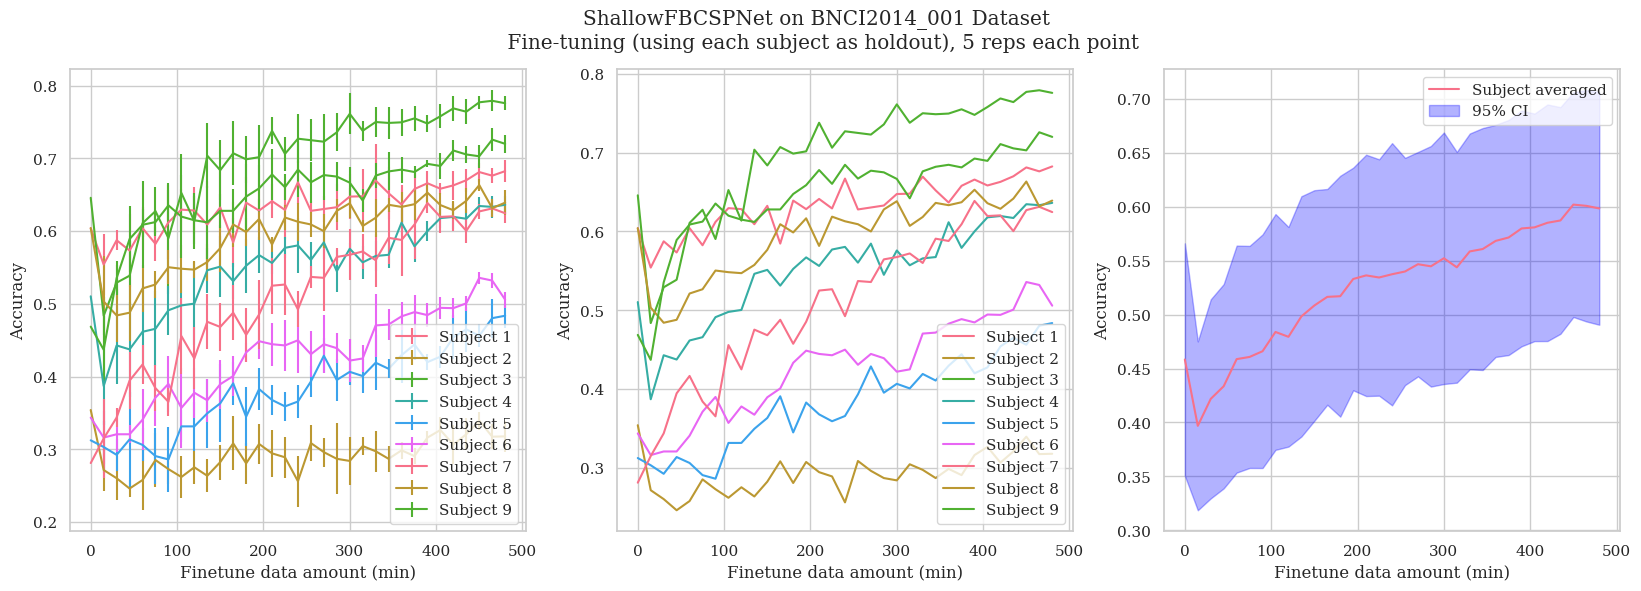

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

x = df_results.index # * 4 / 60

for col in df_results.columns:
    y_values = [np.mean(lst) for lst in df_results[col]]
    y_errors = [np.std(lst) for lst in df_results[col]]
    ax1.errorbar(x, y_values, yerr=y_errors, label=f'Subject {col}')
    ax2.plot(x, y_values, label=f'Subject {col}')

ax1.legend()
ax1.set_xlabel('Finetune data amount (min)')
ax1.set_ylabel('Accuracy')

ax2.legend()
ax2.set_xlabel('Finetune data amount (min)')
ax2.set_ylabel('Accuracy')

df_results_rep_avg = df_results.applymap(lambda x: np.mean(x))
subject_averaged_df = df_results_rep_avg.mean(axis=1)
std_err_df = df_results_rep_avg.sem(axis=1)
conf_interval_df = stats.t.interval(0.95, len(df_results_rep_avg.columns) - 1, loc=subject_averaged_df, scale=std_err_df)

ax3.plot(x, subject_averaged_df, label='Subject averaged')
ax3.fill_between(x, conf_interval_df[0], conf_interval_df[1], color='b', alpha=0.3, label='95% CI')

ax3.legend()
ax3.set_xlabel('Finetune data amount (min)')
ax3.set_ylabel('Accuracy')

plt.suptitle('ShallowFBCSPNet on BNCI2014_001 Dataset \n Fine-tuning (using each subject as holdout), 5 reps each point')

plt.savefig(os.path.join(results_dir, f'{file_name}_trials.png'))